<a href="https://colab.research.google.com/github/AKSHat5274/Image_Captioning_TF_Keras/blob/main/imagecaption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
 ! pip install -q kaggle
 from google.colab import files
 files.upload()
 !mkdir ~/.kaggle
 ! cp kaggle.json ~/.kaggle/
 ! chmod 600 ~/.kaggle/kaggle.json
 ! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                       title                                          size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  --------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                     Data Science Salaries 2023 💸                   25KB  2023-04-13 09:55:16          19728        555  1.0              
fatihb/coffee-quality-data-cqi                            Coffee Quality Data (CQI May-2023)             22KB  2023-05-12 13:06:39           1509         45  1.0              
ashpalsingh1525/imdb-movies-dataset                       IMDB movies dataset                             3MB  2023-04-28 23:18:15           2166         45  1.0              
iammustafatz/diabetes-prediction-dataset                  Diabetes prediction dataset 

In [ ]:
!kaggle datasets download -d adityajn105/flickr8k


100% 1.03G/1.04G [00:11<00:00, 79.2MB/s]
100% 1.04G/1.04G [00:11<00:00, 94.8MB/s]


In [ ]:
!unzip /content/flickr8k.zip -d /content/sample_data

Streaming output truncated to the last 5000 lines.
  inflating: /content/sample_data/Images/2844846111_8c1cbfc75d.jpg  
  inflating: /content/sample_data/Images/2844963839_ff09cdb81f.jpg  
  inflating: /content/sample_data/Images/2845246160_d0d1bbd6f0.jpg  
  inflating: /content/sample_data/Images/2845691057_d4ab89d889.jpg  
  inflating: /content/sample_data/Images/2845845721_d0bc113ff7.jpg  
  inflating: /content/sample_data/Images/2846037553_1a1de50709.jpg  
  inflating: /content/sample_data/Images/2846785268_904c5fcf9f.jpg  
  inflating: /content/sample_data/Images/2846843520_b0e6211478.jpg  
  inflating: /content/sample_data/Images/2847514745_9a35493023.jpg  
  inflating: /content/sample_data/Images/2847615962_c330bded6e.jpg  
  inflating: /content/sample_data/Images/2847859796_4d9cb0d31f.jpg  
  inflating: /content/sample_data/Images/2848266893_9693c66275.jpg  
  inflating: /content/sample_data/Images/2848571082_26454cb981.jpg  
  inflating: /content/sample_data/Images/2848895544_

In [ ]:
!mkdir /kaggle/input/flickr8k

mkdir: cannot create directory ‘/kaggle/input/flickr8k’: No such file or directory


In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
from numpy import array
import pandas as pd
import cv2
from glob import glob
import PIL
import time
from tqdm import tqdm
import os
# pip install pickle-mixin


In [ ]:

physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    print("None")
    pass
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

None
Num GPUs Available:  0


In [ ]:
image_path = "/content/sample_data/Images/"
images = glob(image_path + "*.jpg")
len(images)

8091

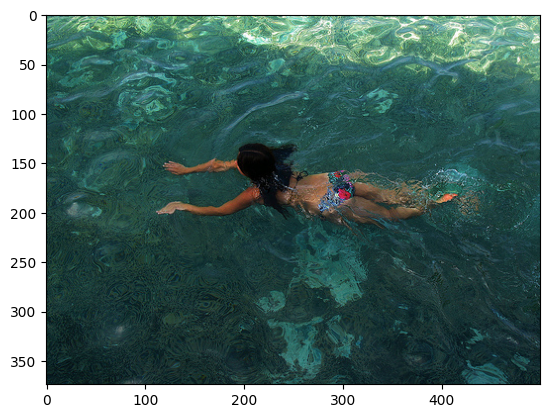

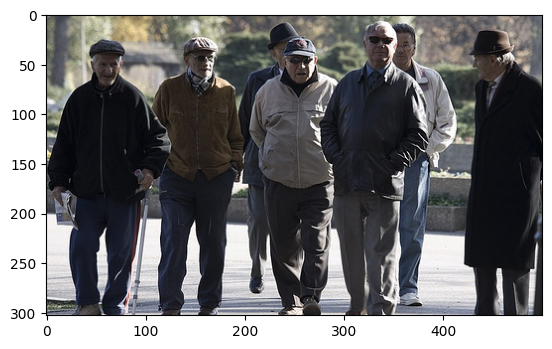

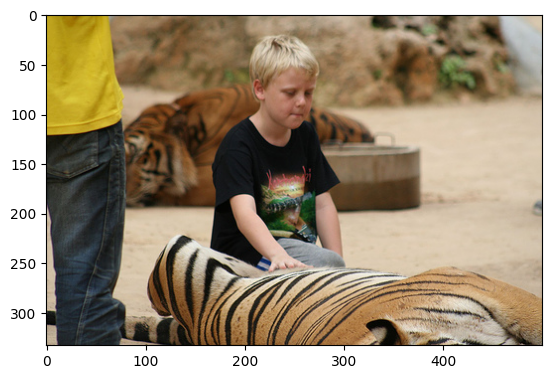

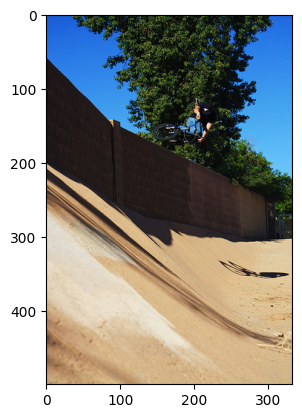

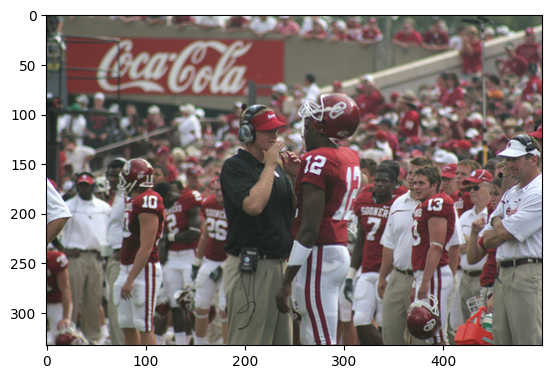

In [ ]:
for i in range(5):
    plt.figure()
    image = cv2.imread(images[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

In [ ]:
# Defining the function to load the captions

# Defining the function to load the captions
def load(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

file = "/content/sample_data/captions.txt"
info = load(file)[14:3319278]
print(len(info))
print(info[:484])

3319264
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1001773457_577


In [ ]:
count = 0

for line in info.split('\n'):
    print(line)
    count += 1
    if count == 5:
        break

1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .


In [ ]:


def load_captions(info):
    dict_1 = dict()
    count = 0
    for line in info.split('\n'):

        splitter = line.split('.jpg,')
#         print(splitter)

        image_code, image_caption = splitter[0], splitter[1]

        # Create dictionary
        if image_code not in dict_1:
            dict_1[image_code] = list()

        dict_1[image_code].append(image_caption)

    return dict_1

data = load_captions(info)
print(len(data))

8091


In [ ]:
list(data.keys())[:5]


['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [ ]:
data['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
# the data

def cleanse_data(data):
    dict_2 = dict()
    for key, value in data.items():
        for i in range(len(value)):
            lines = ""
            line1 = value[i]
            for j in line1.split():
                if len(j) < 2:
                    continue
                j = j.lower()
                lines += j + " "
            if key not in dict_2:
                dict_2[key] = list()

            dict_2[key].append(lines)

    return dict_2

data2 = cleanse_data(data)
print(len(data2))

8091


In [ ]:
#helping the ,odel create new words so its a collection of old words
def vocabulary(data2):
    all_desc = set()
    for key in data2.keys():
        [all_desc.update(d.split()) for d in data2[key]]
    return all_desc

# summarize vocabulary
vocabulary_data = vocabulary(data2)
print(len(vocabulary_data))

9148


In [ ]:
# save descriptions to file, one per line

def save_dict(data2, filename):
    lines = list()
    for key, value in data2.items():
        for desc in value:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_dict(data2, 'captions1.txt')

In [ ]:
images = '/content/sample_data/Images/'
img = glob(images + '*.jpg')
print(len(img))

def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = keras.preprocessing.image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # pre-process the images using preprocess_input() from inception module
    x = keras.applications.inception_v3.preprocess_input(x)
    return x

8091


In [ ]:
input1 = InceptionV3(weights='imagenet')
# inception v3
model = Model(input1.input, input1.layers[-2].output)
model.summary()

96112376/96112376 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                  

In [ ]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec


In [ ]:
encoding = {}

for i in tqdm(img):
    encoding[i[len(images):]] = encode(i)


  0%|          | 0/8091 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


  0%|          | 1/8091 [00:03<7:33:51,  3.37s/it]

1/1 [==============================] - 0s 252ms/step


  0%|          | 2/8091 [00:03<3:31:21,  1.57s/it]

1/1 [==============================] - 0s 250ms/step


  0%|          | 3/8091 [00:04<2:17:50,  1.02s/it]

1/1 [==============================] - 0s 240ms/step


  0%|          | 4/8091 [00:04<1:39:16,  1.36it/s]

1/1 [==============================] - 0s 251ms/step


  0%|          | 5/8091 [00:04<1:18:42,  1.71it/s]

1/1 [==============================] - 0s 266ms/step


  0%|          | 6/8091 [00:05<1:20:49,  1.67it/s]

1/1 [==============================] - 0s 437ms/step


  0%|          | 7/8091 [00:06<1:26:25,  1.56it/s]

1/1 [==============================] - 0s 461ms/step


  0%|          | 8/8091 [00:06<1:30:10,  1.49it/s]

1/1 [==============================] - 0s 452ms/step


  0%|          | 9/8091 [00:07<1:32:39,  1.45it/s]

1/1 [==============================] - 0s 270ms/step


  0%|          | 10/8091 [00:07<1:21:13,  1.66it/s]

1/1 [==============================] - 0s 244ms/step


  0%|          | 11/8091 [00:08<1:12:08,  1.87it/s]

1/1 [==============================] - 0s 245ms/step


  0%|          | 12/8091 [00:08<1:05:28,  2.06it/s]

1/1 [==============================] - 0s 248ms/step


  0%|          | 13/8091 [00:08<58:24,  2.31it/s]  

1/1 [==============================] - 0s 239ms/step


  0%|          | 14/8091 [00:09<53:06,  2.53it/s]

1/1 [==============================] - 0s 244ms/step


  0%|          | 15/8091 [00:09<52:24,  2.57it/s]

1/1 [==============================] - 0s 242ms/step


  0%|          | 16/8091 [00:09<48:56,  2.75it/s]

1/1 [==============================] - 0s 271ms/step


  0%|          | 17/8091 [00:10<49:36,  2.71it/s]

1/1 [==============================] - 0s 238ms/step


  0%|          | 18/8091 [00:10<46:38,  2.88it/s]

1/1 [==============================] - 0s 240ms/step


  0%|          | 19/8091 [00:10<47:56,  2.81it/s]

1/1 [==============================] - 0s 239ms/step


  0%|          | 20/8091 [00:11<45:44,  2.94it/s]

1/1 [==============================] - 0s 238ms/step


  0%|          | 21/8091 [00:11<47:02,  2.86it/s]

1/1 [==============================] - 0s 242ms/step


  0%|          | 22/8091 [00:12<48:08,  2.79it/s]

1/1 [==============================] - 0s 242ms/step


  0%|          | 23/8091 [00:12<49:10,  2.73it/s]

1/1 [==============================] - 0s 247ms/step


  0%|          | 24/8091 [00:12<47:08,  2.85it/s]

1/1 [==============================] - 0s 264ms/step


  0%|          | 25/8091 [00:13<46:12,  2.91it/s]

1/1 [==============================] - 0s 242ms/step


  0%|          | 26/8091 [00:13<44:38,  3.01it/s]

1/1 [==============================] - 0s 243ms/step


  0%|          | 27/8091 [00:13<46:32,  2.89it/s]

1/1 [==============================] - 0s 244ms/step


  0%|          | 28/8091 [00:14<44:49,  3.00it/s]

1/1 [==============================] - 0s 242ms/step


  0%|          | 29/8091 [00:14<46:48,  2.87it/s]

1/1 [==============================] - 0s 248ms/step


  0%|          | 30/8091 [00:14<45:12,  2.97it/s]

1/1 [==============================] - 0s 251ms/step


  0%|          | 31/8091 [00:15<47:00,  2.86it/s]

1/1 [==============================] - 0s 242ms/step


  0%|          | 32/8091 [00:15<45:19,  2.96it/s]

1/1 [==============================] - 0s 245ms/step


  0%|          | 33/8091 [00:15<47:15,  2.84it/s]

1/1 [==============================] - 0s 252ms/step


  0%|          | 34/8091 [00:16<48:15,  2.78it/s]

1/1 [==============================] - 0s 246ms/step


  0%|          | 35/8091 [00:16<48:52,  2.75it/s]

1/1 [==============================] - 0s 252ms/step


  0%|          | 36/8091 [00:16<49:20,  2.72it/s]

1/1 [==============================] - 0s 249ms/step


  0%|          | 37/8091 [00:17<49:38,  2.70it/s]

1/1 [==============================] - 0s 240ms/step


  0%|          | 38/8091 [00:17<49:47,  2.70it/s]

1/1 [==============================] - 0s 441ms/step


  0%|          | 39/8091 [00:18<1:04:16,  2.09it/s]

1/1 [==============================] - 0s 462ms/step


  0%|          | 40/8091 [00:19<1:15:19,  1.78it/s]

1/1 [==============================] - 0s 452ms/step


  1%|          | 41/8091 [00:19<1:22:30,  1.63it/s]

1/1 [==============================] - 0s 303ms/step


  1%|          | 42/8091 [00:20<1:13:28,  1.83it/s]

1/1 [==============================] - 0s 245ms/step


  1%|          | 43/8091 [00:20<1:03:46,  2.10it/s]

1/1 [==============================] - 0s 261ms/step


  1%|          | 44/8091 [00:21<1:00:00,  2.24it/s]

1/1 [==============================] - 0s 246ms/step


  1%|          | 45/8091 [00:21<54:16,  2.47it/s]  

1/1 [==============================] - 0s 246ms/step


  1%|          | 46/8091 [00:21<52:59,  2.53it/s]

1/1 [==============================] - 0s 240ms/step


  1%|          | 47/8091 [00:21<49:19,  2.72it/s]

1/1 [==============================] - 0s 263ms/step


  1%|          | 48/8091 [00:22<49:35,  2.70it/s]

1/1 [==============================] - 0s 249ms/step


  1%|          | 49/8091 [00:22<47:49,  2.80it/s]

1/1 [==============================] - 0s 241ms/step


  1%|          | 50/8091 [00:22<45:31,  2.94it/s]

1/1 [==============================] - 0s 237ms/step


  1%|          | 51/8091 [00:23<43:58,  3.05it/s]

1/1 [==============================] - 0s 249ms/step


  1%|          | 52/8091 [00:23<46:06,  2.91it/s]

1/1 [==============================] - 0s 247ms/step


  1%|          | 53/8091 [00:24<47:26,  2.82it/s]

1/1 [==============================] - 0s 264ms/step


  1%|          | 54/8091 [00:24<46:14,  2.90it/s]

1/1 [==============================] - 0s 257ms/step


  1%|          | 55/8091 [00:24<45:13,  2.96it/s]

1/1 [==============================] - 0s 242ms/step


  1%|          | 56/8091 [00:25<43:51,  3.05it/s]

1/1 [==============================] - 0s 258ms/step


  1%|          | 57/8091 [00:25<43:22,  3.09it/s]

1/1 [==============================] - 0s 246ms/step


  1%|          | 58/8091 [00:25<46:08,  2.90it/s]

1/1 [==============================] - 0s 247ms/step


  1%|          | 59/8091 [00:26<47:22,  2.83it/s]

1/1 [==============================] - 0s 252ms/step


  1%|          | 60/8091 [00:26<48:42,  2.75it/s]

1/1 [==============================] - 0s 246ms/step


  1%|          | 61/8091 [00:26<46:22,  2.89it/s]

1/1 [==============================] - 0s 259ms/step


  1%|          | 62/8091 [00:27<45:22,  2.95it/s]

1/1 [==============================] - 0s 242ms/step


  1%|          | 63/8091 [00:27<46:54,  2.85it/s]

1/1 [==============================] - 0s 258ms/step


  1%|          | 64/8091 [00:27<45:40,  2.93it/s]

1/1 [==============================] - 0s 250ms/step


  1%|          | 65/8091 [00:28<44:35,  3.00it/s]

1/1 [==============================] - 0s 251ms/step


  1%|          | 66/8091 [00:28<46:22,  2.88it/s]

1/1 [==============================] - 0s 249ms/step


  1%|          | 67/8091 [00:28<47:57,  2.79it/s]

1/1 [==============================] - 0s 250ms/step


  1%|          | 68/8091 [00:29<48:58,  2.73it/s]

1/1 [==============================] - 0s 258ms/step


  1%|          | 69/8091 [00:29<49:40,  2.69it/s]

1/1 [==============================] - 0s 246ms/step


  1%|          | 70/8091 [00:30<49:58,  2.67it/s]

1/1 [==============================] - 0s 342ms/step


  1%|          | 71/8091 [00:30<1:02:46,  2.13it/s]

1/1 [==============================] - 0s 465ms/step


  1%|          | 72/8091 [00:31<1:13:23,  1.82it/s]

1/1 [==============================] - 0s 473ms/step


  1%|          | 73/8091 [00:32<1:14:38,  1.79it/s]

1/1 [==============================] - 0s 439ms/step


  1%|          | 74/8091 [00:32<1:21:43,  1.64it/s]

1/1 [==============================] - 0s 245ms/step


  1%|          | 75/8091 [00:33<1:09:43,  1.92it/s]

1/1 [==============================] - 0s 244ms/step


  1%|          | 76/8091 [00:33<1:04:13,  2.08it/s]

1/1 [==============================] - 0s 255ms/step


  1%|          | 77/8091 [00:33<1:00:14,  2.22it/s]

1/1 [==============================] - 0s 247ms/step


  1%|          | 78/8091 [00:34<57:19,  2.33it/s]  

1/1 [==============================] - 0s 244ms/step


  1%|          | 79/8091 [00:34<55:00,  2.43it/s]

1/1 [==============================] - 0s 245ms/step


  1%|          | 80/8091 [00:34<53:48,  2.48it/s]

1/1 [==============================] - 0s 237ms/step


  1%|          | 81/8091 [00:35<49:31,  2.70it/s]

1/1 [==============================] - 0s 243ms/step


  1%|          | 82/8091 [00:35<46:57,  2.84it/s]

1/1 [==============================] - 0s 247ms/step


  1%|          | 83/8091 [00:35<45:30,  2.93it/s]

1/1 [==============================] - 0s 244ms/step


  1%|          | 84/8091 [00:36<47:14,  2.82it/s]

1/1 [==============================] - 0s 252ms/step


  1%|          | 85/8091 [00:36<45:37,  2.92it/s]

1/1 [==============================] - 0s 252ms/step


  1%|          | 86/8091 [00:36<47:18,  2.82it/s]

1/1 [==============================] - 0s 244ms/step


  1%|          | 87/8091 [00:37<45:04,  2.96it/s]

1/1 [==============================] - 0s 241ms/step


  1%|          | 88/8091 [00:37<43:44,  3.05it/s]

1/1 [==============================] - 0s 261ms/step


  1%|          | 89/8091 [00:37<45:58,  2.90it/s]

1/1 [==============================] - 0s 241ms/step


  1%|          | 90/8091 [00:38<47:08,  2.83it/s]

1/1 [==============================] - 0s 246ms/step


  1%|          | 91/8091 [00:38<48:08,  2.77it/s]

1/1 [==============================] - 0s 241ms/step


  1%|          | 92/8091 [00:39<46:03,  2.89it/s]

1/1 [==============================] - 0s 246ms/step


  1%|          | 93/8091 [00:39<47:39,  2.80it/s]

1/1 [==============================] - 0s 250ms/step


  1%|          | 94/8091 [00:39<48:28,  2.75it/s]

1/1 [==============================] - 0s 237ms/step


  1%|          | 95/8091 [00:40<48:56,  2.72it/s]

1/1 [==============================] - 0s 238ms/step


  1%|          | 96/8091 [00:40<46:26,  2.87it/s]

1/1 [==============================] - 0s 258ms/step


  1%|          | 97/8091 [00:40<47:55,  2.78it/s]

1/1 [==============================] - 0s 247ms/step


  1%|          | 98/8091 [00:41<48:30,  2.75it/s]

1/1 [==============================] - 0s 252ms/step


  1%|          | 99/8091 [00:41<46:23,  2.87it/s]

1/1 [==============================] - 0s 254ms/step


  1%|          | 100/8091 [00:41<45:08,  2.95it/s]

1/1 [==============================] - 0s 256ms/step


  1%|          | 101/8091 [00:42<44:09,  3.02it/s]

1/1 [==============================] - 0s 238ms/step


  1%|▏         | 102/8091 [00:42<46:17,  2.88it/s]

1/1 [==============================] - 0s 361ms/step


  1%|▏         | 103/8091 [00:42<49:31,  2.69it/s]

1/1 [==============================] - 0s 459ms/step


  1%|▏         | 104/8091 [00:43<1:04:12,  2.07it/s]

1/1 [==============================] - 0s 462ms/step


  1%|▏         | 105/8091 [00:44<1:14:46,  1.78it/s]

1/1 [==============================] - 0s 447ms/step


  1%|▏         | 106/8091 [00:45<1:13:31,  1.81it/s]

1/1 [==============================] - 0s 402ms/step


  1%|▏         | 107/8091 [00:45<1:11:32,  1.86it/s]

1/1 [==============================] - 0s 255ms/step


  1%|▏         | 108/8091 [00:45<1:05:33,  2.03it/s]

1/1 [==============================] - 0s 243ms/step


  1%|▏         | 109/8091 [00:46<1:01:08,  2.18it/s]

1/1 [==============================] - 0s 247ms/step


  1%|▏         | 110/8091 [00:46<55:01,  2.42it/s]  

1/1 [==============================] - 0s 249ms/step


  1%|▏         | 111/8091 [00:46<51:13,  2.60it/s]

1/1 [==============================] - 0s 237ms/step


  1%|▏         | 112/8091 [00:47<51:11,  2.60it/s]

1/1 [==============================] - 0s 240ms/step


  1%|▏         | 113/8091 [00:47<47:49,  2.78it/s]

1/1 [==============================] - 0s 249ms/step


  1%|▏         | 114/8091 [00:47<45:49,  2.90it/s]

1/1 [==============================] - 0s 247ms/step


  1%|▏         | 115/8091 [00:48<47:11,  2.82it/s]

1/1 [==============================] - 0s 241ms/step


  1%|▏         | 116/8091 [00:48<45:04,  2.95it/s]

1/1 [==============================] - 0s 253ms/step


  1%|▏         | 117/8091 [00:48<46:31,  2.86it/s]

1/1 [==============================] - 0s 246ms/step


  1%|▏         | 118/8091 [00:49<45:07,  2.95it/s]

1/1 [==============================] - 0s 242ms/step


  1%|▏         | 119/8091 [00:49<46:31,  2.86it/s]

1/1 [==============================] - 0s 243ms/step


  1%|▏         | 120/8091 [00:49<44:54,  2.96it/s]

1/1 [==============================] - 0s 249ms/step


  1%|▏         | 121/8091 [00:50<47:00,  2.83it/s]

1/1 [==============================] - 0s 251ms/step


  2%|▏         | 122/8091 [00:50<47:57,  2.77it/s]

1/1 [==============================] - 0s 254ms/step


  2%|▏         | 123/8091 [00:51<46:04,  2.88it/s]

1/1 [==============================] - 0s 236ms/step


  2%|▏         | 124/8091 [00:51<44:21,  2.99it/s]

1/1 [==============================] - 0s 243ms/step


  2%|▏         | 125/8091 [00:51<46:18,  2.87it/s]

1/1 [==============================] - 0s 241ms/step


  2%|▏         | 126/8091 [00:52<47:31,  2.79it/s]

1/1 [==============================] - 0s 237ms/step


  2%|▏         | 127/8091 [00:52<45:08,  2.94it/s]

1/1 [==============================] - 0s 251ms/step


  2%|▏         | 128/8091 [00:52<46:30,  2.85it/s]

1/1 [==============================] - 0s 249ms/step


  2%|▏         | 129/8091 [00:53<48:08,  2.76it/s]

1/1 [==============================] - 0s 238ms/step


  2%|▏         | 130/8091 [00:53<45:41,  2.90it/s]

1/1 [==============================] - 0s 250ms/step


  2%|▏         | 131/8091 [00:53<47:09,  2.81it/s]

1/1 [==============================] - 0s 255ms/step


  2%|▏         | 132/8091 [00:54<48:00,  2.76it/s]

1/1 [==============================] - 0s 244ms/step


  2%|▏         | 133/8091 [00:54<45:37,  2.91it/s]

1/1 [==============================] - 0s 244ms/step


  2%|▏         | 134/8091 [00:54<44:11,  3.00it/s]

1/1 [==============================] - 0s 245ms/step


  2%|▏         | 135/8091 [00:55<46:08,  2.87it/s]

1/1 [==============================] - 0s 242ms/step


  2%|▏         | 136/8091 [00:55<47:07,  2.81it/s]

1/1 [==============================] - 0s 438ms/step


  2%|▏         | 137/8091 [00:56<1:02:28,  2.12it/s]

1/1 [==============================] - 0s 467ms/step


  2%|▏         | 138/8091 [00:56<1:05:44,  2.02it/s]

1/1 [==============================] - 0s 473ms/step


  2%|▏         | 139/8091 [00:57<1:15:02,  1.77it/s]

1/1 [==============================] - 0s 426ms/step


  2%|▏         | 140/8091 [00:58<1:12:53,  1.82it/s]

1/1 [==============================] - 0s 252ms/step


  2%|▏         | 141/8091 [00:58<1:04:35,  2.05it/s]

1/1 [==============================] - 0s 245ms/step


  2%|▏         | 142/8091 [00:58<1:00:03,  2.21it/s]

1/1 [==============================] - 0s 239ms/step


  2%|▏         | 143/8091 [00:59<54:12,  2.44it/s]  

1/1 [==============================] - 0s 260ms/step


  2%|▏         | 144/8091 [00:59<50:39,  2.61it/s]

1/1 [==============================] - 0s 241ms/step


  2%|▏         | 145/8091 [00:59<50:39,  2.61it/s]

1/1 [==============================] - 0s 237ms/step


  2%|▏         | 146/8091 [01:00<47:41,  2.78it/s]

1/1 [==============================] - 0s 255ms/step


  2%|▏         | 147/8091 [01:00<46:11,  2.87it/s]

1/1 [==============================] - 0s 257ms/step


  2%|▏         | 148/8091 [01:00<45:14,  2.93it/s]

1/1 [==============================] - 0s 243ms/step


  2%|▏         | 149/8091 [01:01<43:54,  3.01it/s]

1/1 [==============================] - 0s 249ms/step


  2%|▏         | 150/8091 [01:01<45:28,  2.91it/s]

1/1 [==============================] - 0s 242ms/step


  2%|▏         | 151/8091 [01:01<43:59,  3.01it/s]

1/1 [==============================] - 0s 239ms/step


  2%|▏         | 152/8091 [01:02<45:37,  2.90it/s]

1/1 [==============================] - 0s 247ms/step


  2%|▏         | 153/8091 [01:02<44:18,  2.99it/s]

1/1 [==============================] - 0s 243ms/step


  2%|▏         | 154/8091 [01:02<43:06,  3.07it/s]

1/1 [==============================] - 0s 242ms/step


  2%|▏         | 155/8091 [01:03<42:30,  3.11it/s]

1/1 [==============================] - 0s 260ms/step


  2%|▏         | 156/8091 [01:03<44:59,  2.94it/s]

1/1 [==============================] - 0s 240ms/step


  2%|▏         | 157/8091 [01:03<46:31,  2.84it/s]

1/1 [==============================] - 0s 237ms/step


  2%|▏         | 158/8091 [01:04<44:37,  2.96it/s]

1/1 [==============================] - 0s 247ms/step


  2%|▏         | 159/8091 [01:04<46:19,  2.85it/s]

1/1 [==============================] - 0s 241ms/step


  2%|▏         | 160/8091 [01:04<47:15,  2.80it/s]

1/1 [==============================] - 0s 248ms/step


  2%|▏         | 161/8091 [01:05<45:14,  2.92it/s]

1/1 [==============================] - 0s 251ms/step


  2%|▏         | 162/8091 [01:05<44:07,  2.99it/s]

1/1 [==============================] - 0s 244ms/step


  2%|▏         | 163/8091 [01:05<45:44,  2.89it/s]

1/1 [==============================] - 0s 240ms/step


  2%|▏         | 164/8091 [01:06<44:16,  2.98it/s]

1/1 [==============================] - 0s 253ms/step


  2%|▏         | 165/8091 [01:06<43:32,  3.03it/s]

1/1 [==============================] - 0s 239ms/step


  2%|▏         | 166/8091 [01:06<42:37,  3.10it/s]

1/1 [==============================] - 0s 239ms/step


  2%|▏         | 167/8091 [01:07<45:02,  2.93it/s]

1/1 [==============================] - 0s 249ms/step


  2%|▏         | 168/8091 [01:07<43:57,  3.00it/s]

1/1 [==============================] - 0s 251ms/step


  2%|▏         | 169/8091 [01:07<43:08,  3.06it/s]

1/1 [==============================] - 0s 237ms/step


  2%|▏         | 170/8091 [01:08<45:08,  2.92it/s]

1/1 [==============================] - 0s 453ms/step


  2%|▏         | 171/8091 [01:08<53:00,  2.49it/s]

1/1 [==============================] - 0s 458ms/step


  2%|▏         | 172/8091 [01:09<58:27,  2.26it/s]

1/1 [==============================] - 0s 452ms/step


  2%|▏         | 173/8091 [01:10<1:10:25,  1.87it/s]

1/1 [==============================] - 0s 447ms/step


  2%|▏         | 174/8091 [01:10<1:10:18,  1.88it/s]

1/1 [==============================] - 0s 434ms/step


  2%|▏         | 175/8091 [01:11<1:18:39,  1.68it/s]

1/1 [==============================] - 0s 250ms/step


  2%|▏         | 176/8091 [01:11<1:07:19,  1.96it/s]

1/1 [==============================] - 0s 248ms/step


  2%|▏         | 177/8091 [01:11<59:35,  2.21it/s]  

1/1 [==============================] - 0s 241ms/step


  2%|▏         | 178/8091 [01:12<53:34,  2.46it/s]

1/1 [==============================] - 0s 246ms/step


  2%|▏         | 179/8091 [01:12<49:39,  2.66it/s]

1/1 [==============================] - 0s 252ms/step


  2%|▏         | 180/8091 [01:12<49:48,  2.65it/s]

1/1 [==============================] - 0s 243ms/step


  2%|▏         | 181/8091 [01:13<47:07,  2.80it/s]

1/1 [==============================] - 0s 246ms/step


  2%|▏         | 182/8091 [01:13<45:16,  2.91it/s]

1/1 [==============================] - 0s 268ms/step


  2%|▏         | 183/8091 [01:13<46:43,  2.82it/s]

1/1 [==============================] - 0s 240ms/step


  2%|▏         | 184/8091 [01:14<47:42,  2.76it/s]

1/1 [==============================] - 0s 250ms/step


  2%|▏         | 185/8091 [01:14<45:41,  2.88it/s]

1/1 [==============================] - 0s 251ms/step


  2%|▏         | 186/8091 [01:14<44:29,  2.96it/s]

1/1 [==============================] - 0s 239ms/step


  2%|▏         | 187/8091 [01:15<43:18,  3.04it/s]

1/1 [==============================] - 0s 246ms/step


  2%|▏         | 188/8091 [01:15<42:27,  3.10it/s]

1/1 [==============================] - 0s 263ms/step


  2%|▏         | 189/8091 [01:15<44:45,  2.94it/s]

1/1 [==============================] - 0s 236ms/step


  2%|▏         | 190/8091 [01:16<46:05,  2.86it/s]

1/1 [==============================] - 0s 246ms/step


  2%|▏         | 191/8091 [01:16<47:22,  2.78it/s]

1/1 [==============================] - 0s 260ms/step


  2%|▏         | 192/8091 [01:17<45:45,  2.88it/s]

1/1 [==============================] - 0s 240ms/step


  2%|▏         | 193/8091 [01:17<43:55,  3.00it/s]

1/1 [==============================] - 0s 239ms/step


  2%|▏         | 194/8091 [01:17<42:36,  3.09it/s]

1/1 [==============================] - 0s 261ms/step


  2%|▏         | 195/8091 [01:18<44:50,  2.93it/s]

1/1 [==============================] - 0s 236ms/step


  2%|▏         | 196/8091 [01:18<46:03,  2.86it/s]

1/1 [==============================] - 0s 246ms/step


  2%|▏         | 197/8091 [01:18<44:24,  2.96it/s]

1/1 [==============================] - 0s 256ms/step


  2%|▏         | 198/8091 [01:19<44:05,  2.98it/s]

1/1 [==============================] - 0s 243ms/step


  2%|▏         | 199/8091 [01:19<45:42,  2.88it/s]

1/1 [==============================] - 0s 239ms/step


  2%|▏         | 200/8091 [01:19<47:06,  2.79it/s]

1/1 [==============================] - 0s 251ms/step


  2%|▏         | 201/8091 [01:20<45:56,  2.86it/s]

1/1 [==============================] - 0s 239ms/step


  2%|▏         | 202/8091 [01:20<47:06,  2.79it/s]

1/1 [==============================] - 0s 240ms/step


  3%|▎         | 203/8091 [01:20<45:12,  2.91it/s]

1/1 [==============================] - 0s 257ms/step


  3%|▎         | 204/8091 [01:21<46:36,  2.82it/s]

1/1 [==============================] - 0s 439ms/step


  3%|▎         | 205/8091 [01:21<1:01:16,  2.14it/s]

1/1 [==============================] - 0s 456ms/step


  3%|▎         | 206/8091 [01:22<1:04:59,  2.02it/s]

1/1 [==============================] - 0s 471ms/step


  3%|▎         | 207/8091 [01:23<1:07:41,  1.94it/s]

1/1 [==============================] - 0s 448ms/step


  3%|▎         | 208/8091 [01:23<1:09:06,  1.90it/s]

1/1 [==============================] - 0s 354ms/step


  3%|▎         | 209/8091 [01:24<1:17:31,  1.69it/s]

1/1 [==============================] - 0s 241ms/step


  3%|▎         | 210/8091 [01:24<1:06:04,  1.99it/s]

1/1 [==============================] - 0s 241ms/step


  3%|▎         | 211/8091 [01:24<58:20,  2.25it/s]  

1/1 [==============================] - 0s 258ms/step


  3%|▎         | 212/8091 [01:25<55:51,  2.35it/s]

1/1 [==============================] - 0s 253ms/step


  3%|▎         | 213/8091 [01:25<51:27,  2.55it/s]

1/1 [==============================] - 0s 239ms/step


  3%|▎         | 214/8091 [01:25<47:59,  2.74it/s]

1/1 [==============================] - 0s 257ms/step


  3%|▎         | 215/8091 [01:26<46:13,  2.84it/s]

1/1 [==============================] - 0s 239ms/step


  3%|▎         | 216/8091 [01:26<47:08,  2.78it/s]

1/1 [==============================] - 0s 242ms/step


  3%|▎         | 217/8091 [01:26<45:24,  2.89it/s]

1/1 [==============================] - 0s 251ms/step


  3%|▎         | 218/8091 [01:27<44:25,  2.95it/s]

1/1 [==============================] - 0s 478ms/step


  3%|▎         | 219/8091 [01:27<52:33,  2.50it/s]

1/1 [==============================] - 0s 318ms/step


  3%|▎         | 220/8091 [01:28<55:17,  2.37it/s]

1/1 [==============================] - 0s 371ms/step


  3%|▎         | 221/8091 [01:28<1:06:08,  1.98it/s]

1/1 [==============================] - 0s 254ms/step


  3%|▎         | 222/8091 [01:29<1:02:37,  2.09it/s]

1/1 [==============================] - 0s 487ms/step


  3%|▎         | 223/8091 [01:29<1:05:42,  2.00it/s]

1/1 [==============================] - 0s 297ms/step


  3%|▎         | 224/8091 [01:30<1:04:11,  2.04it/s]

1/1 [==============================] - 0s 248ms/step


  3%|▎         | 225/8091 [01:30<57:02,  2.30it/s]  

1/1 [==============================] - 0s 242ms/step


  3%|▎         | 226/8091 [01:31<52:12,  2.51it/s]

1/1 [==============================] - 0s 274ms/step


  3%|▎         | 227/8091 [01:31<49:48,  2.63it/s]

1/1 [==============================] - 0s 241ms/step


  3%|▎         | 228/8091 [01:31<49:53,  2.63it/s]

1/1 [==============================] - 0s 242ms/step


  3%|▎         | 229/8091 [01:32<46:52,  2.80it/s]

1/1 [==============================] - 0s 249ms/step


  3%|▎         | 230/8091 [01:32<45:06,  2.90it/s]

1/1 [==============================] - 0s 238ms/step


  3%|▎         | 231/8091 [01:32<43:29,  3.01it/s]

1/1 [==============================] - 0s 245ms/step


  3%|▎         | 232/8091 [01:33<45:21,  2.89it/s]

1/1 [==============================] - 0s 249ms/step


  3%|▎         | 233/8091 [01:33<46:41,  2.81it/s]

1/1 [==============================] - 0s 250ms/step


  3%|▎         | 234/8091 [01:33<47:23,  2.76it/s]

1/1 [==============================] - 0s 374ms/step


  3%|▎         | 235/8091 [01:34<50:24,  2.60it/s]

1/1 [==============================] - 0s 452ms/step


  3%|▎         | 236/8091 [01:34<57:29,  2.28it/s]

1/1 [==============================] - 0s 458ms/step


  3%|▎         | 237/8091 [01:35<1:01:51,  2.12it/s]

1/1 [==============================] - 0s 475ms/step


  3%|▎         | 238/8091 [01:36<1:12:52,  1.80it/s]

1/1 [==============================] - 0s 449ms/step


  3%|▎         | 239/8091 [01:36<1:20:27,  1.63it/s]

1/1 [==============================] - 0s 241ms/step


  3%|▎         | 240/8091 [01:37<1:08:15,  1.92it/s]

1/1 [==============================] - 0s 249ms/step


  3%|▎         | 241/8091 [01:37<1:02:34,  2.09it/s]

1/1 [==============================] - 0s 241ms/step


  3%|▎         | 242/8091 [01:37<55:46,  2.35it/s]  

1/1 [==============================] - 0s 239ms/step


  3%|▎         | 243/8091 [01:38<54:03,  2.42it/s]

1/1 [==============================] - 0s 262ms/step


  3%|▎         | 244/8091 [01:38<50:53,  2.57it/s]

1/1 [==============================] - 0s 248ms/step


  3%|▎         | 245/8091 [01:38<50:35,  2.58it/s]

1/1 [==============================] - 0s 239ms/step


  3%|▎         | 246/8091 [01:39<50:10,  2.61it/s]

1/1 [==============================] - 0s 257ms/step


  3%|▎         | 247/8091 [01:39<49:49,  2.62it/s]

1/1 [==============================] - 0s 242ms/step


  3%|▎         | 248/8091 [01:40<46:54,  2.79it/s]

1/1 [==============================] - 0s 243ms/step


  3%|▎         | 249/8091 [01:40<47:41,  2.74it/s]

1/1 [==============================] - 0s 256ms/step


  3%|▎         | 250/8091 [01:40<48:19,  2.70it/s]

1/1 [==============================] - 0s 242ms/step


  3%|▎         | 251/8091 [01:41<48:33,  2.69it/s]

1/1 [==============================] - 0s 237ms/step


  3%|▎         | 252/8091 [01:41<45:50,  2.85it/s]

1/1 [==============================] - 0s 249ms/step


  3%|▎         | 253/8091 [01:41<44:51,  2.91it/s]

1/1 [==============================] - 0s 248ms/step


  3%|▎         | 254/8091 [01:42<46:14,  2.82it/s]

1/1 [==============================] - 0s 244ms/step


  3%|▎         | 255/8091 [01:42<47:05,  2.77it/s]

1/1 [==============================] - 0s 240ms/step


  3%|▎         | 256/8091 [01:42<45:08,  2.89it/s]

1/1 [==============================] - 0s 250ms/step


  3%|▎         | 257/8091 [01:43<46:35,  2.80it/s]

1/1 [==============================] - 0s 237ms/step


  3%|▎         | 258/8091 [01:43<47:21,  2.76it/s]

1/1 [==============================] - 0s 246ms/step


  3%|▎         | 259/8091 [01:43<47:47,  2.73it/s]

1/1 [==============================] - 0s 244ms/step


  3%|▎         | 260/8091 [01:44<48:04,  2.71it/s]

1/1 [==============================] - 0s 252ms/step


  3%|▎         | 261/8091 [01:44<45:55,  2.84it/s]

1/1 [==============================] - 0s 244ms/step


  3%|▎         | 262/8091 [01:44<45:00,  2.90it/s]

1/1 [==============================] - 0s 240ms/step


  3%|▎         | 263/8091 [01:45<43:25,  3.00it/s]

1/1 [==============================] - 0s 255ms/step


  3%|▎         | 264/8091 [01:45<43:13,  3.02it/s]

1/1 [==============================] - 0s 246ms/step


  3%|▎         | 265/8091 [01:46<45:25,  2.87it/s]

1/1 [==============================] - 0s 257ms/step


  3%|▎         | 266/8091 [01:46<46:16,  2.82it/s]

1/1 [==============================] - 0s 251ms/step


  3%|▎         | 267/8091 [01:46<47:07,  2.77it/s]

1/1 [==============================] - 0s 405ms/step


  3%|▎         | 268/8091 [01:47<1:01:50,  2.11it/s]

1/1 [==============================] - 0s 466ms/step


  3%|▎         | 269/8091 [01:48<1:11:51,  1.81it/s]

1/1 [==============================] - 0s 458ms/step


  3%|▎         | 270/8091 [01:48<1:19:07,  1.65it/s]

1/1 [==============================] - 0s 368ms/step


  3%|▎         | 271/8091 [01:49<1:24:39,  1.54it/s]

1/1 [==============================] - 0s 258ms/step


  3%|▎         | 272/8091 [01:50<1:14:08,  1.76it/s]

1/1 [==============================] - 0s 239ms/step


  3%|▎         | 273/8091 [01:50<1:06:36,  1.96it/s]

1/1 [==============================] - 0s 236ms/step


  3%|▎         | 274/8091 [01:50<1:01:27,  2.12it/s]

1/1 [==============================] - 0s 239ms/step


  3%|▎         | 275/8091 [01:51<54:49,  2.38it/s]  

1/1 [==============================] - 0s 247ms/step


  3%|▎         | 276/8091 [01:51<53:09,  2.45it/s]

1/1 [==============================] - 0s 251ms/step


  3%|▎         | 277/8091 [01:51<51:53,  2.51it/s]

1/1 [==============================] - 0s 241ms/step


  3%|▎         | 278/8091 [01:52<48:13,  2.70it/s]

1/1 [==============================] - 0s 251ms/step


  3%|▎         | 279/8091 [01:52<48:39,  2.68it/s]

1/1 [==============================] - 0s 254ms/step


  3%|▎         | 280/8091 [01:52<46:46,  2.78it/s]

1/1 [==============================] - 0s 240ms/step


  3%|▎         | 281/8091 [01:53<44:25,  2.93it/s]

1/1 [==============================] - 0s 248ms/step


  3%|▎         | 282/8091 [01:53<45:56,  2.83it/s]

1/1 [==============================] - 0s 261ms/step


  3%|▎         | 283/8091 [01:53<44:44,  2.91it/s]

1/1 [==============================] - 0s 249ms/step


  4%|▎         | 284/8091 [01:54<46:08,  2.82it/s]

1/1 [==============================] - 0s 237ms/step


  4%|▎         | 285/8091 [01:54<44:14,  2.94it/s]

1/1 [==============================] - 0s 255ms/step


  4%|▎         | 286/8091 [01:54<45:53,  2.84it/s]

1/1 [==============================] - 0s 240ms/step


  4%|▎         | 287/8091 [01:55<43:54,  2.96it/s]

1/1 [==============================] - 0s 248ms/step


  4%|▎         | 288/8091 [01:55<42:53,  3.03it/s]

1/1 [==============================] - 0s 248ms/step


  4%|▎         | 289/8091 [01:55<45:28,  2.86it/s]

1/1 [==============================] - 0s 243ms/step


  4%|▎         | 290/8091 [01:56<43:43,  2.97it/s]

1/1 [==============================] - 0s 242ms/step


  4%|▎         | 291/8091 [01:56<42:20,  3.07it/s]

1/1 [==============================] - 0s 257ms/step


  4%|▎         | 292/8091 [01:56<44:31,  2.92it/s]

1/1 [==============================] - 0s 245ms/step


  4%|▎         | 293/8091 [01:57<43:08,  3.01it/s]

1/1 [==============================] - 0s 236ms/step


  4%|▎         | 294/8091 [01:57<44:53,  2.89it/s]

1/1 [==============================] - 0s 246ms/step


  4%|▎         | 295/8091 [01:58<46:09,  2.81it/s]

1/1 [==============================] - 0s 246ms/step


  4%|▎         | 296/8091 [01:58<44:12,  2.94it/s]

1/1 [==============================] - 0s 248ms/step


  4%|▎         | 297/8091 [01:58<45:46,  2.84it/s]

1/1 [==============================] - 0s 254ms/step


  4%|▎         | 298/8091 [01:59<47:10,  2.75it/s]

1/1 [==============================] - 0s 296ms/step


  4%|▎         | 299/8091 [01:59<47:15,  2.75it/s]

1/1 [==============================] - 0s 450ms/step


  4%|▎         | 300/8091 [02:00<1:01:56,  2.10it/s]

1/1 [==============================] - 0s 462ms/step


  4%|▎         | 301/8091 [02:00<1:11:43,  1.81it/s]

1/1 [==============================] - 0s 467ms/step


  4%|▎         | 302/8091 [02:01<1:11:29,  1.82it/s]

1/1 [==============================] - 0s 451ms/step


  4%|▎         | 303/8091 [02:02<1:18:54,  1.64it/s]

1/1 [==============================] - 0s 240ms/step


  4%|▍         | 304/8091 [02:02<1:07:03,  1.94it/s]

1/1 [==============================] - 0s 239ms/step


  4%|▍         | 305/8091 [02:02<58:34,  2.22it/s]  

1/1 [==============================] - 0s 248ms/step


  4%|▍         | 306/8091 [02:03<53:56,  2.41it/s]

1/1 [==============================] - 0s 241ms/step


  4%|▍         | 307/8091 [02:03<49:39,  2.61it/s]

1/1 [==============================] - 0s 245ms/step


  4%|▍         | 308/8091 [02:03<49:27,  2.62it/s]

1/1 [==============================] - 0s 261ms/step


  4%|▍         | 309/8091 [02:04<47:10,  2.75it/s]

1/1 [==============================] - 0s 241ms/step


  4%|▍         | 310/8091 [02:04<47:56,  2.70it/s]

1/1 [==============================] - 0s 238ms/step


  4%|▍         | 311/8091 [02:04<45:18,  2.86it/s]

1/1 [==============================] - 0s 238ms/step


  4%|▍         | 312/8091 [02:05<46:27,  2.79it/s]

1/1 [==============================] - 0s 246ms/step


  4%|▍         | 313/8091 [02:05<44:26,  2.92it/s]

1/1 [==============================] - 0s 242ms/step


  4%|▍         | 314/8091 [02:05<45:43,  2.84it/s]

1/1 [==============================] - 0s 250ms/step


  4%|▍         | 315/8091 [02:06<46:54,  2.76it/s]

1/1 [==============================] - 0s 246ms/step


  4%|▍         | 316/8091 [02:06<47:29,  2.73it/s]

1/1 [==============================] - 0s 244ms/step


  4%|▍         | 317/8091 [02:06<45:10,  2.87it/s]

1/1 [==============================] - 0s 258ms/step


  4%|▍         | 318/8091 [02:07<46:17,  2.80it/s]

1/1 [==============================] - 0s 255ms/step


  4%|▍         | 319/8091 [02:07<44:41,  2.90it/s]

1/1 [==============================] - 0s 242ms/step


  4%|▍         | 320/8091 [02:08<43:19,  2.99it/s]

1/1 [==============================] - 0s 251ms/step


  4%|▍         | 321/8091 [02:08<42:38,  3.04it/s]

1/1 [==============================] - 0s 249ms/step


  4%|▍         | 322/8091 [02:08<44:30,  2.91it/s]

1/1 [==============================] - 0s 244ms/step


  4%|▍         | 323/8091 [02:09<45:58,  2.82it/s]

1/1 [==============================] - 0s 263ms/step


  4%|▍         | 324/8091 [02:09<47:09,  2.75it/s]

1/1 [==============================] - 0s 240ms/step


  4%|▍         | 325/8091 [02:09<47:41,  2.71it/s]

1/1 [==============================] - 0s 236ms/step


  4%|▍         | 326/8091 [02:10<45:04,  2.87it/s]

1/1 [==============================] - 0s 256ms/step


  4%|▍         | 327/8091 [02:10<46:20,  2.79it/s]

1/1 [==============================] - 0s 245ms/step


  4%|▍         | 328/8091 [02:10<47:12,  2.74it/s]

1/1 [==============================] - 0s 235ms/step


  4%|▍         | 329/8091 [02:11<47:35,  2.72it/s]

1/1 [==============================] - 0s 245ms/step


  4%|▍         | 330/8091 [02:11<45:30,  2.84it/s]

1/1 [==============================] - 0s 241ms/step


  4%|▍         | 331/8091 [02:11<46:45,  2.77it/s]

1/1 [==============================] - 0s 357ms/step


  4%|▍         | 332/8091 [02:12<48:57,  2.64it/s]

1/1 [==============================] - 0s 468ms/step


  4%|▍         | 333/8091 [02:12<56:45,  2.28it/s]

1/1 [==============================] - 0s 479ms/step


  4%|▍         | 334/8091 [02:13<1:02:04,  2.08it/s]

1/1 [==============================] - 0s 466ms/step


  4%|▍         | 335/8091 [02:14<1:05:17,  1.98it/s]

1/1 [==============================] - 0s 473ms/step


  4%|▍         | 336/8091 [02:14<1:07:44,  1.91it/s]

1/1 [==============================] - 0s 411ms/step


  4%|▍         | 337/8091 [02:15<1:16:23,  1.69it/s]

1/1 [==============================] - 0s 247ms/step


  4%|▍         | 338/8091 [02:15<1:08:16,  1.89it/s]

1/1 [==============================] - 0s 238ms/step


  4%|▍         | 339/8091 [02:16<59:27,  2.17it/s]  

1/1 [==============================] - 0s 240ms/step


  4%|▍         | 340/8091 [02:16<53:20,  2.42it/s]

1/1 [==============================] - 0s 259ms/step


  4%|▍         | 341/8091 [02:16<52:21,  2.47it/s]

1/1 [==============================] - 0s 246ms/step


  4%|▍         | 342/8091 [02:17<51:18,  2.52it/s]

1/1 [==============================] - 0s 245ms/step


  4%|▍         | 343/8091 [02:17<47:51,  2.70it/s]

1/1 [==============================] - 0s 238ms/step


  4%|▍         | 344/8091 [02:17<45:31,  2.84it/s]

1/1 [==============================] - 0s 241ms/step


  4%|▍         | 345/8091 [02:18<46:30,  2.78it/s]

1/1 [==============================] - 0s 244ms/step


  4%|▍         | 346/8091 [02:18<44:29,  2.90it/s]

1/1 [==============================] - 0s 246ms/step


  4%|▍         | 347/8091 [02:18<43:47,  2.95it/s]

1/1 [==============================] - 0s 245ms/step


  4%|▍         | 348/8091 [02:19<45:29,  2.84it/s]

1/1 [==============================] - 0s 242ms/step


  4%|▍         | 349/8091 [02:19<46:27,  2.78it/s]

1/1 [==============================] - 0s 249ms/step


  4%|▍         | 350/8091 [02:19<47:41,  2.70it/s]

1/1 [==============================] - 0s 241ms/step


  4%|▍         | 351/8091 [02:20<45:08,  2.86it/s]

1/1 [==============================] - 0s 267ms/step


  4%|▍         | 352/8091 [02:20<46:22,  2.78it/s]

1/1 [==============================] - 0s 245ms/step


  4%|▍         | 353/8091 [02:21<47:04,  2.74it/s]

1/1 [==============================] - 0s 240ms/step


  4%|▍         | 354/8091 [02:21<44:42,  2.88it/s]

1/1 [==============================] - 0s 259ms/step


  4%|▍         | 355/8091 [02:21<45:49,  2.81it/s]

1/1 [==============================] - 0s 247ms/step


  4%|▍         | 356/8091 [02:22<46:34,  2.77it/s]

1/1 [==============================] - 0s 245ms/step


  4%|▍         | 357/8091 [02:22<47:15,  2.73it/s]

1/1 [==============================] - 0s 254ms/step


  4%|▍         | 358/8091 [02:22<47:34,  2.71it/s]

1/1 [==============================] - 0s 242ms/step


  4%|▍         | 359/8091 [02:23<48:14,  2.67it/s]

1/1 [==============================] - 0s 252ms/step


  4%|▍         | 360/8091 [02:23<48:23,  2.66it/s]

1/1 [==============================] - 0s 245ms/step


  4%|▍         | 361/8091 [02:23<48:49,  2.64it/s]

1/1 [==============================] - 0s 242ms/step


  4%|▍         | 362/8091 [02:24<45:54,  2.81it/s]

1/1 [==============================] - 0s 252ms/step


  4%|▍         | 363/8091 [02:24<44:23,  2.90it/s]

1/1 [==============================] - 0s 259ms/step


  4%|▍         | 364/8091 [02:24<43:48,  2.94it/s]

1/1 [==============================] - 0s 297ms/step


  5%|▍         | 365/8091 [02:25<45:14,  2.85it/s]

1/1 [==============================] - 0s 454ms/step


  5%|▍         | 366/8091 [02:26<1:00:01,  2.15it/s]

1/1 [==============================] - 0s 458ms/step


  5%|▍         | 367/8091 [02:26<1:03:10,  2.04it/s]

1/1 [==============================] - 0s 487ms/step


  5%|▍         | 368/8091 [02:27<1:06:48,  1.93it/s]

1/1 [==============================] - 0s 433ms/step


  5%|▍         | 369/8091 [02:27<1:07:15,  1.91it/s]

1/1 [==============================] - 0s 359ms/step


  5%|▍         | 370/8091 [02:28<1:04:57,  1.98it/s]

1/1 [==============================] - 0s 243ms/step


  5%|▍         | 371/8091 [02:28<57:09,  2.25it/s]  

1/1 [==============================] - 0s 247ms/step


  5%|▍         | 372/8091 [02:28<54:40,  2.35it/s]

1/1 [==============================] - 0s 241ms/step


  5%|▍         | 373/8091 [02:29<53:08,  2.42it/s]

1/1 [==============================] - 0s 239ms/step


  5%|▍         | 374/8091 [02:29<48:46,  2.64it/s]

1/1 [==============================] - 0s 245ms/step


  5%|▍         | 375/8091 [02:29<48:52,  2.63it/s]

1/1 [==============================] - 0s 241ms/step


  5%|▍         | 376/8091 [02:30<46:26,  2.77it/s]

1/1 [==============================] - 0s 244ms/step


  5%|▍         | 377/8091 [02:30<44:24,  2.89it/s]

1/1 [==============================] - 0s 240ms/step


  5%|▍         | 378/8091 [02:30<43:04,  2.98it/s]

1/1 [==============================] - 0s 237ms/step


  5%|▍         | 379/8091 [02:31<45:11,  2.84it/s]

1/1 [==============================] - 0s 247ms/step


  5%|▍         | 380/8091 [02:31<43:35,  2.95it/s]

1/1 [==============================] - 0s 239ms/step


  5%|▍         | 381/8091 [02:31<45:33,  2.82it/s]

1/1 [==============================] - 0s 246ms/step


  5%|▍         | 382/8091 [02:32<46:23,  2.77it/s]

1/1 [==============================] - 0s 242ms/step


  5%|▍         | 383/8091 [02:32<44:30,  2.89it/s]

1/1 [==============================] - 0s 263ms/step


  5%|▍         | 384/8091 [02:32<43:36,  2.95it/s]

1/1 [==============================] - 0s 239ms/step


  5%|▍         | 385/8091 [02:33<45:39,  2.81it/s]

1/1 [==============================] - 0s 253ms/step


  5%|▍         | 386/8091 [02:33<44:11,  2.91it/s]

1/1 [==============================] - 0s 249ms/step


  5%|▍         | 387/8091 [02:34<43:09,  2.98it/s]

1/1 [==============================] - 0s 241ms/step


  5%|▍         | 388/8091 [02:34<41:53,  3.06it/s]

1/1 [==============================] - 0s 249ms/step


  5%|▍         | 389/8091 [02:34<41:41,  3.08it/s]

1/1 [==============================] - 0s 241ms/step


  5%|▍         | 390/8091 [02:35<43:55,  2.92it/s]

1/1 [==============================] - 0s 237ms/step


  5%|▍         | 391/8091 [02:35<45:10,  2.84it/s]

1/1 [==============================] - 0s 242ms/step


  5%|▍         | 392/8091 [02:35<46:18,  2.77it/s]

1/1 [==============================] - 0s 250ms/step


  5%|▍         | 393/8091 [02:36<44:41,  2.87it/s]

1/1 [==============================] - 0s 246ms/step


  5%|▍         | 394/8091 [02:36<46:09,  2.78it/s]

1/1 [==============================] - 0s 246ms/step


  5%|▍         | 395/8091 [02:36<44:46,  2.87it/s]

1/1 [==============================] - 0s 254ms/step


  5%|▍         | 396/8091 [02:37<43:49,  2.93it/s]

1/1 [==============================] - 0s 239ms/step


  5%|▍         | 397/8091 [02:37<45:12,  2.84it/s]

1/1 [==============================] - 0s 243ms/step


  5%|▍         | 398/8091 [02:37<46:14,  2.77it/s]

1/1 [==============================] - 0s 299ms/step


  5%|▍         | 399/8091 [02:38<46:20,  2.77it/s]

1/1 [==============================] - 0s 440ms/step


  5%|▍         | 400/8091 [02:38<52:57,  2.42it/s]

1/1 [==============================] - 0s 464ms/step


  5%|▍         | 401/8091 [02:39<1:06:35,  1.92it/s]

1/1 [==============================] - 0s 474ms/step


  5%|▍         | 402/8091 [02:40<1:08:45,  1.86it/s]

1/1 [==============================] - 0s 442ms/step


  5%|▍         | 403/8091 [02:40<1:09:16,  1.85it/s]

1/1 [==============================] - 0s 348ms/step


  5%|▍         | 404/8091 [02:41<1:17:06,  1.66it/s]

1/1 [==============================] - 0s 242ms/step


  5%|▌         | 405/8091 [02:41<1:08:23,  1.87it/s]

1/1 [==============================] - 0s 247ms/step


  5%|▌         | 406/8091 [02:42<1:02:28,  2.05it/s]

1/1 [==============================] - 0s 243ms/step


  5%|▌         | 407/8091 [02:42<55:53,  2.29it/s]  

1/1 [==============================] - 0s 243ms/step


  5%|▌         | 408/8091 [02:42<51:00,  2.51it/s]

1/1 [==============================] - 0s 251ms/step


  5%|▌         | 409/8091 [02:43<47:59,  2.67it/s]

1/1 [==============================] - 0s 260ms/step


  5%|▌         | 410/8091 [02:43<48:12,  2.66it/s]

1/1 [==============================] - 0s 242ms/step


  5%|▌         | 411/8091 [02:43<45:54,  2.79it/s]

1/1 [==============================] - 0s 244ms/step


  5%|▌         | 412/8091 [02:44<46:55,  2.73it/s]

1/1 [==============================] - 0s 241ms/step


  5%|▌         | 413/8091 [02:44<44:49,  2.85it/s]

1/1 [==============================] - 0s 243ms/step


  5%|▌         | 414/8091 [02:44<43:45,  2.92it/s]

1/1 [==============================] - 0s 240ms/step


  5%|▌         | 415/8091 [02:45<42:29,  3.01it/s]

1/1 [==============================] - 0s 250ms/step


  5%|▌         | 416/8091 [02:45<41:50,  3.06it/s]

1/1 [==============================] - 0s 243ms/step


  5%|▌         | 417/8091 [02:45<44:03,  2.90it/s]

1/1 [==============================] - 0s 241ms/step


  5%|▌         | 418/8091 [02:46<42:49,  2.99it/s]

1/1 [==============================] - 0s 258ms/step


  5%|▌         | 419/8091 [02:46<44:54,  2.85it/s]

1/1 [==============================] - 0s 252ms/step


  5%|▌         | 420/8091 [02:46<46:07,  2.77it/s]

1/1 [==============================] - 0s 245ms/step


  5%|▌         | 421/8091 [02:47<47:00,  2.72it/s]

1/1 [==============================] - 0s 242ms/step


  5%|▌         | 422/8091 [02:47<47:23,  2.70it/s]

1/1 [==============================] - 0s 242ms/step


  5%|▌         | 423/8091 [02:47<44:52,  2.85it/s]

1/1 [==============================] - 0s 238ms/step


  5%|▌         | 424/8091 [02:48<46:07,  2.77it/s]

1/1 [==============================] - 0s 249ms/step


  5%|▌         | 425/8091 [02:48<46:58,  2.72it/s]

1/1 [==============================] - 0s 237ms/step


  5%|▌         | 426/8091 [02:49<44:27,  2.87it/s]

1/1 [==============================] - 0s 250ms/step


  5%|▌         | 427/8091 [02:49<45:52,  2.78it/s]

1/1 [==============================] - 0s 244ms/step


  5%|▌         | 428/8091 [02:49<46:49,  2.73it/s]

1/1 [==============================] - 0s 244ms/step


  5%|▌         | 429/8091 [02:50<44:51,  2.85it/s]

1/1 [==============================] - 0s 262ms/step


  5%|▌         | 430/8091 [02:50<46:05,  2.77it/s]

1/1 [==============================] - 0s 251ms/step


  5%|▌         | 431/8091 [02:50<44:20,  2.88it/s]

1/1 [==============================] - 0s 317ms/step


  5%|▌         | 432/8091 [02:51<45:49,  2.79it/s]

1/1 [==============================] - 0s 447ms/step


  5%|▌         | 433/8091 [02:51<1:00:29,  2.11it/s]

1/1 [==============================] - 0s 480ms/step


  5%|▌         | 434/8091 [02:52<1:10:52,  1.80it/s]

1/1 [==============================] - 0s 460ms/step


  5%|▌         | 435/8091 [02:53<1:10:48,  1.80it/s]

1/1 [==============================] - 0s 409ms/step


  5%|▌         | 436/8091 [02:53<1:09:07,  1.85it/s]

1/1 [==============================] - 0s 250ms/step


  5%|▌         | 437/8091 [02:54<1:00:41,  2.10it/s]

1/1 [==============================] - 0s 239ms/step


  5%|▌         | 438/8091 [02:54<57:33,  2.22it/s]  

1/1 [==============================] - 0s 243ms/step


  5%|▌         | 439/8091 [02:54<55:24,  2.30it/s]

1/1 [==============================] - 0s 241ms/step


  5%|▌         | 440/8091 [02:55<53:21,  2.39it/s]

1/1 [==============================] - 0s 254ms/step


  5%|▌         | 441/8091 [02:55<51:47,  2.46it/s]

1/1 [==============================] - 0s 242ms/step


  5%|▌         | 442/8091 [02:55<47:55,  2.66it/s]

1/1 [==============================] - 0s 237ms/step


  5%|▌         | 443/8091 [02:56<48:16,  2.64it/s]

1/1 [==============================] - 0s 263ms/step


  5%|▌         | 444/8091 [02:56<48:11,  2.64it/s]

1/1 [==============================] - 0s 250ms/step


  5%|▌         | 445/8091 [02:57<48:07,  2.65it/s]

1/1 [==============================] - 0s 236ms/step


  6%|▌         | 446/8091 [02:57<45:08,  2.82it/s]

1/1 [==============================] - 0s 256ms/step


  6%|▌         | 447/8091 [02:57<46:17,  2.75it/s]

1/1 [==============================] - 0s 248ms/step


  6%|▌         | 448/8091 [02:58<44:14,  2.88it/s]

1/1 [==============================] - 0s 244ms/step


  6%|▌         | 449/8091 [02:58<42:51,  2.97it/s]

1/1 [==============================] - 0s 255ms/step


  6%|▌         | 450/8091 [02:58<44:44,  2.85it/s]

1/1 [==============================] - 0s 241ms/step


  6%|▌         | 451/8091 [02:59<42:46,  2.98it/s]

1/1 [==============================] - 0s 241ms/step


  6%|▌         | 452/8091 [02:59<41:41,  3.05it/s]

1/1 [==============================] - 0s 256ms/step


  6%|▌         | 453/8091 [02:59<43:53,  2.90it/s]

1/1 [==============================] - 0s 239ms/step


  6%|▌         | 454/8091 [03:00<45:07,  2.82it/s]

1/1 [==============================] - 0s 241ms/step


  6%|▌         | 455/8091 [03:00<43:10,  2.95it/s]

1/1 [==============================] - 0s 257ms/step


  6%|▌         | 456/8091 [03:00<43:01,  2.96it/s]

1/1 [==============================] - 0s 241ms/step


  6%|▌         | 457/8091 [03:01<44:46,  2.84it/s]

1/1 [==============================] - 0s 238ms/step


  6%|▌         | 458/8091 [03:01<45:43,  2.78it/s]

1/1 [==============================] - 0s 270ms/step


  6%|▌         | 459/8091 [03:01<45:03,  2.82it/s]

1/1 [==============================] - 0s 246ms/step


  6%|▌         | 460/8091 [03:02<46:04,  2.76it/s]

1/1 [==============================] - 0s 243ms/step


  6%|▌         | 461/8091 [03:02<44:04,  2.88it/s]

1/1 [==============================] - 0s 249ms/step


  6%|▌         | 462/8091 [03:02<45:18,  2.81it/s]

1/1 [==============================] - 0s 237ms/step


  6%|▌         | 463/8091 [03:03<46:04,  2.76it/s]

1/1 [==============================] - 0s 251ms/step


  6%|▌         | 464/8091 [03:03<46:43,  2.72it/s]

1/1 [==============================] - 0s 419ms/step


  6%|▌         | 465/8091 [03:04<1:00:56,  2.09it/s]

1/1 [==============================] - 0s 474ms/step


  6%|▌         | 466/8091 [03:05<1:11:21,  1.78it/s]

1/1 [==============================] - 0s 474ms/step


  6%|▌         | 467/8091 [03:05<1:10:52,  1.79it/s]

1/1 [==============================] - 0s 450ms/step


  6%|▌         | 468/8091 [03:06<1:10:29,  1.80it/s]

1/1 [==============================] - 0s 285ms/step


  6%|▌         | 469/8091 [03:06<1:05:06,  1.95it/s]

1/1 [==============================] - 0s 249ms/step


  6%|▌         | 470/8091 [03:07<57:29,  2.21it/s]  

1/1 [==============================] - 0s 238ms/step


  6%|▌         | 471/8091 [03:07<51:52,  2.45it/s]

1/1 [==============================] - 0s 246ms/step


  6%|▌         | 472/8091 [03:07<48:19,  2.63it/s]

1/1 [==============================] - 0s 261ms/step


  6%|▌         | 473/8091 [03:08<48:53,  2.60it/s]

1/1 [==============================] - 0s 237ms/step


  6%|▌         | 474/8091 [03:08<45:40,  2.78it/s]

1/1 [==============================] - 0s 249ms/step


  6%|▌         | 475/8091 [03:08<43:56,  2.89it/s]

1/1 [==============================] - 0s 250ms/step


  6%|▌         | 476/8091 [03:08<42:55,  2.96it/s]

1/1 [==============================] - 0s 249ms/step


  6%|▌         | 477/8091 [03:09<41:58,  3.02it/s]

1/1 [==============================] - 0s 242ms/step


  6%|▌         | 478/8091 [03:09<43:48,  2.90it/s]

1/1 [==============================] - 0s 252ms/step


  6%|▌         | 479/8091 [03:10<42:25,  2.99it/s]

1/1 [==============================] - 0s 245ms/step


  6%|▌         | 480/8091 [03:10<41:32,  3.05it/s]

1/1 [==============================] - 0s 244ms/step


  6%|▌         | 481/8091 [03:10<40:57,  3.10it/s]

1/1 [==============================] - 0s 243ms/step


  6%|▌         | 482/8091 [03:11<43:26,  2.92it/s]

1/1 [==============================] - 0s 247ms/step


  6%|▌         | 483/8091 [03:11<44:44,  2.83it/s]

1/1 [==============================] - 0s 245ms/step


  6%|▌         | 484/8091 [03:11<43:13,  2.93it/s]

1/1 [==============================] - 0s 254ms/step


  6%|▌         | 485/8091 [03:12<44:46,  2.83it/s]

1/1 [==============================] - 0s 244ms/step


  6%|▌         | 486/8091 [03:12<42:54,  2.95it/s]

1/1 [==============================] - 0s 246ms/step


  6%|▌         | 487/8091 [03:12<41:56,  3.02it/s]

1/1 [==============================] - 0s 239ms/step


  6%|▌         | 488/8091 [03:13<43:59,  2.88it/s]

1/1 [==============================] - 0s 240ms/step


  6%|▌         | 489/8091 [03:13<42:18,  2.99it/s]

1/1 [==============================] - 0s 249ms/step


  6%|▌         | 490/8091 [03:13<41:46,  3.03it/s]

1/1 [==============================] - 0s 242ms/step


  6%|▌         | 491/8091 [03:14<44:12,  2.87it/s]

1/1 [==============================] - 0s 242ms/step


  6%|▌         | 492/8091 [03:14<45:18,  2.79it/s]

1/1 [==============================] - 0s 240ms/step


  6%|▌         | 493/8091 [03:14<46:08,  2.74it/s]

1/1 [==============================] - 0s 257ms/step


  6%|▌         | 494/8091 [03:15<46:40,  2.71it/s]

1/1 [==============================] - 0s 239ms/step


  6%|▌         | 495/8091 [03:15<46:57,  2.70it/s]

1/1 [==============================] - 0s 248ms/step


  6%|▌         | 496/8091 [03:15<44:49,  2.82it/s]

1/1 [==============================] - 0s 248ms/step


  6%|▌         | 497/8091 [03:16<45:42,  2.77it/s]

1/1 [==============================] - 0s 291ms/step


  6%|▌         | 498/8091 [03:16<46:24,  2.73it/s]

1/1 [==============================] - 0s 457ms/step


  6%|▌         | 499/8091 [03:17<53:01,  2.39it/s]

1/1 [==============================] - 0s 459ms/step


  6%|▌         | 500/8091 [03:17<58:21,  2.17it/s]

1/1 [==============================] - 0s 459ms/step


  6%|▌         | 501/8091 [03:18<1:01:20,  2.06it/s]

1/1 [==============================] - 0s 440ms/step


  6%|▌         | 502/8091 [03:18<1:03:33,  1.99it/s]

1/1 [==============================] - 0s 461ms/step


  6%|▌         | 503/8091 [03:19<1:12:44,  1.74it/s]

1/1 [==============================] - 0s 240ms/step


  6%|▌         | 504/8091 [03:19<1:02:53,  2.01it/s]

1/1 [==============================] - 0s 238ms/step


  6%|▌         | 505/8091 [03:20<58:12,  2.17it/s]  

1/1 [==============================] - 0s 251ms/step


  6%|▋         | 506/8091 [03:20<54:55,  2.30it/s]

1/1 [==============================] - 0s 248ms/step


  6%|▋         | 507/8091 [03:20<50:19,  2.51it/s]

1/1 [==============================] - 0s 257ms/step


  6%|▋         | 508/8091 [03:21<50:02,  2.53it/s]

1/1 [==============================] - 0s 242ms/step


  6%|▋         | 509/8091 [03:21<47:14,  2.67it/s]

1/1 [==============================] - 0s 242ms/step


  6%|▋         | 510/8091 [03:22<45:11,  2.80it/s]

1/1 [==============================] - 0s 262ms/step


  6%|▋         | 511/8091 [03:22<46:18,  2.73it/s]

1/1 [==============================] - 0s 246ms/step


  6%|▋         | 512/8091 [03:22<46:38,  2.71it/s]

1/1 [==============================] - 0s 245ms/step


  6%|▋         | 513/8091 [03:23<46:59,  2.69it/s]

1/1 [==============================] - 0s 250ms/step


  6%|▋         | 514/8091 [03:23<44:48,  2.82it/s]

1/1 [==============================] - 0s 246ms/step


  6%|▋         | 515/8091 [03:23<45:58,  2.75it/s]

1/1 [==============================] - 0s 238ms/step


  6%|▋         | 516/8091 [03:24<46:34,  2.71it/s]

1/1 [==============================] - 0s 254ms/step


  6%|▋         | 517/8091 [03:24<46:58,  2.69it/s]

1/1 [==============================] - 0s 243ms/step


  6%|▋         | 518/8091 [03:24<44:45,  2.82it/s]

1/1 [==============================] - 0s 240ms/step


  6%|▋         | 519/8091 [03:25<43:02,  2.93it/s]

1/1 [==============================] - 0s 248ms/step


  6%|▋         | 520/8091 [03:25<42:13,  2.99it/s]

1/1 [==============================] - 0s 243ms/step


  6%|▋         | 521/8091 [03:25<43:55,  2.87it/s]

1/1 [==============================] - 0s 242ms/step


  6%|▋         | 522/8091 [03:26<42:20,  2.98it/s]

1/1 [==============================] - 0s 258ms/step


  6%|▋         | 523/8091 [03:26<41:52,  3.01it/s]

1/1 [==============================] - 0s 244ms/step


  6%|▋         | 524/8091 [03:26<41:30,  3.04it/s]

1/1 [==============================] - 0s 246ms/step


  6%|▋         | 525/8091 [03:27<43:54,  2.87it/s]

1/1 [==============================] - 0s 251ms/step


  7%|▋         | 526/8091 [03:27<45:03,  2.80it/s]

1/1 [==============================] - 0s 267ms/step


  7%|▋         | 527/8091 [03:28<44:26,  2.84it/s]

1/1 [==============================] - 0s 240ms/step


  7%|▋         | 528/8091 [03:28<45:47,  2.75it/s]

1/1 [==============================] - 0s 259ms/step


  7%|▋         | 529/8091 [03:28<46:40,  2.70it/s]

1/1 [==============================] - 0s 260ms/step


  7%|▋         | 530/8091 [03:29<47:04,  2.68it/s]

1/1 [==============================] - 0s 238ms/step


  7%|▋         | 531/8091 [03:29<47:19,  2.66it/s]

1/1 [==============================] - 0s 412ms/step


  7%|▋         | 532/8091 [03:30<1:01:08,  2.06it/s]

1/1 [==============================] - 0s 474ms/step


  7%|▋         | 533/8091 [03:30<1:03:32,  1.98it/s]

1/1 [==============================] - 0s 451ms/step


  7%|▋         | 534/8091 [03:31<1:04:59,  1.94it/s]

1/1 [==============================] - 0s 488ms/step


  7%|▋         | 535/8091 [03:32<1:14:17,  1.70it/s]

1/1 [==============================] - 0s 328ms/step


  7%|▋         | 536/8091 [03:32<1:07:44,  1.86it/s]

1/1 [==============================] - 0s 259ms/step


  7%|▋         | 537/8091 [03:32<1:02:40,  2.01it/s]

1/1 [==============================] - 0s 289ms/step


  7%|▋         | 538/8091 [03:33<58:17,  2.16it/s]  

1/1 [==============================] - 0s 448ms/step


  7%|▋         | 539/8091 [03:33<1:00:42,  2.07it/s]

1/1 [==============================] - 0s 490ms/step


  7%|▋         | 540/8091 [03:34<1:04:02,  1.97it/s]

1/1 [==============================] - 0s 464ms/step


  7%|▋         | 541/8091 [03:34<1:05:13,  1.93it/s]

1/1 [==============================] - 0s 461ms/step


  7%|▋         | 542/8091 [03:35<1:05:58,  1.91it/s]

1/1 [==============================] - 0s 439ms/step


  7%|▋         | 543/8091 [03:36<1:05:49,  1.91it/s]

1/1 [==============================] - 0s 344ms/step


  7%|▋         | 544/8091 [03:36<1:15:47,  1.66it/s]

1/1 [==============================] - 0s 245ms/step


  7%|▋         | 545/8091 [03:37<1:04:57,  1.94it/s]

1/1 [==============================] - 0s 241ms/step


  7%|▋         | 546/8091 [03:37<59:47,  2.10it/s]  

1/1 [==============================] - 0s 254ms/step


  7%|▋         | 547/8091 [03:37<56:06,  2.24it/s]

1/1 [==============================] - 0s 235ms/step


  7%|▋         | 548/8091 [03:38<50:30,  2.49it/s]

1/1 [==============================] - 0s 251ms/step


  7%|▋         | 549/8091 [03:38<47:19,  2.66it/s]

1/1 [==============================] - 0s 253ms/step


  7%|▋         | 550/8091 [03:38<45:20,  2.77it/s]

1/1 [==============================] - 0s 237ms/step


  7%|▋         | 551/8091 [03:39<46:27,  2.70it/s]

1/1 [==============================] - 0s 241ms/step


  7%|▋         | 552/8091 [03:39<43:56,  2.86it/s]

1/1 [==============================] - 0s 254ms/step


  7%|▋         | 553/8091 [03:39<43:43,  2.87it/s]

1/1 [==============================] - 0s 247ms/step


  7%|▋         | 554/8091 [03:40<44:59,  2.79it/s]

1/1 [==============================] - 0s 240ms/step


  7%|▋         | 555/8091 [03:40<45:39,  2.75it/s]

1/1 [==============================] - 0s 254ms/step


  7%|▋         | 556/8091 [03:41<46:11,  2.72it/s]

1/1 [==============================] - 0s 237ms/step


  7%|▋         | 557/8091 [03:41<46:38,  2.69it/s]

1/1 [==============================] - 0s 241ms/step


  7%|▋         | 558/8091 [03:41<44:06,  2.85it/s]

1/1 [==============================] - 0s 252ms/step


  7%|▋         | 559/8091 [03:42<45:25,  2.76it/s]

1/1 [==============================] - 0s 247ms/step


  7%|▋         | 560/8091 [03:42<43:49,  2.86it/s]

1/1 [==============================] - 0s 447ms/step


  7%|▋         | 561/8091 [03:43<58:33,  2.14it/s]

1/1 [==============================] - 0s 455ms/step


  7%|▋         | 562/8091 [03:43<1:09:08,  1.81it/s]

1/1 [==============================] - 0s 477ms/step


  7%|▋         | 563/8091 [03:44<1:16:56,  1.63it/s]

1/1 [==============================] - 0s 361ms/step


  7%|▋         | 564/8091 [03:45<1:21:42,  1.54it/s]

1/1 [==============================] - 0s 244ms/step


  7%|▋         | 565/8091 [03:45<1:11:21,  1.76it/s]

1/1 [==============================] - 0s 259ms/step


  7%|▋         | 566/8091 [03:46<1:02:02,  2.02it/s]

1/1 [==============================] - 0s 237ms/step


  7%|▋         | 567/8091 [03:46<55:01,  2.28it/s]  

1/1 [==============================] - 0s 249ms/step


  7%|▋         | 568/8091 [03:46<50:47,  2.47it/s]

1/1 [==============================] - 0s 245ms/step


  7%|▋         | 569/8091 [03:47<47:29,  2.64it/s]

1/1 [==============================] - 0s 268ms/step


  7%|▋         | 570/8091 [03:47<48:51,  2.57it/s]

1/1 [==============================] - 0s 244ms/step


  7%|▋         | 571/8091 [03:47<48:31,  2.58it/s]

1/1 [==============================] - 0s 253ms/step


  7%|▋         | 572/8091 [03:48<46:04,  2.72it/s]

1/1 [==============================] - 0s 244ms/step


  7%|▋         | 573/8091 [03:48<46:40,  2.68it/s]

1/1 [==============================] - 0s 253ms/step


  7%|▋         | 574/8091 [03:48<44:54,  2.79it/s]

1/1 [==============================] - 0s 255ms/step


  7%|▋         | 575/8091 [03:49<43:45,  2.86it/s]

1/1 [==============================] - 0s 245ms/step


  7%|▋         | 576/8091 [03:49<44:55,  2.79it/s]

1/1 [==============================] - 0s 254ms/step


  7%|▋         | 577/8091 [03:49<43:19,  2.89it/s]

1/1 [==============================] - 0s 254ms/step


  7%|▋         | 578/8091 [03:50<42:27,  2.95it/s]

1/1 [==============================] - 0s 239ms/step


  7%|▋         | 579/8091 [03:50<41:29,  3.02it/s]

1/1 [==============================] - 0s 246ms/step


  7%|▋         | 580/8091 [03:50<43:48,  2.86it/s]

1/1 [==============================] - 0s 262ms/step


  7%|▋         | 581/8091 [03:51<44:53,  2.79it/s]

1/1 [==============================] - 0s 249ms/step


  7%|▋         | 582/8091 [03:51<45:50,  2.73it/s]

1/1 [==============================] - 0s 251ms/step


  7%|▋         | 583/8091 [03:52<43:59,  2.84it/s]

1/1 [==============================] - 0s 255ms/step


  7%|▋         | 584/8091 [03:52<43:04,  2.90it/s]

1/1 [==============================] - 0s 245ms/step


  7%|▋         | 585/8091 [03:52<44:59,  2.78it/s]

1/1 [==============================] - 0s 245ms/step


  7%|▋         | 586/8091 [03:53<43:05,  2.90it/s]

1/1 [==============================] - 0s 248ms/step


  7%|▋         | 587/8091 [03:53<41:53,  2.99it/s]

1/1 [==============================] - 0s 252ms/step


  7%|▋         | 588/8091 [03:53<43:56,  2.85it/s]

1/1 [==============================] - 0s 248ms/step


  7%|▋         | 589/8091 [03:54<42:45,  2.92it/s]

1/1 [==============================] - 0s 259ms/step


  7%|▋         | 590/8091 [03:54<42:07,  2.97it/s]

1/1 [==============================] - 0s 245ms/step


  7%|▋         | 591/8091 [03:54<43:47,  2.85it/s]

1/1 [==============================] - 0s 282ms/step


  7%|▋         | 592/8091 [03:55<45:04,  2.77it/s]

1/1 [==============================] - 0s 448ms/step


  7%|▋         | 593/8091 [03:55<58:55,  2.12it/s]

1/1 [==============================] - 0s 457ms/step


  7%|▋         | 594/8091 [03:56<1:02:03,  2.01it/s]

1/1 [==============================] - 0s 464ms/step


  7%|▋         | 595/8091 [03:57<1:05:12,  1.92it/s]

1/1 [==============================] - 0s 446ms/step


  7%|▋         | 596/8091 [03:57<1:13:12,  1.71it/s]

1/1 [==============================] - 0s 244ms/step


  7%|▋         | 597/8091 [03:58<1:03:49,  1.96it/s]

1/1 [==============================] - 0s 245ms/step


  7%|▋         | 598/8091 [03:58<56:40,  2.20it/s]  

1/1 [==============================] - 0s 244ms/step


  7%|▋         | 599/8091 [03:58<54:31,  2.29it/s]

1/1 [==============================] - 0s 248ms/step


  7%|▋         | 600/8091 [03:59<50:12,  2.49it/s]

1/1 [==============================] - 0s 254ms/step


  7%|▋         | 601/8091 [03:59<47:02,  2.65it/s]

1/1 [==============================] - 0s 246ms/step


  7%|▋         | 602/8091 [03:59<47:33,  2.62it/s]

1/1 [==============================] - 0s 242ms/step


  7%|▋         | 603/8091 [04:00<44:55,  2.78it/s]

1/1 [==============================] - 0s 237ms/step


  7%|▋         | 604/8091 [04:00<45:46,  2.73it/s]

1/1 [==============================] - 0s 249ms/step


  7%|▋         | 605/8091 [04:00<44:20,  2.81it/s]

1/1 [==============================] - 0s 250ms/step


  7%|▋         | 606/8091 [04:01<45:31,  2.74it/s]

1/1 [==============================] - 0s 261ms/step


  8%|▊         | 607/8091 [04:01<46:09,  2.70it/s]

1/1 [==============================] - 0s 249ms/step


  8%|▊         | 608/8091 [04:01<44:06,  2.83it/s]

1/1 [==============================] - 0s 262ms/step


  8%|▊         | 609/8091 [04:02<45:18,  2.75it/s]

1/1 [==============================] - 0s 253ms/step


  8%|▊         | 610/8091 [04:02<45:55,  2.71it/s]

1/1 [==============================] - 0s 248ms/step


  8%|▊         | 611/8091 [04:03<43:59,  2.83it/s]

1/1 [==============================] - 0s 238ms/step


  8%|▊         | 612/8091 [04:03<45:20,  2.75it/s]

1/1 [==============================] - 0s 259ms/step


  8%|▊         | 613/8091 [04:03<43:54,  2.84it/s]

1/1 [==============================] - 0s 245ms/step


  8%|▊         | 614/8091 [04:04<43:17,  2.88it/s]

1/1 [==============================] - 0s 238ms/step


  8%|▊         | 615/8091 [04:04<44:53,  2.78it/s]

1/1 [==============================] - 0s 253ms/step


  8%|▊         | 616/8091 [04:04<45:37,  2.73it/s]

1/1 [==============================] - 0s 245ms/step


  8%|▊         | 617/8091 [04:05<43:28,  2.87it/s]

1/1 [==============================] - 0s 239ms/step


  8%|▊         | 618/8091 [04:05<44:50,  2.78it/s]

1/1 [==============================] - 0s 246ms/step


  8%|▊         | 619/8091 [04:05<45:32,  2.73it/s]

1/1 [==============================] - 0s 238ms/step


  8%|▊         | 620/8091 [04:06<46:02,  2.70it/s]

1/1 [==============================] - 0s 237ms/step


  8%|▊         | 621/8091 [04:06<43:26,  2.87it/s]

1/1 [==============================] - 0s 246ms/step


  8%|▊         | 622/8091 [04:07<45:17,  2.75it/s]

1/1 [==============================] - 0s 238ms/step


  8%|▊         | 623/8091 [04:07<46:09,  2.70it/s]

1/1 [==============================] - 0s 253ms/step


  8%|▊         | 624/8091 [04:07<44:18,  2.81it/s]

1/1 [==============================] - 0s 425ms/step


  8%|▊         | 625/8091 [04:08<49:27,  2.52it/s]

1/1 [==============================] - 0s 464ms/step


  8%|▊         | 626/8091 [04:08<1:02:54,  1.98it/s]

1/1 [==============================] - 0s 444ms/step


  8%|▊         | 627/8091 [04:09<1:03:35,  1.96it/s]

1/1 [==============================] - 0s 455ms/step


  8%|▊         | 628/8091 [04:10<1:11:39,  1.74it/s]

1/1 [==============================] - 0s 376ms/step


  8%|▊         | 629/8091 [04:10<1:07:51,  1.83it/s]

1/1 [==============================] - 0s 264ms/step


  8%|▊         | 630/8091 [04:11<1:00:09,  2.07it/s]

1/1 [==============================] - 0s 237ms/step


  8%|▊         | 631/8091 [04:11<53:27,  2.33it/s]  

1/1 [==============================] - 0s 246ms/step


  8%|▊         | 632/8091 [04:11<52:04,  2.39it/s]

1/1 [==============================] - 0s 246ms/step


  8%|▊         | 633/8091 [04:12<48:31,  2.56it/s]

1/1 [==============================] - 0s 242ms/step


  8%|▊         | 634/8091 [04:12<45:37,  2.72it/s]

1/1 [==============================] - 0s 242ms/step


  8%|▊         | 635/8091 [04:12<46:08,  2.69it/s]

1/1 [==============================] - 0s 245ms/step


  8%|▊         | 636/8091 [04:13<46:54,  2.65it/s]

1/1 [==============================] - 0s 242ms/step


  8%|▊         | 637/8091 [04:13<44:08,  2.81it/s]

1/1 [==============================] - 0s 242ms/step


  8%|▊         | 638/8091 [04:13<42:51,  2.90it/s]

1/1 [==============================] - 0s 252ms/step


  8%|▊         | 639/8091 [04:14<44:37,  2.78it/s]

1/1 [==============================] - 0s 240ms/step


  8%|▊         | 640/8091 [04:14<42:38,  2.91it/s]

1/1 [==============================] - 0s 244ms/step


  8%|▊         | 641/8091 [04:14<44:52,  2.77it/s]

1/1 [==============================] - 0s 248ms/step


  8%|▊         | 642/8091 [04:15<43:15,  2.87it/s]

1/1 [==============================] - 0s 245ms/step


  8%|▊         | 643/8091 [04:15<42:06,  2.95it/s]

1/1 [==============================] - 0s 243ms/step


  8%|▊         | 644/8091 [04:15<43:50,  2.83it/s]

1/1 [==============================] - 0s 251ms/step


  8%|▊         | 645/8091 [04:16<44:52,  2.77it/s]

1/1 [==============================] - 0s 245ms/step


  8%|▊         | 646/8091 [04:16<42:53,  2.89it/s]

1/1 [==============================] - 0s 242ms/step


  8%|▊         | 647/8091 [04:16<44:21,  2.80it/s]

1/1 [==============================] - 0s 240ms/step


  8%|▊         | 648/8091 [04:17<45:07,  2.75it/s]

1/1 [==============================] - 0s 251ms/step


  8%|▊         | 649/8091 [04:17<45:34,  2.72it/s]

1/1 [==============================] - 0s 254ms/step


  8%|▊         | 650/8091 [04:18<46:27,  2.67it/s]

1/1 [==============================] - 0s 242ms/step


  8%|▊         | 651/8091 [04:18<43:52,  2.83it/s]

1/1 [==============================] - 0s 247ms/step


  8%|▊         | 652/8091 [04:18<42:43,  2.90it/s]

1/1 [==============================] - 0s 255ms/step


  8%|▊         | 653/8091 [04:19<44:17,  2.80it/s]

1/1 [==============================] - 0s 244ms/step


  8%|▊         | 654/8091 [04:19<42:22,  2.92it/s]

1/1 [==============================] - 0s 242ms/step


  8%|▊         | 655/8091 [04:19<44:08,  2.81it/s]

1/1 [==============================] - 0s 258ms/step


  8%|▊         | 656/8091 [04:20<45:03,  2.75it/s]

1/1 [==============================] - 0s 247ms/step


  8%|▊         | 657/8091 [04:20<45:46,  2.71it/s]

1/1 [==============================] - 0s 417ms/step


  8%|▊         | 658/8091 [04:21<59:26,  2.08it/s]

1/1 [==============================] - 0s 464ms/step


  8%|▊         | 659/8091 [04:21<1:02:17,  1.99it/s]

1/1 [==============================] - 0s 459ms/step


  8%|▊         | 660/8091 [04:22<1:04:12,  1.93it/s]

1/1 [==============================] - 0s 462ms/step


  8%|▊         | 661/8091 [04:22<1:04:50,  1.91it/s]

1/1 [==============================] - 0s 457ms/step


  8%|▊         | 662/8091 [04:23<1:06:02,  1.87it/s]

1/1 [==============================] - 0s 248ms/step


  8%|▊         | 663/8091 [04:23<59:47,  2.07it/s]  

1/1 [==============================] - 0s 252ms/step


  8%|▊         | 664/8091 [04:24<53:45,  2.30it/s]

1/1 [==============================] - 0s 241ms/step


  8%|▊         | 665/8091 [04:24<52:04,  2.38it/s]

1/1 [==============================] - 0s 253ms/step


  8%|▊         | 666/8091 [04:24<48:27,  2.55it/s]

1/1 [==============================] - 0s 257ms/step


  8%|▊         | 667/8091 [04:25<46:32,  2.66it/s]

1/1 [==============================] - 0s 245ms/step


  8%|▊         | 668/8091 [04:25<44:15,  2.80it/s]

1/1 [==============================] - 0s 246ms/step


  8%|▊         | 669/8091 [04:25<43:06,  2.87it/s]

1/1 [==============================] - 0s 258ms/step


  8%|▊         | 670/8091 [04:26<42:17,  2.92it/s]

1/1 [==============================] - 0s 244ms/step


  8%|▊         | 671/8091 [04:26<41:09,  3.00it/s]

1/1 [==============================] - 0s 246ms/step


  8%|▊         | 672/8091 [04:26<40:44,  3.03it/s]

1/1 [==============================] - 0s 245ms/step


  8%|▊         | 673/8091 [04:27<42:53,  2.88it/s]

1/1 [==============================] - 0s 240ms/step


  8%|▊         | 674/8091 [04:27<43:54,  2.82it/s]

1/1 [==============================] - 0s 249ms/step


  8%|▊         | 675/8091 [04:27<42:30,  2.91it/s]

1/1 [==============================] - 0s 252ms/step


  8%|▊         | 676/8091 [04:28<42:06,  2.94it/s]

1/1 [==============================] - 0s 242ms/step


  8%|▊         | 677/8091 [04:28<43:56,  2.81it/s]

1/1 [==============================] - 0s 251ms/step


  8%|▊         | 678/8091 [04:29<44:57,  2.75it/s]

1/1 [==============================] - 0s 255ms/step


  8%|▊         | 679/8091 [04:29<45:25,  2.72it/s]

1/1 [==============================] - 0s 250ms/step


  8%|▊         | 680/8091 [04:29<46:04,  2.68it/s]

1/1 [==============================] - 0s 248ms/step


  8%|▊         | 681/8091 [04:30<44:01,  2.81it/s]

1/1 [==============================] - 0s 256ms/step


  8%|▊         | 682/8091 [04:30<43:04,  2.87it/s]

1/1 [==============================] - 0s 247ms/step


  8%|▊         | 683/8091 [04:30<42:20,  2.92it/s]

1/1 [==============================] - 0s 240ms/step


  8%|▊         | 684/8091 [04:31<43:42,  2.82it/s]

1/1 [==============================] - 0s 251ms/step


  8%|▊         | 685/8091 [04:31<45:12,  2.73it/s]

1/1 [==============================] - 0s 252ms/step


  8%|▊         | 686/8091 [04:31<45:52,  2.69it/s]

1/1 [==============================] - 0s 250ms/step


  8%|▊         | 687/8091 [04:32<46:35,  2.65it/s]

1/1 [==============================] - 0s 246ms/step


  9%|▊         | 688/8091 [04:32<46:35,  2.65it/s]

1/1 [==============================] - 0s 266ms/step


  9%|▊         | 689/8091 [04:33<44:55,  2.75it/s]

1/1 [==============================] - 0s 248ms/step


  9%|▊         | 690/8091 [04:33<43:08,  2.86it/s]

1/1 [==============================] - 0s 260ms/step


  9%|▊         | 691/8091 [04:33<42:30,  2.90it/s]

1/1 [==============================] - 0s 452ms/step


  9%|▊         | 692/8091 [04:34<50:10,  2.46it/s]

1/1 [==============================] - 0s 457ms/step


  9%|▊         | 693/8091 [04:34<1:02:24,  1.98it/s]

1/1 [==============================] - 0s 464ms/step


  9%|▊         | 694/8091 [04:35<1:04:15,  1.92it/s]

1/1 [==============================] - 0s 459ms/step


  9%|▊         | 695/8091 [04:36<1:12:02,  1.71it/s]

1/1 [==============================] - 0s 328ms/step


  9%|▊         | 696/8091 [04:36<1:06:18,  1.86it/s]

1/1 [==============================] - 0s 240ms/step


  9%|▊         | 697/8091 [04:37<1:00:35,  2.03it/s]

1/1 [==============================] - 0s 244ms/step


  9%|▊         | 698/8091 [04:37<53:51,  2.29it/s]  

1/1 [==============================] - 0s 250ms/step


  9%|▊         | 699/8091 [04:37<51:55,  2.37it/s]

1/1 [==============================] - 0s 240ms/step


  9%|▊         | 700/8091 [04:38<50:32,  2.44it/s]

1/1 [==============================] - 0s 237ms/step


  9%|▊         | 701/8091 [04:38<46:47,  2.63it/s]

1/1 [==============================] - 0s 251ms/step


  9%|▊         | 702/8091 [04:38<47:09,  2.61it/s]

1/1 [==============================] - 0s 241ms/step


  9%|▊         | 703/8091 [04:39<47:23,  2.60it/s]

1/1 [==============================] - 0s 240ms/step


  9%|▊         | 704/8091 [04:39<47:23,  2.60it/s]

1/1 [==============================] - 0s 240ms/step


  9%|▊         | 705/8091 [04:40<46:57,  2.62it/s]

1/1 [==============================] - 0s 237ms/step


  9%|▊         | 706/8091 [04:40<46:55,  2.62it/s]

1/1 [==============================] - 0s 250ms/step


  9%|▊         | 707/8091 [04:40<46:47,  2.63it/s]

1/1 [==============================] - 0s 237ms/step


  9%|▉         | 708/8091 [04:41<44:03,  2.79it/s]

1/1 [==============================] - 0s 249ms/step


  9%|▉         | 709/8091 [04:41<45:11,  2.72it/s]

1/1 [==============================] - 0s 252ms/step


  9%|▉         | 710/8091 [04:41<43:17,  2.84it/s]

1/1 [==============================] - 0s 237ms/step


  9%|▉         | 711/8091 [04:42<41:57,  2.93it/s]

1/1 [==============================] - 0s 250ms/step


  9%|▉         | 712/8091 [04:42<41:06,  2.99it/s]

1/1 [==============================] - 0s 256ms/step


  9%|▉         | 713/8091 [04:42<41:07,  2.99it/s]

1/1 [==============================] - 0s 238ms/step


  9%|▉         | 714/8091 [04:43<40:41,  3.02it/s]

1/1 [==============================] - 0s 247ms/step


  9%|▉         | 715/8091 [04:43<42:59,  2.86it/s]

1/1 [==============================] - 0s 250ms/step


  9%|▉         | 716/8091 [04:43<44:05,  2.79it/s]

1/1 [==============================] - 0s 239ms/step


  9%|▉         | 717/8091 [04:44<44:53,  2.74it/s]

1/1 [==============================] - 0s 243ms/step


  9%|▉         | 718/8091 [04:44<45:19,  2.71it/s]

1/1 [==============================] - 0s 250ms/step


  9%|▉         | 719/8091 [04:44<45:50,  2.68it/s]

1/1 [==============================] - 0s 249ms/step


  9%|▉         | 720/8091 [04:45<43:56,  2.80it/s]

1/1 [==============================] - 0s 242ms/step


  9%|▉         | 721/8091 [04:45<44:52,  2.74it/s]

1/1 [==============================] - 0s 240ms/step


  9%|▉         | 722/8091 [04:46<43:05,  2.85it/s]

1/1 [==============================] - 0s 239ms/step


  9%|▉         | 723/8091 [04:46<41:24,  2.97it/s]

1/1 [==============================] - 0s 289ms/step


  9%|▉         | 724/8091 [04:46<43:16,  2.84it/s]

1/1 [==============================] - 0s 446ms/step


  9%|▉         | 725/8091 [04:47<57:54,  2.12it/s]

1/1 [==============================] - 0s 447ms/step


  9%|▉         | 726/8091 [04:47<1:00:07,  2.04it/s]

1/1 [==============================] - 0s 451ms/step


  9%|▉         | 727/8091 [04:48<1:10:21,  1.74it/s]

1/1 [==============================] - 0s 456ms/step


  9%|▉         | 728/8091 [04:49<1:08:56,  1.78it/s]

1/1 [==============================] - 0s 256ms/step


  9%|▉         | 729/8091 [04:49<1:00:51,  2.02it/s]

1/1 [==============================] - 0s 270ms/step


  9%|▉         | 730/8091 [04:49<55:25,  2.21it/s]  

1/1 [==============================] - 0s 249ms/step


  9%|▉         | 731/8091 [04:50<53:07,  2.31it/s]

1/1 [==============================] - 0s 241ms/step


  9%|▉         | 732/8091 [04:50<48:26,  2.53it/s]

1/1 [==============================] - 0s 260ms/step


  9%|▉         | 733/8091 [04:51<46:02,  2.66it/s]

1/1 [==============================] - 0s 238ms/step


  9%|▉         | 734/8091 [04:51<43:45,  2.80it/s]

1/1 [==============================] - 0s 245ms/step


  9%|▉         | 735/8091 [04:51<42:11,  2.91it/s]

1/1 [==============================] - 0s 260ms/step


  9%|▉         | 736/8091 [04:51<41:54,  2.92it/s]

1/1 [==============================] - 0s 239ms/step


  9%|▉         | 737/8091 [04:52<43:25,  2.82it/s]

1/1 [==============================] - 0s 244ms/step


  9%|▉         | 738/8091 [04:52<44:37,  2.75it/s]

1/1 [==============================] - 0s 252ms/step


  9%|▉         | 739/8091 [04:53<43:09,  2.84it/s]

1/1 [==============================] - 0s 245ms/step


  9%|▉         | 740/8091 [04:53<44:18,  2.77it/s]

1/1 [==============================] - 0s 249ms/step


  9%|▉         | 741/8091 [04:53<44:56,  2.73it/s]

1/1 [==============================] - 0s 268ms/step


  9%|▉         | 742/8091 [04:54<43:54,  2.79it/s]

1/1 [==============================] - 0s 237ms/step


  9%|▉         | 743/8091 [04:54<42:28,  2.88it/s]

1/1 [==============================] - 0s 253ms/step


  9%|▉         | 744/8091 [04:54<41:47,  2.93it/s]

1/1 [==============================] - 0s 247ms/step


  9%|▉         | 745/8091 [04:55<43:36,  2.81it/s]

1/1 [==============================] - 0s 246ms/step


  9%|▉         | 746/8091 [04:55<44:39,  2.74it/s]

1/1 [==============================] - 0s 248ms/step


  9%|▉         | 747/8091 [04:55<45:35,  2.68it/s]

1/1 [==============================] - 0s 246ms/step


  9%|▉         | 748/8091 [04:56<43:33,  2.81it/s]

1/1 [==============================] - 0s 241ms/step


  9%|▉         | 749/8091 [04:56<41:57,  2.92it/s]

1/1 [==============================] - 0s 244ms/step


  9%|▉         | 750/8091 [04:57<43:49,  2.79it/s]

1/1 [==============================] - 0s 249ms/step


  9%|▉         | 751/8091 [04:57<42:32,  2.88it/s]

1/1 [==============================] - 0s 239ms/step


  9%|▉         | 752/8091 [04:57<41:14,  2.97it/s]

1/1 [==============================] - 0s 240ms/step


  9%|▉         | 753/8091 [04:57<40:33,  3.01it/s]

1/1 [==============================] - 0s 255ms/step


  9%|▉         | 754/8091 [04:58<40:26,  3.02it/s]

1/1 [==============================] - 0s 238ms/step


  9%|▉         | 755/8091 [04:58<39:34,  3.09it/s]

1/1 [==============================] - 0s 250ms/step


  9%|▉         | 756/8091 [04:59<42:11,  2.90it/s]

1/1 [==============================] - 0s 268ms/step


  9%|▉         | 757/8091 [04:59<41:38,  2.94it/s]

1/1 [==============================] - 0s 413ms/step


  9%|▉         | 758/8091 [04:59<47:14,  2.59it/s]

1/1 [==============================] - 0s 463ms/step


  9%|▉         | 759/8091 [05:00<53:08,  2.30it/s]

1/1 [==============================] - 0s 460ms/step


  9%|▉         | 760/8091 [05:01<1:04:35,  1.89it/s]

1/1 [==============================] - 0s 454ms/step


  9%|▉         | 761/8091 [05:01<1:12:16,  1.69it/s]

1/1 [==============================] - 0s 361ms/step


  9%|▉         | 762/8091 [05:02<1:07:12,  1.82it/s]

1/1 [==============================] - 0s 238ms/step


  9%|▉         | 763/8091 [05:02<58:28,  2.09it/s]  

1/1 [==============================] - 0s 249ms/step


  9%|▉         | 764/8091 [05:03<55:02,  2.22it/s]

1/1 [==============================] - 0s 258ms/step


  9%|▉         | 765/8091 [05:03<52:38,  2.32it/s]

1/1 [==============================] - 0s 270ms/step


  9%|▉         | 766/8091 [05:03<50:44,  2.41it/s]

1/1 [==============================] - 0s 238ms/step


  9%|▉         | 767/8091 [05:04<49:18,  2.48it/s]

1/1 [==============================] - 0s 251ms/step


  9%|▉         | 768/8091 [05:04<46:12,  2.64it/s]

1/1 [==============================] - 0s 239ms/step


 10%|▉         | 769/8091 [05:04<46:50,  2.61it/s]

1/1 [==============================] - 0s 245ms/step


 10%|▉         | 770/8091 [05:05<46:39,  2.62it/s]

1/1 [==============================] - 0s 248ms/step


 10%|▉         | 771/8091 [05:05<46:52,  2.60it/s]

1/1 [==============================] - 0s 238ms/step


 10%|▉         | 772/8091 [05:06<46:37,  2.62it/s]

1/1 [==============================] - 0s 238ms/step


 10%|▉         | 773/8091 [05:06<46:41,  2.61it/s]

1/1 [==============================] - 0s 252ms/step


 10%|▉         | 774/8091 [05:06<46:31,  2.62it/s]

1/1 [==============================] - 0s 243ms/step


 10%|▉         | 775/8091 [05:07<46:40,  2.61it/s]

1/1 [==============================] - 0s 251ms/step


 10%|▉         | 776/8091 [05:07<44:11,  2.76it/s]

1/1 [==============================] - 0s 246ms/step


 10%|▉         | 777/8091 [05:07<45:10,  2.70it/s]

1/1 [==============================] - 0s 238ms/step


 10%|▉         | 778/8091 [05:08<42:45,  2.85it/s]

1/1 [==============================] - 0s 255ms/step


 10%|▉         | 779/8091 [05:08<41:57,  2.90it/s]

1/1 [==============================] - 0s 242ms/step


 10%|▉         | 780/8091 [05:08<41:04,  2.97it/s]

1/1 [==============================] - 0s 247ms/step


 10%|▉         | 781/8091 [05:09<40:34,  3.00it/s]

1/1 [==============================] - 0s 260ms/step


 10%|▉         | 782/8091 [05:09<42:58,  2.84it/s]

1/1 [==============================] - 0s 246ms/step


 10%|▉         | 783/8091 [05:09<41:25,  2.94it/s]

1/1 [==============================] - 0s 241ms/step


 10%|▉         | 784/8091 [05:10<43:15,  2.82it/s]

1/1 [==============================] - 0s 266ms/step


 10%|▉         | 785/8091 [05:10<44:16,  2.75it/s]

1/1 [==============================] - 0s 243ms/step


 10%|▉         | 786/8091 [05:10<42:05,  2.89it/s]

1/1 [==============================] - 0s 236ms/step


 10%|▉         | 787/8091 [05:11<43:37,  2.79it/s]

1/1 [==============================] - 0s 249ms/step


 10%|▉         | 788/8091 [05:11<44:19,  2.75it/s]

1/1 [==============================] - 0s 247ms/step


 10%|▉         | 789/8091 [05:12<44:48,  2.72it/s]

1/1 [==============================] - 0s 317ms/step


 10%|▉         | 790/8091 [05:12<56:54,  2.14it/s]

1/1 [==============================] - 0s 460ms/step


 10%|▉         | 791/8091 [05:13<1:07:39,  1.80it/s]

1/1 [==============================] - 0s 461ms/step


 10%|▉         | 792/8091 [05:14<1:07:19,  1.81it/s]

1/1 [==============================] - 0s 459ms/step


 10%|▉         | 793/8091 [05:14<1:13:34,  1.65it/s]

1/1 [==============================] - 0s 240ms/step


 10%|▉         | 794/8091 [05:15<1:05:16,  1.86it/s]

1/1 [==============================] - 0s 243ms/step


 10%|▉         | 795/8091 [05:15<59:32,  2.04it/s]  

1/1 [==============================] - 0s 241ms/step


 10%|▉         | 796/8091 [05:15<55:28,  2.19it/s]

1/1 [==============================] - 0s 251ms/step


 10%|▉         | 797/8091 [05:16<50:19,  2.42it/s]

1/1 [==============================] - 0s 240ms/step


 10%|▉         | 798/8091 [05:16<46:39,  2.61it/s]

1/1 [==============================] - 0s 241ms/step


 10%|▉         | 799/8091 [05:16<44:47,  2.71it/s]

1/1 [==============================] - 0s 246ms/step


 10%|▉         | 800/8091 [05:17<45:21,  2.68it/s]

1/1 [==============================] - 0s 241ms/step


 10%|▉         | 801/8091 [05:17<43:03,  2.82it/s]

1/1 [==============================] - 0s 248ms/step


 10%|▉         | 802/8091 [05:17<42:15,  2.87it/s]

1/1 [==============================] - 0s 235ms/step


 10%|▉         | 803/8091 [05:18<43:29,  2.79it/s]

1/1 [==============================] - 0s 243ms/step


 10%|▉         | 804/8091 [05:18<41:48,  2.90it/s]

1/1 [==============================] - 0s 241ms/step


 10%|▉         | 805/8091 [05:19<43:37,  2.78it/s]

1/1 [==============================] - 0s 240ms/step


 10%|▉         | 806/8091 [05:19<44:17,  2.74it/s]

1/1 [==============================] - 0s 250ms/step


 10%|▉         | 807/8091 [05:19<44:53,  2.70it/s]

1/1 [==============================] - 0s 241ms/step


 10%|▉         | 808/8091 [05:20<42:47,  2.84it/s]

1/1 [==============================] - 0s 240ms/step


 10%|▉         | 809/8091 [05:20<44:17,  2.74it/s]

1/1 [==============================] - 0s 254ms/step


 10%|█         | 810/8091 [05:20<44:52,  2.70it/s]

1/1 [==============================] - 0s 246ms/step


 10%|█         | 811/8091 [05:21<42:57,  2.82it/s]

1/1 [==============================] - 0s 246ms/step


 10%|█         | 812/8091 [05:21<44:03,  2.75it/s]

1/1 [==============================] - 0s 254ms/step


 10%|█         | 813/8091 [05:21<42:38,  2.84it/s]

1/1 [==============================] - 0s 244ms/step


 10%|█         | 814/8091 [05:22<41:34,  2.92it/s]

1/1 [==============================] - 0s 240ms/step


 10%|█         | 815/8091 [05:22<40:31,  2.99it/s]

1/1 [==============================] - 0s 252ms/step


 10%|█         | 816/8091 [05:22<42:53,  2.83it/s]

1/1 [==============================] - 0s 252ms/step


 10%|█         | 817/8091 [05:23<44:17,  2.74it/s]

1/1 [==============================] - 0s 247ms/step


 10%|█         | 818/8091 [05:23<44:48,  2.70it/s]

1/1 [==============================] - 0s 250ms/step


 10%|█         | 819/8091 [05:24<45:14,  2.68it/s]

1/1 [==============================] - 0s 238ms/step


 10%|█         | 820/8091 [05:24<45:29,  2.66it/s]

1/1 [==============================] - 0s 240ms/step


 10%|█         | 821/8091 [05:24<43:20,  2.80it/s]

1/1 [==============================] - 0s 432ms/step


 10%|█         | 822/8091 [05:25<57:41,  2.10it/s]

1/1 [==============================] - 0s 478ms/step


 10%|█         | 823/8091 [05:26<1:00:56,  1.99it/s]

1/1 [==============================] - 0s 434ms/step


 10%|█         | 824/8091 [05:26<1:10:25,  1.72it/s]

1/1 [==============================] - 0s 457ms/step


 10%|█         | 825/8091 [05:27<1:09:58,  1.73it/s]

1/1 [==============================] - 0s 276ms/step


 10%|█         | 826/8091 [05:27<1:03:01,  1.92it/s]

1/1 [==============================] - 0s 251ms/step


 10%|█         | 827/8091 [05:28<58:39,  2.06it/s]  

1/1 [==============================] - 0s 243ms/step


 10%|█         | 828/8091 [05:28<52:35,  2.30it/s]

1/1 [==============================] - 0s 249ms/step


 10%|█         | 829/8091 [05:28<48:35,  2.49it/s]

1/1 [==============================] - 0s 258ms/step


 10%|█         | 830/8091 [05:29<46:04,  2.63it/s]

1/1 [==============================] - 0s 241ms/step


 10%|█         | 831/8091 [05:29<43:43,  2.77it/s]

1/1 [==============================] - 0s 240ms/step


 10%|█         | 832/8091 [05:29<44:45,  2.70it/s]

1/1 [==============================] - 0s 295ms/step


 10%|█         | 833/8091 [05:30<45:15,  2.67it/s]

1/1 [==============================] - 0s 310ms/step


 10%|█         | 834/8091 [05:30<46:17,  2.61it/s]

1/1 [==============================] - 0s 339ms/step


 10%|█         | 835/8091 [05:31<1:00:07,  2.01it/s]

1/1 [==============================] - 0s 369ms/step


 10%|█         | 836/8091 [05:31<58:56,  2.05it/s]  

1/1 [==============================] - 0s 435ms/step


 10%|█         | 837/8091 [05:32<1:11:37,  1.69it/s]

1/1 [==============================] - 0s 388ms/step


 10%|█         | 838/8091 [05:33<1:17:18,  1.56it/s]

1/1 [==============================] - 1s 659ms/step


 10%|█         | 839/8091 [05:34<1:44:04,  1.16it/s]

1/1 [==============================] - 0s 294ms/step


 10%|█         | 840/8091 [05:35<1:28:13,  1.37it/s]

1/1 [==============================] - 0s 243ms/step


 10%|█         | 841/8091 [05:35<1:15:44,  1.60it/s]

1/1 [==============================] - 0s 241ms/step


 10%|█         | 842/8091 [05:35<1:04:14,  1.88it/s]

1/1 [==============================] - 0s 245ms/step


 10%|█         | 843/8091 [05:36<58:57,  2.05it/s]  

1/1 [==============================] - 0s 251ms/step


 10%|█         | 844/8091 [05:36<55:38,  2.17it/s]

1/1 [==============================] - 0s 243ms/step


 10%|█         | 845/8091 [05:37<50:04,  2.41it/s]

1/1 [==============================] - 0s 251ms/step


 10%|█         | 846/8091 [05:37<49:18,  2.45it/s]

1/1 [==============================] - 0s 330ms/step


 10%|█         | 847/8091 [05:38<1:00:03,  2.01it/s]

1/1 [==============================] - 0s 474ms/step


 10%|█         | 848/8091 [05:38<1:02:23,  1.93it/s]

1/1 [==============================] - 0s 447ms/step


 10%|█         | 849/8091 [05:39<1:03:03,  1.91it/s]

1/1 [==============================] - 0s 480ms/step


 11%|█         | 850/8091 [05:39<1:06:28,  1.82it/s]

1/1 [==============================] - 0s 470ms/step


 11%|█         | 851/8091 [05:40<1:07:12,  1.80it/s]

1/1 [==============================] - 0s 324ms/step


 11%|█         | 852/8091 [05:40<1:03:06,  1.91it/s]

1/1 [==============================] - 0s 237ms/step


 11%|█         | 853/8091 [05:41<58:37,  2.06it/s]  

1/1 [==============================] - 0s 256ms/step


 11%|█         | 854/8091 [05:41<54:49,  2.20it/s]

1/1 [==============================] - 0s 240ms/step


 11%|█         | 855/8091 [05:42<49:15,  2.45it/s]

1/1 [==============================] - 0s 238ms/step


 11%|█         | 856/8091 [05:42<45:53,  2.63it/s]

1/1 [==============================] - 0s 259ms/step


 11%|█         | 857/8091 [05:42<44:01,  2.74it/s]

1/1 [==============================] - 0s 251ms/step


 11%|█         | 858/8091 [05:43<44:52,  2.69it/s]

1/1 [==============================] - 0s 239ms/step


 11%|█         | 859/8091 [05:43<45:02,  2.68it/s]

1/1 [==============================] - 0s 259ms/step


 11%|█         | 860/8091 [05:43<45:10,  2.67it/s]

1/1 [==============================] - 0s 240ms/step


 11%|█         | 861/8091 [05:44<42:36,  2.83it/s]

1/1 [==============================] - 0s 242ms/step


 11%|█         | 862/8091 [05:44<44:11,  2.73it/s]

1/1 [==============================] - 0s 254ms/step


 11%|█         | 863/8091 [05:44<42:38,  2.82it/s]

1/1 [==============================] - 0s 239ms/step


 11%|█         | 864/8091 [05:45<41:31,  2.90it/s]

1/1 [==============================] - 0s 239ms/step


 11%|█         | 865/8091 [05:45<43:12,  2.79it/s]

1/1 [==============================] - 0s 255ms/step


 11%|█         | 866/8091 [05:45<44:00,  2.74it/s]

1/1 [==============================] - 0s 235ms/step


 11%|█         | 867/8091 [05:46<44:25,  2.71it/s]

1/1 [==============================] - 0s 243ms/step


 11%|█         | 868/8091 [05:46<44:43,  2.69it/s]

1/1 [==============================] - 0s 242ms/step


 11%|█         | 869/8091 [05:47<45:06,  2.67it/s]

1/1 [==============================] - 0s 253ms/step


 11%|█         | 870/8091 [05:47<45:20,  2.65it/s]

1/1 [==============================] - 0s 263ms/step


 11%|█         | 871/8091 [05:47<45:52,  2.62it/s]

1/1 [==============================] - 0s 239ms/step


 11%|█         | 872/8091 [05:48<43:01,  2.80it/s]

1/1 [==============================] - 0s 238ms/step


 11%|█         | 873/8091 [05:48<41:36,  2.89it/s]

1/1 [==============================] - 0s 267ms/step


 11%|█         | 874/8091 [05:48<43:07,  2.79it/s]

1/1 [==============================] - 0s 252ms/step


 11%|█         | 875/8091 [05:49<43:59,  2.73it/s]

1/1 [==============================] - 0s 249ms/step


 11%|█         | 876/8091 [05:49<42:24,  2.84it/s]

1/1 [==============================] - 0s 264ms/step


 11%|█         | 877/8091 [05:49<42:07,  2.85it/s]

1/1 [==============================] - 0s 238ms/step


 11%|█         | 878/8091 [05:50<43:52,  2.74it/s]

1/1 [==============================] - 0s 241ms/step


 11%|█         | 879/8091 [05:50<41:33,  2.89it/s]

1/1 [==============================] - 0s 348ms/step


 11%|█         | 880/8091 [05:51<44:43,  2.69it/s]

1/1 [==============================] - 0s 441ms/step


 11%|█         | 881/8091 [05:51<58:55,  2.04it/s]

1/1 [==============================] - 0s 457ms/step


 11%|█         | 882/8091 [05:52<1:02:00,  1.94it/s]

1/1 [==============================] - 0s 473ms/step


 11%|█         | 883/8091 [05:52<1:05:05,  1.85it/s]

1/1 [==============================] - 0s 431ms/step


 11%|█         | 884/8091 [05:53<1:12:50,  1.65it/s]

1/1 [==============================] - 0s 266ms/step


 11%|█         | 885/8091 [05:54<1:04:41,  1.86it/s]

1/1 [==============================] - 0s 236ms/step


 11%|█         | 886/8091 [05:54<56:17,  2.13it/s]  

1/1 [==============================] - 0s 246ms/step


 11%|█         | 887/8091 [05:54<53:27,  2.25it/s]

1/1 [==============================] - 0s 257ms/step


 11%|█         | 888/8091 [05:55<49:22,  2.43it/s]

1/1 [==============================] - 0s 241ms/step


 11%|█         | 889/8091 [05:55<46:03,  2.61it/s]

1/1 [==============================] - 0s 247ms/step


 11%|█         | 890/8091 [05:55<46:30,  2.58it/s]

1/1 [==============================] - 0s 247ms/step


 11%|█         | 891/8091 [05:56<43:51,  2.74it/s]

1/1 [==============================] - 0s 245ms/step


 11%|█         | 892/8091 [05:56<42:15,  2.84it/s]

1/1 [==============================] - 0s 243ms/step


 11%|█         | 893/8091 [05:56<41:13,  2.91it/s]

1/1 [==============================] - 0s 260ms/step


 11%|█         | 894/8091 [05:57<42:59,  2.79it/s]

1/1 [==============================] - 0s 244ms/step


 11%|█         | 895/8091 [05:57<41:12,  2.91it/s]

1/1 [==============================] - 0s 243ms/step


 11%|█         | 896/8091 [05:57<43:02,  2.79it/s]

1/1 [==============================] - 0s 249ms/step


 11%|█         | 897/8091 [05:58<41:40,  2.88it/s]

1/1 [==============================] - 0s 243ms/step


 11%|█         | 898/8091 [05:58<40:29,  2.96it/s]

1/1 [==============================] - 0s 240ms/step


 11%|█         | 899/8091 [05:58<40:06,  2.99it/s]

1/1 [==============================] - 0s 265ms/step


 11%|█         | 900/8091 [05:59<40:32,  2.96it/s]

1/1 [==============================] - 0s 250ms/step


 11%|█         | 901/8091 [05:59<42:33,  2.82it/s]

1/1 [==============================] - 0s 243ms/step


 11%|█         | 902/8091 [05:59<43:52,  2.73it/s]

1/1 [==============================] - 0s 251ms/step


 11%|█         | 903/8091 [06:00<41:55,  2.86it/s]

1/1 [==============================] - 0s 248ms/step


 11%|█         | 904/8091 [06:00<40:47,  2.94it/s]

1/1 [==============================] - 0s 244ms/step


 11%|█         | 905/8091 [06:00<40:09,  2.98it/s]

1/1 [==============================] - 0s 255ms/step


 11%|█         | 906/8091 [06:01<42:57,  2.79it/s]

1/1 [==============================] - 0s 250ms/step


 11%|█         | 907/8091 [06:01<41:42,  2.87it/s]

1/1 [==============================] - 0s 242ms/step


 11%|█         | 908/8091 [06:02<42:58,  2.79it/s]

1/1 [==============================] - 0s 246ms/step


 11%|█         | 909/8091 [06:02<41:41,  2.87it/s]

1/1 [==============================] - 0s 241ms/step


 11%|█         | 910/8091 [06:02<43:01,  2.78it/s]

1/1 [==============================] - 0s 244ms/step


 11%|█▏        | 911/8091 [06:03<43:46,  2.73it/s]

1/1 [==============================] - 0s 237ms/step


 11%|█▏        | 912/8091 [06:03<44:06,  2.71it/s]

1/1 [==============================] - 0s 352ms/step


 11%|█▏        | 913/8091 [06:04<56:10,  2.13it/s]

1/1 [==============================] - 0s 458ms/step


 11%|█▏        | 914/8091 [06:04<59:28,  2.01it/s]

1/1 [==============================] - 0s 471ms/step


 11%|█▏        | 915/8091 [06:05<1:10:23,  1.70it/s]

1/1 [==============================] - 0s 453ms/step


 11%|█▏        | 916/8091 [06:06<1:16:28,  1.56it/s]

1/1 [==============================] - 0s 254ms/step


 11%|█▏        | 917/8091 [06:06<1:07:11,  1.78it/s]

1/1 [==============================] - 0s 240ms/step


 11%|█▏        | 918/8091 [06:07<1:00:43,  1.97it/s]

1/1 [==============================] - 0s 252ms/step


 11%|█▏        | 919/8091 [06:07<53:53,  2.22it/s]  

1/1 [==============================] - 0s 253ms/step


 11%|█▏        | 920/8091 [06:07<51:35,  2.32it/s]

1/1 [==============================] - 0s 239ms/step


 11%|█▏        | 921/8091 [06:08<47:04,  2.54it/s]

1/1 [==============================] - 0s 250ms/step


 11%|█▏        | 922/8091 [06:08<46:51,  2.55it/s]

1/1 [==============================] - 0s 247ms/step


 11%|█▏        | 923/8091 [06:08<44:08,  2.71it/s]

1/1 [==============================] - 0s 245ms/step


 11%|█▏        | 924/8091 [06:09<45:34,  2.62it/s]

1/1 [==============================] - 0s 246ms/step


 11%|█▏        | 925/8091 [06:09<45:35,  2.62it/s]

1/1 [==============================] - 0s 245ms/step


 11%|█▏        | 926/8091 [06:09<43:09,  2.77it/s]

1/1 [==============================] - 0s 236ms/step


 11%|█▏        | 927/8091 [06:10<44:05,  2.71it/s]

1/1 [==============================] - 0s 251ms/step


 11%|█▏        | 928/8091 [06:10<42:28,  2.81it/s]

1/1 [==============================] - 0s 244ms/step


 11%|█▏        | 929/8091 [06:11<43:37,  2.74it/s]

1/1 [==============================] - 0s 235ms/step


 11%|█▏        | 930/8091 [06:11<44:11,  2.70it/s]

1/1 [==============================] - 0s 247ms/step


 12%|█▏        | 931/8091 [06:11<42:07,  2.83it/s]

1/1 [==============================] - 0s 244ms/step


 12%|█▏        | 932/8091 [06:12<43:27,  2.75it/s]

1/1 [==============================] - 0s 248ms/step


 12%|█▏        | 933/8091 [06:12<44:22,  2.69it/s]

1/1 [==============================] - 0s 252ms/step


 12%|█▏        | 934/8091 [06:12<42:46,  2.79it/s]

1/1 [==============================] - 0s 244ms/step


 12%|█▏        | 935/8091 [06:13<41:51,  2.85it/s]

1/1 [==============================] - 0s 248ms/step


 12%|█▏        | 936/8091 [06:13<43:06,  2.77it/s]

1/1 [==============================] - 0s 245ms/step


 12%|█▏        | 937/8091 [06:13<43:50,  2.72it/s]

1/1 [==============================] - 0s 247ms/step


 12%|█▏        | 938/8091 [06:14<44:17,  2.69it/s]

1/1 [==============================] - 0s 254ms/step


 12%|█▏        | 939/8091 [06:14<44:32,  2.68it/s]

1/1 [==============================] - 0s 247ms/step


 12%|█▏        | 940/8091 [06:15<42:35,  2.80it/s]

1/1 [==============================] - 0s 239ms/step


 12%|█▏        | 941/8091 [06:15<43:44,  2.72it/s]

1/1 [==============================] - 0s 243ms/step


 12%|█▏        | 942/8091 [06:15<44:46,  2.66it/s]

1/1 [==============================] - 0s 247ms/step


 12%|█▏        | 943/8091 [06:16<42:40,  2.79it/s]

1/1 [==============================] - 0s 356ms/step


 12%|█▏        | 944/8091 [06:16<55:16,  2.16it/s]

1/1 [==============================] - 0s 455ms/step


 12%|█▏        | 945/8091 [06:17<58:43,  2.03it/s]

1/1 [==============================] - 0s 473ms/step


 12%|█▏        | 946/8091 [06:17<1:01:32,  1.94it/s]

1/1 [==============================] - 0s 452ms/step


 12%|█▏        | 947/8091 [06:18<1:04:12,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 12%|█▏        | 948/8091 [06:19<1:04:50,  1.84it/s]

1/1 [==============================] - 0s 264ms/step


 12%|█▏        | 949/8091 [06:19<1:01:03,  1.95it/s]

1/1 [==============================] - 0s 255ms/step


 12%|█▏        | 950/8091 [06:19<54:39,  2.18it/s]  

1/1 [==============================] - 0s 242ms/step


 12%|█▏        | 951/8091 [06:20<49:47,  2.39it/s]

1/1 [==============================] - 0s 247ms/step


 12%|█▏        | 952/8091 [06:20<46:48,  2.54it/s]

1/1 [==============================] - 0s 267ms/step


 12%|█▏        | 953/8091 [06:20<45:01,  2.64it/s]

1/1 [==============================] - 0s 250ms/step


 12%|█▏        | 954/8091 [06:21<43:10,  2.75it/s]

1/1 [==============================] - 0s 237ms/step


 12%|█▏        | 955/8091 [06:21<41:22,  2.87it/s]

1/1 [==============================] - 0s 259ms/step


 12%|█▏        | 956/8091 [06:21<41:05,  2.89it/s]

1/1 [==============================] - 0s 244ms/step


 12%|█▏        | 957/8091 [06:22<42:35,  2.79it/s]

1/1 [==============================] - 0s 239ms/step


 12%|█▏        | 958/8091 [06:22<43:21,  2.74it/s]

1/1 [==============================] - 0s 248ms/step


 12%|█▏        | 959/8091 [06:23<44:05,  2.70it/s]

1/1 [==============================] - 0s 241ms/step


 12%|█▏        | 960/8091 [06:23<44:46,  2.65it/s]

1/1 [==============================] - 0s 248ms/step


 12%|█▏        | 961/8091 [06:23<44:56,  2.64it/s]

1/1 [==============================] - 0s 241ms/step


 12%|█▏        | 962/8091 [06:24<42:42,  2.78it/s]

1/1 [==============================] - 0s 245ms/step


 12%|█▏        | 963/8091 [06:24<43:35,  2.73it/s]

1/1 [==============================] - 0s 256ms/step


 12%|█▏        | 964/8091 [06:24<44:01,  2.70it/s]

1/1 [==============================] - 0s 241ms/step


 12%|█▏        | 965/8091 [06:25<44:27,  2.67it/s]

1/1 [==============================] - 0s 240ms/step


 12%|█▏        | 966/8091 [06:25<44:42,  2.66it/s]

1/1 [==============================] - 0s 262ms/step


 12%|█▏        | 967/8091 [06:26<44:59,  2.64it/s]

1/1 [==============================] - 0s 247ms/step


 12%|█▏        | 968/8091 [06:26<42:35,  2.79it/s]

1/1 [==============================] - 0s 243ms/step


 12%|█▏        | 969/8091 [06:26<43:58,  2.70it/s]

1/1 [==============================] - 0s 256ms/step


 12%|█▏        | 970/8091 [06:27<42:22,  2.80it/s]

1/1 [==============================] - 0s 239ms/step


 12%|█▏        | 971/8091 [06:27<43:24,  2.73it/s]

1/1 [==============================] - 0s 244ms/step


 12%|█▏        | 972/8091 [06:27<41:25,  2.86it/s]

1/1 [==============================] - 0s 241ms/step


 12%|█▏        | 973/8091 [06:28<43:25,  2.73it/s]

1/1 [==============================] - 0s 242ms/step


 12%|█▏        | 974/8091 [06:28<44:05,  2.69it/s]

1/1 [==============================] - 0s 251ms/step


 12%|█▏        | 975/8091 [06:28<44:27,  2.67it/s]

1/1 [==============================] - 0s 238ms/step


 12%|█▏        | 976/8091 [06:29<42:10,  2.81it/s]

1/1 [==============================] - 0s 421ms/step


 12%|█▏        | 977/8091 [06:29<47:46,  2.48it/s]

1/1 [==============================] - 0s 461ms/step


 12%|█▏        | 978/8091 [06:31<1:20:09,  1.48it/s]

1/1 [==============================] - 0s 467ms/step


 12%|█▏        | 979/8091 [06:31<1:24:22,  1.40it/s]

1/1 [==============================] - 0s 308ms/step


 12%|█▏        | 980/8091 [06:32<1:14:30,  1.59it/s]

1/1 [==============================] - 0s 250ms/step


 12%|█▏        | 981/8091 [06:32<1:03:48,  1.86it/s]

1/1 [==============================] - 0s 252ms/step


 12%|█▏        | 982/8091 [06:33<59:01,  2.01it/s]  

1/1 [==============================] - 0s 264ms/step


 12%|█▏        | 983/8091 [06:33<53:19,  2.22it/s]

1/1 [==============================] - 0s 251ms/step


 12%|█▏        | 984/8091 [06:33<48:58,  2.42it/s]

1/1 [==============================] - 0s 267ms/step


 12%|█▏        | 985/8091 [06:34<48:33,  2.44it/s]

1/1 [==============================] - 0s 249ms/step


 12%|█▏        | 986/8091 [06:34<48:12,  2.46it/s]

1/1 [==============================] - 0s 275ms/step


 12%|█▏        | 987/8091 [06:34<49:11,  2.41it/s]

1/1 [==============================] - 0s 268ms/step


 12%|█▏        | 988/8091 [06:35<46:50,  2.53it/s]

1/1 [==============================] - 0s 252ms/step


 12%|█▏        | 989/8091 [06:35<44:35,  2.65it/s]

1/1 [==============================] - 0s 250ms/step


 12%|█▏        | 990/8091 [06:36<45:24,  2.61it/s]

1/1 [==============================] - 0s 253ms/step


 12%|█▏        | 991/8091 [06:36<43:46,  2.70it/s]

1/1 [==============================] - 0s 245ms/step


 12%|█▏        | 992/8091 [06:36<44:54,  2.63it/s]

1/1 [==============================] - 0s 257ms/step


 12%|█▏        | 993/8091 [06:37<43:16,  2.73it/s]

1/1 [==============================] - 0s 258ms/step


 12%|█▏        | 994/8091 [06:37<44:38,  2.65it/s]

1/1 [==============================] - 0s 251ms/step


 12%|█▏        | 995/8091 [06:37<43:21,  2.73it/s]

1/1 [==============================] - 0s 259ms/step


 12%|█▏        | 996/8091 [06:38<42:17,  2.80it/s]

1/1 [==============================] - 0s 252ms/step


 12%|█▏        | 997/8091 [06:38<41:22,  2.86it/s]

1/1 [==============================] - 0s 253ms/step


 12%|█▏        | 998/8091 [06:38<40:49,  2.90it/s]

1/1 [==============================] - 0s 261ms/step


 12%|█▏        | 999/8091 [06:39<40:43,  2.90it/s]

1/1 [==============================] - 0s 248ms/step


 12%|█▏        | 1000/8091 [06:39<40:08,  2.94it/s]

1/1 [==============================] - 0s 247ms/step


 12%|█▏        | 1001/8091 [06:39<42:22,  2.79it/s]

1/1 [==============================] - 0s 270ms/step


 12%|█▏        | 1002/8091 [06:40<42:05,  2.81it/s]

1/1 [==============================] - 0s 246ms/step


 12%|█▏        | 1003/8091 [06:40<40:47,  2.90it/s]

1/1 [==============================] - 0s 257ms/step


 12%|█▏        | 1004/8091 [06:40<41:16,  2.86it/s]

1/1 [==============================] - 0s 261ms/step


 12%|█▏        | 1005/8091 [06:41<40:59,  2.88it/s]

1/1 [==============================] - 0s 259ms/step


 12%|█▏        | 1006/8091 [06:41<40:56,  2.88it/s]

1/1 [==============================] - 0s 250ms/step


 12%|█▏        | 1007/8091 [06:42<42:58,  2.75it/s]

1/1 [==============================] - 0s 396ms/step


 12%|█▏        | 1008/8091 [06:42<46:35,  2.53it/s]

1/1 [==============================] - 0s 458ms/step


 12%|█▏        | 1009/8091 [06:43<59:04,  2.00it/s]

1/1 [==============================] - 0s 457ms/step


 12%|█▏        | 1010/8091 [06:44<1:08:36,  1.72it/s]

1/1 [==============================] - 0s 462ms/step


 12%|█▏        | 1011/8091 [06:44<1:15:27,  1.56it/s]

1/1 [==============================] - 0s 265ms/step


 13%|█▎        | 1012/8091 [06:45<1:07:54,  1.74it/s]

1/1 [==============================] - 0s 262ms/step


 13%|█▎        | 1013/8091 [06:45<59:49,  1.97it/s]  

1/1 [==============================] - 0s 251ms/step


 13%|█▎        | 1014/8091 [06:45<56:16,  2.10it/s]

1/1 [==============================] - 0s 248ms/step


 13%|█▎        | 1015/8091 [06:46<53:30,  2.20it/s]

1/1 [==============================] - 0s 266ms/step


 13%|█▎        | 1016/8091 [06:46<51:39,  2.28it/s]

1/1 [==============================] - 0s 265ms/step


 13%|█▎        | 1017/8091 [06:47<50:10,  2.35it/s]

1/1 [==============================] - 0s 263ms/step


 13%|█▎        | 1018/8091 [06:47<47:04,  2.50it/s]

1/1 [==============================] - 0s 249ms/step


 13%|█▎        | 1019/8091 [06:47<45:01,  2.62it/s]

1/1 [==============================] - 0s 250ms/step


 13%|█▎        | 1020/8091 [06:48<45:47,  2.57it/s]

1/1 [==============================] - 0s 269ms/step


 13%|█▎        | 1021/8091 [06:48<45:59,  2.56it/s]

1/1 [==============================] - 0s 255ms/step


 13%|█▎        | 1022/8091 [06:49<46:47,  2.52it/s]

1/1 [==============================] - 0s 248ms/step


 13%|█▎        | 1023/8091 [06:49<46:41,  2.52it/s]

1/1 [==============================] - 0s 254ms/step


 13%|█▎        | 1024/8091 [06:49<45:05,  2.61it/s]

1/1 [==============================] - 0s 255ms/step


 13%|█▎        | 1025/8091 [06:50<45:49,  2.57it/s]

1/1 [==============================] - 0s 253ms/step


 13%|█▎        | 1026/8091 [06:50<43:20,  2.72it/s]

1/1 [==============================] - 0s 258ms/step


 13%|█▎        | 1027/8091 [06:50<45:13,  2.60it/s]

1/1 [==============================] - 0s 267ms/step


 13%|█▎        | 1028/8091 [06:51<45:51,  2.57it/s]

1/1 [==============================] - 0s 265ms/step


 13%|█▎        | 1029/8091 [06:51<46:19,  2.54it/s]

1/1 [==============================] - 0s 253ms/step


 13%|█▎        | 1030/8091 [06:52<44:32,  2.64it/s]

1/1 [==============================] - 0s 250ms/step


 13%|█▎        | 1031/8091 [06:52<42:56,  2.74it/s]

1/1 [==============================] - 0s 265ms/step


 13%|█▎        | 1032/8091 [06:52<42:27,  2.77it/s]

1/1 [==============================] - 0s 251ms/step


 13%|█▎        | 1033/8091 [06:53<44:07,  2.67it/s]

1/1 [==============================] - 0s 248ms/step


 13%|█▎        | 1034/8091 [06:53<42:11,  2.79it/s]

1/1 [==============================] - 0s 256ms/step


 13%|█▎        | 1035/8091 [06:53<44:10,  2.66it/s]

1/1 [==============================] - 0s 272ms/step


 13%|█▎        | 1036/8091 [06:54<43:14,  2.72it/s]

1/1 [==============================] - 0s 252ms/step


 13%|█▎        | 1037/8091 [06:54<44:27,  2.64it/s]

1/1 [==============================] - 0s 318ms/step


 13%|█▎        | 1038/8091 [06:55<44:53,  2.62it/s]

1/1 [==============================] - 0s 482ms/step


 13%|█▎        | 1039/8091 [06:55<53:06,  2.21it/s]

1/1 [==============================] - 0s 474ms/step


 13%|█▎        | 1040/8091 [06:56<1:04:35,  1.82it/s]

1/1 [==============================] - 0s 484ms/step


 13%|█▎        | 1041/8091 [06:57<1:12:02,  1.63it/s]

1/1 [==============================] - 0s 421ms/step


 13%|█▎        | 1042/8091 [06:58<1:18:02,  1.51it/s]

1/1 [==============================] - 0s 245ms/step


 13%|█▎        | 1043/8091 [06:58<1:05:46,  1.79it/s]

1/1 [==============================] - 0s 253ms/step


 13%|█▎        | 1044/8091 [06:58<1:00:37,  1.94it/s]

1/1 [==============================] - 0s 255ms/step


 13%|█▎        | 1045/8091 [06:59<54:34,  2.15it/s]  

1/1 [==============================] - 0s 257ms/step


 13%|█▎        | 1046/8091 [06:59<50:27,  2.33it/s]

1/1 [==============================] - 0s 252ms/step


 13%|█▎        | 1047/8091 [06:59<46:51,  2.51it/s]

1/1 [==============================] - 0s 252ms/step


 13%|█▎        | 1048/8091 [07:00<45:38,  2.57it/s]

1/1 [==============================] - 0s 255ms/step


 13%|█▎        | 1049/8091 [07:00<46:09,  2.54it/s]

1/1 [==============================] - 0s 268ms/step


 13%|█▎        | 1050/8091 [07:00<46:26,  2.53it/s]

1/1 [==============================] - 0s 254ms/step


 13%|█▎        | 1051/8091 [07:01<46:25,  2.53it/s]

1/1 [==============================] - 0s 260ms/step


 13%|█▎        | 1052/8091 [07:01<46:28,  2.52it/s]

1/1 [==============================] - 0s 274ms/step


 13%|█▎        | 1053/8091 [07:02<44:49,  2.62it/s]

1/1 [==============================] - 0s 257ms/step


 13%|█▎        | 1054/8091 [07:02<45:46,  2.56it/s]

1/1 [==============================] - 0s 252ms/step


 13%|█▎        | 1055/8091 [07:02<45:59,  2.55it/s]

1/1 [==============================] - 0s 249ms/step


 13%|█▎        | 1056/8091 [07:03<46:47,  2.51it/s]

1/1 [==============================] - 0s 258ms/step


 13%|█▎        | 1057/8091 [07:03<44:29,  2.63it/s]

1/1 [==============================] - 0s 266ms/step


 13%|█▎        | 1058/8091 [07:03<43:30,  2.69it/s]

1/1 [==============================] - 0s 263ms/step


 13%|█▎        | 1059/8091 [07:04<44:58,  2.61it/s]

1/1 [==============================] - 0s 251ms/step


 13%|█▎        | 1060/8091 [07:04<45:28,  2.58it/s]

1/1 [==============================] - 0s 273ms/step


 13%|█▎        | 1061/8091 [07:05<46:12,  2.54it/s]

1/1 [==============================] - 0s 253ms/step


 13%|█▎        | 1062/8091 [07:05<46:36,  2.51it/s]

1/1 [==============================] - 0s 248ms/step


 13%|█▎        | 1063/8091 [07:05<43:50,  2.67it/s]

1/1 [==============================] - 0s 248ms/step


 13%|█▎        | 1064/8091 [07:06<42:52,  2.73it/s]

1/1 [==============================] - 0s 251ms/step


 13%|█▎        | 1065/8091 [07:06<42:05,  2.78it/s]

1/1 [==============================] - 0s 256ms/step


 13%|█▎        | 1066/8091 [07:06<41:31,  2.82it/s]

1/1 [==============================] - 0s 251ms/step


 13%|█▎        | 1067/8091 [07:07<40:53,  2.86it/s]

1/1 [==============================] - 0s 247ms/step


 13%|█▎        | 1068/8091 [07:07<40:06,  2.92it/s]

1/1 [==============================] - 0s 403ms/step


 13%|█▎        | 1069/8091 [07:08<53:22,  2.19it/s]

1/1 [==============================] - 0s 468ms/step


 13%|█▎        | 1070/8091 [07:09<1:04:06,  1.83it/s]

1/1 [==============================] - 0s 467ms/step


 13%|█▎        | 1071/8091 [07:09<1:04:49,  1.80it/s]

1/1 [==============================] - 0s 446ms/step


 13%|█▎        | 1072/8091 [07:10<1:04:03,  1.83it/s]

1/1 [==============================] - 0s 368ms/step


 13%|█▎        | 1073/8091 [07:10<1:11:18,  1.64it/s]

1/1 [==============================] - 0s 259ms/step


 13%|█▎        | 1074/8091 [07:11<1:03:59,  1.83it/s]

1/1 [==============================] - 0s 246ms/step


 13%|█▎        | 1075/8091 [07:11<55:56,  2.09it/s]  

1/1 [==============================] - 0s 245ms/step


 13%|█▎        | 1076/8091 [07:12<53:17,  2.19it/s]

1/1 [==============================] - 0s 255ms/step


 13%|█▎        | 1077/8091 [07:12<48:43,  2.40it/s]

1/1 [==============================] - 0s 244ms/step


 13%|█▎        | 1078/8091 [07:12<45:25,  2.57it/s]

1/1 [==============================] - 0s 242ms/step


 13%|█▎        | 1079/8091 [07:13<45:43,  2.56it/s]

1/1 [==============================] - 0s 252ms/step


 13%|█▎        | 1080/8091 [07:13<43:17,  2.70it/s]

1/1 [==============================] - 0s 250ms/step


 13%|█▎        | 1081/8091 [07:13<41:56,  2.79it/s]

1/1 [==============================] - 0s 248ms/step


 13%|█▎        | 1082/8091 [07:14<43:14,  2.70it/s]

1/1 [==============================] - 0s 244ms/step


 13%|█▎        | 1083/8091 [07:14<42:05,  2.78it/s]

1/1 [==============================] - 0s 244ms/step


 13%|█▎        | 1084/8091 [07:14<41:02,  2.85it/s]

1/1 [==============================] - 0s 240ms/step


 13%|█▎        | 1085/8091 [07:15<40:04,  2.91it/s]

1/1 [==============================] - 0s 242ms/step


 13%|█▎        | 1086/8091 [07:15<42:22,  2.76it/s]

1/1 [==============================] - 0s 242ms/step


 13%|█▎        | 1087/8091 [07:15<43:12,  2.70it/s]

1/1 [==============================] - 0s 257ms/step


 13%|█▎        | 1088/8091 [07:16<41:52,  2.79it/s]

1/1 [==============================] - 0s 249ms/step


 13%|█▎        | 1089/8091 [07:16<43:04,  2.71it/s]

1/1 [==============================] - 0s 241ms/step


 13%|█▎        | 1090/8091 [07:17<43:38,  2.67it/s]

1/1 [==============================] - 0s 251ms/step


 13%|█▎        | 1091/8091 [07:17<43:49,  2.66it/s]

1/1 [==============================] - 0s 241ms/step


 13%|█▎        | 1092/8091 [07:17<44:33,  2.62it/s]

1/1 [==============================] - 0s 240ms/step


 14%|█▎        | 1093/8091 [07:18<44:37,  2.61it/s]

1/1 [==============================] - 0s 264ms/step


 14%|█▎        | 1094/8091 [07:18<43:11,  2.70it/s]

1/1 [==============================] - 0s 239ms/step


 14%|█▎        | 1095/8091 [07:18<43:49,  2.66it/s]

1/1 [==============================] - 0s 258ms/step


 14%|█▎        | 1096/8091 [07:19<42:18,  2.76it/s]

1/1 [==============================] - 0s 251ms/step


 14%|█▎        | 1097/8091 [07:19<41:34,  2.80it/s]

1/1 [==============================] - 0s 446ms/step


 14%|█▎        | 1098/8091 [07:20<48:01,  2.43it/s]

1/1 [==============================] - 0s 477ms/step


 14%|█▎        | 1099/8091 [07:20<59:32,  1.96it/s]

1/1 [==============================] - 0s 484ms/step


 14%|█▎        | 1100/8091 [07:21<1:07:47,  1.72it/s]

1/1 [==============================] - 1s 501ms/step


 14%|█▎        | 1101/8091 [07:22<1:09:30,  1.68it/s]

1/1 [==============================] - 1s 552ms/step


 14%|█▎        | 1102/8091 [07:22<1:12:18,  1.61it/s]

1/1 [==============================] - 0s 493ms/step


 14%|█▎        | 1103/8091 [07:23<1:12:13,  1.61it/s]

1/1 [==============================] - 0s 488ms/step


 14%|█▎        | 1104/8091 [07:24<1:17:23,  1.50it/s]

1/1 [==============================] - 0s 409ms/step


 14%|█▎        | 1105/8091 [07:24<1:11:54,  1.62it/s]

1/1 [==============================] - 0s 418ms/step


 14%|█▎        | 1106/8091 [07:25<1:16:48,  1.52it/s]

1/1 [==============================] - 0s 243ms/step


 14%|█▎        | 1107/8091 [07:25<1:04:54,  1.79it/s]

1/1 [==============================] - 0s 244ms/step


 14%|█▎        | 1108/8091 [07:26<59:34,  1.95it/s]  

1/1 [==============================] - 0s 248ms/step


 14%|█▎        | 1109/8091 [07:26<55:05,  2.11it/s]

1/1 [==============================] - 0s 249ms/step


 14%|█▎        | 1110/8091 [07:27<52:13,  2.23it/s]

1/1 [==============================] - 0s 250ms/step


 14%|█▎        | 1111/8091 [07:27<47:43,  2.44it/s]

1/1 [==============================] - 0s 254ms/step


 14%|█▎        | 1112/8091 [07:27<47:11,  2.46it/s]

1/1 [==============================] - 0s 237ms/step


 14%|█▍        | 1113/8091 [07:28<46:28,  2.50it/s]

1/1 [==============================] - 0s 248ms/step


 14%|█▍        | 1114/8091 [07:28<46:04,  2.52it/s]

1/1 [==============================] - 0s 249ms/step


 14%|█▍        | 1115/8091 [07:28<43:23,  2.68it/s]

1/1 [==============================] - 0s 243ms/step


 14%|█▍        | 1116/8091 [07:29<44:00,  2.64it/s]

1/1 [==============================] - 0s 242ms/step


 14%|█▍        | 1117/8091 [07:29<41:37,  2.79it/s]

1/1 [==============================] - 0s 254ms/step


 14%|█▍        | 1118/8091 [07:29<41:13,  2.82it/s]

1/1 [==============================] - 0s 245ms/step


 14%|█▍        | 1119/8091 [07:30<42:23,  2.74it/s]

1/1 [==============================] - 0s 241ms/step


 14%|█▍        | 1120/8091 [07:30<42:59,  2.70it/s]

1/1 [==============================] - 0s 251ms/step


 14%|█▍        | 1121/8091 [07:31<43:41,  2.66it/s]

1/1 [==============================] - 0s 240ms/step


 14%|█▍        | 1122/8091 [07:31<41:12,  2.82it/s]

1/1 [==============================] - 0s 249ms/step


 14%|█▍        | 1123/8091 [07:31<42:50,  2.71it/s]

1/1 [==============================] - 0s 237ms/step


 14%|█▍        | 1124/8091 [07:32<40:35,  2.86it/s]

1/1 [==============================] - 0s 243ms/step


 14%|█▍        | 1125/8091 [07:32<42:13,  2.75it/s]

1/1 [==============================] - 0s 254ms/step


 14%|█▍        | 1126/8091 [07:32<42:44,  2.72it/s]

1/1 [==============================] - 0s 258ms/step


 14%|█▍        | 1127/8091 [07:33<43:43,  2.65it/s]

1/1 [==============================] - 0s 241ms/step


 14%|█▍        | 1128/8091 [07:33<41:43,  2.78it/s]

1/1 [==============================] - 0s 273ms/step


 14%|█▍        | 1129/8091 [07:34<41:28,  2.80it/s]

1/1 [==============================] - 0s 244ms/step


 14%|█▍        | 1130/8091 [07:34<40:12,  2.89it/s]

1/1 [==============================] - 0s 242ms/step


 14%|█▍        | 1131/8091 [07:34<39:21,  2.95it/s]

1/1 [==============================] - 0s 256ms/step


 14%|█▍        | 1132/8091 [07:35<41:14,  2.81it/s]

1/1 [==============================] - 0s 243ms/step


 14%|█▍        | 1133/8091 [07:35<42:08,  2.75it/s]

1/1 [==============================] - 0s 451ms/step


 14%|█▍        | 1134/8091 [07:36<55:39,  2.08it/s]

1/1 [==============================] - 0s 461ms/step


 14%|█▍        | 1135/8091 [07:36<1:05:09,  1.78it/s]

1/1 [==============================] - 0s 459ms/step


 14%|█▍        | 1136/8091 [07:37<1:05:50,  1.76it/s]

1/1 [==============================] - 0s 479ms/step


 14%|█▍        | 1137/8091 [07:38<1:12:51,  1.59it/s]

1/1 [==============================] - 0s 247ms/step


 14%|█▍        | 1138/8091 [07:38<1:01:56,  1.87it/s]

1/1 [==============================] - 0s 243ms/step


 14%|█▍        | 1139/8091 [07:38<54:30,  2.13it/s]  

1/1 [==============================] - 0s 249ms/step


 14%|█▍        | 1140/8091 [07:39<49:37,  2.33it/s]

1/1 [==============================] - 0s 251ms/step


 14%|█▍        | 1141/8091 [07:39<46:13,  2.51it/s]

1/1 [==============================] - 0s 244ms/step


 14%|█▍        | 1142/8091 [07:39<45:57,  2.52it/s]

1/1 [==============================] - 0s 252ms/step


 14%|█▍        | 1143/8091 [07:40<45:55,  2.52it/s]

1/1 [==============================] - 0s 248ms/step


 14%|█▍        | 1144/8091 [07:40<43:18,  2.67it/s]

1/1 [==============================] - 0s 240ms/step


 14%|█▍        | 1145/8091 [07:41<41:41,  2.78it/s]

1/1 [==============================] - 0s 249ms/step


 14%|█▍        | 1146/8091 [07:41<42:50,  2.70it/s]

1/1 [==============================] - 0s 246ms/step


 14%|█▍        | 1147/8091 [07:41<40:51,  2.83it/s]

1/1 [==============================] - 0s 239ms/step


 14%|█▍        | 1148/8091 [07:42<39:48,  2.91it/s]

1/1 [==============================] - 0s 249ms/step


 14%|█▍        | 1149/8091 [07:42<39:12,  2.95it/s]

1/1 [==============================] - 0s 241ms/step


 14%|█▍        | 1150/8091 [07:42<38:45,  2.99it/s]

1/1 [==============================] - 0s 250ms/step


 14%|█▍        | 1151/8091 [07:43<38:25,  3.01it/s]

1/1 [==============================] - 0s 248ms/step


 14%|█▍        | 1152/8091 [07:43<40:27,  2.86it/s]

1/1 [==============================] - 0s 239ms/step


 14%|█▍        | 1153/8091 [07:43<39:03,  2.96it/s]

1/1 [==============================] - 0s 243ms/step


 14%|█▍        | 1154/8091 [07:44<38:51,  2.97it/s]

1/1 [==============================] - 0s 250ms/step


 14%|█▍        | 1155/8091 [07:44<38:39,  2.99it/s]

1/1 [==============================] - 0s 240ms/step


 14%|█▍        | 1156/8091 [07:44<38:17,  3.02it/s]

1/1 [==============================] - 0s 243ms/step


 14%|█▍        | 1157/8091 [07:45<37:48,  3.06it/s]

1/1 [==============================] - 0s 255ms/step


 14%|█▍        | 1158/8091 [07:45<39:57,  2.89it/s]

1/1 [==============================] - 0s 242ms/step


 14%|█▍        | 1159/8091 [07:45<41:20,  2.79it/s]

1/1 [==============================] - 0s 241ms/step


 14%|█▍        | 1160/8091 [07:46<39:34,  2.92it/s]

1/1 [==============================] - 0s 253ms/step


 14%|█▍        | 1161/8091 [07:46<41:18,  2.80it/s]

1/1 [==============================] - 0s 244ms/step


 14%|█▍        | 1162/8091 [07:46<42:35,  2.71it/s]

1/1 [==============================] - 0s 245ms/step


 14%|█▍        | 1163/8091 [07:47<43:07,  2.68it/s]

1/1 [==============================] - 0s 243ms/step


 14%|█▍        | 1164/8091 [07:47<41:17,  2.80it/s]

1/1 [==============================] - 0s 242ms/step


 14%|█▍        | 1165/8091 [07:47<42:23,  2.72it/s]

1/1 [==============================] - 0s 307ms/step


 14%|█▍        | 1166/8091 [07:48<42:48,  2.70it/s]

1/1 [==============================] - 0s 458ms/step


 14%|█▍        | 1167/8091 [07:48<49:47,  2.32it/s]

1/1 [==============================] - 0s 488ms/step


 14%|█▍        | 1168/8091 [07:49<54:57,  2.10it/s]

1/1 [==============================] - 0s 467ms/step


 14%|█▍        | 1169/8091 [07:50<1:03:35,  1.81it/s]

1/1 [==============================] - 0s 464ms/step


 14%|█▍        | 1170/8091 [07:51<1:10:33,  1.64it/s]

1/1 [==============================] - 0s 264ms/step


 14%|█▍        | 1171/8091 [07:51<1:04:19,  1.79it/s]

1/1 [==============================] - 0s 241ms/step


 14%|█▍        | 1172/8091 [07:51<56:14,  2.05it/s]  

1/1 [==============================] - 0s 243ms/step


 14%|█▍        | 1173/8091 [07:52<50:41,  2.27it/s]

1/1 [==============================] - 0s 238ms/step


 15%|█▍        | 1174/8091 [07:52<46:34,  2.48it/s]

1/1 [==============================] - 0s 263ms/step


 15%|█▍        | 1175/8091 [07:52<44:24,  2.60it/s]

1/1 [==============================] - 0s 242ms/step


 15%|█▍        | 1176/8091 [07:53<45:03,  2.56it/s]

1/1 [==============================] - 0s 240ms/step


 15%|█▍        | 1177/8091 [07:53<44:44,  2.58it/s]

1/1 [==============================] - 0s 242ms/step


 15%|█▍        | 1178/8091 [07:53<42:18,  2.72it/s]

1/1 [==============================] - 0s 240ms/step


 15%|█▍        | 1179/8091 [07:54<43:28,  2.65it/s]

1/1 [==============================] - 0s 281ms/step


 15%|█▍        | 1180/8091 [07:54<43:56,  2.62it/s]

1/1 [==============================] - 0s 243ms/step


 15%|█▍        | 1181/8091 [07:54<41:38,  2.77it/s]

1/1 [==============================] - 0s 246ms/step


 15%|█▍        | 1182/8091 [07:55<42:41,  2.70it/s]

1/1 [==============================] - 0s 265ms/step


 15%|█▍        | 1183/8091 [07:55<41:36,  2.77it/s]

1/1 [==============================] - 0s 242ms/step


 15%|█▍        | 1184/8091 [07:56<40:04,  2.87it/s]

1/1 [==============================] - 0s 244ms/step


 15%|█▍        | 1185/8091 [07:56<41:42,  2.76it/s]

1/1 [==============================] - 0s 257ms/step


 15%|█▍        | 1186/8091 [07:56<40:35,  2.84it/s]

1/1 [==============================] - 0s 247ms/step


 15%|█▍        | 1187/8091 [07:57<39:42,  2.90it/s]

1/1 [==============================] - 0s 242ms/step


 15%|█▍        | 1188/8091 [07:57<38:54,  2.96it/s]

1/1 [==============================] - 0s 263ms/step


 15%|█▍        | 1189/8091 [07:57<39:23,  2.92it/s]

1/1 [==============================] - 0s 244ms/step


 15%|█▍        | 1190/8091 [07:58<41:21,  2.78it/s]

1/1 [==============================] - 0s 242ms/step


 15%|█▍        | 1191/8091 [07:58<42:11,  2.73it/s]

1/1 [==============================] - 0s 245ms/step


 15%|█▍        | 1192/8091 [07:58<42:51,  2.68it/s]

1/1 [==============================] - 0s 245ms/step


 15%|█▍        | 1193/8091 [07:59<43:16,  2.66it/s]

1/1 [==============================] - 0s 240ms/step


 15%|█▍        | 1194/8091 [07:59<43:34,  2.64it/s]

1/1 [==============================] - 0s 239ms/step


 15%|█▍        | 1195/8091 [07:59<40:58,  2.80it/s]

1/1 [==============================] - 0s 235ms/step


 15%|█▍        | 1196/8091 [08:00<39:20,  2.92it/s]

1/1 [==============================] - 0s 245ms/step


 15%|█▍        | 1197/8091 [08:00<39:28,  2.91it/s]

1/1 [==============================] - 0s 246ms/step


 15%|█▍        | 1198/8091 [08:00<39:20,  2.92it/s]

1/1 [==============================] - 0s 322ms/step


 15%|█▍        | 1199/8091 [08:01<52:19,  2.20it/s]

1/1 [==============================] - 0s 464ms/step


 15%|█▍        | 1200/8091 [08:02<1:03:00,  1.82it/s]

1/1 [==============================] - 0s 492ms/step


 15%|█▍        | 1201/8091 [08:03<1:03:58,  1.79it/s]

1/1 [==============================] - 0s 453ms/step


 15%|█▍        | 1202/8091 [08:03<1:03:23,  1.81it/s]

1/1 [==============================] - 0s 367ms/step


 15%|█▍        | 1203/8091 [08:04<1:01:32,  1.87it/s]

1/1 [==============================] - 0s 241ms/step


 15%|█▍        | 1204/8091 [08:04<53:55,  2.13it/s]  

1/1 [==============================] - 0s 242ms/step


 15%|█▍        | 1205/8091 [08:04<49:12,  2.33it/s]

1/1 [==============================] - 0s 261ms/step


 15%|█▍        | 1206/8091 [08:05<46:28,  2.47it/s]

1/1 [==============================] - 0s 242ms/step


 15%|█▍        | 1207/8091 [08:05<44:07,  2.60it/s]

1/1 [==============================] - 0s 249ms/step


 15%|█▍        | 1208/8091 [08:05<42:25,  2.70it/s]

1/1 [==============================] - 0s 251ms/step


 15%|█▍        | 1209/8091 [08:06<41:44,  2.75it/s]

1/1 [==============================] - 0s 241ms/step


 15%|█▍        | 1210/8091 [08:06<40:16,  2.85it/s]

1/1 [==============================] - 0s 249ms/step


 15%|█▍        | 1211/8091 [08:06<41:50,  2.74it/s]

1/1 [==============================] - 0s 251ms/step


 15%|█▍        | 1212/8091 [08:07<42:34,  2.69it/s]

1/1 [==============================] - 0s 250ms/step


 15%|█▍        | 1213/8091 [08:07<40:32,  2.83it/s]

1/1 [==============================] - 0s 243ms/step


 15%|█▌        | 1214/8091 [08:07<39:47,  2.88it/s]

1/1 [==============================] - 0s 250ms/step


 15%|█▌        | 1215/8091 [08:08<39:32,  2.90it/s]

1/1 [==============================] - 0s 241ms/step


 15%|█▌        | 1216/8091 [08:08<38:52,  2.95it/s]

1/1 [==============================] - 0s 248ms/step


 15%|█▌        | 1217/8091 [08:08<38:51,  2.95it/s]

1/1 [==============================] - 0s 249ms/step


 15%|█▌        | 1218/8091 [08:09<40:36,  2.82it/s]

1/1 [==============================] - 0s 253ms/step


 15%|█▌        | 1219/8091 [08:09<39:42,  2.88it/s]

1/1 [==============================] - 0s 249ms/step


 15%|█▌        | 1220/8091 [08:09<41:33,  2.76it/s]

1/1 [==============================] - 0s 241ms/step


 15%|█▌        | 1221/8091 [08:10<42:27,  2.70it/s]

1/1 [==============================] - 0s 254ms/step


 15%|█▌        | 1222/8091 [08:10<40:48,  2.81it/s]

1/1 [==============================] - 0s 239ms/step


 15%|█▌        | 1223/8091 [08:11<39:35,  2.89it/s]

1/1 [==============================] - 0s 240ms/step


 15%|█▌        | 1224/8091 [08:11<39:24,  2.90it/s]

1/1 [==============================] - 0s 260ms/step


 15%|█▌        | 1225/8091 [08:11<41:20,  2.77it/s]

1/1 [==============================] - 0s 238ms/step


 15%|█▌        | 1226/8091 [08:12<39:39,  2.89it/s]

1/1 [==============================] - 0s 236ms/step


 15%|█▌        | 1227/8091 [08:12<38:57,  2.94it/s]

1/1 [==============================] - 0s 247ms/step


 15%|█▌        | 1228/8091 [08:12<38:29,  2.97it/s]

1/1 [==============================] - 0s 237ms/step


 15%|█▌        | 1229/8091 [08:13<37:58,  3.01it/s]

1/1 [==============================] - 0s 257ms/step


 15%|█▌        | 1230/8091 [08:13<40:16,  2.84it/s]

1/1 [==============================] - 0s 242ms/step


 15%|█▌        | 1231/8091 [08:13<38:50,  2.94it/s]

1/1 [==============================] - 0s 271ms/step


 15%|█▌        | 1232/8091 [08:14<39:06,  2.92it/s]

1/1 [==============================] - 0s 445ms/step


 15%|█▌        | 1233/8091 [08:14<47:10,  2.42it/s]

1/1 [==============================] - 0s 459ms/step


 15%|█▌        | 1234/8091 [08:15<59:24,  1.92it/s]

1/1 [==============================] - 0s 459ms/step


 15%|█▌        | 1235/8091 [08:16<1:07:20,  1.70it/s]

1/1 [==============================] - 0s 444ms/step


 15%|█▌        | 1236/8091 [08:16<1:12:31,  1.58it/s]

1/1 [==============================] - 0s 249ms/step


 15%|█▌        | 1237/8091 [08:17<1:01:37,  1.85it/s]

1/1 [==============================] - 0s 249ms/step


 15%|█▌        | 1238/8091 [08:17<54:48,  2.08it/s]  

1/1 [==============================] - 0s 241ms/step


 15%|█▌        | 1239/8091 [08:17<51:46,  2.21it/s]

1/1 [==============================] - 0s 240ms/step


 15%|█▌        | 1240/8091 [08:18<46:46,  2.44it/s]

1/1 [==============================] - 0s 245ms/step


 15%|█▌        | 1241/8091 [08:18<44:33,  2.56it/s]

1/1 [==============================] - 0s 245ms/step


 15%|█▌        | 1242/8091 [08:19<44:59,  2.54it/s]

1/1 [==============================] - 0s 257ms/step


 15%|█▌        | 1243/8091 [08:19<42:44,  2.67it/s]

1/1 [==============================] - 0s 252ms/step


 15%|█▌        | 1244/8091 [08:19<41:28,  2.75it/s]

1/1 [==============================] - 0s 247ms/step


 15%|█▌        | 1245/8091 [08:20<40:23,  2.82it/s]

1/1 [==============================] - 0s 240ms/step


 15%|█▌        | 1246/8091 [08:20<41:59,  2.72it/s]

1/1 [==============================] - 0s 243ms/step


 15%|█▌        | 1247/8091 [08:20<42:26,  2.69it/s]

1/1 [==============================] - 0s 238ms/step


 15%|█▌        | 1248/8091 [08:21<42:59,  2.65it/s]

1/1 [==============================] - 0s 259ms/step


 15%|█▌        | 1249/8091 [08:21<43:02,  2.65it/s]

1/1 [==============================] - 0s 255ms/step


 15%|█▌        | 1250/8091 [08:21<41:45,  2.73it/s]

1/1 [==============================] - 0s 257ms/step


 15%|█▌        | 1251/8091 [08:22<42:44,  2.67it/s]

1/1 [==============================] - 0s 267ms/step


 15%|█▌        | 1252/8091 [08:22<43:02,  2.65it/s]

1/1 [==============================] - 0s 239ms/step


 15%|█▌        | 1253/8091 [08:23<40:37,  2.81it/s]

1/1 [==============================] - 0s 247ms/step


 15%|█▌        | 1254/8091 [08:23<39:34,  2.88it/s]

1/1 [==============================] - 0s 259ms/step


 16%|█▌        | 1255/8091 [08:23<39:27,  2.89it/s]

1/1 [==============================] - 0s 246ms/step


 16%|█▌        | 1256/8091 [08:24<41:15,  2.76it/s]

1/1 [==============================] - 0s 238ms/step


 16%|█▌        | 1257/8091 [08:24<39:32,  2.88it/s]

1/1 [==============================] - 0s 261ms/step


 16%|█▌        | 1258/8091 [08:24<39:29,  2.88it/s]

1/1 [==============================] - 0s 260ms/step


 16%|█▌        | 1259/8091 [08:25<41:32,  2.74it/s]

1/1 [==============================] - 0s 253ms/step


 16%|█▌        | 1260/8091 [08:25<40:07,  2.84it/s]

1/1 [==============================] - 0s 246ms/step


 16%|█▌        | 1261/8091 [08:25<39:33,  2.88it/s]

1/1 [==============================] - 0s 247ms/step


 16%|█▌        | 1262/8091 [08:26<41:12,  2.76it/s]

1/1 [==============================] - 0s 246ms/step


 16%|█▌        | 1263/8091 [08:26<41:50,  2.72it/s]

1/1 [==============================] - 0s 281ms/step


 16%|█▌        | 1264/8091 [08:26<42:22,  2.69it/s]

1/1 [==============================] - 0s 443ms/step


 16%|█▌        | 1265/8091 [08:27<55:19,  2.06it/s]

1/1 [==============================] - 0s 445ms/step


 16%|█▌        | 1266/8091 [08:28<1:04:25,  1.77it/s]

1/1 [==============================] - 0s 476ms/step


 16%|█▌        | 1267/8091 [08:29<1:04:44,  1.76it/s]

1/1 [==============================] - 0s 446ms/step


 16%|█▌        | 1268/8091 [08:29<1:05:12,  1.74it/s]

1/1 [==============================] - 0s 244ms/step


 16%|█▌        | 1269/8091 [08:29<57:54,  1.96it/s]  

1/1 [==============================] - 0s 247ms/step


 16%|█▌        | 1270/8091 [08:30<53:50,  2.11it/s]

1/1 [==============================] - 0s 245ms/step


 16%|█▌        | 1271/8091 [08:30<50:49,  2.24it/s]

1/1 [==============================] - 0s 240ms/step


 16%|█▌        | 1272/8091 [08:31<46:10,  2.46it/s]

1/1 [==============================] - 0s 238ms/step


 16%|█▌        | 1273/8091 [08:31<45:53,  2.48it/s]

1/1 [==============================] - 0s 259ms/step


 16%|█▌        | 1274/8091 [08:31<43:10,  2.63it/s]

1/1 [==============================] - 0s 249ms/step


 16%|█▌        | 1275/8091 [08:32<41:51,  2.71it/s]

1/1 [==============================] - 0s 240ms/step


 16%|█▌        | 1276/8091 [08:32<42:45,  2.66it/s]

1/1 [==============================] - 0s 257ms/step


 16%|█▌        | 1277/8091 [08:32<43:35,  2.60it/s]

1/1 [==============================] - 0s 266ms/step


 16%|█▌        | 1278/8091 [08:33<43:50,  2.59it/s]

1/1 [==============================] - 0s 243ms/step


 16%|█▌        | 1279/8091 [08:33<43:49,  2.59it/s]

1/1 [==============================] - 0s 253ms/step


 16%|█▌        | 1280/8091 [08:34<41:50,  2.71it/s]

1/1 [==============================] - 0s 249ms/step


 16%|█▌        | 1281/8091 [08:34<42:54,  2.64it/s]

1/1 [==============================] - 0s 249ms/step


 16%|█▌        | 1282/8091 [08:34<41:06,  2.76it/s]

1/1 [==============================] - 0s 240ms/step


 16%|█▌        | 1283/8091 [08:35<39:55,  2.84it/s]

1/1 [==============================] - 0s 247ms/step


 16%|█▌        | 1284/8091 [08:35<41:39,  2.72it/s]

1/1 [==============================] - 0s 245ms/step


 16%|█▌        | 1285/8091 [08:35<42:41,  2.66it/s]

1/1 [==============================] - 0s 242ms/step


 16%|█▌        | 1286/8091 [08:36<43:26,  2.61it/s]

1/1 [==============================] - 0s 244ms/step


 16%|█▌        | 1287/8091 [08:36<43:29,  2.61it/s]

1/1 [==============================] - 0s 260ms/step


 16%|█▌        | 1288/8091 [08:37<41:47,  2.71it/s]

1/1 [==============================] - 0s 243ms/step


 16%|█▌        | 1289/8091 [08:37<42:35,  2.66it/s]

1/1 [==============================] - 0s 245ms/step


 16%|█▌        | 1290/8091 [08:37<40:33,  2.80it/s]

1/1 [==============================] - 0s 252ms/step


 16%|█▌        | 1291/8091 [08:38<42:04,  2.69it/s]

1/1 [==============================] - 0s 239ms/step


 16%|█▌        | 1292/8091 [08:38<42:26,  2.67it/s]

1/1 [==============================] - 0s 239ms/step


 16%|█▌        | 1293/8091 [08:38<42:53,  2.64it/s]

1/1 [==============================] - 0s 244ms/step


 16%|█▌        | 1294/8091 [08:39<43:35,  2.60it/s]

1/1 [==============================] - 0s 242ms/step


 16%|█▌        | 1295/8091 [08:39<41:19,  2.74it/s]

1/1 [==============================] - 0s 410ms/step


 16%|█▌        | 1296/8091 [08:40<45:34,  2.49it/s]

1/1 [==============================] - 0s 471ms/step


 16%|█▌        | 1297/8091 [08:40<57:59,  1.95it/s]

1/1 [==============================] - 0s 448ms/step


 16%|█▌        | 1298/8091 [08:41<1:06:19,  1.71it/s]

1/1 [==============================] - 0s 444ms/step


 16%|█▌        | 1299/8091 [08:42<1:11:45,  1.58it/s]

1/1 [==============================] - 0s 244ms/step


 16%|█▌        | 1300/8091 [08:42<1:03:54,  1.77it/s]

1/1 [==============================] - 0s 243ms/step


 16%|█▌        | 1301/8091 [08:43<55:25,  2.04it/s]  

1/1 [==============================] - 0s 242ms/step


 16%|█▌        | 1302/8091 [08:43<52:47,  2.14it/s]

1/1 [==============================] - 0s 251ms/step


 16%|█▌        | 1303/8091 [08:43<48:01,  2.36it/s]

1/1 [==============================] - 0s 254ms/step


 16%|█▌        | 1304/8091 [08:44<47:02,  2.40it/s]

1/1 [==============================] - 0s 244ms/step


 16%|█▌        | 1305/8091 [08:44<43:36,  2.59it/s]

1/1 [==============================] - 0s 245ms/step


 16%|█▌        | 1306/8091 [08:44<41:56,  2.70it/s]

1/1 [==============================] - 0s 249ms/step


 16%|█▌        | 1307/8091 [08:45<40:39,  2.78it/s]

1/1 [==============================] - 0s 251ms/step


 16%|█▌        | 1308/8091 [08:45<39:45,  2.84it/s]

1/1 [==============================] - 0s 252ms/step


 16%|█▌        | 1309/8091 [08:45<41:14,  2.74it/s]

1/1 [==============================] - 0s 249ms/step


 16%|█▌        | 1310/8091 [08:46<41:47,  2.70it/s]

1/1 [==============================] - 0s 241ms/step


 16%|█▌        | 1311/8091 [08:46<42:09,  2.68it/s]

1/1 [==============================] - 0s 246ms/step


 16%|█▌        | 1312/8091 [08:47<42:53,  2.63it/s]

1/1 [==============================] - 0s 253ms/step


 16%|█▌        | 1313/8091 [08:47<40:52,  2.76it/s]

1/1 [==============================] - 0s 240ms/step


 16%|█▌        | 1314/8091 [08:47<41:54,  2.69it/s]

1/1 [==============================] - 0s 241ms/step


 16%|█▋        | 1315/8091 [08:48<39:45,  2.84it/s]

1/1 [==============================] - 0s 248ms/step


 16%|█▋        | 1316/8091 [08:48<41:18,  2.73it/s]

1/1 [==============================] - 0s 239ms/step


 16%|█▋        | 1317/8091 [08:48<41:53,  2.69it/s]

1/1 [==============================] - 0s 243ms/step


 16%|█▋        | 1318/8091 [08:49<42:28,  2.66it/s]

1/1 [==============================] - 0s 246ms/step


 16%|█▋        | 1319/8091 [08:49<40:22,  2.80it/s]

1/1 [==============================] - 0s 249ms/step


 16%|█▋        | 1320/8091 [08:49<39:51,  2.83it/s]

1/1 [==============================] - 0s 245ms/step


 16%|█▋        | 1321/8091 [08:50<39:01,  2.89it/s]

1/1 [==============================] - 0s 247ms/step


 16%|█▋        | 1322/8091 [08:50<38:42,  2.91it/s]

1/1 [==============================] - 0s 247ms/step


 16%|█▋        | 1323/8091 [08:50<38:09,  2.96it/s]

1/1 [==============================] - 0s 249ms/step


 16%|█▋        | 1324/8091 [08:51<40:12,  2.81it/s]

1/1 [==============================] - 0s 250ms/step


 16%|█▋        | 1325/8091 [08:51<39:04,  2.89it/s]

1/1 [==============================] - 0s 243ms/step


 16%|█▋        | 1326/8091 [08:51<38:40,  2.92it/s]

1/1 [==============================] - 0s 251ms/step


 16%|█▋        | 1327/8091 [08:52<38:18,  2.94it/s]

1/1 [==============================] - 0s 429ms/step


 16%|█▋        | 1328/8091 [08:53<51:12,  2.20it/s]

1/1 [==============================] - 0s 475ms/step


 16%|█▋        | 1329/8091 [08:53<56:11,  2.01it/s]

1/1 [==============================] - 0s 451ms/step


 16%|█▋        | 1330/8091 [08:54<1:04:12,  1.75it/s]

1/1 [==============================] - 0s 462ms/step


 16%|█▋        | 1331/8091 [08:54<1:04:04,  1.76it/s]

1/1 [==============================] - 0s 362ms/step


 16%|█▋        | 1332/8091 [08:55<1:10:55,  1.59it/s]

1/1 [==============================] - 0s 241ms/step


 16%|█▋        | 1333/8091 [08:56<1:00:24,  1.86it/s]

1/1 [==============================] - 0s 249ms/step


 16%|█▋        | 1334/8091 [08:56<53:25,  2.11it/s]  

1/1 [==============================] - 0s 250ms/step


 16%|█▋        | 1335/8091 [08:56<48:38,  2.32it/s]

1/1 [==============================] - 0s 248ms/step


 17%|█▋        | 1336/8091 [08:57<47:27,  2.37it/s]

1/1 [==============================] - 0s 245ms/step


 17%|█▋        | 1337/8091 [08:57<46:26,  2.42it/s]

1/1 [==============================] - 0s 249ms/step


 17%|█▋        | 1338/8091 [08:57<45:51,  2.45it/s]

1/1 [==============================] - 0s 241ms/step


 17%|█▋        | 1339/8091 [08:58<45:03,  2.50it/s]

1/1 [==============================] - 0s 254ms/step


 17%|█▋        | 1340/8091 [08:58<44:22,  2.54it/s]

1/1 [==============================] - 0s 244ms/step


 17%|█▋        | 1341/8091 [08:58<41:35,  2.70it/s]

1/1 [==============================] - 0s 243ms/step


 17%|█▋        | 1342/8091 [08:59<40:17,  2.79it/s]

1/1 [==============================] - 0s 261ms/step


 17%|█▋        | 1343/8091 [08:59<39:55,  2.82it/s]

1/1 [==============================] - 0s 254ms/step


 17%|█▋        | 1344/8091 [08:59<39:21,  2.86it/s]

1/1 [==============================] - 0s 244ms/step


 17%|█▋        | 1345/8091 [09:00<40:53,  2.75it/s]

1/1 [==============================] - 0s 260ms/step


 17%|█▋        | 1346/8091 [09:00<39:47,  2.82it/s]

1/1 [==============================] - 0s 253ms/step


 17%|█▋        | 1347/8091 [09:01<39:24,  2.85it/s]

1/1 [==============================] - 0s 240ms/step


 17%|█▋        | 1348/8091 [09:01<38:34,  2.91it/s]

1/1 [==============================] - 0s 250ms/step


 17%|█▋        | 1349/8091 [09:01<40:52,  2.75it/s]

1/1 [==============================] - 0s 246ms/step


 17%|█▋        | 1350/8091 [09:02<39:30,  2.84it/s]

1/1 [==============================] - 0s 241ms/step


 17%|█▋        | 1351/8091 [09:02<38:24,  2.92it/s]

1/1 [==============================] - 0s 259ms/step


 17%|█▋        | 1352/8091 [09:02<38:36,  2.91it/s]

1/1 [==============================] - 0s 243ms/step


 17%|█▋        | 1353/8091 [09:03<38:00,  2.95it/s]

1/1 [==============================] - 0s 249ms/step


 17%|█▋        | 1354/8091 [09:03<37:47,  2.97it/s]

1/1 [==============================] - 0s 260ms/step


 17%|█▋        | 1355/8091 [09:03<39:45,  2.82it/s]

1/1 [==============================] - 0s 249ms/step


 17%|█▋        | 1356/8091 [09:04<39:03,  2.87it/s]

1/1 [==============================] - 0s 246ms/step


 17%|█▋        | 1357/8091 [09:04<40:57,  2.74it/s]

1/1 [==============================] - 0s 249ms/step


 17%|█▋        | 1358/8091 [09:04<41:47,  2.68it/s]

1/1 [==============================] - 0s 244ms/step


 17%|█▋        | 1359/8091 [09:05<42:10,  2.66it/s]

1/1 [==============================] - 0s 451ms/step


 17%|█▋        | 1360/8091 [09:05<47:20,  2.37it/s]

1/1 [==============================] - 0s 442ms/step


 17%|█▋        | 1361/8091 [09:06<58:24,  1.92it/s]

1/1 [==============================] - 0s 456ms/step


 17%|█▋        | 1362/8091 [09:07<1:06:12,  1.69it/s]

1/1 [==============================] - 0s 446ms/step


 17%|█▋        | 1363/8091 [09:08<1:12:04,  1.56it/s]

1/1 [==============================] - 0s 250ms/step


 17%|█▋        | 1364/8091 [09:08<1:03:22,  1.77it/s]

1/1 [==============================] - 0s 256ms/step


 17%|█▋        | 1365/8091 [09:08<55:55,  2.00it/s]  

1/1 [==============================] - 0s 243ms/step


 17%|█▋        | 1366/8091 [09:09<50:10,  2.23it/s]

1/1 [==============================] - 0s 239ms/step


 17%|█▋        | 1367/8091 [09:09<48:32,  2.31it/s]

1/1 [==============================] - 0s 250ms/step


 17%|█▋        | 1368/8091 [09:09<44:35,  2.51it/s]

1/1 [==============================] - 0s 243ms/step


 17%|█▋        | 1369/8091 [09:10<44:26,  2.52it/s]

1/1 [==============================] - 0s 245ms/step


 17%|█▋        | 1370/8091 [09:10<41:46,  2.68it/s]

1/1 [==============================] - 0s 262ms/step


 17%|█▋        | 1371/8091 [09:11<42:28,  2.64it/s]

1/1 [==============================] - 0s 246ms/step


 17%|█▋        | 1372/8091 [09:11<40:15,  2.78it/s]

1/1 [==============================] - 0s 246ms/step


 17%|█▋        | 1373/8091 [09:11<39:06,  2.86it/s]

1/1 [==============================] - 0s 258ms/step


 17%|█▋        | 1374/8091 [09:12<39:18,  2.85it/s]

1/1 [==============================] - 0s 248ms/step


 17%|█▋        | 1375/8091 [09:12<38:44,  2.89it/s]

1/1 [==============================] - 0s 248ms/step


 17%|█▋        | 1376/8091 [09:12<40:26,  2.77it/s]

1/1 [==============================] - 0s 260ms/step


 17%|█▋        | 1377/8091 [09:13<39:28,  2.84it/s]

1/1 [==============================] - 0s 244ms/step


 17%|█▋        | 1378/8091 [09:13<38:30,  2.91it/s]

1/1 [==============================] - 0s 239ms/step


 17%|█▋        | 1379/8091 [09:13<37:51,  2.95it/s]

1/1 [==============================] - 0s 252ms/step


 17%|█▋        | 1380/8091 [09:14<39:47,  2.81it/s]

1/1 [==============================] - 0s 252ms/step


 17%|█▋        | 1381/8091 [09:14<38:37,  2.89it/s]

1/1 [==============================] - 0s 243ms/step


 17%|█▋        | 1382/8091 [09:14<37:55,  2.95it/s]

1/1 [==============================] - 0s 250ms/step


 17%|█▋        | 1383/8091 [09:15<40:01,  2.79it/s]

1/1 [==============================] - 0s 240ms/step


 17%|█▋        | 1384/8091 [09:15<38:25,  2.91it/s]

1/1 [==============================] - 0s 256ms/step


 17%|█▋        | 1385/8091 [09:15<40:19,  2.77it/s]

1/1 [==============================] - 0s 247ms/step


 17%|█▋        | 1386/8091 [09:16<38:53,  2.87it/s]

1/1 [==============================] - 0s 238ms/step


 17%|█▋        | 1387/8091 [09:16<38:04,  2.93it/s]

1/1 [==============================] - 0s 239ms/step


 17%|█▋        | 1388/8091 [09:16<37:25,  2.98it/s]

1/1 [==============================] - 0s 253ms/step


 17%|█▋        | 1389/8091 [09:17<39:28,  2.83it/s]

1/1 [==============================] - 0s 245ms/step


 17%|█▋        | 1390/8091 [09:17<40:38,  2.75it/s]

1/1 [==============================] - 0s 250ms/step


 17%|█▋        | 1391/8091 [09:17<39:23,  2.83it/s]

1/1 [==============================] - 0s 328ms/step


 17%|█▋        | 1392/8091 [09:18<41:18,  2.70it/s]

1/1 [==============================] - 0s 465ms/step


 17%|█▋        | 1393/8091 [09:18<47:47,  2.34it/s]

1/1 [==============================] - 1s 504ms/step


 17%|█▋        | 1394/8091 [09:19<59:33,  1.87it/s]

1/1 [==============================] - 0s 464ms/step


 17%|█▋        | 1395/8091 [09:20<1:00:41,  1.84it/s]

1/1 [==============================] - 0s 459ms/step


 17%|█▋        | 1396/8091 [09:20<1:01:12,  1.82it/s]

1/1 [==============================] - 0s 419ms/step


 17%|█▋        | 1397/8091 [09:21<1:08:45,  1.62it/s]

1/1 [==============================] - 0s 241ms/step


 17%|█▋        | 1398/8091 [09:21<59:02,  1.89it/s]  

1/1 [==============================] - 0s 236ms/step


 17%|█▋        | 1399/8091 [09:22<51:52,  2.15it/s]

1/1 [==============================] - 0s 261ms/step


 17%|█▋        | 1400/8091 [09:22<50:03,  2.23it/s]

1/1 [==============================] - 0s 245ms/step


 17%|█▋        | 1401/8091 [09:23<48:28,  2.30it/s]

1/1 [==============================] - 0s 261ms/step


 17%|█▋        | 1402/8091 [09:23<46:57,  2.37it/s]

1/1 [==============================] - 0s 243ms/step


 17%|█▋        | 1403/8091 [09:23<43:29,  2.56it/s]

1/1 [==============================] - 0s 244ms/step


 17%|█▋        | 1404/8091 [09:24<41:28,  2.69it/s]

1/1 [==============================] - 0s 269ms/step


 17%|█▋        | 1405/8091 [09:24<40:47,  2.73it/s]

1/1 [==============================] - 0s 251ms/step


 17%|█▋        | 1406/8091 [09:24<40:01,  2.78it/s]

1/1 [==============================] - 0s 243ms/step


 17%|█▋        | 1407/8091 [09:25<41:20,  2.69it/s]

1/1 [==============================] - 0s 259ms/step


 17%|█▋        | 1408/8091 [09:25<41:49,  2.66it/s]

1/1 [==============================] - 0s 249ms/step


 17%|█▋        | 1409/8091 [09:25<39:55,  2.79it/s]

1/1 [==============================] - 0s 241ms/step


 17%|█▋        | 1410/8091 [09:26<39:04,  2.85it/s]

1/1 [==============================] - 0s 258ms/step


 17%|█▋        | 1411/8091 [09:26<41:00,  2.72it/s]

1/1 [==============================] - 0s 251ms/step


 17%|█▋        | 1412/8091 [09:26<39:24,  2.82it/s]

1/1 [==============================] - 0s 248ms/step


 17%|█▋        | 1413/8091 [09:27<41:03,  2.71it/s]

1/1 [==============================] - 0s 253ms/step


 17%|█▋        | 1414/8091 [09:27<40:04,  2.78it/s]

1/1 [==============================] - 0s 256ms/step


 17%|█▋        | 1415/8091 [09:28<39:41,  2.80it/s]

1/1 [==============================] - 0s 250ms/step


 18%|█▊        | 1416/8091 [09:28<41:16,  2.70it/s]

1/1 [==============================] - 0s 245ms/step


 18%|█▊        | 1417/8091 [09:28<42:01,  2.65it/s]

1/1 [==============================] - 0s 247ms/step


 18%|█▊        | 1418/8091 [09:29<40:08,  2.77it/s]

1/1 [==============================] - 0s 262ms/step


 18%|█▊        | 1419/8091 [09:29<42:18,  2.63it/s]

1/1 [==============================] - 0s 250ms/step


 18%|█▊        | 1420/8091 [09:29<42:28,  2.62it/s]

1/1 [==============================] - 0s 258ms/step


 18%|█▊        | 1421/8091 [09:30<42:32,  2.61it/s]

1/1 [==============================] - 0s 252ms/step


 18%|█▊        | 1422/8091 [09:30<40:51,  2.72it/s]

1/1 [==============================] - 0s 242ms/step


 18%|█▊        | 1423/8091 [09:31<39:27,  2.82it/s]

1/1 [==============================] - 0s 249ms/step


 18%|█▊        | 1424/8091 [09:31<38:46,  2.87it/s]

1/1 [==============================] - 0s 460ms/step


 18%|█▊        | 1425/8091 [09:31<46:30,  2.39it/s]

1/1 [==============================] - 0s 474ms/step


 18%|█▊        | 1426/8091 [09:32<51:48,  2.14it/s]

1/1 [==============================] - 0s 465ms/step


 18%|█▊        | 1427/8091 [09:33<56:08,  1.98it/s]

1/1 [==============================] - 0s 465ms/step


 18%|█▊        | 1428/8091 [09:33<1:03:58,  1.74it/s]

1/1 [==============================] - 0s 450ms/step


 18%|█▊        | 1429/8091 [09:34<1:09:34,  1.60it/s]

1/1 [==============================] - 0s 250ms/step


 18%|█▊        | 1430/8091 [09:35<1:01:54,  1.79it/s]

1/1 [==============================] - 0s 245ms/step


 18%|█▊        | 1431/8091 [09:35<53:51,  2.06it/s]  

1/1 [==============================] - 0s 257ms/step


 18%|█▊        | 1432/8091 [09:35<48:52,  2.27it/s]

1/1 [==============================] - 0s 254ms/step


 18%|█▊        | 1433/8091 [09:36<45:41,  2.43it/s]

1/1 [==============================] - 0s 246ms/step


 18%|█▊        | 1434/8091 [09:36<45:23,  2.44it/s]

1/1 [==============================] - 0s 253ms/step


 18%|█▊        | 1435/8091 [09:36<43:05,  2.57it/s]

1/1 [==============================] - 0s 247ms/step


 18%|█▊        | 1436/8091 [09:37<41:22,  2.68it/s]

1/1 [==============================] - 0s 248ms/step


 18%|█▊        | 1437/8091 [09:37<42:32,  2.61it/s]

1/1 [==============================] - 0s 255ms/step


 18%|█▊        | 1438/8091 [09:37<40:46,  2.72it/s]

1/1 [==============================] - 0s 242ms/step


 18%|█▊        | 1439/8091 [09:38<39:34,  2.80it/s]

1/1 [==============================] - 0s 241ms/step


 18%|█▊        | 1440/8091 [09:38<38:42,  2.86it/s]

1/1 [==============================] - 0s 263ms/step


 18%|█▊        | 1441/8091 [09:38<38:50,  2.85it/s]

1/1 [==============================] - 0s 248ms/step


 18%|█▊        | 1442/8091 [09:39<40:32,  2.73it/s]

1/1 [==============================] - 0s 244ms/step


 18%|█▊        | 1443/8091 [09:39<41:08,  2.69it/s]

1/1 [==============================] - 0s 264ms/step


 18%|█▊        | 1444/8091 [09:39<40:02,  2.77it/s]

1/1 [==============================] - 0s 248ms/step


 18%|█▊        | 1445/8091 [09:40<39:14,  2.82it/s]

1/1 [==============================] - 0s 246ms/step


 18%|█▊        | 1446/8091 [09:40<41:06,  2.69it/s]

1/1 [==============================] - 0s 255ms/step


 18%|█▊        | 1447/8091 [09:41<41:55,  2.64it/s]

1/1 [==============================] - 0s 242ms/step


 18%|█▊        | 1448/8091 [09:41<42:09,  2.63it/s]

1/1 [==============================] - 0s 239ms/step


 18%|█▊        | 1449/8091 [09:41<39:51,  2.78it/s]

1/1 [==============================] - 0s 257ms/step


 18%|█▊        | 1450/8091 [09:42<41:36,  2.66it/s]

1/1 [==============================] - 0s 248ms/step


 18%|█▊        | 1451/8091 [09:42<39:43,  2.79it/s]

1/1 [==============================] - 0s 259ms/step


 18%|█▊        | 1452/8091 [09:42<41:01,  2.70it/s]

1/1 [==============================] - 0s 238ms/step


 18%|█▊        | 1453/8091 [09:43<41:21,  2.68it/s]

1/1 [==============================] - 0s 245ms/step


 18%|█▊        | 1454/8091 [09:43<39:28,  2.80it/s]

1/1 [==============================] - 0s 258ms/step


 18%|█▊        | 1455/8091 [09:43<39:29,  2.80it/s]

1/1 [==============================] - 0s 242ms/step


 18%|█▊        | 1456/8091 [09:44<40:52,  2.70it/s]

1/1 [==============================] - 0s 331ms/step


 18%|█▊        | 1457/8091 [09:44<41:56,  2.64it/s]

1/1 [==============================] - 0s 447ms/step


 18%|█▊        | 1458/8091 [09:45<49:03,  2.25it/s]

1/1 [==============================] - 0s 485ms/step


 18%|█▊        | 1459/8091 [09:45<54:02,  2.05it/s]

1/1 [==============================] - 0s 456ms/step


 18%|█▊        | 1460/8091 [09:46<1:02:26,  1.77it/s]

1/1 [==============================] - 0s 445ms/step


 18%|█▊        | 1461/8091 [09:47<1:01:23,  1.80it/s]

1/1 [==============================] - 0s 420ms/step


 18%|█▊        | 1462/8091 [09:48<1:08:37,  1.61it/s]

1/1 [==============================] - 0s 256ms/step


 18%|█▊        | 1463/8091 [09:48<58:47,  1.88it/s]  

1/1 [==============================] - 0s 249ms/step


 18%|█▊        | 1464/8091 [09:48<54:43,  2.02it/s]

1/1 [==============================] - 0s 248ms/step


 18%|█▊        | 1465/8091 [09:49<51:24,  2.15it/s]

1/1 [==============================] - 0s 244ms/step


 18%|█▊        | 1466/8091 [09:49<46:32,  2.37it/s]

1/1 [==============================] - 0s 248ms/step


 18%|█▊        | 1467/8091 [09:49<44:01,  2.51it/s]

1/1 [==============================] - 0s 239ms/step


 18%|█▊        | 1468/8091 [09:50<41:44,  2.64it/s]

1/1 [==============================] - 0s 251ms/step


 18%|█▊        | 1469/8091 [09:50<40:40,  2.71it/s]

1/1 [==============================] - 0s 244ms/step


 18%|█▊        | 1470/8091 [09:50<39:27,  2.80it/s]

1/1 [==============================] - 0s 248ms/step


 18%|█▊        | 1471/8091 [09:51<38:50,  2.84it/s]

1/1 [==============================] - 0s 257ms/step


 18%|█▊        | 1472/8091 [09:51<39:00,  2.83it/s]

1/1 [==============================] - 0s 257ms/step


 18%|█▊        | 1473/8091 [09:51<38:50,  2.84it/s]

1/1 [==============================] - 0s 241ms/step


 18%|█▊        | 1474/8091 [09:52<40:26,  2.73it/s]

1/1 [==============================] - 0s 243ms/step


 18%|█▊        | 1475/8091 [09:52<41:00,  2.69it/s]

1/1 [==============================] - 0s 240ms/step


 18%|█▊        | 1476/8091 [09:52<39:12,  2.81it/s]

1/1 [==============================] - 0s 256ms/step


 18%|█▊        | 1477/8091 [09:53<38:48,  2.84it/s]

1/1 [==============================] - 0s 252ms/step


 18%|█▊        | 1478/8091 [09:53<40:07,  2.75it/s]

1/1 [==============================] - 0s 245ms/step


 18%|█▊        | 1479/8091 [09:54<40:39,  2.71it/s]

1/1 [==============================] - 0s 255ms/step


 18%|█▊        | 1480/8091 [09:54<39:15,  2.81it/s]

1/1 [==============================] - 0s 257ms/step


 18%|█▊        | 1481/8091 [09:54<39:06,  2.82it/s]

1/1 [==============================] - 0s 246ms/step


 18%|█▊        | 1482/8091 [09:55<40:53,  2.69it/s]

1/1 [==============================] - 0s 253ms/step


 18%|█▊        | 1483/8091 [09:55<39:29,  2.79it/s]

1/1 [==============================] - 0s 248ms/step


 18%|█▊        | 1484/8091 [09:55<40:51,  2.69it/s]

1/1 [==============================] - 0s 241ms/step


 18%|█▊        | 1485/8091 [09:56<39:17,  2.80it/s]

1/1 [==============================] - 0s 265ms/step


 18%|█▊        | 1486/8091 [09:56<40:31,  2.72it/s]

1/1 [==============================] - 0s 246ms/step


 18%|█▊        | 1487/8091 [09:57<41:08,  2.68it/s]

1/1 [==============================] - 0s 249ms/step


 18%|█▊        | 1488/8091 [09:57<41:26,  2.66it/s]

1/1 [==============================] - 0s 243ms/step


 18%|█▊        | 1489/8091 [09:57<41:39,  2.64it/s]

1/1 [==============================] - 0s 455ms/step


 18%|█▊        | 1490/8091 [09:58<54:33,  2.02it/s]

1/1 [==============================] - 0s 482ms/step


 18%|█▊        | 1491/8091 [09:59<57:33,  1.91it/s]

1/1 [==============================] - 0s 474ms/step


 18%|█▊        | 1492/8091 [09:59<1:05:56,  1.67it/s]

1/1 [==============================] - 0s 445ms/step


 18%|█▊        | 1493/8091 [10:00<1:04:07,  1.71it/s]

1/1 [==============================] - 0s 307ms/step


 18%|█▊        | 1494/8091 [10:00<59:34,  1.85it/s]  

1/1 [==============================] - 0s 238ms/step


 18%|█▊        | 1495/8091 [10:01<54:11,  2.03it/s]

1/1 [==============================] - 0s 253ms/step


 18%|█▊        | 1496/8091 [10:01<48:53,  2.25it/s]

1/1 [==============================] - 0s 255ms/step


 19%|█▊        | 1497/8091 [10:01<45:23,  2.42it/s]

1/1 [==============================] - 0s 254ms/step


 19%|█▊        | 1498/8091 [10:02<42:55,  2.56it/s]

1/1 [==============================] - 0s 268ms/step


 19%|█▊        | 1499/8091 [10:02<43:29,  2.53it/s]

1/1 [==============================] - 0s 244ms/step


 19%|█▊        | 1500/8091 [10:03<43:20,  2.53it/s]

1/1 [==============================] - 0s 242ms/step


 19%|█▊        | 1501/8091 [10:03<40:42,  2.70it/s]

1/1 [==============================] - 0s 260ms/step


 19%|█▊        | 1502/8091 [10:03<41:59,  2.62it/s]

1/1 [==============================] - 0s 250ms/step


 19%|█▊        | 1503/8091 [10:04<42:06,  2.61it/s]

1/1 [==============================] - 0s 248ms/step


 19%|█▊        | 1504/8091 [10:04<40:11,  2.73it/s]

1/1 [==============================] - 0s 240ms/step


 19%|█▊        | 1505/8091 [10:04<41:24,  2.65it/s]

1/1 [==============================] - 0s 251ms/step


 19%|█▊        | 1506/8091 [10:05<41:53,  2.62it/s]

1/1 [==============================] - 0s 271ms/step


 19%|█▊        | 1507/8091 [10:05<42:16,  2.60it/s]

1/1 [==============================] - 0s 254ms/step


 19%|█▊        | 1508/8091 [10:06<42:43,  2.57it/s]

1/1 [==============================] - 0s 244ms/step


 19%|█▊        | 1509/8091 [10:06<42:37,  2.57it/s]

1/1 [==============================] - 0s 255ms/step


 19%|█▊        | 1510/8091 [10:06<40:45,  2.69it/s]

1/1 [==============================] - 0s 253ms/step


 19%|█▊        | 1511/8091 [10:07<40:05,  2.74it/s]

1/1 [==============================] - 0s 245ms/step


 19%|█▊        | 1512/8091 [10:07<41:11,  2.66it/s]

1/1 [==============================] - 0s 257ms/step


 19%|█▊        | 1513/8091 [10:07<41:51,  2.62it/s]

1/1 [==============================] - 0s 243ms/step


 19%|█▊        | 1514/8091 [10:08<39:41,  2.76it/s]

1/1 [==============================] - 0s 244ms/step


 19%|█▊        | 1515/8091 [10:08<38:37,  2.84it/s]

1/1 [==============================] - 0s 249ms/step


 19%|█▊        | 1516/8091 [10:09<40:54,  2.68it/s]

1/1 [==============================] - 0s 242ms/step


 19%|█▊        | 1517/8091 [10:09<41:40,  2.63it/s]

1/1 [==============================] - 0s 261ms/step


 19%|█▉        | 1518/8091 [10:09<40:19,  2.72it/s]

1/1 [==============================] - 0s 251ms/step


 19%|█▉        | 1519/8091 [10:10<41:34,  2.63it/s]

1/1 [==============================] - 0s 247ms/step


 19%|█▉        | 1520/8091 [10:10<42:00,  2.61it/s]

1/1 [==============================] - 0s 361ms/step


 19%|█▉        | 1521/8091 [10:11<52:30,  2.09it/s]

1/1 [==============================] - 0s 474ms/step


 19%|█▉        | 1522/8091 [10:11<55:51,  1.96it/s]

1/1 [==============================] - 0s 495ms/step


 19%|█▉        | 1523/8091 [10:12<1:04:41,  1.69it/s]

1/1 [==============================] - 0s 450ms/step


 19%|█▉        | 1524/8091 [10:13<1:03:44,  1.72it/s]

1/1 [==============================] - 0s 390ms/step


 19%|█▉        | 1525/8091 [10:13<1:08:37,  1.59it/s]

1/1 [==============================] - 0s 244ms/step


 19%|█▉        | 1526/8091 [10:14<1:01:14,  1.79it/s]

1/1 [==============================] - 0s 247ms/step


 19%|█▉        | 1527/8091 [10:14<55:49,  1.96it/s]  

1/1 [==============================] - 0s 253ms/step


 19%|█▉        | 1528/8091 [10:15<50:05,  2.18it/s]

1/1 [==============================] - 0s 250ms/step


 19%|█▉        | 1529/8091 [10:15<46:00,  2.38it/s]

1/1 [==============================] - 0s 246ms/step


 19%|█▉        | 1530/8091 [10:15<42:55,  2.55it/s]

1/1 [==============================] - 0s 249ms/step


 19%|█▉        | 1531/8091 [10:16<41:10,  2.66it/s]

1/1 [==============================] - 0s 242ms/step


 19%|█▉        | 1532/8091 [10:16<42:00,  2.60it/s]

1/1 [==============================] - 0s 250ms/step


 19%|█▉        | 1533/8091 [10:16<40:20,  2.71it/s]

1/1 [==============================] - 0s 252ms/step


 19%|█▉        | 1534/8091 [10:17<41:18,  2.65it/s]

1/1 [==============================] - 0s 246ms/step


 19%|█▉        | 1535/8091 [10:17<39:32,  2.76it/s]

1/1 [==============================] - 0s 245ms/step


 19%|█▉        | 1536/8091 [10:17<38:30,  2.84it/s]

1/1 [==============================] - 0s 256ms/step


 19%|█▉        | 1537/8091 [10:18<38:19,  2.85it/s]

1/1 [==============================] - 0s 249ms/step


 19%|█▉        | 1538/8091 [10:18<39:52,  2.74it/s]

1/1 [==============================] - 0s 247ms/step


 19%|█▉        | 1539/8091 [10:19<40:30,  2.70it/s]

1/1 [==============================] - 0s 247ms/step


 19%|█▉        | 1540/8091 [10:19<41:26,  2.63it/s]

1/1 [==============================] - 0s 241ms/step


 19%|█▉        | 1541/8091 [10:19<39:03,  2.80it/s]

1/1 [==============================] - 0s 243ms/step


 19%|█▉        | 1542/8091 [10:20<38:07,  2.86it/s]

1/1 [==============================] - 0s 246ms/step


 19%|█▉        | 1543/8091 [10:20<37:37,  2.90it/s]

1/1 [==============================] - 0s 243ms/step


 19%|█▉        | 1544/8091 [10:20<37:26,  2.91it/s]

1/1 [==============================] - 0s 243ms/step


 19%|█▉        | 1545/8091 [10:21<39:28,  2.76it/s]

1/1 [==============================] - 0s 243ms/step


 19%|█▉        | 1546/8091 [10:21<40:32,  2.69it/s]

1/1 [==============================] - 0s 244ms/step


 19%|█▉        | 1547/8091 [10:21<38:50,  2.81it/s]

1/1 [==============================] - 0s 262ms/step


 19%|█▉        | 1548/8091 [10:22<38:34,  2.83it/s]

1/1 [==============================] - 0s 241ms/step


 19%|█▉        | 1549/8091 [10:22<39:56,  2.73it/s]

1/1 [==============================] - 0s 240ms/step


 19%|█▉        | 1550/8091 [10:22<38:15,  2.85it/s]

1/1 [==============================] - 0s 259ms/step


 19%|█▉        | 1551/8091 [10:23<39:49,  2.74it/s]

1/1 [==============================] - 0s 251ms/step


 19%|█▉        | 1552/8091 [10:23<40:20,  2.70it/s]

1/1 [==============================] - 0s 462ms/step


 19%|█▉        | 1553/8091 [10:24<53:12,  2.05it/s]

1/1 [==============================] - 0s 471ms/step


 19%|█▉        | 1554/8091 [10:24<55:24,  1.97it/s]

1/1 [==============================] - 0s 476ms/step


 19%|█▉        | 1555/8091 [10:25<1:03:32,  1.71it/s]

1/1 [==============================] - 0s 432ms/step


 19%|█▉        | 1556/8091 [10:26<1:01:20,  1.78it/s]

1/1 [==============================] - 0s 383ms/step


 19%|█▉        | 1557/8091 [10:26<59:13,  1.84it/s]  

1/1 [==============================] - 0s 252ms/step


 19%|█▉        | 1558/8091 [10:27<54:41,  1.99it/s]

1/1 [==============================] - 0s 258ms/step


 19%|█▉        | 1559/8091 [10:27<50:46,  2.14it/s]

1/1 [==============================] - 0s 250ms/step


 19%|█▉        | 1560/8091 [10:27<46:29,  2.34it/s]

1/1 [==============================] - 0s 240ms/step


 19%|█▉        | 1561/8091 [10:28<43:45,  2.49it/s]

1/1 [==============================] - 0s 252ms/step


 19%|█▉        | 1562/8091 [10:28<43:32,  2.50it/s]

1/1 [==============================] - 0s 248ms/step


 19%|█▉        | 1563/8091 [10:29<43:01,  2.53it/s]

1/1 [==============================] - 0s 245ms/step


 19%|█▉        | 1564/8091 [10:29<42:36,  2.55it/s]

1/1 [==============================] - 0s 242ms/step


 19%|█▉        | 1565/8091 [10:29<40:19,  2.70it/s]

1/1 [==============================] - 0s 251ms/step


 19%|█▉        | 1566/8091 [10:30<39:23,  2.76it/s]

1/1 [==============================] - 0s 244ms/step


 19%|█▉        | 1567/8091 [10:30<40:27,  2.69it/s]

1/1 [==============================] - 0s 246ms/step


 19%|█▉        | 1568/8091 [10:30<38:53,  2.80it/s]

1/1 [==============================] - 0s 254ms/step


 19%|█▉        | 1569/8091 [10:31<38:03,  2.86it/s]

1/1 [==============================] - 0s 266ms/step


 19%|█▉        | 1570/8091 [10:31<40:00,  2.72it/s]

1/1 [==============================] - 0s 240ms/step


 19%|█▉        | 1571/8091 [10:31<40:40,  2.67it/s]

1/1 [==============================] - 0s 241ms/step


 19%|█▉        | 1572/8091 [10:32<41:03,  2.65it/s]

1/1 [==============================] - 0s 256ms/step


 19%|█▉        | 1573/8091 [10:32<41:04,  2.64it/s]

1/1 [==============================] - 0s 247ms/step


 19%|█▉        | 1574/8091 [10:33<39:22,  2.76it/s]

1/1 [==============================] - 0s 247ms/step


 19%|█▉        | 1575/8091 [10:33<40:33,  2.68it/s]

1/1 [==============================] - 0s 255ms/step


 19%|█▉        | 1576/8091 [10:33<41:04,  2.64it/s]

1/1 [==============================] - 0s 244ms/step


 19%|█▉        | 1577/8091 [10:34<41:14,  2.63it/s]

1/1 [==============================] - 0s 256ms/step


 20%|█▉        | 1578/8091 [10:34<39:44,  2.73it/s]

1/1 [==============================] - 0s 241ms/step


 20%|█▉        | 1579/8091 [10:34<41:38,  2.61it/s]

1/1 [==============================] - 0s 248ms/step


 20%|█▉        | 1580/8091 [10:35<39:33,  2.74it/s]

1/1 [==============================] - 0s 271ms/step


 20%|█▉        | 1581/8091 [10:35<39:21,  2.76it/s]

1/1 [==============================] - 0s 249ms/step


 20%|█▉        | 1582/8091 [10:35<38:29,  2.82it/s]

1/1 [==============================] - 0s 250ms/step


 20%|█▉        | 1583/8091 [10:36<39:57,  2.71it/s]

1/1 [==============================] - 0s 261ms/step


 20%|█▉        | 1584/8091 [10:36<40:39,  2.67it/s]

1/1 [==============================] - 0s 440ms/step


 20%|█▉        | 1585/8091 [10:37<46:19,  2.34it/s]

1/1 [==============================] - 0s 468ms/step


 20%|█▉        | 1586/8091 [10:38<56:13,  1.93it/s]

1/1 [==============================] - 0s 457ms/step


 20%|█▉        | 1587/8091 [10:38<1:04:01,  1.69it/s]

1/1 [==============================] - 0s 455ms/step


 20%|█▉        | 1588/8091 [10:39<1:02:46,  1.73it/s]

1/1 [==============================] - 0s 428ms/step


 20%|█▉        | 1589/8091 [10:39<1:00:28,  1.79it/s]

1/1 [==============================] - 0s 255ms/step


 20%|█▉        | 1590/8091 [10:40<55:24,  1.96it/s]  

1/1 [==============================] - 0s 242ms/step


 20%|█▉        | 1591/8091 [10:40<48:51,  2.22it/s]

1/1 [==============================] - 0s 261ms/step


 20%|█▉        | 1592/8091 [10:40<45:46,  2.37it/s]

1/1 [==============================] - 0s 242ms/step


 20%|█▉        | 1593/8091 [10:41<42:46,  2.53it/s]

1/1 [==============================] - 0s 242ms/step


 20%|█▉        | 1594/8091 [10:41<40:28,  2.68it/s]

1/1 [==============================] - 0s 253ms/step


 20%|█▉        | 1595/8091 [10:41<41:09,  2.63it/s]

1/1 [==============================] - 0s 235ms/step


 20%|█▉        | 1596/8091 [10:42<38:50,  2.79it/s]

1/1 [==============================] - 0s 245ms/step


 20%|█▉        | 1597/8091 [10:42<40:26,  2.68it/s]

1/1 [==============================] - 0s 254ms/step


 20%|█▉        | 1598/8091 [10:43<40:51,  2.65it/s]

1/1 [==============================] - 0s 249ms/step


 20%|█▉        | 1599/8091 [10:43<40:58,  2.64it/s]

1/1 [==============================] - 0s 246ms/step


 20%|█▉        | 1600/8091 [10:43<41:12,  2.63it/s]

1/1 [==============================] - 0s 244ms/step


 20%|█▉        | 1601/8091 [10:44<38:58,  2.78it/s]

1/1 [==============================] - 0s 247ms/step


 20%|█▉        | 1602/8091 [10:44<40:16,  2.68it/s]

1/1 [==============================] - 0s 252ms/step


 20%|█▉        | 1603/8091 [10:44<40:33,  2.67it/s]

1/1 [==============================] - 0s 248ms/step


 20%|█▉        | 1604/8091 [10:45<38:50,  2.78it/s]

1/1 [==============================] - 0s 260ms/step


 20%|█▉        | 1605/8091 [10:45<40:11,  2.69it/s]

1/1 [==============================] - 0s 258ms/step


 20%|█▉        | 1606/8091 [10:45<39:17,  2.75it/s]

1/1 [==============================] - 0s 243ms/step


 20%|█▉        | 1607/8091 [10:46<40:26,  2.67it/s]

1/1 [==============================] - 0s 245ms/step


 20%|█▉        | 1608/8091 [10:46<41:04,  2.63it/s]

1/1 [==============================] - 0s 251ms/step


 20%|█▉        | 1609/8091 [10:47<39:26,  2.74it/s]

1/1 [==============================] - 0s 242ms/step


 20%|█▉        | 1610/8091 [10:47<40:34,  2.66it/s]

1/1 [==============================] - 0s 240ms/step


 20%|█▉        | 1611/8091 [10:47<38:19,  2.82it/s]

1/1 [==============================] - 0s 261ms/step


 20%|█▉        | 1612/8091 [10:48<40:08,  2.69it/s]

1/1 [==============================] - 0s 249ms/step


 20%|█▉        | 1613/8091 [10:48<40:26,  2.67it/s]

1/1 [==============================] - 0s 256ms/step


 20%|█▉        | 1614/8091 [10:49<41:02,  2.63it/s]

1/1 [==============================] - 0s 254ms/step


 20%|█▉        | 1615/8091 [10:49<39:17,  2.75it/s]

1/1 [==============================] - 0s 252ms/step


 20%|█▉        | 1616/8091 [10:49<38:24,  2.81it/s]

1/1 [==============================] - 0s 351ms/step


 20%|█▉        | 1617/8091 [10:50<50:23,  2.14it/s]

1/1 [==============================] - 0s 465ms/step


 20%|█▉        | 1618/8091 [10:50<53:56,  2.00it/s]

1/1 [==============================] - 0s 468ms/step


 20%|██        | 1619/8091 [10:51<1:01:47,  1.75it/s]

1/1 [==============================] - 0s 448ms/step


 20%|██        | 1620/8091 [10:52<1:08:08,  1.58it/s]

1/1 [==============================] - 0s 265ms/step


 20%|██        | 1621/8091 [10:52<59:04,  1.83it/s]  

1/1 [==============================] - 0s 251ms/step


 20%|██        | 1622/8091 [10:53<54:26,  1.98it/s]

1/1 [==============================] - 0s 249ms/step


 20%|██        | 1623/8091 [10:53<50:49,  2.12it/s]

1/1 [==============================] - 0s 240ms/step


 20%|██        | 1624/8091 [10:54<48:08,  2.24it/s]

1/1 [==============================] - 0s 242ms/step


 20%|██        | 1625/8091 [10:54<46:34,  2.31it/s]

1/1 [==============================] - 0s 248ms/step


 20%|██        | 1626/8091 [10:54<43:29,  2.48it/s]

1/1 [==============================] - 0s 267ms/step


 20%|██        | 1627/8091 [10:55<43:25,  2.48it/s]

1/1 [==============================] - 0s 238ms/step


 20%|██        | 1628/8091 [10:55<42:48,  2.52it/s]

1/1 [==============================] - 0s 241ms/step


 20%|██        | 1629/8091 [10:55<40:06,  2.69it/s]

1/1 [==============================] - 0s 267ms/step


 20%|██        | 1630/8091 [10:56<39:12,  2.75it/s]

1/1 [==============================] - 0s 253ms/step


 20%|██        | 1631/8091 [10:56<38:25,  2.80it/s]

1/1 [==============================] - 0s 245ms/step


 20%|██        | 1632/8091 [10:56<40:37,  2.65it/s]

1/1 [==============================] - 0s 256ms/step


 20%|██        | 1633/8091 [10:57<39:00,  2.76it/s]

1/1 [==============================] - 0s 254ms/step


 20%|██        | 1634/8091 [10:57<38:24,  2.80it/s]

1/1 [==============================] - 0s 250ms/step


 20%|██        | 1635/8091 [10:57<37:43,  2.85it/s]

1/1 [==============================] - 0s 259ms/step


 20%|██        | 1636/8091 [10:58<37:27,  2.87it/s]

1/1 [==============================] - 0s 250ms/step


 20%|██        | 1637/8091 [10:58<39:21,  2.73it/s]

1/1 [==============================] - 0s 248ms/step


 20%|██        | 1638/8091 [10:59<37:55,  2.84it/s]

1/1 [==============================] - 0s 253ms/step


 20%|██        | 1639/8091 [10:59<39:46,  2.70it/s]

1/1 [==============================] - 0s 239ms/step


 20%|██        | 1640/8091 [10:59<40:16,  2.67it/s]

1/1 [==============================] - 0s 246ms/step


 20%|██        | 1641/8091 [11:00<38:45,  2.77it/s]

1/1 [==============================] - 0s 254ms/step


 20%|██        | 1642/8091 [11:00<38:18,  2.81it/s]

1/1 [==============================] - 0s 262ms/step


 20%|██        | 1643/8091 [11:00<38:10,  2.82it/s]

1/1 [==============================] - 0s 244ms/step


 20%|██        | 1644/8091 [11:01<37:32,  2.86it/s]

1/1 [==============================] - 0s 245ms/step


 20%|██        | 1645/8091 [11:01<37:07,  2.89it/s]

1/1 [==============================] - 0s 255ms/step


 20%|██        | 1646/8091 [11:01<36:52,  2.91it/s]

1/1 [==============================] - 0s 240ms/step


 20%|██        | 1647/8091 [11:02<38:38,  2.78it/s]

1/1 [==============================] - 0s 242ms/step


 20%|██        | 1648/8091 [11:02<37:22,  2.87it/s]

1/1 [==============================] - 0s 450ms/step


 20%|██        | 1649/8091 [11:03<44:35,  2.41it/s]

1/1 [==============================] - 0s 483ms/step


 20%|██        | 1650/8091 [11:03<51:31,  2.08it/s]

1/1 [==============================] - 0s 489ms/step


 20%|██        | 1651/8091 [11:04<1:02:07,  1.73it/s]

1/1 [==============================] - 0s 455ms/step


 20%|██        | 1652/8091 [11:05<1:01:13,  1.75it/s]

1/1 [==============================] - 0s 434ms/step


 20%|██        | 1653/8091 [11:05<1:08:08,  1.57it/s]

1/1 [==============================] - 0s 251ms/step


 20%|██        | 1654/8091 [11:06<1:00:12,  1.78it/s]

1/1 [==============================] - 0s 293ms/step


 20%|██        | 1655/8091 [11:06<53:58,  1.99it/s]  

1/1 [==============================] - 0s 467ms/step


 20%|██        | 1656/8091 [11:07<1:02:07,  1.73it/s]

1/1 [==============================] - 0s 478ms/step


 20%|██        | 1657/8091 [11:08<1:02:28,  1.72it/s]

1/1 [==============================] - 1s 509ms/step


 20%|██        | 1658/8091 [11:08<1:09:02,  1.55it/s]

1/1 [==============================] - 0s 435ms/step


 21%|██        | 1659/8091 [11:09<1:05:58,  1.62it/s]

1/1 [==============================] - 0s 369ms/step


 21%|██        | 1660/8091 [11:09<1:01:33,  1.74it/s]

1/1 [==============================] - 0s 242ms/step


 21%|██        | 1661/8091 [11:10<53:44,  1.99it/s]  

1/1 [==============================] - 0s 250ms/step


 21%|██        | 1662/8091 [11:10<50:30,  2.12it/s]

1/1 [==============================] - 0s 256ms/step


 21%|██        | 1663/8091 [11:10<45:50,  2.34it/s]

1/1 [==============================] - 0s 251ms/step


 21%|██        | 1664/8091 [11:11<44:57,  2.38it/s]

1/1 [==============================] - 0s 242ms/step


 21%|██        | 1665/8091 [11:11<44:02,  2.43it/s]

1/1 [==============================] - 0s 242ms/step


 21%|██        | 1666/8091 [11:12<41:02,  2.61it/s]

1/1 [==============================] - 0s 256ms/step


 21%|██        | 1667/8091 [11:12<39:34,  2.70it/s]

1/1 [==============================] - 0s 254ms/step


 21%|██        | 1668/8091 [11:12<38:52,  2.75it/s]

1/1 [==============================] - 0s 243ms/step


 21%|██        | 1669/8091 [11:13<40:42,  2.63it/s]

1/1 [==============================] - 0s 249ms/step


 21%|██        | 1670/8091 [11:13<40:51,  2.62it/s]

1/1 [==============================] - 0s 250ms/step


 21%|██        | 1671/8091 [11:13<38:58,  2.75it/s]

1/1 [==============================] - 0s 247ms/step


 21%|██        | 1672/8091 [11:14<37:55,  2.82it/s]

1/1 [==============================] - 0s 248ms/step


 21%|██        | 1673/8091 [11:14<39:30,  2.71it/s]

1/1 [==============================] - 0s 257ms/step


 21%|██        | 1674/8091 [11:14<38:19,  2.79it/s]

1/1 [==============================] - 0s 241ms/step


 21%|██        | 1675/8091 [11:15<37:28,  2.85it/s]

1/1 [==============================] - 0s 248ms/step


 21%|██        | 1676/8091 [11:15<39:17,  2.72it/s]

1/1 [==============================] - 0s 409ms/step


 21%|██        | 1677/8091 [11:16<43:09,  2.48it/s]

1/1 [==============================] - 0s 471ms/step


 21%|██        | 1678/8091 [11:16<54:29,  1.96it/s]

1/1 [==============================] - 0s 439ms/step


 21%|██        | 1679/8091 [11:17<1:02:26,  1.71it/s]

1/1 [==============================] - 0s 448ms/step


 21%|██        | 1680/8091 [11:18<1:01:30,  1.74it/s]

1/1 [==============================] - 0s 462ms/step


 21%|██        | 1681/8091 [11:18<1:07:51,  1.57it/s]

1/1 [==============================] - 0s 251ms/step


 21%|██        | 1682/8091 [11:19<57:51,  1.85it/s]  

1/1 [==============================] - 0s 247ms/step


 21%|██        | 1683/8091 [11:19<51:23,  2.08it/s]

1/1 [==============================] - 0s 257ms/step


 21%|██        | 1684/8091 [11:20<47:05,  2.27it/s]

1/1 [==============================] - 0s 252ms/step


 21%|██        | 1685/8091 [11:20<44:03,  2.42it/s]

1/1 [==============================] - 0s 247ms/step


 21%|██        | 1686/8091 [11:20<41:56,  2.54it/s]

1/1 [==============================] - 0s 255ms/step


 21%|██        | 1687/8091 [11:21<40:30,  2.64it/s]

1/1 [==============================] - 0s 253ms/step


 21%|██        | 1688/8091 [11:21<41:13,  2.59it/s]

1/1 [==============================] - 0s 248ms/step


 21%|██        | 1689/8091 [11:21<41:09,  2.59it/s]

1/1 [==============================] - 0s 251ms/step


 21%|██        | 1690/8091 [11:22<39:24,  2.71it/s]

1/1 [==============================] - 0s 248ms/step


 21%|██        | 1691/8091 [11:22<38:23,  2.78it/s]

1/1 [==============================] - 0s 253ms/step


 21%|██        | 1692/8091 [11:22<37:36,  2.84it/s]

1/1 [==============================] - 0s 265ms/step


 21%|██        | 1693/8091 [11:23<39:15,  2.72it/s]

1/1 [==============================] - 0s 249ms/step


 21%|██        | 1694/8091 [11:23<40:09,  2.66it/s]

1/1 [==============================] - 0s 244ms/step


 21%|██        | 1695/8091 [11:23<38:12,  2.79it/s]

1/1 [==============================] - 0s 260ms/step


 21%|██        | 1696/8091 [11:24<39:51,  2.67it/s]

1/1 [==============================] - 0s 251ms/step


 21%|██        | 1697/8091 [11:24<38:15,  2.78it/s]

1/1 [==============================] - 0s 254ms/step


 21%|██        | 1698/8091 [11:25<39:51,  2.67it/s]

1/1 [==============================] - 0s 242ms/step


 21%|██        | 1699/8091 [11:25<37:50,  2.82it/s]

1/1 [==============================] - 0s 247ms/step


 21%|██        | 1700/8091 [11:25<37:31,  2.84it/s]

1/1 [==============================] - 0s 250ms/step


 21%|██        | 1701/8091 [11:26<37:13,  2.86it/s]

1/1 [==============================] - 0s 250ms/step


 21%|██        | 1702/8091 [11:26<37:07,  2.87it/s]

1/1 [==============================] - 0s 250ms/step


 21%|██        | 1703/8091 [11:26<37:09,  2.87it/s]

1/1 [==============================] - 0s 253ms/step


 21%|██        | 1704/8091 [11:27<37:01,  2.88it/s]

1/1 [==============================] - 0s 252ms/step


 21%|██        | 1705/8091 [11:27<39:00,  2.73it/s]

1/1 [==============================] - 0s 253ms/step


 21%|██        | 1706/8091 [11:27<40:00,  2.66it/s]

1/1 [==============================] - 0s 261ms/step


 21%|██        | 1707/8091 [11:28<40:27,  2.63it/s]

1/1 [==============================] - 0s 250ms/step


 21%|██        | 1708/8091 [11:28<38:50,  2.74it/s]

1/1 [==============================] - 0s 387ms/step


 21%|██        | 1709/8091 [11:29<50:11,  2.12it/s]

1/1 [==============================] - 0s 467ms/step


 21%|██        | 1710/8091 [11:29<53:44,  1.98it/s]

1/1 [==============================] - 0s 479ms/step


 21%|██        | 1711/8091 [11:30<1:02:51,  1.69it/s]

1/1 [==============================] - 0s 465ms/step


 21%|██        | 1712/8091 [11:31<1:08:20,  1.56it/s]

1/1 [==============================] - 0s 245ms/step


 21%|██        | 1713/8091 [11:31<1:00:29,  1.76it/s]

1/1 [==============================] - 0s 241ms/step


 21%|██        | 1714/8091 [11:32<52:38,  2.02it/s]  

1/1 [==============================] - 0s 268ms/step


 21%|██        | 1715/8091 [11:32<50:02,  2.12it/s]

1/1 [==============================] - 0s 247ms/step


 21%|██        | 1716/8091 [11:33<47:15,  2.25it/s]

1/1 [==============================] - 0s 246ms/step


 21%|██        | 1717/8091 [11:33<43:20,  2.45it/s]

1/1 [==============================] - 0s 252ms/step


 21%|██        | 1718/8091 [11:33<41:27,  2.56it/s]

1/1 [==============================] - 0s 253ms/step


 21%|██        | 1719/8091 [11:34<39:58,  2.66it/s]

1/1 [==============================] - 0s 253ms/step


 21%|██▏       | 1720/8091 [11:34<40:39,  2.61it/s]

1/1 [==============================] - 0s 255ms/step


 21%|██▏       | 1721/8091 [11:34<39:09,  2.71it/s]

1/1 [==============================] - 0s 248ms/step


 21%|██▏       | 1722/8091 [11:35<38:01,  2.79it/s]

1/1 [==============================] - 0s 263ms/step


 21%|██▏       | 1723/8091 [11:35<39:29,  2.69it/s]

1/1 [==============================] - 0s 246ms/step


 21%|██▏       | 1724/8091 [11:35<37:54,  2.80it/s]

1/1 [==============================] - 0s 243ms/step


 21%|██▏       | 1725/8091 [11:36<39:31,  2.68it/s]

1/1 [==============================] - 0s 257ms/step


 21%|██▏       | 1726/8091 [11:36<38:10,  2.78it/s]

1/1 [==============================] - 0s 253ms/step


 21%|██▏       | 1727/8091 [11:36<37:39,  2.82it/s]

1/1 [==============================] - 0s 249ms/step


 21%|██▏       | 1728/8091 [11:37<36:52,  2.88it/s]

1/1 [==============================] - 0s 260ms/step


 21%|██▏       | 1729/8091 [11:37<38:47,  2.73it/s]

1/1 [==============================] - 0s 241ms/step


 21%|██▏       | 1730/8091 [11:38<40:08,  2.64it/s]

1/1 [==============================] - 0s 254ms/step


 21%|██▏       | 1731/8091 [11:38<38:38,  2.74it/s]

1/1 [==============================] - 0s 264ms/step


 21%|██▏       | 1732/8091 [11:38<40:35,  2.61it/s]

1/1 [==============================] - 0s 237ms/step


 21%|██▏       | 1733/8091 [11:39<38:24,  2.76it/s]

1/1 [==============================] - 0s 239ms/step


 21%|██▏       | 1734/8091 [11:39<39:40,  2.67it/s]

1/1 [==============================] - 0s 250ms/step


 21%|██▏       | 1735/8091 [11:39<38:00,  2.79it/s]

1/1 [==============================] - 0s 248ms/step


 21%|██▏       | 1736/8091 [11:40<37:19,  2.84it/s]

1/1 [==============================] - 0s 269ms/step


 21%|██▏       | 1737/8091 [11:40<39:04,  2.71it/s]

1/1 [==============================] - 0s 245ms/step


 21%|██▏       | 1738/8091 [11:40<37:32,  2.82it/s]

1/1 [==============================] - 0s 245ms/step


 21%|██▏       | 1739/8091 [11:41<36:45,  2.88it/s]

1/1 [==============================] - 0s 311ms/step


 22%|██▏       | 1740/8091 [11:41<38:10,  2.77it/s]

1/1 [==============================] - 0s 467ms/step


 22%|██▏       | 1741/8091 [11:42<45:09,  2.34it/s]

1/1 [==============================] - 1s 502ms/step


 22%|██▏       | 1742/8091 [11:42<50:43,  2.09it/s]

1/1 [==============================] - 0s 474ms/step


 22%|██▏       | 1743/8091 [11:43<53:30,  1.98it/s]

1/1 [==============================] - 0s 494ms/step


 22%|██▏       | 1744/8091 [11:44<56:04,  1.89it/s]

1/1 [==============================] - 0s 453ms/step


 22%|██▏       | 1745/8091 [11:44<56:11,  1.88it/s]

1/1 [==============================] - 0s 389ms/step


 22%|██▏       | 1746/8091 [11:45<56:15,  1.88it/s]

1/1 [==============================] - 0s 247ms/step


 22%|██▏       | 1747/8091 [11:45<50:23,  2.10it/s]

1/1 [==============================] - 0s 249ms/step


 22%|██▏       | 1748/8091 [11:45<48:02,  2.20it/s]

1/1 [==============================] - 0s 248ms/step


 22%|██▏       | 1749/8091 [11:46<45:52,  2.30it/s]

1/1 [==============================] - 0s 238ms/step


 22%|██▏       | 1750/8091 [11:46<44:15,  2.39it/s]

1/1 [==============================] - 0s 252ms/step


 22%|██▏       | 1751/8091 [11:46<43:27,  2.43it/s]

1/1 [==============================] - 0s 246ms/step


 22%|██▏       | 1752/8091 [11:47<42:30,  2.49it/s]

1/1 [==============================] - 0s 245ms/step


 22%|██▏       | 1753/8091 [11:47<39:43,  2.66it/s]

1/1 [==============================] - 0s 255ms/step


 22%|██▏       | 1754/8091 [11:48<40:31,  2.61it/s]

1/1 [==============================] - 0s 240ms/step


 22%|██▏       | 1755/8091 [11:48<37:58,  2.78it/s]

1/1 [==============================] - 0s 258ms/step


 22%|██▏       | 1756/8091 [11:48<39:43,  2.66it/s]

1/1 [==============================] - 0s 253ms/step


 22%|██▏       | 1757/8091 [11:49<40:18,  2.62it/s]

1/1 [==============================] - 0s 245ms/step


 22%|██▏       | 1758/8091 [11:49<38:23,  2.75it/s]

1/1 [==============================] - 0s 251ms/step


 22%|██▏       | 1759/8091 [11:49<37:37,  2.81it/s]

1/1 [==============================] - 0s 250ms/step


 22%|██▏       | 1760/8091 [11:50<37:40,  2.80it/s]

1/1 [==============================] - 0s 256ms/step


 22%|██▏       | 1761/8091 [11:50<37:02,  2.85it/s]

1/1 [==============================] - 0s 251ms/step


 22%|██▏       | 1762/8091 [11:50<37:01,  2.85it/s]

1/1 [==============================] - 0s 244ms/step


 22%|██▏       | 1763/8091 [11:51<37:14,  2.83it/s]

1/1 [==============================] - 0s 256ms/step


 22%|██▏       | 1764/8091 [11:51<36:42,  2.87it/s]

1/1 [==============================] - 0s 245ms/step


 22%|██▏       | 1765/8091 [11:52<39:21,  2.68it/s]

1/1 [==============================] - 0s 241ms/step


 22%|██▏       | 1766/8091 [11:52<37:27,  2.81it/s]

1/1 [==============================] - 0s 248ms/step


 22%|██▏       | 1767/8091 [11:52<38:52,  2.71it/s]

1/1 [==============================] - 0s 249ms/step


 22%|██▏       | 1768/8091 [11:53<39:26,  2.67it/s]

1/1 [==============================] - 0s 243ms/step


 22%|██▏       | 1769/8091 [11:53<39:54,  2.64it/s]

1/1 [==============================] - 0s 263ms/step


 22%|██▏       | 1770/8091 [11:53<38:49,  2.71it/s]

1/1 [==============================] - 0s 254ms/step


 22%|██▏       | 1771/8091 [11:54<39:53,  2.64it/s]

1/1 [==============================] - 0s 241ms/step


 22%|██▏       | 1772/8091 [11:54<37:52,  2.78it/s]

1/1 [==============================] - 0s 256ms/step


 22%|██▏       | 1773/8091 [11:54<37:41,  2.79it/s]

1/1 [==============================] - 0s 421ms/step


 22%|██▏       | 1774/8091 [11:55<43:03,  2.44it/s]

1/1 [==============================] - 0s 480ms/step


 22%|██▏       | 1775/8091 [11:56<53:51,  1.95it/s]

1/1 [==============================] - 0s 465ms/step


 22%|██▏       | 1776/8091 [11:56<1:01:39,  1.71it/s]

1/1 [==============================] - 0s 458ms/step


 22%|██▏       | 1777/8091 [11:57<1:00:06,  1.75it/s]

1/1 [==============================] - 0s 449ms/step


 22%|██▏       | 1778/8091 [11:58<1:05:46,  1.60it/s]

1/1 [==============================] - 0s 243ms/step


 22%|██▏       | 1779/8091 [11:58<55:59,  1.88it/s]  

1/1 [==============================] - 0s 259ms/step


 22%|██▏       | 1780/8091 [11:58<50:12,  2.10it/s]

1/1 [==============================] - 0s 254ms/step


 22%|██▏       | 1781/8091 [11:59<47:36,  2.21it/s]

1/1 [==============================] - 0s 248ms/step


 22%|██▏       | 1782/8091 [11:59<43:51,  2.40it/s]

1/1 [==============================] - 0s 260ms/step


 22%|██▏       | 1783/8091 [12:00<41:32,  2.53it/s]

1/1 [==============================] - 0s 258ms/step


 22%|██▏       | 1784/8091 [12:00<39:57,  2.63it/s]

1/1 [==============================] - 0s 261ms/step


 22%|██▏       | 1785/8091 [12:00<38:35,  2.72it/s]

1/1 [==============================] - 0s 250ms/step


 22%|██▏       | 1786/8091 [12:01<40:08,  2.62it/s]

1/1 [==============================] - 0s 262ms/step


 22%|██▏       | 1787/8091 [12:01<40:10,  2.62it/s]

1/1 [==============================] - 0s 255ms/step


 22%|██▏       | 1788/8091 [12:01<38:26,  2.73it/s]

1/1 [==============================] - 0s 256ms/step


 22%|██▏       | 1789/8091 [12:02<39:41,  2.65it/s]

1/1 [==============================] - 0s 238ms/step


 22%|██▏       | 1790/8091 [12:02<37:49,  2.78it/s]

1/1 [==============================] - 0s 249ms/step


 22%|██▏       | 1791/8091 [12:02<39:48,  2.64it/s]

1/1 [==============================] - 0s 250ms/step


 22%|██▏       | 1792/8091 [12:03<38:03,  2.76it/s]

1/1 [==============================] - 0s 255ms/step


 22%|██▏       | 1793/8091 [12:03<39:37,  2.65it/s]

1/1 [==============================] - 0s 248ms/step


 22%|██▏       | 1794/8091 [12:04<37:55,  2.77it/s]

1/1 [==============================] - 0s 254ms/step


 22%|██▏       | 1795/8091 [12:04<39:13,  2.68it/s]

1/1 [==============================] - 0s 247ms/step


 22%|██▏       | 1796/8091 [12:04<37:18,  2.81it/s]

1/1 [==============================] - 0s 253ms/step


 22%|██▏       | 1797/8091 [12:05<39:08,  2.68it/s]

1/1 [==============================] - 0s 253ms/step


 22%|██▏       | 1798/8091 [12:05<37:48,  2.77it/s]

1/1 [==============================] - 0s 246ms/step


 22%|██▏       | 1799/8091 [12:05<37:17,  2.81it/s]

1/1 [==============================] - 0s 248ms/step


 22%|██▏       | 1800/8091 [12:06<38:57,  2.69it/s]

1/1 [==============================] - 0s 263ms/step


 22%|██▏       | 1801/8091 [12:06<39:50,  2.63it/s]

1/1 [==============================] - 0s 244ms/step


 22%|██▏       | 1802/8091 [12:06<37:52,  2.77it/s]

1/1 [==============================] - 0s 241ms/step


 22%|██▏       | 1803/8091 [12:07<39:09,  2.68it/s]

1/1 [==============================] - 0s 250ms/step


 22%|██▏       | 1804/8091 [12:07<37:43,  2.78it/s]

1/1 [==============================] - 0s 253ms/step


 22%|██▏       | 1805/8091 [12:08<39:10,  2.67it/s]

1/1 [==============================] - 0s 425ms/step


 22%|██▏       | 1806/8091 [12:08<50:04,  2.09it/s]

1/1 [==============================] - 0s 468ms/step


 22%|██▏       | 1807/8091 [12:09<58:24,  1.79it/s]

1/1 [==============================] - 0s 461ms/step


 22%|██▏       | 1808/8091 [12:10<58:06,  1.80it/s]

1/1 [==============================] - 0s 461ms/step


 22%|██▏       | 1809/8091 [12:10<57:39,  1.82it/s]

1/1 [==============================] - 0s 466ms/step


 22%|██▏       | 1810/8091 [12:11<1:03:58,  1.64it/s]

1/1 [==============================] - 0s 255ms/step


 22%|██▏       | 1811/8091 [12:11<56:47,  1.84it/s]  

1/1 [==============================] - 0s 245ms/step


 22%|██▏       | 1812/8091 [12:12<49:37,  2.11it/s]

1/1 [==============================] - 0s 243ms/step


 22%|██▏       | 1813/8091 [12:12<45:37,  2.29it/s]

1/1 [==============================] - 0s 261ms/step


 22%|██▏       | 1814/8091 [12:12<42:56,  2.44it/s]

1/1 [==============================] - 0s 246ms/step


 22%|██▏       | 1815/8091 [12:13<40:31,  2.58it/s]

1/1 [==============================] - 0s 260ms/step


 22%|██▏       | 1816/8091 [12:13<40:55,  2.56it/s]

1/1 [==============================] - 0s 252ms/step


 22%|██▏       | 1817/8091 [12:13<41:29,  2.52it/s]

1/1 [==============================] - 0s 243ms/step


 22%|██▏       | 1818/8091 [12:14<41:14,  2.54it/s]

1/1 [==============================] - 0s 256ms/step


 22%|██▏       | 1819/8091 [12:14<41:06,  2.54it/s]

1/1 [==============================] - 0s 242ms/step


 22%|██▏       | 1820/8091 [12:15<38:35,  2.71it/s]

1/1 [==============================] - 0s 249ms/step


 23%|██▎       | 1821/8091 [12:15<37:26,  2.79it/s]

1/1 [==============================] - 0s 265ms/step


 23%|██▎       | 1822/8091 [12:15<37:10,  2.81it/s]

1/1 [==============================] - 0s 250ms/step


 23%|██▎       | 1823/8091 [12:16<38:37,  2.70it/s]

1/1 [==============================] - 0s 242ms/step


 23%|██▎       | 1824/8091 [12:16<36:58,  2.82it/s]

1/1 [==============================] - 0s 254ms/step


 23%|██▎       | 1825/8091 [12:16<38:36,  2.70it/s]

1/1 [==============================] - 0s 256ms/step


 23%|██▎       | 1826/8091 [12:17<37:13,  2.81it/s]

1/1 [==============================] - 0s 248ms/step


 23%|██▎       | 1827/8091 [12:17<36:25,  2.87it/s]

1/1 [==============================] - 0s 261ms/step


 23%|██▎       | 1828/8091 [12:17<38:07,  2.74it/s]

1/1 [==============================] - 0s 250ms/step


 23%|██▎       | 1829/8091 [12:18<39:02,  2.67it/s]

1/1 [==============================] - 0s 242ms/step


 23%|██▎       | 1830/8091 [12:18<39:22,  2.65it/s]

1/1 [==============================] - 0s 242ms/step


 23%|██▎       | 1831/8091 [12:19<39:47,  2.62it/s]

1/1 [==============================] - 0s 258ms/step


 23%|██▎       | 1832/8091 [12:19<38:06,  2.74it/s]

1/1 [==============================] - 0s 252ms/step


 23%|██▎       | 1833/8091 [12:19<37:12,  2.80it/s]

1/1 [==============================] - 0s 254ms/step


 23%|██▎       | 1834/8091 [12:20<36:55,  2.82it/s]

1/1 [==============================] - 0s 258ms/step


 23%|██▎       | 1835/8091 [12:20<38:30,  2.71it/s]

1/1 [==============================] - 0s 258ms/step


 23%|██▎       | 1836/8091 [12:20<37:16,  2.80it/s]

1/1 [==============================] - 0s 256ms/step


 23%|██▎       | 1837/8091 [12:21<36:54,  2.82it/s]

1/1 [==============================] - 0s 382ms/step


 23%|██▎       | 1838/8091 [12:21<48:40,  2.14it/s]

1/1 [==============================] - 0s 461ms/step


 23%|██▎       | 1839/8091 [12:22<51:29,  2.02it/s]

1/1 [==============================] - 0s 470ms/step


 23%|██▎       | 1840/8091 [12:23<54:23,  1.92it/s]

1/1 [==============================] - 1s 503ms/step


 23%|██▎       | 1841/8091 [12:23<57:23,  1.81it/s]

1/1 [==============================] - 0s 465ms/step


 23%|██▎       | 1842/8091 [12:24<58:24,  1.78it/s]

1/1 [==============================] - 0s 318ms/step


 23%|██▎       | 1843/8091 [12:24<54:25,  1.91it/s]

1/1 [==============================] - 0s 263ms/step


 23%|██▎       | 1844/8091 [12:25<49:08,  2.12it/s]

1/1 [==============================] - 0s 239ms/step


 23%|██▎       | 1845/8091 [12:25<47:06,  2.21it/s]

1/1 [==============================] - 0s 241ms/step


 23%|██▎       | 1846/8091 [12:25<43:00,  2.42it/s]

1/1 [==============================] - 0s 256ms/step


 23%|██▎       | 1847/8091 [12:26<41:00,  2.54it/s]

1/1 [==============================] - 0s 243ms/step


 23%|██▎       | 1848/8091 [12:26<39:09,  2.66it/s]

1/1 [==============================] - 0s 246ms/step


 23%|██▎       | 1849/8091 [12:26<39:57,  2.60it/s]

1/1 [==============================] - 0s 258ms/step


 23%|██▎       | 1850/8091 [12:27<38:15,  2.72it/s]

1/1 [==============================] - 0s 247ms/step


 23%|██▎       | 1851/8091 [12:27<39:29,  2.63it/s]

1/1 [==============================] - 0s 248ms/step


 23%|██▎       | 1852/8091 [12:27<38:09,  2.73it/s]

1/1 [==============================] - 0s 249ms/step


 23%|██▎       | 1853/8091 [12:28<40:14,  2.58it/s]

1/1 [==============================] - 0s 244ms/step


 23%|██▎       | 1854/8091 [12:28<40:07,  2.59it/s]

1/1 [==============================] - 0s 265ms/step


 23%|██▎       | 1855/8091 [12:29<38:35,  2.69it/s]

1/1 [==============================] - 0s 250ms/step


 23%|██▎       | 1856/8091 [12:29<39:38,  2.62it/s]

1/1 [==============================] - 0s 248ms/step


 23%|██▎       | 1857/8091 [12:29<37:47,  2.75it/s]

1/1 [==============================] - 0s 254ms/step


 23%|██▎       | 1858/8091 [12:30<39:09,  2.65it/s]

1/1 [==============================] - 0s 249ms/step


 23%|██▎       | 1859/8091 [12:30<37:21,  2.78it/s]

1/1 [==============================] - 0s 260ms/step


 23%|██▎       | 1860/8091 [12:30<37:14,  2.79it/s]

1/1 [==============================] - 0s 264ms/step


 23%|██▎       | 1861/8091 [12:31<37:06,  2.80it/s]

1/1 [==============================] - 0s 256ms/step


 23%|██▎       | 1862/8091 [12:31<38:38,  2.69it/s]

1/1 [==============================] - 0s 245ms/step


 23%|██▎       | 1863/8091 [12:32<39:04,  2.66it/s]

1/1 [==============================] - 0s 255ms/step


 23%|██▎       | 1864/8091 [12:32<39:27,  2.63it/s]

1/1 [==============================] - 0s 248ms/step


 23%|██▎       | 1865/8091 [12:32<37:43,  2.75it/s]

1/1 [==============================] - 0s 250ms/step


 23%|██▎       | 1866/8091 [12:33<39:02,  2.66it/s]

1/1 [==============================] - 0s 245ms/step


 23%|██▎       | 1867/8091 [12:33<39:20,  2.64it/s]

1/1 [==============================] - 0s 254ms/step


 23%|██▎       | 1868/8091 [12:33<39:39,  2.62it/s]

1/1 [==============================] - 0s 255ms/step


 23%|██▎       | 1869/8091 [12:34<40:09,  2.58it/s]

1/1 [==============================] - 0s 325ms/step


 23%|██▎       | 1870/8091 [12:34<40:32,  2.56it/s]

1/1 [==============================] - 0s 460ms/step


 23%|██▎       | 1871/8091 [12:35<51:52,  2.00it/s]

1/1 [==============================] - 0s 464ms/step


 23%|██▎       | 1872/8091 [12:36<53:48,  1.93it/s]

1/1 [==============================] - 0s 479ms/step


 23%|██▎       | 1873/8091 [12:36<1:01:03,  1.70it/s]

1/1 [==============================] - 0s 443ms/step


 23%|██▎       | 1874/8091 [12:37<1:06:17,  1.56it/s]

1/1 [==============================] - 0s 240ms/step


 23%|██▎       | 1875/8091 [12:37<58:20,  1.78it/s]  

1/1 [==============================] - 0s 249ms/step


 23%|██▎       | 1876/8091 [12:38<52:49,  1.96it/s]

1/1 [==============================] - 0s 258ms/step


 23%|██▎       | 1877/8091 [12:38<49:23,  2.10it/s]

1/1 [==============================] - 0s 247ms/step


 23%|██▎       | 1878/8091 [12:39<45:07,  2.29it/s]

1/1 [==============================] - 0s 267ms/step


 23%|██▎       | 1879/8091 [12:39<44:14,  2.34it/s]

1/1 [==============================] - 0s 244ms/step


 23%|██▎       | 1880/8091 [12:39<41:06,  2.52it/s]

1/1 [==============================] - 0s 257ms/step


 23%|██▎       | 1881/8091 [12:40<41:22,  2.50it/s]

1/1 [==============================] - 0s 253ms/step


 23%|██▎       | 1882/8091 [12:40<39:04,  2.65it/s]

1/1 [==============================] - 0s 248ms/step


 23%|██▎       | 1883/8091 [12:40<40:01,  2.59it/s]

1/1 [==============================] - 0s 241ms/step


 23%|██▎       | 1884/8091 [12:41<39:53,  2.59it/s]

1/1 [==============================] - 0s 255ms/step


 23%|██▎       | 1885/8091 [12:41<39:47,  2.60it/s]

1/1 [==============================] - 0s 251ms/step


 23%|██▎       | 1886/8091 [12:42<39:53,  2.59it/s]

1/1 [==============================] - 0s 239ms/step


 23%|██▎       | 1887/8091 [12:42<37:55,  2.73it/s]

1/1 [==============================] - 0s 255ms/step


 23%|██▎       | 1888/8091 [12:42<37:32,  2.75it/s]

1/1 [==============================] - 0s 257ms/step


 23%|██▎       | 1889/8091 [12:43<37:16,  2.77it/s]

1/1 [==============================] - 0s 244ms/step


 23%|██▎       | 1890/8091 [12:43<36:26,  2.84it/s]

1/1 [==============================] - 0s 251ms/step


 23%|██▎       | 1891/8091 [12:43<36:15,  2.85it/s]

1/1 [==============================] - 0s 251ms/step


 23%|██▎       | 1892/8091 [12:44<38:03,  2.71it/s]

1/1 [==============================] - 0s 242ms/step


 23%|██▎       | 1893/8091 [12:44<38:34,  2.68it/s]

1/1 [==============================] - 0s 243ms/step


 23%|██▎       | 1894/8091 [12:44<36:35,  2.82it/s]

1/1 [==============================] - 0s 255ms/step


 23%|██▎       | 1895/8091 [12:45<38:19,  2.69it/s]

1/1 [==============================] - 0s 257ms/step


 23%|██▎       | 1896/8091 [12:45<37:16,  2.77it/s]

1/1 [==============================] - 0s 259ms/step


 23%|██▎       | 1897/8091 [12:46<38:51,  2.66it/s]

1/1 [==============================] - 0s 241ms/step


 23%|██▎       | 1898/8091 [12:46<39:11,  2.63it/s]

1/1 [==============================] - 0s 254ms/step


 23%|██▎       | 1899/8091 [12:46<39:23,  2.62it/s]

1/1 [==============================] - 0s 238ms/step


 23%|██▎       | 1900/8091 [12:47<39:27,  2.61it/s]

1/1 [==============================] - 0s 254ms/step


 23%|██▎       | 1901/8091 [12:47<37:42,  2.74it/s]

1/1 [==============================] - 0s 447ms/step


 24%|██▎       | 1902/8091 [12:48<50:38,  2.04it/s]

1/1 [==============================] - 0s 473ms/step


 24%|██▎       | 1903/8091 [12:48<53:06,  1.94it/s]

1/1 [==============================] - 1s 511ms/step


 24%|██▎       | 1904/8091 [12:49<1:02:25,  1.65it/s]

1/1 [==============================] - 0s 463ms/step


 24%|██▎       | 1905/8091 [12:50<1:07:45,  1.52it/s]

1/1 [==============================] - 0s 262ms/step


 24%|██▎       | 1906/8091 [12:50<57:43,  1.79it/s]  

1/1 [==============================] - 0s 247ms/step


 24%|██▎       | 1907/8091 [12:51<53:09,  1.94it/s]

1/1 [==============================] - 0s 247ms/step


 24%|██▎       | 1908/8091 [12:51<49:10,  2.10it/s]

1/1 [==============================] - 0s 265ms/step


 24%|██▎       | 1909/8091 [12:52<46:39,  2.21it/s]

1/1 [==============================] - 0s 249ms/step


 24%|██▎       | 1910/8091 [12:52<42:27,  2.43it/s]

1/1 [==============================] - 0s 248ms/step


 24%|██▎       | 1911/8091 [12:52<40:30,  2.54it/s]

1/1 [==============================] - 0s 247ms/step


 24%|██▎       | 1912/8091 [12:53<39:00,  2.64it/s]

1/1 [==============================] - 0s 252ms/step


 24%|██▎       | 1913/8091 [12:53<37:47,  2.72it/s]

1/1 [==============================] - 0s 259ms/step


 24%|██▎       | 1914/8091 [12:53<37:13,  2.77it/s]

1/1 [==============================] - 0s 265ms/step


 24%|██▎       | 1915/8091 [12:54<37:07,  2.77it/s]

1/1 [==============================] - 0s 252ms/step


 24%|██▎       | 1916/8091 [12:54<38:56,  2.64it/s]

1/1 [==============================] - 0s 250ms/step


 24%|██▎       | 1917/8091 [12:54<37:17,  2.76it/s]

1/1 [==============================] - 0s 247ms/step


 24%|██▎       | 1918/8091 [12:55<38:55,  2.64it/s]

1/1 [==============================] - 0s 248ms/step


 24%|██▎       | 1919/8091 [12:55<37:10,  2.77it/s]

1/1 [==============================] - 0s 287ms/step


 24%|██▎       | 1920/8091 [12:55<38:47,  2.65it/s]

1/1 [==============================] - 0s 251ms/step


 24%|██▎       | 1921/8091 [12:56<37:19,  2.75it/s]

1/1 [==============================] - 0s 261ms/step


 24%|██▍       | 1922/8091 [12:56<36:44,  2.80it/s]

1/1 [==============================] - 0s 268ms/step


 24%|██▍       | 1923/8091 [12:57<36:58,  2.78it/s]

1/1 [==============================] - 0s 253ms/step


 24%|██▍       | 1924/8091 [12:57<36:13,  2.84it/s]

1/1 [==============================] - 0s 259ms/step


 24%|██▍       | 1925/8091 [12:57<35:52,  2.86it/s]

1/1 [==============================] - 0s 266ms/step


 24%|██▍       | 1926/8091 [12:58<36:23,  2.82it/s]

1/1 [==============================] - 0s 247ms/step


 24%|██▍       | 1927/8091 [12:58<35:58,  2.86it/s]

1/1 [==============================] - 0s 256ms/step


 24%|██▍       | 1928/8091 [12:58<37:23,  2.75it/s]

1/1 [==============================] - 0s 257ms/step


 24%|██▍       | 1929/8091 [12:59<38:01,  2.70it/s]

1/1 [==============================] - 0s 240ms/step


 24%|██▍       | 1930/8091 [12:59<38:42,  2.65it/s]

1/1 [==============================] - 0s 246ms/step


 24%|██▍       | 1931/8091 [12:59<37:12,  2.76it/s]

1/1 [==============================] - 0s 260ms/step


 24%|██▍       | 1932/8091 [13:00<39:05,  2.63it/s]

1/1 [==============================] - 0s 391ms/step


 24%|██▍       | 1933/8091 [13:00<41:35,  2.47it/s]

1/1 [==============================] - 0s 467ms/step


 24%|██▍       | 1934/8091 [13:01<52:35,  1.95it/s]

1/1 [==============================] - 0s 463ms/step


 24%|██▍       | 1935/8091 [13:02<59:58,  1.71it/s]

1/1 [==============================] - 0s 453ms/step


 24%|██▍       | 1936/8091 [13:03<1:05:07,  1.58it/s]

1/1 [==============================] - 0s 318ms/step


 24%|██▍       | 1937/8091 [13:03<58:36,  1.75it/s]  

1/1 [==============================] - 0s 241ms/step


 24%|██▍       | 1938/8091 [13:03<51:33,  1.99it/s]

1/1 [==============================] - 0s 244ms/step


 24%|██▍       | 1939/8091 [13:04<46:08,  2.22it/s]

1/1 [==============================] - 0s 264ms/step


 24%|██▍       | 1940/8091 [13:04<45:50,  2.24it/s]

1/1 [==============================] - 0s 256ms/step


 24%|██▍       | 1941/8091 [13:04<44:00,  2.33it/s]

1/1 [==============================] - 0s 260ms/step


 24%|██▍       | 1942/8091 [13:05<42:53,  2.39it/s]

1/1 [==============================] - 0s 254ms/step


 24%|██▍       | 1943/8091 [13:05<42:00,  2.44it/s]

1/1 [==============================] - 0s 241ms/step


 24%|██▍       | 1944/8091 [13:06<39:02,  2.62it/s]

1/1 [==============================] - 0s 269ms/step


 24%|██▍       | 1945/8091 [13:06<39:52,  2.57it/s]

1/1 [==============================] - 0s 242ms/step


 24%|██▍       | 1946/8091 [13:06<37:32,  2.73it/s]

1/1 [==============================] - 0s 249ms/step


 24%|██▍       | 1947/8091 [13:07<39:01,  2.62it/s]

1/1 [==============================] - 0s 251ms/step


 24%|██▍       | 1948/8091 [13:07<37:24,  2.74it/s]

1/1 [==============================] - 0s 260ms/step


 24%|██▍       | 1949/8091 [13:07<37:11,  2.75it/s]

1/1 [==============================] - 0s 245ms/step


 24%|██▍       | 1950/8091 [13:08<38:32,  2.66it/s]

1/1 [==============================] - 0s 265ms/step


 24%|██▍       | 1951/8091 [13:08<37:16,  2.75it/s]

1/1 [==============================] - 0s 263ms/step


 24%|██▍       | 1952/8091 [13:09<38:40,  2.65it/s]

1/1 [==============================] - 0s 263ms/step


 24%|██▍       | 1953/8091 [13:09<38:53,  2.63it/s]

1/1 [==============================] - 0s 247ms/step


 24%|██▍       | 1954/8091 [13:09<39:07,  2.61it/s]

1/1 [==============================] - 0s 247ms/step


 24%|██▍       | 1955/8091 [13:10<37:14,  2.75it/s]

1/1 [==============================] - 0s 257ms/step


 24%|██▍       | 1956/8091 [13:10<37:05,  2.76it/s]

1/1 [==============================] - 0s 252ms/step


 24%|██▍       | 1957/8091 [13:10<36:30,  2.80it/s]

1/1 [==============================] - 0s 263ms/step


 24%|██▍       | 1958/8091 [13:11<52:36,  1.94it/s]

1/1 [==============================] - 0s 250ms/step


 24%|██▍       | 1959/8091 [13:12<46:53,  2.18it/s]

1/1 [==============================] - 0s 274ms/step


 24%|██▍       | 1960/8091 [13:12<45:47,  2.23it/s]

1/1 [==============================] - 0s 257ms/step


 24%|██▍       | 1961/8091 [13:12<42:36,  2.40it/s]

1/1 [==============================] - 0s 255ms/step


 24%|██▍       | 1962/8091 [13:13<40:38,  2.51it/s]

1/1 [==============================] - 0s 389ms/step


 24%|██▍       | 1963/8091 [13:13<51:13,  1.99it/s]

1/1 [==============================] - 0s 479ms/step


 24%|██▍       | 1964/8091 [13:14<59:37,  1.71it/s]

1/1 [==============================] - 0s 481ms/step


 24%|██▍       | 1965/8091 [13:15<1:05:29,  1.56it/s]

1/1 [==============================] - 0s 456ms/step


 24%|██▍       | 1966/8091 [13:16<1:10:17,  1.45it/s]

1/1 [==============================] - 0s 269ms/step


 24%|██▍       | 1967/8091 [13:16<1:00:13,  1.69it/s]

1/1 [==============================] - 0s 259ms/step


 24%|██▍       | 1968/8091 [13:16<53:02,  1.92it/s]  

1/1 [==============================] - 0s 261ms/step


 24%|██▍       | 1969/8091 [13:17<47:57,  2.13it/s]

1/1 [==============================] - 0s 272ms/step


 24%|██▍       | 1970/8091 [13:17<44:50,  2.28it/s]

1/1 [==============================] - 0s 257ms/step


 24%|██▍       | 1971/8091 [13:18<42:11,  2.42it/s]

1/1 [==============================] - 0s 267ms/step


 24%|██▍       | 1972/8091 [13:18<40:28,  2.52it/s]

1/1 [==============================] - 0s 282ms/step


 24%|██▍       | 1973/8091 [13:18<41:25,  2.46it/s]

1/1 [==============================] - 0s 254ms/step


 24%|██▍       | 1974/8091 [13:19<39:13,  2.60it/s]

1/1 [==============================] - 0s 269ms/step


 24%|██▍       | 1975/8091 [13:19<38:34,  2.64it/s]

1/1 [==============================] - 0s 270ms/step


 24%|██▍       | 1976/8091 [13:20<40:38,  2.51it/s]

1/1 [==============================] - 0s 261ms/step


 24%|██▍       | 1977/8091 [13:20<40:58,  2.49it/s]

1/1 [==============================] - 0s 266ms/step


 24%|██▍       | 1978/8091 [13:20<39:09,  2.60it/s]

1/1 [==============================] - 0s 267ms/step


 24%|██▍       | 1979/8091 [13:21<38:34,  2.64it/s]

1/1 [==============================] - 0s 261ms/step


 24%|██▍       | 1980/8091 [13:21<37:53,  2.69it/s]

1/1 [==============================] - 0s 265ms/step


 24%|██▍       | 1981/8091 [13:21<39:43,  2.56it/s]

1/1 [==============================] - 0s 265ms/step


 24%|██▍       | 1982/8091 [13:22<38:38,  2.64it/s]

1/1 [==============================] - 0s 258ms/step


 25%|██▍       | 1983/8091 [13:22<38:27,  2.65it/s]

1/1 [==============================] - 0s 263ms/step


 25%|██▍       | 1984/8091 [13:23<40:34,  2.51it/s]

1/1 [==============================] - 0s 249ms/step


 25%|██▍       | 1985/8091 [13:23<38:20,  2.65it/s]

1/1 [==============================] - 0s 272ms/step


 25%|██▍       | 1986/8091 [13:23<37:49,  2.69it/s]

1/1 [==============================] - 0s 272ms/step


 25%|██▍       | 1987/8091 [13:24<37:38,  2.70it/s]

1/1 [==============================] - 0s 265ms/step


 25%|██▍       | 1988/8091 [13:24<37:11,  2.74it/s]

1/1 [==============================] - 0s 275ms/step


 25%|██▍       | 1989/8091 [13:24<37:10,  2.74it/s]

1/1 [==============================] - 0s 260ms/step


 25%|██▍       | 1990/8091 [13:25<39:00,  2.61it/s]

1/1 [==============================] - 0s 253ms/step


 25%|██▍       | 1991/8091 [13:25<37:30,  2.71it/s]

1/1 [==============================] - 0s 263ms/step


 25%|██▍       | 1992/8091 [13:25<37:57,  2.68it/s]

1/1 [==============================] - 0s 421ms/step


 25%|██▍       | 1993/8091 [13:26<50:03,  2.03it/s]

1/1 [==============================] - 0s 493ms/step


 25%|██▍       | 1994/8091 [13:27<58:55,  1.72it/s]

1/1 [==============================] - 0s 478ms/step


 25%|██▍       | 1995/8091 [13:28<1:04:35,  1.57it/s]

1/1 [==============================] - 0s 466ms/step


 25%|██▍       | 1996/8091 [13:29<1:08:12,  1.49it/s]

1/1 [==============================] - 0s 265ms/step


 25%|██▍       | 1997/8091 [13:29<1:00:04,  1.69it/s]

1/1 [==============================] - 0s 267ms/step


 25%|██▍       | 1998/8091 [13:29<54:14,  1.87it/s]  

1/1 [==============================] - 0s 263ms/step


 25%|██▍       | 1999/8091 [13:30<50:35,  2.01it/s]

1/1 [==============================] - 0s 258ms/step


 25%|██▍       | 2000/8091 [13:30<45:42,  2.22it/s]

1/1 [==============================] - 0s 280ms/step


 25%|██▍       | 2001/8091 [13:31<43:54,  2.31it/s]

1/1 [==============================] - 0s 264ms/step


 25%|██▍       | 2002/8091 [13:31<41:57,  2.42it/s]

1/1 [==============================] - 0s 264ms/step


 25%|██▍       | 2003/8091 [13:31<42:25,  2.39it/s]

1/1 [==============================] - 0s 268ms/step


 25%|██▍       | 2004/8091 [13:32<42:04,  2.41it/s]

1/1 [==============================] - 0s 257ms/step


 25%|██▍       | 2005/8091 [13:32<41:42,  2.43it/s]

1/1 [==============================] - 0s 264ms/step


 25%|██▍       | 2006/8091 [13:33<41:31,  2.44it/s]

1/1 [==============================] - 0s 256ms/step


 25%|██▍       | 2007/8091 [13:33<41:46,  2.43it/s]

1/1 [==============================] - 0s 255ms/step


 25%|██▍       | 2008/8091 [13:33<41:50,  2.42it/s]

1/1 [==============================] - 0s 270ms/step


 25%|██▍       | 2009/8091 [13:34<39:57,  2.54it/s]

1/1 [==============================] - 0s 254ms/step


 25%|██▍       | 2010/8091 [13:34<41:14,  2.46it/s]

1/1 [==============================] - 0s 266ms/step


 25%|██▍       | 2011/8091 [13:35<41:16,  2.46it/s]

1/1 [==============================] - 0s 266ms/step


 25%|██▍       | 2012/8091 [13:35<41:26,  2.44it/s]

1/1 [==============================] - 0s 264ms/step


 25%|██▍       | 2013/8091 [13:35<39:35,  2.56it/s]

1/1 [==============================] - 0s 267ms/step


 25%|██▍       | 2014/8091 [13:36<38:38,  2.62it/s]

1/1 [==============================] - 0s 258ms/step


 25%|██▍       | 2015/8091 [13:36<38:00,  2.66it/s]

1/1 [==============================] - 0s 264ms/step


 25%|██▍       | 2016/8091 [13:36<39:25,  2.57it/s]

1/1 [==============================] - 0s 267ms/step


 25%|██▍       | 2017/8091 [13:37<37:59,  2.66it/s]

1/1 [==============================] - 0s 276ms/step


 25%|██▍       | 2018/8091 [13:37<37:43,  2.68it/s]

1/1 [==============================] - 0s 253ms/step


 25%|██▍       | 2019/8091 [13:38<37:22,  2.71it/s]

1/1 [==============================] - 0s 268ms/step


 25%|██▍       | 2020/8091 [13:38<37:07,  2.73it/s]

1/1 [==============================] - 0s 289ms/step


 25%|██▍       | 2021/8091 [13:38<37:34,  2.69it/s]

1/1 [==============================] - 0s 443ms/step


 25%|██▍       | 2022/8091 [13:39<42:36,  2.37it/s]

1/1 [==============================] - 0s 469ms/step


 25%|██▌       | 2023/8091 [13:40<52:23,  1.93it/s]

1/1 [==============================] - 0s 470ms/step


 25%|██▌       | 2024/8091 [13:40<1:00:22,  1.67it/s]

1/1 [==============================] - 0s 464ms/step


 25%|██▌       | 2025/8091 [13:41<59:30,  1.70it/s]  

1/1 [==============================] - 0s 437ms/step


 25%|██▌       | 2026/8091 [13:42<59:38,  1.69it/s]

1/1 [==============================] - 0s 267ms/step


 25%|██▌       | 2027/8091 [13:42<52:41,  1.92it/s]

1/1 [==============================] - 0s 259ms/step


 25%|██▌       | 2028/8091 [13:42<48:21,  2.09it/s]

1/1 [==============================] - 0s 257ms/step


 25%|██▌       | 2029/8091 [13:43<44:41,  2.26it/s]

1/1 [==============================] - 0s 281ms/step


 25%|██▌       | 2030/8091 [13:43<42:41,  2.37it/s]

1/1 [==============================] - 0s 252ms/step


 25%|██▌       | 2031/8091 [13:43<42:33,  2.37it/s]

1/1 [==============================] - 0s 252ms/step


 25%|██▌       | 2032/8091 [13:44<41:56,  2.41it/s]

1/1 [==============================] - 0s 268ms/step


 25%|██▌       | 2033/8091 [13:44<40:06,  2.52it/s]

1/1 [==============================] - 0s 267ms/step


 25%|██▌       | 2034/8091 [13:45<41:02,  2.46it/s]

1/1 [==============================] - 0s 266ms/step


 25%|██▌       | 2035/8091 [13:45<40:58,  2.46it/s]

1/1 [==============================] - 0s 265ms/step


 25%|██▌       | 2036/8091 [13:45<39:50,  2.53it/s]

1/1 [==============================] - 0s 253ms/step


 25%|██▌       | 2037/8091 [13:46<38:22,  2.63it/s]

1/1 [==============================] - 0s 269ms/step


 25%|██▌       | 2038/8091 [13:46<37:48,  2.67it/s]

1/1 [==============================] - 0s 269ms/step


 25%|██▌       | 2039/8091 [13:46<39:21,  2.56it/s]

1/1 [==============================] - 0s 251ms/step


 25%|██▌       | 2040/8091 [13:47<37:37,  2.68it/s]

1/1 [==============================] - 0s 264ms/step


 25%|██▌       | 2041/8091 [13:47<37:11,  2.71it/s]

1/1 [==============================] - 0s 254ms/step


 25%|██▌       | 2042/8091 [13:48<36:44,  2.74it/s]

1/1 [==============================] - 0s 264ms/step


 25%|██▌       | 2043/8091 [13:48<36:31,  2.76it/s]

1/1 [==============================] - 0s 258ms/step


 25%|██▌       | 2044/8091 [13:48<36:29,  2.76it/s]

1/1 [==============================] - 0s 254ms/step


 25%|██▌       | 2045/8091 [13:49<36:43,  2.74it/s]

1/1 [==============================] - 0s 272ms/step


 25%|██▌       | 2046/8091 [13:49<38:32,  2.61it/s]

1/1 [==============================] - 0s 257ms/step


 25%|██▌       | 2047/8091 [13:49<37:09,  2.71it/s]

1/1 [==============================] - 0s 250ms/step


 25%|██▌       | 2048/8091 [13:50<36:54,  2.73it/s]

1/1 [==============================] - 0s 261ms/step


 25%|██▌       | 2049/8091 [13:50<38:33,  2.61it/s]

1/1 [==============================] - 0s 269ms/step


 25%|██▌       | 2050/8091 [13:51<38:06,  2.64it/s]

1/1 [==============================] - 0s 246ms/step


 25%|██▌       | 2051/8091 [13:51<36:39,  2.75it/s]

1/1 [==============================] - 0s 266ms/step


 25%|██▌       | 2052/8091 [13:51<36:15,  2.78it/s]

1/1 [==============================] - 0s 315ms/step


 25%|██▌       | 2053/8091 [13:52<37:41,  2.67it/s]

1/1 [==============================] - 0s 440ms/step


 25%|██▌       | 2054/8091 [13:52<50:28,  1.99it/s]

1/1 [==============================] - 0s 465ms/step


 25%|██▌       | 2055/8091 [13:53<58:11,  1.73it/s]

1/1 [==============================] - 0s 473ms/step


 25%|██▌       | 2056/8091 [13:54<1:03:53,  1.57it/s]

1/1 [==============================] - 0s 386ms/step


 25%|██▌       | 2057/8091 [13:54<59:41,  1.68it/s]  

1/1 [==============================] - 0s 260ms/step


 25%|██▌       | 2058/8091 [13:55<54:14,  1.85it/s]

1/1 [==============================] - 0s 250ms/step


 25%|██▌       | 2059/8091 [13:55<49:39,  2.02it/s]

1/1 [==============================] - 0s 245ms/step


 25%|██▌       | 2060/8091 [13:56<44:24,  2.26it/s]

1/1 [==============================] - 0s 256ms/step


 25%|██▌       | 2061/8091 [13:56<41:42,  2.41it/s]

1/1 [==============================] - 0s 280ms/step


 25%|██▌       | 2062/8091 [13:56<40:05,  2.51it/s]

1/1 [==============================] - 0s 263ms/step


 25%|██▌       | 2063/8091 [13:57<41:15,  2.44it/s]

1/1 [==============================] - 0s 252ms/step


 26%|██▌       | 2064/8091 [13:57<38:49,  2.59it/s]

1/1 [==============================] - 0s 267ms/step


 26%|██▌       | 2065/8091 [13:57<39:39,  2.53it/s]

1/1 [==============================] - 0s 240ms/step


 26%|██▌       | 2066/8091 [13:58<39:19,  2.55it/s]

1/1 [==============================] - 0s 247ms/step


 26%|██▌       | 2067/8091 [13:58<37:33,  2.67it/s]

1/1 [==============================] - 0s 264ms/step


 26%|██▌       | 2068/8091 [13:59<38:45,  2.59it/s]

1/1 [==============================] - 0s 253ms/step


 26%|██▌       | 2069/8091 [13:59<36:45,  2.73it/s]

1/1 [==============================] - 0s 247ms/step


 26%|██▌       | 2070/8091 [13:59<35:54,  2.79it/s]

1/1 [==============================] - 0s 257ms/step


 26%|██▌       | 2071/8091 [14:00<35:49,  2.80it/s]

1/1 [==============================] - 0s 250ms/step


 26%|██▌       | 2072/8091 [14:00<37:54,  2.65it/s]

1/1 [==============================] - 0s 251ms/step


 26%|██▌       | 2073/8091 [14:00<38:18,  2.62it/s]

1/1 [==============================] - 0s 239ms/step


 26%|██▌       | 2074/8091 [14:01<38:23,  2.61it/s]

1/1 [==============================] - 0s 266ms/step


 26%|██▌       | 2075/8091 [14:01<37:03,  2.71it/s]

1/1 [==============================] - 0s 266ms/step


 26%|██▌       | 2076/8091 [14:02<38:14,  2.62it/s]

1/1 [==============================] - 0s 239ms/step


 26%|██▌       | 2077/8091 [14:02<38:21,  2.61it/s]

1/1 [==============================] - 0s 249ms/step


 26%|██▌       | 2078/8091 [14:02<36:30,  2.75it/s]

1/1 [==============================] - 0s 262ms/step


 26%|██▌       | 2079/8091 [14:03<36:02,  2.78it/s]

1/1 [==============================] - 0s 249ms/step


 26%|██▌       | 2080/8091 [14:03<35:13,  2.84it/s]

1/1 [==============================] - 0s 249ms/step


 26%|██▌       | 2081/8091 [14:03<37:24,  2.68it/s]

1/1 [==============================] - 0s 244ms/step


 26%|██▌       | 2082/8091 [14:04<38:05,  2.63it/s]

1/1 [==============================] - 0s 246ms/step


 26%|██▌       | 2083/8091 [14:04<38:11,  2.62it/s]

1/1 [==============================] - 0s 279ms/step


 26%|██▌       | 2084/8091 [14:05<38:20,  2.61it/s]

1/1 [==============================] - 0s 438ms/step


 26%|██▌       | 2085/8091 [14:05<43:14,  2.31it/s]

1/1 [==============================] - 1s 520ms/step


 26%|██▌       | 2086/8091 [14:06<48:46,  2.05it/s]

1/1 [==============================] - 0s 460ms/step


 26%|██▌       | 2087/8091 [14:06<56:48,  1.76it/s]

1/1 [==============================] - 0s 463ms/step


 26%|██▌       | 2088/8091 [14:07<1:01:34,  1.62it/s]

1/1 [==============================] - 0s 375ms/step


 26%|██▌       | 2089/8091 [14:08<57:51,  1.73it/s]  

1/1 [==============================] - 0s 251ms/step


 26%|██▌       | 2090/8091 [14:08<53:04,  1.88it/s]

1/1 [==============================] - 0s 246ms/step


 26%|██▌       | 2091/8091 [14:08<46:48,  2.14it/s]

1/1 [==============================] - 0s 286ms/step


 26%|██▌       | 2092/8091 [14:09<45:24,  2.20it/s]

1/1 [==============================] - 0s 240ms/step


 26%|██▌       | 2093/8091 [14:09<41:05,  2.43it/s]

1/1 [==============================] - 0s 263ms/step


 26%|██▌       | 2094/8091 [14:10<40:55,  2.44it/s]

1/1 [==============================] - 0s 256ms/step


 26%|██▌       | 2095/8091 [14:10<38:59,  2.56it/s]

1/1 [==============================] - 0s 246ms/step


 26%|██▌       | 2096/8091 [14:10<37:29,  2.67it/s]

1/1 [==============================] - 0s 260ms/step


 26%|██▌       | 2097/8091 [14:11<38:25,  2.60it/s]

1/1 [==============================] - 0s 248ms/step


 26%|██▌       | 2098/8091 [14:11<37:03,  2.69it/s]

1/1 [==============================] - 0s 256ms/step


 26%|██▌       | 2099/8091 [14:11<38:21,  2.60it/s]

1/1 [==============================] - 0s 261ms/step


 26%|██▌       | 2100/8091 [14:12<38:26,  2.60it/s]

1/1 [==============================] - 0s 258ms/step


 26%|██▌       | 2101/8091 [14:12<38:43,  2.58it/s]

1/1 [==============================] - 0s 250ms/step


 26%|██▌       | 2102/8091 [14:13<38:59,  2.56it/s]

1/1 [==============================] - 0s 260ms/step


 26%|██▌       | 2103/8091 [14:13<37:15,  2.68it/s]

1/1 [==============================] - 0s 251ms/step


 26%|██▌       | 2104/8091 [14:13<38:27,  2.59it/s]

1/1 [==============================] - 0s 242ms/step


 26%|██▌       | 2105/8091 [14:14<36:34,  2.73it/s]

1/1 [==============================] - 0s 260ms/step


 26%|██▌       | 2106/8091 [14:14<35:59,  2.77it/s]

1/1 [==============================] - 0s 260ms/step


 26%|██▌       | 2107/8091 [14:14<35:52,  2.78it/s]

1/1 [==============================] - 0s 250ms/step


 26%|██▌       | 2108/8091 [14:15<35:17,  2.83it/s]

1/1 [==============================] - 0s 262ms/step


 26%|██▌       | 2109/8091 [14:15<35:07,  2.84it/s]

1/1 [==============================] - 0s 262ms/step


 26%|██▌       | 2110/8091 [14:15<35:01,  2.85it/s]

1/1 [==============================] - 0s 247ms/step


 26%|██▌       | 2111/8091 [14:16<36:55,  2.70it/s]

1/1 [==============================] - 0s 244ms/step


 26%|██▌       | 2112/8091 [14:16<37:35,  2.65it/s]

1/1 [==============================] - 0s 246ms/step


 26%|██▌       | 2113/8091 [14:17<37:58,  2.62it/s]

1/1 [==============================] - 0s 260ms/step


 26%|██▌       | 2114/8091 [14:17<36:26,  2.73it/s]

1/1 [==============================] - 0s 255ms/step


 26%|██▌       | 2115/8091 [14:17<37:33,  2.65it/s]

1/1 [==============================] - 0s 273ms/step


 26%|██▌       | 2116/8091 [14:18<36:58,  2.69it/s]

1/1 [==============================] - 0s 452ms/step


 26%|██▌       | 2117/8091 [14:18<48:32,  2.05it/s]

1/1 [==============================] - 0s 459ms/step


 26%|██▌       | 2118/8091 [14:19<55:58,  1.78it/s]

1/1 [==============================] - 0s 463ms/step


 26%|██▌       | 2119/8091 [14:20<56:10,  1.77it/s]

1/1 [==============================] - 0s 491ms/step


 26%|██▌       | 2120/8091 [14:20<57:44,  1.72it/s]

1/1 [==============================] - 0s 337ms/step


 26%|██▌       | 2121/8091 [14:21<53:27,  1.86it/s]

1/1 [==============================] - 0s 266ms/step


 26%|██▌       | 2122/8091 [14:21<49:25,  2.01it/s]

1/1 [==============================] - 0s 245ms/step


 26%|██▌       | 2123/8091 [14:22<46:04,  2.16it/s]

1/1 [==============================] - 0s 248ms/step


 26%|██▋       | 2124/8091 [14:22<43:47,  2.27it/s]

1/1 [==============================] - 0s 255ms/step


 26%|██▋       | 2125/8091 [14:22<40:45,  2.44it/s]

1/1 [==============================] - 0s 252ms/step


 26%|██▋       | 2126/8091 [14:23<40:53,  2.43it/s]

1/1 [==============================] - 0s 245ms/step


 26%|██▋       | 2127/8091 [14:23<38:11,  2.60it/s]

1/1 [==============================] - 0s 259ms/step


 26%|██▋       | 2128/8091 [14:23<38:00,  2.61it/s]

1/1 [==============================] - 0s 254ms/step


 26%|██▋       | 2129/8091 [14:24<36:38,  2.71it/s]

1/1 [==============================] - 0s 249ms/step


 26%|██▋       | 2130/8091 [14:24<35:38,  2.79it/s]

1/1 [==============================] - 0s 283ms/step


 26%|██▋       | 2131/8091 [14:25<37:23,  2.66it/s]

1/1 [==============================] - 0s 237ms/step


 26%|██▋       | 2132/8091 [14:25<35:23,  2.81it/s]

1/1 [==============================] - 0s 262ms/step


 26%|██▋       | 2133/8091 [14:25<36:40,  2.71it/s]

1/1 [==============================] - 0s 246ms/step


 26%|██▋       | 2134/8091 [14:26<37:28,  2.65it/s]

1/1 [==============================] - 0s 249ms/step


 26%|██▋       | 2135/8091 [14:26<36:02,  2.75it/s]

1/1 [==============================] - 0s 279ms/step


 26%|██▋       | 2136/8091 [14:26<37:26,  2.65it/s]

1/1 [==============================] - 0s 241ms/step


 26%|██▋       | 2137/8091 [14:27<36:00,  2.76it/s]

1/1 [==============================] - 0s 259ms/step


 26%|██▋       | 2138/8091 [14:27<37:16,  2.66it/s]

1/1 [==============================] - 0s 256ms/step


 26%|██▋       | 2139/8091 [14:27<35:48,  2.77it/s]

1/1 [==============================] - 0s 265ms/step


 26%|██▋       | 2140/8091 [14:28<35:20,  2.81it/s]

1/1 [==============================] - 0s 248ms/step


 26%|██▋       | 2141/8091 [14:28<36:52,  2.69it/s]

1/1 [==============================] - 0s 267ms/step


 26%|██▋       | 2142/8091 [14:29<36:05,  2.75it/s]

1/1 [==============================] - 0s 266ms/step


 26%|██▋       | 2143/8091 [14:29<37:25,  2.65it/s]

1/1 [==============================] - 0s 245ms/step


 26%|██▋       | 2144/8091 [14:29<35:45,  2.77it/s]

1/1 [==============================] - 0s 265ms/step


 27%|██▋       | 2145/8091 [14:30<35:41,  2.78it/s]

1/1 [==============================] - 0s 256ms/step


 27%|██▋       | 2146/8091 [14:30<35:08,  2.82it/s]

1/1 [==============================] - 0s 262ms/step


 27%|██▋       | 2147/8091 [14:30<36:46,  2.69it/s]

1/1 [==============================] - 0s 251ms/step


 27%|██▋       | 2148/8091 [14:31<37:34,  2.64it/s]

1/1 [==============================] - 0s 443ms/step


 27%|██▋       | 2149/8091 [14:31<41:50,  2.37it/s]

1/1 [==============================] - 0s 497ms/step


 27%|██▋       | 2150/8091 [14:32<52:54,  1.87it/s]

1/1 [==============================] - 0s 491ms/step


 27%|██▋       | 2151/8091 [14:33<59:32,  1.66it/s]

1/1 [==============================] - 0s 445ms/step


 27%|██▋       | 2152/8091 [14:34<1:03:27,  1.56it/s]

1/1 [==============================] - 0s 252ms/step


 27%|██▋       | 2153/8091 [14:34<54:58,  1.80it/s]  

1/1 [==============================] - 0s 259ms/step


 27%|██▋       | 2154/8091 [14:34<48:55,  2.02it/s]

1/1 [==============================] - 0s 263ms/step


 27%|██▋       | 2155/8091 [14:35<46:14,  2.14it/s]

1/1 [==============================] - 0s 242ms/step


 27%|██▋       | 2156/8091 [14:35<43:50,  2.26it/s]

1/1 [==============================] - 0s 242ms/step


 27%|██▋       | 2157/8091 [14:35<42:25,  2.33it/s]

1/1 [==============================] - 0s 259ms/step


 27%|██▋       | 2158/8091 [14:36<41:17,  2.39it/s]

1/1 [==============================] - 0s 254ms/step


 27%|██▋       | 2159/8091 [14:36<38:37,  2.56it/s]

1/1 [==============================] - 0s 249ms/step


 27%|██▋       | 2160/8091 [14:37<37:43,  2.62it/s]

1/1 [==============================] - 0s 264ms/step


 27%|██▋       | 2161/8091 [14:37<39:02,  2.53it/s]

1/1 [==============================] - 0s 251ms/step


 27%|██▋       | 2162/8091 [14:37<38:56,  2.54it/s]

1/1 [==============================] - 0s 251ms/step


 27%|██▋       | 2163/8091 [14:38<37:05,  2.66it/s]

1/1 [==============================] - 0s 248ms/step


 27%|██▋       | 2164/8091 [14:38<36:13,  2.73it/s]

1/1 [==============================] - 0s 260ms/step


 27%|██▋       | 2165/8091 [14:38<36:02,  2.74it/s]

1/1 [==============================] - 0s 274ms/step


 27%|██▋       | 2166/8091 [14:39<37:21,  2.64it/s]

1/1 [==============================] - 0s 252ms/step


 27%|██▋       | 2167/8091 [14:39<35:55,  2.75it/s]

1/1 [==============================] - 0s 260ms/step


 27%|██▋       | 2168/8091 [14:40<35:40,  2.77it/s]

1/1 [==============================] - 0s 272ms/step


 27%|██▋       | 2169/8091 [14:40<37:09,  2.66it/s]

1/1 [==============================] - 0s 242ms/step


 27%|██▋       | 2170/8091 [14:40<37:37,  2.62it/s]

1/1 [==============================] - 0s 249ms/step


 27%|██▋       | 2171/8091 [14:41<35:53,  2.75it/s]

1/1 [==============================] - 0s 262ms/step


 27%|██▋       | 2172/8091 [14:41<37:13,  2.65it/s]

1/1 [==============================] - 0s 243ms/step


 27%|██▋       | 2173/8091 [14:41<37:39,  2.62it/s]

1/1 [==============================] - 0s 242ms/step


 27%|██▋       | 2174/8091 [14:42<35:45,  2.76it/s]

1/1 [==============================] - 0s 276ms/step


 27%|██▋       | 2175/8091 [14:42<36:06,  2.73it/s]

1/1 [==============================] - 0s 252ms/step


 27%|██▋       | 2176/8091 [14:42<35:15,  2.80it/s]

1/1 [==============================] - 0s 254ms/step


 27%|██▋       | 2177/8091 [14:43<37:07,  2.65it/s]

1/1 [==============================] - 0s 247ms/step


 27%|██▋       | 2178/8091 [14:43<37:41,  2.61it/s]

1/1 [==============================] - 0s 249ms/step


 27%|██▋       | 2179/8091 [14:44<37:55,  2.60it/s]

1/1 [==============================] - 0s 397ms/step


 27%|██▋       | 2180/8091 [14:44<48:25,  2.03it/s]

1/1 [==============================] - 0s 477ms/step


 27%|██▋       | 2181/8091 [14:45<56:34,  1.74it/s]

1/1 [==============================] - 0s 461ms/step


 27%|██▋       | 2182/8091 [14:46<56:24,  1.75it/s]

1/1 [==============================] - 0s 478ms/step


 27%|██▋       | 2183/8091 [14:46<57:14,  1.72it/s]

1/1 [==============================] - 0s 383ms/step


 27%|██▋       | 2184/8091 [14:47<1:02:31,  1.57it/s]

1/1 [==============================] - 0s 242ms/step


 27%|██▋       | 2185/8091 [14:47<53:14,  1.85it/s]  

1/1 [==============================] - 0s 251ms/step


 27%|██▋       | 2186/8091 [14:48<49:38,  1.98it/s]

1/1 [==============================] - 0s 259ms/step


 27%|██▋       | 2187/8091 [14:48<46:28,  2.12it/s]

1/1 [==============================] - 0s 246ms/step


 27%|██▋       | 2188/8091 [14:49<44:05,  2.23it/s]

1/1 [==============================] - 0s 255ms/step


 27%|██▋       | 2189/8091 [14:49<42:22,  2.32it/s]

1/1 [==============================] - 0s 241ms/step


 27%|██▋       | 2190/8091 [14:49<39:39,  2.48it/s]

1/1 [==============================] - 0s 253ms/step


 27%|██▋       | 2191/8091 [14:50<39:49,  2.47it/s]

1/1 [==============================] - 0s 240ms/step


 27%|██▋       | 2192/8091 [14:50<39:14,  2.51it/s]

1/1 [==============================] - 0s 243ms/step


 27%|██▋       | 2193/8091 [14:51<38:58,  2.52it/s]

1/1 [==============================] - 0s 237ms/step


 27%|██▋       | 2194/8091 [14:51<36:47,  2.67it/s]

1/1 [==============================] - 0s 267ms/step


 27%|██▋       | 2195/8091 [14:51<36:23,  2.70it/s]

1/1 [==============================] - 0s 260ms/step


 27%|██▋       | 2196/8091 [14:52<35:49,  2.74it/s]

1/1 [==============================] - 0s 246ms/step


 27%|██▋       | 2197/8091 [14:52<37:09,  2.64it/s]

1/1 [==============================] - 0s 252ms/step


 27%|██▋       | 2198/8091 [14:52<37:26,  2.62it/s]

1/1 [==============================] - 0s 247ms/step


 27%|██▋       | 2199/8091 [14:53<35:51,  2.74it/s]

1/1 [==============================] - 0s 273ms/step


 27%|██▋       | 2200/8091 [14:53<36:58,  2.66it/s]

1/1 [==============================] - 0s 243ms/step


 27%|██▋       | 2201/8091 [14:53<35:29,  2.77it/s]

1/1 [==============================] - 0s 249ms/step


 27%|██▋       | 2202/8091 [14:54<36:51,  2.66it/s]

1/1 [==============================] - 0s 243ms/step


 27%|██▋       | 2203/8091 [14:54<35:04,  2.80it/s]

1/1 [==============================] - 0s 264ms/step


 27%|██▋       | 2204/8091 [14:55<37:07,  2.64it/s]

1/1 [==============================] - 0s 254ms/step


 27%|██▋       | 2205/8091 [14:55<35:43,  2.75it/s]

1/1 [==============================] - 0s 275ms/step


 27%|██▋       | 2206/8091 [14:55<36:02,  2.72it/s]

1/1 [==============================] - 0s 309ms/step


 27%|██▋       | 2207/8091 [14:56<37:32,  2.61it/s]

1/1 [==============================] - 0s 457ms/step


 27%|██▋       | 2208/8091 [14:56<42:17,  2.32it/s]

1/1 [==============================] - 1s 544ms/step


 27%|██▋       | 2209/8091 [14:57<50:05,  1.96it/s]

1/1 [==============================] - 1s 534ms/step


 27%|██▋       | 2210/8091 [14:58<57:11,  1.71it/s]

1/1 [==============================] - 0s 491ms/step


 27%|██▋       | 2211/8091 [14:58<57:43,  1.70it/s]

1/1 [==============================] - 0s 496ms/step


 27%|██▋       | 2212/8091 [14:59<1:03:08,  1.55it/s]

1/1 [==============================] - 0s 491ms/step


 27%|██▋       | 2213/8091 [15:00<1:07:10,  1.46it/s]

1/1 [==============================] - 0s 486ms/step


 27%|██▋       | 2214/8091 [15:00<1:04:28,  1.52it/s]

1/1 [==============================] - 0s 472ms/step


 27%|██▋       | 2215/8091 [15:01<1:02:45,  1.56it/s]

1/1 [==============================] - 0s 465ms/step


 27%|██▋       | 2216/8091 [15:02<1:00:18,  1.62it/s]

1/1 [==============================] - 0s 371ms/step


 27%|██▋       | 2217/8091 [15:02<1:04:27,  1.52it/s]

1/1 [==============================] - 0s 252ms/step


 27%|██▋       | 2218/8091 [15:03<54:40,  1.79it/s]  

1/1 [==============================] - 0s 250ms/step


 27%|██▋       | 2219/8091 [15:03<48:55,  2.00it/s]

1/1 [==============================] - 0s 250ms/step


 27%|██▋       | 2220/8091 [15:03<44:15,  2.21it/s]

1/1 [==============================] - 0s 258ms/step


 27%|██▋       | 2221/8091 [15:04<41:18,  2.37it/s]

1/1 [==============================] - 0s 269ms/step


 27%|██▋       | 2222/8091 [15:04<40:50,  2.39it/s]

1/1 [==============================] - 0s 242ms/step


 27%|██▋       | 2223/8091 [15:05<39:54,  2.45it/s]

1/1 [==============================] - 0s 252ms/step


 27%|██▋       | 2224/8091 [15:05<39:14,  2.49it/s]

1/1 [==============================] - 0s 244ms/step


 27%|██▋       | 2225/8091 [15:05<36:50,  2.65it/s]

1/1 [==============================] - 0s 257ms/step


 28%|██▊       | 2226/8091 [15:06<37:37,  2.60it/s]

1/1 [==============================] - 0s 244ms/step


 28%|██▊       | 2227/8091 [15:06<37:54,  2.58it/s]

1/1 [==============================] - 0s 245ms/step


 28%|██▊       | 2228/8091 [15:06<36:21,  2.69it/s]

1/1 [==============================] - 0s 259ms/step


 28%|██▊       | 2229/8091 [15:07<37:18,  2.62it/s]

1/1 [==============================] - 0s 243ms/step


 28%|██▊       | 2230/8091 [15:07<37:45,  2.59it/s]

1/1 [==============================] - 0s 245ms/step


 28%|██▊       | 2231/8091 [15:08<35:52,  2.72it/s]

1/1 [==============================] - 0s 285ms/step


 28%|██▊       | 2232/8091 [15:08<35:48,  2.73it/s]

1/1 [==============================] - 0s 260ms/step


 28%|██▊       | 2233/8091 [15:08<35:09,  2.78it/s]

1/1 [==============================] - 0s 264ms/step


 28%|██▊       | 2234/8091 [15:09<34:53,  2.80it/s]

1/1 [==============================] - 0s 265ms/step


 28%|██▊       | 2235/8091 [15:09<34:36,  2.82it/s]

1/1 [==============================] - 0s 281ms/step


 28%|██▊       | 2236/8091 [15:09<34:45,  2.81it/s]

1/1 [==============================] - 0s 249ms/step


 28%|██▊       | 2237/8091 [15:10<36:41,  2.66it/s]

1/1 [==============================] - 0s 257ms/step


 28%|██▊       | 2238/8091 [15:10<35:18,  2.76it/s]

1/1 [==============================] - 0s 254ms/step


 28%|██▊       | 2239/8091 [15:10<35:12,  2.77it/s]

1/1 [==============================] - 0s 253ms/step


 28%|██▊       | 2240/8091 [15:11<34:22,  2.84it/s]

1/1 [==============================] - 0s 267ms/step


 28%|██▊       | 2241/8091 [15:11<36:04,  2.70it/s]

1/1 [==============================] - 0s 248ms/step


 28%|██▊       | 2242/8091 [15:12<36:40,  2.66it/s]

1/1 [==============================] - 0s 236ms/step


 28%|██▊       | 2243/8091 [15:12<34:37,  2.82it/s]

1/1 [==============================] - 0s 402ms/step


 28%|██▊       | 2244/8091 [15:12<38:46,  2.51it/s]

1/1 [==============================] - 0s 419ms/step


 28%|██▊       | 2245/8091 [15:13<50:21,  1.93it/s]

1/1 [==============================] - 0s 459ms/step


 28%|██▊       | 2246/8091 [15:14<51:28,  1.89it/s]

1/1 [==============================] - 0s 456ms/step


 28%|██▊       | 2247/8091 [15:14<58:05,  1.68it/s]

1/1 [==============================] - 0s 450ms/step


 28%|██▊       | 2248/8091 [15:15<57:23,  1.70it/s]

1/1 [==============================] - 0s 272ms/step


 28%|██▊       | 2249/8091 [15:15<52:09,  1.87it/s]

1/1 [==============================] - 0s 248ms/step


 28%|██▊       | 2250/8091 [15:16<48:32,  2.01it/s]

1/1 [==============================] - 0s 256ms/step


 28%|██▊       | 2251/8091 [15:16<43:35,  2.23it/s]

1/1 [==============================] - 0s 257ms/step


 28%|██▊       | 2252/8091 [15:17<40:38,  2.39it/s]

1/1 [==============================] - 0s 254ms/step


 28%|██▊       | 2253/8091 [15:17<40:17,  2.41it/s]

1/1 [==============================] - 0s 257ms/step


 28%|██▊       | 2254/8091 [15:17<39:30,  2.46it/s]

1/1 [==============================] - 0s 240ms/step


 28%|██▊       | 2255/8091 [15:18<36:46,  2.65it/s]

1/1 [==============================] - 0s 260ms/step


 28%|██▊       | 2256/8091 [15:18<35:56,  2.71it/s]

1/1 [==============================] - 0s 271ms/step


 28%|██▊       | 2257/8091 [15:18<35:40,  2.73it/s]

1/1 [==============================] - 0s 250ms/step


 28%|██▊       | 2258/8091 [15:19<36:57,  2.63it/s]

1/1 [==============================] - 0s 242ms/step


 28%|██▊       | 2259/8091 [15:19<35:34,  2.73it/s]

1/1 [==============================] - 0s 250ms/step


 28%|██▊       | 2260/8091 [15:19<35:14,  2.76it/s]

1/1 [==============================] - 0s 239ms/step


 28%|██▊       | 2261/8091 [15:20<34:31,  2.81it/s]

1/1 [==============================] - 0s 254ms/step


 28%|██▊       | 2262/8091 [15:20<34:07,  2.85it/s]

1/1 [==============================] - 0s 266ms/step


 28%|██▊       | 2263/8091 [15:21<36:08,  2.69it/s]

1/1 [==============================] - 0s 240ms/step


 28%|██▊       | 2264/8091 [15:21<34:36,  2.81it/s]

1/1 [==============================] - 0s 249ms/step


 28%|██▊       | 2265/8091 [15:21<34:13,  2.84it/s]

1/1 [==============================] - 0s 266ms/step


 28%|██▊       | 2266/8091 [15:22<35:55,  2.70it/s]

1/1 [==============================] - 0s 244ms/step


 28%|██▊       | 2267/8091 [15:22<36:33,  2.66it/s]

1/1 [==============================] - 0s 253ms/step


 28%|██▊       | 2268/8091 [15:22<35:12,  2.76it/s]

1/1 [==============================] - 0s 257ms/step


 28%|██▊       | 2269/8091 [15:23<36:56,  2.63it/s]

1/1 [==============================] - 0s 241ms/step


 28%|██▊       | 2270/8091 [15:23<36:58,  2.62it/s]

1/1 [==============================] - 0s 259ms/step


 28%|██▊       | 2271/8091 [15:23<35:32,  2.73it/s]

1/1 [==============================] - 0s 258ms/step


 28%|██▊       | 2272/8091 [15:24<34:38,  2.80it/s]

1/1 [==============================] - 0s 258ms/step


 28%|██▊       | 2273/8091 [15:24<34:12,  2.83it/s]

1/1 [==============================] - 0s 260ms/step


 28%|██▊       | 2274/8091 [15:25<36:23,  2.66it/s]

1/1 [==============================] - 0s 246ms/step


 28%|██▊       | 2275/8091 [15:25<36:47,  2.63it/s]

1/1 [==============================] - 0s 346ms/step


 28%|██▊       | 2276/8091 [15:25<38:00,  2.55it/s]

1/1 [==============================] - 1s 505ms/step


 28%|██▊       | 2277/8091 [15:26<44:48,  2.16it/s]

1/1 [==============================] - 0s 483ms/step


 28%|██▊       | 2278/8091 [15:27<53:40,  1.81it/s]

1/1 [==============================] - 0s 471ms/step


 28%|██▊       | 2279/8091 [15:28<59:23,  1.63it/s]

1/1 [==============================] - 0s 448ms/step


 28%|██▊       | 2280/8091 [15:28<57:21,  1.69it/s]

1/1 [==============================] - 0s 335ms/step


 28%|██▊       | 2281/8091 [15:29<53:23,  1.81it/s]

1/1 [==============================] - 0s 263ms/step


 28%|██▊       | 2282/8091 [15:29<47:43,  2.03it/s]

1/1 [==============================] - 0s 250ms/step


 28%|██▊       | 2283/8091 [15:29<43:39,  2.22it/s]

1/1 [==============================] - 0s 278ms/step


 28%|██▊       | 2284/8091 [15:30<42:32,  2.28it/s]

1/1 [==============================] - 0s 239ms/step


 28%|██▊       | 2285/8091 [15:30<39:12,  2.47it/s]

1/1 [==============================] - 0s 268ms/step


 28%|██▊       | 2286/8091 [15:30<37:39,  2.57it/s]

1/1 [==============================] - 0s 281ms/step


 28%|██▊       | 2287/8091 [15:31<37:07,  2.61it/s]

1/1 [==============================] - 0s 254ms/step


 28%|██▊       | 2288/8091 [15:31<35:53,  2.69it/s]

1/1 [==============================] - 0s 267ms/step


 28%|██▊       | 2289/8091 [15:31<35:14,  2.74it/s]

1/1 [==============================] - 0s 261ms/step


 28%|██▊       | 2290/8091 [15:32<34:45,  2.78it/s]

1/1 [==============================] - 0s 262ms/step


 28%|██▊       | 2291/8091 [15:32<36:21,  2.66it/s]

1/1 [==============================] - 0s 244ms/step


 28%|██▊       | 2292/8091 [15:32<35:04,  2.76it/s]

1/1 [==============================] - 0s 282ms/step


 28%|██▊       | 2293/8091 [15:33<36:46,  2.63it/s]

1/1 [==============================] - 0s 246ms/step


 28%|██▊       | 2294/8091 [15:33<35:04,  2.75it/s]

1/1 [==============================] - 0s 262ms/step


 28%|██▊       | 2295/8091 [15:34<36:21,  2.66it/s]

1/1 [==============================] - 0s 251ms/step


 28%|██▊       | 2296/8091 [15:34<36:48,  2.62it/s]

1/1 [==============================] - 0s 246ms/step


 28%|██▊       | 2297/8091 [15:34<35:07,  2.75it/s]

1/1 [==============================] - 0s 264ms/step


 28%|██▊       | 2298/8091 [15:35<35:25,  2.73it/s]

1/1 [==============================] - 0s 249ms/step


 28%|██▊       | 2299/8091 [15:35<36:50,  2.62it/s]

1/1 [==============================] - 0s 242ms/step


 28%|██▊       | 2300/8091 [15:36<37:05,  2.60it/s]

1/1 [==============================] - 0s 256ms/step


 28%|██▊       | 2301/8091 [15:36<35:47,  2.70it/s]

1/1 [==============================] - 0s 266ms/step


 28%|██▊       | 2302/8091 [15:36<35:20,  2.73it/s]

1/1 [==============================] - 0s 257ms/step


 28%|██▊       | 2303/8091 [15:37<34:33,  2.79it/s]

1/1 [==============================] - 0s 278ms/step


 28%|██▊       | 2304/8091 [15:37<35:56,  2.68it/s]

1/1 [==============================] - 0s 246ms/step


 28%|██▊       | 2305/8091 [15:37<36:25,  2.65it/s]

1/1 [==============================] - 0s 238ms/step


 29%|██▊       | 2306/8091 [15:38<34:32,  2.79it/s]

1/1 [==============================] - 0s 263ms/step


 29%|██▊       | 2307/8091 [15:38<36:35,  2.63it/s]

1/1 [==============================] - 0s 306ms/step


 29%|██▊       | 2308/8091 [15:38<36:44,  2.62it/s]

1/1 [==============================] - 0s 460ms/step


 29%|██▊       | 2309/8091 [15:39<47:43,  2.02it/s]

1/1 [==============================] - 1s 566ms/step


 29%|██▊       | 2310/8091 [15:40<52:24,  1.84it/s]

1/1 [==============================] - 1s 552ms/step


 29%|██▊       | 2311/8091 [15:41<56:39,  1.70it/s]

1/1 [==============================] - 1s 513ms/step


 29%|██▊       | 2312/8091 [15:41<57:34,  1.67it/s]

1/1 [==============================] - 1s 563ms/step


 29%|██▊       | 2313/8091 [15:42<59:38,  1.61it/s]

1/1 [==============================] - 1s 699ms/step


 29%|██▊       | 2314/8091 [15:43<1:05:32,  1.47it/s]

1/1 [==============================] - 0s 354ms/step


 29%|██▊       | 2315/8091 [15:43<1:01:22,  1.57it/s]

1/1 [==============================] - 0s 325ms/step


 29%|██▊       | 2316/8091 [15:44<57:02,  1.69it/s]  

1/1 [==============================] - 0s 363ms/step


 29%|██▊       | 2317/8091 [15:45<1:02:38,  1.54it/s]

1/1 [==============================] - 0s 382ms/step


 29%|██▊       | 2318/8091 [15:45<1:05:12,  1.48it/s]

1/1 [==============================] - 0s 254ms/step


 29%|██▊       | 2319/8091 [15:46<56:35,  1.70it/s]  

1/1 [==============================] - 0s 255ms/step


 29%|██▊       | 2320/8091 [15:46<49:38,  1.94it/s]

1/1 [==============================] - 0s 263ms/step


 29%|██▊       | 2321/8091 [15:46<46:43,  2.06it/s]

1/1 [==============================] - 0s 254ms/step


 29%|██▊       | 2322/8091 [15:47<42:25,  2.27it/s]

1/1 [==============================] - 0s 252ms/step


 29%|██▊       | 2323/8091 [15:47<41:25,  2.32it/s]

1/1 [==============================] - 0s 263ms/step


 29%|██▊       | 2324/8091 [15:47<38:54,  2.47it/s]

1/1 [==============================] - 0s 251ms/step


 29%|██▊       | 2325/8091 [15:48<39:02,  2.46it/s]

1/1 [==============================] - 0s 243ms/step


 29%|██▊       | 2326/8091 [15:48<38:36,  2.49it/s]

1/1 [==============================] - 0s 243ms/step


 29%|██▉       | 2327/8091 [15:49<38:54,  2.47it/s]

1/1 [==============================] - 0s 263ms/step


 29%|██▉       | 2328/8091 [15:49<38:39,  2.48it/s]

1/1 [==============================] - 0s 264ms/step


 29%|██▉       | 2329/8091 [15:49<38:14,  2.51it/s]

1/1 [==============================] - 0s 241ms/step


 29%|██▉       | 2330/8091 [15:50<37:54,  2.53it/s]

1/1 [==============================] - 0s 242ms/step


 29%|██▉       | 2331/8091 [15:50<35:32,  2.70it/s]

1/1 [==============================] - 0s 265ms/step


 29%|██▉       | 2332/8091 [15:51<36:40,  2.62it/s]

1/1 [==============================] - 0s 246ms/step


 29%|██▉       | 2333/8091 [15:51<35:01,  2.74it/s]

1/1 [==============================] - 0s 261ms/step


 29%|██▉       | 2334/8091 [15:51<36:20,  2.64it/s]

1/1 [==============================] - 0s 252ms/step


 29%|██▉       | 2335/8091 [15:52<34:48,  2.76it/s]

1/1 [==============================] - 0s 254ms/step


 29%|██▉       | 2336/8091 [15:52<36:27,  2.63it/s]

1/1 [==============================] - 0s 242ms/step


 29%|██▉       | 2337/8091 [15:52<36:38,  2.62it/s]

1/1 [==============================] - 0s 274ms/step


 29%|██▉       | 2338/8091 [15:53<36:49,  2.60it/s]

1/1 [==============================] - 0s 459ms/step


 29%|██▉       | 2339/8091 [15:54<47:26,  2.02it/s]

1/1 [==============================] - 0s 455ms/step


 29%|██▉       | 2340/8091 [15:54<55:00,  1.74it/s]

1/1 [==============================] - 0s 470ms/step


 29%|██▉       | 2341/8091 [15:55<1:00:00,  1.60it/s]

1/1 [==============================] - 0s 430ms/step


 29%|██▉       | 2342/8091 [15:56<1:03:00,  1.52it/s]

1/1 [==============================] - 0s 239ms/step


 29%|██▉       | 2343/8091 [15:56<55:03,  1.74it/s]  

1/1 [==============================] - 0s 251ms/step


 29%|██▉       | 2344/8091 [15:57<49:58,  1.92it/s]

1/1 [==============================] - 0s 250ms/step


 29%|██▉       | 2345/8091 [15:57<46:14,  2.07it/s]

1/1 [==============================] - 0s 252ms/step


 29%|██▉       | 2346/8091 [15:57<41:43,  2.29it/s]

1/1 [==============================] - 0s 269ms/step


 29%|██▉       | 2347/8091 [15:58<41:11,  2.32it/s]

1/1 [==============================] - 0s 244ms/step


 29%|██▉       | 2348/8091 [15:58<39:56,  2.40it/s]

1/1 [==============================] - 0s 251ms/step


 29%|██▉       | 2349/8091 [15:58<37:21,  2.56it/s]

1/1 [==============================] - 0s 268ms/step


 29%|██▉       | 2350/8091 [15:59<36:20,  2.63it/s]

1/1 [==============================] - 0s 252ms/step


 29%|██▉       | 2351/8091 [15:59<35:50,  2.67it/s]

1/1 [==============================] - 0s 265ms/step


 29%|██▉       | 2352/8091 [16:00<36:52,  2.59it/s]

1/1 [==============================] - 0s 248ms/step


 29%|██▉       | 2353/8091 [16:00<37:22,  2.56it/s]

1/1 [==============================] - 0s 261ms/step


 29%|██▉       | 2354/8091 [16:00<37:23,  2.56it/s]

1/1 [==============================] - 0s 257ms/step


 29%|██▉       | 2355/8091 [16:01<35:33,  2.69it/s]

1/1 [==============================] - 0s 270ms/step


 29%|██▉       | 2356/8091 [16:01<35:09,  2.72it/s]

1/1 [==============================] - 0s 265ms/step


 29%|██▉       | 2357/8091 [16:01<34:25,  2.78it/s]

1/1 [==============================] - 0s 264ms/step


 29%|██▉       | 2358/8091 [16:02<33:57,  2.81it/s]

1/1 [==============================] - 0s 261ms/step


 29%|██▉       | 2359/8091 [16:02<33:30,  2.85it/s]

1/1 [==============================] - 0s 256ms/step


 29%|██▉       | 2360/8091 [16:03<35:28,  2.69it/s]

1/1 [==============================] - 0s 257ms/step


 29%|██▉       | 2361/8091 [16:03<34:14,  2.79it/s]

1/1 [==============================] - 0s 267ms/step


 29%|██▉       | 2362/8091 [16:03<34:13,  2.79it/s]

1/1 [==============================] - 0s 265ms/step


 29%|██▉       | 2363/8091 [16:04<35:55,  2.66it/s]

1/1 [==============================] - 0s 249ms/step


 29%|██▉       | 2364/8091 [16:04<36:18,  2.63it/s]

1/1 [==============================] - 0s 243ms/step


 29%|██▉       | 2365/8091 [16:04<34:31,  2.76it/s]

1/1 [==============================] - 0s 259ms/step


 29%|██▉       | 2366/8091 [16:05<35:57,  2.65it/s]

1/1 [==============================] - 0s 248ms/step


 29%|██▉       | 2367/8091 [16:05<34:45,  2.75it/s]

1/1 [==============================] - 0s 261ms/step


 29%|██▉       | 2368/8091 [16:05<35:54,  2.66it/s]

1/1 [==============================] - 0s 298ms/step


 29%|██▉       | 2369/8091 [16:06<36:22,  2.62it/s]

1/1 [==============================] - 0s 448ms/step


 29%|██▉       | 2370/8091 [16:07<47:32,  2.01it/s]

1/1 [==============================] - 0s 464ms/step


 29%|██▉       | 2371/8091 [16:07<49:44,  1.92it/s]

1/1 [==============================] - 0s 493ms/step


 29%|██▉       | 2372/8091 [16:08<52:36,  1.81it/s]

1/1 [==============================] - 0s 481ms/step


 29%|██▉       | 2373/8091 [16:08<53:55,  1.77it/s]

1/1 [==============================] - 0s 457ms/step


 29%|██▉       | 2374/8091 [16:09<59:35,  1.60it/s]

1/1 [==============================] - 0s 244ms/step


 29%|██▉       | 2375/8091 [16:10<51:00,  1.87it/s]

1/1 [==============================] - 0s 243ms/step


 29%|██▉       | 2376/8091 [16:10<47:30,  2.01it/s]

1/1 [==============================] - 0s 256ms/step


 29%|██▉       | 2377/8091 [16:10<42:44,  2.23it/s]

1/1 [==============================] - 0s 253ms/step


 29%|██▉       | 2378/8091 [16:11<39:46,  2.39it/s]

1/1 [==============================] - 0s 255ms/step


 29%|██▉       | 2379/8091 [16:11<37:52,  2.51it/s]

1/1 [==============================] - 0s 257ms/step


 29%|██▉       | 2380/8091 [16:11<36:52,  2.58it/s]

1/1 [==============================] - 0s 257ms/step


 29%|██▉       | 2381/8091 [16:12<36:02,  2.64it/s]

1/1 [==============================] - 0s 261ms/step


 29%|██▉       | 2382/8091 [16:12<35:16,  2.70it/s]

1/1 [==============================] - 0s 263ms/step


 29%|██▉       | 2383/8091 [16:12<36:15,  2.62it/s]

1/1 [==============================] - 0s 242ms/step


 29%|██▉       | 2384/8091 [16:13<36:23,  2.61it/s]

1/1 [==============================] - 0s 253ms/step


 29%|██▉       | 2385/8091 [16:13<34:44,  2.74it/s]

1/1 [==============================] - 0s 260ms/step


 29%|██▉       | 2386/8091 [16:14<35:45,  2.66it/s]

1/1 [==============================] - 0s 240ms/step


 30%|██▉       | 2387/8091 [16:14<36:04,  2.63it/s]

1/1 [==============================] - 0s 254ms/step


 30%|██▉       | 2388/8091 [16:14<36:52,  2.58it/s]

1/1 [==============================] - 0s 250ms/step


 30%|██▉       | 2389/8091 [16:15<36:57,  2.57it/s]

1/1 [==============================] - 0s 256ms/step


 30%|██▉       | 2390/8091 [16:15<35:24,  2.68it/s]

1/1 [==============================] - 0s 272ms/step


 30%|██▉       | 2391/8091 [16:15<35:02,  2.71it/s]

1/1 [==============================] - 0s 256ms/step


 30%|██▉       | 2392/8091 [16:16<34:16,  2.77it/s]

1/1 [==============================] - 0s 261ms/step


 30%|██▉       | 2393/8091 [16:16<35:42,  2.66it/s]

1/1 [==============================] - 0s 243ms/step


 30%|██▉       | 2394/8091 [16:17<34:08,  2.78it/s]

1/1 [==============================] - 0s 248ms/step


 30%|██▉       | 2395/8091 [16:17<35:41,  2.66it/s]

1/1 [==============================] - 0s 256ms/step


 30%|██▉       | 2396/8091 [16:17<34:15,  2.77it/s]

1/1 [==============================] - 0s 242ms/step


 30%|██▉       | 2397/8091 [16:18<36:12,  2.62it/s]

1/1 [==============================] - 0s 249ms/step


 30%|██▉       | 2398/8091 [16:18<36:26,  2.60it/s]

1/1 [==============================] - 0s 263ms/step


 30%|██▉       | 2399/8091 [16:18<36:29,  2.60it/s]

1/1 [==============================] - 0s 250ms/step


 30%|██▉       | 2400/8091 [16:19<36:30,  2.60it/s]

1/1 [==============================] - 0s 314ms/step


 30%|██▉       | 2401/8091 [16:19<36:31,  2.60it/s]

1/1 [==============================] - 0s 451ms/step


 30%|██▉       | 2402/8091 [16:20<48:06,  1.97it/s]

1/1 [==============================] - 0s 471ms/step


 30%|██▉       | 2403/8091 [16:21<50:10,  1.89it/s]

1/1 [==============================] - 0s 462ms/step


 30%|██▉       | 2404/8091 [16:21<57:49,  1.64it/s]

1/1 [==============================] - 0s 441ms/step


 30%|██▉       | 2405/8091 [16:22<1:01:32,  1.54it/s]

1/1 [==============================] - 0s 257ms/step


 30%|██▉       | 2406/8091 [16:23<54:27,  1.74it/s]  

1/1 [==============================] - 0s 243ms/step


 30%|██▉       | 2407/8091 [16:23<49:10,  1.93it/s]

1/1 [==============================] - 0s 244ms/step


 30%|██▉       | 2408/8091 [16:23<43:31,  2.18it/s]

1/1 [==============================] - 0s 269ms/step


 30%|██▉       | 2409/8091 [16:24<42:02,  2.25it/s]

1/1 [==============================] - 0s 241ms/step


 30%|██▉       | 2410/8091 [16:24<40:30,  2.34it/s]

1/1 [==============================] - 0s 238ms/step


 30%|██▉       | 2411/8091 [16:24<39:17,  2.41it/s]

1/1 [==============================] - 0s 241ms/step


 30%|██▉       | 2412/8091 [16:25<36:45,  2.58it/s]

1/1 [==============================] - 0s 249ms/step


 30%|██▉       | 2413/8091 [16:25<35:25,  2.67it/s]

1/1 [==============================] - 0s 267ms/step


 30%|██▉       | 2414/8091 [16:26<36:20,  2.60it/s]

1/1 [==============================] - 0s 245ms/step


 30%|██▉       | 2415/8091 [16:26<34:44,  2.72it/s]

1/1 [==============================] - 0s 254ms/step


 30%|██▉       | 2416/8091 [16:26<35:55,  2.63it/s]

1/1 [==============================] - 0s 258ms/step


 30%|██▉       | 2417/8091 [16:27<34:30,  2.74it/s]

1/1 [==============================] - 0s 255ms/step


 30%|██▉       | 2418/8091 [16:27<35:45,  2.64it/s]

1/1 [==============================] - 0s 243ms/step


 30%|██▉       | 2419/8091 [16:27<34:19,  2.75it/s]

1/1 [==============================] - 0s 251ms/step


 30%|██▉       | 2420/8091 [16:28<34:07,  2.77it/s]

1/1 [==============================] - 0s 259ms/step


 30%|██▉       | 2421/8091 [16:28<33:50,  2.79it/s]

1/1 [==============================] - 0s 263ms/step


 30%|██▉       | 2422/8091 [16:28<35:23,  2.67it/s]

1/1 [==============================] - 0s 258ms/step


 30%|██▉       | 2423/8091 [16:29<34:05,  2.77it/s]

1/1 [==============================] - 0s 252ms/step


 30%|██▉       | 2424/8091 [16:29<35:44,  2.64it/s]

1/1 [==============================] - 0s 245ms/step


 30%|██▉       | 2425/8091 [16:30<34:18,  2.75it/s]

1/1 [==============================] - 0s 278ms/step


 30%|██▉       | 2426/8091 [16:30<36:01,  2.62it/s]

1/1 [==============================] - 0s 241ms/step


 30%|██▉       | 2427/8091 [16:30<34:18,  2.75it/s]

1/1 [==============================] - 0s 264ms/step


 30%|███       | 2428/8091 [16:31<33:32,  2.81it/s]

1/1 [==============================] - 0s 272ms/step


 30%|███       | 2429/8091 [16:31<33:31,  2.82it/s]

1/1 [==============================] - 0s 256ms/step


 30%|███       | 2430/8091 [16:31<35:09,  2.68it/s]

1/1 [==============================] - 0s 256ms/step


 30%|███       | 2431/8091 [16:32<35:33,  2.65it/s]

1/1 [==============================] - 0s 261ms/step


 30%|███       | 2432/8091 [16:32<34:22,  2.74it/s]

1/1 [==============================] - 0s 459ms/step


 30%|███       | 2433/8091 [16:33<40:34,  2.32it/s]

1/1 [==============================] - 0s 488ms/step


 30%|███       | 2434/8091 [16:33<49:47,  1.89it/s]

1/1 [==============================] - 0s 479ms/step


 30%|███       | 2435/8091 [16:34<51:24,  1.83it/s]

1/1 [==============================] - 0s 467ms/step


 30%|███       | 2436/8091 [16:35<57:33,  1.64it/s]

1/1 [==============================] - 0s 423ms/step


 30%|███       | 2437/8091 [16:35<55:21,  1.70it/s]

1/1 [==============================] - 0s 269ms/step


 30%|███       | 2438/8091 [16:36<50:15,  1.87it/s]

1/1 [==============================] - 0s 264ms/step


 30%|███       | 2439/8091 [16:36<44:38,  2.11it/s]

1/1 [==============================] - 0s 260ms/step


 30%|███       | 2440/8091 [16:36<41:06,  2.29it/s]

1/1 [==============================] - 0s 257ms/step


 30%|███       | 2441/8091 [16:37<40:35,  2.32it/s]

1/1 [==============================] - 0s 272ms/step


 30%|███       | 2442/8091 [16:37<38:15,  2.46it/s]

1/1 [==============================] - 0s 274ms/step


 30%|███       | 2443/8091 [16:38<38:32,  2.44it/s]

1/1 [==============================] - 0s 252ms/step


 30%|███       | 2444/8091 [16:38<37:56,  2.48it/s]

1/1 [==============================] - 0s 253ms/step


 30%|███       | 2445/8091 [16:38<36:07,  2.60it/s]

1/1 [==============================] - 0s 256ms/step


 30%|███       | 2446/8091 [16:39<35:02,  2.68it/s]

1/1 [==============================] - 0s 279ms/step


 30%|███       | 2447/8091 [16:39<35:02,  2.68it/s]

1/1 [==============================] - 0s 267ms/step


 30%|███       | 2448/8091 [16:39<36:12,  2.60it/s]

1/1 [==============================] - 0s 245ms/step


 30%|███       | 2449/8091 [16:40<34:23,  2.73it/s]

1/1 [==============================] - 0s 266ms/step


 30%|███       | 2450/8091 [16:40<36:05,  2.60it/s]

1/1 [==============================] - 0s 245ms/step


 30%|███       | 2451/8091 [16:41<34:18,  2.74it/s]

1/1 [==============================] - 0s 260ms/step


 30%|███       | 2452/8091 [16:41<33:59,  2.76it/s]

1/1 [==============================] - 0s 282ms/step


 30%|███       | 2453/8091 [16:41<35:35,  2.64it/s]

1/1 [==============================] - 0s 244ms/step


 30%|███       | 2454/8091 [16:42<33:49,  2.78it/s]

1/1 [==============================] - 0s 255ms/step


 30%|███       | 2455/8091 [16:42<33:38,  2.79it/s]

1/1 [==============================] - 0s 271ms/step


 30%|███       | 2456/8091 [16:42<33:54,  2.77it/s]

1/1 [==============================] - 0s 250ms/step


 30%|███       | 2457/8091 [16:43<35:26,  2.65it/s]

1/1 [==============================] - 0s 247ms/step


 30%|███       | 2458/8091 [16:43<33:48,  2.78it/s]

1/1 [==============================] - 0s 260ms/step


 30%|███       | 2459/8091 [16:43<33:55,  2.77it/s]

1/1 [==============================] - 0s 272ms/step


 30%|███       | 2460/8091 [16:44<33:46,  2.78it/s]

1/1 [==============================] - 0s 266ms/step


 30%|███       | 2461/8091 [16:44<35:03,  2.68it/s]

1/1 [==============================] - 0s 240ms/step


 30%|███       | 2462/8091 [16:45<35:18,  2.66it/s]

1/1 [==============================] - 0s 246ms/step


 30%|███       | 2463/8091 [16:45<33:43,  2.78it/s]

1/1 [==============================] - 0s 270ms/step


 30%|███       | 2464/8091 [16:45<33:44,  2.78it/s]

1/1 [==============================] - 0s 416ms/step


 30%|███       | 2465/8091 [16:46<45:20,  2.07it/s]

1/1 [==============================] - 0s 485ms/step


 30%|███       | 2466/8091 [16:47<47:57,  1.95it/s]

1/1 [==============================] - 0s 493ms/step


 30%|███       | 2467/8091 [16:47<50:02,  1.87it/s]

1/1 [==============================] - 0s 472ms/step


 31%|███       | 2468/8091 [16:48<59:00,  1.59it/s]

1/1 [==============================] - 0s 325ms/step


 31%|███       | 2469/8091 [16:48<53:23,  1.75it/s]

1/1 [==============================] - 0s 255ms/step


 31%|███       | 2470/8091 [16:49<47:01,  1.99it/s]

1/1 [==============================] - 0s 275ms/step


 31%|███       | 2471/8091 [16:49<43:05,  2.17it/s]

1/1 [==============================] - 0s 282ms/step


 31%|███       | 2472/8091 [16:50<41:52,  2.24it/s]

1/1 [==============================] - 0s 243ms/step


 31%|███       | 2473/8091 [16:50<38:02,  2.46it/s]

1/1 [==============================] - 0s 267ms/step


 31%|███       | 2474/8091 [16:50<36:42,  2.55it/s]

1/1 [==============================] - 0s 270ms/step


 31%|███       | 2475/8091 [16:51<37:05,  2.52it/s]

1/1 [==============================] - 0s 241ms/step


 31%|███       | 2476/8091 [16:51<36:45,  2.55it/s]

1/1 [==============================] - 0s 242ms/step


 31%|███       | 2477/8091 [16:51<34:47,  2.69it/s]

1/1 [==============================] - 0s 248ms/step


 31%|███       | 2478/8091 [16:52<36:21,  2.57it/s]

1/1 [==============================] - 0s 258ms/step


 31%|███       | 2479/8091 [16:52<36:13,  2.58it/s]

1/1 [==============================] - 0s 252ms/step


 31%|███       | 2480/8091 [16:53<34:34,  2.70it/s]

1/1 [==============================] - 0s 260ms/step


 31%|███       | 2481/8091 [16:53<33:44,  2.77it/s]

1/1 [==============================] - 0s 274ms/step


 31%|███       | 2482/8091 [16:53<35:06,  2.66it/s]

1/1 [==============================] - 0s 257ms/step


 31%|███       | 2483/8091 [16:54<35:30,  2.63it/s]

1/1 [==============================] - 0s 245ms/step


 31%|███       | 2484/8091 [16:54<35:51,  2.61it/s]

1/1 [==============================] - 0s 243ms/step


 31%|███       | 2485/8091 [16:54<34:13,  2.73it/s]

1/1 [==============================] - 0s 282ms/step


 31%|███       | 2486/8091 [16:55<35:27,  2.63it/s]

1/1 [==============================] - 0s 248ms/step


 31%|███       | 2487/8091 [16:55<33:53,  2.76it/s]

1/1 [==============================] - 0s 270ms/step


 31%|███       | 2488/8091 [16:55<33:33,  2.78it/s]

1/1 [==============================] - 0s 269ms/step


 31%|███       | 2489/8091 [16:56<33:35,  2.78it/s]

1/1 [==============================] - 0s 262ms/step


 31%|███       | 2490/8091 [16:56<33:27,  2.79it/s]

1/1 [==============================] - 0s 264ms/step


 31%|███       | 2491/8091 [16:57<33:06,  2.82it/s]

1/1 [==============================] - 0s 253ms/step


 31%|███       | 2492/8091 [16:57<35:00,  2.67it/s]

1/1 [==============================] - 0s 252ms/step


 31%|███       | 2493/8091 [16:57<33:46,  2.76it/s]

1/1 [==============================] - 0s 261ms/step


 31%|███       | 2494/8091 [16:58<35:29,  2.63it/s]

1/1 [==============================] - 0s 254ms/step


 31%|███       | 2495/8091 [16:58<34:02,  2.74it/s]

1/1 [==============================] - 0s 301ms/step


 31%|███       | 2496/8091 [16:58<35:15,  2.64it/s]

1/1 [==============================] - 0s 467ms/step


 31%|███       | 2497/8091 [16:59<46:02,  2.02it/s]

1/1 [==============================] - 0s 472ms/step


 31%|███       | 2498/8091 [17:00<52:55,  1.76it/s]

1/1 [==============================] - 0s 490ms/step


 31%|███       | 2499/8091 [17:01<58:49,  1.58it/s]

1/1 [==============================] - 0s 450ms/step


 31%|███       | 2500/8091 [17:02<1:02:49,  1.48it/s]

1/1 [==============================] - 0s 248ms/step


 31%|███       | 2501/8091 [17:02<54:58,  1.69it/s]  

1/1 [==============================] - 0s 246ms/step


 31%|███       | 2502/8091 [17:02<47:25,  1.96it/s]

1/1 [==============================] - 0s 256ms/step


 31%|███       | 2503/8091 [17:03<43:10,  2.16it/s]

1/1 [==============================] - 0s 267ms/step


 31%|███       | 2504/8091 [17:03<40:11,  2.32it/s]

1/1 [==============================] - 0s 263ms/step


 31%|███       | 2505/8091 [17:03<37:44,  2.47it/s]

1/1 [==============================] - 0s 273ms/step


 31%|███       | 2506/8091 [17:04<36:26,  2.55it/s]

1/1 [==============================] - 0s 272ms/step


 31%|███       | 2507/8091 [17:04<35:42,  2.61it/s]

1/1 [==============================] - 0s 268ms/step


 31%|███       | 2508/8091 [17:04<34:52,  2.67it/s]

1/1 [==============================] - 0s 266ms/step


 31%|███       | 2509/8091 [17:05<34:18,  2.71it/s]

1/1 [==============================] - 0s 269ms/step


 31%|███       | 2510/8091 [17:05<34:03,  2.73it/s]

1/1 [==============================] - 0s 259ms/step


 31%|███       | 2511/8091 [17:06<35:39,  2.61it/s]

1/1 [==============================] - 0s 243ms/step


 31%|███       | 2512/8091 [17:06<35:47,  2.60it/s]

1/1 [==============================] - 0s 254ms/step


 31%|███       | 2513/8091 [17:06<36:05,  2.58it/s]

1/1 [==============================] - 0s 241ms/step


 31%|███       | 2514/8091 [17:07<36:02,  2.58it/s]

1/1 [==============================] - 0s 260ms/step


 31%|███       | 2515/8091 [17:07<36:02,  2.58it/s]

1/1 [==============================] - 0s 243ms/step


 31%|███       | 2516/8091 [17:07<36:01,  2.58it/s]

1/1 [==============================] - 0s 249ms/step


 31%|███       | 2517/8091 [17:08<35:59,  2.58it/s]

1/1 [==============================] - 0s 251ms/step


 31%|███       | 2518/8091 [17:08<36:03,  2.58it/s]

1/1 [==============================] - 0s 244ms/step


 31%|███       | 2519/8091 [17:09<34:29,  2.69it/s]

1/1 [==============================] - 0s 258ms/step


 31%|███       | 2520/8091 [17:09<36:02,  2.58it/s]

1/1 [==============================] - 0s 247ms/step


 31%|███       | 2521/8091 [17:09<34:36,  2.68it/s]

1/1 [==============================] - 0s 288ms/step


 31%|███       | 2522/8091 [17:10<35:35,  2.61it/s]

1/1 [==============================] - 0s 260ms/step


 31%|███       | 2523/8091 [17:10<35:56,  2.58it/s]

1/1 [==============================] - 0s 251ms/step


 31%|███       | 2524/8091 [17:10<34:09,  2.72it/s]

1/1 [==============================] - 0s 250ms/step


 31%|███       | 2525/8091 [17:11<33:19,  2.78it/s]

1/1 [==============================] - 0s 291ms/step


 31%|███       | 2526/8091 [17:11<34:10,  2.71it/s]

1/1 [==============================] - 0s 439ms/step


 31%|███       | 2527/8091 [17:12<44:35,  2.08it/s]

1/1 [==============================] - 0s 478ms/step


 31%|███       | 2528/8091 [17:13<47:45,  1.94it/s]

1/1 [==============================] - 0s 492ms/step


 31%|███▏      | 2529/8091 [17:13<49:36,  1.87it/s]

1/1 [==============================] - 0s 487ms/step


 31%|███▏      | 2530/8091 [17:14<56:09,  1.65it/s]

1/1 [==============================] - 0s 417ms/step


 31%|███▏      | 2531/8091 [17:15<1:01:10,  1.51it/s]

1/1 [==============================] - 0s 239ms/step


 31%|███▏      | 2532/8091 [17:15<51:35,  1.80it/s]  

1/1 [==============================] - 0s 287ms/step


 31%|███▏      | 2533/8091 [17:15<47:48,  1.94it/s]

1/1 [==============================] - 0s 243ms/step


 31%|███▏      | 2534/8091 [17:16<44:14,  2.09it/s]

1/1 [==============================] - 0s 241ms/step


 31%|███▏      | 2535/8091 [17:16<41:51,  2.21it/s]

1/1 [==============================] - 0s 248ms/step


 31%|███▏      | 2536/8091 [17:17<40:09,  2.31it/s]

1/1 [==============================] - 0s 249ms/step


 31%|███▏      | 2537/8091 [17:17<37:17,  2.48it/s]

1/1 [==============================] - 0s 256ms/step


 31%|███▏      | 2538/8091 [17:17<38:00,  2.44it/s]

1/1 [==============================] - 0s 237ms/step


 31%|███▏      | 2539/8091 [17:18<35:16,  2.62it/s]

1/1 [==============================] - 0s 255ms/step


 31%|███▏      | 2540/8091 [17:18<34:23,  2.69it/s]

1/1 [==============================] - 0s 269ms/step


 31%|███▏      | 2541/8091 [17:18<33:50,  2.73it/s]

1/1 [==============================] - 0s 264ms/step


 31%|███▏      | 2542/8091 [17:19<35:01,  2.64it/s]

1/1 [==============================] - 0s 244ms/step


 31%|███▏      | 2543/8091 [17:19<35:21,  2.62it/s]

1/1 [==============================] - 0s 259ms/step


 31%|███▏      | 2544/8091 [17:20<35:32,  2.60it/s]

1/1 [==============================] - 0s 241ms/step


 31%|███▏      | 2545/8091 [17:20<35:33,  2.60it/s]

1/1 [==============================] - 0s 255ms/step


 31%|███▏      | 2546/8091 [17:20<35:54,  2.57it/s]

1/1 [==============================] - 0s 258ms/step


 31%|███▏      | 2547/8091 [17:21<36:09,  2.56it/s]

1/1 [==============================] - 0s 243ms/step


 31%|███▏      | 2548/8091 [17:21<34:07,  2.71it/s]

1/1 [==============================] - 0s 258ms/step


 32%|███▏      | 2549/8091 [17:21<33:17,  2.77it/s]

1/1 [==============================] - 0s 261ms/step


 32%|███▏      | 2550/8091 [17:22<33:15,  2.78it/s]

1/1 [==============================] - 0s 259ms/step


 32%|███▏      | 2551/8091 [17:22<32:48,  2.81it/s]

1/1 [==============================] - 0s 252ms/step


 32%|███▏      | 2552/8091 [17:22<34:26,  2.68it/s]

1/1 [==============================] - 0s 243ms/step


 32%|███▏      | 2553/8091 [17:23<32:47,  2.81it/s]

1/1 [==============================] - 0s 258ms/step


 32%|███▏      | 2554/8091 [17:23<34:40,  2.66it/s]

1/1 [==============================] - 0s 255ms/step


 32%|███▏      | 2555/8091 [17:24<35:23,  2.61it/s]

1/1 [==============================] - 0s 256ms/step


 32%|███▏      | 2556/8091 [17:24<35:53,  2.57it/s]

1/1 [==============================] - 0s 241ms/step


 32%|███▏      | 2557/8091 [17:24<35:52,  2.57it/s]

1/1 [==============================] - 0s 442ms/step


 32%|███▏      | 2558/8091 [17:25<45:43,  2.02it/s]

1/1 [==============================] - 0s 460ms/step


 32%|███▏      | 2559/8091 [17:26<53:02,  1.74it/s]

1/1 [==============================] - 0s 469ms/step


 32%|███▏      | 2560/8091 [17:26<53:02,  1.74it/s]

1/1 [==============================] - 0s 478ms/step


 32%|███▏      | 2561/8091 [17:27<52:46,  1.75it/s]

1/1 [==============================] - 0s 419ms/step


 32%|███▏      | 2562/8091 [17:28<51:38,  1.78it/s]

1/1 [==============================] - 0s 255ms/step


 32%|███▏      | 2563/8091 [17:28<46:01,  2.00it/s]

1/1 [==============================] - 0s 263ms/step


 32%|███▏      | 2564/8091 [17:28<44:02,  2.09it/s]

1/1 [==============================] - 0s 245ms/step


 32%|███▏      | 2565/8091 [17:29<39:43,  2.32it/s]

1/1 [==============================] - 0s 262ms/step


 32%|███▏      | 2566/8091 [17:29<39:25,  2.34it/s]

1/1 [==============================] - 0s 245ms/step


 32%|███▏      | 2567/8091 [17:30<38:18,  2.40it/s]

1/1 [==============================] - 0s 251ms/step


 32%|███▏      | 2568/8091 [17:30<35:50,  2.57it/s]

1/1 [==============================] - 0s 265ms/step


 32%|███▏      | 2569/8091 [17:30<34:55,  2.64it/s]

1/1 [==============================] - 0s 258ms/step


 32%|███▏      | 2570/8091 [17:31<35:46,  2.57it/s]

1/1 [==============================] - 0s 253ms/step


 32%|███▏      | 2571/8091 [17:31<34:11,  2.69it/s]

1/1 [==============================] - 0s 268ms/step


 32%|███▏      | 2572/8091 [17:31<35:03,  2.62it/s]

1/1 [==============================] - 0s 240ms/step


 32%|███▏      | 2573/8091 [17:32<35:35,  2.58it/s]

1/1 [==============================] - 0s 241ms/step


 32%|███▏      | 2574/8091 [17:32<34:07,  2.69it/s]

1/1 [==============================] - 0s 280ms/step


 32%|███▏      | 2575/8091 [17:32<35:15,  2.61it/s]

1/1 [==============================] - 0s 246ms/step


 32%|███▏      | 2576/8091 [17:33<35:22,  2.60it/s]

1/1 [==============================] - 0s 253ms/step


 32%|███▏      | 2577/8091 [17:33<35:40,  2.58it/s]

1/1 [==============================] - 0s 257ms/step


 32%|███▏      | 2578/8091 [17:34<35:43,  2.57it/s]

1/1 [==============================] - 0s 263ms/step


 32%|███▏      | 2579/8091 [17:34<35:57,  2.56it/s]

1/1 [==============================] - 0s 254ms/step


 32%|███▏      | 2580/8091 [17:34<36:03,  2.55it/s]

1/1 [==============================] - 0s 241ms/step


 32%|███▏      | 2581/8091 [17:35<34:12,  2.68it/s]

1/1 [==============================] - 0s 279ms/step


 32%|███▏      | 2582/8091 [17:35<34:05,  2.69it/s]

1/1 [==============================] - 0s 254ms/step


 32%|███▏      | 2583/8091 [17:36<35:14,  2.61it/s]

1/1 [==============================] - 0s 247ms/step


 32%|███▏      | 2584/8091 [17:36<35:22,  2.59it/s]

1/1 [==============================] - 0s 246ms/step


 32%|███▏      | 2585/8091 [17:36<33:46,  2.72it/s]

1/1 [==============================] - 0s 270ms/step


 32%|███▏      | 2586/8091 [17:37<35:11,  2.61it/s]

1/1 [==============================] - 0s 251ms/step


 32%|███▏      | 2587/8091 [17:37<35:20,  2.60it/s]

1/1 [==============================] - 0s 261ms/step


 32%|███▏      | 2588/8091 [17:37<33:55,  2.70it/s]

1/1 [==============================] - 0s 417ms/step


 32%|███▏      | 2589/8091 [17:38<37:38,  2.44it/s]

1/1 [==============================] - 0s 466ms/step


 32%|███▏      | 2590/8091 [17:39<42:50,  2.14it/s]

1/1 [==============================] - 0s 480ms/step


 32%|███▏      | 2591/8091 [17:39<50:36,  1.81it/s]

1/1 [==============================] - 0s 490ms/step


 32%|███▏      | 2592/8091 [17:40<51:46,  1.77it/s]

1/1 [==============================] - 1s 504ms/step


 32%|███▏      | 2593/8091 [17:40<52:35,  1.74it/s]

1/1 [==============================] - 0s 419ms/step


 32%|███▏      | 2594/8091 [17:41<51:57,  1.76it/s]

1/1 [==============================] - 0s 274ms/step


 32%|███▏      | 2595/8091 [17:41<46:23,  1.97it/s]

1/1 [==============================] - 0s 266ms/step


 32%|███▏      | 2596/8091 [17:42<44:00,  2.08it/s]

1/1 [==============================] - 0s 247ms/step


 32%|███▏      | 2597/8091 [17:42<41:34,  2.20it/s]

1/1 [==============================] - 0s 252ms/step


 32%|███▏      | 2598/8091 [17:43<39:58,  2.29it/s]

1/1 [==============================] - 0s 245ms/step


 32%|███▏      | 2599/8091 [17:43<38:53,  2.35it/s]

1/1 [==============================] - 0s 254ms/step


 32%|███▏      | 2600/8091 [17:43<37:58,  2.41it/s]

1/1 [==============================] - 0s 243ms/step


 32%|███▏      | 2601/8091 [17:44<35:17,  2.59it/s]

1/1 [==============================] - 0s 283ms/step


 32%|███▏      | 2602/8091 [17:44<35:53,  2.55it/s]

1/1 [==============================] - 0s 249ms/step


 32%|███▏      | 2603/8091 [17:44<34:24,  2.66it/s]

1/1 [==============================] - 0s 251ms/step


 32%|███▏      | 2604/8091 [17:45<35:36,  2.57it/s]

1/1 [==============================] - 0s 248ms/step


 32%|███▏      | 2605/8091 [17:45<34:09,  2.68it/s]

1/1 [==============================] - 0s 275ms/step


 32%|███▏      | 2606/8091 [17:46<35:18,  2.59it/s]

1/1 [==============================] - 0s 241ms/step


 32%|███▏      | 2607/8091 [17:46<35:18,  2.59it/s]

1/1 [==============================] - 0s 263ms/step


 32%|███▏      | 2608/8091 [17:46<35:36,  2.57it/s]

1/1 [==============================] - 0s 245ms/step


 32%|███▏      | 2609/8091 [17:47<33:33,  2.72it/s]

1/1 [==============================] - 0s 267ms/step


 32%|███▏      | 2610/8091 [17:47<33:11,  2.75it/s]

1/1 [==============================] - 0s 276ms/step


 32%|███▏      | 2611/8091 [17:47<34:45,  2.63it/s]

1/1 [==============================] - 0s 238ms/step


 32%|███▏      | 2612/8091 [17:48<33:19,  2.74it/s]

1/1 [==============================] - 0s 256ms/step


 32%|███▏      | 2613/8091 [17:48<34:30,  2.65it/s]

1/1 [==============================] - 0s 244ms/step


 32%|███▏      | 2614/8091 [17:49<33:15,  2.74it/s]

1/1 [==============================] - 0s 276ms/step


 32%|███▏      | 2615/8091 [17:49<34:12,  2.67it/s]

1/1 [==============================] - 0s 247ms/step


 32%|███▏      | 2616/8091 [17:49<34:56,  2.61it/s]

1/1 [==============================] - 0s 247ms/step


 32%|███▏      | 2617/8091 [17:50<35:13,  2.59it/s]

1/1 [==============================] - 0s 245ms/step


 32%|███▏      | 2618/8091 [17:50<35:22,  2.58it/s]

1/1 [==============================] - 0s 265ms/step


 32%|███▏      | 2619/8091 [17:51<35:34,  2.56it/s]

1/1 [==============================] - 0s 237ms/step


 32%|███▏      | 2620/8091 [17:51<35:27,  2.57it/s]

1/1 [==============================] - 0s 436ms/step


 32%|███▏      | 2621/8091 [17:52<44:55,  2.03it/s]

1/1 [==============================] - 0s 469ms/step


 32%|███▏      | 2622/8091 [17:52<52:02,  1.75it/s]

1/1 [==============================] - 0s 459ms/step


 32%|███▏      | 2623/8091 [17:53<56:54,  1.60it/s]

1/1 [==============================] - 0s 461ms/step


 32%|███▏      | 2624/8091 [17:54<55:22,  1.65it/s]

1/1 [==============================] - 0s 285ms/step


 32%|███▏      | 2625/8091 [17:54<51:13,  1.78it/s]

1/1 [==============================] - 0s 263ms/step


 32%|███▏      | 2626/8091 [17:55<46:45,  1.95it/s]

1/1 [==============================] - 0s 243ms/step


 32%|███▏      | 2627/8091 [17:55<43:25,  2.10it/s]

1/1 [==============================] - 0s 239ms/step


 32%|███▏      | 2628/8091 [17:55<41:33,  2.19it/s]

1/1 [==============================] - 0s 254ms/step


 32%|███▏      | 2629/8091 [17:56<38:03,  2.39it/s]

1/1 [==============================] - 0s 278ms/step


 33%|███▎      | 2630/8091 [17:56<36:31,  2.49it/s]

1/1 [==============================] - 0s 258ms/step


 33%|███▎      | 2631/8091 [17:57<37:00,  2.46it/s]

1/1 [==============================] - 0s 241ms/step


 33%|███▎      | 2632/8091 [17:57<34:58,  2.60it/s]

1/1 [==============================] - 0s 259ms/step


 33%|███▎      | 2633/8091 [17:57<33:43,  2.70it/s]

1/1 [==============================] - 0s 264ms/step


 33%|███▎      | 2634/8091 [17:58<35:12,  2.58it/s]

1/1 [==============================] - 0s 248ms/step


 33%|███▎      | 2635/8091 [17:58<33:36,  2.71it/s]

1/1 [==============================] - 0s 262ms/step


 33%|███▎      | 2636/8091 [17:58<34:40,  2.62it/s]

1/1 [==============================] - 0s 252ms/step


 33%|███▎      | 2637/8091 [17:59<34:53,  2.61it/s]

1/1 [==============================] - 0s 265ms/step


 33%|███▎      | 2638/8091 [17:59<33:31,  2.71it/s]

1/1 [==============================] - 0s 271ms/step


 33%|███▎      | 2639/8091 [17:59<34:31,  2.63it/s]

1/1 [==============================] - 0s 250ms/step


 33%|███▎      | 2640/8091 [18:00<33:14,  2.73it/s]

1/1 [==============================] - 0s 284ms/step


 33%|███▎      | 2641/8091 [18:00<33:18,  2.73it/s]

1/1 [==============================] - 0s 259ms/step


 33%|███▎      | 2642/8091 [18:01<34:45,  2.61it/s]

1/1 [==============================] - 0s 250ms/step


 33%|███▎      | 2643/8091 [18:01<33:33,  2.71it/s]

1/1 [==============================] - 0s 269ms/step


 33%|███▎      | 2644/8091 [18:01<33:13,  2.73it/s]

1/1 [==============================] - 0s 266ms/step


 33%|███▎      | 2645/8091 [18:02<32:44,  2.77it/s]

1/1 [==============================] - 0s 265ms/step


 33%|███▎      | 2646/8091 [18:02<32:38,  2.78it/s]

1/1 [==============================] - 0s 274ms/step


 33%|███▎      | 2647/8091 [18:02<33:44,  2.69it/s]

1/1 [==============================] - 0s 259ms/step


 33%|███▎      | 2648/8091 [18:03<34:16,  2.65it/s]

1/1 [==============================] - 0s 240ms/step


 33%|███▎      | 2649/8091 [18:03<34:26,  2.63it/s]

1/1 [==============================] - 0s 241ms/step


 33%|███▎      | 2650/8091 [18:04<34:34,  2.62it/s]

1/1 [==============================] - 0s 292ms/step


 33%|███▎      | 2651/8091 [18:04<34:26,  2.63it/s]

1/1 [==============================] - 0s 497ms/step


 33%|███▎      | 2652/8091 [18:05<40:16,  2.25it/s]

1/1 [==============================] - 1s 525ms/step


 33%|███▎      | 2653/8091 [18:05<49:28,  1.83it/s]

1/1 [==============================] - 0s 482ms/step


 33%|███▎      | 2654/8091 [18:06<55:27,  1.63it/s]

1/1 [==============================] - 0s 439ms/step


 33%|███▎      | 2655/8091 [18:07<59:03,  1.53it/s]

1/1 [==============================] - 0s 254ms/step


 33%|███▎      | 2656/8091 [18:07<52:51,  1.71it/s]

1/1 [==============================] - 0s 241ms/step


 33%|███▎      | 2657/8091 [18:08<45:30,  1.99it/s]

1/1 [==============================] - 0s 264ms/step


 33%|███▎      | 2658/8091 [18:08<42:52,  2.11it/s]

1/1 [==============================] - 0s 252ms/step


 33%|███▎      | 2659/8091 [18:08<39:24,  2.30it/s]

1/1 [==============================] - 0s 259ms/step


 33%|███▎      | 2660/8091 [18:09<37:15,  2.43it/s]

1/1 [==============================] - 0s 261ms/step


 33%|███▎      | 2661/8091 [18:09<35:52,  2.52it/s]

1/1 [==============================] - 0s 268ms/step


 33%|███▎      | 2662/8091 [18:09<34:52,  2.59it/s]

1/1 [==============================] - 0s 285ms/step


 33%|███▎      | 2663/8091 [18:10<35:34,  2.54it/s]

1/1 [==============================] - 0s 253ms/step


 33%|███▎      | 2664/8091 [18:10<35:18,  2.56it/s]

1/1 [==============================] - 0s 239ms/step


 33%|███▎      | 2665/8091 [18:10<33:20,  2.71it/s]

1/1 [==============================] - 0s 276ms/step


 33%|███▎      | 2666/8091 [18:11<32:48,  2.76it/s]

1/1 [==============================] - 0s 291ms/step


 33%|███▎      | 2667/8091 [18:11<33:15,  2.72it/s]

1/1 [==============================] - 0s 261ms/step


 33%|███▎      | 2668/8091 [18:12<34:47,  2.60it/s]

1/1 [==============================] - 0s 239ms/step


 33%|███▎      | 2669/8091 [18:12<32:53,  2.75it/s]

1/1 [==============================] - 0s 280ms/step


 33%|███▎      | 2670/8091 [18:12<34:17,  2.63it/s]

1/1 [==============================] - 0s 245ms/step


 33%|███▎      | 2671/8091 [18:13<34:39,  2.61it/s]

1/1 [==============================] - 0s 257ms/step


 33%|███▎      | 2672/8091 [18:13<34:46,  2.60it/s]

1/1 [==============================] - 0s 248ms/step


 33%|███▎      | 2673/8091 [18:13<33:03,  2.73it/s]

1/1 [==============================] - 0s 251ms/step


 33%|███▎      | 2674/8091 [18:14<34:25,  2.62it/s]

1/1 [==============================] - 0s 257ms/step


 33%|███▎      | 2675/8091 [18:14<33:16,  2.71it/s]

1/1 [==============================] - 0s 265ms/step


 33%|███▎      | 2676/8091 [18:15<32:43,  2.76it/s]

1/1 [==============================] - 0s 260ms/step


 33%|███▎      | 2677/8091 [18:15<34:18,  2.63it/s]

1/1 [==============================] - 0s 254ms/step


 33%|███▎      | 2678/8091 [18:15<33:03,  2.73it/s]

1/1 [==============================] - 0s 260ms/step


 33%|███▎      | 2679/8091 [18:16<34:20,  2.63it/s]

1/1 [==============================] - 0s 254ms/step


 33%|███▎      | 2680/8091 [18:16<33:02,  2.73it/s]

1/1 [==============================] - 0s 264ms/step


 33%|███▎      | 2681/8091 [18:16<33:15,  2.71it/s]

1/1 [==============================] - 0s 259ms/step


 33%|███▎      | 2682/8091 [18:17<34:17,  2.63it/s]

1/1 [==============================] - 0s 441ms/step


 33%|███▎      | 2683/8091 [18:18<43:50,  2.06it/s]

1/1 [==============================] - 0s 465ms/step


 33%|███▎      | 2684/8091 [18:18<51:26,  1.75it/s]

1/1 [==============================] - 0s 458ms/step


 33%|███▎      | 2685/8091 [18:19<51:42,  1.74it/s]

1/1 [==============================] - 0s 460ms/step


 33%|███▎      | 2686/8091 [18:20<52:19,  1.72it/s]

1/1 [==============================] - 0s 414ms/step


 33%|███▎      | 2687/8091 [18:20<57:38,  1.56it/s]

1/1 [==============================] - 0s 236ms/step


 33%|███▎      | 2688/8091 [18:21<48:41,  1.85it/s]

1/1 [==============================] - 0s 269ms/step


 33%|███▎      | 2689/8091 [18:21<43:38,  2.06it/s]

1/1 [==============================] - 0s 288ms/step


 33%|███▎      | 2690/8091 [18:21<40:28,  2.22it/s]

1/1 [==============================] - 0s 262ms/step


 33%|███▎      | 2691/8091 [18:22<39:28,  2.28it/s]

1/1 [==============================] - 0s 244ms/step


 33%|███▎      | 2692/8091 [18:22<36:05,  2.49it/s]

1/1 [==============================] - 0s 273ms/step


 33%|███▎      | 2693/8091 [18:22<36:25,  2.47it/s]

1/1 [==============================] - 0s 239ms/step


 33%|███▎      | 2694/8091 [18:23<34:02,  2.64it/s]

1/1 [==============================] - 0s 274ms/step


 33%|███▎      | 2695/8091 [18:23<33:46,  2.66it/s]

1/1 [==============================] - 0s 273ms/step


 33%|███▎      | 2696/8091 [18:24<34:43,  2.59it/s]

1/1 [==============================] - 0s 242ms/step


 33%|███▎      | 2697/8091 [18:24<32:54,  2.73it/s]

1/1 [==============================] - 0s 268ms/step


 33%|███▎      | 2698/8091 [18:24<34:32,  2.60it/s]

1/1 [==============================] - 0s 239ms/step


 33%|███▎      | 2699/8091 [18:25<34:57,  2.57it/s]

1/1 [==============================] - 0s 245ms/step


 33%|███▎      | 2700/8091 [18:25<34:54,  2.57it/s]

1/1 [==============================] - 0s 251ms/step


 33%|███▎      | 2701/8091 [18:26<34:50,  2.58it/s]

1/1 [==============================] - 0s 241ms/step


 33%|███▎      | 2702/8091 [18:26<33:05,  2.71it/s]

1/1 [==============================] - 0s 275ms/step


 33%|███▎      | 2703/8091 [18:26<32:48,  2.74it/s]

1/1 [==============================] - 0s 273ms/step


 33%|███▎      | 2704/8091 [18:27<34:20,  2.61it/s]

1/1 [==============================] - 0s 257ms/step


 33%|███▎      | 2705/8091 [18:27<33:03,  2.72it/s]

1/1 [==============================] - 0s 261ms/step


 33%|███▎      | 2706/8091 [18:27<34:10,  2.63it/s]

1/1 [==============================] - 0s 257ms/step


 33%|███▎      | 2707/8091 [18:28<34:23,  2.61it/s]

1/1 [==============================] - 0s 242ms/step


 33%|███▎      | 2708/8091 [18:28<34:31,  2.60it/s]

1/1 [==============================] - 0s 243ms/step


 33%|███▎      | 2709/8091 [18:29<34:46,  2.58it/s]

1/1 [==============================] - 0s 240ms/step


 33%|███▎      | 2710/8091 [18:29<32:46,  2.74it/s]

1/1 [==============================] - 0s 271ms/step


 34%|███▎      | 2711/8091 [18:29<32:43,  2.74it/s]

1/1 [==============================] - 0s 270ms/step


 34%|███▎      | 2712/8091 [18:30<34:07,  2.63it/s]

1/1 [==============================] - 0s 259ms/step


 34%|███▎      | 2713/8091 [18:30<34:24,  2.61it/s]

1/1 [==============================] - 0s 408ms/step


 34%|███▎      | 2714/8091 [18:31<44:01,  2.04it/s]

1/1 [==============================] - 0s 467ms/step


 34%|███▎      | 2715/8091 [18:32<50:51,  1.76it/s]

1/1 [==============================] - 0s 475ms/step


 34%|███▎      | 2716/8091 [18:32<56:03,  1.60it/s]

1/1 [==============================] - 0s 457ms/step


 34%|███▎      | 2717/8091 [18:33<59:50,  1.50it/s]

1/1 [==============================] - 0s 259ms/step


 34%|███▎      | 2718/8091 [18:33<52:22,  1.71it/s]

1/1 [==============================] - 0s 257ms/step


 34%|███▎      | 2719/8091 [18:34<47:03,  1.90it/s]

1/1 [==============================] - 0s 252ms/step


 34%|███▎      | 2720/8091 [18:34<43:28,  2.06it/s]

1/1 [==============================] - 0s 242ms/step


 34%|███▎      | 2721/8091 [18:35<39:15,  2.28it/s]

1/1 [==============================] - 0s 276ms/step


 34%|███▎      | 2722/8091 [18:35<37:27,  2.39it/s]

1/1 [==============================] - 0s 275ms/step


 34%|███▎      | 2723/8091 [18:35<35:53,  2.49it/s]

1/1 [==============================] - 0s 290ms/step


 34%|███▎      | 2724/8091 [18:36<35:59,  2.49it/s]

1/1 [==============================] - 0s 248ms/step


 34%|███▎      | 2725/8091 [18:36<34:02,  2.63it/s]

1/1 [==============================] - 0s 275ms/step


 34%|███▎      | 2726/8091 [18:36<34:53,  2.56it/s]

1/1 [==============================] - 0s 247ms/step


 34%|███▎      | 2727/8091 [18:37<32:54,  2.72it/s]

1/1 [==============================] - 0s 271ms/step


 34%|███▎      | 2728/8091 [18:37<33:09,  2.70it/s]

1/1 [==============================] - 0s 261ms/step


 34%|███▎      | 2729/8091 [18:38<34:40,  2.58it/s]

1/1 [==============================] - 0s 267ms/step


 34%|███▎      | 2730/8091 [18:38<33:41,  2.65it/s]

1/1 [==============================] - 0s 261ms/step


 34%|███▍      | 2731/8091 [18:38<35:05,  2.55it/s]

1/1 [==============================] - 0s 242ms/step


 34%|███▍      | 2732/8091 [18:39<33:10,  2.69it/s]

1/1 [==============================] - 0s 277ms/step


 34%|███▍      | 2733/8091 [18:39<33:09,  2.69it/s]

1/1 [==============================] - 0s 254ms/step


 34%|███▍      | 2734/8091 [18:39<32:25,  2.75it/s]

1/1 [==============================] - 0s 258ms/step


 34%|███▍      | 2735/8091 [18:40<32:06,  2.78it/s]

1/1 [==============================] - 0s 260ms/step


 34%|███▍      | 2736/8091 [18:40<33:42,  2.65it/s]

1/1 [==============================] - 0s 262ms/step


 34%|███▍      | 2737/8091 [18:41<34:20,  2.60it/s]

1/1 [==============================] - 0s 241ms/step


 34%|███▍      | 2738/8091 [18:41<34:27,  2.59it/s]

1/1 [==============================] - 0s 253ms/step


 34%|███▍      | 2739/8091 [18:41<34:54,  2.56it/s]

1/1 [==============================] - 0s 242ms/step


 34%|███▍      | 2740/8091 [18:42<33:06,  2.69it/s]

1/1 [==============================] - 0s 283ms/step


 34%|███▍      | 2741/8091 [18:42<32:54,  2.71it/s]

1/1 [==============================] - 0s 273ms/step


 34%|███▍      | 2742/8091 [18:42<32:36,  2.73it/s]

1/1 [==============================] - 0s 287ms/step


 34%|███▍      | 2743/8091 [18:43<33:00,  2.70it/s]

1/1 [==============================] - 0s 393ms/step


 34%|███▍      | 2744/8091 [18:43<35:58,  2.48it/s]

1/1 [==============================] - 0s 468ms/step


 34%|███▍      | 2745/8091 [18:44<40:19,  2.21it/s]

1/1 [==============================] - 0s 499ms/step


 34%|███▍      | 2746/8091 [18:45<49:49,  1.79it/s]

1/1 [==============================] - 0s 460ms/step


 34%|███▍      | 2747/8091 [18:45<54:30,  1.63it/s]

1/1 [==============================] - 0s 464ms/step


 34%|███▍      | 2748/8091 [18:46<53:30,  1.66it/s]

1/1 [==============================] - 0s 340ms/step


 34%|███▍      | 2749/8091 [18:46<49:41,  1.79it/s]

1/1 [==============================] - 0s 262ms/step


 34%|███▍      | 2750/8091 [18:47<45:45,  1.95it/s]

1/1 [==============================] - 0s 271ms/step


 34%|███▍      | 2751/8091 [18:47<42:41,  2.08it/s]

1/1 [==============================] - 0s 252ms/step


 34%|███▍      | 2752/8091 [18:48<38:27,  2.31it/s]

1/1 [==============================] - 0s 422ms/step


 34%|███▍      | 2753/8091 [18:48<40:42,  2.19it/s]

1/1 [==============================] - 0s 472ms/step


 34%|███▍      | 2754/8091 [18:49<44:03,  2.02it/s]

1/1 [==============================] - 1s 524ms/step


 34%|███▍      | 2755/8091 [18:49<52:35,  1.69it/s]

1/1 [==============================] - 0s 456ms/step


 34%|███▍      | 2756/8091 [18:50<56:36,  1.57it/s]

1/1 [==============================] - 0s 443ms/step


 34%|███▍      | 2757/8091 [18:51<1:00:23,  1.47it/s]

1/1 [==============================] - 0s 249ms/step


 34%|███▍      | 2758/8091 [18:51<51:07,  1.74it/s]  

1/1 [==============================] - 0s 256ms/step


 34%|███▍      | 2759/8091 [18:52<47:20,  1.88it/s]

1/1 [==============================] - 0s 241ms/step


 34%|███▍      | 2760/8091 [18:52<41:32,  2.14it/s]

1/1 [==============================] - 0s 277ms/step


 34%|███▍      | 2761/8091 [18:52<39:04,  2.27it/s]

1/1 [==============================] - 0s 272ms/step


 34%|███▍      | 2762/8091 [18:53<36:53,  2.41it/s]

1/1 [==============================] - 0s 265ms/step


 34%|███▍      | 2763/8091 [18:53<36:39,  2.42it/s]

1/1 [==============================] - 0s 253ms/step


 34%|███▍      | 2764/8091 [18:54<34:41,  2.56it/s]

1/1 [==============================] - 0s 254ms/step


 34%|███▍      | 2765/8091 [18:54<33:27,  2.65it/s]

1/1 [==============================] - 0s 280ms/step


 34%|███▍      | 2766/8091 [18:54<33:14,  2.67it/s]

1/1 [==============================] - 0s 282ms/step


 34%|███▍      | 2767/8091 [18:55<34:03,  2.61it/s]

1/1 [==============================] - 0s 237ms/step


 34%|███▍      | 2768/8091 [18:55<34:17,  2.59it/s]

1/1 [==============================] - 0s 242ms/step


 34%|███▍      | 2769/8091 [18:55<32:30,  2.73it/s]

1/1 [==============================] - 0s 253ms/step


 34%|███▍      | 2770/8091 [18:56<32:32,  2.73it/s]

1/1 [==============================] - 0s 249ms/step


 34%|███▍      | 2771/8091 [18:56<32:13,  2.75it/s]

1/1 [==============================] - 0s 424ms/step


 34%|███▍      | 2772/8091 [18:57<42:03,  2.11it/s]

1/1 [==============================] - 0s 437ms/step


 34%|███▍      | 2773/8091 [18:58<49:13,  1.80it/s]

1/1 [==============================] - 0s 465ms/step


 34%|███▍      | 2774/8091 [18:58<49:46,  1.78it/s]

1/1 [==============================] - 0s 497ms/step


 34%|███▍      | 2775/8091 [18:59<55:32,  1.60it/s]

1/1 [==============================] - 0s 323ms/step


 34%|███▍      | 2776/8091 [18:59<50:13,  1.76it/s]

1/1 [==============================] - 0s 316ms/step


 34%|███▍      | 2777/8091 [19:00<46:12,  1.92it/s]

1/1 [==============================] - 0s 274ms/step


 34%|███▍      | 2778/8091 [19:00<43:10,  2.05it/s]

1/1 [==============================] - 0s 253ms/step


 34%|███▍      | 2779/8091 [19:01<40:49,  2.17it/s]

1/1 [==============================] - 0s 239ms/step


 34%|███▍      | 2780/8091 [19:01<37:15,  2.38it/s]

1/1 [==============================] - 0s 279ms/step


 34%|███▍      | 2781/8091 [19:01<35:39,  2.48it/s]

1/1 [==============================] - 0s 252ms/step


 34%|███▍      | 2782/8091 [19:02<34:20,  2.58it/s]

1/1 [==============================] - 0s 272ms/step


 34%|███▍      | 2783/8091 [19:02<35:26,  2.50it/s]

1/1 [==============================] - 0s 253ms/step


 34%|███▍      | 2784/8091 [19:02<35:09,  2.52it/s]

1/1 [==============================] - 0s 249ms/step


 34%|███▍      | 2785/8091 [19:03<33:08,  2.67it/s]

1/1 [==============================] - 0s 270ms/step


 34%|███▍      | 2786/8091 [19:03<34:03,  2.60it/s]

1/1 [==============================] - 0s 249ms/step


 34%|███▍      | 2787/8091 [19:04<34:16,  2.58it/s]

1/1 [==============================] - 0s 261ms/step


 34%|███▍      | 2788/8091 [19:04<32:53,  2.69it/s]

1/1 [==============================] - 0s 277ms/step


 34%|███▍      | 2789/8091 [19:04<33:50,  2.61it/s]

1/1 [==============================] - 0s 240ms/step


 34%|███▍      | 2790/8091 [19:05<32:09,  2.75it/s]

1/1 [==============================] - 0s 281ms/step


 34%|███▍      | 2791/8091 [19:05<32:24,  2.73it/s]

1/1 [==============================] - 0s 275ms/step


 35%|███▍      | 2792/8091 [19:05<32:12,  2.74it/s]

1/1 [==============================] - 0s 271ms/step


 35%|███▍      | 2793/8091 [19:06<33:25,  2.64it/s]

1/1 [==============================] - 0s 241ms/step


 35%|███▍      | 2794/8091 [19:06<31:54,  2.77it/s]

1/1 [==============================] - 0s 268ms/step


 35%|███▍      | 2795/8091 [19:06<33:46,  2.61it/s]

1/1 [==============================] - 0s 258ms/step


 35%|███▍      | 2796/8091 [19:07<33:53,  2.60it/s]

1/1 [==============================] - 0s 242ms/step


 35%|███▍      | 2797/8091 [19:07<32:16,  2.73it/s]

1/1 [==============================] - 0s 274ms/step


 35%|███▍      | 2798/8091 [19:08<33:23,  2.64it/s]

1/1 [==============================] - 0s 257ms/step


 35%|███▍      | 2799/8091 [19:08<32:09,  2.74it/s]

1/1 [==============================] - 0s 255ms/step


 35%|███▍      | 2800/8091 [19:08<32:22,  2.72it/s]

1/1 [==============================] - 0s 271ms/step


 35%|███▍      | 2801/8091 [19:09<33:36,  2.62it/s]

1/1 [==============================] - 0s 259ms/step


 35%|███▍      | 2802/8091 [19:09<32:22,  2.72it/s]

1/1 [==============================] - 0s 433ms/step


 35%|███▍      | 2803/8091 [19:10<42:56,  2.05it/s]

1/1 [==============================] - 1s 513ms/step


 35%|███▍      | 2804/8091 [19:10<46:44,  1.89it/s]

1/1 [==============================] - 1s 511ms/step


 35%|███▍      | 2805/8091 [19:11<49:58,  1.76it/s]

1/1 [==============================] - 1s 565ms/step


 35%|███▍      | 2806/8091 [19:12<54:35,  1.61it/s]

1/1 [==============================] - 0s 464ms/step


 35%|███▍      | 2807/8091 [19:12<53:31,  1.65it/s]

1/1 [==============================] - 0s 339ms/step


 35%|███▍      | 2808/8091 [19:13<49:19,  1.78it/s]

1/1 [==============================] - 0s 290ms/step


 35%|███▍      | 2809/8091 [19:13<44:59,  1.96it/s]

1/1 [==============================] - 0s 293ms/step


 35%|███▍      | 2810/8091 [19:14<42:56,  2.05it/s]

1/1 [==============================] - 0s 284ms/step


 35%|███▍      | 2811/8091 [19:14<39:49,  2.21it/s]

1/1 [==============================] - 0s 276ms/step


 35%|███▍      | 2812/8091 [19:14<38:02,  2.31it/s]

1/1 [==============================] - 0s 260ms/step


 35%|███▍      | 2813/8091 [19:15<36:05,  2.44it/s]

1/1 [==============================] - 0s 315ms/step


 35%|███▍      | 2814/8091 [19:15<36:32,  2.41it/s]

1/1 [==============================] - 0s 300ms/step


 35%|███▍      | 2815/8091 [19:16<36:31,  2.41it/s]

1/1 [==============================] - 0s 333ms/step


 35%|███▍      | 2816/8091 [19:16<45:28,  1.93it/s]

1/1 [==============================] - 0s 256ms/step


 35%|███▍      | 2817/8091 [19:17<40:56,  2.15it/s]

1/1 [==============================] - 0s 290ms/step


 35%|███▍      | 2818/8091 [19:17<39:10,  2.24it/s]

1/1 [==============================] - 0s 302ms/step


 35%|███▍      | 2819/8091 [19:18<38:36,  2.28it/s]

1/1 [==============================] - 0s 270ms/step


 35%|███▍      | 2820/8091 [19:18<38:13,  2.30it/s]

1/1 [==============================] - 0s 278ms/step


 35%|███▍      | 2821/8091 [19:18<37:24,  2.35it/s]

1/1 [==============================] - 0s 255ms/step


 35%|███▍      | 2822/8091 [19:19<36:49,  2.38it/s]

1/1 [==============================] - 0s 268ms/step


 35%|███▍      | 2823/8091 [19:19<36:10,  2.43it/s]

1/1 [==============================] - 0s 279ms/step


 35%|███▍      | 2824/8091 [19:20<35:07,  2.50it/s]

1/1 [==============================] - 0s 271ms/step


 35%|███▍      | 2825/8091 [19:20<36:05,  2.43it/s]

1/1 [==============================] - 0s 276ms/step


 35%|███▍      | 2826/8091 [19:20<36:05,  2.43it/s]

1/1 [==============================] - 0s 277ms/step


 35%|███▍      | 2827/8091 [19:21<35:15,  2.49it/s]

1/1 [==============================] - 0s 308ms/step


 35%|███▍      | 2828/8091 [19:21<35:55,  2.44it/s]

1/1 [==============================] - 0s 298ms/step


 35%|███▍      | 2829/8091 [19:22<36:53,  2.38it/s]

1/1 [==============================] - 0s 293ms/step


 35%|███▍      | 2830/8091 [19:22<36:38,  2.39it/s]

1/1 [==============================] - 0s 291ms/step


 35%|███▍      | 2831/8091 [19:23<35:53,  2.44it/s]

1/1 [==============================] - 0s 441ms/step


 35%|███▌      | 2832/8091 [19:23<39:27,  2.22it/s]

1/1 [==============================] - 0s 474ms/step


 35%|███▌      | 2833/8091 [19:24<47:55,  1.83it/s]

1/1 [==============================] - 1s 523ms/step


 35%|███▌      | 2834/8091 [19:25<54:01,  1.62it/s]

1/1 [==============================] - 1s 530ms/step


 35%|███▌      | 2835/8091 [19:25<58:00,  1.51it/s]

1/1 [==============================] - 0s 474ms/step


 35%|███▌      | 2836/8091 [19:26<56:54,  1.54it/s]

1/1 [==============================] - 0s 334ms/step


 35%|███▌      | 2837/8091 [19:26<52:16,  1.67it/s]

1/1 [==============================] - 0s 242ms/step


 35%|███▌      | 2838/8091 [19:27<45:41,  1.92it/s]

1/1 [==============================] - 0s 279ms/step


 35%|███▌      | 2839/8091 [19:27<42:35,  2.05it/s]

1/1 [==============================] - 0s 246ms/step


 35%|███▌      | 2840/8091 [19:28<40:05,  2.18it/s]

1/1 [==============================] - 0s 240ms/step


 35%|███▌      | 2841/8091 [19:28<38:16,  2.29it/s]

1/1 [==============================] - 0s 254ms/step


 35%|███▌      | 2842/8091 [19:28<37:00,  2.36it/s]

1/1 [==============================] - 0s 252ms/step


 35%|███▌      | 2843/8091 [19:29<36:05,  2.42it/s]

1/1 [==============================] - 0s 246ms/step


 35%|███▌      | 2844/8091 [19:29<35:50,  2.44it/s]

1/1 [==============================] - 0s 252ms/step


 35%|███▌      | 2845/8091 [19:29<33:33,  2.61it/s]

1/1 [==============================] - 0s 279ms/step


 35%|███▌      | 2846/8091 [19:30<34:11,  2.56it/s]

1/1 [==============================] - 0s 255ms/step


 35%|███▌      | 2847/8091 [19:30<34:12,  2.55it/s]

1/1 [==============================] - 0s 243ms/step


 35%|███▌      | 2848/8091 [19:31<34:13,  2.55it/s]

1/1 [==============================] - 0s 248ms/step


 35%|███▌      | 2849/8091 [19:31<34:08,  2.56it/s]

1/1 [==============================] - 0s 249ms/step


 35%|███▌      | 2850/8091 [19:31<34:04,  2.56it/s]

1/1 [==============================] - 0s 266ms/step


 35%|███▌      | 2851/8091 [19:32<33:00,  2.65it/s]

1/1 [==============================] - 0s 266ms/step


 35%|███▌      | 2852/8091 [19:32<34:05,  2.56it/s]

1/1 [==============================] - 0s 243ms/step


 35%|███▌      | 2853/8091 [19:33<34:18,  2.54it/s]

1/1 [==============================] - 0s 270ms/step


 35%|███▌      | 2854/8091 [19:33<34:28,  2.53it/s]

1/1 [==============================] - 0s 245ms/step


 35%|███▌      | 2855/8091 [19:33<32:45,  2.66it/s]

1/1 [==============================] - 0s 289ms/step


 35%|███▌      | 2856/8091 [19:34<32:42,  2.67it/s]

1/1 [==============================] - 0s 289ms/step


 35%|███▌      | 2857/8091 [19:34<32:50,  2.66it/s]

1/1 [==============================] - 0s 263ms/step


 35%|███▌      | 2858/8091 [19:34<32:21,  2.70it/s]

1/1 [==============================] - 0s 279ms/step


 35%|███▌      | 2859/8091 [19:35<33:27,  2.61it/s]

1/1 [==============================] - 0s 250ms/step


 35%|███▌      | 2860/8091 [19:35<31:51,  2.74it/s]

1/1 [==============================] - 0s 268ms/step


 35%|███▌      | 2861/8091 [19:36<31:56,  2.73it/s]

1/1 [==============================] - 0s 288ms/step


 35%|███▌      | 2862/8091 [19:36<32:13,  2.70it/s]

1/1 [==============================] - 0s 272ms/step


 35%|███▌      | 2863/8091 [19:36<32:43,  2.66it/s]

1/1 [==============================] - 0s 429ms/step


 35%|███▌      | 2864/8091 [19:37<36:27,  2.39it/s]

1/1 [==============================] - 1s 513ms/step


 35%|███▌      | 2865/8091 [19:38<42:05,  2.07it/s]

1/1 [==============================] - 0s 458ms/step


 35%|███▌      | 2866/8091 [19:38<43:48,  1.99it/s]

1/1 [==============================] - 1s 517ms/step


 35%|███▌      | 2867/8091 [19:39<50:30,  1.72it/s]

1/1 [==============================] - 0s 485ms/step


 35%|███▌      | 2868/8091 [19:39<50:29,  1.72it/s]

1/1 [==============================] - 0s 440ms/step


 35%|███▌      | 2869/8091 [19:40<49:52,  1.74it/s]

1/1 [==============================] - 0s 288ms/step


 35%|███▌      | 2870/8091 [19:40<46:35,  1.87it/s]

1/1 [==============================] - 0s 249ms/step


 35%|███▌      | 2871/8091 [19:41<43:05,  2.02it/s]

1/1 [==============================] - 0s 263ms/step


 35%|███▌      | 2872/8091 [19:41<40:39,  2.14it/s]

1/1 [==============================] - 0s 244ms/step


 36%|███▌      | 2873/8091 [19:42<37:02,  2.35it/s]

1/1 [==============================] - 0s 270ms/step


 36%|███▌      | 2874/8091 [19:42<36:47,  2.36it/s]

1/1 [==============================] - 0s 267ms/step


 36%|███▌      | 2875/8091 [19:42<34:47,  2.50it/s]

1/1 [==============================] - 0s 262ms/step


 36%|███▌      | 2876/8091 [19:43<35:17,  2.46it/s]

1/1 [==============================] - 0s 251ms/step


 36%|███▌      | 2877/8091 [19:43<33:25,  2.60it/s]

1/1 [==============================] - 0s 281ms/step


 36%|███▌      | 2878/8091 [19:43<33:29,  2.59it/s]

1/1 [==============================] - 0s 281ms/step


 36%|███▌      | 2879/8091 [19:44<33:18,  2.61it/s]

1/1 [==============================] - 0s 282ms/step


 36%|███▌      | 2880/8091 [19:44<33:00,  2.63it/s]

1/1 [==============================] - 0s 273ms/step


 36%|███▌      | 2881/8091 [19:45<33:55,  2.56it/s]

1/1 [==============================] - 0s 251ms/step


 36%|███▌      | 2882/8091 [19:45<33:50,  2.57it/s]

1/1 [==============================] - 0s 335ms/step


 36%|███▌      | 2883/8091 [19:45<35:29,  2.45it/s]

1/1 [==============================] - 0s 278ms/step


 36%|███▌      | 2884/8091 [19:46<34:17,  2.53it/s]

1/1 [==============================] - 0s 270ms/step


 36%|███▌      | 2885/8091 [19:46<34:34,  2.51it/s]

1/1 [==============================] - 0s 245ms/step


 36%|███▌      | 2886/8091 [19:47<32:47,  2.65it/s]

1/1 [==============================] - 0s 258ms/step


 36%|███▌      | 2887/8091 [19:47<33:59,  2.55it/s]

1/1 [==============================] - 0s 256ms/step


 36%|███▌      | 2888/8091 [19:47<34:05,  2.54it/s]

1/1 [==============================] - 0s 245ms/step


 36%|███▌      | 2889/8091 [19:48<32:13,  2.69it/s]

1/1 [==============================] - 0s 279ms/step


 36%|███▌      | 2890/8091 [19:48<32:06,  2.70it/s]

1/1 [==============================] - 0s 289ms/step


 36%|███▌      | 2891/8091 [19:48<32:26,  2.67it/s]

1/1 [==============================] - 0s 267ms/step


 36%|███▌      | 2892/8091 [19:49<32:00,  2.71it/s]

1/1 [==============================] - 0s 282ms/step


 36%|███▌      | 2893/8091 [19:49<32:07,  2.70it/s]

1/1 [==============================] - 0s 299ms/step


 36%|███▌      | 2894/8091 [19:50<33:10,  2.61it/s]

1/1 [==============================] - 0s 260ms/step


 36%|███▌      | 2895/8091 [19:50<32:15,  2.68it/s]

1/1 [==============================] - 0s 421ms/step


 36%|███▌      | 2896/8091 [19:50<36:04,  2.40it/s]

1/1 [==============================] - 0s 456ms/step


 36%|███▌      | 2897/8091 [19:51<45:28,  1.90it/s]

1/1 [==============================] - 0s 474ms/step


 36%|███▌      | 2898/8091 [19:52<47:04,  1.84it/s]

1/1 [==============================] - 0s 461ms/step


 36%|███▌      | 2899/8091 [19:53<51:47,  1.67it/s]

1/1 [==============================] - 0s 457ms/step


 36%|███▌      | 2900/8091 [19:53<55:56,  1.55it/s]

1/1 [==============================] - 0s 249ms/step


 36%|███▌      | 2901/8091 [19:54<49:13,  1.76it/s]

1/1 [==============================] - 0s 246ms/step


 36%|███▌      | 2902/8091 [19:54<42:51,  2.02it/s]

1/1 [==============================] - 0s 264ms/step


 36%|███▌      | 2903/8091 [19:54<39:11,  2.21it/s]

1/1 [==============================] - 0s 277ms/step


 36%|███▌      | 2904/8091 [19:55<38:04,  2.27it/s]

1/1 [==============================] - 0s 260ms/step


 36%|███▌      | 2905/8091 [19:55<36:51,  2.34it/s]

1/1 [==============================] - 0s 246ms/step


 36%|███▌      | 2906/8091 [19:55<34:22,  2.51it/s]

1/1 [==============================] - 0s 274ms/step


 36%|███▌      | 2907/8091 [19:56<33:33,  2.57it/s]

1/1 [==============================] - 0s 268ms/step


 36%|███▌      | 2908/8091 [19:56<32:43,  2.64it/s]

1/1 [==============================] - 0s 285ms/step


 36%|███▌      | 2909/8091 [19:57<33:25,  2.58it/s]

1/1 [==============================] - 0s 246ms/step


 36%|███▌      | 2910/8091 [19:57<31:59,  2.70it/s]

1/1 [==============================] - 0s 277ms/step


 36%|███▌      | 2911/8091 [19:57<32:54,  2.62it/s]

1/1 [==============================] - 0s 248ms/step


 36%|███▌      | 2912/8091 [19:58<31:40,  2.72it/s]

1/1 [==============================] - 0s 276ms/step


 36%|███▌      | 2913/8091 [19:58<32:45,  2.64it/s]

1/1 [==============================] - 0s 247ms/step


 36%|███▌      | 2914/8091 [19:58<31:32,  2.74it/s]

1/1 [==============================] - 0s 280ms/step


 36%|███▌      | 2915/8091 [19:59<32:52,  2.62it/s]

1/1 [==============================] - 0s 243ms/step


 36%|███▌      | 2916/8091 [19:59<31:32,  2.73it/s]

1/1 [==============================] - 0s 270ms/step


 36%|███▌      | 2917/8091 [20:00<31:14,  2.76it/s]

1/1 [==============================] - 0s 298ms/step


 36%|███▌      | 2918/8091 [20:00<32:15,  2.67it/s]

1/1 [==============================] - 0s 261ms/step


 36%|███▌      | 2919/8091 [20:00<33:01,  2.61it/s]

1/1 [==============================] - 0s 248ms/step


 36%|███▌      | 2920/8091 [20:01<31:39,  2.72it/s]

1/1 [==============================] - 0s 302ms/step


 36%|███▌      | 2921/8091 [20:01<32:46,  2.63it/s]

1/1 [==============================] - 0s 284ms/step


 36%|███▌      | 2922/8091 [20:01<32:21,  2.66it/s]

1/1 [==============================] - 0s 264ms/step


 36%|███▌      | 2923/8091 [20:02<32:25,  2.66it/s]

1/1 [==============================] - 0s 292ms/step


 36%|███▌      | 2924/8091 [20:02<33:25,  2.58it/s]

1/1 [==============================] - 0s 246ms/step


 36%|███▌      | 2925/8091 [20:03<33:41,  2.56it/s]

1/1 [==============================] - 0s 257ms/step


 36%|███▌      | 2926/8091 [20:03<32:13,  2.67it/s]

1/1 [==============================] - 0s 327ms/step


 36%|███▌      | 2927/8091 [20:03<33:08,  2.60it/s]

1/1 [==============================] - 0s 448ms/step


 36%|███▌      | 2928/8091 [20:04<37:22,  2.30it/s]

1/1 [==============================] - 0s 461ms/step


 36%|███▌      | 2929/8091 [20:05<40:53,  2.10it/s]

1/1 [==============================] - 0s 435ms/step


 36%|███▌      | 2930/8091 [20:05<43:40,  1.97it/s]

1/1 [==============================] - 0s 492ms/step


 36%|███▌      | 2931/8091 [20:06<46:16,  1.86it/s]

1/1 [==============================] - 1s 503ms/step


 36%|███▌      | 2932/8091 [20:06<48:13,  1.78it/s]

1/1 [==============================] - 0s 250ms/step


 36%|███▋      | 2933/8091 [20:07<1:01:56,  1.39it/s]

1/1 [==============================] - 0s 282ms/step


 36%|███▋      | 2934/8091 [20:08<53:07,  1.62it/s]  

1/1 [==============================] - 0s 289ms/step


 36%|███▋      | 2935/8091 [20:08<47:02,  1.83it/s]

1/1 [==============================] - 0s 273ms/step


 36%|███▋      | 2936/8091 [20:09<42:42,  2.01it/s]

1/1 [==============================] - 0s 263ms/step


 36%|███▋      | 2937/8091 [20:09<39:08,  2.19it/s]

1/1 [==============================] - 0s 300ms/step


 36%|███▋      | 2938/8091 [20:09<37:36,  2.28it/s]

1/1 [==============================] - 0s 271ms/step


 36%|███▋      | 2939/8091 [20:10<37:18,  2.30it/s]

1/1 [==============================] - 0s 259ms/step


 36%|███▋      | 2940/8091 [20:10<36:40,  2.34it/s]

1/1 [==============================] - 0s 253ms/step


 36%|███▋      | 2941/8091 [20:11<36:43,  2.34it/s]

1/1 [==============================] - 0s 251ms/step


 36%|███▋      | 2942/8091 [20:11<34:24,  2.49it/s]

1/1 [==============================] - 0s 288ms/step


 36%|███▋      | 2943/8091 [20:11<35:52,  2.39it/s]

1/1 [==============================] - 0s 254ms/step


 36%|███▋      | 2944/8091 [20:12<35:30,  2.42it/s]

1/1 [==============================] - 0s 258ms/step


 36%|███▋      | 2945/8091 [20:12<35:09,  2.44it/s]

1/1 [==============================] - 0s 260ms/step


 36%|███▋      | 2946/8091 [20:13<35:02,  2.45it/s]

1/1 [==============================] - 0s 250ms/step


 36%|███▋      | 2947/8091 [20:13<35:02,  2.45it/s]

1/1 [==============================] - 0s 269ms/step


 36%|███▋      | 2948/8091 [20:13<33:41,  2.54it/s]

1/1 [==============================] - 0s 270ms/step


 36%|███▋      | 2949/8091 [20:14<35:06,  2.44it/s]

1/1 [==============================] - 0s 263ms/step


 36%|███▋      | 2950/8091 [20:14<35:30,  2.41it/s]

1/1 [==============================] - 0s 256ms/step


 36%|███▋      | 2951/8091 [20:15<35:20,  2.42it/s]

1/1 [==============================] - 0s 260ms/step


 36%|███▋      | 2952/8091 [20:15<35:11,  2.43it/s]

1/1 [==============================] - 0s 267ms/step


 36%|███▋      | 2953/8091 [20:15<33:51,  2.53it/s]

1/1 [==============================] - 0s 282ms/step


 37%|███▋      | 2954/8091 [20:16<34:34,  2.48it/s]

1/1 [==============================] - 0s 254ms/step


 37%|███▋      | 2955/8091 [20:16<32:59,  2.59it/s]

1/1 [==============================] - 0s 296ms/step


 37%|███▋      | 2956/8091 [20:17<33:09,  2.58it/s]

1/1 [==============================] - 0s 268ms/step


 37%|███▋      | 2957/8091 [20:17<34:07,  2.51it/s]

1/1 [==============================] - 0s 450ms/step


 37%|███▋      | 2958/8091 [20:18<44:27,  1.92it/s]

1/1 [==============================] - 0s 490ms/step


 37%|███▋      | 2959/8091 [20:19<50:41,  1.69it/s]

1/1 [==============================] - 0s 474ms/step


 37%|███▋      | 2960/8091 [20:19<50:25,  1.70it/s]

1/1 [==============================] - 1s 525ms/step


 37%|███▋      | 2961/8091 [20:20<51:36,  1.66it/s]

1/1 [==============================] - 0s 341ms/step


 37%|███▋      | 2962/8091 [20:20<49:03,  1.74it/s]

1/1 [==============================] - 0s 272ms/step


 37%|███▋      | 2963/8091 [20:21<45:28,  1.88it/s]

1/1 [==============================] - 0s 259ms/step


 37%|███▋      | 2964/8091 [20:21<42:24,  2.01it/s]

1/1 [==============================] - 0s 254ms/step


 37%|███▋      | 2965/8091 [20:22<40:06,  2.13it/s]

1/1 [==============================] - 0s 250ms/step


 37%|███▋      | 2966/8091 [20:22<36:39,  2.33it/s]

1/1 [==============================] - 0s 272ms/step


 37%|███▋      | 2967/8091 [20:22<35:46,  2.39it/s]

1/1 [==============================] - 0s 279ms/step


 37%|███▋      | 2968/8091 [20:23<35:56,  2.38it/s]

1/1 [==============================] - 0s 249ms/step


 37%|███▋      | 2969/8091 [20:23<33:29,  2.55it/s]

1/1 [==============================] - 0s 288ms/step


 37%|███▋      | 2970/8091 [20:23<34:22,  2.48it/s]

1/1 [==============================] - 0s 257ms/step


 37%|███▋      | 2971/8091 [20:24<34:52,  2.45it/s]

1/1 [==============================] - 0s 264ms/step


 37%|███▋      | 2972/8091 [20:24<34:52,  2.45it/s]

1/1 [==============================] - 0s 266ms/step


 37%|███▋      | 2973/8091 [20:25<33:25,  2.55it/s]

1/1 [==============================] - 0s 265ms/step


 37%|███▋      | 2974/8091 [20:25<32:48,  2.60it/s]

1/1 [==============================] - 0s 254ms/step


 37%|███▋      | 2975/8091 [20:25<32:43,  2.61it/s]

1/1 [==============================] - 0s 278ms/step


 37%|███▋      | 2976/8091 [20:26<34:04,  2.50it/s]

1/1 [==============================] - 0s 262ms/step


 37%|███▋      | 2977/8091 [20:26<34:10,  2.49it/s]

1/1 [==============================] - 0s 255ms/step


 37%|███▋      | 2978/8091 [20:27<34:23,  2.48it/s]

1/1 [==============================] - 0s 250ms/step


 37%|███▋      | 2979/8091 [20:27<32:37,  2.61it/s]

1/1 [==============================] - 0s 277ms/step


 37%|███▋      | 2980/8091 [20:27<33:57,  2.51it/s]

1/1 [==============================] - 0s 264ms/step


 37%|███▋      | 2981/8091 [20:28<34:10,  2.49it/s]

1/1 [==============================] - 0s 254ms/step


 37%|███▋      | 2982/8091 [20:28<34:19,  2.48it/s]

1/1 [==============================] - 0s 260ms/step


 37%|███▋      | 2983/8091 [20:29<32:55,  2.59it/s]

1/1 [==============================] - 0s 256ms/step


 37%|███▋      | 2984/8091 [20:29<35:16,  2.41it/s]

1/1 [==============================] - 0s 257ms/step


 37%|███▋      | 2985/8091 [20:29<35:07,  2.42it/s]

1/1 [==============================] - 0s 264ms/step


 37%|███▋      | 2986/8091 [20:30<34:59,  2.43it/s]

1/1 [==============================] - 0s 294ms/step


 37%|███▋      | 2987/8091 [20:30<33:58,  2.50it/s]

1/1 [==============================] - 0s 450ms/step


 37%|███▋      | 2988/8091 [20:31<37:48,  2.25it/s]

1/1 [==============================] - 1s 518ms/step


 37%|███▋      | 2989/8091 [20:31<42:56,  1.98it/s]

1/1 [==============================] - 0s 494ms/step


 37%|███▋      | 2990/8091 [20:32<50:23,  1.69it/s]

1/1 [==============================] - 0s 473ms/step


 37%|███▋      | 2991/8091 [20:33<54:49,  1.55it/s]

1/1 [==============================] - 0s 333ms/step


 37%|███▋      | 2992/8091 [20:33<50:37,  1.68it/s]

1/1 [==============================] - 0s 280ms/step


 37%|███▋      | 2993/8091 [20:34<46:48,  1.82it/s]

1/1 [==============================] - 0s 255ms/step


 37%|███▋      | 2994/8091 [20:34<41:20,  2.05it/s]

1/1 [==============================] - 0s 282ms/step


 37%|███▋      | 2995/8091 [20:35<38:36,  2.20it/s]

1/1 [==============================] - 0s 290ms/step


 37%|███▋      | 2996/8091 [20:35<36:46,  2.31it/s]

1/1 [==============================] - 0s 287ms/step


 37%|███▋      | 2997/8091 [20:35<35:19,  2.40it/s]

1/1 [==============================] - 0s 283ms/step


 37%|███▋      | 2998/8091 [20:36<34:18,  2.47it/s]

1/1 [==============================] - 0s 278ms/step


 37%|███▋      | 2999/8091 [20:36<35:14,  2.41it/s]

1/1 [==============================] - 0s 257ms/step


 37%|███▋      | 3000/8091 [20:37<33:26,  2.54it/s]

1/1 [==============================] - 0s 271ms/step


 37%|███▋      | 3001/8091 [20:37<34:19,  2.47it/s]

1/1 [==============================] - 0s 254ms/step


 37%|███▋      | 3002/8091 [20:37<34:51,  2.43it/s]

1/1 [==============================] - 0s 250ms/step


 37%|███▋      | 3003/8091 [20:38<34:43,  2.44it/s]

1/1 [==============================] - 0s 262ms/step


 37%|███▋      | 3004/8091 [20:38<34:44,  2.44it/s]

1/1 [==============================] - 0s 256ms/step


 37%|███▋      | 3005/8091 [20:39<34:43,  2.44it/s]

1/1 [==============================] - 0s 251ms/step


 37%|███▋      | 3006/8091 [20:39<32:49,  2.58it/s]

1/1 [==============================] - 0s 290ms/step


 37%|███▋      | 3007/8091 [20:39<34:05,  2.49it/s]

1/1 [==============================] - 0s 258ms/step


 37%|███▋      | 3008/8091 [20:40<32:53,  2.58it/s]

1/1 [==============================] - 0s 289ms/step


 37%|███▋      | 3009/8091 [20:40<34:12,  2.48it/s]

1/1 [==============================] - 0s 253ms/step


 37%|███▋      | 3010/8091 [20:41<34:33,  2.45it/s]

1/1 [==============================] - 0s 250ms/step


 37%|███▋      | 3011/8091 [20:41<34:29,  2.45it/s]

1/1 [==============================] - 0s 265ms/step


 37%|███▋      | 3012/8091 [20:41<33:19,  2.54it/s]

1/1 [==============================] - 0s 268ms/step


 37%|███▋      | 3013/8091 [20:42<34:23,  2.46it/s]

1/1 [==============================] - 0s 268ms/step


 37%|███▋      | 3014/8091 [20:42<34:20,  2.46it/s]

1/1 [==============================] - 0s 264ms/step


 37%|███▋      | 3015/8091 [20:43<32:47,  2.58it/s]

1/1 [==============================] - 0s 280ms/step


 37%|███▋      | 3016/8091 [20:43<33:49,  2.50it/s]

1/1 [==============================] - 0s 285ms/step


 37%|███▋      | 3017/8091 [20:43<33:06,  2.55it/s]

1/1 [==============================] - 0s 488ms/step


 37%|███▋      | 3018/8091 [20:44<39:11,  2.16it/s]

1/1 [==============================] - 0s 485ms/step


 37%|███▋      | 3019/8091 [20:45<48:46,  1.73it/s]

1/1 [==============================] - 0s 480ms/step


 37%|███▋      | 3020/8091 [20:46<53:44,  1.57it/s]

1/1 [==============================] - 0s 480ms/step


 37%|███▋      | 3021/8091 [20:46<57:58,  1.46it/s]

1/1 [==============================] - 0s 250ms/step


 37%|███▋      | 3022/8091 [20:47<49:09,  1.72it/s]

1/1 [==============================] - 0s 273ms/step


 37%|███▋      | 3023/8091 [20:47<45:11,  1.87it/s]

1/1 [==============================] - 0s 251ms/step


 37%|███▋      | 3024/8091 [20:48<41:59,  2.01it/s]

1/1 [==============================] - 0s 248ms/step


 37%|███▋      | 3025/8091 [20:48<39:26,  2.14it/s]

1/1 [==============================] - 0s 267ms/step


 37%|███▋      | 3026/8091 [20:48<36:27,  2.31it/s]

1/1 [==============================] - 0s 264ms/step


 37%|███▋      | 3027/8091 [20:49<36:17,  2.33it/s]

1/1 [==============================] - 0s 269ms/step


 37%|███▋      | 3028/8091 [20:49<34:44,  2.43it/s]

1/1 [==============================] - 0s 279ms/step


 37%|███▋      | 3029/8091 [20:50<35:11,  2.40it/s]

1/1 [==============================] - 0s 250ms/step


 37%|███▋      | 3030/8091 [20:50<33:07,  2.55it/s]

1/1 [==============================] - 0s 277ms/step


 37%|███▋      | 3031/8091 [20:50<34:16,  2.46it/s]

1/1 [==============================] - 0s 245ms/step


 37%|███▋      | 3032/8091 [20:51<32:21,  2.61it/s]

1/1 [==============================] - 0s 268ms/step


 37%|███▋      | 3033/8091 [20:51<33:04,  2.55it/s]

1/1 [==============================] - 0s 265ms/step


 37%|███▋      | 3034/8091 [20:51<31:53,  2.64it/s]

1/1 [==============================] - 0s 272ms/step


 38%|███▊      | 3035/8091 [20:52<31:29,  2.68it/s]

1/1 [==============================] - 0s 276ms/step


 38%|███▊      | 3036/8091 [20:52<31:15,  2.70it/s]

1/1 [==============================] - 0s 273ms/step


 38%|███▊      | 3037/8091 [20:53<31:42,  2.66it/s]

1/1 [==============================] - 0s 264ms/step


 38%|███▊      | 3038/8091 [20:53<32:50,  2.56it/s]

1/1 [==============================] - 0s 243ms/step


 38%|███▊      | 3039/8091 [20:53<32:55,  2.56it/s]

1/1 [==============================] - 0s 245ms/step


 38%|███▊      | 3040/8091 [20:54<31:28,  2.68it/s]

1/1 [==============================] - 0s 275ms/step


 38%|███▊      | 3041/8091 [20:54<32:20,  2.60it/s]

1/1 [==============================] - 0s 249ms/step


 38%|███▊      | 3042/8091 [20:54<30:54,  2.72it/s]

1/1 [==============================] - 0s 264ms/step


 38%|███▊      | 3043/8091 [20:55<31:00,  2.71it/s]

1/1 [==============================] - 0s 270ms/step


 38%|███▊      | 3044/8091 [20:55<30:54,  2.72it/s]

1/1 [==============================] - 0s 280ms/step


 38%|███▊      | 3045/8091 [20:56<32:44,  2.57it/s]

1/1 [==============================] - 0s 245ms/step


 38%|███▊      | 3046/8091 [20:56<31:06,  2.70it/s]

1/1 [==============================] - 0s 275ms/step


 38%|███▊      | 3047/8091 [20:56<30:58,  2.71it/s]

1/1 [==============================] - 0s 423ms/step


 38%|███▊      | 3048/8091 [20:57<34:41,  2.42it/s]

1/1 [==============================] - 0s 475ms/step


 38%|███▊      | 3049/8091 [20:57<39:38,  2.12it/s]

1/1 [==============================] - 1s 504ms/step


 38%|███▊      | 3050/8091 [20:58<46:54,  1.79it/s]

1/1 [==============================] - 0s 480ms/step


 38%|███▊      | 3051/8091 [20:59<51:41,  1.63it/s]

1/1 [==============================] - 0s 461ms/step


 38%|███▊      | 3052/8091 [20:59<50:40,  1.66it/s]

1/1 [==============================] - 0s 304ms/step


 38%|███▊      | 3053/8091 [21:00<46:25,  1.81it/s]

1/1 [==============================] - 0s 265ms/step


 38%|███▊      | 3054/8091 [21:00<41:51,  2.01it/s]

1/1 [==============================] - 0s 271ms/step


 38%|███▊      | 3055/8091 [21:01<38:34,  2.18it/s]

1/1 [==============================] - 0s 256ms/step


 38%|███▊      | 3056/8091 [21:01<37:59,  2.21it/s]

1/1 [==============================] - 0s 246ms/step


 38%|███▊      | 3057/8091 [21:01<34:48,  2.41it/s]

1/1 [==============================] - 0s 286ms/step


 38%|███▊      | 3058/8091 [21:02<33:38,  2.49it/s]

1/1 [==============================] - 0s 279ms/step


 38%|███▊      | 3059/8091 [21:02<32:39,  2.57it/s]

1/1 [==============================] - 0s 273ms/step


 38%|███▊      | 3060/8091 [21:03<33:11,  2.53it/s]

1/1 [==============================] - 0s 251ms/step


 38%|███▊      | 3061/8091 [21:03<33:16,  2.52it/s]

1/1 [==============================] - 0s 242ms/step


 38%|███▊      | 3062/8091 [21:03<33:03,  2.54it/s]

1/1 [==============================] - 0s 246ms/step


 38%|███▊      | 3063/8091 [21:04<31:43,  2.64it/s]

1/1 [==============================] - 0s 261ms/step


 38%|███▊      | 3064/8091 [21:04<33:00,  2.54it/s]

1/1 [==============================] - 0s 247ms/step


 38%|███▊      | 3065/8091 [21:05<32:53,  2.55it/s]

1/1 [==============================] - 0s 241ms/step


 38%|███▊      | 3066/8091 [21:05<31:12,  2.68it/s]

1/1 [==============================] - 0s 284ms/step


 38%|███▊      | 3067/8091 [21:05<31:26,  2.66it/s]

1/1 [==============================] - 0s 278ms/step


 38%|███▊      | 3068/8091 [21:06<31:05,  2.69it/s]

1/1 [==============================] - 0s 293ms/step


 38%|███▊      | 3069/8091 [21:06<31:09,  2.69it/s]

1/1 [==============================] - 0s 274ms/step


 38%|███▊      | 3070/8091 [21:06<31:15,  2.68it/s]

1/1 [==============================] - 0s 265ms/step


 38%|███▊      | 3071/8091 [21:07<31:04,  2.69it/s]

1/1 [==============================] - 0s 286ms/step


 38%|███▊      | 3072/8091 [21:07<31:24,  2.66it/s]

1/1 [==============================] - 0s 264ms/step


 38%|███▊      | 3073/8091 [21:08<32:29,  2.57it/s]

1/1 [==============================] - 0s 241ms/step


 38%|███▊      | 3074/8091 [21:08<30:48,  2.71it/s]

1/1 [==============================] - 0s 287ms/step


 38%|███▊      | 3075/8091 [21:08<30:55,  2.70it/s]

1/1 [==============================] - 0s 270ms/step


 38%|███▊      | 3076/8091 [21:09<32:01,  2.61it/s]

1/1 [==============================] - 0s 239ms/step


 38%|███▊      | 3077/8091 [21:09<32:29,  2.57it/s]

1/1 [==============================] - 0s 239ms/step


 38%|███▊      | 3078/8091 [21:09<32:29,  2.57it/s]

1/1 [==============================] - 0s 242ms/step


 38%|███▊      | 3079/8091 [21:10<32:32,  2.57it/s]

1/1 [==============================] - 0s 442ms/step


 38%|███▊      | 3080/8091 [21:11<41:58,  1.99it/s]

1/1 [==============================] - 0s 471ms/step


 38%|███▊      | 3081/8091 [21:11<48:16,  1.73it/s]

1/1 [==============================] - 0s 467ms/step


 38%|███▊      | 3082/8091 [21:12<48:19,  1.73it/s]

1/1 [==============================] - 0s 471ms/step


 38%|███▊      | 3083/8091 [21:13<52:25,  1.59it/s]

1/1 [==============================] - 0s 273ms/step


 38%|███▊      | 3084/8091 [21:13<45:59,  1.81it/s]

1/1 [==============================] - 0s 296ms/step


 38%|███▊      | 3085/8091 [21:13<42:37,  1.96it/s]

1/1 [==============================] - 0s 261ms/step


 38%|███▊      | 3086/8091 [21:14<40:03,  2.08it/s]

1/1 [==============================] - 0s 243ms/step


 38%|███▊      | 3087/8091 [21:14<37:49,  2.21it/s]

1/1 [==============================] - 0s 246ms/step


 38%|███▊      | 3088/8091 [21:15<36:32,  2.28it/s]

1/1 [==============================] - 0s 244ms/step


 38%|███▊      | 3089/8091 [21:15<33:34,  2.48it/s]

1/1 [==============================] - 0s 291ms/step


 38%|███▊      | 3090/8091 [21:15<33:06,  2.52it/s]

1/1 [==============================] - 0s 262ms/step


 38%|███▊      | 3091/8091 [21:16<32:13,  2.59it/s]

1/1 [==============================] - 0s 277ms/step


 38%|███▊      | 3092/8091 [21:16<32:56,  2.53it/s]

1/1 [==============================] - 0s 255ms/step


 38%|███▊      | 3093/8091 [21:17<33:06,  2.52it/s]

1/1 [==============================] - 0s 245ms/step


 38%|███▊      | 3094/8091 [21:17<31:09,  2.67it/s]

1/1 [==============================] - 0s 268ms/step


 38%|███▊      | 3095/8091 [21:17<30:44,  2.71it/s]

1/1 [==============================] - 0s 285ms/step


 38%|███▊      | 3096/8091 [21:18<31:00,  2.68it/s]

1/1 [==============================] - 0s 269ms/step


 38%|███▊      | 3097/8091 [21:18<32:22,  2.57it/s]

1/1 [==============================] - 0s 243ms/step


 38%|███▊      | 3098/8091 [21:18<32:29,  2.56it/s]

1/1 [==============================] - 0s 245ms/step


 38%|███▊      | 3099/8091 [21:19<32:34,  2.55it/s]

1/1 [==============================] - 0s 244ms/step


 38%|███▊      | 3100/8091 [21:19<30:56,  2.69it/s]

1/1 [==============================] - 0s 275ms/step


 38%|███▊      | 3101/8091 [21:20<32:10,  2.58it/s]

1/1 [==============================] - 0s 247ms/step


 38%|███▊      | 3102/8091 [21:20<32:22,  2.57it/s]

1/1 [==============================] - 0s 246ms/step


 38%|███▊      | 3103/8091 [21:20<30:49,  2.70it/s]

1/1 [==============================] - 0s 280ms/step


 38%|███▊      | 3104/8091 [21:21<30:43,  2.70it/s]

1/1 [==============================] - 0s 270ms/step


 38%|███▊      | 3105/8091 [21:21<30:24,  2.73it/s]

1/1 [==============================] - 0s 275ms/step


 38%|███▊      | 3106/8091 [21:21<30:42,  2.71it/s]

1/1 [==============================] - 0s 269ms/step


 38%|███▊      | 3107/8091 [21:22<30:33,  2.72it/s]

1/1 [==============================] - 0s 277ms/step


 38%|███▊      | 3108/8091 [21:22<31:41,  2.62it/s]

1/1 [==============================] - 0s 256ms/step


 38%|███▊      | 3109/8091 [21:22<30:31,  2.72it/s]

1/1 [==============================] - 0s 269ms/step


 38%|███▊      | 3110/8091 [21:23<31:48,  2.61it/s]

1/1 [==============================] - 0s 430ms/step


 38%|███▊      | 3111/8091 [21:23<35:34,  2.33it/s]

1/1 [==============================] - 1s 522ms/step


 38%|███▊      | 3112/8091 [21:24<44:41,  1.86it/s]

1/1 [==============================] - 0s 458ms/step


 38%|███▊      | 3113/8091 [21:25<50:05,  1.66it/s]

1/1 [==============================] - 0s 457ms/step


 38%|███▊      | 3114/8091 [21:26<54:30,  1.52it/s]

1/1 [==============================] - 0s 253ms/step


 38%|███▊      | 3115/8091 [21:26<46:54,  1.77it/s]

1/1 [==============================] - 0s 270ms/step


 39%|███▊      | 3116/8091 [21:27<43:23,  1.91it/s]

1/1 [==============================] - 0s 242ms/step


 39%|███▊      | 3117/8091 [21:27<40:17,  2.06it/s]

1/1 [==============================] - 0s 242ms/step


 39%|███▊      | 3118/8091 [21:27<38:09,  2.17it/s]

1/1 [==============================] - 0s 253ms/step


 39%|███▊      | 3119/8091 [21:28<35:01,  2.37it/s]

1/1 [==============================] - 0s 275ms/step


 39%|███▊      | 3120/8091 [21:28<34:36,  2.39it/s]

1/1 [==============================] - 0s 244ms/step


 39%|███▊      | 3121/8091 [21:28<33:57,  2.44it/s]

1/1 [==============================] - 0s 254ms/step


 39%|███▊      | 3122/8091 [21:29<32:02,  2.59it/s]

1/1 [==============================] - 0s 285ms/step


 39%|███▊      | 3123/8091 [21:29<31:45,  2.61it/s]

1/1 [==============================] - 0s 273ms/step


 39%|███▊      | 3124/8091 [21:30<31:26,  2.63it/s]

1/1 [==============================] - 0s 274ms/step


 39%|███▊      | 3125/8091 [21:30<32:26,  2.55it/s]

1/1 [==============================] - 0s 240ms/step


 39%|███▊      | 3126/8091 [21:30<30:52,  2.68it/s]

1/1 [==============================] - 0s 272ms/step


 39%|███▊      | 3127/8091 [21:31<31:54,  2.59it/s]

1/1 [==============================] - 0s 250ms/step


 39%|███▊      | 3128/8091 [21:31<32:17,  2.56it/s]

1/1 [==============================] - 0s 245ms/step


 39%|███▊      | 3129/8091 [21:31<30:36,  2.70it/s]

1/1 [==============================] - 0s 271ms/step


 39%|███▊      | 3130/8091 [21:32<31:43,  2.61it/s]

1/1 [==============================] - 0s 243ms/step


 39%|███▊      | 3131/8091 [21:32<31:59,  2.58it/s]

1/1 [==============================] - 0s 243ms/step


 39%|███▊      | 3132/8091 [21:33<32:14,  2.56it/s]

1/1 [==============================] - 0s 256ms/step


 39%|███▊      | 3133/8091 [21:33<32:27,  2.55it/s]

1/1 [==============================] - 0s 246ms/step


 39%|███▊      | 3134/8091 [21:33<32:39,  2.53it/s]

1/1 [==============================] - 0s 241ms/step


 39%|███▊      | 3135/8091 [21:34<30:43,  2.69it/s]

1/1 [==============================] - 0s 271ms/step


 39%|███▉      | 3136/8091 [21:34<30:35,  2.70it/s]

1/1 [==============================] - 0s 286ms/step


 39%|███▉      | 3137/8091 [21:35<31:43,  2.60it/s]

1/1 [==============================] - 0s 261ms/step


 39%|███▉      | 3138/8091 [21:35<30:52,  2.67it/s]

1/1 [==============================] - 0s 279ms/step


 39%|███▉      | 3139/8091 [21:35<31:50,  2.59it/s]

1/1 [==============================] - 0s 247ms/step


 39%|███▉      | 3140/8091 [21:36<30:25,  2.71it/s]

1/1 [==============================] - 0s 342ms/step


 39%|███▉      | 3141/8091 [21:36<32:24,  2.55it/s]

1/1 [==============================] - 1s 504ms/step


 39%|███▉      | 3142/8091 [21:37<38:02,  2.17it/s]

1/1 [==============================] - 0s 478ms/step


 39%|███▉      | 3143/8091 [21:37<45:18,  1.82it/s]

1/1 [==============================] - 0s 477ms/step


 39%|███▉      | 3144/8091 [21:38<50:25,  1.63it/s]

1/1 [==============================] - 0s 450ms/step


 39%|███▉      | 3145/8091 [21:39<54:16,  1.52it/s]

1/1 [==============================] - 0s 243ms/step


 39%|███▉      | 3146/8091 [21:39<48:01,  1.72it/s]

1/1 [==============================] - 0s 243ms/step


 39%|███▉      | 3147/8091 [21:40<43:18,  1.90it/s]

1/1 [==============================] - 0s 258ms/step


 39%|███▉      | 3148/8091 [21:40<38:50,  2.12it/s]

1/1 [==============================] - 0s 282ms/step


 39%|███▉      | 3149/8091 [21:41<36:09,  2.28it/s]

1/1 [==============================] - 0s 272ms/step


 39%|███▉      | 3150/8091 [21:41<35:45,  2.30it/s]

1/1 [==============================] - 0s 263ms/step


 39%|███▉      | 3151/8091 [21:41<33:24,  2.46it/s]

1/1 [==============================] - 0s 276ms/step


 39%|███▉      | 3152/8091 [21:42<32:16,  2.55it/s]

1/1 [==============================] - 0s 290ms/step


 39%|███▉      | 3153/8091 [21:42<31:59,  2.57it/s]

1/1 [==============================] - 0s 299ms/step


 39%|███▉      | 3154/8091 [21:42<32:57,  2.50it/s]

1/1 [==============================] - 0s 246ms/step


 39%|███▉      | 3155/8091 [21:43<32:54,  2.50it/s]

1/1 [==============================] - 0s 254ms/step


 39%|███▉      | 3156/8091 [21:43<32:44,  2.51it/s]

1/1 [==============================] - 0s 243ms/step


 39%|███▉      | 3157/8091 [21:44<32:42,  2.51it/s]

1/1 [==============================] - 0s 249ms/step


 39%|███▉      | 3158/8091 [21:44<32:42,  2.51it/s]

1/1 [==============================] - 0s 256ms/step


 39%|███▉      | 3159/8091 [21:44<32:56,  2.50it/s]

1/1 [==============================] - 0s 242ms/step


 39%|███▉      | 3160/8091 [21:45<30:58,  2.65it/s]

1/1 [==============================] - 0s 276ms/step


 39%|███▉      | 3161/8091 [21:45<31:54,  2.57it/s]

1/1 [==============================] - 0s 241ms/step


 39%|███▉      | 3162/8091 [21:45<30:24,  2.70it/s]

1/1 [==============================] - 0s 273ms/step


 39%|███▉      | 3163/8091 [21:46<31:16,  2.63it/s]

1/1 [==============================] - 0s 249ms/step


 39%|███▉      | 3164/8091 [21:46<30:10,  2.72it/s]

1/1 [==============================] - 0s 295ms/step


 39%|███▉      | 3165/8091 [21:47<31:38,  2.59it/s]

1/1 [==============================] - 0s 253ms/step


 39%|███▉      | 3166/8091 [21:47<32:06,  2.56it/s]

1/1 [==============================] - 0s 252ms/step


 39%|███▉      | 3167/8091 [21:47<32:10,  2.55it/s]

1/1 [==============================] - 0s 240ms/step


 39%|███▉      | 3168/8091 [21:48<30:28,  2.69it/s]

1/1 [==============================] - 0s 263ms/step


 39%|███▉      | 3169/8091 [21:48<31:41,  2.59it/s]

1/1 [==============================] - 0s 252ms/step


 39%|███▉      | 3170/8091 [21:49<30:23,  2.70it/s]

1/1 [==============================] - 0s 275ms/step


 39%|███▉      | 3171/8091 [21:49<30:15,  2.71it/s]

1/1 [==============================] - 0s 447ms/step


 39%|███▉      | 3172/8091 [21:50<39:12,  2.09it/s]

1/1 [==============================] - 0s 488ms/step


 39%|███▉      | 3173/8091 [21:50<42:26,  1.93it/s]

1/1 [==============================] - 0s 450ms/step


 39%|███▉      | 3174/8091 [21:51<48:54,  1.68it/s]

1/1 [==============================] - 0s 241ms/step


 39%|███▉      | 3175/8091 [21:51<43:57,  1.86it/s]

1/1 [==============================] - 0s 241ms/step


 39%|███▉      | 3176/8091 [21:52<40:24,  2.03it/s]

1/1 [==============================] - 0s 244ms/step


 39%|███▉      | 3177/8091 [21:52<38:08,  2.15it/s]

1/1 [==============================] - 0s 250ms/step


 39%|███▉      | 3178/8091 [21:53<36:24,  2.25it/s]

1/1 [==============================] - 0s 242ms/step


 39%|███▉      | 3179/8091 [21:53<35:04,  2.33it/s]

1/1 [==============================] - 0s 247ms/step


 39%|███▉      | 3180/8091 [21:53<32:39,  2.51it/s]

1/1 [==============================] - 0s 287ms/step


 39%|███▉      | 3181/8091 [21:54<31:58,  2.56it/s]

1/1 [==============================] - 0s 272ms/step


 39%|███▉      | 3182/8091 [21:54<32:26,  2.52it/s]

1/1 [==============================] - 0s 246ms/step


 39%|███▉      | 3183/8091 [21:54<30:52,  2.65it/s]

1/1 [==============================] - 0s 278ms/step


 39%|███▉      | 3184/8091 [21:55<30:41,  2.67it/s]

1/1 [==============================] - 0s 277ms/step


 39%|███▉      | 3185/8091 [21:55<30:15,  2.70it/s]

1/1 [==============================] - 0s 265ms/step


 39%|███▉      | 3186/8091 [21:56<31:26,  2.60it/s]

1/1 [==============================] - 0s 243ms/step


 39%|███▉      | 3187/8091 [21:56<31:43,  2.58it/s]

1/1 [==============================] - 0s 247ms/step


 39%|███▉      | 3188/8091 [21:56<30:21,  2.69it/s]

1/1 [==============================] - 0s 274ms/step


 39%|███▉      | 3189/8091 [21:57<30:02,  2.72it/s]

1/1 [==============================] - 0s 275ms/step


 39%|███▉      | 3190/8091 [21:57<31:02,  2.63it/s]

1/1 [==============================] - 0s 241ms/step


 39%|███▉      | 3191/8091 [21:57<29:45,  2.74it/s]

1/1 [==============================] - 0s 291ms/step


 39%|███▉      | 3192/8091 [21:58<30:00,  2.72it/s]

1/1 [==============================] - 0s 278ms/step


 39%|███▉      | 3193/8091 [21:58<29:45,  2.74it/s]

1/1 [==============================] - 0s 268ms/step


 39%|███▉      | 3194/8091 [21:59<29:39,  2.75it/s]

1/1 [==============================] - 0s 278ms/step


 39%|███▉      | 3195/8091 [21:59<31:11,  2.62it/s]

1/1 [==============================] - 0s 244ms/step


 40%|███▉      | 3196/8091 [21:59<29:42,  2.75it/s]

1/1 [==============================] - 0s 283ms/step


 40%|███▉      | 3197/8091 [22:00<30:45,  2.65it/s]

1/1 [==============================] - 0s 242ms/step


 40%|███▉      | 3198/8091 [22:00<29:58,  2.72it/s]

1/1 [==============================] - 0s 273ms/step


 40%|███▉      | 3199/8091 [22:00<31:00,  2.63it/s]

1/1 [==============================] - 0s 243ms/step


 40%|███▉      | 3200/8091 [22:01<31:10,  2.61it/s]

1/1 [==============================] - 0s 332ms/step


 40%|███▉      | 3201/8091 [22:02<39:17,  2.07it/s]

1/1 [==============================] - 0s 460ms/step


 40%|███▉      | 3202/8091 [22:02<45:38,  1.79it/s]

1/1 [==============================] - 0s 410ms/step


 40%|███▉      | 3203/8091 [22:03<51:22,  1.59it/s]

1/1 [==============================] - 0s 242ms/step


 40%|███▉      | 3204/8091 [22:03<45:43,  1.78it/s]

1/1 [==============================] - 0s 240ms/step


 40%|███▉      | 3205/8091 [22:04<41:38,  1.96it/s]

1/1 [==============================] - 0s 240ms/step


 40%|███▉      | 3206/8091 [22:04<36:56,  2.20it/s]

1/1 [==============================] - 0s 274ms/step


 40%|███▉      | 3207/8091 [22:05<35:52,  2.27it/s]

1/1 [==============================] - 0s 257ms/step


 40%|███▉      | 3208/8091 [22:05<34:46,  2.34it/s]

1/1 [==============================] - 0s 244ms/step


 40%|███▉      | 3209/8091 [22:05<33:53,  2.40it/s]

1/1 [==============================] - 0s 240ms/step


 40%|███▉      | 3210/8091 [22:06<31:17,  2.60it/s]

1/1 [==============================] - 0s 293ms/step


 40%|███▉      | 3211/8091 [22:06<31:38,  2.57it/s]

1/1 [==============================] - 0s 249ms/step


 40%|███▉      | 3212/8091 [22:06<32:05,  2.53it/s]

1/1 [==============================] - 0s 241ms/step


 40%|███▉      | 3213/8091 [22:07<30:23,  2.67it/s]

1/1 [==============================] - 0s 286ms/step


 40%|███▉      | 3214/8091 [22:07<30:16,  2.68it/s]

1/1 [==============================] - 0s 267ms/step


 40%|███▉      | 3215/8091 [22:08<31:27,  2.58it/s]

1/1 [==============================] - 0s 240ms/step


 40%|███▉      | 3216/8091 [22:08<29:40,  2.74it/s]

1/1 [==============================] - 0s 280ms/step


 40%|███▉      | 3217/8091 [22:08<31:22,  2.59it/s]

1/1 [==============================] - 0s 242ms/step


 40%|███▉      | 3218/8091 [22:09<29:48,  2.72it/s]

1/1 [==============================] - 0s 298ms/step


 40%|███▉      | 3219/8091 [22:09<30:41,  2.65it/s]

1/1 [==============================] - 0s 255ms/step


 40%|███▉      | 3220/8091 [22:09<29:47,  2.72it/s]

1/1 [==============================] - 0s 260ms/step


 40%|███▉      | 3221/8091 [22:10<29:29,  2.75it/s]

1/1 [==============================] - 0s 284ms/step


 40%|███▉      | 3222/8091 [22:10<30:55,  2.62it/s]

1/1 [==============================] - 0s 249ms/step


 40%|███▉      | 3223/8091 [22:11<29:53,  2.71it/s]

1/1 [==============================] - 0s 279ms/step


 40%|███▉      | 3224/8091 [22:11<29:40,  2.73it/s]

1/1 [==============================] - 0s 283ms/step


 40%|███▉      | 3225/8091 [22:11<30:42,  2.64it/s]

1/1 [==============================] - 0s 247ms/step


 40%|███▉      | 3226/8091 [22:12<29:34,  2.74it/s]

1/1 [==============================] - 0s 274ms/step


 40%|███▉      | 3227/8091 [22:12<29:16,  2.77it/s]

1/1 [==============================] - 0s 314ms/step


 40%|███▉      | 3228/8091 [22:12<30:23,  2.67it/s]

1/1 [==============================] - 0s 277ms/step


 40%|███▉      | 3229/8091 [22:13<31:04,  2.61it/s]

1/1 [==============================] - 0s 491ms/step


 40%|███▉      | 3230/8091 [22:13<35:54,  2.26it/s]

1/1 [==============================] - 0s 490ms/step


 40%|███▉      | 3231/8091 [22:14<43:15,  1.87it/s]

1/1 [==============================] - 0s 450ms/step


 40%|███▉      | 3232/8091 [22:15<48:52,  1.66it/s]

1/1 [==============================] - 0s 242ms/step


 40%|███▉      | 3233/8091 [22:15<42:05,  1.92it/s]

1/1 [==============================] - 0s 285ms/step


 40%|███▉      | 3234/8091 [22:16<39:38,  2.04it/s]

1/1 [==============================] - 0s 243ms/step


 40%|███▉      | 3235/8091 [22:16<37:15,  2.17it/s]

1/1 [==============================] - 0s 256ms/step


 40%|███▉      | 3236/8091 [22:16<34:17,  2.36it/s]

1/1 [==============================] - 0s 278ms/step


 40%|████      | 3237/8091 [22:17<33:52,  2.39it/s]

1/1 [==============================] - 0s 243ms/step


 40%|████      | 3238/8091 [22:17<31:40,  2.55it/s]

1/1 [==============================] - 0s 287ms/step


 40%|████      | 3239/8091 [22:17<31:14,  2.59it/s]

1/1 [==============================] - 0s 272ms/step


 40%|████      | 3240/8091 [22:18<32:02,  2.52it/s]

1/1 [==============================] - 0s 243ms/step


 40%|████      | 3241/8091 [22:18<31:55,  2.53it/s]

1/1 [==============================] - 0s 249ms/step


 40%|████      | 3242/8091 [22:19<32:02,  2.52it/s]

1/1 [==============================] - 0s 244ms/step


 40%|████      | 3243/8091 [22:19<30:21,  2.66it/s]

1/1 [==============================] - 0s 288ms/step


 40%|████      | 3244/8091 [22:19<31:26,  2.57it/s]

1/1 [==============================] - 0s 246ms/step


 40%|████      | 3245/8091 [22:20<30:02,  2.69it/s]

1/1 [==============================] - 0s 263ms/step


 40%|████      | 3246/8091 [22:20<31:09,  2.59it/s]

1/1 [==============================] - 0s 255ms/step


 40%|████      | 3247/8091 [22:21<29:48,  2.71it/s]

1/1 [==============================] - 0s 277ms/step


 40%|████      | 3248/8091 [22:21<29:43,  2.71it/s]

1/1 [==============================] - 0s 268ms/step


 40%|████      | 3249/8091 [22:21<29:43,  2.71it/s]

1/1 [==============================] - 0s 284ms/step


 40%|████      | 3250/8091 [22:22<30:49,  2.62it/s]

1/1 [==============================] - 0s 239ms/step


 40%|████      | 3251/8091 [22:22<29:26,  2.74it/s]

1/1 [==============================] - 0s 269ms/step


 40%|████      | 3252/8091 [22:22<30:43,  2.62it/s]

1/1 [==============================] - 0s 240ms/step


 40%|████      | 3253/8091 [22:23<31:20,  2.57it/s]

1/1 [==============================] - 0s 243ms/step


 40%|████      | 3254/8091 [22:23<31:21,  2.57it/s]

1/1 [==============================] - 0s 255ms/step


 40%|████      | 3255/8091 [22:24<30:03,  2.68it/s]

1/1 [==============================] - 0s 273ms/step


 40%|████      | 3256/8091 [22:24<30:53,  2.61it/s]

1/1 [==============================] - 0s 242ms/step


 40%|████      | 3257/8091 [22:24<29:36,  2.72it/s]

1/1 [==============================] - 0s 279ms/step


 40%|████      | 3258/8091 [22:25<30:09,  2.67it/s]

1/1 [==============================] - 0s 380ms/step


 40%|████      | 3259/8091 [22:25<32:15,  2.50it/s]

1/1 [==============================] - 1s 502ms/step


 40%|████      | 3260/8091 [22:26<42:08,  1.91it/s]

1/1 [==============================] - 0s 451ms/step


 40%|████      | 3261/8091 [22:27<43:09,  1.87it/s]

1/1 [==============================] - 0s 448ms/step


 40%|████      | 3262/8091 [22:27<42:55,  1.87it/s]

1/1 [==============================] - 0s 279ms/step


 40%|████      | 3263/8091 [22:27<40:14,  2.00it/s]

1/1 [==============================] - 0s 257ms/step


 40%|████      | 3264/8091 [22:28<37:47,  2.13it/s]

1/1 [==============================] - 0s 239ms/step


 40%|████      | 3265/8091 [22:28<35:54,  2.24it/s]

1/1 [==============================] - 0s 242ms/step


 40%|████      | 3266/8091 [22:29<34:33,  2.33it/s]

1/1 [==============================] - 0s 243ms/step


 40%|████      | 3267/8091 [22:29<34:11,  2.35it/s]

1/1 [==============================] - 0s 242ms/step


 40%|████      | 3268/8091 [22:29<31:33,  2.55it/s]

1/1 [==============================] - 0s 288ms/step


 40%|████      | 3269/8091 [22:30<31:01,  2.59it/s]

1/1 [==============================] - 0s 279ms/step


 40%|████      | 3270/8091 [22:30<30:47,  2.61it/s]

1/1 [==============================] - 0s 276ms/step


 40%|████      | 3271/8091 [22:30<30:09,  2.66it/s]

1/1 [==============================] - 0s 283ms/step


 40%|████      | 3272/8091 [22:31<30:57,  2.59it/s]

1/1 [==============================] - 0s 247ms/step


 40%|████      | 3273/8091 [22:31<31:23,  2.56it/s]

1/1 [==============================] - 0s 241ms/step


 40%|████      | 3274/8091 [22:32<31:20,  2.56it/s]

1/1 [==============================] - 0s 247ms/step


 40%|████      | 3275/8091 [22:32<29:43,  2.70it/s]

1/1 [==============================] - 0s 282ms/step


 40%|████      | 3276/8091 [22:32<29:52,  2.69it/s]

1/1 [==============================] - 0s 277ms/step


 41%|████      | 3277/8091 [22:33<29:45,  2.70it/s]

1/1 [==============================] - 0s 277ms/step


 41%|████      | 3278/8091 [22:33<31:00,  2.59it/s]

1/1 [==============================] - 0s 238ms/step


 41%|████      | 3279/8091 [22:33<29:16,  2.74it/s]

1/1 [==============================] - 0s 285ms/step


 41%|████      | 3280/8091 [22:34<30:18,  2.65it/s]

1/1 [==============================] - 0s 250ms/step


 41%|████      | 3281/8091 [22:34<30:58,  2.59it/s]

1/1 [==============================] - 0s 243ms/step


 41%|████      | 3282/8091 [22:35<31:08,  2.57it/s]

1/1 [==============================] - 0s 251ms/step


 41%|████      | 3283/8091 [22:35<29:47,  2.69it/s]

1/1 [==============================] - 0s 265ms/step


 41%|████      | 3284/8091 [22:35<30:51,  2.60it/s]

1/1 [==============================] - 0s 252ms/step


 41%|████      | 3285/8091 [22:36<29:59,  2.67it/s]

1/1 [==============================] - 0s 284ms/step


 41%|████      | 3286/8091 [22:36<30:51,  2.59it/s]

1/1 [==============================] - 0s 248ms/step


 41%|████      | 3287/8091 [22:37<31:18,  2.56it/s]

1/1 [==============================] - 0s 248ms/step


 41%|████      | 3288/8091 [22:37<31:22,  2.55it/s]

1/1 [==============================] - 0s 382ms/step


 41%|████      | 3289/8091 [22:38<39:07,  2.05it/s]

1/1 [==============================] - 1s 513ms/step


 41%|████      | 3290/8091 [22:38<42:27,  1.88it/s]

1/1 [==============================] - 0s 489ms/step


 41%|████      | 3291/8091 [22:39<44:24,  1.80it/s]

1/1 [==============================] - 0s 493ms/step


 41%|████      | 3292/8091 [22:40<50:08,  1.59it/s]

1/1 [==============================] - 0s 490ms/step


 41%|████      | 3293/8091 [22:41<54:08,  1.48it/s]

1/1 [==============================] - 0s 326ms/step


 41%|████      | 3294/8091 [22:41<48:57,  1.63it/s]

1/1 [==============================] - 0s 282ms/step


 41%|████      | 3295/8091 [22:41<44:12,  1.81it/s]

1/1 [==============================] - 0s 243ms/step


 41%|████      | 3296/8091 [22:42<38:46,  2.06it/s]

1/1 [==============================] - 0s 283ms/step


 41%|████      | 3297/8091 [22:42<35:53,  2.23it/s]

1/1 [==============================] - 0s 315ms/step


 41%|████      | 3298/8091 [22:43<34:50,  2.29it/s]

1/1 [==============================] - 0s 281ms/step


 41%|████      | 3299/8091 [22:43<33:06,  2.41it/s]

1/1 [==============================] - 0s 274ms/step


 41%|████      | 3300/8091 [22:43<32:51,  2.43it/s]

1/1 [==============================] - 0s 242ms/step


 41%|████      | 3301/8091 [22:44<32:27,  2.46it/s]

1/1 [==============================] - 0s 244ms/step


 41%|████      | 3302/8091 [22:44<32:07,  2.48it/s]

1/1 [==============================] - 0s 255ms/step


 41%|████      | 3303/8091 [22:44<32:08,  2.48it/s]

1/1 [==============================] - 0s 248ms/step


 41%|████      | 3304/8091 [22:45<31:52,  2.50it/s]

1/1 [==============================] - 0s 241ms/step


 41%|████      | 3305/8091 [22:45<31:42,  2.52it/s]

1/1 [==============================] - 0s 240ms/step


 41%|████      | 3306/8091 [22:46<31:49,  2.51it/s]

1/1 [==============================] - 0s 242ms/step


 41%|████      | 3307/8091 [22:46<29:50,  2.67it/s]

1/1 [==============================] - 0s 299ms/step


 41%|████      | 3308/8091 [22:46<30:04,  2.65it/s]

1/1 [==============================] - 0s 271ms/step


 41%|████      | 3309/8091 [22:47<31:11,  2.56it/s]

1/1 [==============================] - 0s 243ms/step


 41%|████      | 3310/8091 [22:47<31:15,  2.55it/s]

1/1 [==============================] - 0s 248ms/step


 41%|████      | 3311/8091 [22:48<31:15,  2.55it/s]

1/1 [==============================] - 0s 244ms/step


 41%|████      | 3312/8091 [22:48<31:29,  2.53it/s]

1/1 [==============================] - 0s 241ms/step


 41%|████      | 3313/8091 [22:48<31:23,  2.54it/s]

1/1 [==============================] - 0s 243ms/step


 41%|████      | 3314/8091 [22:49<31:23,  2.54it/s]

1/1 [==============================] - 0s 247ms/step


 41%|████      | 3315/8091 [22:49<29:51,  2.67it/s]

1/1 [==============================] - 0s 290ms/step


 41%|████      | 3316/8091 [22:49<29:50,  2.67it/s]

1/1 [==============================] - 0s 272ms/step


 41%|████      | 3317/8091 [22:50<29:31,  2.70it/s]

1/1 [==============================] - 0s 286ms/step


 41%|████      | 3318/8091 [22:50<30:25,  2.62it/s]

1/1 [==============================] - 0s 251ms/step


 41%|████      | 3319/8091 [22:51<30:55,  2.57it/s]

1/1 [==============================] - 0s 409ms/step


 41%|████      | 3320/8091 [22:51<39:16,  2.02it/s]

1/1 [==============================] - 0s 474ms/step


 41%|████      | 3321/8091 [22:52<46:06,  1.72it/s]

1/1 [==============================] - 0s 360ms/step


 41%|████      | 3322/8091 [22:53<43:27,  1.83it/s]

1/1 [==============================] - 0s 281ms/step


 41%|████      | 3323/8091 [22:53<39:07,  2.03it/s]

1/1 [==============================] - 0s 287ms/step


 41%|████      | 3324/8091 [22:53<36:17,  2.19it/s]

1/1 [==============================] - 0s 294ms/step


 41%|████      | 3325/8091 [22:54<35:10,  2.26it/s]

1/1 [==============================] - 0s 248ms/step


 41%|████      | 3326/8091 [22:54<34:17,  2.32it/s]

1/1 [==============================] - 0s 240ms/step


 41%|████      | 3327/8091 [22:55<31:39,  2.51it/s]

1/1 [==============================] - 0s 289ms/step


 41%|████      | 3328/8091 [22:55<32:06,  2.47it/s]

1/1 [==============================] - 0s 246ms/step


 41%|████      | 3329/8091 [22:55<32:07,  2.47it/s]

1/1 [==============================] - 0s 251ms/step


 41%|████      | 3330/8091 [22:56<32:02,  2.48it/s]

1/1 [==============================] - 0s 242ms/step


 41%|████      | 3331/8091 [22:56<29:58,  2.65it/s]

1/1 [==============================] - 0s 286ms/step


 41%|████      | 3332/8091 [22:56<30:38,  2.59it/s]

1/1 [==============================] - 0s 253ms/step


 41%|████      | 3333/8091 [22:57<29:39,  2.67it/s]

1/1 [==============================] - 0s 282ms/step


 41%|████      | 3334/8091 [22:57<29:29,  2.69it/s]

1/1 [==============================] - 0s 269ms/step


 41%|████      | 3335/8091 [22:58<29:06,  2.72it/s]

1/1 [==============================] - 0s 298ms/step


 41%|████      | 3336/8091 [22:58<29:36,  2.68it/s]

1/1 [==============================] - 0s 275ms/step


 41%|████      | 3337/8091 [22:58<30:27,  2.60it/s]

1/1 [==============================] - 0s 243ms/step


 41%|████▏     | 3338/8091 [22:59<29:09,  2.72it/s]

1/1 [==============================] - 0s 293ms/step


 41%|████▏     | 3339/8091 [22:59<30:39,  2.58it/s]

1/1 [==============================] - 0s 248ms/step


 41%|████▏     | 3340/8091 [22:59<30:56,  2.56it/s]

1/1 [==============================] - 0s 253ms/step


 41%|████▏     | 3341/8091 [23:00<30:52,  2.56it/s]

1/1 [==============================] - 0s 243ms/step


 41%|████▏     | 3342/8091 [23:00<30:52,  2.56it/s]

1/1 [==============================] - 0s 240ms/step


 41%|████▏     | 3343/8091 [23:01<30:49,  2.57it/s]

1/1 [==============================] - 0s 261ms/step


 41%|████▏     | 3344/8091 [23:01<30:49,  2.57it/s]

1/1 [==============================] - 0s 242ms/step


 41%|████▏     | 3345/8091 [23:01<30:47,  2.57it/s]

1/1 [==============================] - 0s 243ms/step


 41%|████▏     | 3346/8091 [23:02<29:16,  2.70it/s]

1/1 [==============================] - 0s 280ms/step


 41%|████▏     | 3347/8091 [23:02<29:17,  2.70it/s]

1/1 [==============================] - 0s 275ms/step


 41%|████▏     | 3348/8091 [23:03<30:45,  2.57it/s]

1/1 [==============================] - 0s 418ms/step


 41%|████▏     | 3349/8091 [23:03<39:31,  2.00it/s]

1/1 [==============================] - 0s 445ms/step


 41%|████▏     | 3350/8091 [23:04<40:40,  1.94it/s]

1/1 [==============================] - 0s 465ms/step


 41%|████▏     | 3351/8091 [23:05<46:21,  1.70it/s]

1/1 [==============================] - 0s 246ms/step


 41%|████▏     | 3352/8091 [23:05<40:03,  1.97it/s]

1/1 [==============================] - 0s 284ms/step


 41%|████▏     | 3353/8091 [23:05<36:51,  2.14it/s]

1/1 [==============================] - 0s 280ms/step


 41%|████▏     | 3354/8091 [23:06<35:32,  2.22it/s]

1/1 [==============================] - 0s 256ms/step


 41%|████▏     | 3355/8091 [23:06<32:52,  2.40it/s]

1/1 [==============================] - 0s 278ms/step


 41%|████▏     | 3356/8091 [23:06<32:38,  2.42it/s]

1/1 [==============================] - 0s 243ms/step


 41%|████▏     | 3357/8091 [23:07<32:24,  2.43it/s]

1/1 [==============================] - 0s 257ms/step


 42%|████▏     | 3358/8091 [23:07<32:00,  2.47it/s]

1/1 [==============================] - 0s 239ms/step


 42%|████▏     | 3359/8091 [23:08<29:57,  2.63it/s]

1/1 [==============================] - 0s 278ms/step


 42%|████▏     | 3360/8091 [23:08<30:37,  2.57it/s]

1/1 [==============================] - 0s 247ms/step


 42%|████▏     | 3361/8091 [23:08<30:16,  2.60it/s]

1/1 [==============================] - 0s 274ms/step


 42%|████▏     | 3362/8091 [23:09<29:43,  2.65it/s]

1/1 [==============================] - 0s 283ms/step


 42%|████▏     | 3363/8091 [23:09<30:23,  2.59it/s]

1/1 [==============================] - 0s 248ms/step


 42%|████▏     | 3364/8091 [23:09<29:08,  2.70it/s]

1/1 [==============================] - 0s 270ms/step


 42%|████▏     | 3365/8091 [23:10<30:09,  2.61it/s]

1/1 [==============================] - 0s 254ms/step


 42%|████▏     | 3366/8091 [23:10<29:15,  2.69it/s]

1/1 [==============================] - 0s 291ms/step


 42%|████▏     | 3367/8091 [23:11<30:14,  2.60it/s]

1/1 [==============================] - 0s 249ms/step


 42%|████▏     | 3368/8091 [23:11<28:57,  2.72it/s]

1/1 [==============================] - 0s 291ms/step


 42%|████▏     | 3369/8091 [23:11<29:58,  2.63it/s]

1/1 [==============================] - 0s 248ms/step


 42%|████▏     | 3370/8091 [23:12<29:00,  2.71it/s]

1/1 [==============================] - 0s 292ms/step


 42%|████▏     | 3371/8091 [23:12<29:03,  2.71it/s]

1/1 [==============================] - 0s 303ms/step


 42%|████▏     | 3372/8091 [23:13<30:20,  2.59it/s]

1/1 [==============================] - 0s 251ms/step


 42%|████▏     | 3373/8091 [23:13<29:08,  2.70it/s]

1/1 [==============================] - 0s 276ms/step


 42%|████▏     | 3374/8091 [23:13<30:08,  2.61it/s]

1/1 [==============================] - 0s 240ms/step


 42%|████▏     | 3375/8091 [23:14<30:43,  2.56it/s]

1/1 [==============================] - 0s 245ms/step


 42%|████▏     | 3376/8091 [23:14<29:15,  2.69it/s]

1/1 [==============================] - 0s 285ms/step


 42%|████▏     | 3377/8091 [23:14<30:03,  2.61it/s]

1/1 [==============================] - 0s 316ms/step


 42%|████▏     | 3378/8091 [23:15<30:24,  2.58it/s]

1/1 [==============================] - 0s 472ms/step


 42%|████▏     | 3379/8091 [23:15<35:17,  2.23it/s]

1/1 [==============================] - 0s 451ms/step


 42%|████▏     | 3380/8091 [23:16<42:24,  1.85it/s]

1/1 [==============================] - 0s 439ms/step


 42%|████▏     | 3381/8091 [23:17<42:36,  1.84it/s]

1/1 [==============================] - 0s 293ms/step


 42%|████▏     | 3382/8091 [23:17<40:06,  1.96it/s]

1/1 [==============================] - 0s 283ms/step


 42%|████▏     | 3383/8091 [23:18<37:39,  2.08it/s]

1/1 [==============================] - 0s 243ms/step


 42%|████▏     | 3384/8091 [23:18<34:20,  2.28it/s]

1/1 [==============================] - 0s 280ms/step


 42%|████▏     | 3385/8091 [23:18<33:44,  2.33it/s]

1/1 [==============================] - 0s 254ms/step


 42%|████▏     | 3386/8091 [23:19<33:07,  2.37it/s]

1/1 [==============================] - 0s 243ms/step


 42%|████▏     | 3387/8091 [23:19<32:30,  2.41it/s]

1/1 [==============================] - 0s 243ms/step


 42%|████▏     | 3388/8091 [23:20<31:50,  2.46it/s]

1/1 [==============================] - 0s 242ms/step


 42%|████▏     | 3389/8091 [23:20<31:26,  2.49it/s]

1/1 [==============================] - 0s 247ms/step


 42%|████▏     | 3390/8091 [23:20<31:18,  2.50it/s]

1/1 [==============================] - 0s 250ms/step


 42%|████▏     | 3391/8091 [23:21<29:48,  2.63it/s]

1/1 [==============================] - 0s 281ms/step


 42%|████▏     | 3392/8091 [23:21<30:30,  2.57it/s]

1/1 [==============================] - 0s 243ms/step


 42%|████▏     | 3393/8091 [23:21<29:12,  2.68it/s]

1/1 [==============================] - 0s 278ms/step


 42%|████▏     | 3394/8091 [23:22<29:08,  2.69it/s]

1/1 [==============================] - 0s 280ms/step


 42%|████▏     | 3395/8091 [23:22<30:25,  2.57it/s]

1/1 [==============================] - 0s 242ms/step


 42%|████▏     | 3396/8091 [23:23<30:43,  2.55it/s]

1/1 [==============================] - 0s 241ms/step


 42%|████▏     | 3397/8091 [23:23<30:38,  2.55it/s]

1/1 [==============================] - 0s 242ms/step


 42%|████▏     | 3398/8091 [23:23<29:10,  2.68it/s]

1/1 [==============================] - 0s 286ms/step


 42%|████▏     | 3399/8091 [23:24<29:57,  2.61it/s]

1/1 [==============================] - 0s 254ms/step


 42%|████▏     | 3400/8091 [23:24<28:55,  2.70it/s]

1/1 [==============================] - 0s 289ms/step


 42%|████▏     | 3401/8091 [23:24<29:02,  2.69it/s]

1/1 [==============================] - 0s 281ms/step


 42%|████▏     | 3402/8091 [23:25<29:15,  2.67it/s]

1/1 [==============================] - 0s 284ms/step


 42%|████▏     | 3403/8091 [23:25<30:06,  2.60it/s]

1/1 [==============================] - 0s 239ms/step


 42%|████▏     | 3404/8091 [23:26<30:19,  2.58it/s]

1/1 [==============================] - 0s 241ms/step


 42%|████▏     | 3405/8091 [23:26<29:06,  2.68it/s]

1/1 [==============================] - 0s 283ms/step


 42%|████▏     | 3406/8091 [23:26<29:54,  2.61it/s]

1/1 [==============================] - 0s 251ms/step


 42%|████▏     | 3407/8091 [23:27<28:41,  2.72it/s]

1/1 [==============================] - 0s 342ms/step


 42%|████▏     | 3408/8091 [23:27<37:32,  2.08it/s]

1/1 [==============================] - 0s 483ms/step


 42%|████▏     | 3409/8091 [23:28<40:21,  1.93it/s]

1/1 [==============================] - 0s 452ms/step


 42%|████▏     | 3410/8091 [23:29<47:01,  1.66it/s]

1/1 [==============================] - 0s 247ms/step


 42%|████▏     | 3411/8091 [23:29<42:24,  1.84it/s]

1/1 [==============================] - 0s 246ms/step


 42%|████▏     | 3412/8091 [23:30<37:23,  2.09it/s]

1/1 [==============================] - 0s 282ms/step


 42%|████▏     | 3413/8091 [23:30<35:52,  2.17it/s]

1/1 [==============================] - 0s 250ms/step


 42%|████▏     | 3414/8091 [23:30<33:03,  2.36it/s]

1/1 [==============================] - 0s 289ms/step


 42%|████▏     | 3415/8091 [23:31<32:33,  2.39it/s]

1/1 [==============================] - 0s 273ms/step


 42%|████▏     | 3416/8091 [23:31<32:28,  2.40it/s]

1/1 [==============================] - 0s 244ms/step


 42%|████▏     | 3417/8091 [23:31<30:23,  2.56it/s]

1/1 [==============================] - 0s 272ms/step


 42%|████▏     | 3418/8091 [23:32<30:50,  2.53it/s]

1/1 [==============================] - 0s 245ms/step


 42%|████▏     | 3419/8091 [23:32<30:50,  2.52it/s]

1/1 [==============================] - 0s 244ms/step


 42%|████▏     | 3420/8091 [23:33<29:14,  2.66it/s]

1/1 [==============================] - 0s 300ms/step


 42%|████▏     | 3421/8091 [23:33<29:27,  2.64it/s]

1/1 [==============================] - 0s 279ms/step


 42%|████▏     | 3422/8091 [23:33<30:08,  2.58it/s]

1/1 [==============================] - 0s 253ms/step


 42%|████▏     | 3423/8091 [23:34<30:32,  2.55it/s]

1/1 [==============================] - 0s 253ms/step


 42%|████▏     | 3424/8091 [23:34<29:09,  2.67it/s]

1/1 [==============================] - 0s 280ms/step


 42%|████▏     | 3425/8091 [23:35<30:07,  2.58it/s]

1/1 [==============================] - 0s 249ms/step


 42%|████▏     | 3426/8091 [23:35<28:39,  2.71it/s]

1/1 [==============================] - 0s 272ms/step


 42%|████▏     | 3427/8091 [23:35<30:03,  2.59it/s]

1/1 [==============================] - 0s 241ms/step


 42%|████▏     | 3428/8091 [23:36<28:38,  2.71it/s]

1/1 [==============================] - 0s 270ms/step


 42%|████▏     | 3429/8091 [23:36<30:13,  2.57it/s]

1/1 [==============================] - 0s 250ms/step


 42%|████▏     | 3430/8091 [23:36<29:06,  2.67it/s]

1/1 [==============================] - 0s 273ms/step


 42%|████▏     | 3431/8091 [23:37<28:49,  2.69it/s]

1/1 [==============================] - 0s 293ms/step


 42%|████▏     | 3432/8091 [23:37<28:52,  2.69it/s]

1/1 [==============================] - 0s 279ms/step


 42%|████▏     | 3433/8091 [23:38<29:50,  2.60it/s]

1/1 [==============================] - 0s 253ms/step


 42%|████▏     | 3434/8091 [23:38<30:19,  2.56it/s]

1/1 [==============================] - 0s 244ms/step


 42%|████▏     | 3435/8091 [23:38<29:04,  2.67it/s]

1/1 [==============================] - 0s 264ms/step


 42%|████▏     | 3436/8091 [23:39<30:02,  2.58it/s]

1/1 [==============================] - 0s 376ms/step


 42%|████▏     | 3437/8091 [23:39<37:35,  2.06it/s]

1/1 [==============================] - 0s 466ms/step


 42%|████▏     | 3438/8091 [23:40<43:59,  1.76it/s]

1/1 [==============================] - 0s 423ms/step


 43%|████▎     | 3439/8091 [23:41<48:24,  1.60it/s]

1/1 [==============================] - 0s 252ms/step


 43%|████▎     | 3440/8091 [23:41<43:03,  1.80it/s]

1/1 [==============================] - 0s 240ms/step


 43%|████▎     | 3441/8091 [23:42<39:17,  1.97it/s]

1/1 [==============================] - 0s 241ms/step


 43%|████▎     | 3442/8091 [23:42<36:40,  2.11it/s]

1/1 [==============================] - 0s 243ms/step


 43%|████▎     | 3443/8091 [23:43<35:08,  2.20it/s]

1/1 [==============================] - 0s 240ms/step


 43%|████▎     | 3444/8091 [23:43<32:06,  2.41it/s]

1/1 [==============================] - 0s 286ms/step


 43%|████▎     | 3445/8091 [23:43<32:03,  2.41it/s]

1/1 [==============================] - 0s 250ms/step


 43%|████▎     | 3446/8091 [23:44<30:20,  2.55it/s]

1/1 [==============================] - 0s 289ms/step


 43%|████▎     | 3447/8091 [23:44<30:24,  2.55it/s]

1/1 [==============================] - 0s 294ms/step


 43%|████▎     | 3448/8091 [23:44<30:52,  2.51it/s]

1/1 [==============================] - 0s 255ms/step


 43%|████▎     | 3449/8091 [23:45<31:03,  2.49it/s]

1/1 [==============================] - 0s 246ms/step


 43%|████▎     | 3450/8091 [23:45<30:52,  2.51it/s]

1/1 [==============================] - 0s 242ms/step


 43%|████▎     | 3451/8091 [23:46<30:55,  2.50it/s]

1/1 [==============================] - 0s 241ms/step


 43%|████▎     | 3452/8091 [23:46<30:49,  2.51it/s]

1/1 [==============================] - 0s 258ms/step


 43%|████▎     | 3453/8091 [23:46<30:45,  2.51it/s]

1/1 [==============================] - 0s 242ms/step


 43%|████▎     | 3454/8091 [23:47<30:43,  2.52it/s]

1/1 [==============================] - 0s 242ms/step


 43%|████▎     | 3455/8091 [23:47<28:54,  2.67it/s]

1/1 [==============================] - 0s 288ms/step


 43%|████▎     | 3456/8091 [23:48<29:07,  2.65it/s]

1/1 [==============================] - 0s 294ms/step


 43%|████▎     | 3457/8091 [23:48<29:44,  2.60it/s]

1/1 [==============================] - 0s 253ms/step


 43%|████▎     | 3458/8091 [23:48<28:43,  2.69it/s]

1/1 [==============================] - 0s 295ms/step


 43%|████▎     | 3459/8091 [23:49<29:05,  2.65it/s]

1/1 [==============================] - 0s 282ms/step


 43%|████▎     | 3460/8091 [23:49<29:58,  2.57it/s]

1/1 [==============================] - 0s 265ms/step


 43%|████▎     | 3461/8091 [23:49<28:51,  2.67it/s]

1/1 [==============================] - 0s 286ms/step


 43%|████▎     | 3462/8091 [23:50<28:46,  2.68it/s]

1/1 [==============================] - 0s 300ms/step


 43%|████▎     | 3463/8091 [23:50<29:06,  2.65it/s]

1/1 [==============================] - 0s 296ms/step


 43%|████▎     | 3464/8091 [23:51<29:40,  2.60it/s]

1/1 [==============================] - 0s 375ms/step


 43%|████▎     | 3465/8091 [23:51<37:52,  2.04it/s]

1/1 [==============================] - 0s 479ms/step


 43%|████▎     | 3466/8091 [23:52<40:09,  1.92it/s]

1/1 [==============================] - 0s 483ms/step


 43%|████▎     | 3467/8091 [23:52<41:19,  1.86it/s]

1/1 [==============================] - 0s 375ms/step


 43%|████▎     | 3468/8091 [23:53<46:18,  1.66it/s]

1/1 [==============================] - 0s 260ms/step


 43%|████▎     | 3469/8091 [23:54<40:17,  1.91it/s]

1/1 [==============================] - 0s 293ms/step


 43%|████▎     | 3470/8091 [23:54<37:37,  2.05it/s]

1/1 [==============================] - 0s 258ms/step


 43%|████▎     | 3471/8091 [23:54<35:47,  2.15it/s]

1/1 [==============================] - 0s 252ms/step


 43%|████▎     | 3472/8091 [23:55<34:04,  2.26it/s]

1/1 [==============================] - 0s 249ms/step


 43%|████▎     | 3473/8091 [23:55<31:28,  2.44it/s]

1/1 [==============================] - 0s 266ms/step


 43%|████▎     | 3474/8091 [23:55<30:27,  2.53it/s]

1/1 [==============================] - 0s 295ms/step


 43%|████▎     | 3475/8091 [23:56<30:17,  2.54it/s]

1/1 [==============================] - 0s 295ms/step


 43%|████▎     | 3476/8091 [23:56<30:31,  2.52it/s]

1/1 [==============================] - 0s 261ms/step


 43%|████▎     | 3477/8091 [23:57<30:43,  2.50it/s]

1/1 [==============================] - 0s 242ms/step


 43%|████▎     | 3478/8091 [23:57<30:45,  2.50it/s]

1/1 [==============================] - 0s 242ms/step


 43%|████▎     | 3479/8091 [23:57<30:33,  2.52it/s]

1/1 [==============================] - 0s 256ms/step


 43%|████▎     | 3480/8091 [23:58<29:07,  2.64it/s]

1/1 [==============================] - 0s 289ms/step


 43%|████▎     | 3481/8091 [23:58<29:52,  2.57it/s]

1/1 [==============================] - 0s 244ms/step


 43%|████▎     | 3482/8091 [23:59<30:28,  2.52it/s]

1/1 [==============================] - 0s 249ms/step


 43%|████▎     | 3483/8091 [23:59<30:51,  2.49it/s]

1/1 [==============================] - 0s 246ms/step


 43%|████▎     | 3484/8091 [23:59<29:11,  2.63it/s]

1/1 [==============================] - 0s 294ms/step


 43%|████▎     | 3485/8091 [24:00<29:41,  2.59it/s]

1/1 [==============================] - 0s 255ms/step


 43%|████▎     | 3486/8091 [24:00<30:13,  2.54it/s]

1/1 [==============================] - 0s 241ms/step


 43%|████▎     | 3487/8091 [24:01<30:13,  2.54it/s]

1/1 [==============================] - 0s 252ms/step


 43%|████▎     | 3488/8091 [24:01<28:48,  2.66it/s]

1/1 [==============================] - 0s 289ms/step


 43%|████▎     | 3489/8091 [24:01<29:38,  2.59it/s]

1/1 [==============================] - 0s 259ms/step


 43%|████▎     | 3490/8091 [24:02<28:32,  2.69it/s]

1/1 [==============================] - 0s 282ms/step


 43%|████▎     | 3491/8091 [24:02<29:45,  2.58it/s]

1/1 [==============================] - 0s 245ms/step


 43%|████▎     | 3492/8091 [24:02<30:06,  2.55it/s]

1/1 [==============================] - 0s 253ms/step


 43%|████▎     | 3493/8091 [24:03<28:36,  2.68it/s]

1/1 [==============================] - 0s 465ms/step


 43%|████▎     | 3494/8091 [24:03<32:54,  2.33it/s]

1/1 [==============================] - 1s 507ms/step


 43%|████▎     | 3495/8091 [24:04<37:50,  2.02it/s]

1/1 [==============================] - 0s 447ms/step


 43%|████▎     | 3496/8091 [24:05<43:27,  1.76it/s]

1/1 [==============================] - 0s 355ms/step


 43%|████▎     | 3497/8091 [24:06<48:03,  1.59it/s]

1/1 [==============================] - 0s 240ms/step


 43%|████▎     | 3498/8091 [24:06<40:55,  1.87it/s]

1/1 [==============================] - 0s 275ms/step


 43%|████▎     | 3499/8091 [24:06<38:40,  1.98it/s]

1/1 [==============================] - 0s 243ms/step


 43%|████▎     | 3500/8091 [24:07<36:08,  2.12it/s]

1/1 [==============================] - 0s 250ms/step


 43%|████▎     | 3501/8091 [24:07<33:00,  2.32it/s]

1/1 [==============================] - 0s 273ms/step


 43%|████▎     | 3502/8091 [24:07<31:27,  2.43it/s]

1/1 [==============================] - 0s 284ms/step


 43%|████▎     | 3503/8091 [24:08<30:30,  2.51it/s]

1/1 [==============================] - 0s 285ms/step


 43%|████▎     | 3504/8091 [24:08<30:49,  2.48it/s]

1/1 [==============================] - 0s 249ms/step


 43%|████▎     | 3505/8091 [24:09<30:54,  2.47it/s]

1/1 [==============================] - 0s 241ms/step


 43%|████▎     | 3506/8091 [24:09<29:03,  2.63it/s]

1/1 [==============================] - 0s 294ms/step


 43%|████▎     | 3507/8091 [24:09<29:48,  2.56it/s]

1/1 [==============================] - 0s 247ms/step


 43%|████▎     | 3508/8091 [24:10<28:36,  2.67it/s]

1/1 [==============================] - 0s 278ms/step


 43%|████▎     | 3509/8091 [24:10<28:28,  2.68it/s]

1/1 [==============================] - 0s 271ms/step


 43%|████▎     | 3510/8091 [24:10<28:42,  2.66it/s]

1/1 [==============================] - 0s 284ms/step


 43%|████▎     | 3511/8091 [24:11<29:28,  2.59it/s]

1/1 [==============================] - 0s 254ms/step


 43%|████▎     | 3512/8091 [24:11<29:48,  2.56it/s]

1/1 [==============================] - 0s 239ms/step


 43%|████▎     | 3513/8091 [24:12<28:08,  2.71it/s]

1/1 [==============================] - 0s 275ms/step


 43%|████▎     | 3514/8091 [24:12<29:07,  2.62it/s]

1/1 [==============================] - 0s 250ms/step


 43%|████▎     | 3515/8091 [24:12<29:23,  2.60it/s]

1/1 [==============================] - 0s 260ms/step


 43%|████▎     | 3516/8091 [24:13<28:22,  2.69it/s]

1/1 [==============================] - 0s 285ms/step


 43%|████▎     | 3517/8091 [24:13<28:14,  2.70it/s]

1/1 [==============================] - 0s 279ms/step


 43%|████▎     | 3518/8091 [24:13<28:27,  2.68it/s]

1/1 [==============================] - 0s 280ms/step


 43%|████▎     | 3519/8091 [24:14<28:30,  2.67it/s]

1/1 [==============================] - 0s 273ms/step


 44%|████▎     | 3520/8091 [24:14<29:27,  2.59it/s]

1/1 [==============================] - 0s 244ms/step


 44%|████▎     | 3521/8091 [24:15<29:47,  2.56it/s]

1/1 [==============================] - 0s 242ms/step


 44%|████▎     | 3522/8091 [24:15<29:42,  2.56it/s]

1/1 [==============================] - 0s 343ms/step


 44%|████▎     | 3523/8091 [24:16<37:14,  2.04it/s]

1/1 [==============================] - 0s 475ms/step


 44%|████▎     | 3524/8091 [24:16<39:15,  1.94it/s]

1/1 [==============================] - 0s 468ms/step


 44%|████▎     | 3525/8091 [24:17<45:31,  1.67it/s]

1/1 [==============================] - 0s 253ms/step


 44%|████▎     | 3526/8091 [24:17<39:47,  1.91it/s]

1/1 [==============================] - 0s 274ms/step


 44%|████▎     | 3527/8091 [24:18<37:07,  2.05it/s]

1/1 [==============================] - 0s 245ms/step


 44%|████▎     | 3528/8091 [24:18<35:25,  2.15it/s]

1/1 [==============================] - 0s 242ms/step


 44%|████▎     | 3529/8091 [24:19<34:01,  2.23it/s]

1/1 [==============================] - 0s 250ms/step


 44%|████▎     | 3530/8091 [24:19<32:50,  2.31it/s]

1/1 [==============================] - 0s 251ms/step


 44%|████▎     | 3531/8091 [24:19<30:38,  2.48it/s]

1/1 [==============================] - 0s 279ms/step


 44%|████▎     | 3532/8091 [24:20<30:43,  2.47it/s]

1/1 [==============================] - 0s 245ms/step


 44%|████▎     | 3533/8091 [24:20<29:00,  2.62it/s]

1/1 [==============================] - 0s 292ms/step


 44%|████▎     | 3534/8091 [24:21<29:32,  2.57it/s]

1/1 [==============================] - 0s 255ms/step


 44%|████▎     | 3535/8091 [24:21<29:50,  2.54it/s]

1/1 [==============================] - 0s 239ms/step


 44%|████▎     | 3536/8091 [24:21<29:46,  2.55it/s]

1/1 [==============================] - 0s 239ms/step


 44%|████▎     | 3537/8091 [24:22<28:22,  2.68it/s]

1/1 [==============================] - 0s 275ms/step


 44%|████▎     | 3538/8091 [24:22<28:24,  2.67it/s]

1/1 [==============================] - 0s 290ms/step


 44%|████▎     | 3539/8091 [24:22<29:08,  2.60it/s]

1/1 [==============================] - 0s 260ms/step


 44%|████▍     | 3540/8091 [24:23<28:10,  2.69it/s]

1/1 [==============================] - 0s 288ms/step


 44%|████▍     | 3541/8091 [24:23<28:58,  2.62it/s]

1/1 [==============================] - 0s 265ms/step


 44%|████▍     | 3542/8091 [24:24<29:28,  2.57it/s]

1/1 [==============================] - 0s 240ms/step


 44%|████▍     | 3543/8091 [24:24<29:24,  2.58it/s]

1/1 [==============================] - 0s 242ms/step


 44%|████▍     | 3544/8091 [24:24<29:36,  2.56it/s]

1/1 [==============================] - 0s 256ms/step


 44%|████▍     | 3545/8091 [24:25<29:30,  2.57it/s]

1/1 [==============================] - 0s 241ms/step


 44%|████▍     | 3546/8091 [24:25<28:14,  2.68it/s]

1/1 [==============================] - 0s 280ms/step


 44%|████▍     | 3547/8091 [24:25<28:08,  2.69it/s]

1/1 [==============================] - 0s 305ms/step


 44%|████▍     | 3548/8091 [24:26<28:59,  2.61it/s]

1/1 [==============================] - 0s 269ms/step


 44%|████▍     | 3549/8091 [24:26<29:30,  2.56it/s]

1/1 [==============================] - 0s 250ms/step


 44%|████▍     | 3550/8091 [24:27<29:39,  2.55it/s]

1/1 [==============================] - 0s 242ms/step


 44%|████▍     | 3551/8091 [24:27<28:02,  2.70it/s]

1/1 [==============================] - 0s 447ms/step


 44%|████▍     | 3552/8091 [24:28<32:13,  2.35it/s]

1/1 [==============================] - 0s 459ms/step


 44%|████▍     | 3553/8091 [24:28<40:00,  1.89it/s]

1/1 [==============================] - 0s 453ms/step


 44%|████▍     | 3554/8091 [24:29<45:07,  1.68it/s]

1/1 [==============================] - 0s 253ms/step


 44%|████▍     | 3555/8091 [24:29<39:57,  1.89it/s]

1/1 [==============================] - 0s 295ms/step


 44%|████▍     | 3556/8091 [24:30<36:36,  2.06it/s]

1/1 [==============================] - 0s 276ms/step


 44%|████▍     | 3557/8091 [24:30<33:55,  2.23it/s]

1/1 [==============================] - 0s 282ms/step


 44%|████▍     | 3558/8091 [24:31<32:19,  2.34it/s]

1/1 [==============================] - 0s 307ms/step


 44%|████▍     | 3559/8091 [24:31<31:23,  2.41it/s]

1/1 [==============================] - 0s 283ms/step


 44%|████▍     | 3560/8091 [24:31<31:13,  2.42it/s]

1/1 [==============================] - 0s 248ms/step


 44%|████▍     | 3561/8091 [24:32<31:07,  2.43it/s]

1/1 [==============================] - 0s 238ms/step


 44%|████▍     | 3562/8091 [24:32<30:42,  2.46it/s]

1/1 [==============================] - 0s 240ms/step


 44%|████▍     | 3563/8091 [24:33<30:18,  2.49it/s]

1/1 [==============================] - 0s 255ms/step


 44%|████▍     | 3564/8091 [24:33<30:22,  2.48it/s]

1/1 [==============================] - 0s 244ms/step


 44%|████▍     | 3565/8091 [24:33<30:14,  2.49it/s]

1/1 [==============================] - 0s 244ms/step


 44%|████▍     | 3566/8091 [24:34<28:30,  2.65it/s]

1/1 [==============================] - 0s 301ms/step


 44%|████▍     | 3567/8091 [24:34<28:49,  2.62it/s]

1/1 [==============================] - 0s 291ms/step


 44%|████▍     | 3568/8091 [24:34<28:31,  2.64it/s]

1/1 [==============================] - 0s 304ms/step


 44%|████▍     | 3569/8091 [24:35<28:41,  2.63it/s]

1/1 [==============================] - 0s 287ms/step


 44%|████▍     | 3570/8091 [24:35<29:29,  2.56it/s]

1/1 [==============================] - 0s 244ms/step


 44%|████▍     | 3571/8091 [24:36<28:06,  2.68it/s]

1/1 [==============================] - 0s 287ms/step


 44%|████▍     | 3572/8091 [24:36<28:12,  2.67it/s]

1/1 [==============================] - 0s 273ms/step


 44%|████▍     | 3573/8091 [24:36<29:31,  2.55it/s]

1/1 [==============================] - 0s 244ms/step


 44%|████▍     | 3574/8091 [24:37<29:41,  2.54it/s]

1/1 [==============================] - 0s 242ms/step


 44%|████▍     | 3575/8091 [24:37<28:16,  2.66it/s]

1/1 [==============================] - 0s 289ms/step


 44%|████▍     | 3576/8091 [24:38<28:56,  2.60it/s]

1/1 [==============================] - 0s 251ms/step


 44%|████▍     | 3577/8091 [24:38<27:45,  2.71it/s]

1/1 [==============================] - 0s 290ms/step


 44%|████▍     | 3578/8091 [24:38<28:13,  2.66it/s]

1/1 [==============================] - 0s 277ms/step


 44%|████▍     | 3579/8091 [24:39<27:59,  2.69it/s]

1/1 [==============================] - 0s 299ms/step


 44%|████▍     | 3580/8091 [24:39<28:54,  2.60it/s]

1/1 [==============================] - 0s 349ms/step


 44%|████▍     | 3581/8091 [24:39<29:59,  2.51it/s]

1/1 [==============================] - 0s 472ms/step


 44%|████▍     | 3582/8091 [24:40<39:02,  1.92it/s]

1/1 [==============================] - 0s 457ms/step


 44%|████▍     | 3583/8091 [24:41<44:40,  1.68it/s]

1/1 [==============================] - 0s 270ms/step


 44%|████▍     | 3584/8091 [24:41<39:46,  1.89it/s]

1/1 [==============================] - 0s 284ms/step


 44%|████▍     | 3585/8091 [24:42<36:04,  2.08it/s]

1/1 [==============================] - 0s 300ms/step


 44%|████▍     | 3586/8091 [24:42<34:23,  2.18it/s]

1/1 [==============================] - 0s 267ms/step


 44%|████▍     | 3587/8091 [24:43<33:22,  2.25it/s]

1/1 [==============================] - 0s 264ms/step


 44%|████▍     | 3588/8091 [24:43<30:59,  2.42it/s]

1/1 [==============================] - 0s 309ms/step


 44%|████▍     | 3589/8091 [24:43<31:06,  2.41it/s]

1/1 [==============================] - 0s 275ms/step


 44%|████▍     | 3590/8091 [24:44<30:56,  2.42it/s]

1/1 [==============================] - 0s 254ms/step


 44%|████▍     | 3591/8091 [24:44<30:47,  2.44it/s]

1/1 [==============================] - 0s 243ms/step


 44%|████▍     | 3592/8091 [24:44<28:47,  2.61it/s]

1/1 [==============================] - 0s 278ms/step


 44%|████▍     | 3593/8091 [24:45<29:25,  2.55it/s]

1/1 [==============================] - 0s 257ms/step


 44%|████▍     | 3594/8091 [24:45<29:45,  2.52it/s]

1/1 [==============================] - 0s 238ms/step


 44%|████▍     | 3595/8091 [24:46<27:50,  2.69it/s]

1/1 [==============================] - 0s 293ms/step


 44%|████▍     | 3596/8091 [24:46<28:39,  2.61it/s]

1/1 [==============================] - 0s 279ms/step


 44%|████▍     | 3597/8091 [24:46<28:12,  2.66it/s]

1/1 [==============================] - 0s 284ms/step


 44%|████▍     | 3598/8091 [24:47<27:58,  2.68it/s]

1/1 [==============================] - 0s 285ms/step


 44%|████▍     | 3599/8091 [24:47<28:06,  2.66it/s]

1/1 [==============================] - 0s 276ms/step


 44%|████▍     | 3600/8091 [24:48<29:12,  2.56it/s]

1/1 [==============================] - 0s 247ms/step


 45%|████▍     | 3601/8091 [24:48<27:43,  2.70it/s]

1/1 [==============================] - 0s 307ms/step


 45%|████▍     | 3602/8091 [24:48<28:11,  2.65it/s]

1/1 [==============================] - 0s 279ms/step


 45%|████▍     | 3603/8091 [24:49<28:03,  2.67it/s]

1/1 [==============================] - 0s 287ms/step


 45%|████▍     | 3604/8091 [24:49<28:10,  2.65it/s]

1/1 [==============================] - 0s 306ms/step


 45%|████▍     | 3605/8091 [24:49<28:27,  2.63it/s]

1/1 [==============================] - 0s 286ms/step


 45%|████▍     | 3606/8091 [24:50<28:06,  2.66it/s]

1/1 [==============================] - 0s 281ms/step


 45%|████▍     | 3607/8091 [24:50<27:59,  2.67it/s]

1/1 [==============================] - 0s 302ms/step


 45%|████▍     | 3608/8091 [24:51<28:15,  2.64it/s]

1/1 [==============================] - 0s 280ms/step


 45%|████▍     | 3609/8091 [24:51<29:13,  2.56it/s]

1/1 [==============================] - 0s 303ms/step


 45%|████▍     | 3610/8091 [24:51<29:47,  2.51it/s]

1/1 [==============================] - 0s 491ms/step


 45%|████▍     | 3611/8091 [24:52<33:59,  2.20it/s]

1/1 [==============================] - 0s 461ms/step


 45%|████▍     | 3612/8091 [24:53<40:43,  1.83it/s]

1/1 [==============================] - 0s 438ms/step


 45%|████▍     | 3613/8091 [24:53<45:25,  1.64it/s]

1/1 [==============================] - 0s 241ms/step


 45%|████▍     | 3614/8091 [24:54<38:55,  1.92it/s]

1/1 [==============================] - 0s 294ms/step


 45%|████▍     | 3615/8091 [24:54<36:21,  2.05it/s]

1/1 [==============================] - 0s 266ms/step


 45%|████▍     | 3616/8091 [24:55<34:28,  2.16it/s]

1/1 [==============================] - 0s 251ms/step


 45%|████▍     | 3617/8091 [24:55<31:44,  2.35it/s]

1/1 [==============================] - 0s 278ms/step


 45%|████▍     | 3618/8091 [24:55<30:38,  2.43it/s]

1/1 [==============================] - 0s 298ms/step


 45%|████▍     | 3619/8091 [24:56<30:04,  2.48it/s]

1/1 [==============================] - 0s 279ms/step


 45%|████▍     | 3620/8091 [24:56<30:10,  2.47it/s]

1/1 [==============================] - 0s 260ms/step


 45%|████▍     | 3621/8091 [24:57<30:16,  2.46it/s]

1/1 [==============================] - 0s 239ms/step


 45%|████▍     | 3622/8091 [24:57<28:20,  2.63it/s]

1/1 [==============================] - 0s 285ms/step


 45%|████▍     | 3623/8091 [24:57<28:54,  2.58it/s]

1/1 [==============================] - 0s 255ms/step


 45%|████▍     | 3624/8091 [24:58<29:17,  2.54it/s]

1/1 [==============================] - 0s 240ms/step


 45%|████▍     | 3625/8091 [24:58<27:38,  2.69it/s]

1/1 [==============================] - 0s 298ms/step


 45%|████▍     | 3626/8091 [24:58<28:25,  2.62it/s]

1/1 [==============================] - 0s 269ms/step


 45%|████▍     | 3627/8091 [24:59<29:13,  2.55it/s]

1/1 [==============================] - 0s 242ms/step


 45%|████▍     | 3628/8091 [24:59<27:36,  2.69it/s]

1/1 [==============================] - 0s 288ms/step


 45%|████▍     | 3629/8091 [25:00<28:21,  2.62it/s]

1/1 [==============================] - 0s 256ms/step


 45%|████▍     | 3630/8091 [25:00<27:41,  2.68it/s]

1/1 [==============================] - 0s 282ms/step


 45%|████▍     | 3631/8091 [25:00<28:25,  2.62it/s]

1/1 [==============================] - 0s 241ms/step


 45%|████▍     | 3632/8091 [25:01<28:52,  2.57it/s]

1/1 [==============================] - 0s 243ms/step


 45%|████▍     | 3633/8091 [25:01<27:18,  2.72it/s]

1/1 [==============================] - 0s 300ms/step


 45%|████▍     | 3634/8091 [25:01<27:51,  2.67it/s]

1/1 [==============================] - 0s 285ms/step


 45%|████▍     | 3635/8091 [25:02<27:50,  2.67it/s]

1/1 [==============================] - 0s 277ms/step


 45%|████▍     | 3636/8091 [25:02<27:43,  2.68it/s]

1/1 [==============================] - 0s 290ms/step


 45%|████▍     | 3637/8091 [25:03<27:53,  2.66it/s]

1/1 [==============================] - 0s 281ms/step


 45%|████▍     | 3638/8091 [25:03<27:26,  2.70it/s]

1/1 [==============================] - 0s 301ms/step


 45%|████▍     | 3639/8091 [25:03<27:35,  2.69it/s]

1/1 [==============================] - 0s 407ms/step


 45%|████▍     | 3640/8091 [25:04<30:16,  2.45it/s]

1/1 [==============================] - 0s 492ms/step


 45%|████▌     | 3641/8091 [25:05<39:49,  1.86it/s]

1/1 [==============================] - 0s 444ms/step


 45%|████▌     | 3642/8091 [25:05<39:42,  1.87it/s]

1/1 [==============================] - 0s 436ms/step


 45%|████▌     | 3643/8091 [25:06<39:23,  1.88it/s]

1/1 [==============================] - 0s 307ms/step


 45%|████▌     | 3644/8091 [25:06<37:46,  1.96it/s]

1/1 [==============================] - 0s 252ms/step


 45%|████▌     | 3645/8091 [25:07<35:45,  2.07it/s]

1/1 [==============================] - 0s 243ms/step


 45%|████▌     | 3646/8091 [25:07<33:46,  2.19it/s]

1/1 [==============================] - 0s 248ms/step


 45%|████▌     | 3647/8091 [25:07<32:26,  2.28it/s]

1/1 [==============================] - 0s 240ms/step


 45%|████▌     | 3648/8091 [25:08<30:00,  2.47it/s]

1/1 [==============================] - 0s 288ms/step


 45%|████▌     | 3649/8091 [25:08<30:12,  2.45it/s]

1/1 [==============================] - 0s 248ms/step


 45%|████▌     | 3650/8091 [25:08<30:12,  2.45it/s]

1/1 [==============================] - 0s 237ms/step


 45%|████▌     | 3651/8091 [25:09<28:09,  2.63it/s]

1/1 [==============================] - 0s 299ms/step


 45%|████▌     | 3652/8091 [25:09<28:39,  2.58it/s]

1/1 [==============================] - 0s 260ms/step


 45%|████▌     | 3653/8091 [25:10<29:11,  2.53it/s]

1/1 [==============================] - 0s 239ms/step


 45%|████▌     | 3654/8091 [25:10<27:51,  2.65it/s]

1/1 [==============================] - 0s 295ms/step


 45%|████▌     | 3655/8091 [25:10<27:57,  2.64it/s]

1/1 [==============================] - 0s 285ms/step


 45%|████▌     | 3656/8091 [25:11<27:47,  2.66it/s]

1/1 [==============================] - 0s 296ms/step


 45%|████▌     | 3657/8091 [25:11<27:56,  2.64it/s]

1/1 [==============================] - 0s 283ms/step


 45%|████▌     | 3658/8091 [25:11<27:41,  2.67it/s]

1/1 [==============================] - 0s 285ms/step


 45%|████▌     | 3659/8091 [25:12<27:30,  2.69it/s]

1/1 [==============================] - 0s 304ms/step


 45%|████▌     | 3660/8091 [25:12<27:36,  2.67it/s]

1/1 [==============================] - 0s 294ms/step


 45%|████▌     | 3661/8091 [25:13<27:40,  2.67it/s]

1/1 [==============================] - 0s 290ms/step


 45%|████▌     | 3662/8091 [25:13<28:07,  2.62it/s]

1/1 [==============================] - 0s 258ms/step


 45%|████▌     | 3663/8091 [25:13<28:59,  2.55it/s]

1/1 [==============================] - 0s 242ms/step


 45%|████▌     | 3664/8091 [25:14<27:33,  2.68it/s]

1/1 [==============================] - 0s 283ms/step


 45%|████▌     | 3665/8091 [25:14<28:17,  2.61it/s]

1/1 [==============================] - 0s 255ms/step


 45%|████▌     | 3666/8091 [25:14<27:19,  2.70it/s]

1/1 [==============================] - 0s 290ms/step


 45%|████▌     | 3667/8091 [25:15<27:25,  2.69it/s]

1/1 [==============================] - 0s 291ms/step


 45%|████▌     | 3668/8091 [25:15<28:07,  2.62it/s]

1/1 [==============================] - 0s 258ms/step


 45%|████▌     | 3669/8091 [25:16<28:39,  2.57it/s]

1/1 [==============================] - 0s 307ms/step


 45%|████▌     | 3670/8091 [25:16<28:37,  2.57it/s]

1/1 [==============================] - 0s 473ms/step


 45%|████▌     | 3671/8091 [25:17<36:32,  2.02it/s]

1/1 [==============================] - 0s 472ms/step


 45%|████▌     | 3672/8091 [25:17<38:15,  1.92it/s]

1/1 [==============================] - 0s 464ms/step


 45%|████▌     | 3673/8091 [25:18<39:19,  1.87it/s]

1/1 [==============================] - 0s 386ms/step


 45%|████▌     | 3674/8091 [25:19<44:19,  1.66it/s]

1/1 [==============================] - 0s 244ms/step


 45%|████▌     | 3675/8091 [25:19<38:06,  1.93it/s]

1/1 [==============================] - 0s 297ms/step


 45%|████▌     | 3676/8091 [25:19<35:36,  2.07it/s]

1/1 [==============================] - 0s 260ms/step


 45%|████▌     | 3677/8091 [25:20<32:41,  2.25it/s]

1/1 [==============================] - 0s 268ms/step


 45%|████▌     | 3678/8091 [25:20<31:00,  2.37it/s]

1/1 [==============================] - 0s 293ms/step


 45%|████▌     | 3679/8091 [25:20<29:53,  2.46it/s]

1/1 [==============================] - 0s 275ms/step


 45%|████▌     | 3680/8091 [25:21<29:59,  2.45it/s]

1/1 [==============================] - 0s 241ms/step


 45%|████▌     | 3681/8091 [25:21<28:26,  2.58it/s]

1/1 [==============================] - 0s 293ms/step


 46%|████▌     | 3682/8091 [25:22<28:11,  2.61it/s]

1/1 [==============================] - 0s 291ms/step


 46%|████▌     | 3683/8091 [25:22<28:40,  2.56it/s]

1/1 [==============================] - 0s 267ms/step


 46%|████▌     | 3684/8091 [25:22<27:45,  2.65it/s]

1/1 [==============================] - 0s 279ms/step


 46%|████▌     | 3685/8091 [25:23<28:22,  2.59it/s]

1/1 [==============================] - 0s 280ms/step


 46%|████▌     | 3686/8091 [25:23<27:42,  2.65it/s]

1/1 [==============================] - 0s 301ms/step


 46%|████▌     | 3687/8091 [25:24<27:59,  2.62it/s]

1/1 [==============================] - 0s 289ms/step


 46%|████▌     | 3688/8091 [25:24<28:21,  2.59it/s]

1/1 [==============================] - 0s 255ms/step


 46%|████▌     | 3689/8091 [25:24<27:14,  2.69it/s]

1/1 [==============================] - 0s 303ms/step


 46%|████▌     | 3690/8091 [25:25<28:16,  2.59it/s]

1/1 [==============================] - 0s 272ms/step


 46%|████▌     | 3691/8091 [25:25<27:41,  2.65it/s]

1/1 [==============================] - 0s 294ms/step


 46%|████▌     | 3692/8091 [25:25<28:18,  2.59it/s]

1/1 [==============================] - 0s 261ms/step


 46%|████▌     | 3693/8091 [25:26<27:37,  2.65it/s]

1/1 [==============================] - 0s 288ms/step


 46%|████▌     | 3694/8091 [25:26<28:09,  2.60it/s]

1/1 [==============================] - 0s 261ms/step


 46%|████▌     | 3695/8091 [25:27<28:41,  2.55it/s]

1/1 [==============================] - 0s 240ms/step


 46%|████▌     | 3696/8091 [25:27<28:46,  2.55it/s]

1/1 [==============================] - 0s 239ms/step


 46%|████▌     | 3697/8091 [25:27<28:43,  2.55it/s]

1/1 [==============================] - 0s 259ms/step


 46%|████▌     | 3698/8091 [25:28<27:26,  2.67it/s]

1/1 [==============================] - 0s 279ms/step


 46%|████▌     | 3699/8091 [25:28<28:28,  2.57it/s]

1/1 [==============================] - 0s 317ms/step


 46%|████▌     | 3700/8091 [25:29<28:45,  2.55it/s]

1/1 [==============================] - 0s 477ms/step


 46%|████▌     | 3701/8091 [25:29<37:28,  1.95it/s]

1/1 [==============================] - 0s 470ms/step


 46%|████▌     | 3702/8091 [25:30<42:48,  1.71it/s]

1/1 [==============================] - 0s 322ms/step


 46%|████▌     | 3703/8091 [25:31<39:19,  1.86it/s]

1/1 [==============================] - 0s 297ms/step


 46%|████▌     | 3704/8091 [25:31<36:19,  2.01it/s]

1/1 [==============================] - 0s 286ms/step


 46%|████▌     | 3705/8091 [25:31<34:23,  2.13it/s]

1/1 [==============================] - 0s 254ms/step


 46%|████▌     | 3706/8091 [25:32<32:49,  2.23it/s]

1/1 [==============================] - 0s 239ms/step


 46%|████▌     | 3707/8091 [25:32<31:38,  2.31it/s]

1/1 [==============================] - 0s 240ms/step


 46%|████▌     | 3708/8091 [25:33<30:59,  2.36it/s]

1/1 [==============================] - 0s 253ms/step


 46%|████▌     | 3709/8091 [25:33<28:55,  2.53it/s]

1/1 [==============================] - 0s 286ms/step


 46%|████▌     | 3710/8091 [25:33<28:33,  2.56it/s]

1/1 [==============================] - 0s 269ms/step


 46%|████▌     | 3711/8091 [25:34<29:07,  2.51it/s]

1/1 [==============================] - 0s 254ms/step


 46%|████▌     | 3712/8091 [25:34<27:47,  2.63it/s]

1/1 [==============================] - 0s 290ms/step


 46%|████▌     | 3713/8091 [25:34<28:16,  2.58it/s]

1/1 [==============================] - 0s 247ms/step


 46%|████▌     | 3714/8091 [25:35<28:46,  2.54it/s]

1/1 [==============================] - 0s 244ms/step


 46%|████▌     | 3715/8091 [25:35<28:56,  2.52it/s]

1/1 [==============================] - 0s 239ms/step


 46%|████▌     | 3716/8091 [25:36<28:46,  2.53it/s]

1/1 [==============================] - 0s 254ms/step


 46%|████▌     | 3717/8091 [25:36<27:44,  2.63it/s]

1/1 [==============================] - 0s 281ms/step


 46%|████▌     | 3718/8091 [25:36<28:43,  2.54it/s]

1/1 [==============================] - 0s 239ms/step


 46%|████▌     | 3719/8091 [25:37<27:09,  2.68it/s]

1/1 [==============================] - 0s 320ms/step


 46%|████▌     | 3720/8091 [25:37<27:46,  2.62it/s]

1/1 [==============================] - 0s 282ms/step


 46%|████▌     | 3721/8091 [25:37<28:10,  2.58it/s]

1/1 [==============================] - 0s 246ms/step


 46%|████▌     | 3722/8091 [25:38<28:25,  2.56it/s]

1/1 [==============================] - 0s 241ms/step


 46%|████▌     | 3723/8091 [25:38<27:02,  2.69it/s]

1/1 [==============================] - 0s 290ms/step


 46%|████▌     | 3724/8091 [25:39<27:17,  2.67it/s]

1/1 [==============================] - 0s 298ms/step


 46%|████▌     | 3725/8091 [25:39<27:29,  2.65it/s]

1/1 [==============================] - 0s 279ms/step


 46%|████▌     | 3726/8091 [25:39<28:24,  2.56it/s]

1/1 [==============================] - 0s 250ms/step


 46%|████▌     | 3727/8091 [25:40<28:42,  2.53it/s]

1/1 [==============================] - 0s 252ms/step


 46%|████▌     | 3728/8091 [25:40<28:38,  2.54it/s]

1/1 [==============================] - 0s 313ms/step


 46%|████▌     | 3729/8091 [25:41<28:32,  2.55it/s]

1/1 [==============================] - 0s 464ms/step


 46%|████▌     | 3730/8091 [25:41<37:16,  1.95it/s]

1/1 [==============================] - 0s 443ms/step


 46%|████▌     | 3731/8091 [25:42<42:30,  1.71it/s]

1/1 [==============================] - 0s 335ms/step


 46%|████▌     | 3732/8091 [25:43<46:13,  1.57it/s]

1/1 [==============================] - 0s 250ms/step


 46%|████▌     | 3733/8091 [25:43<40:55,  1.78it/s]

1/1 [==============================] - 0s 260ms/step


 46%|████▌     | 3734/8091 [25:44<36:12,  2.01it/s]

1/1 [==============================] - 0s 278ms/step


 46%|████▌     | 3735/8091 [25:44<33:35,  2.16it/s]

1/1 [==============================] - 0s 295ms/step


 46%|████▌     | 3736/8091 [25:44<32:49,  2.21it/s]

1/1 [==============================] - 0s 255ms/step


 46%|████▌     | 3737/8091 [25:45<30:20,  2.39it/s]

1/1 [==============================] - 0s 294ms/step


 46%|████▌     | 3738/8091 [25:45<29:26,  2.46it/s]

1/1 [==============================] - 0s 295ms/step


 46%|████▌     | 3739/8091 [25:46<29:31,  2.46it/s]

1/1 [==============================] - 0s 251ms/step


 46%|████▌     | 3740/8091 [25:46<28:02,  2.59it/s]

1/1 [==============================] - 0s 300ms/step


 46%|████▌     | 3741/8091 [25:46<27:59,  2.59it/s]

1/1 [==============================] - 0s 282ms/step


 46%|████▌     | 3742/8091 [25:47<27:34,  2.63it/s]

1/1 [==============================] - 0s 279ms/step


 46%|████▋     | 3743/8091 [25:47<27:14,  2.66it/s]

1/1 [==============================] - 0s 298ms/step


 46%|████▋     | 3744/8091 [25:47<27:34,  2.63it/s]

1/1 [==============================] - 0s 279ms/step


 46%|████▋     | 3745/8091 [25:48<28:08,  2.57it/s]

1/1 [==============================] - 0s 245ms/step


 46%|████▋     | 3746/8091 [25:48<28:23,  2.55it/s]

1/1 [==============================] - 0s 237ms/step


 46%|████▋     | 3747/8091 [25:49<28:38,  2.53it/s]

1/1 [==============================] - 0s 243ms/step


 46%|████▋     | 3748/8091 [25:49<28:42,  2.52it/s]

1/1 [==============================] - 0s 253ms/step


 46%|████▋     | 3749/8091 [25:49<27:20,  2.65it/s]

1/1 [==============================] - 0s 341ms/step


 46%|████▋     | 3750/8091 [25:50<28:24,  2.55it/s]

1/1 [==============================] - 0s 325ms/step


 46%|████▋     | 3751/8091 [25:50<30:06,  2.40it/s]

1/1 [==============================] - 0s 327ms/step


 46%|████▋     | 3752/8091 [25:51<30:18,  2.39it/s]

1/1 [==============================] - 0s 342ms/step


 46%|████▋     | 3753/8091 [25:51<31:23,  2.30it/s]

1/1 [==============================] - 0s 380ms/step


 46%|████▋     | 3754/8091 [25:52<38:17,  1.89it/s]

1/1 [==============================] - 0s 342ms/step


 46%|████▋     | 3755/8091 [25:53<42:58,  1.68it/s]

1/1 [==============================] - 1s 601ms/step


 46%|████▋     | 3756/8091 [25:53<47:43,  1.51it/s]

1/1 [==============================] - 1s 567ms/step


 46%|████▋     | 3757/8091 [25:54<50:23,  1.43it/s]

1/1 [==============================] - 1s 707ms/step


 46%|████▋     | 3758/8091 [25:56<1:07:20,  1.07it/s]

1/1 [==============================] - 0s 407ms/step


 46%|████▋     | 3759/8091 [25:56<57:56,  1.25it/s]  

1/1 [==============================] - 0s 450ms/step


 46%|████▋     | 3760/8091 [25:57<56:56,  1.27it/s]

1/1 [==============================] - 0s 240ms/step


 46%|████▋     | 3761/8091 [25:57<46:52,  1.54it/s]

1/1 [==============================] - 0s 273ms/step


 46%|████▋     | 3762/8091 [25:58<40:50,  1.77it/s]

1/1 [==============================] - 0s 310ms/step


 47%|████▋     | 3763/8091 [25:58<37:16,  1.94it/s]

1/1 [==============================] - 0s 276ms/step


 47%|████▋     | 3764/8091 [25:58<33:50,  2.13it/s]

1/1 [==============================] - 0s 293ms/step


 47%|████▋     | 3765/8091 [25:59<32:23,  2.23it/s]

1/1 [==============================] - 0s 277ms/step


 47%|████▋     | 3766/8091 [25:59<30:41,  2.35it/s]

1/1 [==============================] - 0s 293ms/step


 47%|████▋     | 3767/8091 [26:00<29:41,  2.43it/s]

1/1 [==============================] - 0s 312ms/step


 47%|████▋     | 3768/8091 [26:00<29:36,  2.43it/s]

1/1 [==============================] - 0s 275ms/step


 47%|████▋     | 3769/8091 [26:00<28:30,  2.53it/s]

1/1 [==============================] - 0s 285ms/step


 47%|████▋     | 3770/8091 [26:01<28:09,  2.56it/s]

1/1 [==============================] - 0s 282ms/step


 47%|████▋     | 3771/8091 [26:01<29:20,  2.45it/s]

1/1 [==============================] - 0s 240ms/step


 47%|████▋     | 3772/8091 [26:02<29:34,  2.43it/s]

1/1 [==============================] - 0s 244ms/step


 47%|████▋     | 3773/8091 [26:02<29:10,  2.47it/s]

1/1 [==============================] - 0s 239ms/step


 47%|████▋     | 3774/8091 [26:02<27:25,  2.62it/s]

1/1 [==============================] - 0s 294ms/step


 47%|████▋     | 3775/8091 [26:03<27:15,  2.64it/s]

1/1 [==============================] - 0s 297ms/step


 47%|████▋     | 3776/8091 [26:03<27:19,  2.63it/s]

1/1 [==============================] - 0s 288ms/step


 47%|████▋     | 3777/8091 [26:03<28:04,  2.56it/s]

1/1 [==============================] - 0s 249ms/step


 47%|████▋     | 3778/8091 [26:04<26:48,  2.68it/s]

1/1 [==============================] - 0s 290ms/step


 47%|████▋     | 3779/8091 [26:04<26:57,  2.67it/s]

1/1 [==============================] - 0s 280ms/step


 47%|████▋     | 3780/8091 [26:05<27:17,  2.63it/s]

1/1 [==============================] - 0s 278ms/step


 47%|████▋     | 3781/8091 [26:05<28:29,  2.52it/s]

1/1 [==============================] - 0s 245ms/step


 47%|████▋     | 3782/8091 [26:05<29:11,  2.46it/s]

1/1 [==============================] - 0s 306ms/step


 47%|████▋     | 3783/8091 [26:06<28:48,  2.49it/s]

1/1 [==============================] - 0s 476ms/step


 47%|████▋     | 3784/8091 [26:06<32:33,  2.21it/s]

1/1 [==============================] - 0s 423ms/step


 47%|████▋     | 3785/8091 [26:07<34:38,  2.07it/s]

1/1 [==============================] - 0s 467ms/step


 47%|████▋     | 3786/8091 [26:08<36:42,  1.95it/s]

1/1 [==============================] - 0s 469ms/step


 47%|████▋     | 3787/8091 [26:08<42:53,  1.67it/s]

1/1 [==============================] - 0s 242ms/step


 47%|████▋     | 3788/8091 [26:09<38:26,  1.87it/s]

1/1 [==============================] - 0s 242ms/step


 47%|████▋     | 3789/8091 [26:09<35:29,  2.02it/s]

1/1 [==============================] - 0s 257ms/step


 47%|████▋     | 3790/8091 [26:10<33:25,  2.14it/s]

1/1 [==============================] - 0s 240ms/step


 47%|████▋     | 3791/8091 [26:10<31:53,  2.25it/s]

1/1 [==============================] - 0s 243ms/step


 47%|████▋     | 3792/8091 [26:10<29:16,  2.45it/s]

1/1 [==============================] - 0s 285ms/step


 47%|████▋     | 3793/8091 [26:11<29:26,  2.43it/s]

1/1 [==============================] - 0s 245ms/step


 47%|████▋     | 3794/8091 [26:11<29:19,  2.44it/s]

1/1 [==============================] - 0s 248ms/step


 47%|████▋     | 3795/8091 [26:11<28:58,  2.47it/s]

1/1 [==============================] - 0s 239ms/step


 47%|████▋     | 3796/8091 [26:12<27:01,  2.65it/s]

1/1 [==============================] - 0s 294ms/step


 47%|████▋     | 3797/8091 [26:12<27:27,  2.61it/s]

1/1 [==============================] - 0s 271ms/step


 47%|████▋     | 3798/8091 [26:13<27:02,  2.65it/s]

1/1 [==============================] - 0s 277ms/step


 47%|████▋     | 3799/8091 [26:13<27:40,  2.59it/s]

1/1 [==============================] - 0s 243ms/step


 47%|████▋     | 3800/8091 [26:13<28:00,  2.55it/s]

1/1 [==============================] - 0s 257ms/step


 47%|████▋     | 3801/8091 [26:14<28:12,  2.53it/s]

1/1 [==============================] - 0s 246ms/step


 47%|████▋     | 3802/8091 [26:14<26:44,  2.67it/s]

1/1 [==============================] - 0s 300ms/step


 47%|████▋     | 3803/8091 [26:15<27:23,  2.61it/s]

1/1 [==============================] - 0s 269ms/step


 47%|████▋     | 3804/8091 [26:15<27:45,  2.57it/s]

1/1 [==============================] - 0s 244ms/step


 47%|████▋     | 3805/8091 [26:15<26:26,  2.70it/s]

1/1 [==============================] - 0s 314ms/step


 47%|████▋     | 3806/8091 [26:16<26:57,  2.65it/s]

1/1 [==============================] - 0s 276ms/step


 47%|████▋     | 3807/8091 [26:16<27:59,  2.55it/s]

1/1 [==============================] - 0s 246ms/step


 47%|████▋     | 3808/8091 [26:16<28:22,  2.52it/s]

1/1 [==============================] - 0s 251ms/step


 47%|████▋     | 3809/8091 [26:17<28:34,  2.50it/s]

1/1 [==============================] - 0s 243ms/step


 47%|████▋     | 3810/8091 [26:17<26:55,  2.65it/s]

1/1 [==============================] - 0s 297ms/step


 47%|████▋     | 3811/8091 [26:18<27:33,  2.59it/s]

1/1 [==============================] - 0s 272ms/step


 47%|████▋     | 3812/8091 [26:18<27:49,  2.56it/s]

1/1 [==============================] - 0s 250ms/step


 47%|████▋     | 3813/8091 [26:18<26:46,  2.66it/s]

1/1 [==============================] - 0s 434ms/step


 47%|████▋     | 3814/8091 [26:19<34:41,  2.05it/s]

1/1 [==============================] - 0s 447ms/step


 47%|████▋     | 3815/8091 [26:20<36:13,  1.97it/s]

1/1 [==============================] - 0s 442ms/step


 47%|████▋     | 3816/8091 [26:20<41:26,  1.72it/s]

1/1 [==============================] - 0s 312ms/step


 47%|████▋     | 3817/8091 [26:21<38:06,  1.87it/s]

1/1 [==============================] - 0s 287ms/step


 47%|████▋     | 3818/8091 [26:21<34:30,  2.06it/s]

1/1 [==============================] - 0s 286ms/step


 47%|████▋     | 3819/8091 [26:22<32:52,  2.17it/s]

1/1 [==============================] - 0s 266ms/step


 47%|████▋     | 3820/8091 [26:22<30:37,  2.32it/s]

1/1 [==============================] - 0s 292ms/step


 47%|████▋     | 3821/8091 [26:22<29:33,  2.41it/s]

1/1 [==============================] - 0s 277ms/step


 47%|████▋     | 3822/8091 [26:23<28:32,  2.49it/s]

1/1 [==============================] - 0s 299ms/step


 47%|████▋     | 3823/8091 [26:23<28:05,  2.53it/s]

1/1 [==============================] - 0s 295ms/step


 47%|████▋     | 3824/8091 [26:23<28:17,  2.51it/s]

1/1 [==============================] - 0s 259ms/step


 47%|████▋     | 3825/8091 [26:24<28:51,  2.46it/s]

1/1 [==============================] - 0s 244ms/step


 47%|████▋     | 3826/8091 [26:24<26:59,  2.63it/s]

1/1 [==============================] - 0s 284ms/step


 47%|████▋     | 3827/8091 [26:25<26:56,  2.64it/s]

1/1 [==============================] - 0s 287ms/step


 47%|████▋     | 3828/8091 [26:25<26:50,  2.65it/s]

1/1 [==============================] - 0s 298ms/step


 47%|████▋     | 3829/8091 [26:25<27:27,  2.59it/s]

1/1 [==============================] - 0s 268ms/step


 47%|████▋     | 3830/8091 [26:26<26:34,  2.67it/s]

1/1 [==============================] - 0s 291ms/step


 47%|████▋     | 3831/8091 [26:26<26:41,  2.66it/s]

1/1 [==============================] - 0s 294ms/step


 47%|████▋     | 3832/8091 [26:26<26:45,  2.65it/s]

1/1 [==============================] - 0s 284ms/step


 47%|████▋     | 3833/8091 [26:27<26:29,  2.68it/s]

1/1 [==============================] - 0s 264ms/step


 47%|████▋     | 3834/8091 [26:27<26:44,  2.65it/s]

1/1 [==============================] - 0s 283ms/step


 47%|████▋     | 3835/8091 [26:28<26:44,  2.65it/s]

1/1 [==============================] - 0s 300ms/step


 47%|████▋     | 3836/8091 [26:28<27:05,  2.62it/s]

1/1 [==============================] - 0s 299ms/step


 47%|████▋     | 3837/8091 [26:28<27:41,  2.56it/s]

1/1 [==============================] - 0s 270ms/step


 47%|████▋     | 3838/8091 [26:29<26:56,  2.63it/s]

1/1 [==============================] - 0s 427ms/step


 47%|████▋     | 3839/8091 [26:29<29:57,  2.37it/s]

1/1 [==============================] - 0s 477ms/step


 47%|████▋     | 3840/8091 [26:30<37:31,  1.89it/s]

1/1 [==============================] - 0s 452ms/step


 47%|████▋     | 3841/8091 [26:31<42:10,  1.68it/s]

1/1 [==============================] - 0s 491ms/step


 47%|████▋     | 3842/8091 [26:32<45:49,  1.55it/s]

1/1 [==============================] - 0s 460ms/step


 47%|████▋     | 3843/8091 [26:32<44:00,  1.61it/s]

1/1 [==============================] - 0s 485ms/step


 48%|████▊     | 3844/8091 [26:33<44:03,  1.61it/s]

1/1 [==============================] - 0s 397ms/step


 48%|████▊     | 3845/8091 [26:33<41:16,  1.71it/s]

1/1 [==============================] - 0s 292ms/step


 48%|████▊     | 3846/8091 [26:34<37:00,  1.91it/s]

1/1 [==============================] - 0s 273ms/step


 48%|████▊     | 3847/8091 [26:34<34:42,  2.04it/s]

1/1 [==============================] - 0s 255ms/step


 48%|████▊     | 3848/8091 [26:34<32:51,  2.15it/s]

1/1 [==============================] - 0s 238ms/step


 48%|████▊     | 3849/8091 [26:35<31:17,  2.26it/s]

1/1 [==============================] - 0s 243ms/step


 48%|████▊     | 3850/8091 [26:35<28:41,  2.46it/s]

1/1 [==============================] - 0s 290ms/step


 48%|████▊     | 3851/8091 [26:36<29:00,  2.44it/s]

1/1 [==============================] - 0s 251ms/step


 48%|████▊     | 3852/8091 [26:36<27:40,  2.55it/s]

1/1 [==============================] - 0s 307ms/step


 48%|████▊     | 3853/8091 [26:36<27:46,  2.54it/s]

1/1 [==============================] - 0s 288ms/step


 48%|████▊     | 3854/8091 [26:37<27:14,  2.59it/s]

1/1 [==============================] - 0s 278ms/step


 48%|████▊     | 3855/8091 [26:37<27:54,  2.53it/s]

1/1 [==============================] - 0s 256ms/step


 48%|████▊     | 3856/8091 [26:37<26:44,  2.64it/s]

1/1 [==============================] - 0s 297ms/step


 48%|████▊     | 3857/8091 [26:38<26:45,  2.64it/s]

1/1 [==============================] - 0s 270ms/step


 48%|████▊     | 3858/8091 [26:38<26:28,  2.67it/s]

1/1 [==============================] - 0s 291ms/step


 48%|████▊     | 3859/8091 [26:39<27:15,  2.59it/s]

1/1 [==============================] - 0s 266ms/step


 48%|████▊     | 3860/8091 [26:39<27:50,  2.53it/s]

1/1 [==============================] - 0s 256ms/step


 48%|████▊     | 3861/8091 [26:39<26:41,  2.64it/s]

1/1 [==============================] - 0s 291ms/step


 48%|████▊     | 3862/8091 [26:40<27:28,  2.57it/s]

1/1 [==============================] - 0s 262ms/step


 48%|████▊     | 3863/8091 [26:40<27:49,  2.53it/s]

1/1 [==============================] - 0s 250ms/step


 48%|████▊     | 3864/8091 [26:41<27:48,  2.53it/s]

1/1 [==============================] - 0s 239ms/step


 48%|████▊     | 3865/8091 [26:41<26:16,  2.68it/s]

1/1 [==============================] - 0s 286ms/step


 48%|████▊     | 3866/8091 [26:41<27:07,  2.60it/s]

1/1 [==============================] - 0s 258ms/step


 48%|████▊     | 3867/8091 [26:42<27:47,  2.53it/s]

1/1 [==============================] - 0s 242ms/step


 48%|████▊     | 3868/8091 [26:42<26:11,  2.69it/s]

1/1 [==============================] - 0s 307ms/step


 48%|████▊     | 3869/8091 [26:42<26:28,  2.66it/s]

1/1 [==============================] - 0s 282ms/step


 48%|████▊     | 3870/8091 [26:43<26:45,  2.63it/s]

1/1 [==============================] - 0s 290ms/step


 48%|████▊     | 3871/8091 [26:43<26:37,  2.64it/s]

1/1 [==============================] - 0s 469ms/step


 48%|████▊     | 3872/8091 [26:44<30:51,  2.28it/s]

1/1 [==============================] - 0s 450ms/step


 48%|████▊     | 3873/8091 [26:45<37:10,  1.89it/s]

1/1 [==============================] - 0s 491ms/step


 48%|████▊     | 3874/8091 [26:45<38:31,  1.82it/s]

1/1 [==============================] - 0s 451ms/step


 48%|████▊     | 3875/8091 [26:46<42:32,  1.65it/s]

1/1 [==============================] - 0s 244ms/step


 48%|████▊     | 3876/8091 [26:46<38:12,  1.84it/s]

1/1 [==============================] - 0s 252ms/step


 48%|████▊     | 3877/8091 [26:47<33:42,  2.08it/s]

1/1 [==============================] - 0s 294ms/step


 48%|████▊     | 3878/8091 [26:47<32:09,  2.18it/s]

1/1 [==============================] - 0s 252ms/step


 48%|████▊     | 3879/8091 [26:47<29:59,  2.34it/s]

1/1 [==============================] - 0s 295ms/step


 48%|████▊     | 3880/8091 [26:48<28:55,  2.43it/s]

1/1 [==============================] - 0s 298ms/step


 48%|████▊     | 3881/8091 [26:48<28:52,  2.43it/s]

1/1 [==============================] - 0s 267ms/step


 48%|████▊     | 3882/8091 [26:49<28:51,  2.43it/s]

1/1 [==============================] - 0s 247ms/step


 48%|████▊     | 3883/8091 [26:49<28:42,  2.44it/s]

1/1 [==============================] - 0s 243ms/step


 48%|████▊     | 3884/8091 [26:49<27:04,  2.59it/s]

1/1 [==============================] - 0s 290ms/step


 48%|████▊     | 3885/8091 [26:50<27:41,  2.53it/s]

1/1 [==============================] - 0s 255ms/step


 48%|████▊     | 3886/8091 [26:50<27:56,  2.51it/s]

1/1 [==============================] - 0s 239ms/step


 48%|████▊     | 3887/8091 [26:50<26:27,  2.65it/s]

1/1 [==============================] - 0s 287ms/step


 48%|████▊     | 3888/8091 [26:51<26:32,  2.64it/s]

1/1 [==============================] - 0s 285ms/step


 48%|████▊     | 3889/8091 [26:51<27:23,  2.56it/s]

1/1 [==============================] - 0s 258ms/step


 48%|████▊     | 3890/8091 [26:52<27:45,  2.52it/s]

1/1 [==============================] - 0s 237ms/step


 48%|████▊     | 3891/8091 [26:52<26:22,  2.65it/s]

1/1 [==============================] - 0s 283ms/step


 48%|████▊     | 3892/8091 [26:52<27:03,  2.59it/s]

1/1 [==============================] - 0s 248ms/step


 48%|████▊     | 3893/8091 [26:53<25:58,  2.69it/s]

1/1 [==============================] - 0s 287ms/step


 48%|████▊     | 3894/8091 [26:53<26:16,  2.66it/s]

1/1 [==============================] - 0s 289ms/step


 48%|████▊     | 3895/8091 [26:54<27:09,  2.57it/s]

1/1 [==============================] - 0s 263ms/step


 48%|████▊     | 3896/8091 [26:54<26:27,  2.64it/s]

1/1 [==============================] - 0s 278ms/step


 48%|████▊     | 3897/8091 [26:54<26:19,  2.66it/s]

1/1 [==============================] - 0s 293ms/step


 48%|████▊     | 3898/8091 [26:55<26:20,  2.65it/s]

1/1 [==============================] - 0s 309ms/step


 48%|████▊     | 3899/8091 [26:55<27:09,  2.57it/s]

1/1 [==============================] - 0s 278ms/step


 48%|████▊     | 3900/8091 [26:55<27:34,  2.53it/s]

1/1 [==============================] - 0s 301ms/step


 48%|████▊     | 3901/8091 [26:56<27:23,  2.55it/s]

1/1 [==============================] - 0s 453ms/step


 48%|████▊     | 3902/8091 [26:56<30:38,  2.28it/s]

1/1 [==============================] - 1s 519ms/step


 48%|████▊     | 3903/8091 [26:57<34:33,  2.02it/s]

1/1 [==============================] - 0s 491ms/step


 48%|████▊     | 3904/8091 [26:58<36:30,  1.91it/s]

1/1 [==============================] - 0s 456ms/step


 48%|████▊     | 3905/8091 [26:58<40:56,  1.70it/s]

1/1 [==============================] - 0s 244ms/step


 48%|████▊     | 3906/8091 [26:59<37:10,  1.88it/s]

1/1 [==============================] - 0s 254ms/step


 48%|████▊     | 3907/8091 [26:59<33:08,  2.10it/s]

1/1 [==============================] - 0s 299ms/step


 48%|████▊     | 3908/8091 [27:00<31:47,  2.19it/s]

1/1 [==============================] - 0s 273ms/step


 48%|████▊     | 3909/8091 [27:00<30:48,  2.26it/s]

1/1 [==============================] - 0s 261ms/step


 48%|████▊     | 3910/8091 [27:00<28:43,  2.43it/s]

1/1 [==============================] - 0s 298ms/step


 48%|████▊     | 3911/8091 [27:01<28:07,  2.48it/s]

1/1 [==============================] - 0s 291ms/step


 48%|████▊     | 3912/8091 [27:01<27:42,  2.51it/s]

1/1 [==============================] - 0s 289ms/step


 48%|████▊     | 3913/8091 [27:01<27:30,  2.53it/s]

1/1 [==============================] - 0s 292ms/step


 48%|████▊     | 3914/8091 [27:02<27:09,  2.56it/s]

1/1 [==============================] - 0s 293ms/step


 48%|████▊     | 3915/8091 [27:02<27:25,  2.54it/s]

1/1 [==============================] - 0s 287ms/step


 48%|████▊     | 3916/8091 [27:03<27:04,  2.57it/s]

1/1 [==============================] - 0s 288ms/step


 48%|████▊     | 3917/8091 [27:03<26:41,  2.61it/s]

1/1 [==============================] - 0s 306ms/step


 48%|████▊     | 3918/8091 [27:03<26:55,  2.58it/s]

1/1 [==============================] - 0s 283ms/step


 48%|████▊     | 3919/8091 [27:04<26:38,  2.61it/s]

1/1 [==============================] - 0s 287ms/step


 48%|████▊     | 3920/8091 [27:04<27:17,  2.55it/s]

1/1 [==============================] - 0s 260ms/step


 48%|████▊     | 3921/8091 [27:05<27:45,  2.50it/s]

1/1 [==============================] - 0s 242ms/step


 48%|████▊     | 3922/8091 [27:05<27:40,  2.51it/s]

1/1 [==============================] - 0s 250ms/step


 48%|████▊     | 3923/8091 [27:05<27:37,  2.52it/s]

1/1 [==============================] - 0s 240ms/step


 48%|████▊     | 3924/8091 [27:06<27:47,  2.50it/s]

1/1 [==============================] - 0s 246ms/step


 49%|████▊     | 3925/8091 [27:06<26:20,  2.64it/s]

1/1 [==============================] - 0s 314ms/step


 49%|████▊     | 3926/8091 [27:06<26:41,  2.60it/s]

1/1 [==============================] - 0s 285ms/step


 49%|████▊     | 3927/8091 [27:07<26:15,  2.64it/s]

1/1 [==============================] - 0s 303ms/step


 49%|████▊     | 3928/8091 [27:07<26:27,  2.62it/s]

1/1 [==============================] - 0s 292ms/step


 49%|████▊     | 3929/8091 [27:08<26:26,  2.62it/s]

1/1 [==============================] - 0s 297ms/step


 49%|████▊     | 3930/8091 [27:08<26:56,  2.57it/s]

1/1 [==============================] - 0s 292ms/step


 49%|████▊     | 3931/8091 [27:08<26:43,  2.59it/s]

1/1 [==============================] - 0s 459ms/step


 49%|████▊     | 3932/8091 [27:09<34:18,  2.02it/s]

1/1 [==============================] - 0s 475ms/step


 49%|████▊     | 3933/8091 [27:10<35:46,  1.94it/s]

1/1 [==============================] - 0s 463ms/step


 49%|████▊     | 3934/8091 [27:11<41:59,  1.65it/s]

1/1 [==============================] - 0s 238ms/step


 49%|████▊     | 3935/8091 [27:11<35:59,  1.92it/s]

1/1 [==============================] - 0s 296ms/step


 49%|████▊     | 3936/8091 [27:11<33:03,  2.09it/s]

1/1 [==============================] - 0s 302ms/step


 49%|████▊     | 3937/8091 [27:12<31:30,  2.20it/s]

1/1 [==============================] - 0s 277ms/step


 49%|████▊     | 3938/8091 [27:12<30:28,  2.27it/s]

1/1 [==============================] - 0s 251ms/step


 49%|████▊     | 3939/8091 [27:12<29:50,  2.32it/s]

1/1 [==============================] - 0s 239ms/step


 49%|████▊     | 3940/8091 [27:13<29:18,  2.36it/s]

1/1 [==============================] - 0s 242ms/step


 49%|████▊     | 3941/8091 [27:13<28:40,  2.41it/s]

1/1 [==============================] - 0s 253ms/step


 49%|████▊     | 3942/8091 [27:14<28:25,  2.43it/s]

1/1 [==============================] - 0s 264ms/step


 49%|████▊     | 3943/8091 [27:14<27:05,  2.55it/s]

1/1 [==============================] - 0s 285ms/step


 49%|████▊     | 3944/8091 [27:14<26:55,  2.57it/s]

1/1 [==============================] - 0s 297ms/step


 49%|████▉     | 3945/8091 [27:15<26:46,  2.58it/s]

1/1 [==============================] - 0s 299ms/step


 49%|████▉     | 3946/8091 [27:15<27:07,  2.55it/s]

1/1 [==============================] - 0s 265ms/step


 49%|████▉     | 3947/8091 [27:16<27:29,  2.51it/s]

1/1 [==============================] - 0s 245ms/step


 49%|████▉     | 3948/8091 [27:16<27:55,  2.47it/s]

1/1 [==============================] - 0s 240ms/step


 49%|████▉     | 3949/8091 [27:16<26:19,  2.62it/s]

1/1 [==============================] - 0s 289ms/step


 49%|████▉     | 3950/8091 [27:17<27:10,  2.54it/s]

1/1 [==============================] - 0s 253ms/step


 49%|████▉     | 3951/8091 [27:17<26:11,  2.63it/s]

1/1 [==============================] - 0s 302ms/step


 49%|████▉     | 3952/8091 [27:18<26:40,  2.59it/s]

1/1 [==============================] - 0s 291ms/step


 49%|████▉     | 3953/8091 [27:18<26:59,  2.56it/s]

1/1 [==============================] - 0s 274ms/step


 49%|████▉     | 3954/8091 [27:18<26:17,  2.62it/s]

1/1 [==============================] - 0s 279ms/step


 49%|████▉     | 3955/8091 [27:19<26:56,  2.56it/s]

1/1 [==============================] - 0s 250ms/step


 49%|████▉     | 3956/8091 [27:19<27:42,  2.49it/s]

1/1 [==============================] - 0s 245ms/step


 49%|████▉     | 3957/8091 [27:19<26:08,  2.63it/s]

1/1 [==============================] - 0s 297ms/step


 49%|████▉     | 3958/8091 [27:20<26:47,  2.57it/s]

1/1 [==============================] - 0s 277ms/step


 49%|████▉     | 3959/8091 [27:20<26:10,  2.63it/s]

1/1 [==============================] - 0s 476ms/step


 49%|████▉     | 3960/8091 [27:21<42:33,  1.62it/s]

1/1 [==============================] - 0s 473ms/step


 49%|████▉     | 3961/8091 [27:22<45:13,  1.52it/s]

1/1 [==============================] - 0s 406ms/step


 49%|████▉     | 3962/8091 [27:23<47:34,  1.45it/s]

1/1 [==============================] - 0s 251ms/step


 49%|████▉     | 3963/8091 [27:23<40:11,  1.71it/s]

1/1 [==============================] - 0s 306ms/step


 49%|████▉     | 3964/8091 [27:24<36:23,  1.89it/s]

1/1 [==============================] - 0s 289ms/step


 49%|████▉     | 3965/8091 [27:24<34:31,  1.99it/s]

1/1 [==============================] - 0s 256ms/step


 49%|████▉     | 3966/8091 [27:24<31:19,  2.19it/s]

1/1 [==============================] - 0s 301ms/step


 49%|████▉     | 3967/8091 [27:25<30:39,  2.24it/s]

1/1 [==============================] - 0s 265ms/step


 49%|████▉     | 3968/8091 [27:25<30:30,  2.25it/s]

1/1 [==============================] - 0s 249ms/step


 49%|████▉     | 3969/8091 [27:26<28:37,  2.40it/s]

1/1 [==============================] - 0s 286ms/step


 49%|████▉     | 3970/8091 [27:26<28:08,  2.44it/s]

1/1 [==============================] - 0s 283ms/step


 49%|████▉     | 3971/8091 [27:26<28:40,  2.39it/s]

1/1 [==============================] - 0s 251ms/step


 49%|████▉     | 3972/8091 [27:27<28:33,  2.40it/s]

1/1 [==============================] - 0s 261ms/step


 49%|████▉     | 3973/8091 [27:27<28:31,  2.41it/s]

1/1 [==============================] - 0s 249ms/step


 49%|████▉     | 3974/8091 [27:28<28:25,  2.41it/s]

1/1 [==============================] - 0s 264ms/step


 49%|████▉     | 3975/8091 [27:28<28:10,  2.44it/s]

1/1 [==============================] - 0s 252ms/step


 49%|████▉     | 3976/8091 [27:29<28:10,  2.43it/s]

1/1 [==============================] - 0s 253ms/step


 49%|████▉     | 3977/8091 [27:29<28:13,  2.43it/s]

1/1 [==============================] - 0s 255ms/step


 49%|████▉     | 3978/8091 [27:29<28:38,  2.39it/s]

1/1 [==============================] - 0s 246ms/step


 49%|████▉     | 3979/8091 [27:30<26:50,  2.55it/s]

1/1 [==============================] - 0s 316ms/step


 49%|████▉     | 3980/8091 [27:30<27:05,  2.53it/s]

1/1 [==============================] - 0s 298ms/step


 49%|████▉     | 3981/8091 [27:30<26:49,  2.55it/s]

1/1 [==============================] - 0s 293ms/step


 49%|████▉     | 3982/8091 [27:31<27:33,  2.48it/s]

1/1 [==============================] - 0s 266ms/step


 49%|████▉     | 3983/8091 [27:31<26:40,  2.57it/s]

1/1 [==============================] - 0s 285ms/step


 49%|████▉     | 3984/8091 [27:32<27:28,  2.49it/s]

1/1 [==============================] - 0s 254ms/step


 49%|████▉     | 3985/8091 [27:32<26:18,  2.60it/s]

1/1 [==============================] - 0s 304ms/step


 49%|████▉     | 3986/8091 [27:32<26:41,  2.56it/s]

1/1 [==============================] - 0s 422ms/step


 49%|████▉     | 3987/8091 [27:33<29:34,  2.31it/s]

1/1 [==============================] - 1s 516ms/step


 49%|████▉     | 3988/8091 [27:34<37:51,  1.81it/s]

1/1 [==============================] - 0s 460ms/step


 49%|████▉     | 3989/8091 [27:34<38:30,  1.78it/s]

1/1 [==============================] - 0s 408ms/step


 49%|████▉     | 3990/8091 [27:35<42:59,  1.59it/s]

1/1 [==============================] - 0s 248ms/step


 49%|████▉     | 3991/8091 [27:36<37:16,  1.83it/s]

1/1 [==============================] - 0s 286ms/step


 49%|████▉     | 3992/8091 [27:36<33:54,  2.01it/s]

1/1 [==============================] - 0s 308ms/step


 49%|████▉     | 3993/8091 [27:36<31:55,  2.14it/s]

1/1 [==============================] - 0s 290ms/step


 49%|████▉     | 3994/8091 [27:37<31:04,  2.20it/s]

1/1 [==============================] - 0s 264ms/step


 49%|████▉     | 3995/8091 [27:37<29:04,  2.35it/s]

1/1 [==============================] - 0s 293ms/step


 49%|████▉     | 3996/8091 [27:38<28:54,  2.36it/s]

1/1 [==============================] - 0s 285ms/step


 49%|████▉     | 3997/8091 [27:38<28:45,  2.37it/s]

1/1 [==============================] - 0s 256ms/step


 49%|████▉     | 3998/8091 [27:38<27:23,  2.49it/s]

1/1 [==============================] - 0s 279ms/step


 49%|████▉     | 3999/8091 [27:39<27:11,  2.51it/s]

1/1 [==============================] - 0s 288ms/step


 49%|████▉     | 4000/8091 [27:39<27:45,  2.46it/s]

1/1 [==============================] - 0s 275ms/step


 49%|████▉     | 4001/8091 [27:39<26:57,  2.53it/s]

1/1 [==============================] - 0s 287ms/step


 49%|████▉     | 4002/8091 [27:40<27:41,  2.46it/s]

1/1 [==============================] - 0s 255ms/step


 49%|████▉     | 4003/8091 [27:40<26:36,  2.56it/s]

1/1 [==============================] - 0s 313ms/step


 49%|████▉     | 4004/8091 [27:41<26:54,  2.53it/s]

1/1 [==============================] - 0s 287ms/step


 49%|████▉     | 4005/8091 [27:41<27:03,  2.52it/s]

1/1 [==============================] - 0s 312ms/step


 50%|████▉     | 4006/8091 [27:41<27:05,  2.51it/s]

1/1 [==============================] - 0s 305ms/step


 50%|████▉     | 4007/8091 [27:42<27:28,  2.48it/s]

1/1 [==============================] - 0s 271ms/step


 50%|████▉     | 4008/8091 [27:42<26:36,  2.56it/s]

1/1 [==============================] - 0s 295ms/step


 50%|████▉     | 4009/8091 [27:43<26:53,  2.53it/s]

1/1 [==============================] - 0s 286ms/step


 50%|████▉     | 4010/8091 [27:43<27:40,  2.46it/s]

1/1 [==============================] - 0s 258ms/step


 50%|████▉     | 4011/8091 [27:44<27:49,  2.44it/s]

1/1 [==============================] - 0s 259ms/step


 50%|████▉     | 4012/8091 [27:44<26:31,  2.56it/s]

1/1 [==============================] - 0s 320ms/step


 50%|████▉     | 4013/8091 [27:44<26:53,  2.53it/s]

1/1 [==============================] - 0s 294ms/step


 50%|████▉     | 4014/8091 [27:45<27:57,  2.43it/s]

1/1 [==============================] - 0s 442ms/step


 50%|████▉     | 4015/8091 [27:45<30:39,  2.22it/s]

1/1 [==============================] - 1s 505ms/step


 50%|████▉     | 4016/8091 [27:46<38:17,  1.77it/s]

1/1 [==============================] - 0s 475ms/step


 50%|████▉     | 4017/8091 [27:47<42:46,  1.59it/s]

1/1 [==============================] - 0s 251ms/step


 50%|████▉     | 4018/8091 [27:47<36:53,  1.84it/s]

1/1 [==============================] - 0s 296ms/step


 50%|████▉     | 4019/8091 [27:48<34:29,  1.97it/s]

1/1 [==============================] - 0s 254ms/step


 50%|████▉     | 4020/8091 [27:48<32:49,  2.07it/s]

1/1 [==============================] - 0s 249ms/step


 50%|████▉     | 4021/8091 [27:48<31:17,  2.17it/s]

1/1 [==============================] - 0s 265ms/step


 50%|████▉     | 4022/8091 [27:49<28:59,  2.34it/s]

1/1 [==============================] - 0s 294ms/step


 50%|████▉     | 4023/8091 [27:49<29:15,  2.32it/s]

1/1 [==============================] - 0s 269ms/step


 50%|████▉     | 4024/8091 [27:50<29:03,  2.33it/s]

1/1 [==============================] - 0s 254ms/step


 50%|████▉     | 4025/8091 [27:50<28:58,  2.34it/s]

1/1 [==============================] - 0s 257ms/step


 50%|████▉     | 4026/8091 [27:50<27:19,  2.48it/s]

1/1 [==============================] - 0s 291ms/step


 50%|████▉     | 4027/8091 [27:51<27:27,  2.47it/s]

1/1 [==============================] - 0s 295ms/step


 50%|████▉     | 4028/8091 [27:51<27:16,  2.48it/s]

1/1 [==============================] - 0s 295ms/step


 50%|████▉     | 4029/8091 [27:52<27:55,  2.42it/s]

1/1 [==============================] - 0s 269ms/step


 50%|████▉     | 4030/8091 [27:52<26:47,  2.53it/s]

1/1 [==============================] - 0s 289ms/step


 50%|████▉     | 4031/8091 [27:52<27:28,  2.46it/s]

1/1 [==============================] - 0s 265ms/step


 50%|████▉     | 4032/8091 [27:53<27:56,  2.42it/s]

1/1 [==============================] - 0s 251ms/step


 50%|████▉     | 4033/8091 [27:53<26:33,  2.55it/s]

1/1 [==============================] - 0s 298ms/step


 50%|████▉     | 4034/8091 [27:54<27:17,  2.48it/s]

1/1 [==============================] - 0s 268ms/step


 50%|████▉     | 4035/8091 [27:54<27:31,  2.46it/s]

1/1 [==============================] - 0s 253ms/step


 50%|████▉     | 4036/8091 [27:54<27:30,  2.46it/s]

1/1 [==============================] - 0s 248ms/step


 50%|████▉     | 4037/8091 [27:55<27:26,  2.46it/s]

1/1 [==============================] - 0s 250ms/step


 50%|████▉     | 4038/8091 [27:55<27:28,  2.46it/s]

1/1 [==============================] - 0s 250ms/step


 50%|████▉     | 4039/8091 [27:56<27:26,  2.46it/s]

1/1 [==============================] - 0s 259ms/step


 50%|████▉     | 4040/8091 [27:56<26:15,  2.57it/s]

1/1 [==============================] - 0s 279ms/step


 50%|████▉     | 4041/8091 [27:57<27:31,  2.45it/s]

1/1 [==============================] - 0s 274ms/step


 50%|████▉     | 4042/8091 [27:57<27:35,  2.45it/s]

1/1 [==============================] - 0s 482ms/step


 50%|████▉     | 4043/8091 [27:58<31:07,  2.17it/s]

1/1 [==============================] - 0s 473ms/step


 50%|████▉     | 4044/8091 [27:58<33:41,  2.00it/s]

1/1 [==============================] - 1s 518ms/step


 50%|████▉     | 4045/8091 [27:59<37:03,  1.82it/s]

1/1 [==============================] - 0s 411ms/step


 50%|█████     | 4046/8091 [28:00<42:44,  1.58it/s]

1/1 [==============================] - 0s 249ms/step


 50%|█████     | 4047/8091 [28:00<38:10,  1.77it/s]

1/1 [==============================] - 0s 251ms/step


 50%|█████     | 4048/8091 [28:00<35:24,  1.90it/s]

1/1 [==============================] - 0s 252ms/step


 50%|█████     | 4049/8091 [28:01<33:09,  2.03it/s]

1/1 [==============================] - 0s 259ms/step


 50%|█████     | 4050/8091 [28:01<31:39,  2.13it/s]

1/1 [==============================] - 0s 256ms/step


 50%|█████     | 4051/8091 [28:02<30:40,  2.19it/s]

1/1 [==============================] - 0s 248ms/step


 50%|█████     | 4052/8091 [28:02<28:12,  2.39it/s]

1/1 [==============================] - 0s 300ms/step


 50%|█████     | 4053/8091 [28:02<28:44,  2.34it/s]

1/1 [==============================] - 0s 260ms/step


 50%|█████     | 4054/8091 [28:03<27:07,  2.48it/s]

1/1 [==============================] - 0s 320ms/step


 50%|█████     | 4055/8091 [28:03<27:27,  2.45it/s]

1/1 [==============================] - 0s 280ms/step


 50%|█████     | 4056/8091 [28:04<27:51,  2.41it/s]

1/1 [==============================] - 0s 249ms/step


 50%|█████     | 4057/8091 [28:04<26:21,  2.55it/s]

1/1 [==============================] - 0s 311ms/step


 50%|█████     | 4058/8091 [28:04<27:01,  2.49it/s]

1/1 [==============================] - 0s 266ms/step


 50%|█████     | 4059/8091 [28:05<26:31,  2.53it/s]

1/1 [==============================] - 0s 291ms/step


 50%|█████     | 4060/8091 [28:05<27:06,  2.48it/s]

1/1 [==============================] - 0s 265ms/step


 50%|█████     | 4061/8091 [28:06<26:17,  2.56it/s]

1/1 [==============================] - 0s 284ms/step


 50%|█████     | 4062/8091 [28:06<27:05,  2.48it/s]

1/1 [==============================] - 0s 261ms/step


 50%|█████     | 4063/8091 [28:06<26:00,  2.58it/s]

1/1 [==============================] - 0s 292ms/step


 50%|█████     | 4064/8091 [28:07<26:15,  2.56it/s]

1/1 [==============================] - 0s 293ms/step


 50%|█████     | 4065/8091 [28:07<27:01,  2.48it/s]

1/1 [==============================] - 0s 254ms/step


 50%|█████     | 4066/8091 [28:08<26:02,  2.58it/s]

1/1 [==============================] - 0s 307ms/step


 50%|█████     | 4067/8091 [28:08<26:12,  2.56it/s]

1/1 [==============================] - 0s 300ms/step


 50%|█████     | 4068/8091 [28:08<26:38,  2.52it/s]

1/1 [==============================] - 0s 293ms/step


 50%|█████     | 4069/8091 [28:09<26:28,  2.53it/s]

1/1 [==============================] - 0s 288ms/step


 50%|█████     | 4070/8091 [28:09<27:06,  2.47it/s]

1/1 [==============================] - 0s 427ms/step


 50%|█████     | 4071/8091 [28:10<34:53,  1.92it/s]

1/1 [==============================] - 0s 473ms/step


 50%|█████     | 4072/8091 [28:11<36:01,  1.86it/s]

1/1 [==============================] - 0s 488ms/step


 50%|█████     | 4073/8091 [28:11<40:26,  1.66it/s]

1/1 [==============================] - 0s 254ms/step


 50%|█████     | 4074/8091 [28:12<35:07,  1.91it/s]

1/1 [==============================] - 0s 298ms/step


 50%|█████     | 4075/8091 [28:12<33:02,  2.03it/s]

1/1 [==============================] - 0s 270ms/step


 50%|█████     | 4076/8091 [28:12<31:28,  2.13it/s]

1/1 [==============================] - 0s 247ms/step


 50%|█████     | 4077/8091 [28:13<30:26,  2.20it/s]

1/1 [==============================] - 0s 244ms/step


 50%|█████     | 4078/8091 [28:13<29:22,  2.28it/s]

1/1 [==============================] - 0s 255ms/step


 50%|█████     | 4079/8091 [28:14<27:25,  2.44it/s]

1/1 [==============================] - 0s 280ms/step


 50%|█████     | 4080/8091 [28:14<27:53,  2.40it/s]

1/1 [==============================] - 0s 253ms/step


 50%|█████     | 4081/8091 [28:15<27:43,  2.41it/s]

1/1 [==============================] - 0s 268ms/step


 50%|█████     | 4082/8091 [28:15<26:23,  2.53it/s]

1/1 [==============================] - 0s 296ms/step


 50%|█████     | 4083/8091 [28:15<26:10,  2.55it/s]

1/1 [==============================] - 0s 308ms/step


 50%|█████     | 4084/8091 [28:16<26:40,  2.50it/s]

1/1 [==============================] - 0s 274ms/step


 50%|█████     | 4085/8091 [28:16<27:00,  2.47it/s]

1/1 [==============================] - 0s 253ms/step


 51%|█████     | 4086/8091 [28:16<27:27,  2.43it/s]

1/1 [==============================] - 0s 244ms/step


 51%|█████     | 4087/8091 [28:17<26:01,  2.56it/s]

1/1 [==============================] - 0s 295ms/step


 51%|█████     | 4088/8091 [28:17<25:51,  2.58it/s]

1/1 [==============================] - 0s 306ms/step


 51%|█████     | 4089/8091 [28:18<26:23,  2.53it/s]

1/1 [==============================] - 0s 276ms/step


 51%|█████     | 4090/8091 [28:18<25:41,  2.60it/s]

1/1 [==============================] - 0s 294ms/step


 51%|█████     | 4091/8091 [28:18<25:41,  2.60it/s]

1/1 [==============================] - 0s 314ms/step


 51%|█████     | 4092/8091 [28:19<26:17,  2.53it/s]

1/1 [==============================] - 0s 293ms/step


 51%|█████     | 4093/8091 [28:19<25:56,  2.57it/s]

1/1 [==============================] - 0s 293ms/step


 51%|█████     | 4094/8091 [28:20<26:26,  2.52it/s]

1/1 [==============================] - 0s 265ms/step


 51%|█████     | 4095/8091 [28:20<25:59,  2.56it/s]

1/1 [==============================] - 0s 298ms/step


 51%|█████     | 4096/8091 [28:20<25:46,  2.58it/s]

1/1 [==============================] - 0s 314ms/step


 51%|█████     | 4097/8091 [28:21<26:03,  2.55it/s]

1/1 [==============================] - 0s 302ms/step


 51%|█████     | 4098/8091 [28:21<26:06,  2.55it/s]

1/1 [==============================] - 0s 414ms/step


 51%|█████     | 4099/8091 [28:22<33:08,  2.01it/s]

1/1 [==============================] - 0s 467ms/step


 51%|█████     | 4100/8091 [28:22<34:33,  1.92it/s]

1/1 [==============================] - 0s 450ms/step


 51%|█████     | 4101/8091 [28:23<38:48,  1.71it/s]

1/1 [==============================] - 0s 304ms/step


 51%|█████     | 4102/8091 [28:24<35:39,  1.86it/s]

1/1 [==============================] - 0s 303ms/step


 51%|█████     | 4103/8091 [28:24<33:17,  2.00it/s]

1/1 [==============================] - 0s 275ms/step


 51%|█████     | 4104/8091 [28:24<31:42,  2.10it/s]

1/1 [==============================] - 0s 250ms/step


 51%|█████     | 4105/8091 [28:25<30:14,  2.20it/s]

1/1 [==============================] - 0s 242ms/step


 51%|█████     | 4106/8091 [28:25<29:05,  2.28it/s]

1/1 [==============================] - 0s 240ms/step


 51%|█████     | 4107/8091 [28:26<28:11,  2.36it/s]

1/1 [==============================] - 0s 250ms/step


 51%|█████     | 4108/8091 [28:26<27:35,  2.41it/s]

1/1 [==============================] - 0s 242ms/step


 51%|█████     | 4109/8091 [28:26<25:49,  2.57it/s]

1/1 [==============================] - 0s 296ms/step


 51%|█████     | 4110/8091 [28:27<25:39,  2.59it/s]

1/1 [==============================] - 0s 315ms/step


 51%|█████     | 4111/8091 [28:27<26:07,  2.54it/s]

1/1 [==============================] - 0s 291ms/step


 51%|█████     | 4112/8091 [28:28<25:44,  2.58it/s]

1/1 [==============================] - 0s 292ms/step


 51%|█████     | 4113/8091 [28:28<25:46,  2.57it/s]

1/1 [==============================] - 0s 300ms/step


 51%|█████     | 4114/8091 [28:28<26:07,  2.54it/s]

1/1 [==============================] - 0s 272ms/step


 51%|█████     | 4115/8091 [28:29<26:33,  2.50it/s]

1/1 [==============================] - 0s 263ms/step


 51%|█████     | 4116/8091 [28:29<26:42,  2.48it/s]

1/1 [==============================] - 0s 242ms/step


 51%|█████     | 4117/8091 [28:30<26:35,  2.49it/s]

1/1 [==============================] - 0s 240ms/step


 51%|█████     | 4118/8091 [28:30<26:28,  2.50it/s]

1/1 [==============================] - 0s 244ms/step


 51%|█████     | 4119/8091 [28:30<26:28,  2.50it/s]

1/1 [==============================] - 0s 244ms/step


 51%|█████     | 4120/8091 [28:31<26:25,  2.50it/s]

1/1 [==============================] - 0s 251ms/step


 51%|█████     | 4121/8091 [28:31<26:16,  2.52it/s]

1/1 [==============================] - 0s 246ms/step


 51%|█████     | 4122/8091 [28:32<26:35,  2.49it/s]

1/1 [==============================] - 0s 239ms/step


 51%|█████     | 4123/8091 [28:32<24:59,  2.65it/s]

1/1 [==============================] - 0s 309ms/step


 51%|█████     | 4124/8091 [28:32<25:21,  2.61it/s]

1/1 [==============================] - 0s 290ms/step


 51%|█████     | 4125/8091 [28:33<25:52,  2.56it/s]

1/1 [==============================] - 0s 277ms/step


 51%|█████     | 4126/8091 [28:33<25:14,  2.62it/s]

1/1 [==============================] - 0s 289ms/step


 51%|█████     | 4127/8091 [28:33<25:57,  2.55it/s]

1/1 [==============================] - 0s 436ms/step


 51%|█████     | 4128/8091 [28:34<32:40,  2.02it/s]

1/1 [==============================] - 0s 472ms/step


 51%|█████     | 4129/8091 [28:35<37:42,  1.75it/s]

1/1 [==============================] - 0s 445ms/step


 51%|█████     | 4130/8091 [28:35<37:26,  1.76it/s]

1/1 [==============================] - 0s 283ms/step


 51%|█████     | 4131/8091 [28:36<35:17,  1.87it/s]

1/1 [==============================] - 0s 263ms/step


 51%|█████     | 4132/8091 [28:36<32:51,  2.01it/s]

1/1 [==============================] - 0s 245ms/step


 51%|█████     | 4133/8091 [28:37<29:36,  2.23it/s]

1/1 [==============================] - 0s 293ms/step


 51%|█████     | 4134/8091 [28:37<28:06,  2.35it/s]

1/1 [==============================] - 0s 314ms/step


 51%|█████     | 4135/8091 [28:37<27:42,  2.38it/s]

1/1 [==============================] - 0s 285ms/step


 51%|█████     | 4136/8091 [28:38<26:55,  2.45it/s]

1/1 [==============================] - 0s 304ms/step


 51%|█████     | 4137/8091 [28:38<26:59,  2.44it/s]

1/1 [==============================] - 0s 282ms/step


 51%|█████     | 4138/8091 [28:39<26:05,  2.53it/s]

1/1 [==============================] - 0s 304ms/step


 51%|█████     | 4139/8091 [28:39<26:17,  2.51it/s]

1/1 [==============================] - 0s 276ms/step


 51%|█████     | 4140/8091 [28:39<26:40,  2.47it/s]

1/1 [==============================] - 0s 249ms/step


 51%|█████     | 4141/8091 [28:40<26:39,  2.47it/s]

1/1 [==============================] - 0s 251ms/step


 51%|█████     | 4142/8091 [28:40<26:29,  2.48it/s]

1/1 [==============================] - 0s 246ms/step


 51%|█████     | 4143/8091 [28:41<25:30,  2.58it/s]

1/1 [==============================] - 0s 300ms/step


 51%|█████     | 4144/8091 [28:41<26:04,  2.52it/s]

1/1 [==============================] - 0s 289ms/step


 51%|█████     | 4145/8091 [28:41<26:19,  2.50it/s]

1/1 [==============================] - 0s 257ms/step


 51%|█████     | 4146/8091 [28:42<25:16,  2.60it/s]

1/1 [==============================] - 0s 292ms/step


 51%|█████▏    | 4147/8091 [28:42<25:42,  2.56it/s]

1/1 [==============================] - 0s 287ms/step


 51%|█████▏    | 4148/8091 [28:43<26:12,  2.51it/s]

1/1 [==============================] - 0s 256ms/step


 51%|█████▏    | 4149/8091 [28:43<26:43,  2.46it/s]

1/1 [==============================] - 0s 241ms/step


 51%|█████▏    | 4150/8091 [28:43<25:14,  2.60it/s]

1/1 [==============================] - 0s 271ms/step


 51%|█████▏    | 4151/8091 [28:44<26:21,  2.49it/s]

1/1 [==============================] - 0s 246ms/step


 51%|█████▏    | 4152/8091 [28:44<25:00,  2.62it/s]

1/1 [==============================] - 0s 307ms/step


 51%|█████▏    | 4153/8091 [28:45<25:26,  2.58it/s]

1/1 [==============================] - 0s 301ms/step


 51%|█████▏    | 4154/8091 [28:45<25:30,  2.57it/s]

1/1 [==============================] - 0s 290ms/step


 51%|█████▏    | 4155/8091 [28:45<26:02,  2.52it/s]

1/1 [==============================] - 0s 355ms/step


 51%|█████▏    | 4156/8091 [28:46<26:43,  2.45it/s]

1/1 [==============================] - 0s 460ms/step


 51%|█████▏    | 4157/8091 [28:47<33:01,  1.98it/s]

1/1 [==============================] - 0s 470ms/step


 51%|█████▏    | 4158/8091 [28:47<38:04,  1.72it/s]

1/1 [==============================] - 0s 406ms/step


 51%|█████▏    | 4159/8091 [28:48<36:32,  1.79it/s]

1/1 [==============================] - 0s 297ms/step


 51%|█████▏    | 4160/8091 [28:48<33:21,  1.96it/s]

1/1 [==============================] - 0s 278ms/step


 51%|█████▏    | 4161/8091 [28:49<31:48,  2.06it/s]

1/1 [==============================] - 0s 267ms/step


 51%|█████▏    | 4162/8091 [28:49<30:16,  2.16it/s]

1/1 [==============================] - 0s 251ms/step


 51%|█████▏    | 4163/8091 [28:49<27:47,  2.36it/s]

1/1 [==============================] - 0s 307ms/step


 51%|█████▏    | 4164/8091 [28:50<27:35,  2.37it/s]

1/1 [==============================] - 0s 282ms/step


 51%|█████▏    | 4165/8091 [28:50<27:16,  2.40it/s]

1/1 [==============================] - 0s 272ms/step


 51%|█████▏    | 4166/8091 [28:51<26:02,  2.51it/s]

1/1 [==============================] - 0s 299ms/step


 52%|█████▏    | 4167/8091 [28:51<26:03,  2.51it/s]

1/1 [==============================] - 0s 301ms/step


 52%|█████▏    | 4168/8091 [28:51<26:09,  2.50it/s]

1/1 [==============================] - 0s 280ms/step


 52%|█████▏    | 4169/8091 [28:52<25:24,  2.57it/s]

1/1 [==============================] - 0s 300ms/step


 52%|█████▏    | 4170/8091 [28:52<25:50,  2.53it/s]

1/1 [==============================] - 0s 284ms/step


 52%|█████▏    | 4171/8091 [28:53<26:09,  2.50it/s]

1/1 [==============================] - 0s 262ms/step


 52%|█████▏    | 4172/8091 [28:53<26:13,  2.49it/s]

1/1 [==============================] - 0s 245ms/step


 52%|█████▏    | 4173/8091 [28:53<24:58,  2.61it/s]

1/1 [==============================] - 0s 288ms/step


 52%|█████▏    | 4174/8091 [28:54<25:30,  2.56it/s]

1/1 [==============================] - 0s 282ms/step


 52%|█████▏    | 4175/8091 [28:54<25:49,  2.53it/s]

1/1 [==============================] - 0s 257ms/step


 52%|█████▏    | 4176/8091 [28:54<26:18,  2.48it/s]

1/1 [==============================] - 0s 254ms/step


 52%|█████▏    | 4177/8091 [28:55<24:59,  2.61it/s]

1/1 [==============================] - 0s 320ms/step


 52%|█████▏    | 4178/8091 [28:55<25:25,  2.57it/s]

1/1 [==============================] - 0s 291ms/step


 52%|█████▏    | 4179/8091 [28:56<25:54,  2.52it/s]

1/1 [==============================] - 0s 275ms/step


 52%|█████▏    | 4180/8091 [28:56<26:03,  2.50it/s]

1/1 [==============================] - 0s 261ms/step


 52%|█████▏    | 4181/8091 [28:56<24:58,  2.61it/s]

1/1 [==============================] - 0s 293ms/step


 52%|█████▏    | 4182/8091 [28:57<25:35,  2.55it/s]

1/1 [==============================] - 0s 273ms/step


 52%|█████▏    | 4183/8091 [28:57<25:09,  2.59it/s]

1/1 [==============================] - 0s 301ms/step


 52%|█████▏    | 4184/8091 [28:58<25:13,  2.58it/s]

1/1 [==============================] - 0s 382ms/step


 52%|█████▏    | 4185/8091 [28:58<26:53,  2.42it/s]

1/1 [==============================] - 1s 513ms/step


 52%|█████▏    | 4186/8091 [28:59<34:16,  1.90it/s]

1/1 [==============================] - 0s 447ms/step


 52%|█████▏    | 4187/8091 [28:59<34:52,  1.87it/s]

1/1 [==============================] - 0s 461ms/step


 52%|█████▏    | 4188/8091 [29:00<38:55,  1.67it/s]

1/1 [==============================] - 0s 247ms/step


 52%|█████▏    | 4189/8091 [29:00<33:41,  1.93it/s]

1/1 [==============================] - 0s 284ms/step


 52%|█████▏    | 4190/8091 [29:01<31:33,  2.06it/s]

1/1 [==============================] - 0s 275ms/step


 52%|█████▏    | 4191/8091 [29:01<29:05,  2.23it/s]

1/1 [==============================] - 0s 298ms/step


 52%|█████▏    | 4192/8091 [29:02<28:16,  2.30it/s]

1/1 [==============================] - 0s 267ms/step


 52%|█████▏    | 4193/8091 [29:02<26:36,  2.44it/s]

1/1 [==============================] - 0s 282ms/step


 52%|█████▏    | 4194/8091 [29:02<26:21,  2.46it/s]

1/1 [==============================] - 0s 292ms/step


 52%|█████▏    | 4195/8091 [29:03<26:34,  2.44it/s]

1/1 [==============================] - 0s 279ms/step


 52%|█████▏    | 4196/8091 [29:03<26:25,  2.46it/s]

1/1 [==============================] - 0s 253ms/step


 52%|█████▏    | 4197/8091 [29:04<26:46,  2.42it/s]

1/1 [==============================] - 0s 243ms/step


 52%|█████▏    | 4198/8091 [29:04<26:27,  2.45it/s]

1/1 [==============================] - 0s 246ms/step


 52%|█████▏    | 4199/8091 [29:04<26:27,  2.45it/s]

1/1 [==============================] - 0s 241ms/step


 52%|█████▏    | 4200/8091 [29:05<24:48,  2.61it/s]

1/1 [==============================] - 0s 314ms/step


 52%|█████▏    | 4201/8091 [29:05<25:15,  2.57it/s]

1/1 [==============================] - 0s 288ms/step


 52%|█████▏    | 4202/8091 [29:06<24:54,  2.60it/s]

1/1 [==============================] - 0s 306ms/step


 52%|█████▏    | 4203/8091 [29:06<25:12,  2.57it/s]

1/1 [==============================] - 0s 303ms/step


 52%|█████▏    | 4204/8091 [29:06<25:37,  2.53it/s]

1/1 [==============================] - 0s 280ms/step


 52%|█████▏    | 4205/8091 [29:07<25:45,  2.52it/s]

1/1 [==============================] - 0s 260ms/step


 52%|█████▏    | 4206/8091 [29:07<24:41,  2.62it/s]

1/1 [==============================] - 0s 311ms/step


 52%|█████▏    | 4207/8091 [29:08<24:58,  2.59it/s]

1/1 [==============================] - 0s 294ms/step


 52%|█████▏    | 4208/8091 [29:08<24:49,  2.61it/s]

1/1 [==============================] - 0s 336ms/step


 52%|█████▏    | 4209/8091 [29:09<31:26,  2.06it/s]

1/1 [==============================] - 0s 238ms/step


 52%|█████▏    | 4210/8091 [29:09<29:35,  2.19it/s]

1/1 [==============================] - 0s 250ms/step


 52%|█████▏    | 4211/8091 [29:09<28:25,  2.28it/s]

1/1 [==============================] - 0s 244ms/step


 52%|█████▏    | 4212/8091 [29:10<27:52,  2.32it/s]

1/1 [==============================] - 0s 241ms/step


 52%|█████▏    | 4213/8091 [29:10<25:43,  2.51it/s]

1/1 [==============================] - 0s 445ms/step


 52%|█████▏    | 4214/8091 [29:11<28:46,  2.25it/s]

1/1 [==============================] - 1s 507ms/step


 52%|█████▏    | 4215/8091 [29:11<35:07,  1.84it/s]

1/1 [==============================] - 0s 443ms/step


 52%|█████▏    | 4216/8091 [29:12<39:05,  1.65it/s]

1/1 [==============================] - 0s 318ms/step


 52%|█████▏    | 4217/8091 [29:13<35:33,  1.82it/s]

1/1 [==============================] - 0s 305ms/step


 52%|█████▏    | 4218/8091 [29:13<32:43,  1.97it/s]

1/1 [==============================] - 0s 273ms/step


 52%|█████▏    | 4219/8091 [29:13<31:07,  2.07it/s]

1/1 [==============================] - 0s 262ms/step


 52%|█████▏    | 4220/8091 [29:14<29:41,  2.17it/s]

1/1 [==============================] - 0s 243ms/step


 52%|█████▏    | 4221/8091 [29:14<28:40,  2.25it/s]

1/1 [==============================] - 0s 259ms/step


 52%|█████▏    | 4222/8091 [29:15<27:52,  2.31it/s]

1/1 [==============================] - 0s 276ms/step


 52%|█████▏    | 4223/8091 [29:15<27:24,  2.35it/s]

1/1 [==============================] - 0s 254ms/step


 52%|█████▏    | 4224/8091 [29:15<25:53,  2.49it/s]

1/1 [==============================] - 0s 304ms/step


 52%|█████▏    | 4225/8091 [29:16<25:48,  2.50it/s]

1/1 [==============================] - 0s 301ms/step


 52%|█████▏    | 4226/8091 [29:16<25:53,  2.49it/s]

1/1 [==============================] - 0s 291ms/step


 52%|█████▏    | 4227/8091 [29:17<26:04,  2.47it/s]

1/1 [==============================] - 0s 264ms/step


 52%|█████▏    | 4228/8091 [29:17<24:54,  2.59it/s]

1/1 [==============================] - 0s 301ms/step


 52%|█████▏    | 4229/8091 [29:17<25:19,  2.54it/s]

1/1 [==============================] - 0s 285ms/step


 52%|█████▏    | 4230/8091 [29:18<25:54,  2.48it/s]

1/1 [==============================] - 0s 250ms/step


 52%|█████▏    | 4231/8091 [29:18<24:42,  2.60it/s]

1/1 [==============================] - 0s 294ms/step


 52%|█████▏    | 4232/8091 [29:19<24:41,  2.60it/s]

1/1 [==============================] - 0s 280ms/step


 52%|█████▏    | 4233/8091 [29:19<25:39,  2.51it/s]

1/1 [==============================] - 0s 258ms/step


 52%|█████▏    | 4234/8091 [29:19<25:48,  2.49it/s]

1/1 [==============================] - 0s 254ms/step


 52%|█████▏    | 4235/8091 [29:20<24:35,  2.61it/s]

1/1 [==============================] - 0s 303ms/step


 52%|█████▏    | 4236/8091 [29:20<24:45,  2.60it/s]

1/1 [==============================] - 0s 305ms/step


 52%|█████▏    | 4237/8091 [29:21<24:50,  2.59it/s]

1/1 [==============================] - 0s 311ms/step


 52%|█████▏    | 4238/8091 [29:21<25:05,  2.56it/s]

1/1 [==============================] - 0s 293ms/step


 52%|█████▏    | 4239/8091 [29:21<25:46,  2.49it/s]

1/1 [==============================] - 0s 281ms/step


 52%|█████▏    | 4240/8091 [29:22<25:57,  2.47it/s]

1/1 [==============================] - 0s 255ms/step


 52%|█████▏    | 4241/8091 [29:22<24:44,  2.59it/s]

1/1 [==============================] - 0s 310ms/step


 52%|█████▏    | 4242/8091 [29:23<25:10,  2.55it/s]

1/1 [==============================] - 0s 472ms/step


 52%|█████▏    | 4243/8091 [29:23<28:29,  2.25it/s]

1/1 [==============================] - 0s 453ms/step


 52%|█████▏    | 4244/8091 [29:24<34:07,  1.88it/s]

1/1 [==============================] - 0s 457ms/step


 52%|█████▏    | 4245/8091 [29:25<38:10,  1.68it/s]

1/1 [==============================] - 0s 323ms/step


 52%|█████▏    | 4246/8091 [29:25<35:06,  1.82it/s]

1/1 [==============================] - 0s 311ms/step


 52%|█████▏    | 4247/8091 [29:25<32:18,  1.98it/s]

1/1 [==============================] - 0s 306ms/step


 53%|█████▎    | 4248/8091 [29:26<30:18,  2.11it/s]

1/1 [==============================] - 0s 314ms/step


 53%|█████▎    | 4249/8091 [29:26<29:21,  2.18it/s]

1/1 [==============================] - 0s 287ms/step


 53%|█████▎    | 4250/8091 [29:27<28:29,  2.25it/s]

1/1 [==============================] - 0s 274ms/step


 53%|█████▎    | 4251/8091 [29:27<27:46,  2.30it/s]

1/1 [==============================] - 0s 251ms/step


 53%|█████▎    | 4252/8091 [29:27<25:54,  2.47it/s]

1/1 [==============================] - 0s 295ms/step


 53%|█████▎    | 4253/8091 [29:28<25:28,  2.51it/s]

1/1 [==============================] - 0s 321ms/step


 53%|█████▎    | 4254/8091 [29:28<25:36,  2.50it/s]

1/1 [==============================] - 0s 301ms/step


 53%|█████▎    | 4255/8091 [29:29<25:50,  2.47it/s]

1/1 [==============================] - 0s 283ms/step


 53%|█████▎    | 4256/8091 [29:29<25:57,  2.46it/s]

1/1 [==============================] - 0s 251ms/step


 53%|█████▎    | 4257/8091 [29:29<25:07,  2.54it/s]

1/1 [==============================] - 0s 303ms/step


 53%|█████▎    | 4258/8091 [29:30<25:06,  2.54it/s]

1/1 [==============================] - 0s 312ms/step


 53%|█████▎    | 4259/8091 [29:30<25:23,  2.51it/s]

1/1 [==============================] - 0s 289ms/step


 53%|█████▎    | 4260/8091 [29:31<25:05,  2.55it/s]

1/1 [==============================] - 0s 300ms/step


 53%|█████▎    | 4261/8091 [29:31<25:15,  2.53it/s]

1/1 [==============================] - 0s 306ms/step


 53%|█████▎    | 4262/8091 [29:31<25:12,  2.53it/s]

1/1 [==============================] - 0s 297ms/step


 53%|█████▎    | 4263/8091 [29:32<25:30,  2.50it/s]

1/1 [==============================] - 0s 271ms/step


 53%|█████▎    | 4264/8091 [29:32<25:37,  2.49it/s]

1/1 [==============================] - 0s 267ms/step


 53%|█████▎    | 4265/8091 [29:33<25:48,  2.47it/s]

1/1 [==============================] - 0s 244ms/step


 53%|█████▎    | 4266/8091 [29:33<26:03,  2.45it/s]

1/1 [==============================] - 0s 252ms/step


 53%|█████▎    | 4267/8091 [29:33<24:36,  2.59it/s]

1/1 [==============================] - 0s 317ms/step


 53%|█████▎    | 4268/8091 [29:34<24:52,  2.56it/s]

1/1 [==============================] - 0s 292ms/step


 53%|█████▎    | 4269/8091 [29:34<24:31,  2.60it/s]

1/1 [==============================] - 0s 317ms/step


 53%|█████▎    | 4270/8091 [29:35<25:19,  2.52it/s]

1/1 [==============================] - 0s 293ms/step


 53%|█████▎    | 4271/8091 [29:35<25:09,  2.53it/s]

1/1 [==============================] - 0s 471ms/step


 53%|█████▎    | 4272/8091 [29:35<28:25,  2.24it/s]

1/1 [==============================] - 1s 518ms/step


 53%|█████▎    | 4273/8091 [29:36<34:22,  1.85it/s]

1/1 [==============================] - 0s 447ms/step


 53%|█████▎    | 4274/8091 [29:37<38:44,  1.64it/s]

1/1 [==============================] - 0s 263ms/step


 53%|█████▎    | 4275/8091 [29:37<35:29,  1.79it/s]

1/1 [==============================] - 0s 253ms/step


 53%|█████▎    | 4276/8091 [29:38<32:35,  1.95it/s]

1/1 [==============================] - 0s 245ms/step


 53%|█████▎    | 4277/8091 [29:38<30:17,  2.10it/s]

1/1 [==============================] - 0s 254ms/step


 53%|█████▎    | 4278/8091 [29:39<27:46,  2.29it/s]

1/1 [==============================] - 0s 306ms/step


 53%|█████▎    | 4279/8091 [29:39<27:06,  2.34it/s]

1/1 [==============================] - 0s 267ms/step


 53%|█████▎    | 4280/8091 [29:39<26:47,  2.37it/s]

1/1 [==============================] - 0s 259ms/step


 53%|█████▎    | 4281/8091 [29:40<26:29,  2.40it/s]

1/1 [==============================] - 0s 238ms/step


 53%|█████▎    | 4282/8091 [29:40<24:44,  2.57it/s]

1/1 [==============================] - 0s 298ms/step


 53%|█████▎    | 4283/8091 [29:41<24:41,  2.57it/s]

1/1 [==============================] - 0s 304ms/step


 53%|█████▎    | 4284/8091 [29:41<25:15,  2.51it/s]

1/1 [==============================] - 0s 283ms/step


 53%|█████▎    | 4285/8091 [29:41<24:48,  2.56it/s]

1/1 [==============================] - 0s 298ms/step


 53%|█████▎    | 4286/8091 [29:42<24:48,  2.56it/s]

1/1 [==============================] - 0s 301ms/step


 53%|█████▎    | 4287/8091 [29:42<24:45,  2.56it/s]

1/1 [==============================] - 0s 294ms/step


 53%|█████▎    | 4288/8091 [29:42<24:50,  2.55it/s]

1/1 [==============================] - 0s 310ms/step


 53%|█████▎    | 4289/8091 [29:43<25:02,  2.53it/s]

1/1 [==============================] - 0s 295ms/step


 53%|█████▎    | 4290/8091 [29:43<24:47,  2.56it/s]

1/1 [==============================] - 0s 305ms/step


 53%|█████▎    | 4291/8091 [29:44<25:30,  2.48it/s]

1/1 [==============================] - 0s 290ms/step


 53%|█████▎    | 4292/8091 [29:44<25:01,  2.53it/s]

1/1 [==============================] - 0s 302ms/step


 53%|█████▎    | 4293/8091 [29:44<25:03,  2.53it/s]

1/1 [==============================] - 0s 310ms/step


 53%|█████▎    | 4294/8091 [29:45<25:56,  2.44it/s]

1/1 [==============================] - 0s 262ms/step


 53%|█████▎    | 4295/8091 [29:45<24:44,  2.56it/s]

1/1 [==============================] - 0s 330ms/step


 53%|█████▎    | 4296/8091 [29:46<25:21,  2.49it/s]

1/1 [==============================] - 0s 305ms/step


 53%|█████▎    | 4297/8091 [29:46<25:31,  2.48it/s]

1/1 [==============================] - 0s 278ms/step


 53%|█████▎    | 4298/8091 [29:46<25:30,  2.48it/s]

1/1 [==============================] - 0s 270ms/step


 53%|█████▎    | 4299/8091 [29:47<25:41,  2.46it/s]

1/1 [==============================] - 0s 313ms/step


 53%|█████▎    | 4300/8091 [29:47<25:25,  2.49it/s]

1/1 [==============================] - 0s 463ms/step


 53%|█████▎    | 4301/8091 [29:48<28:25,  2.22it/s]

1/1 [==============================] - 0s 476ms/step


 53%|█████▎    | 4302/8091 [29:48<31:09,  2.03it/s]

1/1 [==============================] - 1s 502ms/step


 53%|█████▎    | 4303/8091 [29:49<32:59,  1.91it/s]

1/1 [==============================] - 1s 507ms/step


 53%|█████▎    | 4304/8091 [29:50<35:05,  1.80it/s]

1/1 [==============================] - 0s 355ms/step


 53%|█████▎    | 4305/8091 [29:50<33:01,  1.91it/s]

1/1 [==============================] - 0s 309ms/step


 53%|█████▎    | 4306/8091 [29:51<30:30,  2.07it/s]

1/1 [==============================] - 0s 296ms/step


 53%|█████▎    | 4307/8091 [29:51<29:18,  2.15it/s]

1/1 [==============================] - 0s 279ms/step


 53%|█████▎    | 4308/8091 [29:51<28:21,  2.22it/s]

1/1 [==============================] - 0s 255ms/step


 53%|█████▎    | 4309/8091 [29:52<26:16,  2.40it/s]

1/1 [==============================] - 0s 305ms/step


 53%|█████▎    | 4310/8091 [29:52<26:07,  2.41it/s]

1/1 [==============================] - 0s 270ms/step


 53%|█████▎    | 4311/8091 [29:53<26:32,  2.37it/s]

1/1 [==============================] - 0s 252ms/step


 53%|█████▎    | 4312/8091 [29:53<26:22,  2.39it/s]

1/1 [==============================] - 0s 255ms/step


 53%|█████▎    | 4313/8091 [29:53<26:06,  2.41it/s]

1/1 [==============================] - 0s 239ms/step


 53%|█████▎    | 4314/8091 [29:54<24:18,  2.59it/s]

1/1 [==============================] - 0s 304ms/step


 53%|█████▎    | 4315/8091 [29:54<24:56,  2.52it/s]

1/1 [==============================] - 0s 272ms/step


 53%|█████▎    | 4316/8091 [29:55<25:08,  2.50it/s]

1/1 [==============================] - 0s 249ms/step


 53%|█████▎    | 4317/8091 [29:55<25:16,  2.49it/s]

1/1 [==============================] - 0s 241ms/step


 53%|█████▎    | 4318/8091 [29:55<25:23,  2.48it/s]

1/1 [==============================] - 0s 243ms/step


 53%|█████▎    | 4319/8091 [29:56<23:51,  2.64it/s]

1/1 [==============================] - 0s 304ms/step


 53%|█████▎    | 4320/8091 [29:56<24:10,  2.60it/s]

1/1 [==============================] - 0s 307ms/step


 53%|█████▎    | 4321/8091 [29:56<24:18,  2.58it/s]

1/1 [==============================] - 0s 294ms/step


 53%|█████▎    | 4322/8091 [29:57<24:54,  2.52it/s]

1/1 [==============================] - 0s 293ms/step


 53%|█████▎    | 4323/8091 [29:57<25:07,  2.50it/s]

1/1 [==============================] - 0s 270ms/step


 53%|█████▎    | 4324/8091 [29:58<24:10,  2.60it/s]

1/1 [==============================] - 0s 307ms/step


 53%|█████▎    | 4325/8091 [29:58<24:12,  2.59it/s]

1/1 [==============================] - 0s 306ms/step


 53%|█████▎    | 4326/8091 [29:58<24:42,  2.54it/s]

1/1 [==============================] - 0s 290ms/step


 53%|█████▎    | 4327/8091 [29:59<24:29,  2.56it/s]

1/1 [==============================] - 0s 311ms/step


 53%|█████▎    | 4328/8091 [29:59<24:52,  2.52it/s]

1/1 [==============================] - 0s 289ms/step


 54%|█████▎    | 4329/8091 [30:00<24:38,  2.54it/s]

1/1 [==============================] - 0s 366ms/step


 54%|█████▎    | 4330/8091 [30:00<30:53,  2.03it/s]

1/1 [==============================] - 0s 450ms/step


 54%|█████▎    | 4331/8091 [30:01<31:58,  1.96it/s]

1/1 [==============================] - 0s 487ms/step


 54%|█████▎    | 4332/8091 [30:01<33:11,  1.89it/s]

1/1 [==============================] - 0s 479ms/step


 54%|█████▎    | 4333/8091 [30:02<34:06,  1.84it/s]

1/1 [==============================] - 0s 457ms/step


 54%|█████▎    | 4334/8091 [30:03<37:44,  1.66it/s]

1/1 [==============================] - 0s 239ms/step


 54%|█████▎    | 4335/8091 [30:03<32:31,  1.92it/s]

1/1 [==============================] - 0s 298ms/step


 54%|█████▎    | 4336/8091 [30:03<30:29,  2.05it/s]

1/1 [==============================] - 0s 286ms/step


 54%|█████▎    | 4337/8091 [30:04<28:14,  2.22it/s]

1/1 [==============================] - 0s 297ms/step


 54%|█████▎    | 4338/8091 [30:04<27:41,  2.26it/s]

1/1 [==============================] - 0s 253ms/step


 54%|█████▎    | 4339/8091 [30:05<27:39,  2.26it/s]

1/1 [==============================] - 0s 248ms/step


 54%|█████▎    | 4340/8091 [30:05<25:37,  2.44it/s]

1/1 [==============================] - 0s 313ms/step


 54%|█████▎    | 4341/8091 [30:05<25:22,  2.46it/s]

1/1 [==============================] - 0s 303ms/step


 54%|█████▎    | 4342/8091 [30:06<25:30,  2.45it/s]

1/1 [==============================] - 0s 287ms/step


 54%|█████▎    | 4343/8091 [30:06<25:24,  2.46it/s]

1/1 [==============================] - 0s 286ms/step


 54%|█████▎    | 4344/8091 [30:07<25:20,  2.46it/s]

1/1 [==============================] - 0s 268ms/step


 54%|█████▎    | 4345/8091 [30:07<25:21,  2.46it/s]

1/1 [==============================] - 0s 256ms/step


 54%|█████▎    | 4346/8091 [30:07<25:22,  2.46it/s]

1/1 [==============================] - 0s 249ms/step


 54%|█████▎    | 4347/8091 [30:08<24:04,  2.59it/s]

1/1 [==============================] - 0s 306ms/step


 54%|█████▎    | 4348/8091 [30:08<24:33,  2.54it/s]

1/1 [==============================] - 0s 294ms/step


 54%|█████▍    | 4349/8091 [30:09<24:17,  2.57it/s]

1/1 [==============================] - 0s 311ms/step


 54%|█████▍    | 4350/8091 [30:09<24:37,  2.53it/s]

1/1 [==============================] - 0s 303ms/step


 54%|█████▍    | 4351/8091 [30:09<24:33,  2.54it/s]

1/1 [==============================] - 0s 323ms/step


 54%|█████▍    | 4352/8091 [30:10<24:50,  2.51it/s]

1/1 [==============================] - 0s 302ms/step


 54%|█████▍    | 4353/8091 [30:10<24:38,  2.53it/s]

1/1 [==============================] - 0s 313ms/step


 54%|█████▍    | 4354/8091 [30:11<24:38,  2.53it/s]

1/1 [==============================] - 0s 303ms/step


 54%|█████▍    | 4355/8091 [30:11<24:22,  2.55it/s]

1/1 [==============================] - 0s 309ms/step


 54%|█████▍    | 4356/8091 [30:11<24:51,  2.50it/s]

1/1 [==============================] - 0s 295ms/step


 54%|█████▍    | 4357/8091 [30:12<24:44,  2.52it/s]

1/1 [==============================] - 0s 310ms/step


 54%|█████▍    | 4358/8091 [30:12<24:39,  2.52it/s]

1/1 [==============================] - 0s 390ms/step


 54%|█████▍    | 4359/8091 [30:13<26:08,  2.38it/s]

1/1 [==============================] - 0s 470ms/step


 54%|█████▍    | 4360/8091 [30:13<32:55,  1.89it/s]

1/1 [==============================] - 0s 473ms/step


 54%|█████▍    | 4361/8091 [30:14<36:34,  1.70it/s]

1/1 [==============================] - 0s 399ms/step


 54%|█████▍    | 4362/8091 [30:15<40:00,  1.55it/s]

1/1 [==============================] - 0s 240ms/step


 54%|█████▍    | 4363/8091 [30:15<35:20,  1.76it/s]

1/1 [==============================] - 0s 260ms/step


 54%|█████▍    | 4364/8091 [30:16<31:02,  2.00it/s]

1/1 [==============================] - 0s 293ms/step


 54%|█████▍    | 4365/8091 [30:16<29:17,  2.12it/s]

1/1 [==============================] - 0s 306ms/step


 54%|█████▍    | 4366/8091 [30:17<28:07,  2.21it/s]

1/1 [==============================] - 0s 300ms/step


 54%|█████▍    | 4367/8091 [30:17<26:48,  2.32it/s]

1/1 [==============================] - 0s 310ms/step


 54%|█████▍    | 4368/8091 [30:17<26:18,  2.36it/s]

1/1 [==============================] - 0s 290ms/step


 54%|█████▍    | 4369/8091 [30:18<25:24,  2.44it/s]

1/1 [==============================] - 0s 313ms/step


 54%|█████▍    | 4370/8091 [30:18<25:14,  2.46it/s]

1/1 [==============================] - 0s 310ms/step


 54%|█████▍    | 4371/8091 [30:18<25:24,  2.44it/s]

1/1 [==============================] - 0s 278ms/step


 54%|█████▍    | 4372/8091 [30:19<25:25,  2.44it/s]

1/1 [==============================] - 0s 257ms/step


 54%|█████▍    | 4373/8091 [30:19<24:31,  2.53it/s]

1/1 [==============================] - 0s 298ms/step


 54%|█████▍    | 4374/8091 [30:20<24:42,  2.51it/s]

1/1 [==============================] - 0s 320ms/step


 54%|█████▍    | 4375/8091 [30:20<24:58,  2.48it/s]

1/1 [==============================] - 0s 308ms/step


 54%|█████▍    | 4376/8091 [30:20<24:46,  2.50it/s]

1/1 [==============================] - 0s 289ms/step


 54%|█████▍    | 4377/8091 [30:21<24:22,  2.54it/s]

1/1 [==============================] - 0s 311ms/step


 54%|█████▍    | 4378/8091 [30:21<24:25,  2.53it/s]

1/1 [==============================] - 0s 296ms/step


 54%|█████▍    | 4379/8091 [30:22<24:49,  2.49it/s]

1/1 [==============================] - 0s 305ms/step


 54%|█████▍    | 4380/8091 [30:22<24:58,  2.48it/s]

1/1 [==============================] - 0s 399ms/step


 54%|█████▍    | 4381/8091 [30:23<26:31,  2.33it/s]

1/1 [==============================] - 0s 484ms/step


 54%|█████▍    | 4382/8091 [30:23<29:38,  2.09it/s]

1/1 [==============================] - 1s 532ms/step


 54%|█████▍    | 4383/8091 [30:24<32:48,  1.88it/s]

1/1 [==============================] - 1s 503ms/step


 54%|█████▍    | 4384/8091 [30:25<38:15,  1.62it/s]

1/1 [==============================] - 0s 413ms/step


 54%|█████▍    | 4385/8091 [30:25<40:55,  1.51it/s]

1/1 [==============================] - 0s 485ms/step


 54%|█████▍    | 4386/8091 [30:26<42:32,  1.45it/s]

1/1 [==============================] - 0s 434ms/step


 54%|█████▍    | 4387/8091 [30:27<43:57,  1.40it/s]

1/1 [==============================] - 0s 241ms/step


 54%|█████▍    | 4388/8091 [30:27<36:48,  1.68it/s]

1/1 [==============================] - 0s 307ms/step


 54%|█████▍    | 4389/8091 [30:28<33:38,  1.83it/s]

1/1 [==============================] - 0s 291ms/step


 54%|█████▍    | 4390/8091 [30:28<30:57,  1.99it/s]

1/1 [==============================] - 0s 284ms/step


 54%|█████▍    | 4391/8091 [30:28<29:10,  2.11it/s]

1/1 [==============================] - 0s 278ms/step


 54%|█████▍    | 4392/8091 [30:29<28:09,  2.19it/s]

1/1 [==============================] - 0s 247ms/step


 54%|█████▍    | 4393/8091 [30:29<25:58,  2.37it/s]

1/1 [==============================] - 0s 321ms/step


 54%|█████▍    | 4394/8091 [30:30<25:40,  2.40it/s]

1/1 [==============================] - 0s 307ms/step


 54%|█████▍    | 4395/8091 [30:30<25:23,  2.43it/s]

1/1 [==============================] - 0s 302ms/step


 54%|█████▍    | 4396/8091 [30:30<25:28,  2.42it/s]

1/1 [==============================] - 0s 272ms/step


 54%|█████▍    | 4397/8091 [30:31<24:27,  2.52it/s]

1/1 [==============================] - 0s 293ms/step


 54%|█████▍    | 4398/8091 [30:31<24:04,  2.56it/s]

1/1 [==============================] - 0s 310ms/step


 54%|█████▍    | 4399/8091 [30:32<24:18,  2.53it/s]

1/1 [==============================] - 0s 295ms/step


 54%|█████▍    | 4400/8091 [30:32<24:02,  2.56it/s]

1/1 [==============================] - 0s 299ms/step


 54%|█████▍    | 4401/8091 [30:32<24:11,  2.54it/s]

1/1 [==============================] - 0s 297ms/step


 54%|█████▍    | 4402/8091 [30:33<25:08,  2.45it/s]

1/1 [==============================] - 0s 279ms/step


 54%|█████▍    | 4403/8091 [30:33<25:12,  2.44it/s]

1/1 [==============================] - 0s 260ms/step


 54%|█████▍    | 4404/8091 [30:34<24:11,  2.54it/s]

1/1 [==============================] - 0s 307ms/step


 54%|█████▍    | 4405/8091 [30:34<24:28,  2.51it/s]

1/1 [==============================] - 0s 283ms/step


 54%|█████▍    | 4406/8091 [30:34<23:54,  2.57it/s]

1/1 [==============================] - 0s 320ms/step


 54%|█████▍    | 4407/8091 [30:35<24:40,  2.49it/s]

1/1 [==============================] - 0s 273ms/step


 54%|█████▍    | 4408/8091 [30:35<24:43,  2.48it/s]

1/1 [==============================] - 0s 269ms/step


 54%|█████▍    | 4409/8091 [30:36<23:48,  2.58it/s]

1/1 [==============================] - 0s 292ms/step


 55%|█████▍    | 4410/8091 [30:36<23:53,  2.57it/s]

1/1 [==============================] - 0s 296ms/step


 55%|█████▍    | 4411/8091 [30:36<24:24,  2.51it/s]

1/1 [==============================] - 0s 312ms/step


 55%|█████▍    | 4412/8091 [30:37<24:12,  2.53it/s]

1/1 [==============================] - 0s 440ms/step


 55%|█████▍    | 4413/8091 [30:38<30:44,  1.99it/s]

1/1 [==============================] - 0s 480ms/step


 55%|█████▍    | 4414/8091 [30:38<32:21,  1.89it/s]

1/1 [==============================] - 0s 493ms/step


 55%|█████▍    | 4415/8091 [30:39<33:24,  1.83it/s]

1/1 [==============================] - 0s 445ms/step


 55%|█████▍    | 4416/8091 [30:39<37:38,  1.63it/s]

1/1 [==============================] - 0s 254ms/step


 55%|█████▍    | 4417/8091 [30:40<32:35,  1.88it/s]

1/1 [==============================] - 0s 317ms/step


 55%|█████▍    | 4418/8091 [30:40<30:08,  2.03it/s]

1/1 [==============================] - 0s 302ms/step


 55%|█████▍    | 4419/8091 [30:41<28:24,  2.15it/s]

1/1 [==============================] - 0s 324ms/step


 55%|█████▍    | 4420/8091 [30:41<27:24,  2.23it/s]

1/1 [==============================] - 0s 312ms/step


 55%|█████▍    | 4421/8091 [30:41<26:44,  2.29it/s]

1/1 [==============================] - 0s 294ms/step


 55%|█████▍    | 4422/8091 [30:42<26:23,  2.32it/s]

1/1 [==============================] - 0s 269ms/step


 55%|█████▍    | 4423/8091 [30:42<25:56,  2.36it/s]

1/1 [==============================] - 0s 268ms/step


 55%|█████▍    | 4424/8091 [30:43<24:39,  2.48it/s]

1/1 [==============================] - 0s 313ms/step


 55%|█████▍    | 4425/8091 [30:43<24:58,  2.45it/s]

1/1 [==============================] - 0s 285ms/step


 55%|█████▍    | 4426/8091 [30:43<25:08,  2.43it/s]

1/1 [==============================] - 0s 282ms/step


 55%|█████▍    | 4427/8091 [30:44<25:05,  2.43it/s]

1/1 [==============================] - 0s 270ms/step


 55%|█████▍    | 4428/8091 [30:44<25:15,  2.42it/s]

1/1 [==============================] - 0s 248ms/step


 55%|█████▍    | 4429/8091 [30:45<23:43,  2.57it/s]

1/1 [==============================] - 0s 309ms/step


 55%|█████▍    | 4430/8091 [30:45<23:53,  2.55it/s]

1/1 [==============================] - 0s 299ms/step


 55%|█████▍    | 4431/8091 [30:45<23:54,  2.55it/s]

1/1 [==============================] - 0s 312ms/step


 55%|█████▍    | 4432/8091 [30:46<24:02,  2.54it/s]

1/1 [==============================] - 0s 293ms/step


 55%|█████▍    | 4433/8091 [30:46<25:02,  2.43it/s]

1/1 [==============================] - 0s 272ms/step


 55%|█████▍    | 4434/8091 [30:47<24:08,  2.52it/s]

1/1 [==============================] - 0s 318ms/step


 55%|█████▍    | 4435/8091 [30:47<24:23,  2.50it/s]

1/1 [==============================] - 0s 297ms/step


 55%|█████▍    | 4436/8091 [30:47<24:29,  2.49it/s]

1/1 [==============================] - 0s 265ms/step


 55%|█████▍    | 4437/8091 [30:48<23:59,  2.54it/s]

1/1 [==============================] - 0s 315ms/step


 55%|█████▍    | 4438/8091 [30:48<24:18,  2.51it/s]

1/1 [==============================] - 0s 300ms/step


 55%|█████▍    | 4439/8091 [30:49<24:26,  2.49it/s]

1/1 [==============================] - 0s 304ms/step


 55%|█████▍    | 4440/8091 [30:49<24:38,  2.47it/s]

1/1 [==============================] - 0s 428ms/step


 55%|█████▍    | 4441/8091 [30:50<30:51,  1.97it/s]

1/1 [==============================] - 0s 471ms/step


 55%|█████▍    | 4442/8091 [30:51<35:08,  1.73it/s]

1/1 [==============================] - 0s 441ms/step


 55%|█████▍    | 4443/8091 [30:51<38:25,  1.58it/s]

1/1 [==============================] - 0s 245ms/step


 55%|█████▍    | 4444/8091 [30:52<33:01,  1.84it/s]

1/1 [==============================] - 0s 299ms/step


 55%|█████▍    | 4445/8091 [30:52<30:14,  2.01it/s]

1/1 [==============================] - 0s 287ms/step


 55%|█████▍    | 4446/8091 [30:52<28:24,  2.14it/s]

1/1 [==============================] - 0s 313ms/step


 55%|█████▍    | 4447/8091 [30:53<27:16,  2.23it/s]

1/1 [==============================] - 0s 304ms/step


 55%|█████▍    | 4448/8091 [30:53<26:28,  2.29it/s]

1/1 [==============================] - 0s 285ms/step


 55%|█████▍    | 4449/8091 [30:54<26:02,  2.33it/s]

1/1 [==============================] - 0s 268ms/step


 55%|█████▍    | 4450/8091 [30:54<25:36,  2.37it/s]

1/1 [==============================] - 0s 264ms/step


 55%|█████▌    | 4451/8091 [30:54<24:09,  2.51it/s]

1/1 [==============================] - 0s 312ms/step


 55%|█████▌    | 4452/8091 [30:55<24:07,  2.51it/s]

1/1 [==============================] - 0s 310ms/step


 55%|█████▌    | 4453/8091 [30:55<24:06,  2.52it/s]

1/1 [==============================] - 0s 300ms/step


 55%|█████▌    | 4454/8091 [30:56<24:30,  2.47it/s]

1/1 [==============================] - 0s 282ms/step


 55%|█████▌    | 4455/8091 [30:56<24:49,  2.44it/s]

1/1 [==============================] - 0s 266ms/step


 55%|█████▌    | 4456/8091 [30:56<24:55,  2.43it/s]

1/1 [==============================] - 0s 258ms/step


 55%|█████▌    | 4457/8091 [30:57<23:45,  2.55it/s]

1/1 [==============================] - 0s 303ms/step


 55%|█████▌    | 4458/8091 [30:57<23:55,  2.53it/s]

1/1 [==============================] - 0s 292ms/step


 55%|█████▌    | 4459/8091 [30:58<24:23,  2.48it/s]

1/1 [==============================] - 0s 272ms/step


 55%|█████▌    | 4460/8091 [30:58<23:35,  2.57it/s]

1/1 [==============================] - 0s 321ms/step


 55%|█████▌    | 4461/8091 [30:58<23:55,  2.53it/s]

1/1 [==============================] - 0s 305ms/step


 55%|█████▌    | 4462/8091 [30:59<24:07,  2.51it/s]

1/1 [==============================] - 0s 282ms/step


 55%|█████▌    | 4463/8091 [30:59<23:35,  2.56it/s]

1/1 [==============================] - 0s 302ms/step


 55%|█████▌    | 4464/8091 [31:00<23:55,  2.53it/s]

1/1 [==============================] - 0s 303ms/step


 55%|█████▌    | 4465/8091 [31:00<24:20,  2.48it/s]

1/1 [==============================] - 0s 277ms/step


 55%|█████▌    | 4466/8091 [31:00<24:19,  2.48it/s]

1/1 [==============================] - 0s 252ms/step


 55%|█████▌    | 4467/8091 [31:01<23:24,  2.58it/s]

1/1 [==============================] - 0s 296ms/step


 55%|█████▌    | 4468/8091 [31:01<23:53,  2.53it/s]

1/1 [==============================] - 0s 434ms/step


 55%|█████▌    | 4469/8091 [31:02<30:11,  2.00it/s]

1/1 [==============================] - 0s 447ms/step


 55%|█████▌    | 4470/8091 [31:03<34:52,  1.73it/s]

1/1 [==============================] - 0s 432ms/step


 55%|█████▌    | 4471/8091 [31:03<34:13,  1.76it/s]

1/1 [==============================] - 0s 301ms/step


 55%|█████▌    | 4472/8091 [31:04<32:22,  1.86it/s]

1/1 [==============================] - 0s 278ms/step


 55%|█████▌    | 4473/8091 [31:04<30:20,  1.99it/s]

1/1 [==============================] - 0s 272ms/step


 55%|█████▌    | 4474/8091 [31:04<28:30,  2.11it/s]

1/1 [==============================] - 0s 258ms/step


 55%|█████▌    | 4475/8091 [31:05<27:40,  2.18it/s]

1/1 [==============================] - 0s 242ms/step


 55%|█████▌    | 4476/8091 [31:05<26:39,  2.26it/s]

1/1 [==============================] - 0s 253ms/step


 55%|█████▌    | 4477/8091 [31:06<24:47,  2.43it/s]

1/1 [==============================] - 0s 305ms/step


 55%|█████▌    | 4478/8091 [31:06<24:47,  2.43it/s]

1/1 [==============================] - 0s 283ms/step


 55%|█████▌    | 4479/8091 [31:06<24:43,  2.43it/s]

1/1 [==============================] - 0s 273ms/step


 55%|█████▌    | 4480/8091 [31:07<23:48,  2.53it/s]

1/1 [==============================] - 0s 312ms/step


 55%|█████▌    | 4481/8091 [31:07<23:56,  2.51it/s]

1/1 [==============================] - 0s 284ms/step


 55%|█████▌    | 4482/8091 [31:08<24:27,  2.46it/s]

1/1 [==============================] - 0s 284ms/step


 55%|█████▌    | 4483/8091 [31:08<24:34,  2.45it/s]

1/1 [==============================] - 0s 265ms/step


 55%|█████▌    | 4484/8091 [31:08<23:34,  2.55it/s]

1/1 [==============================] - 0s 309ms/step


 55%|█████▌    | 4485/8091 [31:09<23:34,  2.55it/s]

1/1 [==============================] - 0s 316ms/step


 55%|█████▌    | 4486/8091 [31:09<23:38,  2.54it/s]

1/1 [==============================] - 0s 296ms/step


 55%|█████▌    | 4487/8091 [31:10<23:54,  2.51it/s]

1/1 [==============================] - 0s 296ms/step


 55%|█████▌    | 4488/8091 [31:10<23:33,  2.55it/s]

1/1 [==============================] - 0s 310ms/step


 55%|█████▌    | 4489/8091 [31:10<23:34,  2.55it/s]

1/1 [==============================] - 0s 317ms/step


 55%|█████▌    | 4490/8091 [31:11<23:54,  2.51it/s]

1/1 [==============================] - 0s 306ms/step


 56%|█████▌    | 4491/8091 [31:11<24:01,  2.50it/s]

1/1 [==============================] - 0s 309ms/step


 56%|█████▌    | 4492/8091 [31:12<23:51,  2.51it/s]

1/1 [==============================] - 0s 318ms/step


 56%|█████▌    | 4493/8091 [31:12<24:07,  2.49it/s]

1/1 [==============================] - 0s 305ms/step


 56%|█████▌    | 4494/8091 [31:12<24:13,  2.48it/s]

1/1 [==============================] - 0s 297ms/step


 56%|█████▌    | 4495/8091 [31:13<23:48,  2.52it/s]

1/1 [==============================] - 0s 304ms/step


 56%|█████▌    | 4496/8091 [31:13<24:01,  2.49it/s]

1/1 [==============================] - 0s 429ms/step


 56%|█████▌    | 4497/8091 [31:14<26:10,  2.29it/s]

1/1 [==============================] - 0s 491ms/step


 56%|█████▌    | 4498/8091 [31:15<32:51,  1.82it/s]

1/1 [==============================] - 0s 474ms/step


 56%|█████▌    | 4499/8091 [31:15<33:14,  1.80it/s]

1/1 [==============================] - 0s 442ms/step


 56%|█████▌    | 4500/8091 [31:16<37:11,  1.61it/s]

1/1 [==============================] - 0s 246ms/step


 56%|█████▌    | 4501/8091 [31:16<32:22,  1.85it/s]

1/1 [==============================] - 0s 295ms/step


 56%|█████▌    | 4502/8091 [31:17<30:12,  1.98it/s]

1/1 [==============================] - 0s 281ms/step


 56%|█████▌    | 4503/8091 [31:17<28:22,  2.11it/s]

1/1 [==============================] - 0s 270ms/step


 56%|█████▌    | 4504/8091 [31:17<27:02,  2.21it/s]

1/1 [==============================] - 0s 254ms/step


 56%|█████▌    | 4505/8091 [31:18<26:07,  2.29it/s]

1/1 [==============================] - 0s 261ms/step


 56%|█████▌    | 4506/8091 [31:18<24:42,  2.42it/s]

1/1 [==============================] - 0s 303ms/step


 56%|█████▌    | 4507/8091 [31:19<24:50,  2.40it/s]

1/1 [==============================] - 0s 299ms/step


 56%|█████▌    | 4508/8091 [31:19<24:36,  2.43it/s]

1/1 [==============================] - 0s 287ms/step


 56%|█████▌    | 4509/8091 [31:19<25:01,  2.39it/s]

1/1 [==============================] - 0s 265ms/step


 56%|█████▌    | 4510/8091 [31:20<24:46,  2.41it/s]

1/1 [==============================] - 0s 269ms/step


 56%|█████▌    | 4511/8091 [31:20<23:45,  2.51it/s]

1/1 [==============================] - 0s 305ms/step


 56%|█████▌    | 4512/8091 [31:21<24:10,  2.47it/s]

1/1 [==============================] - 0s 288ms/step


 56%|█████▌    | 4513/8091 [31:21<24:26,  2.44it/s]

1/1 [==============================] - 0s 266ms/step


 56%|█████▌    | 4514/8091 [31:22<24:42,  2.41it/s]

1/1 [==============================] - 0s 249ms/step


 56%|█████▌    | 4515/8091 [31:22<24:35,  2.42it/s]

1/1 [==============================] - 0s 263ms/step


 56%|█████▌    | 4516/8091 [31:22<23:25,  2.54it/s]

1/1 [==============================] - 0s 306ms/step


 56%|█████▌    | 4517/8091 [31:23<23:38,  2.52it/s]

1/1 [==============================] - 0s 291ms/step


 56%|█████▌    | 4518/8091 [31:23<24:06,  2.47it/s]

1/1 [==============================] - 0s 283ms/step


 56%|█████▌    | 4519/8091 [31:24<24:32,  2.43it/s]

1/1 [==============================] - 0s 249ms/step


 56%|█████▌    | 4520/8091 [31:24<24:25,  2.44it/s]

1/1 [==============================] - 0s 253ms/step


 56%|█████▌    | 4521/8091 [31:24<23:05,  2.58it/s]

1/1 [==============================] - 0s 297ms/step


 56%|█████▌    | 4522/8091 [31:25<23:00,  2.58it/s]

1/1 [==============================] - 0s 319ms/step


 56%|█████▌    | 4523/8091 [31:25<23:41,  2.51it/s]

1/1 [==============================] - 0s 316ms/step


 56%|█████▌    | 4524/8091 [31:25<23:51,  2.49it/s]

1/1 [==============================] - 0s 333ms/step


 56%|█████▌    | 4525/8091 [31:26<29:40,  2.00it/s]

1/1 [==============================] - 0s 473ms/step


 56%|█████▌    | 4526/8091 [31:27<34:26,  1.73it/s]

1/1 [==============================] - 0s 480ms/step


 56%|█████▌    | 4527/8091 [31:28<34:38,  1.71it/s]

1/1 [==============================] - 0s 294ms/step


 56%|█████▌    | 4528/8091 [31:28<32:07,  1.85it/s]

1/1 [==============================] - 0s 321ms/step


 56%|█████▌    | 4529/8091 [31:28<29:45,  2.00it/s]

1/1 [==============================] - 0s 318ms/step


 56%|█████▌    | 4530/8091 [31:29<28:10,  2.11it/s]

1/1 [==============================] - 0s 300ms/step


 56%|█████▌    | 4531/8091 [31:29<26:40,  2.22it/s]

1/1 [==============================] - 0s 312ms/step


 56%|█████▌    | 4532/8091 [31:30<25:51,  2.29it/s]

1/1 [==============================] - 0s 313ms/step


 56%|█████▌    | 4533/8091 [31:30<25:20,  2.34it/s]

1/1 [==============================] - 0s 295ms/step


 56%|█████▌    | 4534/8091 [31:30<24:42,  2.40it/s]

1/1 [==============================] - 0s 302ms/step


 56%|█████▌    | 4535/8091 [31:31<24:27,  2.42it/s]

1/1 [==============================] - 0s 303ms/step


 56%|█████▌    | 4536/8091 [31:31<24:08,  2.45it/s]

1/1 [==============================] - 0s 326ms/step


 56%|█████▌    | 4537/8091 [31:32<24:08,  2.45it/s]

1/1 [==============================] - 0s 310ms/step


 56%|█████▌    | 4538/8091 [31:32<24:05,  2.46it/s]

1/1 [==============================] - 0s 306ms/step


 56%|█████▌    | 4539/8091 [31:32<24:07,  2.45it/s]

1/1 [==============================] - 0s 319ms/step


 56%|█████▌    | 4540/8091 [31:33<24:15,  2.44it/s]

1/1 [==============================] - 0s 298ms/step


 56%|█████▌    | 4541/8091 [31:33<24:32,  2.41it/s]

1/1 [==============================] - 0s 297ms/step


 56%|█████▌    | 4542/8091 [31:34<24:23,  2.42it/s]

1/1 [==============================] - 0s 279ms/step


 56%|█████▌    | 4543/8091 [31:34<24:24,  2.42it/s]

1/1 [==============================] - 0s 264ms/step


 56%|█████▌    | 4544/8091 [31:35<24:16,  2.44it/s]

1/1 [==============================] - 0s 254ms/step


 56%|█████▌    | 4545/8091 [31:35<24:22,  2.42it/s]

1/1 [==============================] - 0s 253ms/step


 56%|█████▌    | 4546/8091 [31:35<24:18,  2.43it/s]

1/1 [==============================] - 0s 247ms/step


 56%|█████▌    | 4547/8091 [31:36<24:08,  2.45it/s]

1/1 [==============================] - 0s 246ms/step


 56%|█████▌    | 4548/8091 [31:36<22:42,  2.60it/s]

1/1 [==============================] - 0s 313ms/step


 56%|█████▌    | 4549/8091 [31:36<22:58,  2.57it/s]

1/1 [==============================] - 0s 316ms/step


 56%|█████▌    | 4550/8091 [31:37<23:13,  2.54it/s]

1/1 [==============================] - 0s 313ms/step


 56%|█████▌    | 4551/8091 [31:37<23:34,  2.50it/s]

1/1 [==============================] - 0s 288ms/step


 56%|█████▋    | 4552/8091 [31:38<23:46,  2.48it/s]

1/1 [==============================] - 0s 412ms/step


 56%|█████▋    | 4553/8091 [31:38<25:55,  2.27it/s]

1/1 [==============================] - 1s 504ms/step


 56%|█████▋    | 4554/8091 [31:39<29:33,  1.99it/s]

1/1 [==============================] - 0s 448ms/step


 56%|█████▋    | 4555/8091 [31:40<33:40,  1.75it/s]

1/1 [==============================] - 0s 456ms/step


 56%|█████▋    | 4556/8091 [31:40<36:54,  1.60it/s]

1/1 [==============================] - 0s 242ms/step


 56%|█████▋    | 4557/8091 [31:41<32:52,  1.79it/s]

1/1 [==============================] - 0s 249ms/step


 56%|█████▋    | 4558/8091 [31:41<29:58,  1.96it/s]

1/1 [==============================] - 0s 254ms/step


 56%|█████▋    | 4559/8091 [31:42<28:08,  2.09it/s]

1/1 [==============================] - 0s 241ms/step


 56%|█████▋    | 4560/8091 [31:42<25:24,  2.32it/s]

1/1 [==============================] - 0s 315ms/step


 56%|█████▋    | 4561/8091 [31:42<24:55,  2.36it/s]

1/1 [==============================] - 0s 313ms/step


 56%|█████▋    | 4562/8091 [31:43<24:35,  2.39it/s]

1/1 [==============================] - 0s 317ms/step


 56%|█████▋    | 4563/8091 [31:43<24:28,  2.40it/s]

1/1 [==============================] - 0s 317ms/step


 56%|█████▋    | 4564/8091 [31:44<24:09,  2.43it/s]

1/1 [==============================] - 0s 314ms/step


 56%|█████▋    | 4565/8091 [31:44<24:13,  2.43it/s]

1/1 [==============================] - 0s 308ms/step


 56%|█████▋    | 4566/8091 [31:44<24:06,  2.44it/s]

1/1 [==============================] - 0s 302ms/step


 56%|█████▋    | 4567/8091 [31:45<24:04,  2.44it/s]

1/1 [==============================] - 0s 301ms/step


 56%|█████▋    | 4568/8091 [31:45<23:39,  2.48it/s]

1/1 [==============================] - 0s 303ms/step


 56%|█████▋    | 4569/8091 [31:46<23:46,  2.47it/s]

1/1 [==============================] - 0s 290ms/step


 56%|█████▋    | 4570/8091 [31:46<23:44,  2.47it/s]

1/1 [==============================] - 0s 305ms/step


 56%|█████▋    | 4571/8091 [31:46<23:52,  2.46it/s]

1/1 [==============================] - 0s 283ms/step


 57%|█████▋    | 4572/8091 [31:47<24:07,  2.43it/s]

1/1 [==============================] - 0s 278ms/step


 57%|█████▋    | 4573/8091 [31:47<24:05,  2.43it/s]

1/1 [==============================] - 0s 253ms/step


 57%|█████▋    | 4574/8091 [31:48<24:14,  2.42it/s]

1/1 [==============================] - 0s 243ms/step


 57%|█████▋    | 4575/8091 [31:48<22:40,  2.58it/s]

1/1 [==============================] - 0s 314ms/step


 57%|█████▋    | 4576/8091 [31:48<23:08,  2.53it/s]

1/1 [==============================] - 0s 289ms/step


 57%|█████▋    | 4577/8091 [31:49<23:21,  2.51it/s]

1/1 [==============================] - 0s 287ms/step


 57%|█████▋    | 4578/8091 [31:49<23:30,  2.49it/s]

1/1 [==============================] - 0s 280ms/step


 57%|█████▋    | 4579/8091 [31:50<23:02,  2.54it/s]

1/1 [==============================] - 0s 298ms/step


 57%|█████▋    | 4580/8091 [31:50<23:32,  2.49it/s]

1/1 [==============================] - 0s 329ms/step


 57%|█████▋    | 4581/8091 [31:51<29:26,  1.99it/s]

1/1 [==============================] - 0s 430ms/step


 57%|█████▋    | 4582/8091 [31:51<34:13,  1.71it/s]

1/1 [==============================] - 0s 459ms/step


 57%|█████▋    | 4583/8091 [31:52<33:31,  1.74it/s]

1/1 [==============================] - 0s 359ms/step


 57%|█████▋    | 4584/8091 [31:53<36:28,  1.60it/s]

1/1 [==============================] - 0s 248ms/step


 57%|█████▋    | 4585/8091 [31:53<31:20,  1.86it/s]

1/1 [==============================] - 0s 302ms/step


 57%|█████▋    | 4586/8091 [31:53<28:53,  2.02it/s]

1/1 [==============================] - 0s 312ms/step


 57%|█████▋    | 4587/8091 [31:54<27:17,  2.14it/s]

1/1 [==============================] - 0s 307ms/step


 57%|█████▋    | 4588/8091 [31:54<26:14,  2.23it/s]

1/1 [==============================] - 0s 310ms/step


 57%|█████▋    | 4589/8091 [31:55<25:35,  2.28it/s]

1/1 [==============================] - 0s 279ms/step


 57%|█████▋    | 4590/8091 [31:55<24:34,  2.37it/s]

1/1 [==============================] - 0s 324ms/step


 57%|█████▋    | 4591/8091 [31:56<29:56,  1.95it/s]

1/1 [==============================] - 0s 246ms/step


 57%|█████▋    | 4592/8091 [31:56<26:36,  2.19it/s]

1/1 [==============================] - 0s 318ms/step


 57%|█████▋    | 4593/8091 [31:57<25:44,  2.27it/s]

1/1 [==============================] - 0s 313ms/step


 57%|█████▋    | 4594/8091 [31:57<25:01,  2.33it/s]

1/1 [==============================] - 0s 298ms/step


 57%|█████▋    | 4595/8091 [31:57<24:38,  2.36it/s]

1/1 [==============================] - 0s 290ms/step


 57%|█████▋    | 4596/8091 [31:58<24:37,  2.37it/s]

1/1 [==============================] - 0s 272ms/step


 57%|█████▋    | 4597/8091 [31:58<24:18,  2.40it/s]

1/1 [==============================] - 0s 275ms/step


 57%|█████▋    | 4598/8091 [31:59<23:16,  2.50it/s]

1/1 [==============================] - 0s 308ms/step


 57%|█████▋    | 4599/8091 [31:59<23:16,  2.50it/s]

1/1 [==============================] - 0s 323ms/step


 57%|█████▋    | 4600/8091 [31:59<23:23,  2.49it/s]

1/1 [==============================] - 0s 324ms/step


 57%|█████▋    | 4601/8091 [32:00<29:05,  2.00it/s]

1/1 [==============================] - 0s 245ms/step


 57%|█████▋    | 4602/8091 [32:00<26:06,  2.23it/s]

1/1 [==============================] - 0s 306ms/step


 57%|█████▋    | 4603/8091 [32:01<25:29,  2.28it/s]

1/1 [==============================] - 0s 289ms/step


 57%|█████▋    | 4604/8091 [32:01<24:24,  2.38it/s]

1/1 [==============================] - 0s 326ms/step


 57%|█████▋    | 4605/8091 [32:02<24:18,  2.39it/s]

1/1 [==============================] - 0s 300ms/step


 57%|█████▋    | 4606/8091 [32:02<24:11,  2.40it/s]

1/1 [==============================] - 0s 391ms/step


 57%|█████▋    | 4607/8091 [32:03<29:31,  1.97it/s]

1/1 [==============================] - 0s 472ms/step


 57%|█████▋    | 4608/8091 [32:03<30:57,  1.87it/s]

1/1 [==============================] - 1s 520ms/step


 57%|█████▋    | 4609/8091 [32:04<34:32,  1.68it/s]

1/1 [==============================] - 0s 468ms/step


 57%|█████▋    | 4610/8091 [32:05<37:36,  1.54it/s]

1/1 [==============================] - 0s 242ms/step


 57%|█████▋    | 4611/8091 [32:05<32:11,  1.80it/s]

1/1 [==============================] - 0s 309ms/step


 57%|█████▋    | 4612/8091 [32:06<29:45,  1.95it/s]

1/1 [==============================] - 0s 336ms/step


 57%|█████▋    | 4613/8091 [32:06<33:49,  1.71it/s]

1/1 [==============================] - 0s 244ms/step


 57%|█████▋    | 4614/8091 [32:07<30:39,  1.89it/s]

1/1 [==============================] - 0s 253ms/step


 57%|█████▋    | 4615/8091 [32:07<27:10,  2.13it/s]

1/1 [==============================] - 0s 312ms/step


 57%|█████▋    | 4616/8091 [32:07<26:04,  2.22it/s]

1/1 [==============================] - 0s 314ms/step


 57%|█████▋    | 4617/8091 [32:08<25:26,  2.28it/s]

1/1 [==============================] - 0s 315ms/step


 57%|█████▋    | 4618/8091 [32:08<25:02,  2.31it/s]

1/1 [==============================] - 0s 284ms/step


 57%|█████▋    | 4619/8091 [32:09<24:55,  2.32it/s]

1/1 [==============================] - 0s 255ms/step


 57%|█████▋    | 4620/8091 [32:09<23:37,  2.45it/s]

1/1 [==============================] - 0s 309ms/step


 57%|█████▋    | 4621/8091 [32:10<23:37,  2.45it/s]

1/1 [==============================] - 0s 297ms/step


 57%|█████▋    | 4622/8091 [32:10<23:49,  2.43it/s]

1/1 [==============================] - 0s 280ms/step


 57%|█████▋    | 4623/8091 [32:10<22:56,  2.52it/s]

1/1 [==============================] - 0s 304ms/step


 57%|█████▋    | 4624/8091 [32:11<22:57,  2.52it/s]

1/1 [==============================] - 0s 309ms/step


 57%|█████▋    | 4625/8091 [32:11<22:59,  2.51it/s]

1/1 [==============================] - 0s 300ms/step


 57%|█████▋    | 4626/8091 [32:12<23:11,  2.49it/s]

1/1 [==============================] - 0s 291ms/step


 57%|█████▋    | 4627/8091 [32:12<22:56,  2.52it/s]

1/1 [==============================] - 0s 306ms/step


 57%|█████▋    | 4628/8091 [32:12<23:21,  2.47it/s]

1/1 [==============================] - 0s 291ms/step


 57%|█████▋    | 4629/8091 [32:13<23:26,  2.46it/s]

1/1 [==============================] - 0s 297ms/step


 57%|█████▋    | 4630/8091 [32:13<22:56,  2.51it/s]

1/1 [==============================] - 0s 306ms/step


 57%|█████▋    | 4631/8091 [32:14<23:09,  2.49it/s]

1/1 [==============================] - 0s 300ms/step


 57%|█████▋    | 4632/8091 [32:14<23:03,  2.50it/s]

1/1 [==============================] - 0s 319ms/step


 57%|█████▋    | 4633/8091 [32:14<23:11,  2.48it/s]

1/1 [==============================] - 0s 411ms/step


 57%|█████▋    | 4634/8091 [32:15<24:42,  2.33it/s]

1/1 [==============================] - 0s 477ms/step


 57%|█████▋    | 4635/8091 [32:16<31:09,  1.85it/s]

1/1 [==============================] - 0s 475ms/step


 57%|█████▋    | 4636/8091 [32:16<35:14,  1.63it/s]

1/1 [==============================] - 0s 347ms/step


 57%|█████▋    | 4637/8091 [32:17<32:35,  1.77it/s]

1/1 [==============================] - 0s 323ms/step


 57%|█████▋    | 4638/8091 [32:17<30:05,  1.91it/s]

1/1 [==============================] - 0s 308ms/step


 57%|█████▋    | 4639/8091 [32:18<27:50,  2.07it/s]

1/1 [==============================] - 0s 313ms/step


 57%|█████▋    | 4640/8091 [32:18<26:32,  2.17it/s]

1/1 [==============================] - 0s 292ms/step


 57%|█████▋    | 4641/8091 [32:18<25:12,  2.28it/s]

1/1 [==============================] - 0s 317ms/step


 57%|█████▋    | 4642/8091 [32:19<24:43,  2.33it/s]

1/1 [==============================] - 0s 316ms/step


 57%|█████▋    | 4643/8091 [32:19<24:28,  2.35it/s]

1/1 [==============================] - 0s 303ms/step


 57%|█████▋    | 4644/8091 [32:20<24:22,  2.36it/s]

1/1 [==============================] - 0s 289ms/step


 57%|█████▋    | 4645/8091 [32:20<23:26,  2.45it/s]

1/1 [==============================] - 0s 322ms/step


 57%|█████▋    | 4646/8091 [32:20<23:24,  2.45it/s]

1/1 [==============================] - 0s 326ms/step


 57%|█████▋    | 4647/8091 [32:21<28:52,  1.99it/s]

1/1 [==============================] - 0s 240ms/step


 57%|█████▋    | 4648/8091 [32:22<27:12,  2.11it/s]

1/1 [==============================] - 0s 239ms/step


 57%|█████▋    | 4649/8091 [32:22<24:47,  2.31it/s]

1/1 [==============================] - 0s 322ms/step


 57%|█████▋    | 4650/8091 [32:22<24:23,  2.35it/s]

1/1 [==============================] - 0s 316ms/step


 57%|█████▋    | 4651/8091 [32:23<23:59,  2.39it/s]

1/1 [==============================] - 0s 312ms/step


 57%|█████▋    | 4652/8091 [32:23<23:40,  2.42it/s]

1/1 [==============================] - 0s 289ms/step


 58%|█████▊    | 4653/8091 [32:24<24:03,  2.38it/s]

1/1 [==============================] - 0s 263ms/step


 58%|█████▊    | 4654/8091 [32:24<22:52,  2.50it/s]

1/1 [==============================] - 0s 315ms/step


 58%|█████▊    | 4655/8091 [32:24<22:52,  2.50it/s]

1/1 [==============================] - 0s 313ms/step


 58%|█████▊    | 4656/8091 [32:25<23:09,  2.47it/s]

1/1 [==============================] - 0s 305ms/step


 58%|█████▊    | 4657/8091 [32:25<23:01,  2.49it/s]

1/1 [==============================] - 0s 310ms/step


 58%|█████▊    | 4658/8091 [32:26<23:01,  2.48it/s]

1/1 [==============================] - 0s 302ms/step


 58%|█████▊    | 4659/8091 [32:26<22:45,  2.51it/s]

1/1 [==============================] - 0s 322ms/step


 58%|█████▊    | 4660/8091 [32:26<22:49,  2.50it/s]

1/1 [==============================] - 0s 318ms/step


 58%|█████▊    | 4661/8091 [32:27<22:54,  2.50it/s]

1/1 [==============================] - 0s 453ms/step


 58%|█████▊    | 4662/8091 [32:27<25:40,  2.23it/s]

1/1 [==============================] - 0s 474ms/step


 58%|█████▊    | 4663/8091 [32:28<28:40,  1.99it/s]

1/1 [==============================] - 0s 466ms/step


 58%|█████▊    | 4664/8091 [32:28<29:26,  1.94it/s]

1/1 [==============================] - 0s 457ms/step


 58%|█████▊    | 4665/8091 [32:29<33:17,  1.72it/s]

1/1 [==============================] - 0s 372ms/step


 58%|█████▊    | 4666/8091 [32:30<36:21,  1.57it/s]

1/1 [==============================] - 0s 245ms/step


 58%|█████▊    | 4667/8091 [32:30<31:01,  1.84it/s]

1/1 [==============================] - 0s 312ms/step


 58%|█████▊    | 4668/8091 [32:31<28:41,  1.99it/s]

1/1 [==============================] - 0s 296ms/step


 58%|█████▊    | 4669/8091 [32:31<27:14,  2.09it/s]

1/1 [==============================] - 0s 284ms/step


 58%|█████▊    | 4670/8091 [32:32<25:25,  2.24it/s]

1/1 [==============================] - 0s 318ms/step


 58%|█████▊    | 4671/8091 [32:32<25:05,  2.27it/s]

1/1 [==============================] - 0s 303ms/step


 58%|█████▊    | 4672/8091 [32:32<24:16,  2.35it/s]

1/1 [==============================] - 0s 326ms/step


 58%|█████▊    | 4673/8091 [32:33<29:24,  1.94it/s]

1/1 [==============================] - 0s 239ms/step


 58%|█████▊    | 4674/8091 [32:33<26:09,  2.18it/s]

1/1 [==============================] - 0s 321ms/step


 58%|█████▊    | 4675/8091 [32:34<25:13,  2.26it/s]

1/1 [==============================] - 0s 297ms/step


 58%|█████▊    | 4676/8091 [32:34<24:37,  2.31it/s]

1/1 [==============================] - 0s 287ms/step


 58%|█████▊    | 4677/8091 [32:35<23:29,  2.42it/s]

1/1 [==============================] - 0s 328ms/step


 58%|█████▊    | 4678/8091 [32:35<23:33,  2.42it/s]

1/1 [==============================] - 0s 305ms/step


 58%|█████▊    | 4679/8091 [32:35<23:12,  2.45it/s]

1/1 [==============================] - 0s 305ms/step


 58%|█████▊    | 4680/8091 [32:36<23:15,  2.44it/s]

1/1 [==============================] - 0s 307ms/step


 58%|█████▊    | 4681/8091 [32:36<23:23,  2.43it/s]

1/1 [==============================] - 0s 293ms/step


 58%|█████▊    | 4682/8091 [32:37<23:00,  2.47it/s]

1/1 [==============================] - 0s 322ms/step


 58%|█████▊    | 4683/8091 [32:37<22:56,  2.48it/s]

1/1 [==============================] - 0s 305ms/step


 58%|█████▊    | 4684/8091 [32:37<22:39,  2.51it/s]

1/1 [==============================] - 0s 314ms/step


 58%|█████▊    | 4685/8091 [32:38<22:41,  2.50it/s]

1/1 [==============================] - 0s 300ms/step


 58%|█████▊    | 4686/8091 [32:38<22:30,  2.52it/s]

1/1 [==============================] - 0s 308ms/step


 58%|█████▊    | 4687/8091 [32:39<22:40,  2.50it/s]

1/1 [==============================] - 0s 324ms/step


 58%|█████▊    | 4688/8091 [32:39<22:43,  2.50it/s]

1/1 [==============================] - 0s 299ms/step


 58%|█████▊    | 4689/8091 [32:39<23:16,  2.44it/s]

1/1 [==============================] - 0s 356ms/step


 58%|█████▊    | 4690/8091 [32:40<23:43,  2.39it/s]

1/1 [==============================] - 0s 457ms/step


 58%|█████▊    | 4691/8091 [32:41<29:31,  1.92it/s]

1/1 [==============================] - 0s 450ms/step


 58%|█████▊    | 4692/8091 [32:41<33:30,  1.69it/s]

1/1 [==============================] - 0s 409ms/step


 58%|█████▊    | 4693/8091 [32:42<36:39,  1.55it/s]

1/1 [==============================] - 0s 240ms/step


 58%|█████▊    | 4694/8091 [32:42<31:11,  1.82it/s]

1/1 [==============================] - 0s 316ms/step


 58%|█████▊    | 4695/8091 [32:43<28:42,  1.97it/s]

1/1 [==============================] - 0s 325ms/step


 58%|█████▊    | 4696/8091 [32:43<27:08,  2.09it/s]

1/1 [==============================] - 0s 296ms/step


 58%|█████▊    | 4697/8091 [32:44<26:04,  2.17it/s]

1/1 [==============================] - 0s 261ms/step


 58%|█████▊    | 4698/8091 [32:44<24:19,  2.33it/s]

1/1 [==============================] - 0s 314ms/step


 58%|█████▊    | 4699/8091 [32:44<23:54,  2.36it/s]

1/1 [==============================] - 0s 326ms/step


 58%|█████▊    | 4700/8091 [32:45<23:34,  2.40it/s]

1/1 [==============================] - 0s 337ms/step


 58%|█████▊    | 4701/8091 [32:45<23:37,  2.39it/s]

1/1 [==============================] - 0s 310ms/step


 58%|█████▊    | 4702/8091 [32:46<23:10,  2.44it/s]

1/1 [==============================] - 0s 309ms/step


 58%|█████▊    | 4703/8091 [32:46<23:03,  2.45it/s]

1/1 [==============================] - 0s 275ms/step


 58%|█████▊    | 4704/8091 [32:47<23:26,  2.41it/s]

1/1 [==============================] - 0s 249ms/step


 58%|█████▊    | 4705/8091 [32:47<22:05,  2.56it/s]

1/1 [==============================] - 0s 352ms/step


 58%|█████▊    | 4706/8091 [32:48<27:40,  2.04it/s]

1/1 [==============================] - 0s 243ms/step


 58%|█████▊    | 4707/8091 [32:48<26:14,  2.15it/s]

1/1 [==============================] - 0s 255ms/step


 58%|█████▊    | 4708/8091 [32:48<24:07,  2.34it/s]

1/1 [==============================] - 0s 321ms/step


 58%|█████▊    | 4709/8091 [32:49<23:41,  2.38it/s]

1/1 [==============================] - 0s 314ms/step


 58%|█████▊    | 4710/8091 [32:49<23:37,  2.39it/s]

1/1 [==============================] - 0s 300ms/step


 58%|█████▊    | 4711/8091 [32:50<23:28,  2.40it/s]

1/1 [==============================] - 0s 286ms/step


 58%|█████▊    | 4712/8091 [32:50<22:42,  2.48it/s]

1/1 [==============================] - 0s 327ms/step


 58%|█████▊    | 4713/8091 [32:51<28:20,  1.99it/s]

1/1 [==============================] - 0s 242ms/step


 58%|█████▊    | 4714/8091 [32:51<25:14,  2.23it/s]

1/1 [==============================] - 0s 342ms/step


 58%|█████▊    | 4715/8091 [32:52<29:52,  1.88it/s]

1/1 [==============================] - 0s 337ms/step


 58%|█████▊    | 4716/8091 [32:52<28:08,  2.00it/s]

1/1 [==============================] - 0s 466ms/step


 58%|█████▊    | 4717/8091 [32:53<32:01,  1.76it/s]

1/1 [==============================] - 0s 463ms/step


 58%|█████▊    | 4718/8091 [32:53<32:03,  1.75it/s]

1/1 [==============================] - 1s 517ms/step


 58%|█████▊    | 4719/8091 [32:54<32:37,  1.72it/s]

1/1 [==============================] - 0s 430ms/step


 58%|█████▊    | 4720/8091 [32:55<31:47,  1.77it/s]

1/1 [==============================] - 0s 307ms/step


 58%|█████▊    | 4721/8091 [32:55<29:09,  1.93it/s]

1/1 [==============================] - 0s 296ms/step


 58%|█████▊    | 4722/8091 [32:55<27:22,  2.05it/s]

1/1 [==============================] - 0s 296ms/step


 58%|█████▊    | 4723/8091 [32:56<25:28,  2.20it/s]

1/1 [==============================] - 0s 312ms/step


 58%|█████▊    | 4724/8091 [32:56<24:27,  2.29it/s]

1/1 [==============================] - 0s 307ms/step


 58%|█████▊    | 4725/8091 [32:57<23:52,  2.35it/s]

1/1 [==============================] - 0s 323ms/step


 58%|█████▊    | 4726/8091 [32:57<23:26,  2.39it/s]

1/1 [==============================] - 0s 315ms/step


 58%|█████▊    | 4727/8091 [32:57<23:29,  2.39it/s]

1/1 [==============================] - 0s 310ms/step


 58%|█████▊    | 4728/8091 [32:58<23:19,  2.40it/s]

1/1 [==============================] - 0s 289ms/step


 58%|█████▊    | 4729/8091 [32:58<22:48,  2.46it/s]

1/1 [==============================] - 0s 297ms/step


 58%|█████▊    | 4730/8091 [32:59<23:00,  2.44it/s]

1/1 [==============================] - 0s 287ms/step


 58%|█████▊    | 4731/8091 [32:59<23:04,  2.43it/s]

1/1 [==============================] - 0s 282ms/step


 58%|█████▊    | 4732/8091 [32:59<22:52,  2.45it/s]

1/1 [==============================] - 0s 281ms/step


 58%|█████▊    | 4733/8091 [33:00<22:50,  2.45it/s]

1/1 [==============================] - 0s 251ms/step


 59%|█████▊    | 4734/8091 [33:00<21:52,  2.56it/s]

1/1 [==============================] - 0s 325ms/step


 59%|█████▊    | 4735/8091 [33:01<27:33,  2.03it/s]

1/1 [==============================] - 0s 249ms/step


 59%|█████▊    | 4736/8091 [33:01<26:00,  2.15it/s]

1/1 [==============================] - 0s 246ms/step


 59%|█████▊    | 4737/8091 [33:02<24:56,  2.24it/s]

1/1 [==============================] - 0s 246ms/step


 59%|█████▊    | 4738/8091 [33:02<24:16,  2.30it/s]

1/1 [==============================] - 0s 242ms/step


 59%|█████▊    | 4739/8091 [33:03<23:37,  2.37it/s]

1/1 [==============================] - 0s 254ms/step


 59%|█████▊    | 4740/8091 [33:03<22:11,  2.52it/s]

1/1 [==============================] - 0s 297ms/step


 59%|█████▊    | 4741/8091 [33:03<22:24,  2.49it/s]

1/1 [==============================] - 0s 275ms/step


 59%|█████▊    | 4742/8091 [33:04<21:57,  2.54it/s]

1/1 [==============================] - 0s 310ms/step


 59%|█████▊    | 4743/8091 [33:04<22:18,  2.50it/s]

1/1 [==============================] - 0s 328ms/step


 59%|█████▊    | 4744/8091 [33:04<22:24,  2.49it/s]

1/1 [==============================] - 0s 463ms/step


 59%|█████▊    | 4745/8091 [33:05<25:55,  2.15it/s]

1/1 [==============================] - 0s 442ms/step


 59%|█████▊    | 4746/8091 [33:06<30:45,  1.81it/s]

1/1 [==============================] - 0s 476ms/step


 59%|█████▊    | 4747/8091 [33:06<31:15,  1.78it/s]

1/1 [==============================] - 0s 488ms/step


 59%|█████▊    | 4748/8091 [33:07<31:21,  1.78it/s]

1/1 [==============================] - 0s 322ms/step


 59%|█████▊    | 4749/8091 [33:07<28:59,  1.92it/s]

1/1 [==============================] - 0s 314ms/step


 59%|█████▊    | 4750/8091 [33:08<26:56,  2.07it/s]

1/1 [==============================] - 0s 330ms/step


 59%|█████▊    | 4751/8091 [33:08<25:44,  2.16it/s]

1/1 [==============================] - 0s 305ms/step


 59%|█████▊    | 4752/8091 [33:09<24:44,  2.25it/s]

1/1 [==============================] - 0s 292ms/step


 59%|█████▊    | 4753/8091 [33:09<23:46,  2.34it/s]

1/1 [==============================] - 0s 325ms/step


 59%|█████▉    | 4754/8091 [33:10<28:47,  1.93it/s]

1/1 [==============================] - 0s 240ms/step


 59%|█████▉    | 4755/8091 [33:10<25:32,  2.18it/s]

1/1 [==============================] - 0s 325ms/step


 59%|█████▉    | 4756/8091 [33:10<24:55,  2.23it/s]

1/1 [==============================] - 0s 296ms/step


 59%|█████▉    | 4757/8091 [33:11<24:00,  2.31it/s]

1/1 [==============================] - 0s 328ms/step


 59%|█████▉    | 4758/8091 [33:12<28:51,  1.93it/s]

1/1 [==============================] - 0s 242ms/step


 59%|█████▉    | 4759/8091 [33:12<26:46,  2.07it/s]

1/1 [==============================] - 0s 256ms/step


 59%|█████▉    | 4760/8091 [33:12<24:23,  2.28it/s]

1/1 [==============================] - 0s 302ms/step


 59%|█████▉    | 4761/8091 [33:13<24:18,  2.28it/s]

1/1 [==============================] - 0s 289ms/step


 59%|█████▉    | 4762/8091 [33:13<23:21,  2.37it/s]

1/1 [==============================] - 0s 314ms/step


 59%|█████▉    | 4763/8091 [33:14<23:09,  2.39it/s]

1/1 [==============================] - 0s 298ms/step


 59%|█████▉    | 4764/8091 [33:14<22:57,  2.42it/s]

1/1 [==============================] - 0s 305ms/step


 59%|█████▉    | 4765/8091 [33:14<22:46,  2.43it/s]

1/1 [==============================] - 0s 299ms/step


 59%|█████▉    | 4766/8091 [33:15<22:48,  2.43it/s]

1/1 [==============================] - 0s 287ms/step


 59%|█████▉    | 4767/8091 [33:15<22:07,  2.50it/s]

1/1 [==============================] - 0s 332ms/step


 59%|█████▉    | 4768/8091 [33:16<22:26,  2.47it/s]

1/1 [==============================] - 0s 314ms/step


 59%|█████▉    | 4769/8091 [33:16<22:32,  2.46it/s]

1/1 [==============================] - 0s 295ms/step


 59%|█████▉    | 4770/8091 [33:16<22:53,  2.42it/s]

1/1 [==============================] - 0s 290ms/step


 59%|█████▉    | 4771/8091 [33:17<22:52,  2.42it/s]

1/1 [==============================] - 0s 369ms/step


 59%|█████▉    | 4772/8091 [33:17<23:32,  2.35it/s]

1/1 [==============================] - 0s 481ms/step


 59%|█████▉    | 4773/8091 [33:18<26:17,  2.10it/s]

1/1 [==============================] - 1s 533ms/step


 59%|█████▉    | 4774/8091 [33:19<29:27,  1.88it/s]

1/1 [==============================] - 0s 442ms/step


 59%|█████▉    | 4775/8091 [33:19<32:51,  1.68it/s]

1/1 [==============================] - 0s 354ms/step


 59%|█████▉    | 4776/8091 [33:20<35:36,  1.55it/s]

1/1 [==============================] - 0s 240ms/step


 59%|█████▉    | 4777/8091 [33:20<30:20,  1.82it/s]

1/1 [==============================] - 0s 335ms/step


 59%|█████▉    | 4778/8091 [33:21<28:06,  1.96it/s]

1/1 [==============================] - 0s 301ms/step


 59%|█████▉    | 4779/8091 [33:21<26:15,  2.10it/s]

1/1 [==============================] - 0s 315ms/step


 59%|█████▉    | 4780/8091 [33:22<25:21,  2.18it/s]

1/1 [==============================] - 0s 293ms/step


 59%|█████▉    | 4781/8091 [33:22<24:25,  2.26it/s]

1/1 [==============================] - 0s 265ms/step


 59%|█████▉    | 4782/8091 [33:22<23:05,  2.39it/s]

1/1 [==============================] - 0s 322ms/step


 59%|█████▉    | 4783/8091 [33:23<22:52,  2.41it/s]

1/1 [==============================] - 0s 318ms/step


 59%|█████▉    | 4784/8091 [33:23<22:34,  2.44it/s]

1/1 [==============================] - 0s 294ms/step


 59%|█████▉    | 4785/8091 [33:24<22:40,  2.43it/s]

1/1 [==============================] - 0s 285ms/step


 59%|█████▉    | 4786/8091 [33:24<22:10,  2.48it/s]

1/1 [==============================] - 0s 307ms/step


 59%|█████▉    | 4787/8091 [33:24<22:01,  2.50it/s]

1/1 [==============================] - 0s 304ms/step


 59%|█████▉    | 4788/8091 [33:25<22:37,  2.43it/s]

1/1 [==============================] - 0s 298ms/step


 59%|█████▉    | 4789/8091 [33:25<22:31,  2.44it/s]

1/1 [==============================] - 0s 271ms/step


 59%|█████▉    | 4790/8091 [33:26<21:46,  2.53it/s]

1/1 [==============================] - 0s 316ms/step


 59%|█████▉    | 4791/8091 [33:26<22:17,  2.47it/s]

1/1 [==============================] - 0s 292ms/step


 59%|█████▉    | 4792/8091 [33:26<22:24,  2.45it/s]

1/1 [==============================] - 0s 294ms/step


 59%|█████▉    | 4793/8091 [33:27<21:59,  2.50it/s]

1/1 [==============================] - 0s 305ms/step


 59%|█████▉    | 4794/8091 [33:27<22:02,  2.49it/s]

1/1 [==============================] - 0s 297ms/step


 59%|█████▉    | 4795/8091 [33:28<22:23,  2.45it/s]

1/1 [==============================] - 0s 293ms/step


 59%|█████▉    | 4796/8091 [33:28<22:37,  2.43it/s]

1/1 [==============================] - 0s 262ms/step


 59%|█████▉    | 4797/8091 [33:28<21:43,  2.53it/s]

1/1 [==============================] - 0s 312ms/step


 59%|█████▉    | 4798/8091 [33:29<21:53,  2.51it/s]

1/1 [==============================] - 0s 307ms/step


 59%|█████▉    | 4799/8091 [33:29<22:06,  2.48it/s]

1/1 [==============================] - 0s 300ms/step


 59%|█████▉    | 4800/8091 [33:30<21:47,  2.52it/s]

1/1 [==============================] - 0s 459ms/step


 59%|█████▉    | 4801/8091 [33:30<27:30,  1.99it/s]

1/1 [==============================] - 0s 471ms/step


 59%|█████▉    | 4802/8091 [33:31<31:52,  1.72it/s]

1/1 [==============================] - 0s 473ms/step


 59%|█████▉    | 4803/8091 [33:32<35:33,  1.54it/s]

1/1 [==============================] - 0s 243ms/step


 59%|█████▉    | 4804/8091 [33:32<30:09,  1.82it/s]

1/1 [==============================] - 0s 301ms/step


 59%|█████▉    | 4805/8091 [33:33<27:55,  1.96it/s]

1/1 [==============================] - 0s 302ms/step


 59%|█████▉    | 4806/8091 [33:33<26:27,  2.07it/s]

1/1 [==============================] - 0s 285ms/step


 59%|█████▉    | 4807/8091 [33:33<25:11,  2.17it/s]

1/1 [==============================] - 0s 270ms/step


 59%|█████▉    | 4808/8091 [33:34<24:22,  2.24it/s]

1/1 [==============================] - 0s 265ms/step


 59%|█████▉    | 4809/8091 [33:34<23:48,  2.30it/s]

1/1 [==============================] - 0s 256ms/step


 59%|█████▉    | 4810/8091 [33:35<23:15,  2.35it/s]

1/1 [==============================] - 0s 268ms/step


 59%|█████▉    | 4811/8091 [33:35<23:07,  2.36it/s]

1/1 [==============================] - 0s 249ms/step


 59%|█████▉    | 4812/8091 [33:36<22:48,  2.40it/s]

1/1 [==============================] - 0s 245ms/step


 59%|█████▉    | 4813/8091 [33:36<22:37,  2.41it/s]

1/1 [==============================] - 0s 251ms/step


 59%|█████▉    | 4814/8091 [33:36<22:36,  2.42it/s]

1/1 [==============================] - 0s 245ms/step


 60%|█████▉    | 4815/8091 [33:37<21:19,  2.56it/s]

1/1 [==============================] - 0s 326ms/step


 60%|█████▉    | 4816/8091 [33:37<21:42,  2.51it/s]

1/1 [==============================] - 0s 312ms/step


 60%|█████▉    | 4817/8091 [33:38<21:55,  2.49it/s]

1/1 [==============================] - 0s 298ms/step


 60%|█████▉    | 4818/8091 [33:38<22:03,  2.47it/s]

1/1 [==============================] - 0s 299ms/step


 60%|█████▉    | 4819/8091 [33:38<22:10,  2.46it/s]

1/1 [==============================] - 0s 285ms/step


 60%|█████▉    | 4820/8091 [33:39<21:31,  2.53it/s]

1/1 [==============================] - 0s 315ms/step


 60%|█████▉    | 4821/8091 [33:39<21:35,  2.52it/s]

1/1 [==============================] - 0s 305ms/step


 60%|█████▉    | 4822/8091 [33:40<21:42,  2.51it/s]

1/1 [==============================] - 0s 299ms/step


 60%|█████▉    | 4823/8091 [33:40<22:10,  2.46it/s]

1/1 [==============================] - 0s 276ms/step


 60%|█████▉    | 4824/8091 [33:40<21:51,  2.49it/s]

1/1 [==============================] - 0s 306ms/step


 60%|█████▉    | 4825/8091 [33:41<22:08,  2.46it/s]

1/1 [==============================] - 0s 288ms/step


 60%|█████▉    | 4826/8091 [33:41<22:07,  2.46it/s]

1/1 [==============================] - 0s 277ms/step


 60%|█████▉    | 4827/8091 [33:42<21:31,  2.53it/s]

1/1 [==============================] - 0s 388ms/step


 60%|█████▉    | 4828/8091 [33:42<27:14,  2.00it/s]

1/1 [==============================] - 0s 448ms/step


 60%|█████▉    | 4829/8091 [33:43<31:25,  1.73it/s]

1/1 [==============================] - 0s 452ms/step


 60%|█████▉    | 4830/8091 [33:44<34:28,  1.58it/s]

1/1 [==============================] - 0s 245ms/step


 60%|█████▉    | 4831/8091 [33:44<29:27,  1.84it/s]

1/1 [==============================] - 0s 327ms/step


 60%|█████▉    | 4832/8091 [33:45<27:46,  1.96it/s]

1/1 [==============================] - 0s 291ms/step


 60%|█████▉    | 4833/8091 [33:45<26:19,  2.06it/s]

1/1 [==============================] - 0s 307ms/step


 60%|█████▉    | 4834/8091 [33:45<25:05,  2.16it/s]

1/1 [==============================] - 0s 305ms/step


 60%|█████▉    | 4835/8091 [33:46<23:54,  2.27it/s]

1/1 [==============================] - 0s 319ms/step


 60%|█████▉    | 4836/8091 [33:46<23:18,  2.33it/s]

1/1 [==============================] - 0s 319ms/step


 60%|█████▉    | 4837/8091 [33:47<22:50,  2.37it/s]

1/1 [==============================] - 0s 310ms/step


 60%|█████▉    | 4838/8091 [33:47<22:30,  2.41it/s]

1/1 [==============================] - 0s 360ms/step


 60%|█████▉    | 4839/8091 [33:48<27:35,  1.96it/s]

1/1 [==============================] - 0s 241ms/step


 60%|█████▉    | 4840/8091 [33:48<25:46,  2.10it/s]

1/1 [==============================] - 0s 254ms/step


 60%|█████▉    | 4841/8091 [33:48<23:33,  2.30it/s]

1/1 [==============================] - 0s 322ms/step


 60%|█████▉    | 4842/8091 [33:49<23:12,  2.33it/s]

1/1 [==============================] - 0s 317ms/step


 60%|█████▉    | 4843/8091 [33:49<22:57,  2.36it/s]

1/1 [==============================] - 0s 314ms/step


 60%|█████▉    | 4844/8091 [33:50<22:46,  2.38it/s]

1/1 [==============================] - 0s 310ms/step


 60%|█████▉    | 4845/8091 [33:50<22:37,  2.39it/s]

1/1 [==============================] - 0s 304ms/step


 60%|█████▉    | 4846/8091 [33:51<22:19,  2.42it/s]

1/1 [==============================] - 0s 300ms/step


 60%|█████▉    | 4847/8091 [33:51<21:48,  2.48it/s]

1/1 [==============================] - 0s 319ms/step


 60%|█████▉    | 4848/8091 [33:51<21:48,  2.48it/s]

1/1 [==============================] - 0s 320ms/step


 60%|█████▉    | 4849/8091 [33:52<21:45,  2.48it/s]

1/1 [==============================] - 0s 303ms/step


 60%|█████▉    | 4850/8091 [33:52<21:44,  2.49it/s]

1/1 [==============================] - 0s 286ms/step


 60%|█████▉    | 4851/8091 [33:53<22:04,  2.45it/s]

1/1 [==============================] - 0s 279ms/step


 60%|█████▉    | 4852/8091 [33:53<21:33,  2.50it/s]

1/1 [==============================] - 0s 314ms/step


 60%|█████▉    | 4853/8091 [33:53<21:42,  2.49it/s]

1/1 [==============================] - 0s 320ms/step


 60%|█████▉    | 4854/8091 [33:54<21:41,  2.49it/s]

1/1 [==============================] - 0s 481ms/step


 60%|██████    | 4855/8091 [33:54<24:25,  2.21it/s]

1/1 [==============================] - 1s 503ms/step


 60%|██████    | 4856/8091 [33:55<26:52,  2.01it/s]

1/1 [==============================] - 1s 527ms/step


 60%|██████    | 4857/8091 [33:56<29:46,  1.81it/s]

1/1 [==============================] - 1s 512ms/step


 60%|██████    | 4858/8091 [33:56<30:39,  1.76it/s]

1/1 [==============================] - 0s 391ms/step


 60%|██████    | 4859/8091 [33:57<29:24,  1.83it/s]

1/1 [==============================] - 0s 319ms/step


 60%|██████    | 4860/8091 [33:57<27:40,  1.95it/s]

1/1 [==============================] - 0s 285ms/step


 60%|██████    | 4861/8091 [33:58<25:57,  2.07it/s]

1/1 [==============================] - 0s 289ms/step


 60%|██████    | 4862/8091 [33:58<24:50,  2.17it/s]

1/1 [==============================] - 0s 278ms/step


 60%|██████    | 4863/8091 [33:58<23:14,  2.31it/s]

1/1 [==============================] - 0s 305ms/step


 60%|██████    | 4864/8091 [33:59<22:59,  2.34it/s]

1/1 [==============================] - 0s 310ms/step


 60%|██████    | 4865/8091 [33:59<22:48,  2.36it/s]

1/1 [==============================] - 0s 293ms/step


 60%|██████    | 4866/8091 [33:59<21:58,  2.45it/s]

1/1 [==============================] - 0s 319ms/step


 60%|██████    | 4867/8091 [34:00<22:03,  2.44it/s]

1/1 [==============================] - 0s 304ms/step


 60%|██████    | 4868/8091 [34:00<21:54,  2.45it/s]

1/1 [==============================] - 0s 288ms/step


 60%|██████    | 4869/8091 [34:01<21:37,  2.48it/s]

1/1 [==============================] - 0s 326ms/step


 60%|██████    | 4870/8091 [34:01<21:46,  2.47it/s]

1/1 [==============================] - 0s 302ms/step


 60%|██████    | 4871/8091 [34:02<21:54,  2.45it/s]

1/1 [==============================] - 0s 282ms/step


 60%|██████    | 4872/8091 [34:02<21:32,  2.49it/s]

1/1 [==============================] - 0s 304ms/step


 60%|██████    | 4873/8091 [34:02<21:49,  2.46it/s]

1/1 [==============================] - 0s 291ms/step


 60%|██████    | 4874/8091 [34:03<21:57,  2.44it/s]

1/1 [==============================] - 0s 293ms/step


 60%|██████    | 4875/8091 [34:03<21:25,  2.50it/s]

1/1 [==============================] - 0s 318ms/step


 60%|██████    | 4876/8091 [34:04<21:29,  2.49it/s]

1/1 [==============================] - 0s 308ms/step


 60%|██████    | 4877/8091 [34:04<21:27,  2.50it/s]

1/1 [==============================] - 0s 299ms/step


 60%|██████    | 4878/8091 [34:04<22:13,  2.41it/s]

1/1 [==============================] - 0s 260ms/step


 60%|██████    | 4879/8091 [34:05<21:05,  2.54it/s]

1/1 [==============================] - 0s 309ms/step


 60%|██████    | 4880/8091 [34:05<21:10,  2.53it/s]

1/1 [==============================] - 0s 313ms/step


 60%|██████    | 4881/8091 [34:06<21:11,  2.53it/s]

1/1 [==============================] - 0s 313ms/step


 60%|██████    | 4882/8091 [34:06<21:20,  2.51it/s]

1/1 [==============================] - 0s 327ms/step


 60%|██████    | 4883/8091 [34:07<26:29,  2.02it/s]

1/1 [==============================] - 0s 447ms/step


 60%|██████    | 4884/8091 [34:07<27:26,  1.95it/s]

1/1 [==============================] - 0s 498ms/step


 60%|██████    | 4885/8091 [34:08<31:44,  1.68it/s]

1/1 [==============================] - 0s 466ms/step


 60%|██████    | 4886/8091 [34:09<35:03,  1.52it/s]

1/1 [==============================] - 0s 244ms/step


 60%|██████    | 4887/8091 [34:09<29:49,  1.79it/s]

1/1 [==============================] - 0s 351ms/step


 60%|██████    | 4888/8091 [34:10<27:53,  1.91it/s]

1/1 [==============================] - 0s 302ms/step


 60%|██████    | 4889/8091 [34:10<25:47,  2.07it/s]

1/1 [==============================] - 0s 319ms/step


 60%|██████    | 4890/8091 [34:10<24:49,  2.15it/s]

1/1 [==============================] - 0s 307ms/step


 60%|██████    | 4891/8091 [34:11<23:37,  2.26it/s]

1/1 [==============================] - 0s 294ms/step


 60%|██████    | 4892/8091 [34:11<22:35,  2.36it/s]

1/1 [==============================] - 0s 313ms/step


 60%|██████    | 4893/8091 [34:12<22:31,  2.37it/s]

1/1 [==============================] - 0s 313ms/step


 60%|██████    | 4894/8091 [34:12<22:10,  2.40it/s]

1/1 [==============================] - 0s 319ms/step


 60%|██████    | 4895/8091 [34:12<21:58,  2.42it/s]

1/1 [==============================] - 0s 313ms/step


 61%|██████    | 4896/8091 [34:13<22:31,  2.36it/s]

1/1 [==============================] - 0s 296ms/step


 61%|██████    | 4897/8091 [34:13<22:20,  2.38it/s]

1/1 [==============================] - 0s 306ms/step


 61%|██████    | 4898/8091 [34:14<21:49,  2.44it/s]

1/1 [==============================] - 0s 323ms/step


 61%|██████    | 4899/8091 [34:14<22:00,  2.42it/s]

1/1 [==============================] - 0s 436ms/step


 61%|██████    | 4900/8091 [34:15<24:12,  2.20it/s]

1/1 [==============================] - 1s 505ms/step


 61%|██████    | 4901/8091 [34:15<29:23,  1.81it/s]

1/1 [==============================] - 0s 464ms/step


 61%|██████    | 4902/8091 [34:16<29:48,  1.78it/s]

1/1 [==============================] - 0s 499ms/step


 61%|██████    | 4903/8091 [34:17<33:56,  1.57it/s]

1/1 [==============================] - 0s 245ms/step


 61%|██████    | 4904/8091 [34:17<29:01,  1.83it/s]

1/1 [==============================] - 0s 322ms/step


 61%|██████    | 4905/8091 [34:18<27:09,  1.96it/s]

1/1 [==============================] - 0s 318ms/step


 61%|██████    | 4906/8091 [34:18<25:48,  2.06it/s]

1/1 [==============================] - 0s 316ms/step


 61%|██████    | 4907/8091 [34:18<24:38,  2.15it/s]

1/1 [==============================] - 0s 416ms/step


 61%|██████    | 4908/8091 [34:19<28:55,  1.83it/s]

1/1 [==============================] - 0s 462ms/step


 61%|██████    | 4909/8091 [34:20<32:21,  1.64it/s]

1/1 [==============================] - 0s 468ms/step


 61%|██████    | 4910/8091 [34:20<31:47,  1.67it/s]

1/1 [==============================] - 0s 352ms/step


 61%|██████    | 4911/8091 [34:21<29:39,  1.79it/s]

1/1 [==============================] - 0s 319ms/step


 61%|██████    | 4912/8091 [34:21<27:18,  1.94it/s]

1/1 [==============================] - 0s 315ms/step


 61%|██████    | 4913/8091 [34:22<25:37,  2.07it/s]

1/1 [==============================] - 0s 306ms/step


 61%|██████    | 4914/8091 [34:22<24:31,  2.16it/s]

1/1 [==============================] - 0s 322ms/step


 61%|██████    | 4915/8091 [34:23<23:57,  2.21it/s]

1/1 [==============================] - 0s 299ms/step


 61%|██████    | 4916/8091 [34:23<23:17,  2.27it/s]

1/1 [==============================] - 0s 294ms/step


 61%|██████    | 4917/8091 [34:23<22:23,  2.36it/s]

1/1 [==============================] - 0s 316ms/step


 61%|██████    | 4918/8091 [34:24<22:06,  2.39it/s]

1/1 [==============================] - 0s 309ms/step


 61%|██████    | 4919/8091 [34:24<21:52,  2.42it/s]

1/1 [==============================] - 0s 318ms/step


 61%|██████    | 4920/8091 [34:25<21:45,  2.43it/s]

1/1 [==============================] - 0s 318ms/step


 61%|██████    | 4921/8091 [34:25<27:01,  1.96it/s]

1/1 [==============================] - 0s 243ms/step


 61%|██████    | 4922/8091 [34:26<24:04,  2.19it/s]

1/1 [==============================] - 0s 327ms/step


 61%|██████    | 4923/8091 [34:26<28:36,  1.85it/s]

1/1 [==============================] - 0s 244ms/step


 61%|██████    | 4924/8091 [34:27<25:09,  2.10it/s]

1/1 [==============================] - 0s 321ms/step


 61%|██████    | 4925/8091 [34:27<24:02,  2.20it/s]

1/1 [==============================] - 0s 311ms/step


 61%|██████    | 4926/8091 [34:28<23:19,  2.26it/s]

1/1 [==============================] - 0s 305ms/step


 61%|██████    | 4927/8091 [34:28<22:32,  2.34it/s]

1/1 [==============================] - 0s 306ms/step


 61%|██████    | 4928/8091 [34:28<22:25,  2.35it/s]

1/1 [==============================] - 0s 318ms/step


 61%|██████    | 4929/8091 [34:29<22:10,  2.38it/s]

1/1 [==============================] - 0s 305ms/step


 61%|██████    | 4930/8091 [34:29<21:55,  2.40it/s]

1/1 [==============================] - 0s 306ms/step


 61%|██████    | 4931/8091 [34:30<21:46,  2.42it/s]

1/1 [==============================] - 0s 294ms/step


 61%|██████    | 4932/8091 [34:30<22:01,  2.39it/s]

1/1 [==============================] - 0s 285ms/step


 61%|██████    | 4933/8091 [34:30<21:29,  2.45it/s]

1/1 [==============================] - 0s 355ms/step


 61%|██████    | 4934/8091 [34:31<22:07,  2.38it/s]

1/1 [==============================] - 0s 488ms/step


 61%|██████    | 4935/8091 [34:31<24:51,  2.12it/s]

1/1 [==============================] - 1s 512ms/step


 61%|██████    | 4936/8091 [34:32<29:58,  1.75it/s]

1/1 [==============================] - 0s 460ms/step


 61%|██████    | 4937/8091 [34:33<32:45,  1.61it/s]

1/1 [==============================] - 0s 263ms/step


 61%|██████    | 4938/8091 [34:33<28:40,  1.83it/s]

1/1 [==============================] - 0s 318ms/step


 61%|██████    | 4939/8091 [34:34<26:23,  1.99it/s]

1/1 [==============================] - 0s 318ms/step


 61%|██████    | 4940/8091 [34:34<24:55,  2.11it/s]

1/1 [==============================] - 0s 305ms/step


 61%|██████    | 4941/8091 [34:35<24:13,  2.17it/s]

1/1 [==============================] - 0s 309ms/step


 61%|██████    | 4942/8091 [34:35<23:12,  2.26it/s]

1/1 [==============================] - 0s 315ms/step


 61%|██████    | 4943/8091 [34:35<22:46,  2.30it/s]

1/1 [==============================] - 0s 305ms/step


 61%|██████    | 4944/8091 [34:36<22:11,  2.36it/s]

1/1 [==============================] - 0s 321ms/step


 61%|██████    | 4945/8091 [34:36<22:05,  2.37it/s]

1/1 [==============================] - 0s 320ms/step


 61%|██████    | 4946/8091 [34:37<22:04,  2.37it/s]

1/1 [==============================] - 0s 315ms/step


 61%|██████    | 4947/8091 [34:37<22:00,  2.38it/s]

1/1 [==============================] - 0s 342ms/step


 61%|██████    | 4948/8091 [34:37<22:11,  2.36it/s]

1/1 [==============================] - 0s 347ms/step


 61%|██████    | 4949/8091 [34:38<27:12,  1.92it/s]

1/1 [==============================] - 0s 274ms/step


 61%|██████    | 4950/8091 [34:39<25:56,  2.02it/s]

1/1 [==============================] - 0s 279ms/step


 61%|██████    | 4951/8091 [34:39<24:42,  2.12it/s]

1/1 [==============================] - 0s 340ms/step


 61%|██████    | 4952/8091 [34:40<24:12,  2.16it/s]

1/1 [==============================] - 0s 346ms/step


 61%|██████    | 4953/8091 [34:40<28:29,  1.84it/s]

1/1 [==============================] - 0s 277ms/step


 61%|██████    | 4954/8091 [34:41<26:21,  1.98it/s]

1/1 [==============================] - 0s 278ms/step


 61%|██████    | 4955/8091 [34:41<24:25,  2.14it/s]

1/1 [==============================] - 0s 328ms/step


 61%|██████▏   | 4956/8091 [34:42<28:25,  1.84it/s]

1/1 [==============================] - 0s 247ms/step


 61%|██████▏   | 4957/8091 [34:42<25:00,  2.09it/s]

1/1 [==============================] - 0s 315ms/step


 61%|██████▏   | 4958/8091 [34:43<23:56,  2.18it/s]

1/1 [==============================] - 0s 306ms/step


 61%|██████▏   | 4959/8091 [34:43<23:15,  2.24it/s]

1/1 [==============================] - 0s 473ms/step


 61%|██████▏   | 4960/8091 [34:44<27:49,  1.88it/s]

1/1 [==============================] - 0s 486ms/step


 61%|██████▏   | 4961/8091 [34:44<31:07,  1.68it/s]

1/1 [==============================] - 0s 466ms/step


 61%|██████▏   | 4962/8091 [34:45<33:45,  1.54it/s]

1/1 [==============================] - 0s 252ms/step


 61%|██████▏   | 4963/8091 [34:46<29:50,  1.75it/s]

1/1 [==============================] - 0s 263ms/step


 61%|██████▏   | 4964/8091 [34:46<27:14,  1.91it/s]

1/1 [==============================] - 0s 257ms/step


 61%|██████▏   | 4965/8091 [34:46<25:34,  2.04it/s]

1/1 [==============================] - 0s 253ms/step


 61%|██████▏   | 4966/8091 [34:47<23:10,  2.25it/s]

1/1 [==============================] - 0s 314ms/step


 61%|██████▏   | 4967/8091 [34:47<22:42,  2.29it/s]

1/1 [==============================] - 0s 301ms/step


 61%|██████▏   | 4968/8091 [34:48<22:31,  2.31it/s]

1/1 [==============================] - 0s 286ms/step


 61%|██████▏   | 4969/8091 [34:48<21:46,  2.39it/s]

1/1 [==============================] - 0s 317ms/step


 61%|██████▏   | 4970/8091 [34:48<22:05,  2.35it/s]

1/1 [==============================] - 0s 312ms/step


 61%|██████▏   | 4971/8091 [34:49<21:50,  2.38it/s]

1/1 [==============================] - 0s 314ms/step


 61%|██████▏   | 4972/8091 [34:49<21:30,  2.42it/s]

1/1 [==============================] - 0s 320ms/step


 61%|██████▏   | 4973/8091 [34:50<21:30,  2.42it/s]

1/1 [==============================] - 0s 318ms/step


 61%|██████▏   | 4974/8091 [34:50<21:21,  2.43it/s]

1/1 [==============================] - 0s 326ms/step


 61%|██████▏   | 4975/8091 [34:50<21:21,  2.43it/s]

1/1 [==============================] - 0s 331ms/step


 62%|██████▏   | 4976/8091 [34:51<21:25,  2.42it/s]

1/1 [==============================] - 0s 322ms/step


 62%|██████▏   | 4977/8091 [34:51<21:40,  2.40it/s]

1/1 [==============================] - 0s 322ms/step


 62%|██████▏   | 4978/8091 [34:52<21:31,  2.41it/s]

1/1 [==============================] - 0s 316ms/step


 62%|██████▏   | 4979/8091 [34:52<21:40,  2.39it/s]

1/1 [==============================] - 0s 299ms/step


 62%|██████▏   | 4980/8091 [34:53<21:33,  2.41it/s]

1/1 [==============================] - 0s 302ms/step


 62%|██████▏   | 4981/8091 [34:53<21:15,  2.44it/s]

1/1 [==============================] - 0s 320ms/step


 62%|██████▏   | 4982/8091 [34:53<21:13,  2.44it/s]

1/1 [==============================] - 0s 299ms/step


 62%|██████▏   | 4983/8091 [34:54<21:16,  2.44it/s]

1/1 [==============================] - 0s 289ms/step


 62%|██████▏   | 4984/8091 [34:54<21:29,  2.41it/s]

1/1 [==============================] - 0s 278ms/step


 62%|██████▏   | 4985/8091 [34:55<21:27,  2.41it/s]

1/1 [==============================] - 0s 285ms/step


 62%|██████▏   | 4986/8091 [34:55<21:32,  2.40it/s]

1/1 [==============================] - 0s 386ms/step


 62%|██████▏   | 4987/8091 [34:55<22:23,  2.31it/s]

1/1 [==============================] - 0s 492ms/step


 62%|██████▏   | 4988/8091 [34:56<27:55,  1.85it/s]

1/1 [==============================] - 0s 453ms/step


 62%|██████▏   | 4989/8091 [34:57<28:21,  1.82it/s]

1/1 [==============================] - 0s 470ms/step


 62%|██████▏   | 4990/8091 [34:57<28:30,  1.81it/s]

1/1 [==============================] - 0s 426ms/step


 62%|██████▏   | 4991/8091 [34:58<31:13,  1.65it/s]

1/1 [==============================] - 0s 252ms/step


 62%|██████▏   | 4992/8091 [34:58<26:54,  1.92it/s]

1/1 [==============================] - 0s 303ms/step


 62%|██████▏   | 4993/8091 [34:59<24:58,  2.07it/s]

1/1 [==============================] - 0s 323ms/step


 62%|██████▏   | 4994/8091 [34:59<23:51,  2.16it/s]

1/1 [==============================] - 0s 314ms/step


 62%|██████▏   | 4995/8091 [35:00<23:09,  2.23it/s]

1/1 [==============================] - 0s 332ms/step


 62%|██████▏   | 4996/8091 [35:00<22:47,  2.26it/s]

1/1 [==============================] - 0s 300ms/step


 62%|██████▏   | 4997/8091 [35:00<22:10,  2.33it/s]

1/1 [==============================] - 0s 309ms/step


 62%|██████▏   | 4998/8091 [35:01<21:38,  2.38it/s]

1/1 [==============================] - 0s 323ms/step


 62%|██████▏   | 4999/8091 [35:02<26:29,  1.95it/s]

1/1 [==============================] - 0s 245ms/step


 62%|██████▏   | 5000/8091 [35:02<24:40,  2.09it/s]

1/1 [==============================] - 0s 256ms/step


 62%|██████▏   | 5001/8091 [35:02<23:22,  2.20it/s]

1/1 [==============================] - 0s 268ms/step


 62%|██████▏   | 5002/8091 [35:03<22:34,  2.28it/s]

1/1 [==============================] - 0s 263ms/step


 62%|██████▏   | 5003/8091 [35:03<22:02,  2.34it/s]

1/1 [==============================] - 0s 258ms/step


 62%|██████▏   | 5004/8091 [35:04<21:53,  2.35it/s]

1/1 [==============================] - 0s 251ms/step


 62%|██████▏   | 5005/8091 [35:04<20:30,  2.51it/s]

1/1 [==============================] - 0s 330ms/step


 62%|██████▏   | 5006/8091 [35:04<20:46,  2.48it/s]

1/1 [==============================] - 0s 324ms/step


 62%|██████▏   | 5007/8091 [35:05<20:54,  2.46it/s]

1/1 [==============================] - 0s 325ms/step


 62%|██████▏   | 5008/8091 [35:05<21:07,  2.43it/s]

1/1 [==============================] - 0s 315ms/step


 62%|██████▏   | 5009/8091 [35:06<21:16,  2.41it/s]

1/1 [==============================] - 0s 305ms/step


 62%|██████▏   | 5010/8091 [35:06<21:13,  2.42it/s]

1/1 [==============================] - 0s 314ms/step


 62%|██████▏   | 5011/8091 [35:06<21:00,  2.44it/s]

1/1 [==============================] - 0s 304ms/step


 62%|██████▏   | 5012/8091 [35:07<20:46,  2.47it/s]

1/1 [==============================] - 0s 247ms/step


 62%|██████▏   | 5013/8091 [35:08<29:51,  1.72it/s]

1/1 [==============================] - 0s 422ms/step


 62%|██████▏   | 5014/8091 [35:08<29:14,  1.75it/s]

1/1 [==============================] - 1s 501ms/step


 62%|██████▏   | 5015/8091 [35:09<30:15,  1.69it/s]

1/1 [==============================] - 0s 481ms/step


 62%|██████▏   | 5016/8091 [35:10<30:57,  1.66it/s]

1/1 [==============================] - 0s 476ms/step


 62%|██████▏   | 5017/8091 [35:10<34:17,  1.49it/s]

1/1 [==============================] - 0s 248ms/step


 62%|██████▏   | 5018/8091 [35:11<29:13,  1.75it/s]

1/1 [==============================] - 0s 306ms/step


 62%|██████▏   | 5019/8091 [35:11<26:42,  1.92it/s]

1/1 [==============================] - 0s 310ms/step


 62%|██████▏   | 5020/8091 [35:12<25:04,  2.04it/s]

1/1 [==============================] - 0s 310ms/step


 62%|██████▏   | 5021/8091 [35:12<23:43,  2.16it/s]

1/1 [==============================] - 0s 320ms/step


 62%|██████▏   | 5022/8091 [35:12<23:18,  2.19it/s]

1/1 [==============================] - 0s 307ms/step


 62%|██████▏   | 5023/8091 [35:13<22:42,  2.25it/s]

1/1 [==============================] - 0s 318ms/step


 62%|██████▏   | 5024/8091 [35:13<22:15,  2.30it/s]

1/1 [==============================] - 0s 326ms/step


 62%|██████▏   | 5025/8091 [35:14<22:13,  2.30it/s]

1/1 [==============================] - 0s 302ms/step


 62%|██████▏   | 5026/8091 [35:14<21:40,  2.36it/s]

1/1 [==============================] - 0s 304ms/step


 62%|██████▏   | 5027/8091 [35:15<21:53,  2.33it/s]

1/1 [==============================] - 0s 290ms/step


 62%|██████▏   | 5028/8091 [35:15<21:11,  2.41it/s]

1/1 [==============================] - 0s 328ms/step


 62%|██████▏   | 5029/8091 [35:15<21:17,  2.40it/s]

1/1 [==============================] - 0s 336ms/step


 62%|██████▏   | 5030/8091 [35:16<21:23,  2.38it/s]

1/1 [==============================] - 0s 317ms/step


 62%|██████▏   | 5031/8091 [35:16<21:49,  2.34it/s]

1/1 [==============================] - 0s 304ms/step


 62%|██████▏   | 5032/8091 [35:17<21:20,  2.39it/s]

1/1 [==============================] - 0s 324ms/step


 62%|██████▏   | 5033/8091 [35:17<21:30,  2.37it/s]

1/1 [==============================] - 0s 316ms/step


 62%|██████▏   | 5034/8091 [35:18<21:34,  2.36it/s]

1/1 [==============================] - 0s 312ms/step


 62%|██████▏   | 5035/8091 [35:18<21:33,  2.36it/s]

1/1 [==============================] - 0s 314ms/step


 62%|██████▏   | 5036/8091 [35:18<21:32,  2.36it/s]

1/1 [==============================] - 0s 317ms/step


 62%|██████▏   | 5037/8091 [35:19<21:25,  2.37it/s]

1/1 [==============================] - 0s 323ms/step


 62%|██████▏   | 5038/8091 [35:19<21:40,  2.35it/s]

1/1 [==============================] - 0s 315ms/step


 62%|██████▏   | 5039/8091 [35:20<21:43,  2.34it/s]

1/1 [==============================] - 0s 297ms/step


 62%|██████▏   | 5040/8091 [35:20<22:25,  2.27it/s]

1/1 [==============================] - 0s 315ms/step


 62%|██████▏   | 5041/8091 [35:21<22:20,  2.28it/s]

1/1 [==============================] - 0s 492ms/step


 62%|██████▏   | 5042/8091 [35:21<24:29,  2.07it/s]

1/1 [==============================] - 0s 473ms/step


 62%|██████▏   | 5043/8091 [35:22<28:44,  1.77it/s]

1/1 [==============================] - 0s 465ms/step


 62%|██████▏   | 5044/8091 [35:22<28:49,  1.76it/s]

1/1 [==============================] - 0s 488ms/step


 62%|██████▏   | 5045/8091 [35:23<29:17,  1.73it/s]

1/1 [==============================] - 0s 325ms/step


 62%|██████▏   | 5046/8091 [35:24<27:00,  1.88it/s]

1/1 [==============================] - 0s 304ms/step


 62%|██████▏   | 5047/8091 [35:24<25:07,  2.02it/s]

1/1 [==============================] - 0s 305ms/step


 62%|██████▏   | 5048/8091 [35:24<24:26,  2.07it/s]

1/1 [==============================] - 0s 297ms/step


 62%|██████▏   | 5049/8091 [35:25<23:06,  2.19it/s]

1/1 [==============================] - 0s 323ms/step


 62%|██████▏   | 5050/8091 [35:25<22:35,  2.24it/s]

1/1 [==============================] - 0s 306ms/step


 62%|██████▏   | 5051/8091 [35:26<22:26,  2.26it/s]

1/1 [==============================] - 0s 281ms/step


 62%|██████▏   | 5052/8091 [35:26<22:22,  2.26it/s]

1/1 [==============================] - 0s 285ms/step


 62%|██████▏   | 5053/8091 [35:26<21:23,  2.37it/s]

1/1 [==============================] - 0s 331ms/step


 62%|██████▏   | 5054/8091 [35:27<21:27,  2.36it/s]

1/1 [==============================] - 0s 323ms/step


 62%|██████▏   | 5055/8091 [35:27<21:20,  2.37it/s]

1/1 [==============================] - 0s 324ms/step


 62%|██████▏   | 5056/8091 [35:28<21:18,  2.37it/s]

1/1 [==============================] - 0s 308ms/step


 63%|██████▎   | 5057/8091 [35:28<21:22,  2.36it/s]

1/1 [==============================] - 0s 330ms/step


 63%|██████▎   | 5058/8091 [35:29<21:26,  2.36it/s]

1/1 [==============================] - 0s 298ms/step


 63%|██████▎   | 5059/8091 [35:29<21:10,  2.39it/s]

1/1 [==============================] - 0s 339ms/step


 63%|██████▎   | 5060/8091 [35:29<21:19,  2.37it/s]

1/1 [==============================] - 0s 314ms/step


 63%|██████▎   | 5061/8091 [35:30<21:19,  2.37it/s]

1/1 [==============================] - 0s 326ms/step


 63%|██████▎   | 5062/8091 [35:30<21:24,  2.36it/s]

1/1 [==============================] - 0s 298ms/step


 63%|██████▎   | 5063/8091 [35:31<20:57,  2.41it/s]

1/1 [==============================] - 0s 319ms/step


 63%|██████▎   | 5064/8091 [35:31<21:05,  2.39it/s]

1/1 [==============================] - 0s 320ms/step


 63%|██████▎   | 5065/8091 [35:31<21:05,  2.39it/s]

1/1 [==============================] - 0s 319ms/step


 63%|██████▎   | 5066/8091 [35:32<21:21,  2.36it/s]

1/1 [==============================] - 0s 306ms/step


 63%|██████▎   | 5067/8091 [35:32<21:30,  2.34it/s]

1/1 [==============================] - 0s 284ms/step


 63%|██████▎   | 5068/8091 [35:33<21:33,  2.34it/s]

1/1 [==============================] - 0s 291ms/step


 63%|██████▎   | 5069/8091 [35:33<20:51,  2.41it/s]

1/1 [==============================] - 0s 488ms/step


 63%|██████▎   | 5070/8091 [35:34<26:18,  1.91it/s]

1/1 [==============================] - 0s 492ms/step


 63%|██████▎   | 5071/8091 [35:35<30:11,  1.67it/s]

1/1 [==============================] - 0s 432ms/step


 63%|██████▎   | 5072/8091 [35:35<29:18,  1.72it/s]

1/1 [==============================] - 0s 322ms/step


 63%|██████▎   | 5073/8091 [35:36<26:56,  1.87it/s]

1/1 [==============================] - 0s 328ms/step


 63%|██████▎   | 5074/8091 [35:36<25:14,  1.99it/s]

1/1 [==============================] - 0s 324ms/step


 63%|██████▎   | 5075/8091 [35:37<24:31,  2.05it/s]

1/1 [==============================] - 0s 313ms/step


 63%|██████▎   | 5076/8091 [35:37<23:32,  2.13it/s]

1/1 [==============================] - 0s 287ms/step


 63%|██████▎   | 5077/8091 [35:37<22:19,  2.25it/s]

1/1 [==============================] - 0s 325ms/step


 63%|██████▎   | 5078/8091 [35:38<21:59,  2.28it/s]

1/1 [==============================] - 0s 325ms/step


 63%|██████▎   | 5079/8091 [35:38<21:41,  2.31it/s]

1/1 [==============================] - 0s 312ms/step


 63%|██████▎   | 5080/8091 [35:39<21:33,  2.33it/s]

1/1 [==============================] - 0s 321ms/step


 63%|██████▎   | 5081/8091 [35:39<21:25,  2.34it/s]

1/1 [==============================] - 0s 317ms/step


 63%|██████▎   | 5082/8091 [35:39<21:18,  2.35it/s]

1/1 [==============================] - 0s 333ms/step


 63%|██████▎   | 5083/8091 [35:40<21:32,  2.33it/s]

1/1 [==============================] - 0s 290ms/step


 63%|██████▎   | 5084/8091 [35:40<21:17,  2.35it/s]

1/1 [==============================] - 0s 330ms/step


 63%|██████▎   | 5085/8091 [35:41<21:18,  2.35it/s]

1/1 [==============================] - 0s 304ms/step


 63%|██████▎   | 5086/8091 [35:41<21:01,  2.38it/s]

1/1 [==============================] - 0s 332ms/step


 63%|██████▎   | 5087/8091 [35:42<21:14,  2.36it/s]

1/1 [==============================] - 0s 316ms/step


 63%|██████▎   | 5088/8091 [35:42<20:53,  2.40it/s]

1/1 [==============================] - 0s 329ms/step


 63%|██████▎   | 5089/8091 [35:42<21:03,  2.38it/s]

1/1 [==============================] - 0s 332ms/step


 63%|██████▎   | 5090/8091 [35:43<21:02,  2.38it/s]

1/1 [==============================] - 0s 319ms/step


 63%|██████▎   | 5091/8091 [35:43<21:09,  2.36it/s]

1/1 [==============================] - 0s 312ms/step


 63%|██████▎   | 5092/8091 [35:44<20:55,  2.39it/s]

1/1 [==============================] - 0s 314ms/step


 63%|██████▎   | 5093/8091 [35:44<21:00,  2.38it/s]

1/1 [==============================] - 0s 308ms/step


 63%|██████▎   | 5094/8091 [35:45<21:06,  2.37it/s]

1/1 [==============================] - 0s 323ms/step


 63%|██████▎   | 5095/8091 [35:45<20:59,  2.38it/s]

1/1 [==============================] - 0s 374ms/step


 63%|██████▎   | 5096/8091 [35:45<21:46,  2.29it/s]

1/1 [==============================] - 0s 485ms/step


 63%|██████▎   | 5097/8091 [35:46<23:59,  2.08it/s]

1/1 [==============================] - 1s 542ms/step


 63%|██████▎   | 5098/8091 [35:47<26:52,  1.86it/s]

1/1 [==============================] - 0s 488ms/step


 63%|██████▎   | 5099/8091 [35:47<28:31,  1.75it/s]

1/1 [==============================] - 1s 522ms/step


 63%|██████▎   | 5100/8091 [35:48<31:28,  1.58it/s]

1/1 [==============================] - 0s 252ms/step


 63%|██████▎   | 5101/8091 [35:48<27:13,  1.83it/s]

1/1 [==============================] - 0s 306ms/step


 63%|██████▎   | 5102/8091 [35:49<25:22,  1.96it/s]

1/1 [==============================] - 0s 337ms/step


 63%|██████▎   | 5103/8091 [35:49<24:31,  2.03it/s]

1/1 [==============================] - 0s 322ms/step


 63%|██████▎   | 5104/8091 [35:50<23:43,  2.10it/s]

1/1 [==============================] - 0s 301ms/step


 63%|██████▎   | 5105/8091 [35:50<22:32,  2.21it/s]

1/1 [==============================] - 0s 324ms/step


 63%|██████▎   | 5106/8091 [35:51<22:03,  2.25it/s]

1/1 [==============================] - 0s 323ms/step


 63%|██████▎   | 5107/8091 [35:51<21:31,  2.31it/s]

1/1 [==============================] - 0s 322ms/step


 63%|██████▎   | 5108/8091 [35:51<21:12,  2.34it/s]

1/1 [==============================] - 0s 319ms/step


 63%|██████▎   | 5109/8091 [35:52<21:14,  2.34it/s]

1/1 [==============================] - 0s 314ms/step


 63%|██████▎   | 5110/8091 [35:52<21:16,  2.34it/s]

1/1 [==============================] - 0s 289ms/step


 63%|██████▎   | 5111/8091 [35:53<21:31,  2.31it/s]

1/1 [==============================] - 0s 287ms/step


 63%|██████▎   | 5112/8091 [35:53<20:41,  2.40it/s]

1/1 [==============================] - 0s 323ms/step


 63%|██████▎   | 5113/8091 [35:54<20:51,  2.38it/s]

1/1 [==============================] - 0s 293ms/step


 63%|██████▎   | 5114/8091 [35:54<21:12,  2.34it/s]

1/1 [==============================] - 0s 296ms/step


 63%|██████▎   | 5115/8091 [35:54<20:42,  2.40it/s]

1/1 [==============================] - 0s 320ms/step


 63%|██████▎   | 5116/8091 [35:55<20:40,  2.40it/s]

1/1 [==============================] - 0s 322ms/step


 63%|██████▎   | 5117/8091 [35:55<21:03,  2.35it/s]

1/1 [==============================] - 0s 304ms/step


 63%|██████▎   | 5118/8091 [35:56<20:34,  2.41it/s]

1/1 [==============================] - 0s 321ms/step


 63%|██████▎   | 5119/8091 [35:56<20:33,  2.41it/s]

1/1 [==============================] - 0s 320ms/step


 63%|██████▎   | 5120/8091 [35:56<20:41,  2.39it/s]

1/1 [==============================] - 0s 332ms/step


 63%|██████▎   | 5121/8091 [35:57<20:43,  2.39it/s]

1/1 [==============================] - 0s 330ms/step


 63%|██████▎   | 5122/8091 [35:57<20:46,  2.38it/s]

1/1 [==============================] - 0s 312ms/step


 63%|██████▎   | 5123/8091 [35:58<20:39,  2.40it/s]

1/1 [==============================] - 0s 437ms/step


 63%|██████▎   | 5124/8091 [35:58<25:25,  1.94it/s]

1/1 [==============================] - 1s 505ms/step


 63%|██████▎   | 5125/8091 [35:59<29:21,  1.68it/s]

1/1 [==============================] - 0s 460ms/step


 63%|██████▎   | 5126/8091 [36:00<29:01,  1.70it/s]

1/1 [==============================] - 0s 375ms/step


 63%|██████▎   | 5127/8091 [36:01<31:40,  1.56it/s]

1/1 [==============================] - 0s 248ms/step


 63%|██████▎   | 5128/8091 [36:01<27:07,  1.82it/s]

1/1 [==============================] - 0s 301ms/step


 63%|██████▎   | 5129/8091 [36:01<25:26,  1.94it/s]

1/1 [==============================] - 0s 298ms/step


 63%|██████▎   | 5130/8091 [36:02<23:35,  2.09it/s]

1/1 [==============================] - 0s 312ms/step


 63%|██████▎   | 5131/8091 [36:02<22:45,  2.17it/s]

1/1 [==============================] - 0s 311ms/step


 63%|██████▎   | 5132/8091 [36:03<21:54,  2.25it/s]

1/1 [==============================] - 0s 319ms/step


 63%|██████▎   | 5133/8091 [36:03<21:26,  2.30it/s]

1/1 [==============================] - 0s 301ms/step


 63%|██████▎   | 5134/8091 [36:03<21:16,  2.32it/s]

1/1 [==============================] - 0s 297ms/step


 63%|██████▎   | 5135/8091 [36:04<21:13,  2.32it/s]

1/1 [==============================] - 0s 288ms/step


 63%|██████▎   | 5136/8091 [36:04<21:13,  2.32it/s]

1/1 [==============================] - 0s 292ms/step


 63%|██████▎   | 5137/8091 [36:05<20:44,  2.37it/s]

1/1 [==============================] - 0s 296ms/step


 64%|██████▎   | 5138/8091 [36:05<21:06,  2.33it/s]

1/1 [==============================] - 0s 286ms/step


 64%|██████▎   | 5139/8091 [36:05<20:25,  2.41it/s]

1/1 [==============================] - 0s 313ms/step


 64%|██████▎   | 5140/8091 [36:06<20:58,  2.34it/s]

1/1 [==============================] - 0s 310ms/step


 64%|██████▎   | 5141/8091 [36:06<20:55,  2.35it/s]

1/1 [==============================] - 0s 329ms/step


 64%|██████▎   | 5142/8091 [36:07<20:54,  2.35it/s]

1/1 [==============================] - 0s 305ms/step


 64%|██████▎   | 5143/8091 [36:07<20:48,  2.36it/s]

1/1 [==============================] - 0s 311ms/step


 64%|██████▎   | 5144/8091 [36:08<20:41,  2.37it/s]

1/1 [==============================] - 0s 306ms/step


 64%|██████▎   | 5145/8091 [36:08<20:18,  2.42it/s]

1/1 [==============================] - 0s 316ms/step


 64%|██████▎   | 5146/8091 [36:08<20:30,  2.39it/s]

1/1 [==============================] - 0s 313ms/step


 64%|██████▎   | 5147/8091 [36:09<21:01,  2.33it/s]

1/1 [==============================] - 0s 296ms/step


 64%|██████▎   | 5148/8091 [36:09<20:19,  2.41it/s]

1/1 [==============================] - 0s 318ms/step


 64%|██████▎   | 5149/8091 [36:10<20:27,  2.40it/s]

1/1 [==============================] - 0s 349ms/step


 64%|██████▎   | 5150/8091 [36:10<20:36,  2.38it/s]

1/1 [==============================] - 1s 508ms/step


 64%|██████▎   | 5151/8091 [36:11<23:33,  2.08it/s]

1/1 [==============================] - 0s 490ms/step


 64%|██████▎   | 5152/8091 [36:11<24:49,  1.97it/s]

1/1 [==============================] - 1s 501ms/step


 64%|██████▎   | 5153/8091 [36:12<28:07,  1.74it/s]

1/1 [==============================] - 0s 462ms/step


 64%|██████▎   | 5154/8091 [36:13<31:10,  1.57it/s]

1/1 [==============================] - 0s 245ms/step


 64%|██████▎   | 5155/8091 [36:13<26:47,  1.83it/s]

1/1 [==============================] - 0s 295ms/step


 64%|██████▎   | 5156/8091 [36:14<24:35,  1.99it/s]

1/1 [==============================] - 0s 331ms/step


 64%|██████▎   | 5157/8091 [36:14<23:24,  2.09it/s]

1/1 [==============================] - 0s 312ms/step


 64%|██████▎   | 5158/8091 [36:14<22:38,  2.16it/s]

1/1 [==============================] - 0s 307ms/step


 64%|██████▍   | 5159/8091 [36:15<21:39,  2.26it/s]

1/1 [==============================] - 0s 303ms/step


 64%|██████▍   | 5160/8091 [36:15<21:01,  2.32it/s]

1/1 [==============================] - 0s 313ms/step


 64%|██████▍   | 5161/8091 [36:16<20:48,  2.35it/s]

1/1 [==============================] - 0s 319ms/step


 64%|██████▍   | 5162/8091 [36:16<20:27,  2.39it/s]

1/1 [==============================] - 0s 310ms/step


 64%|██████▍   | 5163/8091 [36:16<20:16,  2.41it/s]

1/1 [==============================] - 0s 324ms/step


 64%|██████▍   | 5164/8091 [36:17<20:22,  2.39it/s]

1/1 [==============================] - 0s 310ms/step


 64%|██████▍   | 5165/8091 [36:17<20:49,  2.34it/s]

1/1 [==============================] - 0s 296ms/step


 64%|██████▍   | 5166/8091 [36:18<20:27,  2.38it/s]

1/1 [==============================] - 0s 311ms/step


 64%|██████▍   | 5167/8091 [36:18<20:29,  2.38it/s]

1/1 [==============================] - 0s 306ms/step


 64%|██████▍   | 5168/8091 [36:19<20:23,  2.39it/s]

1/1 [==============================] - 0s 308ms/step


 64%|██████▍   | 5169/8091 [36:19<20:18,  2.40it/s]

1/1 [==============================] - 0s 341ms/step


 64%|██████▍   | 5170/8091 [36:19<20:38,  2.36it/s]

1/1 [==============================] - 0s 318ms/step


 64%|██████▍   | 5171/8091 [36:20<20:23,  2.39it/s]

1/1 [==============================] - 0s 337ms/step


 64%|██████▍   | 5172/8091 [36:20<20:26,  2.38it/s]

1/1 [==============================] - 0s 316ms/step


 64%|██████▍   | 5173/8091 [36:21<20:13,  2.40it/s]

1/1 [==============================] - 0s 312ms/step


 64%|██████▍   | 5174/8091 [36:21<20:25,  2.38it/s]

1/1 [==============================] - 0s 304ms/step


 64%|██████▍   | 5175/8091 [36:22<20:34,  2.36it/s]

1/1 [==============================] - 0s 291ms/step


 64%|██████▍   | 5176/8091 [36:22<20:31,  2.37it/s]

1/1 [==============================] - 0s 301ms/step


 64%|██████▍   | 5177/8091 [36:22<20:28,  2.37it/s]

1/1 [==============================] - 0s 311ms/step


 64%|██████▍   | 5178/8091 [36:23<20:26,  2.38it/s]

1/1 [==============================] - 0s 492ms/step


 64%|██████▍   | 5179/8091 [36:24<25:31,  1.90it/s]

1/1 [==============================] - 0s 457ms/step


 64%|██████▍   | 5180/8091 [36:24<26:09,  1.85it/s]

1/1 [==============================] - 0s 480ms/step


 64%|██████▍   | 5181/8091 [36:25<26:53,  1.80it/s]

1/1 [==============================] - 0s 496ms/step


 64%|██████▍   | 5182/8091 [36:25<27:14,  1.78it/s]

1/1 [==============================] - 0s 356ms/step


 64%|██████▍   | 5183/8091 [36:26<30:34,  1.59it/s]

1/1 [==============================] - 0s 255ms/step


 64%|██████▍   | 5184/8091 [36:26<26:29,  1.83it/s]

1/1 [==============================] - 0s 318ms/step


 64%|██████▍   | 5185/8091 [36:27<24:34,  1.97it/s]

1/1 [==============================] - 0s 307ms/step


 64%|██████▍   | 5186/8091 [36:27<23:11,  2.09it/s]

1/1 [==============================] - 0s 320ms/step


 64%|██████▍   | 5187/8091 [36:28<22:21,  2.17it/s]

1/1 [==============================] - 0s 308ms/step


 64%|██████▍   | 5188/8091 [36:28<21:47,  2.22it/s]

1/1 [==============================] - 0s 302ms/step


 64%|██████▍   | 5189/8091 [36:29<21:16,  2.27it/s]

1/1 [==============================] - 0s 302ms/step


 64%|██████▍   | 5190/8091 [36:29<20:31,  2.36it/s]

1/1 [==============================] - 0s 317ms/step


 64%|██████▍   | 5191/8091 [36:29<20:14,  2.39it/s]

1/1 [==============================] - 0s 312ms/step


 64%|██████▍   | 5192/8091 [36:30<20:13,  2.39it/s]

1/1 [==============================] - 0s 306ms/step


 64%|██████▍   | 5193/8091 [36:30<20:24,  2.37it/s]

1/1 [==============================] - 0s 317ms/step


 64%|██████▍   | 5194/8091 [36:31<20:04,  2.41it/s]

1/1 [==============================] - 0s 335ms/step


 64%|██████▍   | 5195/8091 [36:31<20:04,  2.40it/s]

1/1 [==============================] - 0s 323ms/step


 64%|██████▍   | 5196/8091 [36:31<20:02,  2.41it/s]

1/1 [==============================] - 0s 342ms/step


 64%|██████▍   | 5197/8091 [36:32<24:31,  1.97it/s]

1/1 [==============================] - 0s 241ms/step


 64%|██████▍   | 5198/8091 [36:32<21:58,  2.19it/s]

1/1 [==============================] - 0s 336ms/step


 64%|██████▍   | 5199/8091 [36:33<21:28,  2.24it/s]

1/1 [==============================] - 0s 329ms/step


 64%|██████▍   | 5200/8091 [36:33<20:58,  2.30it/s]

1/1 [==============================] - 0s 316ms/step


 64%|██████▍   | 5201/8091 [36:34<20:53,  2.31it/s]

1/1 [==============================] - 0s 315ms/step


 64%|██████▍   | 5202/8091 [36:34<20:24,  2.36it/s]

1/1 [==============================] - 0s 305ms/step


 64%|██████▍   | 5203/8091 [36:35<20:01,  2.40it/s]

1/1 [==============================] - 0s 338ms/step


 64%|██████▍   | 5204/8091 [36:35<20:15,  2.38it/s]

1/1 [==============================] - 0s 316ms/step


 64%|██████▍   | 5205/8091 [36:35<20:11,  2.38it/s]

1/1 [==============================] - 0s 440ms/step


 64%|██████▍   | 5206/8091 [36:36<25:11,  1.91it/s]

1/1 [==============================] - 0s 481ms/step


 64%|██████▍   | 5207/8091 [36:37<26:06,  1.84it/s]

1/1 [==============================] - 0s 460ms/step


 64%|██████▍   | 5208/8091 [36:37<28:53,  1.66it/s]

1/1 [==============================] - 0s 376ms/step


 64%|██████▍   | 5209/8091 [36:38<31:41,  1.52it/s]

1/1 [==============================] - 0s 245ms/step


 64%|██████▍   | 5210/8091 [36:39<27:05,  1.77it/s]

1/1 [==============================] - 0s 325ms/step


 64%|██████▍   | 5211/8091 [36:39<25:16,  1.90it/s]

1/1 [==============================] - 0s 300ms/step


 64%|██████▍   | 5212/8091 [36:39<23:20,  2.06it/s]

1/1 [==============================] - 0s 339ms/step


 64%|██████▍   | 5213/8091 [36:40<26:46,  1.79it/s]

1/1 [==============================] - 0s 247ms/step


 64%|██████▍   | 5214/8091 [36:40<23:27,  2.04it/s]

1/1 [==============================] - 0s 330ms/step


 64%|██████▍   | 5215/8091 [36:41<26:58,  1.78it/s]

1/1 [==============================] - 0s 239ms/step


 64%|██████▍   | 5216/8091 [36:42<24:33,  1.95it/s]

1/1 [==============================] - 0s 259ms/step


 64%|██████▍   | 5217/8091 [36:42<23:02,  2.08it/s]

1/1 [==============================] - 0s 252ms/step


 64%|██████▍   | 5218/8091 [36:42<21:03,  2.27it/s]

1/1 [==============================] - 0s 320ms/step


 65%|██████▍   | 5219/8091 [36:43<20:47,  2.30it/s]

1/1 [==============================] - 0s 318ms/step


 65%|██████▍   | 5220/8091 [36:43<20:32,  2.33it/s]

1/1 [==============================] - 0s 312ms/step


 65%|██████▍   | 5221/8091 [36:44<20:12,  2.37it/s]

1/1 [==============================] - 0s 313ms/step


 65%|██████▍   | 5222/8091 [36:44<19:49,  2.41it/s]

1/1 [==============================] - 0s 309ms/step


 65%|██████▍   | 5223/8091 [36:44<19:43,  2.42it/s]

1/1 [==============================] - 0s 318ms/step


 65%|██████▍   | 5224/8091 [36:45<19:45,  2.42it/s]

1/1 [==============================] - 0s 331ms/step


 65%|██████▍   | 5225/8091 [36:46<24:14,  1.97it/s]

1/1 [==============================] - 0s 244ms/step


 65%|██████▍   | 5226/8091 [36:46<22:42,  2.10it/s]

1/1 [==============================] - 0s 268ms/step


 65%|██████▍   | 5227/8091 [36:46<21:04,  2.27it/s]

1/1 [==============================] - 0s 314ms/step


 65%|██████▍   | 5228/8091 [36:47<20:46,  2.30it/s]

1/1 [==============================] - 0s 339ms/step


 65%|██████▍   | 5229/8091 [36:47<20:43,  2.30it/s]

1/1 [==============================] - 0s 331ms/step


 65%|██████▍   | 5230/8091 [36:48<20:29,  2.33it/s]

1/1 [==============================] - 0s 393ms/step


 65%|██████▍   | 5231/8091 [36:48<24:49,  1.92it/s]

1/1 [==============================] - 0s 480ms/step


 65%|██████▍   | 5232/8091 [36:49<28:10,  1.69it/s]

1/1 [==============================] - 0s 442ms/step


 65%|██████▍   | 5233/8091 [36:50<27:39,  1.72it/s]

1/1 [==============================] - 0s 455ms/step


 65%|██████▍   | 5234/8091 [36:50<27:08,  1.75it/s]

1/1 [==============================] - 0s 321ms/step


 65%|██████▍   | 5235/8091 [36:51<24:49,  1.92it/s]

1/1 [==============================] - 0s 325ms/step


 65%|██████▍   | 5236/8091 [36:51<23:09,  2.06it/s]

1/1 [==============================] - 0s 329ms/step


 65%|██████▍   | 5237/8091 [36:51<22:21,  2.13it/s]

1/1 [==============================] - 0s 319ms/step


 65%|██████▍   | 5238/8091 [36:52<21:39,  2.19it/s]

1/1 [==============================] - 0s 324ms/step


 65%|██████▍   | 5239/8091 [36:52<21:07,  2.25it/s]

1/1 [==============================] - 0s 304ms/step


 65%|██████▍   | 5240/8091 [36:53<20:53,  2.27it/s]

1/1 [==============================] - 0s 324ms/step


 65%|██████▍   | 5241/8091 [36:53<20:32,  2.31it/s]

1/1 [==============================] - 0s 329ms/step


 65%|██████▍   | 5242/8091 [36:54<20:27,  2.32it/s]

1/1 [==============================] - 0s 316ms/step


 65%|██████▍   | 5243/8091 [36:54<19:58,  2.38it/s]

1/1 [==============================] - 0s 318ms/step


 65%|██████▍   | 5244/8091 [36:54<19:40,  2.41it/s]

1/1 [==============================] - 0s 316ms/step


 65%|██████▍   | 5245/8091 [36:55<19:52,  2.39it/s]

1/1 [==============================] - 0s 310ms/step


 65%|██████▍   | 5246/8091 [36:55<20:06,  2.36it/s]

1/1 [==============================] - 0s 306ms/step


 65%|██████▍   | 5247/8091 [36:56<19:50,  2.39it/s]

1/1 [==============================] - 0s 311ms/step


 65%|██████▍   | 5248/8091 [36:56<19:33,  2.42it/s]

1/1 [==============================] - 0s 322ms/step


 65%|██████▍   | 5249/8091 [36:56<19:32,  2.42it/s]

1/1 [==============================] - 0s 345ms/step


 65%|██████▍   | 5250/8091 [36:57<19:44,  2.40it/s]

1/1 [==============================] - 0s 326ms/step


 65%|██████▍   | 5251/8091 [36:58<24:05,  1.96it/s]

1/1 [==============================] - 0s 236ms/step


 65%|██████▍   | 5252/8091 [36:58<21:23,  2.21it/s]

1/1 [==============================] - 0s 340ms/step


 65%|██████▍   | 5253/8091 [36:59<25:13,  1.88it/s]

1/1 [==============================] - 0s 250ms/step


 65%|██████▍   | 5254/8091 [36:59<22:25,  2.11it/s]

1/1 [==============================] - 0s 318ms/step


 65%|██████▍   | 5255/8091 [36:59<21:38,  2.18it/s]

1/1 [==============================] - 0s 329ms/step


 65%|██████▍   | 5256/8091 [37:00<25:32,  1.85it/s]

1/1 [==============================] - 0s 379ms/step


 65%|██████▍   | 5257/8091 [37:01<28:08,  1.68it/s]

1/1 [==============================] - 0s 493ms/step


 65%|██████▍   | 5258/8091 [37:02<30:52,  1.53it/s]

1/1 [==============================] - 0s 436ms/step


 65%|██████▍   | 5259/8091 [37:02<32:28,  1.45it/s]

1/1 [==============================] - 0s 248ms/step


 65%|██████▌   | 5260/8091 [37:03<28:19,  1.67it/s]

1/1 [==============================] - 0s 266ms/step


 65%|██████▌   | 5261/8091 [37:03<25:39,  1.84it/s]

1/1 [==============================] - 0s 266ms/step


 65%|██████▌   | 5262/8091 [37:04<23:48,  1.98it/s]

1/1 [==============================] - 0s 256ms/step


 65%|██████▌   | 5263/8091 [37:04<21:39,  2.18it/s]

1/1 [==============================] - 0s 325ms/step


 65%|██████▌   | 5264/8091 [37:04<21:16,  2.21it/s]

1/1 [==============================] - 0s 340ms/step


 65%|██████▌   | 5265/8091 [37:05<21:00,  2.24it/s]

1/1 [==============================] - 0s 333ms/step


 65%|██████▌   | 5266/8091 [37:05<20:42,  2.27it/s]

1/1 [==============================] - 0s 304ms/step


 65%|██████▌   | 5267/8091 [37:06<20:26,  2.30it/s]

1/1 [==============================] - 0s 307ms/step


 65%|██████▌   | 5268/8091 [37:06<20:10,  2.33it/s]

1/1 [==============================] - 0s 308ms/step


 65%|██████▌   | 5269/8091 [37:06<19:56,  2.36it/s]

1/1 [==============================] - 0s 316ms/step


 65%|██████▌   | 5270/8091 [37:07<19:36,  2.40it/s]

1/1 [==============================] - 0s 310ms/step


 65%|██████▌   | 5271/8091 [37:07<19:21,  2.43it/s]

1/1 [==============================] - 0s 328ms/step


 65%|██████▌   | 5272/8091 [37:08<19:29,  2.41it/s]

1/1 [==============================] - 0s 334ms/step


 65%|██████▌   | 5273/8091 [37:08<20:01,  2.35it/s]

1/1 [==============================] - 0s 330ms/step


 65%|██████▌   | 5274/8091 [37:09<24:26,  1.92it/s]

1/1 [==============================] - 0s 251ms/step


 65%|██████▌   | 5275/8091 [37:09<21:48,  2.15it/s]

1/1 [==============================] - 0s 326ms/step


 65%|██████▌   | 5276/8091 [37:10<21:11,  2.21it/s]

1/1 [==============================] - 0s 353ms/step


 65%|██████▌   | 5277/8091 [37:10<25:06,  1.87it/s]

1/1 [==============================] - 0s 244ms/step


 65%|██████▌   | 5278/8091 [37:11<22:19,  2.10it/s]

1/1 [==============================] - 0s 327ms/step


 65%|██████▌   | 5279/8091 [37:11<26:04,  1.80it/s]

1/1 [==============================] - 0s 246ms/step


 65%|██████▌   | 5280/8091 [37:12<23:51,  1.96it/s]

1/1 [==============================] - 0s 317ms/step


 65%|██████▌   | 5281/8091 [37:12<22:47,  2.05it/s]

1/1 [==============================] - 0s 472ms/step


 65%|██████▌   | 5282/8091 [37:13<26:49,  1.74it/s]

1/1 [==============================] - 0s 477ms/step


 65%|██████▌   | 5283/8091 [37:14<26:50,  1.74it/s]

1/1 [==============================] - 1s 512ms/step


 65%|██████▌   | 5284/8091 [37:14<29:20,  1.59it/s]

1/1 [==============================] - 0s 319ms/step


 65%|██████▌   | 5285/8091 [37:15<26:41,  1.75it/s]

1/1 [==============================] - 0s 336ms/step


 65%|██████▌   | 5286/8091 [37:16<29:03,  1.61it/s]

1/1 [==============================] - 0s 245ms/step


 65%|██████▌   | 5287/8091 [37:16<25:04,  1.86it/s]

1/1 [==============================] - 0s 336ms/step


 65%|██████▌   | 5288/8091 [37:16<23:27,  1.99it/s]

1/1 [==============================] - 0s 335ms/step


 65%|██████▌   | 5289/8091 [37:17<22:26,  2.08it/s]

1/1 [==============================] - 0s 329ms/step


 65%|██████▌   | 5290/8091 [37:17<21:29,  2.17it/s]

1/1 [==============================] - 0s 330ms/step


 65%|██████▌   | 5291/8091 [37:18<21:14,  2.20it/s]

1/1 [==============================] - 0s 325ms/step


 65%|██████▌   | 5292/8091 [37:18<20:38,  2.26it/s]

1/1 [==============================] - 0s 335ms/step


 65%|██████▌   | 5293/8091 [37:18<20:23,  2.29it/s]

1/1 [==============================] - 0s 328ms/step


 65%|██████▌   | 5294/8091 [37:19<20:08,  2.32it/s]

1/1 [==============================] - 0s 319ms/step


 65%|██████▌   | 5295/8091 [37:19<19:49,  2.35it/s]

1/1 [==============================] - 0s 331ms/step


 65%|██████▌   | 5296/8091 [37:20<24:08,  1.93it/s]

1/1 [==============================] - 0s 257ms/step


 65%|██████▌   | 5297/8091 [37:20<22:28,  2.07it/s]

1/1 [==============================] - 0s 263ms/step


 65%|██████▌   | 5298/8091 [37:21<21:22,  2.18it/s]

1/1 [==============================] - 0s 259ms/step


 65%|██████▌   | 5299/8091 [37:21<20:42,  2.25it/s]

1/1 [==============================] - 0s 263ms/step


 66%|██████▌   | 5300/8091 [37:22<19:40,  2.36it/s]

1/1 [==============================] - 0s 314ms/step


 66%|██████▌   | 5301/8091 [37:22<19:39,  2.37it/s]

1/1 [==============================] - 0s 319ms/step


 66%|██████▌   | 5302/8091 [37:22<19:35,  2.37it/s]

1/1 [==============================] - 0s 330ms/step


 66%|██████▌   | 5303/8091 [37:23<19:36,  2.37it/s]

1/1 [==============================] - 0s 329ms/step


 66%|██████▌   | 5304/8091 [37:23<19:22,  2.40it/s]

1/1 [==============================] - 0s 348ms/step


 66%|██████▌   | 5305/8091 [37:24<23:42,  1.96it/s]

1/1 [==============================] - 0s 245ms/step


 66%|██████▌   | 5306/8091 [37:24<21:10,  2.19it/s]

1/1 [==============================] - 0s 362ms/step


 66%|██████▌   | 5307/8091 [37:25<25:11,  1.84it/s]

1/1 [==============================] - 0s 478ms/step


 66%|██████▌   | 5308/8091 [37:26<28:10,  1.65it/s]

1/1 [==============================] - 0s 463ms/step


 66%|██████▌   | 5309/8091 [37:27<30:36,  1.51it/s]

1/1 [==============================] - 0s 242ms/step


 66%|██████▌   | 5310/8091 [37:27<27:01,  1.72it/s]

1/1 [==============================] - 0s 257ms/step


 66%|██████▌   | 5311/8091 [37:27<23:44,  1.95it/s]

1/1 [==============================] - 0s 333ms/step


 66%|██████▌   | 5312/8091 [37:28<22:30,  2.06it/s]

1/1 [==============================] - 0s 327ms/step


 66%|██████▌   | 5313/8091 [37:28<21:36,  2.14it/s]

1/1 [==============================] - 0s 340ms/step


 66%|██████▌   | 5314/8091 [37:29<25:22,  1.82it/s]

1/1 [==============================] - 0s 246ms/step


 66%|██████▌   | 5315/8091 [37:29<23:18,  1.98it/s]

1/1 [==============================] - 0s 265ms/step


 66%|██████▌   | 5316/8091 [37:30<22:02,  2.10it/s]

1/1 [==============================] - 0s 281ms/step


 66%|██████▌   | 5317/8091 [37:30<21:07,  2.19it/s]

1/1 [==============================] - 0s 275ms/step


 66%|██████▌   | 5318/8091 [37:31<19:56,  2.32it/s]

1/1 [==============================] - 0s 332ms/step


 66%|██████▌   | 5319/8091 [37:31<19:45,  2.34it/s]

1/1 [==============================] - 0s 320ms/step


 66%|██████▌   | 5320/8091 [37:31<19:29,  2.37it/s]

1/1 [==============================] - 0s 348ms/step


 66%|██████▌   | 5321/8091 [37:32<19:36,  2.35it/s]

1/1 [==============================] - 0s 325ms/step


 66%|██████▌   | 5322/8091 [37:32<19:26,  2.37it/s]

1/1 [==============================] - 0s 317ms/step


 66%|██████▌   | 5323/8091 [37:33<19:14,  2.40it/s]

1/1 [==============================] - 0s 319ms/step


 66%|██████▌   | 5324/8091 [37:33<19:13,  2.40it/s]

1/1 [==============================] - 0s 308ms/step


 66%|██████▌   | 5325/8091 [37:33<19:12,  2.40it/s]

1/1 [==============================] - 0s 312ms/step


 66%|██████▌   | 5326/8091 [37:34<18:56,  2.43it/s]

1/1 [==============================] - 0s 328ms/step


 66%|██████▌   | 5327/8091 [37:34<19:04,  2.42it/s]

1/1 [==============================] - 0s 327ms/step


 66%|██████▌   | 5328/8091 [37:35<19:06,  2.41it/s]

1/1 [==============================] - 0s 324ms/step


 66%|██████▌   | 5329/8091 [37:35<19:22,  2.38it/s]

1/1 [==============================] - 0s 302ms/step


 66%|██████▌   | 5330/8091 [37:36<18:59,  2.42it/s]

1/1 [==============================] - 0s 342ms/step


 66%|██████▌   | 5331/8091 [37:36<19:11,  2.40it/s]

1/1 [==============================] - 0s 322ms/step


 66%|██████▌   | 5332/8091 [37:36<19:02,  2.42it/s]

1/1 [==============================] - 0s 404ms/step


 66%|██████▌   | 5333/8091 [37:37<23:21,  1.97it/s]

1/1 [==============================] - 0s 498ms/step


 66%|██████▌   | 5334/8091 [37:38<24:39,  1.86it/s]

1/1 [==============================] - 0s 459ms/step


 66%|██████▌   | 5335/8091 [37:38<27:49,  1.65it/s]

1/1 [==============================] - 0s 359ms/step


 66%|██████▌   | 5336/8091 [37:39<30:06,  1.52it/s]

1/1 [==============================] - 0s 243ms/step


 66%|██████▌   | 5337/8091 [37:40<25:40,  1.79it/s]

1/1 [==============================] - 0s 328ms/step


 66%|██████▌   | 5338/8091 [37:40<23:46,  1.93it/s]

1/1 [==============================] - 0s 315ms/step


 66%|██████▌   | 5339/8091 [37:40<22:09,  2.07it/s]

1/1 [==============================] - 0s 327ms/step


 66%|██████▌   | 5340/8091 [37:41<25:34,  1.79it/s]

1/1 [==============================] - 0s 247ms/step


 66%|██████▌   | 5341/8091 [37:41<22:24,  2.05it/s]

1/1 [==============================] - 0s 325ms/step


 66%|██████▌   | 5342/8091 [37:42<21:23,  2.14it/s]

1/1 [==============================] - 0s 344ms/step


 66%|██████▌   | 5343/8091 [37:42<20:51,  2.20it/s]

1/1 [==============================] - 0s 322ms/step


 66%|██████▌   | 5344/8091 [37:43<20:16,  2.26it/s]

1/1 [==============================] - 0s 331ms/step


 66%|██████▌   | 5345/8091 [37:43<20:04,  2.28it/s]

1/1 [==============================] - 0s 312ms/step


 66%|██████▌   | 5346/8091 [37:44<19:31,  2.34it/s]

1/1 [==============================] - 0s 331ms/step


 66%|██████▌   | 5347/8091 [37:44<23:41,  1.93it/s]

1/1 [==============================] - 0s 244ms/step


 66%|██████▌   | 5348/8091 [37:45<22:04,  2.07it/s]

1/1 [==============================] - 0s 246ms/step


 66%|██████▌   | 5349/8091 [37:45<21:04,  2.17it/s]

1/1 [==============================] - 0s 248ms/step


 66%|██████▌   | 5350/8091 [37:45<19:28,  2.35it/s]

1/1 [==============================] - 0s 323ms/step


 66%|██████▌   | 5351/8091 [37:46<19:11,  2.38it/s]

1/1 [==============================] - 0s 328ms/step


 66%|██████▌   | 5352/8091 [37:47<23:20,  1.96it/s]

1/1 [==============================] - 0s 239ms/step


 66%|██████▌   | 5353/8091 [37:47<21:47,  2.09it/s]

1/1 [==============================] - 0s 262ms/step


 66%|██████▌   | 5354/8091 [37:47<21:03,  2.17it/s]

1/1 [==============================] - 0s 280ms/step


 66%|██████▌   | 5355/8091 [37:48<19:45,  2.31it/s]

1/1 [==============================] - 0s 305ms/step


 66%|██████▌   | 5356/8091 [37:48<19:37,  2.32it/s]

1/1 [==============================] - 0s 292ms/step


 66%|██████▌   | 5357/8091 [37:49<19:42,  2.31it/s]

1/1 [==============================] - 0s 369ms/step


 66%|██████▌   | 5358/8091 [37:49<19:58,  2.28it/s]

1/1 [==============================] - 1s 501ms/step


 66%|██████▌   | 5359/8091 [37:50<24:31,  1.86it/s]

1/1 [==============================] - 0s 468ms/step


 66%|██████▌   | 5360/8091 [37:51<27:30,  1.66it/s]

1/1 [==============================] - 0s 460ms/step


 66%|██████▋   | 5361/8091 [37:51<29:20,  1.55it/s]

1/1 [==============================] - 0s 242ms/step


 66%|██████▋   | 5362/8091 [37:52<24:56,  1.82it/s]

1/1 [==============================] - 0s 310ms/step


 66%|██████▋   | 5363/8091 [37:52<23:17,  1.95it/s]

1/1 [==============================] - 0s 299ms/step


 66%|██████▋   | 5364/8091 [37:52<21:39,  2.10it/s]

1/1 [==============================] - 0s 318ms/step


 66%|██████▋   | 5365/8091 [37:53<20:46,  2.19it/s]

1/1 [==============================] - 0s 337ms/step


 66%|██████▋   | 5366/8091 [37:53<20:20,  2.23it/s]

1/1 [==============================] - 0s 337ms/step


 66%|██████▋   | 5367/8091 [37:54<20:02,  2.26it/s]

1/1 [==============================] - 0s 328ms/step


 66%|██████▋   | 5368/8091 [37:54<23:55,  1.90it/s]

1/1 [==============================] - 0s 246ms/step


 66%|██████▋   | 5369/8091 [37:55<21:12,  2.14it/s]

1/1 [==============================] - 0s 332ms/step


 66%|██████▋   | 5370/8091 [37:56<24:39,  1.84it/s]

1/1 [==============================] - 0s 242ms/step


 66%|██████▋   | 5371/8091 [37:56<21:39,  2.09it/s]

1/1 [==============================] - 0s 326ms/step


 66%|██████▋   | 5372/8091 [37:56<21:03,  2.15it/s]

1/1 [==============================] - 0s 323ms/step


 66%|██████▋   | 5373/8091 [37:57<20:29,  2.21it/s]

1/1 [==============================] - 0s 318ms/step


 66%|██████▋   | 5374/8091 [37:57<19:52,  2.28it/s]

1/1 [==============================] - 0s 312ms/step


 66%|██████▋   | 5375/8091 [37:58<19:26,  2.33it/s]

1/1 [==============================] - 0s 323ms/step


 66%|██████▋   | 5376/8091 [37:58<19:13,  2.35it/s]

1/1 [==============================] - 0s 340ms/step


 66%|██████▋   | 5377/8091 [37:58<19:11,  2.36it/s]

1/1 [==============================] - 0s 337ms/step


 66%|██████▋   | 5378/8091 [37:59<19:05,  2.37it/s]

1/1 [==============================] - 0s 314ms/step


 66%|██████▋   | 5379/8091 [37:59<18:57,  2.39it/s]

1/1 [==============================] - 0s 319ms/step


 66%|██████▋   | 5380/8091 [38:00<18:45,  2.41it/s]

1/1 [==============================] - 0s 322ms/step


 67%|██████▋   | 5381/8091 [38:00<18:43,  2.41it/s]

1/1 [==============================] - 0s 306ms/step


 67%|██████▋   | 5382/8091 [38:00<18:35,  2.43it/s]

1/1 [==============================] - 0s 327ms/step


 67%|██████▋   | 5383/8091 [38:01<22:55,  1.97it/s]

1/1 [==============================] - 0s 392ms/step


 67%|██████▋   | 5384/8091 [38:02<22:36,  2.00it/s]

1/1 [==============================] - 1s 511ms/step


 67%|██████▋   | 5385/8091 [38:02<26:21,  1.71it/s]

1/1 [==============================] - 1s 502ms/step


 67%|██████▋   | 5386/8091 [38:03<28:57,  1.56it/s]

1/1 [==============================] - 0s 325ms/step


 67%|██████▋   | 5387/8091 [38:04<26:07,  1.73it/s]

1/1 [==============================] - 0s 337ms/step


 67%|██████▋   | 5388/8091 [38:04<23:55,  1.88it/s]

1/1 [==============================] - 0s 328ms/step


 67%|██████▋   | 5389/8091 [38:05<26:39,  1.69it/s]

1/1 [==============================] - 0s 410ms/step


 67%|██████▋   | 5390/8091 [38:06<29:04,  1.55it/s]

1/1 [==============================] - 1s 504ms/step


 67%|██████▋   | 5391/8091 [38:06<31:01,  1.45it/s]

1/1 [==============================] - 0s 408ms/step


 67%|██████▋   | 5392/8091 [38:07<31:49,  1.41it/s]

1/1 [==============================] - 0s 246ms/step


 67%|██████▋   | 5393/8091 [38:07<27:39,  1.63it/s]

1/1 [==============================] - 0s 250ms/step


 67%|██████▋   | 5394/8091 [38:08<23:50,  1.89it/s]

1/1 [==============================] - 0s 335ms/step


 67%|██████▋   | 5395/8091 [38:08<22:30,  2.00it/s]

1/1 [==============================] - 0s 329ms/step


 67%|██████▋   | 5396/8091 [38:09<21:23,  2.10it/s]

1/1 [==============================] - 0s 329ms/step


 67%|██████▋   | 5397/8091 [38:09<20:41,  2.17it/s]

1/1 [==============================] - 0s 324ms/step


 67%|██████▋   | 5398/8091 [38:10<20:03,  2.24it/s]

1/1 [==============================] - 0s 325ms/step


 67%|██████▋   | 5399/8091 [38:10<19:44,  2.27it/s]

1/1 [==============================] - 0s 340ms/step


 67%|██████▋   | 5400/8091 [38:10<19:45,  2.27it/s]

1/1 [==============================] - 0s 307ms/step


 67%|██████▋   | 5401/8091 [38:11<19:17,  2.32it/s]

1/1 [==============================] - 0s 322ms/step


 67%|██████▋   | 5402/8091 [38:11<19:10,  2.34it/s]

1/1 [==============================] - 0s 323ms/step


 67%|██████▋   | 5403/8091 [38:12<18:50,  2.38it/s]

1/1 [==============================] - 0s 324ms/step


 67%|██████▋   | 5404/8091 [38:12<18:48,  2.38it/s]

1/1 [==============================] - 0s 336ms/step


 67%|██████▋   | 5405/8091 [38:12<18:51,  2.37it/s]

1/1 [==============================] - 0s 327ms/step


 67%|██████▋   | 5406/8091 [38:13<18:45,  2.38it/s]

1/1 [==============================] - 0s 346ms/step


 67%|██████▋   | 5407/8091 [38:14<23:02,  1.94it/s]

1/1 [==============================] - 0s 473ms/step


 67%|██████▋   | 5408/8091 [38:14<26:34,  1.68it/s]

1/1 [==============================] - 1s 515ms/step


 67%|██████▋   | 5409/8091 [38:15<27:03,  1.65it/s]

1/1 [==============================] - 0s 497ms/step


 67%|██████▋   | 5410/8091 [38:16<29:20,  1.52it/s]

1/1 [==============================] - 0s 243ms/step


 67%|██████▋   | 5411/8091 [38:16<25:00,  1.79it/s]

1/1 [==============================] - 0s 347ms/step


 67%|██████▋   | 5412/8091 [38:17<27:15,  1.64it/s]

1/1 [==============================] - 0s 240ms/step


 67%|██████▋   | 5413/8091 [38:17<23:25,  1.91it/s]

1/1 [==============================] - 0s 324ms/step


 67%|██████▋   | 5414/8091 [38:18<22:07,  2.02it/s]

1/1 [==============================] - 0s 324ms/step


 67%|██████▋   | 5415/8091 [38:18<20:55,  2.13it/s]

1/1 [==============================] - 0s 335ms/step


 67%|██████▋   | 5416/8091 [38:18<20:16,  2.20it/s]

1/1 [==============================] - 0s 321ms/step


 67%|██████▋   | 5417/8091 [38:19<20:04,  2.22it/s]

1/1 [==============================] - 0s 329ms/step


 67%|██████▋   | 5418/8091 [38:19<19:37,  2.27it/s]

1/1 [==============================] - 0s 342ms/step


 67%|██████▋   | 5419/8091 [38:20<23:31,  1.89it/s]

1/1 [==============================] - 0s 238ms/step


 67%|██████▋   | 5420/8091 [38:20<20:54,  2.13it/s]

1/1 [==============================] - 0s 336ms/step


 67%|██████▋   | 5421/8091 [38:21<24:49,  1.79it/s]

1/1 [==============================] - 0s 247ms/step


 67%|██████▋   | 5422/8091 [38:22<22:46,  1.95it/s]

1/1 [==============================] - 0s 255ms/step


 67%|██████▋   | 5423/8091 [38:22<20:31,  2.17it/s]

1/1 [==============================] - 0s 323ms/step


 67%|██████▋   | 5424/8091 [38:22<19:51,  2.24it/s]

1/1 [==============================] - 0s 335ms/step


 67%|██████▋   | 5425/8091 [38:23<19:27,  2.28it/s]

1/1 [==============================] - 0s 311ms/step


 67%|██████▋   | 5426/8091 [38:23<19:23,  2.29it/s]

1/1 [==============================] - 0s 306ms/step


 67%|██████▋   | 5427/8091 [38:24<18:46,  2.36it/s]

1/1 [==============================] - 0s 345ms/step


 67%|██████▋   | 5428/8091 [38:24<23:02,  1.93it/s]

1/1 [==============================] - 0s 248ms/step


 67%|██████▋   | 5429/8091 [38:25<20:35,  2.16it/s]

1/1 [==============================] - 0s 318ms/step


 67%|██████▋   | 5430/8091 [38:25<19:51,  2.23it/s]

1/1 [==============================] - 0s 318ms/step


 67%|██████▋   | 5431/8091 [38:25<19:18,  2.30it/s]

1/1 [==============================] - 0s 405ms/step


 67%|██████▋   | 5432/8091 [38:26<23:07,  1.92it/s]

1/1 [==============================] - 0s 490ms/step


 67%|██████▋   | 5433/8091 [38:27<26:10,  1.69it/s]

1/1 [==============================] - 0s 459ms/step


 67%|██████▋   | 5434/8091 [38:28<28:37,  1.55it/s]

1/1 [==============================] - 0s 251ms/step


 67%|██████▋   | 5435/8091 [38:28<24:56,  1.78it/s]

1/1 [==============================] - 0s 318ms/step


 67%|██████▋   | 5436/8091 [38:28<23:03,  1.92it/s]

1/1 [==============================] - 0s 334ms/step


 67%|██████▋   | 5437/8091 [38:29<25:47,  1.72it/s]

1/1 [==============================] - 0s 244ms/step


 67%|██████▋   | 5438/8091 [38:30<23:21,  1.89it/s]

1/1 [==============================] - 0s 268ms/step


 67%|██████▋   | 5439/8091 [38:30<21:03,  2.10it/s]

1/1 [==============================] - 0s 325ms/step


 67%|██████▋   | 5440/8091 [38:30<20:18,  2.18it/s]

1/1 [==============================] - 0s 332ms/step


 67%|██████▋   | 5441/8091 [38:31<23:51,  1.85it/s]

1/1 [==============================] - 0s 253ms/step


 67%|██████▋   | 5442/8091 [38:31<21:08,  2.09it/s]

1/1 [==============================] - 0s 327ms/step


 67%|██████▋   | 5443/8091 [38:32<20:09,  2.19it/s]

1/1 [==============================] - 0s 328ms/step


 67%|██████▋   | 5444/8091 [38:32<19:54,  2.22it/s]

1/1 [==============================] - 0s 323ms/step


 67%|██████▋   | 5445/8091 [38:33<23:36,  1.87it/s]

1/1 [==============================] - 0s 245ms/step


 67%|██████▋   | 5446/8091 [38:33<20:58,  2.10it/s]

1/1 [==============================] - 0s 315ms/step


 67%|██████▋   | 5447/8091 [38:34<20:14,  2.18it/s]

1/1 [==============================] - 0s 325ms/step


 67%|██████▋   | 5448/8091 [38:34<19:35,  2.25it/s]

1/1 [==============================] - 0s 323ms/step


 67%|██████▋   | 5449/8091 [38:35<19:11,  2.30it/s]

1/1 [==============================] - 0s 348ms/step


 67%|██████▋   | 5450/8091 [38:35<19:06,  2.30it/s]

1/1 [==============================] - 0s 330ms/step


 67%|██████▋   | 5451/8091 [38:35<18:47,  2.34it/s]

1/1 [==============================] - 0s 329ms/step


 67%|██████▋   | 5452/8091 [38:36<22:48,  1.93it/s]

1/1 [==============================] - 0s 244ms/step


 67%|██████▋   | 5453/8091 [38:37<20:27,  2.15it/s]

1/1 [==============================] - 0s 310ms/step


 67%|██████▋   | 5454/8091 [38:37<19:56,  2.20it/s]

1/1 [==============================] - 0s 331ms/step


 67%|██████▋   | 5455/8091 [38:38<23:42,  1.85it/s]

1/1 [==============================] - 0s 415ms/step


 67%|██████▋   | 5456/8091 [38:38<26:15,  1.67it/s]

1/1 [==============================] - 0s 447ms/step


 67%|██████▋   | 5457/8091 [38:39<28:21,  1.55it/s]

1/1 [==============================] - 0s 451ms/step


 67%|██████▋   | 5458/8091 [38:40<27:12,  1.61it/s]

1/1 [==============================] - 0s 346ms/step


 67%|██████▋   | 5459/8091 [38:40<28:35,  1.53it/s]

1/1 [==============================] - 0s 239ms/step


 67%|██████▋   | 5460/8091 [38:41<25:14,  1.74it/s]

1/1 [==============================] - 0s 261ms/step


 67%|██████▋   | 5461/8091 [38:41<22:11,  1.98it/s]

1/1 [==============================] - 0s 336ms/step


 68%|██████▊   | 5462/8091 [38:42<21:13,  2.06it/s]

1/1 [==============================] - 0s 328ms/step


 68%|██████▊   | 5463/8091 [38:42<20:19,  2.15it/s]

1/1 [==============================] - 0s 331ms/step


 68%|██████▊   | 5464/8091 [38:42<19:56,  2.20it/s]

1/1 [==============================] - 0s 331ms/step


 68%|██████▊   | 5465/8091 [38:43<19:24,  2.26it/s]

1/1 [==============================] - 0s 341ms/step


 68%|██████▊   | 5466/8091 [38:43<19:11,  2.28it/s]

1/1 [==============================] - 0s 333ms/step


 68%|██████▊   | 5467/8091 [38:44<22:59,  1.90it/s]

1/1 [==============================] - 0s 251ms/step


 68%|██████▊   | 5468/8091 [38:44<20:30,  2.13it/s]

1/1 [==============================] - 0s 341ms/step


 68%|██████▊   | 5469/8091 [38:45<23:50,  1.83it/s]

1/1 [==============================] - 0s 251ms/step


 68%|██████▊   | 5470/8091 [38:45<21:06,  2.07it/s]

1/1 [==============================] - 0s 334ms/step


 68%|██████▊   | 5471/8091 [38:46<20:24,  2.14it/s]

1/1 [==============================] - 0s 333ms/step


 68%|██████▊   | 5472/8091 [38:46<19:45,  2.21it/s]

1/1 [==============================] - 0s 322ms/step


 68%|██████▊   | 5473/8091 [38:47<19:19,  2.26it/s]

1/1 [==============================] - 0s 308ms/step


 68%|██████▊   | 5474/8091 [38:47<18:44,  2.33it/s]

1/1 [==============================] - 0s 347ms/step


 68%|██████▊   | 5475/8091 [38:48<22:34,  1.93it/s]

1/1 [==============================] - 0s 242ms/step


 68%|██████▊   | 5476/8091 [38:48<19:59,  2.18it/s]

1/1 [==============================] - 0s 338ms/step


 68%|██████▊   | 5477/8091 [38:49<19:35,  2.22it/s]

1/1 [==============================] - 0s 362ms/step


 68%|██████▊   | 5478/8091 [38:49<23:11,  1.88it/s]

1/1 [==============================] - 0s 250ms/step


 68%|██████▊   | 5479/8091 [38:50<21:36,  2.02it/s]

1/1 [==============================] - 0s 448ms/step


 68%|██████▊   | 5480/8091 [38:51<25:32,  1.70it/s]

1/1 [==============================] - 0s 479ms/step


 68%|██████▊   | 5481/8091 [38:51<25:42,  1.69it/s]

1/1 [==============================] - 0s 492ms/step


 68%|██████▊   | 5482/8091 [38:52<28:11,  1.54it/s]

1/1 [==============================] - 0s 282ms/step


 68%|██████▊   | 5483/8091 [38:52<24:56,  1.74it/s]

1/1 [==============================] - 0s 337ms/step


 68%|██████▊   | 5484/8091 [38:53<26:55,  1.61it/s]

1/1 [==============================] - 0s 240ms/step


 68%|██████▊   | 5485/8091 [38:53<24:02,  1.81it/s]

1/1 [==============================] - 0s 258ms/step


 68%|██████▊   | 5486/8091 [38:54<21:20,  2.03it/s]

1/1 [==============================] - 0s 332ms/step


 68%|██████▊   | 5487/8091 [38:54<20:20,  2.13it/s]

1/1 [==============================] - 0s 327ms/step


 68%|██████▊   | 5488/8091 [38:55<19:28,  2.23it/s]

1/1 [==============================] - 0s 327ms/step


 68%|██████▊   | 5489/8091 [38:55<19:21,  2.24it/s]

1/1 [==============================] - 0s 324ms/step


 68%|██████▊   | 5490/8091 [38:55<19:01,  2.28it/s]

1/1 [==============================] - 0s 346ms/step


 68%|██████▊   | 5491/8091 [38:56<18:54,  2.29it/s]

1/1 [==============================] - 0s 336ms/step


 68%|██████▊   | 5492/8091 [38:56<18:46,  2.31it/s]

1/1 [==============================] - 0s 345ms/step


 68%|██████▊   | 5493/8091 [38:57<18:42,  2.31it/s]

1/1 [==============================] - 0s 312ms/step


 68%|██████▊   | 5494/8091 [38:57<18:28,  2.34it/s]

1/1 [==============================] - 0s 330ms/step


 68%|██████▊   | 5495/8091 [38:58<22:19,  1.94it/s]

1/1 [==============================] - 0s 244ms/step


 68%|██████▊   | 5496/8091 [38:58<19:50,  2.18it/s]

1/1 [==============================] - 0s 351ms/step


 68%|██████▊   | 5497/8091 [38:59<23:20,  1.85it/s]

1/1 [==============================] - 0s 241ms/step


 68%|██████▊   | 5498/8091 [38:59<20:42,  2.09it/s]

1/1 [==============================] - 0s 331ms/step


 68%|██████▊   | 5499/8091 [39:00<19:59,  2.16it/s]

1/1 [==============================] - 0s 342ms/step


 68%|██████▊   | 5500/8091 [39:00<23:31,  1.84it/s]

1/1 [==============================] - 0s 248ms/step


 68%|██████▊   | 5501/8091 [39:01<20:47,  2.08it/s]

1/1 [==============================] - 0s 334ms/step


 68%|██████▊   | 5502/8091 [39:01<23:58,  1.80it/s]

1/1 [==============================] - 0s 256ms/step


 68%|██████▊   | 5503/8091 [39:02<21:08,  2.04it/s]

1/1 [==============================] - 0s 394ms/step


 68%|██████▊   | 5504/8091 [39:03<24:17,  1.78it/s]

1/1 [==============================] - 0s 484ms/step


 68%|██████▊   | 5505/8091 [39:03<26:30,  1.63it/s]

1/1 [==============================] - 0s 440ms/step


 68%|██████▊   | 5506/8091 [39:04<25:50,  1.67it/s]

1/1 [==============================] - 0s 414ms/step


 68%|██████▊   | 5507/8091 [39:05<28:48,  1.50it/s]

1/1 [==============================] - 0s 255ms/step


 68%|██████▊   | 5508/8091 [39:05<24:40,  1.74it/s]

1/1 [==============================] - 0s 322ms/step


 68%|██████▊   | 5509/8091 [39:05<22:37,  1.90it/s]

1/1 [==============================] - 0s 335ms/step


 68%|██████▊   | 5510/8091 [39:06<25:20,  1.70it/s]

1/1 [==============================] - 0s 244ms/step


 68%|██████▊   | 5511/8091 [39:07<22:55,  1.88it/s]

1/1 [==============================] - 0s 252ms/step


 68%|██████▊   | 5512/8091 [39:07<20:20,  2.11it/s]

1/1 [==============================] - 0s 330ms/step


 68%|██████▊   | 5513/8091 [39:08<23:49,  1.80it/s]

1/1 [==============================] - 0s 254ms/step


 68%|██████▊   | 5514/8091 [39:08<21:57,  1.96it/s]

1/1 [==============================] - 0s 274ms/step


 68%|██████▊   | 5515/8091 [39:08<20:02,  2.14it/s]

1/1 [==============================] - 0s 333ms/step


 68%|██████▊   | 5516/8091 [39:09<19:31,  2.20it/s]

1/1 [==============================] - 0s 328ms/step


 68%|██████▊   | 5517/8091 [39:09<19:00,  2.26it/s]

1/1 [==============================] - 0s 330ms/step


 68%|██████▊   | 5518/8091 [39:10<22:42,  1.89it/s]

1/1 [==============================] - 0s 246ms/step


 68%|██████▊   | 5519/8091 [39:10<21:08,  2.03it/s]

1/1 [==============================] - 0s 255ms/step


 68%|██████▊   | 5520/8091 [39:11<20:02,  2.14it/s]

1/1 [==============================] - 0s 268ms/step


 68%|██████▊   | 5521/8091 [39:11<18:36,  2.30it/s]

1/1 [==============================] - 0s 324ms/step


 68%|██████▊   | 5522/8091 [39:12<18:22,  2.33it/s]

1/1 [==============================] - 0s 333ms/step


 68%|██████▊   | 5523/8091 [39:12<22:12,  1.93it/s]

1/1 [==============================] - 0s 247ms/step


 68%|██████▊   | 5524/8091 [39:13<20:43,  2.06it/s]

1/1 [==============================] - 0s 252ms/step


 68%|██████▊   | 5525/8091 [39:13<19:01,  2.25it/s]

1/1 [==============================] - 0s 338ms/step


 68%|██████▊   | 5526/8091 [39:14<23:03,  1.85it/s]

1/1 [==============================] - 0s 251ms/step


 68%|██████▊   | 5527/8091 [39:14<20:32,  2.08it/s]

1/1 [==============================] - 0s 407ms/step


 68%|██████▊   | 5528/8091 [39:15<20:45,  2.06it/s]

1/1 [==============================] - 1s 520ms/step


 68%|██████▊   | 5529/8091 [39:15<24:35,  1.74it/s]

1/1 [==============================] - 0s 462ms/step


 68%|██████▊   | 5530/8091 [39:16<26:52,  1.59it/s]

1/1 [==============================] - 0s 424ms/step


 68%|██████▊   | 5531/8091 [39:17<25:39,  1.66it/s]

1/1 [==============================] - 0s 340ms/step


 68%|██████▊   | 5532/8091 [39:17<23:30,  1.81it/s]

1/1 [==============================] - 0s 340ms/step


 68%|██████▊   | 5533/8091 [39:18<22:00,  1.94it/s]

1/1 [==============================] - 0s 314ms/step


 68%|██████▊   | 5534/8091 [39:18<20:51,  2.04it/s]

1/1 [==============================] - 0s 336ms/step


 68%|██████▊   | 5535/8091 [39:18<19:56,  2.14it/s]

1/1 [==============================] - 0s 338ms/step


 68%|██████▊   | 5536/8091 [39:19<23:21,  1.82it/s]

1/1 [==============================] - 0s 249ms/step


 68%|██████▊   | 5537/8091 [39:20<20:43,  2.05it/s]

1/1 [==============================] - 0s 326ms/step


 68%|██████▊   | 5538/8091 [39:20<19:50,  2.14it/s]

1/1 [==============================] - 0s 325ms/step


 68%|██████▊   | 5539/8091 [39:20<19:08,  2.22it/s]

1/1 [==============================] - 0s 322ms/step


 68%|██████▊   | 5540/8091 [39:21<18:48,  2.26it/s]

1/1 [==============================] - 0s 357ms/step


 68%|██████▊   | 5541/8091 [39:21<18:54,  2.25it/s]

1/1 [==============================] - 0s 337ms/step


 68%|██████▊   | 5542/8091 [39:22<22:31,  1.89it/s]

1/1 [==============================] - 0s 254ms/step


 69%|██████▊   | 5543/8091 [39:22<20:23,  2.08it/s]

1/1 [==============================] - 0s 365ms/step


 69%|██████▊   | 5544/8091 [39:23<24:05,  1.76it/s]

1/1 [==============================] - 0s 247ms/step


 69%|██████▊   | 5545/8091 [39:24<22:01,  1.93it/s]

1/1 [==============================] - 0s 264ms/step


 69%|██████▊   | 5546/8091 [39:24<20:32,  2.06it/s]

1/1 [==============================] - 0s 278ms/step


 69%|██████▊   | 5547/8091 [39:24<19:33,  2.17it/s]

1/1 [==============================] - 0s 293ms/step


 69%|██████▊   | 5548/8091 [39:25<18:35,  2.28it/s]

1/1 [==============================] - 0s 316ms/step


 69%|██████▊   | 5549/8091 [39:25<18:20,  2.31it/s]

1/1 [==============================] - 0s 337ms/step


 69%|██████▊   | 5550/8091 [39:26<22:05,  1.92it/s]

1/1 [==============================] - 0s 243ms/step


 69%|██████▊   | 5551/8091 [39:26<19:44,  2.14it/s]

1/1 [==============================] - 0s 334ms/step


 69%|██████▊   | 5552/8091 [39:27<19:27,  2.18it/s]

1/1 [==============================] - 0s 457ms/step


 69%|██████▊   | 5553/8091 [39:27<20:35,  2.05it/s]

1/1 [==============================] - 1s 513ms/step


 69%|██████▊   | 5554/8091 [39:28<22:47,  1.85it/s]

1/1 [==============================] - 1s 514ms/step


 69%|██████▊   | 5555/8091 [39:29<26:01,  1.62it/s]

1/1 [==============================] - 0s 461ms/step


 69%|██████▊   | 5556/8091 [39:29<27:50,  1.52it/s]

1/1 [==============================] - 0s 243ms/step


 69%|██████▊   | 5557/8091 [39:30<23:37,  1.79it/s]

1/1 [==============================] - 0s 373ms/step


 69%|██████▊   | 5558/8091 [39:30<22:21,  1.89it/s]

1/1 [==============================] - 0s 334ms/step


 69%|██████▊   | 5559/8091 [39:31<21:00,  2.01it/s]

1/1 [==============================] - 0s 343ms/step


 69%|██████▊   | 5560/8091 [39:31<23:55,  1.76it/s]

1/1 [==============================] - 0s 245ms/step


 69%|██████▊   | 5561/8091 [39:32<21:09,  1.99it/s]

1/1 [==============================] - 0s 321ms/step


 69%|██████▊   | 5562/8091 [39:32<20:04,  2.10it/s]

1/1 [==============================] - 0s 330ms/step


 69%|██████▉   | 5563/8091 [39:33<23:19,  1.81it/s]

1/1 [==============================] - 0s 249ms/step


 69%|██████▉   | 5564/8091 [39:33<20:33,  2.05it/s]

1/1 [==============================] - 0s 329ms/step


 69%|██████▉   | 5565/8091 [39:34<19:52,  2.12it/s]

1/1 [==============================] - 0s 337ms/step


 69%|██████▉   | 5566/8091 [39:34<19:18,  2.18it/s]

1/1 [==============================] - 0s 343ms/step


 69%|██████▉   | 5567/8091 [39:35<22:40,  1.86it/s]

1/1 [==============================] - 0s 260ms/step


 69%|██████▉   | 5568/8091 [39:35<20:56,  2.01it/s]

1/1 [==============================] - 0s 271ms/step


 69%|██████▉   | 5569/8091 [39:36<19:18,  2.18it/s]

1/1 [==============================] - 0s 315ms/step


 69%|██████▉   | 5570/8091 [39:36<18:57,  2.22it/s]

1/1 [==============================] - 0s 320ms/step


 69%|██████▉   | 5571/8091 [39:36<18:34,  2.26it/s]

1/1 [==============================] - 0s 341ms/step


 69%|██████▉   | 5572/8091 [39:37<18:22,  2.28it/s]

1/1 [==============================] - 0s 349ms/step


 69%|██████▉   | 5573/8091 [39:37<18:23,  2.28it/s]

1/1 [==============================] - 0s 323ms/step


 69%|██████▉   | 5574/8091 [39:38<18:06,  2.32it/s]

1/1 [==============================] - 0s 340ms/step


 69%|██████▉   | 5575/8091 [39:38<21:52,  1.92it/s]

1/1 [==============================] - 0s 247ms/step


 69%|██████▉   | 5576/8091 [39:39<20:26,  2.05it/s]

1/1 [==============================] - 0s 262ms/step


 69%|██████▉   | 5577/8091 [39:39<18:44,  2.24it/s]

1/1 [==============================] - 0s 446ms/step


 69%|██████▉   | 5578/8091 [39:40<19:47,  2.12it/s]

1/1 [==============================] - 0s 476ms/step


 69%|██████▉   | 5579/8091 [39:41<24:19,  1.72it/s]

1/1 [==============================] - 0s 457ms/step


 69%|██████▉   | 5580/8091 [39:41<26:39,  1.57it/s]

1/1 [==============================] - 0s 393ms/step


 69%|██████▉   | 5581/8091 [39:42<28:09,  1.49it/s]

1/1 [==============================] - 0s 261ms/step


 69%|██████▉   | 5582/8091 [39:43<24:48,  1.69it/s]

1/1 [==============================] - 0s 265ms/step


 69%|██████▉   | 5583/8091 [39:43<21:52,  1.91it/s]

1/1 [==============================] - 0s 338ms/step


 69%|██████▉   | 5584/8091 [39:44<24:27,  1.71it/s]

1/1 [==============================] - 0s 251ms/step


 69%|██████▉   | 5585/8091 [39:44<21:25,  1.95it/s]

1/1 [==============================] - 0s 341ms/step


 69%|██████▉   | 5586/8091 [39:44<20:30,  2.04it/s]

1/1 [==============================] - 0s 318ms/step


 69%|██████▉   | 5587/8091 [39:45<19:30,  2.14it/s]

1/1 [==============================] - 0s 311ms/step


 69%|██████▉   | 5588/8091 [39:45<19:03,  2.19it/s]

1/1 [==============================] - 0s 327ms/step


 69%|██████▉   | 5589/8091 [39:46<18:39,  2.23it/s]

1/1 [==============================] - 0s 338ms/step


 69%|██████▉   | 5590/8091 [39:46<22:12,  1.88it/s]

1/1 [==============================] - 0s 251ms/step


 69%|██████▉   | 5591/8091 [39:47<19:53,  2.09it/s]

1/1 [==============================] - 0s 315ms/step


 69%|██████▉   | 5592/8091 [39:47<19:16,  2.16it/s]

1/1 [==============================] - 0s 329ms/step


 69%|██████▉   | 5593/8091 [39:48<18:41,  2.23it/s]

1/1 [==============================] - 0s 323ms/step


 69%|██████▉   | 5594/8091 [39:48<18:20,  2.27it/s]

1/1 [==============================] - 0s 323ms/step


 69%|██████▉   | 5595/8091 [39:48<18:02,  2.31it/s]

1/1 [==============================] - 0s 342ms/step


 69%|██████▉   | 5596/8091 [39:49<21:53,  1.90it/s]

1/1 [==============================] - 0s 246ms/step


 69%|██████▉   | 5597/8091 [39:50<20:28,  2.03it/s]

1/1 [==============================] - 0s 280ms/step


 69%|██████▉   | 5598/8091 [39:50<19:33,  2.12it/s]

1/1 [==============================] - 0s 281ms/step


 69%|██████▉   | 5599/8091 [39:50<18:27,  2.25it/s]

1/1 [==============================] - 0s 340ms/step


 69%|██████▉   | 5600/8091 [39:51<18:21,  2.26it/s]

1/1 [==============================] - 0s 360ms/step


 69%|██████▉   | 5601/8091 [39:51<18:20,  2.26it/s]

1/1 [==============================] - 0s 333ms/step


 69%|██████▉   | 5602/8091 [39:52<18:07,  2.29it/s]

1/1 [==============================] - 0s 454ms/step


 69%|██████▉   | 5603/8091 [39:52<19:20,  2.14it/s]

1/1 [==============================] - 1s 522ms/step


 69%|██████▉   | 5604/8091 [39:53<21:40,  1.91it/s]

1/1 [==============================] - 0s 457ms/step


 69%|██████▉   | 5605/8091 [39:54<24:30,  1.69it/s]

1/1 [==============================] - 0s 451ms/step


 69%|██████▉   | 5606/8091 [39:54<24:25,  1.70it/s]

1/1 [==============================] - 0s 427ms/step


 69%|██████▉   | 5607/8091 [39:55<26:50,  1.54it/s]

1/1 [==============================] - 0s 245ms/step


 69%|██████▉   | 5608/8091 [39:55<23:51,  1.73it/s]

1/1 [==============================] - 0s 260ms/step


 69%|██████▉   | 5609/8091 [39:56<21:03,  1.96it/s]

1/1 [==============================] - 0s 335ms/step


 69%|██████▉   | 5610/8091 [39:56<20:01,  2.07it/s]

1/1 [==============================] - 0s 311ms/step


 69%|██████▉   | 5611/8091 [39:57<19:04,  2.17it/s]

1/1 [==============================] - 0s 351ms/step


 69%|██████▉   | 5612/8091 [39:57<22:25,  1.84it/s]

1/1 [==============================] - 0s 241ms/step


 69%|██████▉   | 5613/8091 [39:58<19:54,  2.07it/s]

1/1 [==============================] - 0s 352ms/step


 69%|██████▉   | 5614/8091 [39:58<22:55,  1.80it/s]

1/1 [==============================] - 0s 242ms/step


 69%|██████▉   | 5615/8091 [39:59<20:20,  2.03it/s]

1/1 [==============================] - 0s 327ms/step


 69%|██████▉   | 5616/8091 [39:59<19:34,  2.11it/s]

1/1 [==============================] - 0s 326ms/step


 69%|██████▉   | 5617/8091 [40:00<18:53,  2.18it/s]

1/1 [==============================] - 0s 343ms/step


 69%|██████▉   | 5618/8091 [40:00<22:11,  1.86it/s]

1/1 [==============================] - 0s 240ms/step


 69%|██████▉   | 5619/8091 [40:01<19:33,  2.11it/s]

1/1 [==============================] - 0s 366ms/step


 69%|██████▉   | 5620/8091 [40:01<19:11,  2.15it/s]

1/1 [==============================] - 0s 336ms/step


 69%|██████▉   | 5621/8091 [40:02<18:40,  2.21it/s]

1/1 [==============================] - 0s 340ms/step


 69%|██████▉   | 5622/8091 [40:02<18:22,  2.24it/s]

1/1 [==============================] - 0s 333ms/step


 69%|██████▉   | 5623/8091 [40:02<18:05,  2.27it/s]

1/1 [==============================] - 0s 320ms/step


 70%|██████▉   | 5624/8091 [40:03<17:51,  2.30it/s]

1/1 [==============================] - 0s 350ms/step


 70%|██████▉   | 5625/8091 [40:04<21:30,  1.91it/s]

1/1 [==============================] - 0s 252ms/step


 70%|██████▉   | 5626/8091 [40:04<19:09,  2.15it/s]

1/1 [==============================] - 0s 322ms/step


 70%|██████▉   | 5627/8091 [40:04<18:35,  2.21it/s]

1/1 [==============================] - 0s 402ms/step


 70%|██████▉   | 5628/8091 [40:05<22:05,  1.86it/s]

1/1 [==============================] - 1s 504ms/step


 70%|██████▉   | 5629/8091 [40:06<25:00,  1.64it/s]

1/1 [==============================] - 0s 466ms/step


 70%|██████▉   | 5630/8091 [40:07<27:05,  1.51it/s]

1/1 [==============================] - 0s 248ms/step


 70%|██████▉   | 5631/8091 [40:07<23:52,  1.72it/s]

1/1 [==============================] - 0s 280ms/step


 70%|██████▉   | 5632/8091 [40:07<21:42,  1.89it/s]

1/1 [==============================] - 0s 284ms/step


 70%|██████▉   | 5633/8091 [40:08<19:58,  2.05it/s]

1/1 [==============================] - 0s 343ms/step


 70%|██████▉   | 5634/8091 [40:08<22:57,  1.78it/s]

1/1 [==============================] - 0s 259ms/step


 70%|██████▉   | 5635/8091 [40:09<20:15,  2.02it/s]

1/1 [==============================] - 0s 336ms/step


 70%|██████▉   | 5636/8091 [40:10<23:06,  1.77it/s]

1/1 [==============================] - 0s 245ms/step


 70%|██████▉   | 5637/8091 [40:10<20:20,  2.01it/s]

1/1 [==============================] - 0s 340ms/step


 70%|██████▉   | 5638/8091 [40:11<23:16,  1.76it/s]

1/1 [==============================] - 0s 247ms/step


 70%|██████▉   | 5639/8091 [40:11<20:23,  2.00it/s]

1/1 [==============================] - 0s 329ms/step


 70%|██████▉   | 5640/8091 [40:12<23:29,  1.74it/s]

1/1 [==============================] - 0s 241ms/step


 70%|██████▉   | 5641/8091 [40:12<21:25,  1.91it/s]

1/1 [==============================] - 0s 266ms/step


 70%|██████▉   | 5642/8091 [40:13<20:19,  2.01it/s]

1/1 [==============================] - 0s 271ms/step


 70%|██████▉   | 5643/8091 [40:13<19:23,  2.10it/s]

1/1 [==============================] - 0s 283ms/step


 70%|██████▉   | 5644/8091 [40:13<18:18,  2.23it/s]

1/1 [==============================] - 0s 331ms/step


 70%|██████▉   | 5645/8091 [40:14<21:50,  1.87it/s]

1/1 [==============================] - 0s 258ms/step


 70%|██████▉   | 5646/8091 [40:14<19:30,  2.09it/s]

1/1 [==============================] - 0s 332ms/step


 70%|██████▉   | 5647/8091 [40:15<22:38,  1.80it/s]

1/1 [==============================] - 0s 284ms/step


 70%|██████▉   | 5648/8091 [40:16<20:20,  2.00it/s]

1/1 [==============================] - 0s 336ms/step


 70%|██████▉   | 5649/8091 [40:16<19:29,  2.09it/s]

1/1 [==============================] - 0s 327ms/step


 70%|██████▉   | 5650/8091 [40:16<18:47,  2.16it/s]

1/1 [==============================] - 0s 448ms/step


 70%|██████▉   | 5651/8091 [40:17<19:44,  2.06it/s]

1/1 [==============================] - 0s 486ms/step


 70%|██████▉   | 5652/8091 [40:18<21:28,  1.89it/s]

1/1 [==============================] - 0s 490ms/step


 70%|██████▉   | 5653/8091 [40:18<24:56,  1.63it/s]

1/1 [==============================] - 0s 490ms/step


 70%|██████▉   | 5654/8091 [40:19<24:37,  1.65it/s]

1/1 [==============================] - 0s 403ms/step


 70%|██████▉   | 5655/8091 [40:19<23:25,  1.73it/s]

1/1 [==============================] - 0s 327ms/step


 70%|██████▉   | 5656/8091 [40:20<21:42,  1.87it/s]

1/1 [==============================] - 0s 335ms/step


 70%|██████▉   | 5657/8091 [40:21<24:06,  1.68it/s]

1/1 [==============================] - 0s 247ms/step


 70%|██████▉   | 5658/8091 [40:21<21:42,  1.87it/s]

1/1 [==============================] - 0s 294ms/step


 70%|██████▉   | 5659/8091 [40:21<20:07,  2.01it/s]

1/1 [==============================] - 0s 304ms/step


 70%|██████▉   | 5660/8091 [40:22<19:14,  2.11it/s]

1/1 [==============================] - 0s 298ms/step


 70%|██████▉   | 5661/8091 [40:22<18:19,  2.21it/s]

1/1 [==============================] - 0s 335ms/step


 70%|██████▉   | 5662/8091 [40:23<21:43,  1.86it/s]

1/1 [==============================] - 0s 256ms/step


 70%|██████▉   | 5663/8091 [40:23<19:18,  2.10it/s]

1/1 [==============================] - 0s 344ms/step


 70%|███████   | 5664/8091 [40:24<18:40,  2.17it/s]

1/1 [==============================] - 0s 336ms/step


 70%|███████   | 5665/8091 [40:24<18:13,  2.22it/s]

1/1 [==============================] - 0s 318ms/step


 70%|███████   | 5666/8091 [40:25<17:48,  2.27it/s]

1/1 [==============================] - 0s 342ms/step


 70%|███████   | 5667/8091 [40:25<17:44,  2.28it/s]

1/1 [==============================] - 0s 330ms/step


 70%|███████   | 5668/8091 [40:26<21:21,  1.89it/s]

1/1 [==============================] - 0s 249ms/step


 70%|███████   | 5669/8091 [40:26<19:59,  2.02it/s]

1/1 [==============================] - 0s 266ms/step


 70%|███████   | 5670/8091 [40:27<18:13,  2.21it/s]

1/1 [==============================] - 0s 335ms/step


 70%|███████   | 5671/8091 [40:27<21:45,  1.85it/s]

1/1 [==============================] - 0s 245ms/step


 70%|███████   | 5672/8091 [40:28<19:25,  2.08it/s]

1/1 [==============================] - 0s 348ms/step


 70%|███████   | 5673/8091 [40:28<18:54,  2.13it/s]

1/1 [==============================] - 0s 332ms/step


 70%|███████   | 5674/8091 [40:29<18:16,  2.20it/s]

1/1 [==============================] - 0s 356ms/step


 70%|███████   | 5675/8091 [40:29<18:06,  2.22it/s]

1/1 [==============================] - 0s 407ms/step


 70%|███████   | 5676/8091 [40:30<21:40,  1.86it/s]

1/1 [==============================] - 0s 450ms/step


 70%|███████   | 5677/8091 [40:30<24:32,  1.64it/s]

1/1 [==============================] - 0s 454ms/step


 70%|███████   | 5678/8091 [40:31<26:42,  1.51it/s]

1/1 [==============================] - 0s 252ms/step


 70%|███████   | 5679/8091 [40:32<22:47,  1.76it/s]

1/1 [==============================] - 0s 332ms/step


 70%|███████   | 5680/8091 [40:32<24:55,  1.61it/s]

1/1 [==============================] - 0s 243ms/step


 70%|███████   | 5681/8091 [40:33<21:28,  1.87it/s]

1/1 [==============================] - 0s 347ms/step


 70%|███████   | 5682/8091 [40:33<23:50,  1.68it/s]

1/1 [==============================] - 0s 243ms/step


 70%|███████   | 5683/8091 [40:34<20:44,  1.93it/s]

1/1 [==============================] - 0s 344ms/step


 70%|███████   | 5684/8091 [40:34<19:46,  2.03it/s]

1/1 [==============================] - 0s 325ms/step


 70%|███████   | 5685/8091 [40:35<18:48,  2.13it/s]

1/1 [==============================] - 0s 356ms/step


 70%|███████   | 5686/8091 [40:35<22:02,  1.82it/s]

1/1 [==============================] - 0s 246ms/step


 70%|███████   | 5687/8091 [40:36<20:24,  1.96it/s]

1/1 [==============================] - 0s 285ms/step


 70%|███████   | 5688/8091 [40:36<19:32,  2.05it/s]

1/1 [==============================] - 0s 292ms/step


 70%|███████   | 5689/8091 [40:37<18:14,  2.19it/s]

1/1 [==============================] - 0s 346ms/step


 70%|███████   | 5690/8091 [40:37<21:28,  1.86it/s]

1/1 [==============================] - 0s 254ms/step


 70%|███████   | 5691/8091 [40:38<19:08,  2.09it/s]

1/1 [==============================] - 0s 318ms/step


 70%|███████   | 5692/8091 [40:38<18:29,  2.16it/s]

1/1 [==============================] - 0s 332ms/step


 70%|███████   | 5693/8091 [40:39<21:57,  1.82it/s]

1/1 [==============================] - 0s 250ms/step


 70%|███████   | 5694/8091 [40:39<20:15,  1.97it/s]

1/1 [==============================] - 0s 272ms/step


 70%|███████   | 5695/8091 [40:40<18:32,  2.15it/s]

1/1 [==============================] - 0s 334ms/step


 70%|███████   | 5696/8091 [40:40<21:54,  1.82it/s]

1/1 [==============================] - 0s 243ms/step


 70%|███████   | 5697/8091 [40:41<19:29,  2.05it/s]

1/1 [==============================] - 0s 317ms/step


 70%|███████   | 5698/8091 [40:41<18:36,  2.14it/s]

1/1 [==============================] - 0s 444ms/step


 70%|███████   | 5699/8091 [40:42<19:18,  2.06it/s]

1/1 [==============================] - 0s 492ms/step


 70%|███████   | 5700/8091 [40:42<23:28,  1.70it/s]

1/1 [==============================] - 0s 455ms/step


 70%|███████   | 5701/8091 [40:43<25:26,  1.57it/s]

1/1 [==============================] - 0s 376ms/step


 70%|███████   | 5702/8091 [40:44<23:47,  1.67it/s]

1/1 [==============================] - 0s 346ms/step


 70%|███████   | 5703/8091 [40:44<21:47,  1.83it/s]

1/1 [==============================] - 0s 350ms/step


 70%|███████   | 5704/8091 [40:45<20:37,  1.93it/s]

1/1 [==============================] - 0s 333ms/step


 71%|███████   | 5705/8091 [40:45<19:30,  2.04it/s]

1/1 [==============================] - 0s 353ms/step


 71%|███████   | 5706/8091 [40:45<18:56,  2.10it/s]

1/1 [==============================] - 0s 309ms/step


 71%|███████   | 5707/8091 [40:46<18:00,  2.21it/s]

1/1 [==============================] - 0s 338ms/step


 71%|███████   | 5708/8091 [40:47<21:24,  1.86it/s]

1/1 [==============================] - 0s 239ms/step


 71%|███████   | 5709/8091 [40:47<18:51,  2.11it/s]

1/1 [==============================] - 0s 338ms/step


 71%|███████   | 5710/8091 [40:48<21:52,  1.81it/s]

1/1 [==============================] - 0s 244ms/step


 71%|███████   | 5711/8091 [40:48<20:05,  1.97it/s]

1/1 [==============================] - 0s 278ms/step


 71%|███████   | 5712/8091 [40:48<18:29,  2.14it/s]

1/1 [==============================] - 0s 326ms/step


 71%|███████   | 5713/8091 [40:49<18:13,  2.18it/s]

1/1 [==============================] - 0s 329ms/step


 71%|███████   | 5714/8091 [40:49<17:46,  2.23it/s]

1/1 [==============================] - 0s 344ms/step


 71%|███████   | 5715/8091 [40:50<21:19,  1.86it/s]

1/1 [==============================] - 0s 246ms/step


 71%|███████   | 5716/8091 [40:50<18:57,  2.09it/s]

1/1 [==============================] - 0s 354ms/step


 71%|███████   | 5717/8091 [40:51<21:52,  1.81it/s]

1/1 [==============================] - 0s 267ms/step


 71%|███████   | 5718/8091 [40:51<19:35,  2.02it/s]

1/1 [==============================] - 0s 338ms/step


 71%|███████   | 5719/8091 [40:52<22:29,  1.76it/s]

1/1 [==============================] - 0s 248ms/step


 71%|███████   | 5720/8091 [40:53<20:30,  1.93it/s]

1/1 [==============================] - 0s 274ms/step


 71%|███████   | 5721/8091 [40:53<19:10,  2.06it/s]

1/1 [==============================] - 0s 299ms/step


 71%|███████   | 5722/8091 [40:53<18:18,  2.16it/s]

1/1 [==============================] - 0s 444ms/step


 71%|███████   | 5723/8091 [40:54<21:41,  1.82it/s]

1/1 [==============================] - 1s 512ms/step


 71%|███████   | 5724/8091 [40:55<22:28,  1.75it/s]

1/1 [==============================] - 0s 487ms/step


 71%|███████   | 5725/8091 [40:55<22:36,  1.74it/s]

1/1 [==============================] - 0s 451ms/step


 71%|███████   | 5726/8091 [40:56<24:28,  1.61it/s]

1/1 [==============================] - 0s 266ms/step


 71%|███████   | 5727/8091 [40:57<22:04,  1.79it/s]

1/1 [==============================] - 0s 290ms/step


 71%|███████   | 5728/8091 [40:57<20:16,  1.94it/s]

1/1 [==============================] - 0s 301ms/step


 71%|███████   | 5729/8091 [40:57<18:50,  2.09it/s]

1/1 [==============================] - 0s 338ms/step


 71%|███████   | 5730/8091 [40:58<21:48,  1.80it/s]

1/1 [==============================] - 0s 245ms/step


 71%|███████   | 5731/8091 [40:58<19:09,  2.05it/s]

1/1 [==============================] - 0s 325ms/step


 71%|███████   | 5732/8091 [40:59<18:35,  2.12it/s]

1/1 [==============================] - 0s 336ms/step


 71%|███████   | 5733/8091 [41:00<21:49,  1.80it/s]

1/1 [==============================] - 0s 250ms/step


 71%|███████   | 5734/8091 [41:00<20:00,  1.96it/s]

1/1 [==============================] - 0s 277ms/step


 71%|███████   | 5735/8091 [41:00<18:59,  2.07it/s]

1/1 [==============================] - 0s 279ms/step


 71%|███████   | 5736/8091 [41:01<17:45,  2.21it/s]

1/1 [==============================] - 0s 335ms/step


 71%|███████   | 5737/8091 [41:01<17:25,  2.25it/s]

1/1 [==============================] - 0s 336ms/step


 71%|███████   | 5738/8091 [41:02<20:54,  1.88it/s]

1/1 [==============================] - 0s 249ms/step


 71%|███████   | 5739/8091 [41:02<19:30,  2.01it/s]

1/1 [==============================] - 0s 265ms/step


 71%|███████   | 5740/8091 [41:03<18:25,  2.13it/s]

1/1 [==============================] - 0s 278ms/step


 71%|███████   | 5741/8091 [41:03<17:14,  2.27it/s]

1/1 [==============================] - 0s 328ms/step


 71%|███████   | 5742/8091 [41:04<17:00,  2.30it/s]

1/1 [==============================] - 0s 347ms/step


 71%|███████   | 5743/8091 [41:04<20:28,  1.91it/s]

1/1 [==============================] - 0s 243ms/step


 71%|███████   | 5744/8091 [41:05<19:06,  2.05it/s]

1/1 [==============================] - 0s 249ms/step


 71%|███████   | 5745/8091 [41:05<17:19,  2.26it/s]

1/1 [==============================] - 0s 354ms/step


 71%|███████   | 5746/8091 [41:06<17:19,  2.26it/s]

1/1 [==============================] - 0s 336ms/step


 71%|███████   | 5747/8091 [41:06<20:43,  1.89it/s]

1/1 [==============================] - 0s 446ms/step


 71%|███████   | 5748/8091 [41:07<23:14,  1.68it/s]

1/1 [==============================] - 0s 466ms/step


 71%|███████   | 5749/8091 [41:08<22:56,  1.70it/s]

1/1 [==============================] - 1s 510ms/step


 71%|███████   | 5750/8091 [41:08<25:18,  1.54it/s]

1/1 [==============================] - 0s 301ms/step


 71%|███████   | 5751/8091 [41:09<22:55,  1.70it/s]

1/1 [==============================] - 0s 304ms/step


 71%|███████   | 5752/8091 [41:09<20:43,  1.88it/s]

1/1 [==============================] - 0s 332ms/step


 71%|███████   | 5753/8091 [41:10<23:17,  1.67it/s]

1/1 [==============================] - 0s 246ms/step


 71%|███████   | 5754/8091 [41:10<21:02,  1.85it/s]

1/1 [==============================] - 0s 294ms/step


 71%|███████   | 5755/8091 [41:11<19:13,  2.02it/s]

1/1 [==============================] - 0s 336ms/step


 71%|███████   | 5756/8091 [41:11<21:59,  1.77it/s]

1/1 [==============================] - 0s 245ms/step


 71%|███████   | 5757/8091 [41:12<20:03,  1.94it/s]

1/1 [==============================] - 0s 281ms/step


 71%|███████   | 5758/8091 [41:12<18:48,  2.07it/s]

1/1 [==============================] - 0s 301ms/step


 71%|███████   | 5759/8091 [41:13<18:19,  2.12it/s]

1/1 [==============================] - 0s 322ms/step


 71%|███████   | 5760/8091 [41:13<17:31,  2.22it/s]

1/1 [==============================] - 0s 353ms/step


 71%|███████   | 5761/8091 [41:14<17:24,  2.23it/s]

1/1 [==============================] - 0s 335ms/step


 71%|███████   | 5762/8091 [41:14<20:42,  1.87it/s]

1/1 [==============================] - 0s 252ms/step


 71%|███████   | 5763/8091 [41:15<18:22,  2.11it/s]

1/1 [==============================] - 0s 325ms/step


 71%|███████   | 5764/8091 [41:15<17:37,  2.20it/s]

1/1 [==============================] - 0s 339ms/step


 71%|███████▏  | 5765/8091 [41:16<20:58,  1.85it/s]

1/1 [==============================] - 0s 250ms/step


 71%|███████▏  | 5766/8091 [41:16<19:22,  2.00it/s]

1/1 [==============================] - 0s 273ms/step


 71%|███████▏  | 5767/8091 [41:17<18:19,  2.11it/s]

1/1 [==============================] - 0s 296ms/step


 71%|███████▏  | 5768/8091 [41:17<17:50,  2.17it/s]

1/1 [==============================] - 0s 294ms/step


 71%|███████▏  | 5769/8091 [41:17<17:21,  2.23it/s]

1/1 [==============================] - 0s 315ms/step


 71%|███████▏  | 5770/8091 [41:18<17:03,  2.27it/s]

1/1 [==============================] - 0s 298ms/step


 71%|███████▏  | 5771/8091 [41:18<16:53,  2.29it/s]

1/1 [==============================] - 0s 410ms/step


 71%|███████▏  | 5772/8091 [41:19<20:23,  1.90it/s]

1/1 [==============================] - 0s 469ms/step


 71%|███████▏  | 5773/8091 [41:20<20:49,  1.86it/s]

1/1 [==============================] - 1s 514ms/step


 71%|███████▏  | 5774/8091 [41:20<22:16,  1.73it/s]

1/1 [==============================] - 0s 474ms/step


 71%|███████▏  | 5775/8091 [41:21<24:35,  1.57it/s]

1/1 [==============================] - 0s 267ms/step


 71%|███████▏  | 5776/8091 [41:21<21:16,  1.81it/s]

1/1 [==============================] - 0s 367ms/step


 71%|███████▏  | 5777/8091 [41:22<23:32,  1.64it/s]

1/1 [==============================] - 0s 242ms/step


 71%|███████▏  | 5778/8091 [41:23<21:10,  1.82it/s]

1/1 [==============================] - 0s 281ms/step


 71%|███████▏  | 5779/8091 [41:23<19:36,  1.97it/s]

1/1 [==============================] - 0s 288ms/step


 71%|███████▏  | 5780/8091 [41:23<18:28,  2.08it/s]

1/1 [==============================] - 0s 298ms/step


 71%|███████▏  | 5781/8091 [41:24<17:41,  2.18it/s]

1/1 [==============================] - 0s 334ms/step


 71%|███████▏  | 5782/8091 [41:25<20:47,  1.85it/s]

1/1 [==============================] - 0s 258ms/step


 71%|███████▏  | 5783/8091 [41:25<18:28,  2.08it/s]

1/1 [==============================] - 0s 349ms/step


 71%|███████▏  | 5784/8091 [41:26<21:18,  1.80it/s]

1/1 [==============================] - 0s 265ms/step


 71%|███████▏  | 5785/8091 [41:26<19:31,  1.97it/s]

1/1 [==============================] - 0s 277ms/step


 72%|███████▏  | 5786/8091 [41:26<17:56,  2.14it/s]

1/1 [==============================] - 0s 337ms/step


 72%|███████▏  | 5787/8091 [41:27<21:01,  1.83it/s]

1/1 [==============================] - 0s 255ms/step


 72%|███████▏  | 5788/8091 [41:27<18:42,  2.05it/s]

1/1 [==============================] - 0s 369ms/step


 72%|███████▏  | 5789/8091 [41:28<21:33,  1.78it/s]

1/1 [==============================] - 0s 259ms/step


 72%|███████▏  | 5790/8091 [41:29<19:48,  1.94it/s]

1/1 [==============================] - 0s 291ms/step


 72%|███████▏  | 5791/8091 [41:29<18:22,  2.09it/s]

1/1 [==============================] - 0s 322ms/step


 72%|███████▏  | 5792/8091 [41:29<17:38,  2.17it/s]

1/1 [==============================] - 0s 342ms/step


 72%|███████▏  | 5793/8091 [41:30<20:42,  1.85it/s]

1/1 [==============================] - 0s 244ms/step


 72%|███████▏  | 5794/8091 [41:31<19:10,  2.00it/s]

1/1 [==============================] - 0s 255ms/step


 72%|███████▏  | 5795/8091 [41:31<17:28,  2.19it/s]

1/1 [==============================] - 0s 451ms/step


 72%|███████▏  | 5796/8091 [41:32<20:58,  1.82it/s]

1/1 [==============================] - 0s 486ms/step


 72%|███████▏  | 5797/8091 [41:32<21:21,  1.79it/s]

1/1 [==============================] - 0s 475ms/step


 72%|███████▏  | 5798/8091 [41:33<23:51,  1.60it/s]

1/1 [==============================] - 0s 401ms/step


 72%|███████▏  | 5799/8091 [41:34<25:39,  1.49it/s]

1/1 [==============================] - 0s 254ms/step


 72%|███████▏  | 5800/8091 [41:34<22:35,  1.69it/s]

1/1 [==============================] - 0s 280ms/step


 72%|███████▏  | 5801/8091 [41:35<20:02,  1.90it/s]

1/1 [==============================] - 0s 347ms/step


 72%|███████▏  | 5802/8091 [41:35<18:58,  2.01it/s]

1/1 [==============================] - 0s 356ms/step


 72%|███████▏  | 5803/8091 [41:35<18:19,  2.08it/s]

1/1 [==============================] - 0s 334ms/step


 72%|███████▏  | 5804/8091 [41:36<17:55,  2.13it/s]

1/1 [==============================] - 0s 347ms/step


 72%|███████▏  | 5805/8091 [41:37<20:59,  1.82it/s]

1/1 [==============================] - 0s 246ms/step


 72%|███████▏  | 5806/8091 [41:37<19:18,  1.97it/s]

1/1 [==============================] - 0s 284ms/step


 72%|███████▏  | 5807/8091 [41:37<18:16,  2.08it/s]

1/1 [==============================] - 0s 299ms/step


 72%|███████▏  | 5808/8091 [41:38<17:16,  2.20it/s]

1/1 [==============================] - 0s 362ms/step


 72%|███████▏  | 5809/8091 [41:38<17:12,  2.21it/s]

1/1 [==============================] - 0s 339ms/step


 72%|███████▏  | 5810/8091 [41:39<16:54,  2.25it/s]

1/1 [==============================] - 0s 339ms/step


 72%|███████▏  | 5811/8091 [41:39<20:06,  1.89it/s]

1/1 [==============================] - 0s 240ms/step


 72%|███████▏  | 5812/8091 [41:40<18:38,  2.04it/s]

1/1 [==============================] - 0s 265ms/step


 72%|███████▏  | 5813/8091 [41:40<17:57,  2.11it/s]

1/1 [==============================] - 0s 274ms/step


 72%|███████▏  | 5814/8091 [41:41<16:49,  2.26it/s]

1/1 [==============================] - 0s 333ms/step


 72%|███████▏  | 5815/8091 [41:41<20:10,  1.88it/s]

1/1 [==============================] - 0s 241ms/step


 72%|███████▏  | 5816/8091 [41:42<17:49,  2.13it/s]

1/1 [==============================] - 0s 344ms/step


 72%|███████▏  | 5817/8091 [41:42<17:25,  2.18it/s]

1/1 [==============================] - 0s 342ms/step


 72%|███████▏  | 5818/8091 [41:43<20:43,  1.83it/s]

1/1 [==============================] - 0s 244ms/step


 72%|███████▏  | 5819/8091 [41:43<18:19,  2.07it/s]

1/1 [==============================] - 0s 466ms/step


 72%|███████▏  | 5820/8091 [41:44<21:13,  1.78it/s]

1/1 [==============================] - 0s 468ms/step


 72%|███████▏  | 5821/8091 [41:45<23:31,  1.61it/s]

1/1 [==============================] - 0s 460ms/step


 72%|███████▏  | 5822/8091 [41:46<25:13,  1.50it/s]

1/1 [==============================] - 0s 278ms/step


 72%|███████▏  | 5823/8091 [41:46<22:38,  1.67it/s]

1/1 [==============================] - 0s 293ms/step


 72%|███████▏  | 5824/8091 [41:46<20:32,  1.84it/s]

1/1 [==============================] - 0s 333ms/step


 72%|███████▏  | 5825/8091 [41:47<22:44,  1.66it/s]

1/1 [==============================] - 0s 244ms/step


 72%|███████▏  | 5826/8091 [41:48<20:26,  1.85it/s]

1/1 [==============================] - 0s 260ms/step


 72%|███████▏  | 5827/8091 [41:48<19:04,  1.98it/s]

1/1 [==============================] - 0s 275ms/step


 72%|███████▏  | 5828/8091 [41:48<17:33,  2.15it/s]

1/1 [==============================] - 0s 348ms/step


 72%|███████▏  | 5829/8091 [41:49<20:34,  1.83it/s]

1/1 [==============================] - 0s 246ms/step


 72%|███████▏  | 5830/8091 [41:49<18:57,  1.99it/s]

1/1 [==============================] - 0s 264ms/step


 72%|███████▏  | 5831/8091 [41:50<18:05,  2.08it/s]

1/1 [==============================] - 0s 288ms/step


 72%|███████▏  | 5832/8091 [41:50<16:58,  2.22it/s]

1/1 [==============================] - 0s 354ms/step


 72%|███████▏  | 5833/8091 [41:51<20:15,  1.86it/s]

1/1 [==============================] - 0s 249ms/step


 72%|███████▏  | 5834/8091 [41:51<18:49,  2.00it/s]

1/1 [==============================] - 0s 286ms/step


 72%|███████▏  | 5835/8091 [41:52<18:09,  2.07it/s]

1/1 [==============================] - 0s 284ms/step


 72%|███████▏  | 5836/8091 [41:52<17:22,  2.16it/s]

1/1 [==============================] - 0s 296ms/step


 72%|███████▏  | 5837/8091 [41:53<16:52,  2.23it/s]

1/1 [==============================] - 0s 322ms/step


 72%|███████▏  | 5838/8091 [41:53<16:25,  2.29it/s]

1/1 [==============================] - 0s 339ms/step


 72%|███████▏  | 5839/8091 [41:54<19:50,  1.89it/s]

1/1 [==============================] - 0s 248ms/step


 72%|███████▏  | 5840/8091 [41:54<18:33,  2.02it/s]

1/1 [==============================] - 0s 264ms/step


 72%|███████▏  | 5841/8091 [41:55<17:04,  2.20it/s]

1/1 [==============================] - 0s 350ms/step


 72%|███████▏  | 5842/8091 [41:55<16:49,  2.23it/s]

1/1 [==============================] - 0s 315ms/step


 72%|███████▏  | 5843/8091 [41:55<16:34,  2.26it/s]

1/1 [==============================] - 0s 418ms/step


 72%|███████▏  | 5844/8091 [41:56<19:47,  1.89it/s]

1/1 [==============================] - 0s 481ms/step


 72%|███████▏  | 5845/8091 [41:57<22:26,  1.67it/s]

1/1 [==============================] - 0s 462ms/step


 72%|███████▏  | 5846/8091 [41:58<24:22,  1.53it/s]

1/1 [==============================] - 0s 263ms/step


 72%|███████▏  | 5847/8091 [41:58<21:56,  1.71it/s]

1/1 [==============================] - 0s 349ms/step


 72%|███████▏  | 5848/8091 [41:59<23:33,  1.59it/s]

1/1 [==============================] - 1s 523ms/step


 72%|███████▏  | 5849/8091 [42:00<25:29,  1.47it/s]

1/1 [==============================] - 0s 432ms/step


 72%|███████▏  | 5850/8091 [42:00<24:06,  1.55it/s]

1/1 [==============================] - 0s 358ms/step


 72%|███████▏  | 5851/8091 [42:01<25:46,  1.45it/s]

1/1 [==============================] - 0s 247ms/step


 72%|███████▏  | 5852/8091 [42:01<22:33,  1.65it/s]

1/1 [==============================] - 0s 274ms/step


 72%|███████▏  | 5853/8091 [42:02<20:18,  1.84it/s]

1/1 [==============================] - 0s 288ms/step


 72%|███████▏  | 5854/8091 [42:02<18:51,  1.98it/s]

1/1 [==============================] - 0s 283ms/step


 72%|███████▏  | 5855/8091 [42:03<18:00,  2.07it/s]

1/1 [==============================] - 0s 284ms/step


 72%|███████▏  | 5856/8091 [42:03<17:07,  2.17it/s]

1/1 [==============================] - 0s 305ms/step


 72%|███████▏  | 5857/8091 [42:04<16:32,  2.25it/s]

1/1 [==============================] - 0s 310ms/step


 72%|███████▏  | 5858/8091 [42:04<16:22,  2.27it/s]

1/1 [==============================] - 0s 335ms/step


 72%|███████▏  | 5859/8091 [42:04<16:09,  2.30it/s]

1/1 [==============================] - 0s 320ms/step


 72%|███████▏  | 5860/8091 [42:05<16:06,  2.31it/s]

1/1 [==============================] - 0s 353ms/step


 72%|███████▏  | 5861/8091 [42:05<16:05,  2.31it/s]

1/1 [==============================] - 0s 344ms/step


 72%|███████▏  | 5862/8091 [42:06<16:00,  2.32it/s]

1/1 [==============================] - 0s 347ms/step


 72%|███████▏  | 5863/8091 [42:06<15:59,  2.32it/s]

1/1 [==============================] - 0s 338ms/step


 72%|███████▏  | 5864/8091 [42:07<19:28,  1.91it/s]

1/1 [==============================] - 0s 255ms/step


 72%|███████▏  | 5865/8091 [42:07<18:16,  2.03it/s]

1/1 [==============================] - 0s 306ms/step


 73%|███████▎  | 5866/8091 [42:08<17:35,  2.11it/s]

1/1 [==============================] - 0s 456ms/step


 73%|███████▎  | 5867/8091 [42:08<18:41,  1.98it/s]

1/1 [==============================] - 1s 511ms/step


 73%|███████▎  | 5868/8091 [42:09<19:52,  1.86it/s]

1/1 [==============================] - 0s 472ms/step


 73%|███████▎  | 5869/8091 [42:10<22:08,  1.67it/s]

1/1 [==============================] - 0s 484ms/step


 73%|███████▎  | 5870/8091 [42:10<23:59,  1.54it/s]

1/1 [==============================] - 0s 259ms/step


 73%|███████▎  | 5871/8091 [42:11<20:58,  1.76it/s]

1/1 [==============================] - 0s 323ms/step


 73%|███████▎  | 5872/8091 [42:11<19:15,  1.92it/s]

1/1 [==============================] - 0s 356ms/step


 73%|███████▎  | 5873/8091 [42:12<21:35,  1.71it/s]

1/1 [==============================] - 0s 245ms/step


 73%|███████▎  | 5874/8091 [42:12<18:55,  1.95it/s]

1/1 [==============================] - 0s 341ms/step


 73%|███████▎  | 5875/8091 [42:13<18:06,  2.04it/s]

1/1 [==============================] - 0s 324ms/step


 73%|███████▎  | 5876/8091 [42:13<17:33,  2.10it/s]

1/1 [==============================] - 0s 326ms/step


 73%|███████▎  | 5877/8091 [42:14<16:55,  2.18it/s]

1/1 [==============================] - 0s 322ms/step


 73%|███████▎  | 5878/8091 [42:14<16:33,  2.23it/s]

1/1 [==============================] - 0s 331ms/step


 73%|███████▎  | 5879/8091 [42:15<19:45,  1.87it/s]

1/1 [==============================] - 0s 248ms/step


 73%|███████▎  | 5880/8091 [42:15<18:16,  2.02it/s]

1/1 [==============================] - 0s 275ms/step


 73%|███████▎  | 5881/8091 [42:15<16:52,  2.18it/s]

1/1 [==============================] - 0s 328ms/step


 73%|███████▎  | 5882/8091 [42:16<19:58,  1.84it/s]

1/1 [==============================] - 0s 264ms/step


 73%|███████▎  | 5883/8091 [42:17<17:46,  2.07it/s]

1/1 [==============================] - 0s 345ms/step


 73%|███████▎  | 5884/8091 [42:17<17:11,  2.14it/s]

1/1 [==============================] - 0s 321ms/step


 73%|███████▎  | 5885/8091 [42:17<16:49,  2.18it/s]

1/1 [==============================] - 0s 348ms/step


 73%|███████▎  | 5886/8091 [42:18<16:34,  2.22it/s]

1/1 [==============================] - 0s 346ms/step


 73%|███████▎  | 5887/8091 [42:18<16:25,  2.24it/s]

1/1 [==============================] - 0s 354ms/step


 73%|███████▎  | 5888/8091 [42:19<19:40,  1.87it/s]

1/1 [==============================] - 0s 245ms/step


 73%|███████▎  | 5889/8091 [42:19<17:31,  2.09it/s]

1/1 [==============================] - 0s 349ms/step


 73%|███████▎  | 5890/8091 [42:20<20:26,  1.80it/s]

1/1 [==============================] - 0s 261ms/step


 73%|███████▎  | 5891/8091 [42:21<18:54,  1.94it/s]

1/1 [==============================] - 1s 511ms/step


 73%|███████▎  | 5892/8091 [42:21<22:17,  1.64it/s]

1/1 [==============================] - 1s 500ms/step


 73%|███████▎  | 5893/8091 [42:22<24:05,  1.52it/s]

1/1 [==============================] - 0s 457ms/step


 73%|███████▎  | 5894/8091 [42:23<25:33,  1.43it/s]

1/1 [==============================] - 0s 249ms/step


 73%|███████▎  | 5895/8091 [42:23<21:39,  1.69it/s]

1/1 [==============================] - 0s 355ms/step


 73%|███████▎  | 5896/8091 [42:24<20:03,  1.82it/s]

1/1 [==============================] - 0s 343ms/step


 73%|███████▎  | 5897/8091 [42:24<18:46,  1.95it/s]

1/1 [==============================] - 0s 347ms/step


 73%|███████▎  | 5898/8091 [42:25<17:57,  2.04it/s]

1/1 [==============================] - 0s 345ms/step


 73%|███████▎  | 5899/8091 [42:25<20:45,  1.76it/s]

1/1 [==============================] - 0s 252ms/step


 73%|███████▎  | 5900/8091 [42:26<19:00,  1.92it/s]

1/1 [==============================] - 0s 295ms/step


 73%|███████▎  | 5901/8091 [42:26<17:46,  2.05it/s]

1/1 [==============================] - 0s 310ms/step


 73%|███████▎  | 5902/8091 [42:27<16:54,  2.16it/s]

1/1 [==============================] - 0s 348ms/step


 73%|███████▎  | 5903/8091 [42:27<16:39,  2.19it/s]

1/1 [==============================] - 0s 320ms/step


 73%|███████▎  | 5904/8091 [42:27<16:19,  2.23it/s]

1/1 [==============================] - 0s 322ms/step


 73%|███████▎  | 5905/8091 [42:28<16:02,  2.27it/s]

1/1 [==============================] - 0s 342ms/step


 73%|███████▎  | 5906/8091 [42:28<15:58,  2.28it/s]

1/1 [==============================] - 0s 350ms/step


 73%|███████▎  | 5907/8091 [42:29<15:55,  2.29it/s]

1/1 [==============================] - 0s 352ms/step


 73%|███████▎  | 5908/8091 [42:29<15:58,  2.28it/s]

1/1 [==============================] - 0s 352ms/step


 73%|███████▎  | 5909/8091 [42:30<19:12,  1.89it/s]

1/1 [==============================] - 0s 259ms/step


 73%|███████▎  | 5910/8091 [42:30<17:20,  2.10it/s]

1/1 [==============================] - 0s 333ms/step


 73%|███████▎  | 5911/8091 [42:31<20:09,  1.80it/s]

1/1 [==============================] - 0s 245ms/step


 73%|███████▎  | 5912/8091 [42:31<18:02,  2.01it/s]

1/1 [==============================] - 0s 353ms/step


 73%|███████▎  | 5913/8091 [42:32<20:39,  1.76it/s]

1/1 [==============================] - 0s 244ms/step


 73%|███████▎  | 5914/8091 [42:33<18:58,  1.91it/s]

1/1 [==============================] - 0s 282ms/step


 73%|███████▎  | 5915/8091 [42:33<17:44,  2.04it/s]

1/1 [==============================] - 0s 489ms/step


 73%|███████▎  | 5916/8091 [42:34<21:04,  1.72it/s]

1/1 [==============================] - 1s 511ms/step


 73%|███████▎  | 5917/8091 [42:34<21:22,  1.70it/s]

1/1 [==============================] - 0s 492ms/step


 73%|███████▎  | 5918/8091 [42:35<21:45,  1.66it/s]

1/1 [==============================] - 0s 447ms/step


 73%|███████▎  | 5919/8091 [42:36<21:22,  1.69it/s]

1/1 [==============================] - 0s 353ms/step


 73%|███████▎  | 5920/8091 [42:36<22:51,  1.58it/s]

1/1 [==============================] - 0s 247ms/step


 73%|███████▎  | 5921/8091 [42:37<20:42,  1.75it/s]

1/1 [==============================] - 0s 275ms/step


 73%|███████▎  | 5922/8091 [42:37<19:01,  1.90it/s]

1/1 [==============================] - 0s 306ms/step


 73%|███████▎  | 5923/8091 [42:38<17:34,  2.06it/s]

1/1 [==============================] - 0s 348ms/step


 73%|███████▎  | 5924/8091 [42:38<20:09,  1.79it/s]

1/1 [==============================] - 0s 260ms/step


 73%|███████▎  | 5925/8091 [42:39<18:34,  1.94it/s]

1/1 [==============================] - 0s 265ms/step


 73%|███████▎  | 5926/8091 [42:39<17:29,  2.06it/s]

1/1 [==============================] - 0s 291ms/step


 73%|███████▎  | 5927/8091 [42:39<16:40,  2.16it/s]

1/1 [==============================] - 0s 306ms/step


 73%|███████▎  | 5928/8091 [42:40<15:51,  2.27it/s]

1/1 [==============================] - 0s 351ms/step


 73%|███████▎  | 5929/8091 [42:40<15:51,  2.27it/s]

1/1 [==============================] - 0s 342ms/step


 73%|███████▎  | 5930/8091 [42:41<15:54,  2.26it/s]

1/1 [==============================] - 0s 334ms/step


 73%|███████▎  | 5931/8091 [42:41<15:48,  2.28it/s]

1/1 [==============================] - 0s 336ms/step


 73%|███████▎  | 5932/8091 [42:42<15:39,  2.30it/s]

1/1 [==============================] - 0s 338ms/step


 73%|███████▎  | 5933/8091 [42:42<18:51,  1.91it/s]

1/1 [==============================] - 0s 256ms/step


 73%|███████▎  | 5934/8091 [42:43<17:33,  2.05it/s]

1/1 [==============================] - 0s 272ms/step


 73%|███████▎  | 5935/8091 [42:43<16:12,  2.22it/s]

1/1 [==============================] - 0s 340ms/step


 73%|███████▎  | 5936/8091 [42:44<15:52,  2.26it/s]

1/1 [==============================] - 0s 351ms/step


 73%|███████▎  | 5937/8091 [42:44<15:50,  2.27it/s]

1/1 [==============================] - 0s 345ms/step


 73%|███████▎  | 5938/8091 [42:45<18:57,  1.89it/s]

1/1 [==============================] - 0s 250ms/step


 73%|███████▎  | 5939/8091 [42:45<17:02,  2.10it/s]

1/1 [==============================] - 0s 343ms/step


 73%|███████▎  | 5940/8091 [42:46<19:50,  1.81it/s]

1/1 [==============================] - 0s 454ms/step


 73%|███████▎  | 5941/8091 [42:47<21:55,  1.63it/s]

1/1 [==============================] - 0s 473ms/step


 73%|███████▎  | 5942/8091 [42:47<21:38,  1.66it/s]

1/1 [==============================] - 0s 421ms/step


 73%|███████▎  | 5943/8091 [42:48<21:20,  1.68it/s]

1/1 [==============================] - 0s 355ms/step


 73%|███████▎  | 5944/8091 [42:48<19:38,  1.82it/s]

1/1 [==============================] - 0s 339ms/step


 73%|███████▎  | 5945/8091 [42:49<18:22,  1.95it/s]

1/1 [==============================] - 0s 356ms/step


 73%|███████▎  | 5946/8091 [42:49<20:43,  1.72it/s]

1/1 [==============================] - 0s 245ms/step


 74%|███████▎  | 5947/8091 [42:50<18:48,  1.90it/s]

1/1 [==============================] - 0s 259ms/step


 74%|███████▎  | 5948/8091 [42:50<17:15,  2.07it/s]

1/1 [==============================] - 0s 339ms/step


 74%|███████▎  | 5949/8091 [42:51<16:40,  2.14it/s]

1/1 [==============================] - 0s 365ms/step


 74%|███████▎  | 5950/8091 [42:51<19:25,  1.84it/s]

1/1 [==============================] - 0s 240ms/step


 74%|███████▎  | 5951/8091 [42:52<17:14,  2.07it/s]

1/1 [==============================] - 0s 350ms/step


 74%|███████▎  | 5952/8091 [42:52<19:51,  1.79it/s]

1/1 [==============================] - 0s 244ms/step


 74%|███████▎  | 5953/8091 [42:53<18:15,  1.95it/s]

1/1 [==============================] - 0s 273ms/step


 74%|███████▎  | 5954/8091 [42:53<17:08,  2.08it/s]

1/1 [==============================] - 0s 306ms/step


 74%|███████▎  | 5955/8091 [42:54<16:09,  2.20it/s]

1/1 [==============================] - 0s 360ms/step


 74%|███████▎  | 5956/8091 [42:54<16:04,  2.21it/s]

1/1 [==============================] - 0s 342ms/step


 74%|███████▎  | 5957/8091 [42:55<19:13,  1.85it/s]

1/1 [==============================] - 0s 265ms/step


 74%|███████▎  | 5958/8091 [42:55<17:13,  2.06it/s]

1/1 [==============================] - 0s 336ms/step


 74%|███████▎  | 5959/8091 [42:55<16:37,  2.14it/s]

1/1 [==============================] - 0s 339ms/step


 74%|███████▎  | 5960/8091 [42:56<19:26,  1.83it/s]

1/1 [==============================] - 0s 249ms/step


 74%|███████▎  | 5961/8091 [42:57<17:51,  1.99it/s]

1/1 [==============================] - 0s 272ms/step


 74%|███████▎  | 5962/8091 [42:57<16:15,  2.18it/s]

1/1 [==============================] - 0s 350ms/step


 74%|███████▎  | 5963/8091 [42:58<19:20,  1.83it/s]

1/1 [==============================] - 0s 474ms/step


 74%|███████▎  | 5964/8091 [42:58<19:41,  1.80it/s]

1/1 [==============================] - 0s 464ms/step


 74%|███████▎  | 5965/8091 [42:59<20:03,  1.77it/s]

1/1 [==============================] - 1s 511ms/step


 74%|███████▎  | 5966/8091 [43:00<20:47,  1.70it/s]

1/1 [==============================] - 0s 469ms/step


 74%|███████▎  | 5967/8091 [43:00<21:09,  1.67it/s]

1/1 [==============================] - 0s 344ms/step


 74%|███████▍  | 5968/8091 [43:01<19:18,  1.83it/s]

1/1 [==============================] - 0s 340ms/step


 74%|███████▍  | 5969/8091 [43:01<21:10,  1.67it/s]

1/1 [==============================] - 0s 246ms/step


 74%|███████▍  | 5970/8091 [43:02<19:09,  1.85it/s]

1/1 [==============================] - 0s 267ms/step


 74%|███████▍  | 5971/8091 [43:02<17:09,  2.06it/s]

1/1 [==============================] - 0s 337ms/step


 74%|███████▍  | 5972/8091 [43:02<16:30,  2.14it/s]

1/1 [==============================] - 0s 339ms/step


 74%|███████▍  | 5973/8091 [43:03<19:16,  1.83it/s]

1/1 [==============================] - 0s 256ms/step


 74%|███████▍  | 5974/8091 [43:04<17:06,  2.06it/s]

1/1 [==============================] - 0s 337ms/step


 74%|███████▍  | 5975/8091 [43:04<19:58,  1.76it/s]

1/1 [==============================] - 0s 251ms/step


 74%|███████▍  | 5976/8091 [43:05<18:19,  1.92it/s]

1/1 [==============================] - 0s 270ms/step


 74%|███████▍  | 5977/8091 [43:05<17:11,  2.05it/s]

1/1 [==============================] - 0s 294ms/step


 74%|███████▍  | 5978/8091 [43:06<16:07,  2.18it/s]

1/1 [==============================] - 0s 333ms/step


 74%|███████▍  | 5979/8091 [43:06<15:43,  2.24it/s]

1/1 [==============================] - 0s 345ms/step


 74%|███████▍  | 5980/8091 [43:07<18:47,  1.87it/s]

1/1 [==============================] - 0s 245ms/step


 74%|███████▍  | 5981/8091 [43:07<17:22,  2.02it/s]

1/1 [==============================] - 0s 283ms/step


 74%|███████▍  | 5982/8091 [43:08<16:29,  2.13it/s]

1/1 [==============================] - 0s 315ms/step


 74%|███████▍  | 5983/8091 [43:08<15:49,  2.22it/s]

1/1 [==============================] - 0s 343ms/step


 74%|███████▍  | 5984/8091 [43:09<18:55,  1.85it/s]

1/1 [==============================] - 0s 246ms/step


 74%|███████▍  | 5985/8091 [43:09<16:49,  2.09it/s]

1/1 [==============================] - 0s 333ms/step


 74%|███████▍  | 5986/8091 [43:10<19:32,  1.80it/s]

1/1 [==============================] - 0s 241ms/step


 74%|███████▍  | 5987/8091 [43:10<18:00,  1.95it/s]

1/1 [==============================] - 0s 448ms/step


 74%|███████▍  | 5988/8091 [43:11<20:26,  1.71it/s]

1/1 [==============================] - 0s 456ms/step


 74%|███████▍  | 5989/8091 [43:12<22:16,  1.57it/s]

1/1 [==============================] - 0s 468ms/step


 74%|███████▍  | 5990/8091 [43:12<23:45,  1.47it/s]

1/1 [==============================] - 0s 246ms/step


 74%|███████▍  | 5991/8091 [43:13<21:02,  1.66it/s]

1/1 [==============================] - 0s 262ms/step


 74%|███████▍  | 5992/8091 [43:13<19:05,  1.83it/s]

1/1 [==============================] - 0s 281ms/step


 74%|███████▍  | 5993/8091 [43:14<17:48,  1.96it/s]

1/1 [==============================] - 0s 282ms/step


 74%|███████▍  | 5994/8091 [43:14<16:22,  2.14it/s]

1/1 [==============================] - 0s 335ms/step


 74%|███████▍  | 5995/8091 [43:14<15:53,  2.20it/s]

1/1 [==============================] - 0s 349ms/step


 74%|███████▍  | 5996/8091 [43:15<18:59,  1.84it/s]

1/1 [==============================] - 0s 247ms/step


 74%|███████▍  | 5997/8091 [43:16<17:28,  2.00it/s]

1/1 [==============================] - 0s 277ms/step


 74%|███████▍  | 5998/8091 [43:16<16:03,  2.17it/s]

1/1 [==============================] - 0s 341ms/step


 74%|███████▍  | 5999/8091 [43:17<18:52,  1.85it/s]

1/1 [==============================] - 0s 247ms/step


 74%|███████▍  | 6000/8091 [43:17<16:40,  2.09it/s]

1/1 [==============================] - 0s 351ms/step


 74%|███████▍  | 6001/8091 [43:18<16:11,  2.15it/s]

1/1 [==============================] - 0s 351ms/step


 74%|███████▍  | 6002/8091 [43:18<19:04,  1.83it/s]

1/1 [==============================] - 0s 247ms/step


 74%|███████▍  | 6003/8091 [43:19<17:34,  1.98it/s]

1/1 [==============================] - 0s 300ms/step


 74%|███████▍  | 6004/8091 [43:19<16:38,  2.09it/s]

1/1 [==============================] - 0s 304ms/step


 74%|███████▍  | 6005/8091 [43:19<15:45,  2.21it/s]

1/1 [==============================] - 0s 350ms/step


 74%|███████▍  | 6006/8091 [43:20<15:34,  2.23it/s]

1/1 [==============================] - 0s 334ms/step


 74%|███████▍  | 6007/8091 [43:21<18:38,  1.86it/s]

1/1 [==============================] - 0s 252ms/step


 74%|███████▍  | 6008/8091 [43:21<17:15,  2.01it/s]

1/1 [==============================] - 0s 277ms/step


 74%|███████▍  | 6009/8091 [43:21<15:53,  2.18it/s]

1/1 [==============================] - 0s 361ms/step


 74%|███████▍  | 6010/8091 [43:22<15:47,  2.20it/s]

1/1 [==============================] - 0s 338ms/step


 74%|███████▍  | 6011/8091 [43:23<18:47,  1.84it/s]

1/1 [==============================] - 1s 503ms/step


 74%|███████▍  | 6012/8091 [43:23<19:44,  1.76it/s]

1/1 [==============================] - 1s 504ms/step


 74%|███████▍  | 6013/8091 [43:24<20:14,  1.71it/s]

1/1 [==============================] - 1s 512ms/step


 74%|███████▍  | 6014/8091 [43:25<22:06,  1.57it/s]

1/1 [==============================] - 0s 262ms/step


 74%|███████▍  | 6015/8091 [43:25<19:00,  1.82it/s]

1/1 [==============================] - 0s 352ms/step


 74%|███████▍  | 6016/8091 [43:25<17:53,  1.93it/s]

1/1 [==============================] - 0s 347ms/step


 74%|███████▍  | 6017/8091 [43:26<20:05,  1.72it/s]

1/1 [==============================] - 0s 252ms/step


 74%|███████▍  | 6018/8091 [43:26<17:31,  1.97it/s]

1/1 [==============================] - 0s 342ms/step


 74%|███████▍  | 6019/8091 [43:27<19:51,  1.74it/s]

1/1 [==============================] - 0s 254ms/step


 74%|███████▍  | 6020/8091 [43:28<17:31,  1.97it/s]

1/1 [==============================] - 0s 365ms/step


 74%|███████▍  | 6021/8091 [43:28<19:50,  1.74it/s]

1/1 [==============================] - 0s 246ms/step


 74%|███████▍  | 6022/8091 [43:29<17:19,  1.99it/s]

1/1 [==============================] - 0s 356ms/step


 74%|███████▍  | 6023/8091 [43:29<16:46,  2.06it/s]

1/1 [==============================] - 0s 341ms/step


 74%|███████▍  | 6024/8091 [43:30<16:11,  2.13it/s]

1/1 [==============================] - 0s 342ms/step


 74%|███████▍  | 6025/8091 [43:30<15:47,  2.18it/s]

1/1 [==============================] - 0s 357ms/step


 74%|███████▍  | 6026/8091 [43:31<18:46,  1.83it/s]

1/1 [==============================] - 0s 250ms/step


 74%|███████▍  | 6027/8091 [43:31<16:31,  2.08it/s]

1/1 [==============================] - 0s 359ms/step


 75%|███████▍  | 6028/8091 [43:31<16:10,  2.13it/s]

1/1 [==============================] - 0s 346ms/step


 75%|███████▍  | 6029/8091 [43:32<15:57,  2.15it/s]

1/1 [==============================] - 0s 253ms/step


 75%|███████▍  | 6030/8091 [43:33<20:08,  1.71it/s]

1/1 [==============================] - 0s 344ms/step


 75%|███████▍  | 6031/8091 [43:33<18:40,  1.84it/s]

1/1 [==============================] - 0s 348ms/step


 75%|███████▍  | 6032/8091 [43:34<20:44,  1.65it/s]

1/1 [==============================] - 0s 264ms/step


 75%|███████▍  | 6033/8091 [43:34<18:50,  1.82it/s]

1/1 [==============================] - 0s 411ms/step


 75%|███████▍  | 6034/8091 [43:35<20:52,  1.64it/s]

1/1 [==============================] - 0s 458ms/step


 75%|███████▍  | 6035/8091 [43:36<20:31,  1.67it/s]

1/1 [==============================] - 1s 536ms/step


 75%|███████▍  | 6036/8091 [43:36<21:13,  1.61it/s]

1/1 [==============================] - 1s 514ms/step


 75%|███████▍  | 6037/8091 [43:37<21:04,  1.62it/s]

1/1 [==============================] - 0s 365ms/step


 75%|███████▍  | 6038/8091 [43:37<19:27,  1.76it/s]

1/1 [==============================] - 0s 332ms/step


 75%|███████▍  | 6039/8091 [43:38<18:09,  1.88it/s]

1/1 [==============================] - 0s 346ms/step


 75%|███████▍  | 6040/8091 [43:38<17:18,  1.98it/s]

1/1 [==============================] - 0s 340ms/step


 75%|███████▍  | 6041/8091 [43:39<19:49,  1.72it/s]

1/1 [==============================] - 0s 268ms/step


 75%|███████▍  | 6042/8091 [43:40<18:08,  1.88it/s]

1/1 [==============================] - 0s 284ms/step


 75%|███████▍  | 6043/8091 [43:40<16:38,  2.05it/s]

1/1 [==============================] - 0s 321ms/step


 75%|███████▍  | 6044/8091 [43:40<16:10,  2.11it/s]

1/1 [==============================] - 0s 311ms/step


 75%|███████▍  | 6045/8091 [43:41<15:51,  2.15it/s]

1/1 [==============================] - 0s 327ms/step


 75%|███████▍  | 6046/8091 [43:41<15:31,  2.20it/s]

1/1 [==============================] - 0s 334ms/step


 75%|███████▍  | 6047/8091 [43:42<15:32,  2.19it/s]

1/1 [==============================] - 0s 328ms/step


 75%|███████▍  | 6048/8091 [43:42<15:18,  2.22it/s]

1/1 [==============================] - 0s 357ms/step


 75%|███████▍  | 6049/8091 [43:43<18:21,  1.85it/s]

1/1 [==============================] - 0s 258ms/step


 75%|███████▍  | 6050/8091 [43:43<16:26,  2.07it/s]

1/1 [==============================] - 0s 357ms/step


 75%|███████▍  | 6051/8091 [43:44<16:05,  2.11it/s]

1/1 [==============================] - 0s 349ms/step


 75%|███████▍  | 6052/8091 [43:44<18:54,  1.80it/s]

1/1 [==============================] - 0s 268ms/step


 75%|███████▍  | 6053/8091 [43:45<16:56,  2.00it/s]

1/1 [==============================] - 0s 323ms/step


 75%|███████▍  | 6054/8091 [43:45<16:16,  2.09it/s]

1/1 [==============================] - 0s 341ms/step


 75%|███████▍  | 6055/8091 [43:46<19:09,  1.77it/s]

1/1 [==============================] - 0s 256ms/step


 75%|███████▍  | 6056/8091 [43:46<17:48,  1.90it/s]

1/1 [==============================] - 0s 287ms/step


 75%|███████▍  | 6057/8091 [43:47<16:50,  2.01it/s]

1/1 [==============================] - 0s 410ms/step


 75%|███████▍  | 6058/8091 [43:48<19:21,  1.75it/s]

1/1 [==============================] - 0s 499ms/step


 75%|███████▍  | 6059/8091 [43:48<19:45,  1.71it/s]

1/1 [==============================] - 0s 490ms/step


 75%|███████▍  | 6060/8091 [43:49<21:38,  1.56it/s]

1/1 [==============================] - 0s 401ms/step


 75%|███████▍  | 6061/8091 [43:49<20:23,  1.66it/s]

1/1 [==============================] - 0s 364ms/step


 75%|███████▍  | 6062/8091 [43:50<21:51,  1.55it/s]

1/1 [==============================] - 0s 255ms/step


 75%|███████▍  | 6063/8091 [43:51<19:31,  1.73it/s]

1/1 [==============================] - 0s 279ms/step


 75%|███████▍  | 6064/8091 [43:51<17:28,  1.93it/s]

1/1 [==============================] - 0s 331ms/step


 75%|███████▍  | 6065/8091 [43:52<20:00,  1.69it/s]

1/1 [==============================] - 0s 267ms/step


 75%|███████▍  | 6066/8091 [43:52<17:46,  1.90it/s]

1/1 [==============================] - 0s 333ms/step


 75%|███████▍  | 6067/8091 [43:53<17:00,  1.98it/s]

1/1 [==============================] - 0s 327ms/step


 75%|███████▍  | 6068/8091 [43:53<16:14,  2.08it/s]

1/1 [==============================] - 0s 344ms/step


 75%|███████▌  | 6069/8091 [43:54<18:53,  1.78it/s]

1/1 [==============================] - 0s 263ms/step


 75%|███████▌  | 6070/8091 [43:54<17:31,  1.92it/s]

1/1 [==============================] - 0s 276ms/step


 75%|███████▌  | 6071/8091 [43:55<16:36,  2.03it/s]

1/1 [==============================] - 0s 283ms/step


 75%|███████▌  | 6072/8091 [43:55<15:59,  2.10it/s]

1/1 [==============================] - 0s 296ms/step


 75%|███████▌  | 6073/8091 [43:56<15:35,  2.16it/s]

1/1 [==============================] - 0s 298ms/step


 75%|███████▌  | 6074/8091 [43:56<15:08,  2.22it/s]

1/1 [==============================] - 0s 344ms/step


 75%|███████▌  | 6075/8091 [43:56<15:06,  2.22it/s]

1/1 [==============================] - 0s 336ms/step


 75%|███████▌  | 6076/8091 [43:57<14:52,  2.26it/s]

1/1 [==============================] - 0s 363ms/step


 75%|███████▌  | 6077/8091 [43:57<15:00,  2.24it/s]

1/1 [==============================] - 0s 340ms/step


 75%|███████▌  | 6078/8091 [43:58<18:11,  1.84it/s]

1/1 [==============================] - 0s 250ms/step


 75%|███████▌  | 6079/8091 [43:58<16:11,  2.07it/s]

1/1 [==============================] - 0s 358ms/step


 75%|███████▌  | 6080/8091 [43:59<15:49,  2.12it/s]

1/1 [==============================] - 0s 360ms/step


 75%|███████▌  | 6081/8091 [44:00<18:29,  1.81it/s]

1/1 [==============================] - 0s 488ms/step


 75%|███████▌  | 6082/8091 [44:00<20:59,  1.59it/s]

1/1 [==============================] - 0s 464ms/step


 75%|███████▌  | 6083/8091 [44:01<22:36,  1.48it/s]

1/1 [==============================] - 0s 299ms/step


 75%|███████▌  | 6084/8091 [44:02<20:39,  1.62it/s]

1/1 [==============================] - 0s 310ms/step


 75%|███████▌  | 6085/8091 [44:02<18:40,  1.79it/s]

1/1 [==============================] - 0s 320ms/step


 75%|███████▌  | 6086/8091 [44:02<17:19,  1.93it/s]

1/1 [==============================] - 0s 333ms/step


 75%|███████▌  | 6087/8091 [44:03<16:28,  2.03it/s]

1/1 [==============================] - 0s 347ms/step


 75%|███████▌  | 6088/8091 [44:03<15:55,  2.10it/s]

1/1 [==============================] - 0s 329ms/step


 75%|███████▌  | 6089/8091 [44:04<18:30,  1.80it/s]

1/1 [==============================] - 0s 265ms/step


 75%|███████▌  | 6090/8091 [44:04<17:01,  1.96it/s]

1/1 [==============================] - 0s 285ms/step


 75%|███████▌  | 6091/8091 [44:05<15:59,  2.09it/s]

1/1 [==============================] - 0s 318ms/step


 75%|███████▌  | 6092/8091 [44:05<15:37,  2.13it/s]

1/1 [==============================] - 0s 315ms/step


 75%|███████▌  | 6093/8091 [44:06<15:07,  2.20it/s]

1/1 [==============================] - 0s 331ms/step


 75%|███████▌  | 6094/8091 [44:07<18:02,  1.85it/s]

1/1 [==============================] - 0s 246ms/step


 75%|███████▌  | 6095/8091 [44:07<16:02,  2.07it/s]

1/1 [==============================] - 0s 316ms/step


 75%|███████▌  | 6096/8091 [44:07<15:27,  2.15it/s]

1/1 [==============================] - 0s 320ms/step


 75%|███████▌  | 6097/8091 [44:08<15:11,  2.19it/s]

1/1 [==============================] - 0s 347ms/step


 75%|███████▌  | 6098/8091 [44:08<17:55,  1.85it/s]

1/1 [==============================] - 0s 249ms/step


 75%|███████▌  | 6099/8091 [44:09<15:54,  2.09it/s]

1/1 [==============================] - 0s 341ms/step


 75%|███████▌  | 6100/8091 [44:10<18:26,  1.80it/s]

1/1 [==============================] - 0s 253ms/step


 75%|███████▌  | 6101/8091 [44:10<17:09,  1.93it/s]

1/1 [==============================] - 0s 267ms/step


 75%|███████▌  | 6102/8091 [44:10<15:42,  2.11it/s]

1/1 [==============================] - 0s 331ms/step


 75%|███████▌  | 6103/8091 [44:11<15:23,  2.15it/s]

1/1 [==============================] - 0s 345ms/step


 75%|███████▌  | 6104/8091 [44:11<18:03,  1.83it/s]

1/1 [==============================] - 0s 463ms/step


 75%|███████▌  | 6105/8091 [44:12<20:10,  1.64it/s]

1/1 [==============================] - 0s 491ms/step


 75%|███████▌  | 6106/8091 [44:13<21:59,  1.50it/s]

1/1 [==============================] - 0s 337ms/step


 75%|███████▌  | 6107/8091 [44:14<20:23,  1.62it/s]

1/1 [==============================] - 0s 300ms/step


 75%|███████▌  | 6108/8091 [44:14<18:11,  1.82it/s]

1/1 [==============================] - 0s 339ms/step


 76%|███████▌  | 6109/8091 [44:15<20:09,  1.64it/s]

1/1 [==============================] - 0s 252ms/step


 76%|███████▌  | 6110/8091 [44:15<18:16,  1.81it/s]

1/1 [==============================] - 0s 273ms/step


 76%|███████▌  | 6111/8091 [44:15<16:25,  2.01it/s]

1/1 [==============================] - 0s 329ms/step


 76%|███████▌  | 6112/8091 [44:16<18:50,  1.75it/s]

1/1 [==============================] - 0s 251ms/step


 76%|███████▌  | 6113/8091 [44:17<17:12,  1.92it/s]

1/1 [==============================] - 0s 286ms/step


 76%|███████▌  | 6114/8091 [44:17<15:44,  2.09it/s]

1/1 [==============================] - 0s 337ms/step


 76%|███████▌  | 6115/8091 [44:17<15:14,  2.16it/s]

1/1 [==============================] - 0s 352ms/step


 76%|███████▌  | 6116/8091 [44:18<17:52,  1.84it/s]

1/1 [==============================] - 0s 245ms/step


 76%|███████▌  | 6117/8091 [44:19<16:30,  1.99it/s]

1/1 [==============================] - 0s 283ms/step


 76%|███████▌  | 6118/8091 [44:19<15:19,  2.15it/s]

1/1 [==============================] - 0s 309ms/step


 76%|███████▌  | 6119/8091 [44:19<15:01,  2.19it/s]

1/1 [==============================] - 0s 337ms/step


 76%|███████▌  | 6120/8091 [44:20<17:47,  1.85it/s]

1/1 [==============================] - 0s 248ms/step


 76%|███████▌  | 6121/8091 [44:20<15:44,  2.09it/s]

1/1 [==============================] - 0s 334ms/step


 76%|███████▌  | 6122/8091 [44:21<15:19,  2.14it/s]

1/1 [==============================] - 0s 354ms/step


 76%|███████▌  | 6123/8091 [44:21<15:10,  2.16it/s]

1/1 [==============================] - 0s 351ms/step


 76%|███████▌  | 6124/8091 [44:22<14:54,  2.20it/s]

1/1 [==============================] - 0s 357ms/step


 76%|███████▌  | 6125/8091 [44:22<14:53,  2.20it/s]

1/1 [==============================] - 0s 345ms/step


 76%|███████▌  | 6126/8091 [44:23<17:41,  1.85it/s]

1/1 [==============================] - 0s 249ms/step


 76%|███████▌  | 6127/8091 [44:23<15:41,  2.09it/s]

1/1 [==============================] - 0s 470ms/step


 76%|███████▌  | 6128/8091 [44:24<16:30,  1.98it/s]

1/1 [==============================] - 1s 516ms/step


 76%|███████▌  | 6129/8091 [44:25<18:04,  1.81it/s]

1/1 [==============================] - 1s 505ms/step


 76%|███████▌  | 6130/8091 [44:25<18:59,  1.72it/s]

1/1 [==============================] - 1s 532ms/step


 76%|███████▌  | 6131/8091 [44:26<19:42,  1.66it/s]

1/1 [==============================] - 0s 453ms/step


 76%|███████▌  | 6132/8091 [44:26<19:22,  1.69it/s]

1/1 [==============================] - 0s 346ms/step


 76%|███████▌  | 6133/8091 [44:27<20:39,  1.58it/s]

1/1 [==============================] - 0s 252ms/step


 76%|███████▌  | 6134/8091 [44:28<18:24,  1.77it/s]

1/1 [==============================] - 0s 273ms/step


 76%|███████▌  | 6135/8091 [44:28<16:25,  1.99it/s]

1/1 [==============================] - 0s 368ms/step


 76%|███████▌  | 6136/8091 [44:28<15:49,  2.06it/s]

1/1 [==============================] - 0s 322ms/step


 76%|███████▌  | 6137/8091 [44:29<15:15,  2.13it/s]

1/1 [==============================] - 0s 341ms/step


 76%|███████▌  | 6138/8091 [44:29<14:55,  2.18it/s]

1/1 [==============================] - 0s 350ms/step


 76%|███████▌  | 6139/8091 [44:30<14:40,  2.22it/s]

1/1 [==============================] - 0s 343ms/step


 76%|███████▌  | 6140/8091 [44:30<17:22,  1.87it/s]

1/1 [==============================] - 0s 251ms/step


 76%|███████▌  | 6141/8091 [44:31<15:27,  2.10it/s]

1/1 [==============================] - 0s 368ms/step


 76%|███████▌  | 6142/8091 [44:31<15:11,  2.14it/s]

1/1 [==============================] - 0s 343ms/step


 76%|███████▌  | 6143/8091 [44:32<17:52,  1.82it/s]

1/1 [==============================] - 0s 254ms/step


 76%|███████▌  | 6144/8091 [44:32<16:25,  1.98it/s]

1/1 [==============================] - 0s 271ms/step


 76%|███████▌  | 6145/8091 [44:33<15:27,  2.10it/s]

1/1 [==============================] - 0s 280ms/step


 76%|███████▌  | 6146/8091 [44:33<14:55,  2.17it/s]

1/1 [==============================] - 0s 294ms/step


 76%|███████▌  | 6147/8091 [44:34<14:17,  2.27it/s]

1/1 [==============================] - 0s 334ms/step


 76%|███████▌  | 6148/8091 [44:34<17:07,  1.89it/s]

1/1 [==============================] - 0s 252ms/step


 76%|███████▌  | 6149/8091 [44:35<15:56,  2.03it/s]

1/1 [==============================] - 0s 274ms/step


 76%|███████▌  | 6150/8091 [44:35<15:10,  2.13it/s]

1/1 [==============================] - 0s 305ms/step


 76%|███████▌  | 6151/8091 [44:36<14:36,  2.21it/s]

1/1 [==============================] - 0s 325ms/step


 76%|███████▌  | 6152/8091 [44:36<17:13,  1.88it/s]

1/1 [==============================] - 0s 458ms/step


 76%|███████▌  | 6153/8091 [44:37<17:39,  1.83it/s]

1/1 [==============================] - 1s 502ms/step


 76%|███████▌  | 6154/8091 [44:38<20:12,  1.60it/s]

1/1 [==============================] - 0s 464ms/step


 76%|███████▌  | 6155/8091 [44:38<21:47,  1.48it/s]

1/1 [==============================] - 0s 262ms/step


 76%|███████▌  | 6156/8091 [44:39<18:42,  1.72it/s]

1/1 [==============================] - 0s 334ms/step


 76%|███████▌  | 6157/8091 [44:39<17:11,  1.88it/s]

1/1 [==============================] - 0s 332ms/step


 76%|███████▌  | 6158/8091 [44:40<16:09,  1.99it/s]

1/1 [==============================] - 0s 352ms/step


 76%|███████▌  | 6159/8091 [44:40<15:33,  2.07it/s]

1/1 [==============================] - 0s 337ms/step


 76%|███████▌  | 6160/8091 [44:41<15:04,  2.14it/s]

1/1 [==============================] - 0s 340ms/step


 76%|███████▌  | 6161/8091 [44:41<14:38,  2.20it/s]

1/1 [==============================] - 0s 347ms/step


 76%|███████▌  | 6162/8091 [44:41<14:26,  2.23it/s]

1/1 [==============================] - 0s 354ms/step


 76%|███████▌  | 6163/8091 [44:42<17:14,  1.86it/s]

1/1 [==============================] - 0s 247ms/step


 76%|███████▌  | 6164/8091 [44:42<15:22,  2.09it/s]

1/1 [==============================] - 0s 333ms/step


 76%|███████▌  | 6165/8091 [44:43<15:01,  2.14it/s]

1/1 [==============================] - 0s 342ms/step


 76%|███████▌  | 6166/8091 [44:44<17:37,  1.82it/s]

1/1 [==============================] - 0s 249ms/step


 76%|███████▌  | 6167/8091 [44:44<15:34,  2.06it/s]

1/1 [==============================] - 0s 336ms/step


 76%|███████▌  | 6168/8091 [44:44<14:57,  2.14it/s]

1/1 [==============================] - 0s 357ms/step


 76%|███████▌  | 6169/8091 [44:45<14:46,  2.17it/s]

1/1 [==============================] - 0s 341ms/step


 76%|███████▋  | 6170/8091 [44:46<17:25,  1.84it/s]

1/1 [==============================] - 0s 255ms/step


 76%|███████▋  | 6171/8091 [44:46<16:02,  1.99it/s]

1/1 [==============================] - 0s 271ms/step


 76%|███████▋  | 6172/8091 [44:46<14:40,  2.18it/s]

1/1 [==============================] - 0s 346ms/step


 76%|███████▋  | 6173/8091 [44:47<14:32,  2.20it/s]

1/1 [==============================] - 0s 333ms/step


 76%|███████▋  | 6174/8091 [44:47<14:10,  2.25it/s]

1/1 [==============================] - 0s 344ms/step


 76%|███████▋  | 6175/8091 [44:48<16:56,  1.88it/s]

1/1 [==============================] - 0s 244ms/step


 76%|███████▋  | 6176/8091 [44:48<15:06,  2.11it/s]

1/1 [==============================] - 0s 428ms/step


 76%|███████▋  | 6177/8091 [44:49<17:37,  1.81it/s]

1/1 [==============================] - 0s 453ms/step


 76%|███████▋  | 6178/8091 [44:50<19:33,  1.63it/s]

1/1 [==============================] - 0s 470ms/step


 76%|███████▋  | 6179/8091 [44:50<19:05,  1.67it/s]

1/1 [==============================] - 0s 427ms/step


 76%|███████▋  | 6180/8091 [44:51<18:48,  1.69it/s]

1/1 [==============================] - 0s 337ms/step


 76%|███████▋  | 6181/8091 [44:52<20:05,  1.58it/s]

1/1 [==============================] - 0s 253ms/step


 76%|███████▋  | 6182/8091 [44:52<17:27,  1.82it/s]

1/1 [==============================] - 0s 322ms/step


 76%|███████▋  | 6183/8091 [44:52<16:12,  1.96it/s]

1/1 [==============================] - 0s 377ms/step


 76%|███████▋  | 6184/8091 [44:53<15:46,  2.02it/s]

1/1 [==============================] - 0s 329ms/step


 76%|███████▋  | 6185/8091 [44:54<17:59,  1.77it/s]

1/1 [==============================] - 0s 256ms/step


 76%|███████▋  | 6186/8091 [44:54<16:25,  1.93it/s]

1/1 [==============================] - 0s 272ms/step


 76%|███████▋  | 6187/8091 [44:54<15:21,  2.07it/s]

1/1 [==============================] - 0s 303ms/step


 76%|███████▋  | 6188/8091 [44:55<14:35,  2.17it/s]

1/1 [==============================] - 0s 350ms/step


 76%|███████▋  | 6189/8091 [44:55<14:20,  2.21it/s]

1/1 [==============================] - 0s 355ms/step


 77%|███████▋  | 6190/8091 [44:56<14:12,  2.23it/s]

1/1 [==============================] - 0s 354ms/step


 77%|███████▋  | 6191/8091 [44:56<17:02,  1.86it/s]

1/1 [==============================] - 0s 249ms/step


 77%|███████▋  | 6192/8091 [44:57<15:46,  2.01it/s]

1/1 [==============================] - 0s 285ms/step


 77%|███████▋  | 6193/8091 [44:57<14:56,  2.12it/s]

1/1 [==============================] - 0s 315ms/step


 77%|███████▋  | 6194/8091 [44:58<14:19,  2.21it/s]

1/1 [==============================] - 0s 366ms/step


 77%|███████▋  | 6195/8091 [44:58<16:59,  1.86it/s]

1/1 [==============================] - 0s 249ms/step


 77%|███████▋  | 6196/8091 [44:59<15:04,  2.10it/s]

1/1 [==============================] - 0s 354ms/step


 77%|███████▋  | 6197/8091 [44:59<14:45,  2.14it/s]

1/1 [==============================] - 0s 348ms/step


 77%|███████▋  | 6198/8091 [45:00<17:12,  1.83it/s]

1/1 [==============================] - 0s 264ms/step


 77%|███████▋  | 6199/8091 [45:00<15:27,  2.04it/s]

1/1 [==============================] - 0s 329ms/step


 77%|███████▋  | 6200/8091 [45:01<14:51,  2.12it/s]

1/1 [==============================] - 0s 478ms/step


 77%|███████▋  | 6201/8091 [45:01<17:41,  1.78it/s]

1/1 [==============================] - 0s 495ms/step


 77%|███████▋  | 6202/8091 [45:02<18:03,  1.74it/s]

1/1 [==============================] - 0s 500ms/step


 77%|███████▋  | 6203/8091 [45:03<18:15,  1.72it/s]

1/1 [==============================] - 0s 456ms/step


 77%|███████▋  | 6204/8091 [45:03<19:38,  1.60it/s]

1/1 [==============================] - 0s 317ms/step


 77%|███████▋  | 6205/8091 [45:04<17:35,  1.79it/s]

1/1 [==============================] - 0s 347ms/step


 77%|███████▋  | 6206/8091 [45:05<19:13,  1.63it/s]

1/1 [==============================] - 0s 248ms/step


 77%|███████▋  | 6207/8091 [45:05<16:38,  1.89it/s]

1/1 [==============================] - 0s 344ms/step


 77%|███████▋  | 6208/8091 [45:05<15:45,  1.99it/s]

1/1 [==============================] - 0s 347ms/step


 77%|███████▋  | 6209/8091 [45:06<15:11,  2.07it/s]

1/1 [==============================] - 0s 345ms/step


 77%|███████▋  | 6210/8091 [45:06<17:38,  1.78it/s]

1/1 [==============================] - 0s 253ms/step


 77%|███████▋  | 6211/8091 [45:07<16:09,  1.94it/s]

1/1 [==============================] - 0s 291ms/step


 77%|███████▋  | 6212/8091 [45:07<14:48,  2.11it/s]

1/1 [==============================] - 0s 352ms/step


 77%|███████▋  | 6213/8091 [45:08<14:31,  2.15it/s]

1/1 [==============================] - 0s 355ms/step


 77%|███████▋  | 6214/8091 [45:08<17:05,  1.83it/s]

1/1 [==============================] - 0s 251ms/step


 77%|███████▋  | 6215/8091 [45:09<15:05,  2.07it/s]

1/1 [==============================] - 0s 356ms/step


 77%|███████▋  | 6216/8091 [45:10<17:28,  1.79it/s]

1/1 [==============================] - 0s 254ms/step


 77%|███████▋  | 6217/8091 [45:10<15:27,  2.02it/s]

1/1 [==============================] - 0s 346ms/step


 77%|███████▋  | 6218/8091 [45:11<17:53,  1.74it/s]

1/1 [==============================] - 0s 247ms/step


 77%|███████▋  | 6219/8091 [45:11<15:42,  1.99it/s]

1/1 [==============================] - 0s 341ms/step


 77%|███████▋  | 6220/8091 [45:12<17:47,  1.75it/s]

1/1 [==============================] - 0s 244ms/step


 77%|███████▋  | 6221/8091 [45:12<16:18,  1.91it/s]

1/1 [==============================] - 0s 291ms/step


 77%|███████▋  | 6222/8091 [45:13<15:09,  2.05it/s]

1/1 [==============================] - 0s 321ms/step


 77%|███████▋  | 6223/8091 [45:13<14:24,  2.16it/s]

1/1 [==============================] - 0s 347ms/step


 77%|███████▋  | 6224/8091 [45:14<16:54,  1.84it/s]

1/1 [==============================] - 0s 477ms/step


 77%|███████▋  | 6225/8091 [45:14<18:56,  1.64it/s]

1/1 [==============================] - 0s 477ms/step


 77%|███████▋  | 6226/8091 [45:15<18:49,  1.65it/s]

1/1 [==============================] - 0s 479ms/step


 77%|███████▋  | 6227/8091 [45:16<18:42,  1.66it/s]

1/1 [==============================] - 0s 369ms/step


 77%|███████▋  | 6228/8091 [45:16<17:27,  1.78it/s]

1/1 [==============================] - 0s 338ms/step


 77%|███████▋  | 6229/8091 [45:17<19:01,  1.63it/s]

1/1 [==============================] - 0s 263ms/step


 77%|███████▋  | 6230/8091 [45:17<17:07,  1.81it/s]

1/1 [==============================] - 0s 259ms/step


 77%|███████▋  | 6231/8091 [45:18<15:51,  1.95it/s]

1/1 [==============================] - 0s 294ms/step


 77%|███████▋  | 6232/8091 [45:18<14:55,  2.07it/s]

1/1 [==============================] - 0s 318ms/step


 77%|███████▋  | 6233/8091 [45:18<14:21,  2.16it/s]

1/1 [==============================] - 0s 346ms/step


 77%|███████▋  | 6234/8091 [45:19<16:51,  1.84it/s]

1/1 [==============================] - 0s 249ms/step


 77%|███████▋  | 6235/8091 [45:20<14:56,  2.07it/s]

1/1 [==============================] - 0s 356ms/step


 77%|███████▋  | 6236/8091 [45:20<17:25,  1.78it/s]

1/1 [==============================] - 0s 248ms/step


 77%|███████▋  | 6237/8091 [45:21<15:19,  2.02it/s]

1/1 [==============================] - 0s 366ms/step


 77%|███████▋  | 6238/8091 [45:21<15:01,  2.06it/s]

1/1 [==============================] - 0s 344ms/step


 77%|███████▋  | 6239/8091 [45:22<17:15,  1.79it/s]

1/1 [==============================] - 0s 258ms/step


 77%|███████▋  | 6240/8091 [45:22<15:49,  1.95it/s]

1/1 [==============================] - 0s 272ms/step


 77%|███████▋  | 6241/8091 [45:23<14:23,  2.14it/s]

1/1 [==============================] - 0s 378ms/step


 77%|███████▋  | 6242/8091 [45:23<14:19,  2.15it/s]

1/1 [==============================] - 0s 337ms/step


 77%|███████▋  | 6243/8091 [45:24<16:50,  1.83it/s]

1/1 [==============================] - 0s 243ms/step


 77%|███████▋  | 6244/8091 [45:24<15:36,  1.97it/s]

1/1 [==============================] - 0s 287ms/step


 77%|███████▋  | 6245/8091 [45:25<14:46,  2.08it/s]

1/1 [==============================] - 0s 314ms/step


 77%|███████▋  | 6246/8091 [45:25<14:08,  2.17it/s]

1/1 [==============================] - 0s 327ms/step


 77%|███████▋  | 6247/8091 [45:25<13:39,  2.25it/s]

1/1 [==============================] - 0s 428ms/step


 77%|███████▋  | 6248/8091 [45:26<16:27,  1.87it/s]

1/1 [==============================] - 0s 475ms/step


 77%|███████▋  | 6249/8091 [45:27<18:19,  1.68it/s]

1/1 [==============================] - 0s 478ms/step


 77%|███████▋  | 6250/8091 [45:28<18:15,  1.68it/s]

1/1 [==============================] - 0s 462ms/step


 77%|███████▋  | 6251/8091 [45:28<19:32,  1.57it/s]

1/1 [==============================] - 0s 241ms/step


 77%|███████▋  | 6252/8091 [45:29<16:51,  1.82it/s]

1/1 [==============================] - 0s 347ms/step


 77%|███████▋  | 6253/8091 [45:29<18:27,  1.66it/s]

1/1 [==============================] - 0s 241ms/step


 77%|███████▋  | 6254/8091 [45:30<16:40,  1.84it/s]

1/1 [==============================] - 0s 274ms/step


 77%|███████▋  | 6255/8091 [45:30<14:58,  2.04it/s]

1/1 [==============================] - 0s 357ms/step


 77%|███████▋  | 6256/8091 [45:31<17:15,  1.77it/s]

1/1 [==============================] - 0s 260ms/step


 77%|███████▋  | 6257/8091 [45:31<15:49,  1.93it/s]

1/1 [==============================] - 0s 281ms/step


 77%|███████▋  | 6258/8091 [45:32<14:24,  2.12it/s]

1/1 [==============================] - 0s 341ms/step


 77%|███████▋  | 6259/8091 [45:32<16:43,  1.83it/s]

1/1 [==============================] - 0s 252ms/step


 77%|███████▋  | 6260/8091 [45:33<15:24,  1.98it/s]

1/1 [==============================] - 0s 281ms/step


 77%|███████▋  | 6261/8091 [45:33<14:29,  2.10it/s]

1/1 [==============================] - 0s 318ms/step


 77%|███████▋  | 6262/8091 [45:34<13:52,  2.20it/s]

1/1 [==============================] - 0s 331ms/step


 77%|███████▋  | 6263/8091 [45:34<16:35,  1.84it/s]

1/1 [==============================] - 0s 260ms/step


 77%|███████▋  | 6264/8091 [45:35<15:22,  1.98it/s]

1/1 [==============================] - 0s 257ms/step


 77%|███████▋  | 6265/8091 [45:35<14:34,  2.09it/s]

1/1 [==============================] - 0s 278ms/step


 77%|███████▋  | 6266/8091 [45:36<14:04,  2.16it/s]

1/1 [==============================] - 0s 296ms/step


 77%|███████▋  | 6267/8091 [45:36<13:21,  2.28it/s]

1/1 [==============================] - 0s 358ms/step


 77%|███████▋  | 6268/8091 [45:37<16:03,  1.89it/s]

1/1 [==============================] - 0s 247ms/step


 77%|███████▋  | 6269/8091 [45:37<14:53,  2.04it/s]

1/1 [==============================] - 0s 289ms/step


 77%|███████▋  | 6270/8091 [45:37<13:53,  2.19it/s]

1/1 [==============================] - 0s 348ms/step


 78%|███████▊  | 6271/8091 [45:38<13:35,  2.23it/s]

1/1 [==============================] - 0s 432ms/step


 78%|███████▊  | 6272/8091 [45:38<14:21,  2.11it/s]

1/1 [==============================] - 0s 496ms/step


 78%|███████▊  | 6273/8091 [45:39<15:29,  1.96it/s]

1/1 [==============================] - 1s 522ms/step


 78%|███████▊  | 6274/8091 [45:40<16:49,  1.80it/s]

1/1 [==============================] - 0s 486ms/step


 78%|███████▊  | 6275/8091 [45:40<17:14,  1.76it/s]

1/1 [==============================] - 1s 539ms/step


 78%|███████▊  | 6276/8091 [45:41<18:12,  1.66it/s]

1/1 [==============================] - 0s 396ms/step


 78%|███████▊  | 6277/8091 [45:42<19:42,  1.53it/s]

1/1 [==============================] - 0s 247ms/step


 78%|███████▊  | 6278/8091 [45:42<16:49,  1.80it/s]

1/1 [==============================] - 0s 355ms/step


 78%|███████▊  | 6279/8091 [45:43<15:48,  1.91it/s]

1/1 [==============================] - 0s 354ms/step


 78%|███████▊  | 6280/8091 [45:43<15:06,  2.00it/s]

1/1 [==============================] - 0s 352ms/step


 78%|███████▊  | 6281/8091 [45:44<17:22,  1.74it/s]

1/1 [==============================] - 0s 255ms/step


 78%|███████▊  | 6282/8091 [45:44<15:54,  1.90it/s]

1/1 [==============================] - 0s 268ms/step


 78%|███████▊  | 6283/8091 [45:45<14:54,  2.02it/s]

1/1 [==============================] - 0s 299ms/step


 78%|███████▊  | 6284/8091 [45:45<14:03,  2.14it/s]

1/1 [==============================] - 0s 341ms/step


 78%|███████▊  | 6285/8091 [45:45<13:46,  2.19it/s]

1/1 [==============================] - 0s 355ms/step


 78%|███████▊  | 6286/8091 [45:46<16:11,  1.86it/s]

1/1 [==============================] - 0s 244ms/step


 78%|███████▊  | 6287/8091 [45:47<15:00,  2.00it/s]

1/1 [==============================] - 0s 278ms/step


 78%|███████▊  | 6288/8091 [45:47<14:11,  2.12it/s]

1/1 [==============================] - 0s 298ms/step


 78%|███████▊  | 6289/8091 [45:47<13:25,  2.24it/s]

1/1 [==============================] - 0s 355ms/step


 78%|███████▊  | 6290/8091 [45:48<13:26,  2.23it/s]

1/1 [==============================] - 0s 345ms/step


 78%|███████▊  | 6291/8091 [45:48<16:00,  1.87it/s]

1/1 [==============================] - 0s 266ms/step


 78%|███████▊  | 6292/8091 [45:49<14:21,  2.09it/s]

1/1 [==============================] - 0s 351ms/step


 78%|███████▊  | 6293/8091 [45:50<16:38,  1.80it/s]

1/1 [==============================] - 0s 263ms/step


 78%|███████▊  | 6294/8091 [45:50<14:44,  2.03it/s]

1/1 [==============================] - 0s 354ms/step


 78%|███████▊  | 6295/8091 [45:51<16:53,  1.77it/s]

1/1 [==============================] - 0s 269ms/step


 78%|███████▊  | 6296/8091 [45:51<15:29,  1.93it/s]

1/1 [==============================] - 0s 424ms/step


 78%|███████▊  | 6297/8091 [45:52<17:27,  1.71it/s]

1/1 [==============================] - 0s 446ms/step


 78%|███████▊  | 6298/8091 [45:53<19:03,  1.57it/s]

1/1 [==============================] - 0s 498ms/step


 78%|███████▊  | 6299/8091 [45:53<18:56,  1.58it/s]

1/1 [==============================] - 1s 533ms/step


 78%|███████▊  | 6300/8091 [45:54<19:09,  1.56it/s]

1/1 [==============================] - 0s 488ms/step


 78%|███████▊  | 6301/8091 [45:55<20:41,  1.44it/s]

1/1 [==============================] - 1s 506ms/step


 78%|███████▊  | 6302/8091 [45:55<19:58,  1.49it/s]

1/1 [==============================] - 0s 486ms/step


 78%|███████▊  | 6303/8091 [45:56<19:03,  1.56it/s]

1/1 [==============================] - 0s 442ms/step


 78%|███████▊  | 6304/8091 [45:57<20:05,  1.48it/s]

1/1 [==============================] - 0s 248ms/step


 78%|███████▊  | 6305/8091 [45:57<17:37,  1.69it/s]

1/1 [==============================] - 0s 294ms/step


 78%|███████▊  | 6306/8091 [45:57<15:56,  1.87it/s]

1/1 [==============================] - 0s 322ms/step


 78%|███████▊  | 6307/8091 [45:58<14:55,  1.99it/s]

1/1 [==============================] - 0s 341ms/step


 78%|███████▊  | 6308/8091 [45:59<17:13,  1.73it/s]

1/1 [==============================] - 0s 259ms/step


 78%|███████▊  | 6309/8091 [45:59<15:38,  1.90it/s]

1/1 [==============================] - 0s 280ms/step


 78%|███████▊  | 6310/8091 [45:59<14:14,  2.08it/s]

1/1 [==============================] - 0s 347ms/step


 78%|███████▊  | 6311/8091 [46:00<16:25,  1.81it/s]

1/1 [==============================] - 0s 254ms/step


 78%|███████▊  | 6312/8091 [46:00<15:05,  1.96it/s]

1/1 [==============================] - 0s 289ms/step


 78%|███████▊  | 6313/8091 [46:01<14:09,  2.09it/s]

1/1 [==============================] - 0s 339ms/step


 78%|███████▊  | 6314/8091 [46:01<13:38,  2.17it/s]

1/1 [==============================] - 0s 331ms/step


 78%|███████▊  | 6315/8091 [46:02<13:20,  2.22it/s]

1/1 [==============================] - 0s 353ms/step


 78%|███████▊  | 6316/8091 [46:02<15:56,  1.86it/s]

1/1 [==============================] - 0s 246ms/step


 78%|███████▊  | 6317/8091 [46:03<14:46,  2.00it/s]

1/1 [==============================] - 0s 275ms/step


 78%|███████▊  | 6318/8091 [46:03<13:59,  2.11it/s]

1/1 [==============================] - 0s 319ms/step


 78%|███████▊  | 6319/8091 [46:04<13:26,  2.20it/s]

1/1 [==============================] - 0s 356ms/step


 78%|███████▊  | 6320/8091 [46:04<13:17,  2.22it/s]

1/1 [==============================] - 0s 395ms/step


 78%|███████▊  | 6321/8091 [46:05<15:43,  1.88it/s]

1/1 [==============================] - 1s 503ms/step


 78%|███████▊  | 6322/8091 [46:06<16:25,  1.80it/s]

1/1 [==============================] - 1s 529ms/step


 78%|███████▊  | 6323/8091 [46:06<16:57,  1.74it/s]

1/1 [==============================] - 1s 551ms/step


 78%|███████▊  | 6324/8091 [46:07<17:56,  1.64it/s]

1/1 [==============================] - 0s 342ms/step


 78%|███████▊  | 6325/8091 [46:08<19:32,  1.51it/s]

1/1 [==============================] - 0s 248ms/step


 78%|███████▊  | 6326/8091 [46:08<16:43,  1.76it/s]

1/1 [==============================] - 0s 342ms/step


 78%|███████▊  | 6327/8091 [46:08<15:31,  1.89it/s]

1/1 [==============================] - 0s 360ms/step


 78%|███████▊  | 6328/8091 [46:09<17:17,  1.70it/s]

1/1 [==============================] - 0s 245ms/step


 78%|███████▊  | 6329/8091 [46:10<15:39,  1.87it/s]

1/1 [==============================] - 0s 276ms/step


 78%|███████▊  | 6330/8091 [46:10<14:37,  2.01it/s]

1/1 [==============================] - 0s 302ms/step


 78%|███████▊  | 6331/8091 [46:10<13:48,  2.13it/s]

1/1 [==============================] - 0s 342ms/step


 78%|███████▊  | 6332/8091 [46:11<16:03,  1.83it/s]

1/1 [==============================] - 0s 249ms/step


 78%|███████▊  | 6333/8091 [46:11<14:03,  2.08it/s]

1/1 [==============================] - 0s 357ms/step


 78%|███████▊  | 6334/8091 [46:12<16:18,  1.79it/s]

1/1 [==============================] - 0s 249ms/step


 78%|███████▊  | 6335/8091 [46:12<14:26,  2.03it/s]

1/1 [==============================] - 0s 355ms/step


 78%|███████▊  | 6336/8091 [46:13<14:00,  2.09it/s]

1/1 [==============================] - 0s 341ms/step


 78%|███████▊  | 6337/8091 [46:13<13:32,  2.16it/s]

1/1 [==============================] - 0s 354ms/step


 78%|███████▊  | 6338/8091 [46:14<13:22,  2.19it/s]

1/1 [==============================] - 0s 349ms/step


 78%|███████▊  | 6339/8091 [46:14<13:11,  2.21it/s]

1/1 [==============================] - 0s 337ms/step


 78%|███████▊  | 6340/8091 [46:15<13:00,  2.24it/s]

1/1 [==============================] - 0s 361ms/step


 78%|███████▊  | 6341/8091 [46:15<12:57,  2.25it/s]

1/1 [==============================] - 0s 348ms/step


 78%|███████▊  | 6342/8091 [46:16<15:34,  1.87it/s]

1/1 [==============================] - 0s 248ms/step


 78%|███████▊  | 6343/8091 [46:16<13:48,  2.11it/s]

1/1 [==============================] - 0s 365ms/step


 78%|███████▊  | 6344/8091 [46:17<16:08,  1.80it/s]

1/1 [==============================] - 0s 424ms/step


 78%|███████▊  | 6345/8091 [46:18<17:55,  1.62it/s]

1/1 [==============================] - 0s 493ms/step


 78%|███████▊  | 6346/8091 [46:18<17:47,  1.63it/s]

1/1 [==============================] - 0s 465ms/step


 78%|███████▊  | 6347/8091 [46:19<19:09,  1.52it/s]

1/1 [==============================] - 0s 335ms/step


 78%|███████▊  | 6348/8091 [46:19<17:17,  1.68it/s]

1/1 [==============================] - 0s 363ms/step


 78%|███████▊  | 6349/8091 [46:20<15:56,  1.82it/s]

1/1 [==============================] - 0s 348ms/step


 78%|███████▊  | 6350/8091 [46:20<14:59,  1.93it/s]

1/1 [==============================] - 0s 345ms/step


 78%|███████▊  | 6351/8091 [46:21<16:51,  1.72it/s]

1/1 [==============================] - 0s 247ms/step


 79%|███████▊  | 6352/8091 [46:22<15:22,  1.88it/s]

1/1 [==============================] - 0s 272ms/step


 79%|███████▊  | 6353/8091 [46:22<14:21,  2.02it/s]

1/1 [==============================] - 0s 288ms/step


 79%|███████▊  | 6354/8091 [46:22<13:26,  2.16it/s]

1/1 [==============================] - 0s 339ms/step


 79%|███████▊  | 6355/8091 [46:23<15:47,  1.83it/s]

1/1 [==============================] - 0s 250ms/step


 79%|███████▊  | 6356/8091 [46:23<14:32,  1.99it/s]

1/1 [==============================] - 0s 287ms/step


 79%|███████▊  | 6357/8091 [46:24<13:47,  2.10it/s]

1/1 [==============================] - 0s 306ms/step


 79%|███████▊  | 6358/8091 [46:24<13:09,  2.19it/s]

1/1 [==============================] - 0s 343ms/step


 79%|███████▊  | 6359/8091 [46:25<15:32,  1.86it/s]

1/1 [==============================] - 0s 245ms/step


 79%|███████▊  | 6360/8091 [46:25<13:50,  2.08it/s]

1/1 [==============================] - 0s 354ms/step


 79%|███████▊  | 6361/8091 [46:26<15:55,  1.81it/s]

1/1 [==============================] - 0s 255ms/step


 79%|███████▊  | 6362/8091 [46:27<14:46,  1.95it/s]

1/1 [==============================] - 0s 263ms/step


 79%|███████▊  | 6363/8091 [46:27<13:53,  2.07it/s]

1/1 [==============================] - 0s 293ms/step


 79%|███████▊  | 6364/8091 [46:27<13:21,  2.16it/s]

1/1 [==============================] - 0s 309ms/step


 79%|███████▊  | 6365/8091 [46:28<12:52,  2.24it/s]

1/1 [==============================] - 0s 352ms/step


 79%|███████▊  | 6366/8091 [46:28<12:48,  2.24it/s]

1/1 [==============================] - 0s 339ms/step


 79%|███████▊  | 6367/8091 [46:29<12:45,  2.25it/s]

1/1 [==============================] - 0s 345ms/step


 79%|███████▊  | 6368/8091 [46:29<12:39,  2.27it/s]

1/1 [==============================] - 0s 431ms/step


 79%|███████▊  | 6369/8091 [46:30<13:13,  2.17it/s]

1/1 [==============================] - 0s 498ms/step


 79%|███████▊  | 6370/8091 [46:30<15:38,  1.83it/s]

1/1 [==============================] - 0s 483ms/step


 79%|███████▊  | 6371/8091 [46:31<18:02,  1.59it/s]

1/1 [==============================] - 0s 475ms/step


 79%|███████▉  | 6372/8091 [46:32<18:57,  1.51it/s]

1/1 [==============================] - 0s 248ms/step


 79%|███████▉  | 6373/8091 [46:32<16:45,  1.71it/s]

1/1 [==============================] - 0s 281ms/step


 79%|███████▉  | 6374/8091 [46:33<15:24,  1.86it/s]

1/1 [==============================] - 0s 301ms/step


 79%|███████▉  | 6375/8091 [46:33<14:20,  1.99it/s]

1/1 [==============================] - 0s 334ms/step


 79%|███████▉  | 6376/8091 [46:34<16:18,  1.75it/s]

1/1 [==============================] - 0s 248ms/step


 79%|███████▉  | 6377/8091 [46:34<14:52,  1.92it/s]

1/1 [==============================] - 0s 294ms/step


 79%|███████▉  | 6378/8091 [46:35<13:43,  2.08it/s]

1/1 [==============================] - 0s 351ms/step


 79%|███████▉  | 6379/8091 [46:35<15:49,  1.80it/s]

1/1 [==============================] - 0s 256ms/step


 79%|███████▉  | 6380/8091 [46:36<14:03,  2.03it/s]

1/1 [==============================] - 0s 356ms/step


 79%|███████▉  | 6381/8091 [46:36<13:41,  2.08it/s]

1/1 [==============================] - 0s 365ms/step


 79%|███████▉  | 6382/8091 [46:37<13:22,  2.13it/s]

1/1 [==============================] - 0s 342ms/step


 79%|███████▉  | 6383/8091 [46:37<13:01,  2.19it/s]

1/1 [==============================] - 0s 359ms/step


 79%|███████▉  | 6384/8091 [46:37<12:51,  2.21it/s]

1/1 [==============================] - 0s 345ms/step


 79%|███████▉  | 6385/8091 [46:38<15:21,  1.85it/s]

1/1 [==============================] - 0s 247ms/step


 79%|███████▉  | 6386/8091 [46:39<13:38,  2.08it/s]

1/1 [==============================] - 0s 363ms/step


 79%|███████▉  | 6387/8091 [46:39<15:44,  1.80it/s]

1/1 [==============================] - 0s 263ms/step


 79%|███████▉  | 6388/8091 [46:40<14:31,  1.95it/s]

1/1 [==============================] - 0s 286ms/step


 79%|███████▉  | 6389/8091 [46:40<13:22,  2.12it/s]

1/1 [==============================] - 0s 344ms/step


 79%|███████▉  | 6390/8091 [46:41<15:38,  1.81it/s]

1/1 [==============================] - 0s 253ms/step


 79%|███████▉  | 6391/8091 [46:41<13:50,  2.05it/s]

1/1 [==============================] - 0s 336ms/step


 79%|███████▉  | 6392/8091 [46:42<13:22,  2.12it/s]

1/1 [==============================] - 0s 437ms/step


 79%|███████▉  | 6393/8091 [46:42<15:31,  1.82it/s]

1/1 [==============================] - 0s 451ms/step


 79%|███████▉  | 6394/8091 [46:43<17:06,  1.65it/s]

1/1 [==============================] - 0s 445ms/step


 79%|███████▉  | 6395/8091 [46:44<18:19,  1.54it/s]

1/1 [==============================] - 0s 360ms/step


 79%|███████▉  | 6396/8091 [46:44<16:42,  1.69it/s]

1/1 [==============================] - 0s 347ms/step


 79%|███████▉  | 6397/8091 [46:45<17:53,  1.58it/s]

1/1 [==============================] - 0s 249ms/step


 79%|███████▉  | 6398/8091 [46:45<16:02,  1.76it/s]

1/1 [==============================] - 0s 284ms/step


 79%|███████▉  | 6399/8091 [46:46<14:38,  1.93it/s]

1/1 [==============================] - 0s 325ms/step


 79%|███████▉  | 6400/8091 [46:46<13:40,  2.06it/s]

1/1 [==============================] - 0s 351ms/step


 79%|███████▉  | 6401/8091 [46:47<13:15,  2.12it/s]

1/1 [==============================] - 0s 362ms/step


 79%|███████▉  | 6402/8091 [46:47<15:24,  1.83it/s]

1/1 [==============================] - 0s 244ms/step


 79%|███████▉  | 6403/8091 [46:48<13:30,  2.08it/s]

1/1 [==============================] - 0s 356ms/step


 79%|███████▉  | 6404/8091 [46:48<13:13,  2.13it/s]

1/1 [==============================] - 0s 356ms/step


 79%|███████▉  | 6405/8091 [46:49<12:54,  2.18it/s]

1/1 [==============================] - 0s 368ms/step


 79%|███████▉  | 6406/8091 [46:49<15:09,  1.85it/s]

1/1 [==============================] - 0s 244ms/step


 79%|███████▉  | 6407/8091 [46:50<13:28,  2.08it/s]

1/1 [==============================] - 0s 355ms/step


 79%|███████▉  | 6408/8091 [46:50<15:45,  1.78it/s]

1/1 [==============================] - 0s 245ms/step


 79%|███████▉  | 6409/8091 [46:51<13:46,  2.04it/s]

1/1 [==============================] - 0s 369ms/step


 79%|███████▉  | 6410/8091 [46:51<13:24,  2.09it/s]

1/1 [==============================] - 0s 327ms/step


 79%|███████▉  | 6411/8091 [46:52<12:49,  2.18it/s]

1/1 [==============================] - 0s 361ms/step


 79%|███████▉  | 6412/8091 [46:52<15:02,  1.86it/s]

1/1 [==============================] - 0s 247ms/step


 79%|███████▉  | 6413/8091 [46:53<13:54,  2.01it/s]

1/1 [==============================] - 0s 285ms/step


 79%|███████▉  | 6414/8091 [46:53<12:50,  2.18it/s]

1/1 [==============================] - 0s 339ms/step


 79%|███████▉  | 6415/8091 [46:54<15:09,  1.84it/s]

1/1 [==============================] - 0s 257ms/step


 79%|███████▉  | 6416/8091 [46:54<14:03,  1.99it/s]

1/1 [==============================] - 1s 531ms/step


 79%|███████▉  | 6417/8091 [46:55<16:20,  1.71it/s]

1/1 [==============================] - 0s 478ms/step


 79%|███████▉  | 6418/8091 [46:56<17:55,  1.55it/s]

1/1 [==============================] - 0s 451ms/step


 79%|███████▉  | 6419/8091 [46:57<18:48,  1.48it/s]

1/1 [==============================] - 0s 246ms/step


 79%|███████▉  | 6420/8091 [46:57<15:59,  1.74it/s]

1/1 [==============================] - 0s 361ms/step


 79%|███████▉  | 6421/8091 [46:58<17:19,  1.61it/s]

1/1 [==============================] - 0s 252ms/step


 79%|███████▉  | 6422/8091 [46:58<15:28,  1.80it/s]

1/1 [==============================] - 0s 293ms/step


 79%|███████▉  | 6423/8091 [46:58<14:12,  1.96it/s]

1/1 [==============================] - 0s 316ms/step


 79%|███████▉  | 6424/8091 [46:59<13:20,  2.08it/s]

1/1 [==============================] - 0s 349ms/step


 79%|███████▉  | 6425/8091 [46:59<13:00,  2.13it/s]

1/1 [==============================] - 0s 360ms/step


 79%|███████▉  | 6426/8091 [47:00<12:52,  2.16it/s]

1/1 [==============================] - 0s 354ms/step


 79%|███████▉  | 6427/8091 [47:00<12:40,  2.19it/s]

1/1 [==============================] - 0s 359ms/step


 79%|███████▉  | 6428/8091 [47:01<15:04,  1.84it/s]

1/1 [==============================] - 0s 252ms/step


 79%|███████▉  | 6429/8091 [47:01<13:22,  2.07it/s]

1/1 [==============================] - 0s 344ms/step


 79%|███████▉  | 6430/8091 [47:02<13:06,  2.11it/s]

1/1 [==============================] - 0s 351ms/step


 79%|███████▉  | 6431/8091 [47:02<12:47,  2.16it/s]

1/1 [==============================] - 0s 374ms/step


 79%|███████▉  | 6432/8091 [47:03<14:55,  1.85it/s]

1/1 [==============================] - 0s 248ms/step


 80%|███████▉  | 6433/8091 [47:03<13:07,  2.10it/s]

1/1 [==============================] - 0s 339ms/step


 80%|███████▉  | 6434/8091 [47:04<15:27,  1.79it/s]

1/1 [==============================] - 0s 258ms/step


 80%|███████▉  | 6435/8091 [47:04<14:15,  1.94it/s]

1/1 [==============================] - 0s 274ms/step


 80%|███████▉  | 6436/8091 [47:05<13:01,  2.12it/s]

1/1 [==============================] - 0s 339ms/step


 80%|███████▉  | 6437/8091 [47:05<15:14,  1.81it/s]

1/1 [==============================] - 0s 249ms/step


 80%|███████▉  | 6438/8091 [47:06<13:29,  2.04it/s]

1/1 [==============================] - 0s 338ms/step


 80%|███████▉  | 6439/8091 [47:07<15:30,  1.77it/s]

1/1 [==============================] - 0s 487ms/step


 80%|███████▉  | 6440/8091 [47:07<17:00,  1.62it/s]

1/1 [==============================] - 0s 464ms/step


 80%|███████▉  | 6441/8091 [47:08<18:08,  1.52it/s]

1/1 [==============================] - 0s 441ms/step


 80%|███████▉  | 6442/8091 [47:09<18:54,  1.45it/s]

1/1 [==============================] - 0s 247ms/step


 80%|███████▉  | 6443/8091 [47:09<16:38,  1.65it/s]

1/1 [==============================] - 0s 281ms/step


 80%|███████▉  | 6444/8091 [47:10<15:00,  1.83it/s]

1/1 [==============================] - 0s 317ms/step


 80%|███████▉  | 6445/8091 [47:10<13:53,  1.98it/s]

1/1 [==============================] - 0s 352ms/step


 80%|███████▉  | 6446/8091 [47:10<13:16,  2.06it/s]

1/1 [==============================] - 0s 361ms/step


 80%|███████▉  | 6447/8091 [47:11<12:55,  2.12it/s]

1/1 [==============================] - 0s 361ms/step


 80%|███████▉  | 6448/8091 [47:12<15:00,  1.82it/s]

1/1 [==============================] - 0s 241ms/step


 80%|███████▉  | 6449/8091 [47:12<13:54,  1.97it/s]

1/1 [==============================] - 0s 278ms/step


 80%|███████▉  | 6450/8091 [47:12<13:06,  2.09it/s]

1/1 [==============================] - 0s 323ms/step


 80%|███████▉  | 6451/8091 [47:13<12:28,  2.19it/s]

1/1 [==============================] - 0s 349ms/step


 80%|███████▉  | 6452/8091 [47:14<14:46,  1.85it/s]

1/1 [==============================] - 0s 266ms/step


 80%|███████▉  | 6453/8091 [47:14<13:45,  1.99it/s]

1/1 [==============================] - 0s 278ms/step


 80%|███████▉  | 6454/8091 [47:14<12:58,  2.10it/s]

1/1 [==============================] - 0s 320ms/step


 80%|███████▉  | 6455/8091 [47:15<12:20,  2.21it/s]

1/1 [==============================] - 0s 337ms/step


 80%|███████▉  | 6456/8091 [47:15<12:09,  2.24it/s]

1/1 [==============================] - 0s 352ms/step


 80%|███████▉  | 6457/8091 [47:16<12:04,  2.26it/s]

1/1 [==============================] - 0s 363ms/step


 80%|███████▉  | 6458/8091 [47:16<14:26,  1.88it/s]

1/1 [==============================] - 0s 248ms/step


 80%|███████▉  | 6459/8091 [47:17<12:52,  2.11it/s]

1/1 [==============================] - 0s 366ms/step


 80%|███████▉  | 6460/8091 [47:18<14:57,  1.82it/s]

1/1 [==============================] - 0s 246ms/step


 80%|███████▉  | 6461/8091 [47:18<13:15,  2.05it/s]

1/1 [==============================] - 0s 346ms/step


 80%|███████▉  | 6462/8091 [47:19<15:22,  1.77it/s]

1/1 [==============================] - 0s 428ms/step


 80%|███████▉  | 6463/8091 [47:19<16:55,  1.60it/s]

1/1 [==============================] - 0s 498ms/step


 80%|███████▉  | 6464/8091 [47:20<16:47,  1.61it/s]

1/1 [==============================] - 0s 465ms/step


 80%|███████▉  | 6465/8091 [47:21<17:50,  1.52it/s]

1/1 [==============================] - 0s 368ms/step


 80%|███████▉  | 6466/8091 [47:21<18:36,  1.45it/s]

1/1 [==============================] - 0s 248ms/step


 80%|███████▉  | 6467/8091 [47:22<16:19,  1.66it/s]

1/1 [==============================] - 0s 305ms/step


 80%|███████▉  | 6468/8091 [47:22<14:33,  1.86it/s]

1/1 [==============================] - 0s 343ms/step


 80%|███████▉  | 6469/8091 [47:23<16:07,  1.68it/s]

1/1 [==============================] - 0s 252ms/step


 80%|███████▉  | 6470/8091 [47:23<14:09,  1.91it/s]

1/1 [==============================] - 0s 375ms/step


 80%|███████▉  | 6471/8091 [47:24<13:41,  1.97it/s]

1/1 [==============================] - 0s 348ms/step


 80%|███████▉  | 6472/8091 [47:25<15:28,  1.74it/s]

1/1 [==============================] - 0s 246ms/step


 80%|████████  | 6473/8091 [47:25<14:05,  1.91it/s]

1/1 [==============================] - 0s 277ms/step


 80%|████████  | 6474/8091 [47:25<12:46,  2.11it/s]

1/1 [==============================] - 0s 347ms/step


 80%|████████  | 6475/8091 [47:26<12:25,  2.17it/s]

1/1 [==============================] - 0s 352ms/step


 80%|████████  | 6476/8091 [47:26<14:32,  1.85it/s]

1/1 [==============================] - 0s 247ms/step


 80%|████████  | 6477/8091 [47:27<13:25,  2.00it/s]

1/1 [==============================] - 0s 275ms/step


 80%|████████  | 6478/8091 [47:27<12:41,  2.12it/s]

1/1 [==============================] - 0s 310ms/step


 80%|████████  | 6479/8091 [47:28<12:10,  2.21it/s]

1/1 [==============================] - 0s 347ms/step


 80%|████████  | 6480/8091 [47:28<14:27,  1.86it/s]

1/1 [==============================] - 0s 251ms/step


 80%|████████  | 6481/8091 [47:29<13:21,  2.01it/s]

1/1 [==============================] - 0s 288ms/step


 80%|████████  | 6482/8091 [47:29<12:24,  2.16it/s]

1/1 [==============================] - 0s 350ms/step


 80%|████████  | 6483/8091 [47:30<14:42,  1.82it/s]

1/1 [==============================] - 0s 252ms/step


 80%|████████  | 6484/8091 [47:30<13:38,  1.96it/s]

1/1 [==============================] - 0s 280ms/step


 80%|████████  | 6485/8091 [47:31<12:48,  2.09it/s]

1/1 [==============================] - 0s 330ms/step


 80%|████████  | 6486/8091 [47:32<14:49,  1.80it/s]

1/1 [==============================] - 0s 463ms/step


 80%|████████  | 6487/8091 [47:32<16:33,  1.61it/s]

1/1 [==============================] - 0s 464ms/step


 80%|████████  | 6488/8091 [47:33<17:46,  1.50it/s]

1/1 [==============================] - 0s 248ms/step


 80%|████████  | 6489/8091 [47:33<15:09,  1.76it/s]

1/1 [==============================] - 0s 344ms/step


 80%|████████  | 6490/8091 [47:34<16:36,  1.61it/s]

1/1 [==============================] - 0s 253ms/step


 80%|████████  | 6491/8091 [47:35<14:21,  1.86it/s]

1/1 [==============================] - 0s 356ms/step


 80%|████████  | 6492/8091 [47:35<15:48,  1.69it/s]

1/1 [==============================] - 0s 257ms/step


 80%|████████  | 6493/8091 [47:36<13:49,  1.93it/s]

1/1 [==============================] - 0s 369ms/step


 80%|████████  | 6494/8091 [47:36<15:29,  1.72it/s]

1/1 [==============================] - 0s 254ms/step


 80%|████████  | 6495/8091 [47:37<13:37,  1.95it/s]

1/1 [==============================] - 0s 359ms/step


 80%|████████  | 6496/8091 [47:37<13:01,  2.04it/s]

1/1 [==============================] - 0s 350ms/step


 80%|████████  | 6497/8091 [47:38<15:08,  1.75it/s]

1/1 [==============================] - 0s 253ms/step


 80%|████████  | 6498/8091 [47:38<13:51,  1.92it/s]

1/1 [==============================] - 0s 281ms/step


 80%|████████  | 6499/8091 [47:39<12:35,  2.11it/s]

1/1 [==============================] - 0s 347ms/step


 80%|████████  | 6500/8091 [47:39<12:14,  2.16it/s]

1/1 [==============================] - 0s 351ms/step


 80%|████████  | 6501/8091 [47:40<14:23,  1.84it/s]

1/1 [==============================] - 0s 246ms/step


 80%|████████  | 6502/8091 [47:40<13:17,  1.99it/s]

1/1 [==============================] - 0s 281ms/step


 80%|████████  | 6503/8091 [47:41<12:32,  2.11it/s]

1/1 [==============================] - 0s 312ms/step


 80%|████████  | 6504/8091 [47:41<12:02,  2.20it/s]

1/1 [==============================] - 0s 346ms/step


 80%|████████  | 6505/8091 [47:41<11:52,  2.23it/s]

1/1 [==============================] - 0s 370ms/step


 80%|████████  | 6506/8091 [47:42<11:56,  2.21it/s]

1/1 [==============================] - 0s 358ms/step


 80%|████████  | 6507/8091 [47:42<11:55,  2.21it/s]

1/1 [==============================] - 0s 363ms/step


 80%|████████  | 6508/8091 [47:43<14:04,  1.87it/s]

1/1 [==============================] - 0s 418ms/step


 80%|████████  | 6509/8091 [47:44<13:54,  1.90it/s]

1/1 [==============================] - 1s 508ms/step


 80%|████████  | 6510/8091 [47:44<16:09,  1.63it/s]

1/1 [==============================] - 0s 455ms/step


 80%|████████  | 6511/8091 [47:45<17:16,  1.52it/s]

1/1 [==============================] - 0s 365ms/step


 80%|████████  | 6512/8091 [47:46<18:29,  1.42it/s]

1/1 [==============================] - 0s 245ms/step


 80%|████████  | 6513/8091 [47:46<15:33,  1.69it/s]

1/1 [==============================] - 0s 359ms/step


 81%|████████  | 6514/8091 [47:47<14:24,  1.82it/s]

1/1 [==============================] - 0s 359ms/step


 81%|████████  | 6515/8091 [47:47<13:42,  1.92it/s]

1/1 [==============================] - 0s 349ms/step


 81%|████████  | 6516/8091 [47:48<15:22,  1.71it/s]

1/1 [==============================] - 0s 250ms/step


 81%|████████  | 6517/8091 [47:48<13:57,  1.88it/s]

1/1 [==============================] - 0s 283ms/step


 81%|████████  | 6518/8091 [47:49<12:42,  2.06it/s]

1/1 [==============================] - 0s 360ms/step


 81%|████████  | 6519/8091 [47:49<14:46,  1.77it/s]

1/1 [==============================] - 0s 259ms/step


 81%|████████  | 6520/8091 [47:50<13:00,  2.01it/s]

1/1 [==============================] - 0s 372ms/step


 81%|████████  | 6521/8091 [47:51<14:48,  1.77it/s]

1/1 [==============================] - 0s 249ms/step


 81%|████████  | 6522/8091 [47:51<12:58,  2.02it/s]

1/1 [==============================] - 0s 354ms/step


 81%|████████  | 6523/8091 [47:51<12:34,  2.08it/s]

1/1 [==============================] - 0s 346ms/step


 81%|████████  | 6524/8091 [47:52<14:35,  1.79it/s]

1/1 [==============================] - 0s 247ms/step


 81%|████████  | 6525/8091 [47:52<12:50,  2.03it/s]

1/1 [==============================] - 0s 342ms/step


 81%|████████  | 6526/8091 [47:53<12:23,  2.10it/s]

1/1 [==============================] - 0s 371ms/step


 81%|████████  | 6527/8091 [47:54<14:30,  1.80it/s]

1/1 [==============================] - 0s 270ms/step


 81%|████████  | 6528/8091 [47:54<13:00,  2.00it/s]

1/1 [==============================] - 0s 359ms/step


 81%|████████  | 6529/8091 [47:54<12:31,  2.08it/s]

1/1 [==============================] - 0s 340ms/step


 81%|████████  | 6530/8091 [47:55<14:22,  1.81it/s]

1/1 [==============================] - 0s 256ms/step


 81%|████████  | 6531/8091 [47:56<13:21,  1.95it/s]

1/1 [==============================] - 0s 439ms/step


 81%|████████  | 6532/8091 [47:56<15:09,  1.71it/s]

1/1 [==============================] - 0s 472ms/step


 81%|████████  | 6533/8091 [47:57<15:14,  1.70it/s]

1/1 [==============================] - 0s 499ms/step


 81%|████████  | 6534/8091 [47:58<16:28,  1.57it/s]

1/1 [==============================] - 0s 395ms/step


 81%|████████  | 6535/8091 [47:58<17:45,  1.46it/s]

1/1 [==============================] - 0s 245ms/step


 81%|████████  | 6536/8091 [47:59<15:33,  1.67it/s]

1/1 [==============================] - 0s 279ms/step


 81%|████████  | 6537/8091 [47:59<14:04,  1.84it/s]

1/1 [==============================] - 0s 323ms/step


 81%|████████  | 6538/8091 [48:00<13:02,  1.98it/s]

1/1 [==============================] - 0s 353ms/step


 81%|████████  | 6539/8091 [48:00<12:30,  2.07it/s]

1/1 [==============================] - 0s 369ms/step


 81%|████████  | 6540/8091 [48:01<14:25,  1.79it/s]

1/1 [==============================] - 0s 251ms/step


 81%|████████  | 6541/8091 [48:01<13:13,  1.95it/s]

1/1 [==============================] - 0s 290ms/step


 81%|████████  | 6542/8091 [48:02<12:14,  2.11it/s]

1/1 [==============================] - 0s 366ms/step


 81%|████████  | 6543/8091 [48:02<14:14,  1.81it/s]

1/1 [==============================] - 0s 254ms/step


 81%|████████  | 6544/8091 [48:03<12:38,  2.04it/s]

1/1 [==============================] - 0s 365ms/step


 81%|████████  | 6545/8091 [48:03<14:26,  1.78it/s]

1/1 [==============================] - 0s 256ms/step


 81%|████████  | 6546/8091 [48:04<13:16,  1.94it/s]

1/1 [==============================] - 0s 294ms/step


 81%|████████  | 6547/8091 [48:04<12:14,  2.10it/s]

1/1 [==============================] - 0s 349ms/step


 81%|████████  | 6548/8091 [48:05<11:57,  2.15it/s]

1/1 [==============================] - 0s 347ms/step


 81%|████████  | 6549/8091 [48:05<14:00,  1.83it/s]

1/1 [==============================] - 0s 255ms/step


 81%|████████  | 6550/8091 [48:06<12:55,  1.99it/s]

1/1 [==============================] - 0s 282ms/step


 81%|████████  | 6551/8091 [48:06<12:19,  2.08it/s]

1/1 [==============================] - 0s 314ms/step


 81%|████████  | 6552/8091 [48:07<11:47,  2.17it/s]

1/1 [==============================] - 0s 358ms/step


 81%|████████  | 6553/8091 [48:07<13:48,  1.86it/s]

1/1 [==============================] - 0s 259ms/step


 81%|████████  | 6554/8091 [48:08<12:16,  2.09it/s]

1/1 [==============================] - 0s 426ms/step


 81%|████████  | 6555/8091 [48:08<12:32,  2.04it/s]

1/1 [==============================] - 1s 511ms/step


 81%|████████  | 6556/8091 [48:09<14:37,  1.75it/s]

1/1 [==============================] - 0s 463ms/step


 81%|████████  | 6557/8091 [48:10<15:57,  1.60it/s]

1/1 [==============================] - 0s 458ms/step


 81%|████████  | 6558/8091 [48:10<15:30,  1.65it/s]

1/1 [==============================] - 0s 415ms/step


 81%|████████  | 6559/8091 [48:11<16:57,  1.51it/s]

1/1 [==============================] - 0s 250ms/step


 81%|████████  | 6560/8091 [48:11<15:03,  1.70it/s]

1/1 [==============================] - 0s 295ms/step


 81%|████████  | 6561/8091 [48:12<13:27,  1.89it/s]

1/1 [==============================] - 0s 367ms/step


 81%|████████  | 6562/8091 [48:13<14:55,  1.71it/s]

1/1 [==============================] - 0s 258ms/step


 81%|████████  | 6563/8091 [48:13<13:01,  1.96it/s]

1/1 [==============================] - 0s 344ms/step


 81%|████████  | 6564/8091 [48:14<14:45,  1.73it/s]

1/1 [==============================] - 0s 257ms/step


 81%|████████  | 6565/8091 [48:14<13:22,  1.90it/s]

1/1 [==============================] - 0s 286ms/step


 81%|████████  | 6566/8091 [48:14<12:24,  2.05it/s]

1/1 [==============================] - 0s 334ms/step


 81%|████████  | 6567/8091 [48:15<11:55,  2.13it/s]

1/1 [==============================] - 0s 364ms/step


 81%|████████  | 6568/8091 [48:16<13:53,  1.83it/s]

1/1 [==============================] - 0s 264ms/step


 81%|████████  | 6569/8091 [48:16<12:27,  2.04it/s]

1/1 [==============================] - 0s 362ms/step


 81%|████████  | 6570/8091 [48:16<12:10,  2.08it/s]

1/1 [==============================] - 0s 359ms/step


 81%|████████  | 6571/8091 [48:17<14:05,  1.80it/s]

1/1 [==============================] - 0s 254ms/step


 81%|████████  | 6572/8091 [48:18<12:56,  1.96it/s]

1/1 [==============================] - 0s 296ms/step


 81%|████████  | 6573/8091 [48:18<11:56,  2.12it/s]

1/1 [==============================] - 0s 353ms/step


 81%|████████▏ | 6574/8091 [48:19<13:53,  1.82it/s]

1/1 [==============================] - 0s 263ms/step


 81%|████████▏ | 6575/8091 [48:19<12:19,  2.05it/s]

1/1 [==============================] - 0s 357ms/step


 81%|████████▏ | 6576/8091 [48:19<11:58,  2.11it/s]

1/1 [==============================] - 0s 347ms/step


 81%|████████▏ | 6577/8091 [48:20<13:53,  1.82it/s]

1/1 [==============================] - 0s 249ms/step


 81%|████████▏ | 6578/8091 [48:21<12:16,  2.05it/s]

1/1 [==============================] - 0s 441ms/step


 81%|████████▏ | 6579/8091 [48:21<12:35,  2.00it/s]

1/1 [==============================] - 0s 467ms/step


 81%|████████▏ | 6580/8091 [48:22<14:26,  1.74it/s]

1/1 [==============================] - 1s 501ms/step


 81%|████████▏ | 6581/8091 [48:22<14:39,  1.72it/s]

1/1 [==============================] - 0s 488ms/step


 81%|████████▏ | 6582/8091 [48:23<15:49,  1.59it/s]

1/1 [==============================] - 0s 404ms/step


 81%|████████▏ | 6583/8091 [48:24<16:54,  1.49it/s]

1/1 [==============================] - 0s 281ms/step


 81%|████████▏ | 6584/8091 [48:24<14:52,  1.69it/s]

1/1 [==============================] - 0s 320ms/step


 81%|████████▏ | 6585/8091 [48:25<13:28,  1.86it/s]

1/1 [==============================] - 0s 354ms/step


 81%|████████▏ | 6586/8091 [48:25<15:02,  1.67it/s]

1/1 [==============================] - 0s 247ms/step


 81%|████████▏ | 6587/8091 [48:26<13:42,  1.83it/s]

1/1 [==============================] - 0s 294ms/step


 81%|████████▏ | 6588/8091 [48:26<12:42,  1.97it/s]

1/1 [==============================] - 0s 321ms/step


 81%|████████▏ | 6589/8091 [48:27<11:55,  2.10it/s]

1/1 [==============================] - 0s 353ms/step


 81%|████████▏ | 6590/8091 [48:27<11:39,  2.14it/s]

1/1 [==============================] - 0s 359ms/step


 81%|████████▏ | 6591/8091 [48:28<11:36,  2.15it/s]

1/1 [==============================] - 0s 340ms/step


 81%|████████▏ | 6592/8091 [48:28<13:35,  1.84it/s]

1/1 [==============================] - 0s 250ms/step


 81%|████████▏ | 6593/8091 [48:29<11:57,  2.09it/s]

1/1 [==============================] - 0s 357ms/step


 81%|████████▏ | 6594/8091 [48:29<11:42,  2.13it/s]

1/1 [==============================] - 0s 343ms/step


 82%|████████▏ | 6595/8091 [48:30<11:29,  2.17it/s]

1/1 [==============================] - 0s 338ms/step


 82%|████████▏ | 6596/8091 [48:30<13:36,  1.83it/s]

1/1 [==============================] - 0s 255ms/step


 82%|████████▏ | 6597/8091 [48:31<12:36,  1.97it/s]

1/1 [==============================] - 0s 293ms/step


 82%|████████▏ | 6598/8091 [48:31<11:43,  2.12it/s]

1/1 [==============================] - 0s 363ms/step


 82%|████████▏ | 6599/8091 [48:32<13:37,  1.82it/s]

1/1 [==============================] - 0s 245ms/step


 82%|████████▏ | 6600/8091 [48:32<12:01,  2.07it/s]

1/1 [==============================] - 0s 366ms/step


 82%|████████▏ | 6601/8091 [48:33<13:48,  1.80it/s]

1/1 [==============================] - 0s 242ms/step


 82%|████████▏ | 6602/8091 [48:33<12:05,  2.05it/s]

1/1 [==============================] - 0s 451ms/step


 82%|████████▏ | 6603/8091 [48:34<13:52,  1.79it/s]

1/1 [==============================] - 0s 469ms/step


 82%|████████▏ | 6604/8091 [48:35<15:16,  1.62it/s]

1/1 [==============================] - 0s 483ms/step


 82%|████████▏ | 6605/8091 [48:35<15:08,  1.64it/s]

1/1 [==============================] - 0s 483ms/step


 82%|████████▏ | 6606/8091 [48:36<16:11,  1.53it/s]

1/1 [==============================] - 0s 245ms/step


 82%|████████▏ | 6607/8091 [48:36<13:49,  1.79it/s]

1/1 [==============================] - 0s 361ms/step


 82%|████████▏ | 6608/8091 [48:37<12:56,  1.91it/s]

1/1 [==============================] - 0s 368ms/step


 82%|████████▏ | 6609/8091 [48:37<12:23,  1.99it/s]

1/1 [==============================] - 0s 387ms/step


 82%|████████▏ | 6610/8091 [48:38<12:09,  2.03it/s]

1/1 [==============================] - 0s 363ms/step


 82%|████████▏ | 6611/8091 [48:38<11:50,  2.08it/s]

1/1 [==============================] - 0s 366ms/step


 82%|████████▏ | 6612/8091 [48:39<13:40,  1.80it/s]

1/1 [==============================] - 0s 246ms/step


 82%|████████▏ | 6613/8091 [48:39<11:59,  2.05it/s]

1/1 [==============================] - 0s 370ms/step


 82%|████████▏ | 6614/8091 [48:40<13:53,  1.77it/s]

1/1 [==============================] - 0s 248ms/step


 82%|████████▏ | 6615/8091 [48:40<12:07,  2.03it/s]

1/1 [==============================] - 0s 364ms/step


 82%|████████▏ | 6616/8091 [48:41<13:55,  1.77it/s]

1/1 [==============================] - 0s 248ms/step


 82%|████████▏ | 6617/8091 [48:41<12:13,  2.01it/s]

1/1 [==============================] - 0s 382ms/step


 82%|████████▏ | 6618/8091 [48:42<13:51,  1.77it/s]

1/1 [==============================] - 0s 249ms/step


 82%|████████▏ | 6619/8091 [48:43<12:38,  1.94it/s]

1/1 [==============================] - 0s 294ms/step


 82%|████████▏ | 6620/8091 [48:43<11:37,  2.11it/s]

1/1 [==============================] - 0s 360ms/step


 82%|████████▏ | 6621/8091 [48:43<11:23,  2.15it/s]

1/1 [==============================] - 0s 377ms/step


 82%|████████▏ | 6622/8091 [48:44<13:19,  1.84it/s]

1/1 [==============================] - 0s 248ms/step


 82%|████████▏ | 6623/8091 [48:44<11:50,  2.07it/s]

1/1 [==============================] - 0s 350ms/step


 82%|████████▏ | 6624/8091 [48:45<13:44,  1.78it/s]

1/1 [==============================] - 0s 248ms/step


 82%|████████▏ | 6625/8091 [48:46<12:08,  2.01it/s]

1/1 [==============================] - 0s 381ms/step


 82%|████████▏ | 6626/8091 [48:46<11:52,  2.06it/s]

1/1 [==============================] - 0s 467ms/step


 82%|████████▏ | 6627/8091 [48:47<12:26,  1.96it/s]

1/1 [==============================] - 1s 506ms/step


 82%|████████▏ | 6628/8091 [48:47<14:25,  1.69it/s]

1/1 [==============================] - 0s 474ms/step


 82%|████████▏ | 6629/8091 [48:48<14:18,  1.70it/s]

1/1 [==============================] - 1s 533ms/step


 82%|████████▏ | 6630/8091 [48:49<15:43,  1.55it/s]

1/1 [==============================] - 0s 350ms/step


 82%|████████▏ | 6631/8091 [48:49<16:27,  1.48it/s]

1/1 [==============================] - 0s 248ms/step


 82%|████████▏ | 6632/8091 [48:50<14:34,  1.67it/s]

1/1 [==============================] - 0s 292ms/step


 82%|████████▏ | 6633/8091 [48:50<12:59,  1.87it/s]

1/1 [==============================] - 0s 360ms/step


 82%|████████▏ | 6634/8091 [48:51<14:28,  1.68it/s]

1/1 [==============================] - 0s 263ms/step


 82%|████████▏ | 6635/8091 [48:51<12:44,  1.90it/s]

1/1 [==============================] - 0s 331ms/step


 82%|████████▏ | 6636/8091 [48:52<14:20,  1.69it/s]

1/1 [==============================] - 0s 238ms/step


 82%|████████▏ | 6637/8091 [48:53<13:06,  1.85it/s]

1/1 [==============================] - 0s 272ms/step


 82%|████████▏ | 6638/8091 [48:53<12:06,  2.00it/s]

1/1 [==============================] - 0s 321ms/step


 82%|████████▏ | 6639/8091 [48:53<11:26,  2.12it/s]

1/1 [==============================] - 0s 356ms/step


 82%|████████▏ | 6640/8091 [48:54<11:14,  2.15it/s]

1/1 [==============================] - 0s 379ms/step


 82%|████████▏ | 6641/8091 [48:55<13:14,  1.83it/s]

1/1 [==============================] - 0s 248ms/step


 82%|████████▏ | 6642/8091 [48:55<12:09,  1.99it/s]

1/1 [==============================] - 0s 287ms/step


 82%|████████▏ | 6643/8091 [48:55<11:14,  2.15it/s]

1/1 [==============================] - 0s 346ms/step


 82%|████████▏ | 6644/8091 [48:56<11:02,  2.19it/s]

1/1 [==============================] - 0s 368ms/step


 82%|████████▏ | 6645/8091 [48:56<12:55,  1.87it/s]

1/1 [==============================] - 0s 248ms/step


 82%|████████▏ | 6646/8091 [48:57<11:23,  2.11it/s]

1/1 [==============================] - 0s 338ms/step


 82%|████████▏ | 6647/8091 [48:57<11:03,  2.18it/s]

1/1 [==============================] - 0s 363ms/step


 82%|████████▏ | 6648/8091 [48:58<13:09,  1.83it/s]

1/1 [==============================] - 0s 252ms/step


 82%|████████▏ | 6649/8091 [48:58<11:37,  2.07it/s]

1/1 [==============================] - 0s 363ms/step


 82%|████████▏ | 6650/8091 [48:59<13:30,  1.78it/s]

1/1 [==============================] - 0s 486ms/step


 82%|████████▏ | 6651/8091 [49:00<15:01,  1.60it/s]

1/1 [==============================] - 0s 490ms/step


 82%|████████▏ | 6652/8091 [49:01<15:59,  1.50it/s]

1/1 [==============================] - 0s 380ms/step


 82%|████████▏ | 6653/8091 [49:01<17:00,  1.41it/s]

1/1 [==============================] - 0s 255ms/step


 82%|████████▏ | 6654/8091 [49:02<14:50,  1.61it/s]

1/1 [==============================] - 0s 282ms/step


 82%|████████▏ | 6655/8091 [49:02<13:01,  1.84it/s]

1/1 [==============================] - 0s 373ms/step


 82%|████████▏ | 6656/8091 [49:03<14:19,  1.67it/s]

1/1 [==============================] - 0s 251ms/step


 82%|████████▏ | 6657/8091 [49:03<12:54,  1.85it/s]

1/1 [==============================] - 0s 296ms/step


 82%|████████▏ | 6658/8091 [49:04<11:59,  1.99it/s]

1/1 [==============================] - 0s 320ms/step


 82%|████████▏ | 6659/8091 [49:04<11:28,  2.08it/s]

1/1 [==============================] - 0s 338ms/step


 82%|████████▏ | 6660/8091 [49:05<11:05,  2.15it/s]

1/1 [==============================] - 0s 342ms/step


 82%|████████▏ | 6661/8091 [49:05<13:05,  1.82it/s]

1/1 [==============================] - 0s 252ms/step


 82%|████████▏ | 6662/8091 [49:06<11:36,  2.05it/s]

1/1 [==============================] - 0s 348ms/step


 82%|████████▏ | 6663/8091 [49:06<11:11,  2.13it/s]

1/1 [==============================] - 0s 363ms/step


 82%|████████▏ | 6664/8091 [49:07<13:01,  1.83it/s]

1/1 [==============================] - 0s 253ms/step


 82%|████████▏ | 6665/8091 [49:07<12:00,  1.98it/s]

1/1 [==============================] - 0s 292ms/step


 82%|████████▏ | 6666/8091 [49:08<11:24,  2.08it/s]

1/1 [==============================] - 0s 299ms/step


 82%|████████▏ | 6667/8091 [49:08<11:03,  2.15it/s]

1/1 [==============================] - 0s 329ms/step


 82%|████████▏ | 6668/8091 [49:09<10:50,  2.19it/s]

1/1 [==============================] - 0s 364ms/step


 82%|████████▏ | 6669/8091 [49:09<12:44,  1.86it/s]

1/1 [==============================] - 0s 247ms/step


 82%|████████▏ | 6670/8091 [49:10<11:48,  2.01it/s]

1/1 [==============================] - 0s 289ms/step


 82%|████████▏ | 6671/8091 [49:10<11:14,  2.10it/s]

1/1 [==============================] - 0s 321ms/step


 82%|████████▏ | 6672/8091 [49:10<10:44,  2.20it/s]

1/1 [==============================] - 0s 375ms/step


 82%|████████▏ | 6673/8091 [49:11<10:45,  2.20it/s]

1/1 [==============================] - 0s 458ms/step


 82%|████████▏ | 6674/8091 [49:11<11:25,  2.07it/s]

1/1 [==============================] - 1s 516ms/step


 82%|████████▏ | 6675/8091 [49:12<13:26,  1.76it/s]

1/1 [==============================] - 0s 481ms/step


 83%|████████▎ | 6676/8091 [49:13<14:54,  1.58it/s]

1/1 [==============================] - 0s 432ms/step


 83%|████████▎ | 6677/8091 [49:14<14:29,  1.63it/s]

1/1 [==============================] - 0s 374ms/step


 83%|████████▎ | 6678/8091 [49:14<15:17,  1.54it/s]

1/1 [==============================] - 0s 251ms/step


 83%|████████▎ | 6679/8091 [49:15<13:32,  1.74it/s]

1/1 [==============================] - 0s 298ms/step


 83%|████████▎ | 6680/8091 [49:15<12:09,  1.94it/s]

1/1 [==============================] - 0s 357ms/step


 83%|████████▎ | 6681/8091 [49:16<13:41,  1.72it/s]

1/1 [==============================] - 0s 252ms/step


 83%|████████▎ | 6682/8091 [49:16<12:26,  1.89it/s]

1/1 [==============================] - 0s 285ms/step


 83%|████████▎ | 6683/8091 [49:17<11:36,  2.02it/s]

1/1 [==============================] - 0s 318ms/step


 83%|████████▎ | 6684/8091 [49:17<11:06,  2.11it/s]

1/1 [==============================] - 0s 345ms/step


 83%|████████▎ | 6685/8091 [49:18<10:49,  2.16it/s]

1/1 [==============================] - 0s 352ms/step


 83%|████████▎ | 6686/8091 [49:18<10:42,  2.19it/s]

1/1 [==============================] - 0s 377ms/step


 83%|████████▎ | 6687/8091 [49:19<12:39,  1.85it/s]

1/1 [==============================] - 0s 243ms/step


 83%|████████▎ | 6688/8091 [49:19<11:13,  2.08it/s]

1/1 [==============================] - 0s 357ms/step


 83%|████████▎ | 6689/8091 [49:20<13:03,  1.79it/s]

1/1 [==============================] - 0s 252ms/step


 83%|████████▎ | 6690/8091 [49:20<11:57,  1.95it/s]

1/1 [==============================] - 0s 297ms/step


 83%|████████▎ | 6691/8091 [49:21<11:02,  2.11it/s]

1/1 [==============================] - 0s 351ms/step


 83%|████████▎ | 6692/8091 [49:21<12:49,  1.82it/s]

1/1 [==============================] - 0s 243ms/step


 83%|████████▎ | 6693/8091 [49:22<11:18,  2.06it/s]

1/1 [==============================] - 0s 352ms/step


 83%|████████▎ | 6694/8091 [49:22<13:00,  1.79it/s]

1/1 [==============================] - 0s 250ms/step


 83%|████████▎ | 6695/8091 [49:23<11:28,  2.03it/s]

1/1 [==============================] - 0s 349ms/step


 83%|████████▎ | 6696/8091 [49:23<13:06,  1.77it/s]

1/1 [==============================] - 0s 388ms/step


 83%|████████▎ | 6697/8091 [49:24<14:13,  1.63it/s]

1/1 [==============================] - 1s 536ms/step


 83%|████████▎ | 6698/8091 [49:25<15:29,  1.50it/s]

1/1 [==============================] - 0s 485ms/step


 83%|████████▎ | 6699/8091 [49:26<16:25,  1.41it/s]

1/1 [==============================] - 0s 244ms/step


 83%|████████▎ | 6700/8091 [49:26<14:18,  1.62it/s]

1/1 [==============================] - 0s 288ms/step


 83%|████████▎ | 6701/8091 [49:27<12:47,  1.81it/s]

1/1 [==============================] - 0s 314ms/step


 83%|████████▎ | 6702/8091 [49:27<11:41,  1.98it/s]

1/1 [==============================] - 0s 379ms/step


 83%|████████▎ | 6703/8091 [49:27<11:22,  2.03it/s]

1/1 [==============================] - 0s 352ms/step


 83%|████████▎ | 6704/8091 [49:28<13:05,  1.77it/s]

1/1 [==============================] - 0s 262ms/step


 83%|████████▎ | 6705/8091 [49:29<12:00,  1.92it/s]

1/1 [==============================] - 0s 300ms/step


 83%|████████▎ | 6706/8091 [49:29<11:14,  2.05it/s]

1/1 [==============================] - 0s 330ms/step


 83%|████████▎ | 6707/8091 [49:30<12:53,  1.79it/s]

1/1 [==============================] - 0s 248ms/step


 83%|████████▎ | 6708/8091 [49:30<11:22,  2.03it/s]

1/1 [==============================] - 0s 367ms/step


 83%|████████▎ | 6709/8091 [49:31<11:03,  2.08it/s]

1/1 [==============================] - 0s 367ms/step


 83%|████████▎ | 6710/8091 [49:31<12:46,  1.80it/s]

1/1 [==============================] - 0s 270ms/step


 83%|████████▎ | 6711/8091 [49:32<11:22,  2.02it/s]

1/1 [==============================] - 0s 347ms/step


 83%|████████▎ | 6712/8091 [49:32<12:59,  1.77it/s]

1/1 [==============================] - 0s 257ms/step


 83%|████████▎ | 6713/8091 [49:33<11:37,  1.98it/s]

1/1 [==============================] - 0s 335ms/step


 83%|████████▎ | 6714/8091 [49:33<11:09,  2.06it/s]

1/1 [==============================] - 0s 379ms/step


 83%|████████▎ | 6715/8091 [49:34<12:50,  1.79it/s]

1/1 [==============================] - 0s 252ms/step


 83%|████████▎ | 6716/8091 [49:34<11:22,  2.01it/s]

1/1 [==============================] - 0s 388ms/step


 83%|████████▎ | 6717/8091 [49:35<11:16,  2.03it/s]

1/1 [==============================] - 0s 365ms/step


 83%|████████▎ | 6718/8091 [49:35<12:56,  1.77it/s]

1/1 [==============================] - 0s 341ms/step


 83%|████████▎ | 6719/8091 [49:36<14:05,  1.62it/s]

1/1 [==============================] - 0s 456ms/step


 83%|████████▎ | 6720/8091 [49:37<15:05,  1.51it/s]

1/1 [==============================] - 0s 475ms/step


 83%|████████▎ | 6721/8091 [49:38<15:55,  1.43it/s]

1/1 [==============================] - 0s 263ms/step


 83%|████████▎ | 6722/8091 [49:38<13:43,  1.66it/s]

1/1 [==============================] - 0s 361ms/step


 83%|████████▎ | 6723/8091 [49:39<12:43,  1.79it/s]

1/1 [==============================] - 0s 357ms/step


 83%|████████▎ | 6724/8091 [49:39<11:59,  1.90it/s]

1/1 [==============================] - 0s 366ms/step


 83%|████████▎ | 6725/8091 [49:39<11:29,  1.98it/s]

1/1 [==============================] - 0s 380ms/step


 83%|████████▎ | 6726/8091 [49:40<11:13,  2.03it/s]

1/1 [==============================] - 0s 368ms/step


 83%|████████▎ | 6727/8091 [49:41<12:47,  1.78it/s]

1/1 [==============================] - 0s 251ms/step


 83%|████████▎ | 6728/8091 [49:41<11:42,  1.94it/s]

1/1 [==============================] - 0s 304ms/step


 83%|████████▎ | 6729/8091 [49:41<10:56,  2.07it/s]

1/1 [==============================] - 0s 327ms/step


 83%|████████▎ | 6730/8091 [49:42<10:30,  2.16it/s]

1/1 [==============================] - 0s 345ms/step


 83%|████████▎ | 6731/8091 [49:43<12:27,  1.82it/s]

1/1 [==============================] - 0s 261ms/step


 83%|████████▎ | 6732/8091 [49:43<11:29,  1.97it/s]

1/1 [==============================] - 0s 297ms/step


 83%|████████▎ | 6733/8091 [49:43<10:51,  2.09it/s]

1/1 [==============================] - 0s 325ms/step


 83%|████████▎ | 6734/8091 [49:44<10:24,  2.17it/s]

1/1 [==============================] - 0s 351ms/step


 83%|████████▎ | 6735/8091 [49:45<12:19,  1.83it/s]

1/1 [==============================] - 0s 261ms/step


 83%|████████▎ | 6736/8091 [49:45<11:24,  1.98it/s]

1/1 [==============================] - 0s 311ms/step


 83%|████████▎ | 6737/8091 [49:45<10:41,  2.11it/s]

1/1 [==============================] - 0s 366ms/step


 83%|████████▎ | 6738/8091 [49:46<10:34,  2.13it/s]

1/1 [==============================] - 0s 366ms/step


 83%|████████▎ | 6739/8091 [49:47<12:24,  1.82it/s]

1/1 [==============================] - 0s 259ms/step


 83%|████████▎ | 6740/8091 [49:47<11:06,  2.03it/s]

1/1 [==============================] - 0s 392ms/step


 83%|████████▎ | 6741/8091 [49:48<12:48,  1.76it/s]

1/1 [==============================] - 1s 511ms/step


 83%|████████▎ | 6742/8091 [49:49<14:18,  1.57it/s]

1/1 [==============================] - 0s 479ms/step


 83%|████████▎ | 6743/8091 [49:49<13:55,  1.61it/s]

1/1 [==============================] - 0s 479ms/step


 83%|████████▎ | 6744/8091 [49:50<13:47,  1.63it/s]

1/1 [==============================] - 1s 516ms/step


 83%|████████▎ | 6745/8091 [49:50<13:45,  1.63it/s]

1/1 [==============================] - 0s 470ms/step


 83%|████████▎ | 6746/8091 [49:51<13:34,  1.65it/s]

1/1 [==============================] - 0s 470ms/step


 83%|████████▎ | 6747/8091 [49:52<13:34,  1.65it/s]

1/1 [==============================] - 0s 477ms/step


 83%|████████▎ | 6748/8091 [49:52<13:28,  1.66it/s]

1/1 [==============================] - 0s 452ms/step


 83%|████████▎ | 6749/8091 [49:53<14:22,  1.56it/s]

1/1 [==============================] - 0s 457ms/step


 83%|████████▎ | 6750/8091 [49:54<14:57,  1.49it/s]

1/1 [==============================] - 0s 245ms/step


 83%|████████▎ | 6751/8091 [49:54<13:11,  1.69it/s]

1/1 [==============================] - 0s 289ms/step


 83%|████████▎ | 6752/8091 [49:54<11:43,  1.90it/s]

1/1 [==============================] - 0s 349ms/step


 83%|████████▎ | 6753/8091 [49:55<13:13,  1.69it/s]

1/1 [==============================] - 0s 257ms/step


 83%|████████▎ | 6754/8091 [49:55<11:56,  1.87it/s]

1/1 [==============================] - 0s 303ms/step


 83%|████████▎ | 6755/8091 [49:56<11:07,  2.00it/s]

1/1 [==============================] - 0s 332ms/step


 84%|████████▎ | 6756/8091 [49:56<10:31,  2.11it/s]

1/1 [==============================] - 0s 377ms/step


 84%|████████▎ | 6757/8091 [49:57<12:11,  1.82it/s]

1/1 [==============================] - 0s 251ms/step


 84%|████████▎ | 6758/8091 [49:57<11:20,  1.96it/s]

1/1 [==============================] - 0s 271ms/step


 84%|████████▎ | 6759/8091 [49:58<10:24,  2.13it/s]

1/1 [==============================] - 0s 362ms/step


 84%|████████▎ | 6760/8091 [49:59<12:08,  1.83it/s]

1/1 [==============================] - 0s 248ms/step


 84%|████████▎ | 6761/8091 [49:59<10:45,  2.06it/s]

1/1 [==============================] - 0s 366ms/step


 84%|████████▎ | 6762/8091 [50:00<12:23,  1.79it/s]

1/1 [==============================] - 0s 254ms/step


 84%|████████▎ | 6763/8091 [50:00<11:19,  1.95it/s]

1/1 [==============================] - 0s 275ms/step


 84%|████████▎ | 6764/8091 [50:00<10:38,  2.08it/s]

1/1 [==============================] - 0s 310ms/step


 84%|████████▎ | 6765/8091 [50:01<10:04,  2.19it/s]

1/1 [==============================] - 0s 354ms/step


 84%|████████▎ | 6766/8091 [50:02<11:54,  1.86it/s]

1/1 [==============================] - 0s 249ms/step


 84%|████████▎ | 6767/8091 [50:02<10:38,  2.07it/s]

1/1 [==============================] - 0s 480ms/step


 84%|████████▎ | 6768/8091 [50:03<11:14,  1.96it/s]

1/1 [==============================] - 0s 493ms/step


 84%|████████▎ | 6769/8091 [50:03<12:44,  1.73it/s]

1/1 [==============================] - 1s 511ms/step


 84%|████████▎ | 6770/8091 [50:04<13:05,  1.68it/s]

1/1 [==============================] - 0s 476ms/step


 84%|████████▎ | 6771/8091 [50:05<14:30,  1.52it/s]

1/1 [==============================] - 0s 301ms/step


 84%|████████▎ | 6772/8091 [50:05<13:07,  1.68it/s]

1/1 [==============================] - 0s 325ms/step


 84%|████████▎ | 6773/8091 [50:06<11:52,  1.85it/s]

1/1 [==============================] - 0s 362ms/step


 84%|████████▎ | 6774/8091 [50:06<11:15,  1.95it/s]

1/1 [==============================] - 0s 359ms/step


 84%|████████▎ | 6775/8091 [50:07<12:40,  1.73it/s]

1/1 [==============================] - 0s 256ms/step


 84%|████████▎ | 6776/8091 [50:07<11:39,  1.88it/s]

1/1 [==============================] - 0s 290ms/step


 84%|████████▍ | 6777/8091 [50:08<10:38,  2.06it/s]

1/1 [==============================] - 0s 380ms/step


 84%|████████▍ | 6778/8091 [50:08<10:30,  2.08it/s]

1/1 [==============================] - 0s 344ms/step


 84%|████████▍ | 6779/8091 [50:09<12:11,  1.79it/s]

1/1 [==============================] - 0s 258ms/step


 84%|████████▍ | 6780/8091 [50:09<10:44,  2.03it/s]

1/1 [==============================] - 0s 373ms/step


 84%|████████▍ | 6781/8091 [50:10<12:14,  1.78it/s]

1/1 [==============================] - 0s 261ms/step


 84%|████████▍ | 6782/8091 [50:10<10:53,  2.00it/s]

1/1 [==============================] - 0s 360ms/step


 84%|████████▍ | 6783/8091 [50:11<12:21,  1.76it/s]

1/1 [==============================] - 0s 253ms/step


 84%|████████▍ | 6784/8091 [50:11<10:56,  1.99it/s]

1/1 [==============================] - 0s 355ms/step


 84%|████████▍ | 6785/8091 [50:12<12:29,  1.74it/s]

1/1 [==============================] - 0s 294ms/step


 84%|████████▍ | 6786/8091 [50:12<11:31,  1.89it/s]

1/1 [==============================] - 0s 332ms/step


 84%|████████▍ | 6787/8091 [50:13<12:48,  1.70it/s]

1/1 [==============================] - 0s 257ms/step


 84%|████████▍ | 6788/8091 [50:14<11:37,  1.87it/s]

1/1 [==============================] - 0s 281ms/step


 84%|████████▍ | 6789/8091 [50:14<10:32,  2.06it/s]

1/1 [==============================] - 0s 366ms/step


 84%|████████▍ | 6790/8091 [50:14<10:19,  2.10it/s]

1/1 [==============================] - 0s 342ms/step


 84%|████████▍ | 6791/8091 [50:15<11:59,  1.81it/s]

1/1 [==============================] - 0s 484ms/step


 84%|████████▍ | 6792/8091 [50:16<12:17,  1.76it/s]

1/1 [==============================] - 1s 507ms/step


 84%|████████▍ | 6793/8091 [50:16<12:45,  1.69it/s]

1/1 [==============================] - 0s 487ms/step


 84%|████████▍ | 6794/8091 [50:17<13:55,  1.55it/s]

1/1 [==============================] - 0s 315ms/step


 84%|████████▍ | 6795/8091 [50:18<12:37,  1.71it/s]

1/1 [==============================] - 0s 356ms/step


 84%|████████▍ | 6796/8091 [50:18<13:30,  1.60it/s]

1/1 [==============================] - 0s 259ms/step


 84%|████████▍ | 6797/8091 [50:19<11:39,  1.85it/s]

1/1 [==============================] - 0s 372ms/step


 84%|████████▍ | 6798/8091 [50:19<12:51,  1.68it/s]

1/1 [==============================] - 0s 243ms/step


 84%|████████▍ | 6799/8091 [50:20<11:36,  1.85it/s]

1/1 [==============================] - 0s 279ms/step


 84%|████████▍ | 6800/8091 [50:20<10:44,  2.00it/s]

1/1 [==============================] - 0s 329ms/step


 84%|████████▍ | 6801/8091 [50:21<10:13,  2.10it/s]

1/1 [==============================] - 0s 362ms/step


 84%|████████▍ | 6802/8091 [50:21<11:52,  1.81it/s]

1/1 [==============================] - 0s 250ms/step


 84%|████████▍ | 6803/8091 [50:22<10:33,  2.03it/s]

1/1 [==============================] - 0s 363ms/step


 84%|████████▍ | 6804/8091 [50:22<10:18,  2.08it/s]

1/1 [==============================] - 0s 375ms/step


 84%|████████▍ | 6805/8091 [50:23<11:52,  1.81it/s]

1/1 [==============================] - 0s 243ms/step


 84%|████████▍ | 6806/8091 [50:23<10:26,  2.05it/s]

1/1 [==============================] - 0s 377ms/step


 84%|████████▍ | 6807/8091 [50:24<11:57,  1.79it/s]

1/1 [==============================] - 0s 251ms/step


 84%|████████▍ | 6808/8091 [50:24<10:55,  1.96it/s]

1/1 [==============================] - 0s 285ms/step


 84%|████████▍ | 6809/8091 [50:25<10:22,  2.06it/s]

1/1 [==============================] - 0s 315ms/step


 84%|████████▍ | 6810/8091 [50:25<09:46,  2.18it/s]

1/1 [==============================] - 0s 366ms/step


 84%|████████▍ | 6811/8091 [50:26<11:31,  1.85it/s]

1/1 [==============================] - 0s 248ms/step


 84%|████████▍ | 6812/8091 [50:26<10:15,  2.08it/s]

1/1 [==============================] - 0s 387ms/step


 84%|████████▍ | 6813/8091 [50:27<10:17,  2.07it/s]

1/1 [==============================] - 0s 367ms/step


 84%|████████▍ | 6814/8091 [50:27<11:51,  1.79it/s]

1/1 [==============================] - 0s 464ms/step


 84%|████████▍ | 6815/8091 [50:28<13:13,  1.61it/s]

1/1 [==============================] - 0s 478ms/step


 84%|████████▍ | 6816/8091 [50:29<14:04,  1.51it/s]

1/1 [==============================] - 0s 350ms/step


 84%|████████▍ | 6817/8091 [50:29<12:54,  1.65it/s]

1/1 [==============================] - 0s 375ms/step


 84%|████████▍ | 6818/8091 [50:30<13:37,  1.56it/s]

1/1 [==============================] - 0s 257ms/step


 84%|████████▍ | 6819/8091 [50:30<11:44,  1.81it/s]

1/1 [==============================] - 0s 362ms/step


 84%|████████▍ | 6820/8091 [50:31<11:05,  1.91it/s]

1/1 [==============================] - 0s 370ms/step


 84%|████████▍ | 6821/8091 [50:31<10:43,  1.97it/s]

1/1 [==============================] - 0s 373ms/step


 84%|████████▍ | 6822/8091 [50:32<12:08,  1.74it/s]

1/1 [==============================] - 0s 259ms/step


 84%|████████▍ | 6823/8091 [50:33<11:03,  1.91it/s]

1/1 [==============================] - 0s 316ms/step


 84%|████████▍ | 6824/8091 [50:33<10:18,  2.05it/s]

1/1 [==============================] - 0s 350ms/step


 84%|████████▍ | 6825/8091 [50:34<11:52,  1.78it/s]

1/1 [==============================] - 0s 272ms/step


 84%|████████▍ | 6826/8091 [50:34<10:32,  2.00it/s]

1/1 [==============================] - 0s 375ms/step


 84%|████████▍ | 6827/8091 [50:35<11:57,  1.76it/s]

1/1 [==============================] - 0s 256ms/step


 84%|████████▍ | 6828/8091 [50:35<10:34,  1.99it/s]

1/1 [==============================] - 0s 363ms/step


 84%|████████▍ | 6829/8091 [50:36<10:15,  2.05it/s]

1/1 [==============================] - 0s 377ms/step


 84%|████████▍ | 6830/8091 [50:36<10:08,  2.07it/s]

1/1 [==============================] - 0s 369ms/step


 84%|████████▍ | 6831/8091 [50:36<09:57,  2.11it/s]

1/1 [==============================] - 0s 352ms/step


 84%|████████▍ | 6832/8091 [50:37<09:45,  2.15it/s]

1/1 [==============================] - 0s 364ms/step


 84%|████████▍ | 6833/8091 [50:38<11:26,  1.83it/s]

1/1 [==============================] - 0s 269ms/step


 84%|████████▍ | 6834/8091 [50:38<10:13,  2.05it/s]

1/1 [==============================] - 0s 359ms/step


 84%|████████▍ | 6835/8091 [50:38<09:59,  2.10it/s]

1/1 [==============================] - 0s 367ms/step


 84%|████████▍ | 6836/8091 [50:39<09:49,  2.13it/s]

1/1 [==============================] - 0s 410ms/step


 85%|████████▍ | 6837/8091 [50:39<10:04,  2.07it/s]

1/1 [==============================] - 1s 501ms/step


 85%|████████▍ | 6838/8091 [50:40<10:59,  1.90it/s]

1/1 [==============================] - 0s 452ms/step


 85%|████████▍ | 6839/8091 [50:41<12:19,  1.69it/s]

1/1 [==============================] - 0s 487ms/step


 85%|████████▍ | 6840/8091 [50:42<13:21,  1.56it/s]

1/1 [==============================] - 0s 426ms/step


 85%|████████▍ | 6841/8091 [50:42<12:44,  1.63it/s]

1/1 [==============================] - 0s 377ms/step


 85%|████████▍ | 6842/8091 [50:43<11:45,  1.77it/s]

1/1 [==============================] - 0s 370ms/step


 85%|████████▍ | 6843/8091 [50:43<12:44,  1.63it/s]

1/1 [==============================] - 0s 253ms/step


 85%|████████▍ | 6844/8091 [50:44<11:00,  1.89it/s]

1/1 [==============================] - 0s 348ms/step


 85%|████████▍ | 6845/8091 [50:44<10:25,  1.99it/s]

1/1 [==============================] - 0s 382ms/step


 85%|████████▍ | 6846/8091 [50:45<10:11,  2.04it/s]

1/1 [==============================] - 0s 364ms/step


 85%|████████▍ | 6847/8091 [50:45<11:39,  1.78it/s]

1/1 [==============================] - 0s 246ms/step


 85%|████████▍ | 6848/8091 [50:46<10:44,  1.93it/s]

1/1 [==============================] - 0s 296ms/step


 85%|████████▍ | 6849/8091 [50:46<10:03,  2.06it/s]

1/1 [==============================] - 0s 325ms/step


 85%|████████▍ | 6850/8091 [50:47<09:39,  2.14it/s]

1/1 [==============================] - 0s 352ms/step


 85%|████████▍ | 6851/8091 [50:47<09:30,  2.17it/s]

1/1 [==============================] - 0s 369ms/step


 85%|████████▍ | 6852/8091 [50:47<09:29,  2.18it/s]

1/1 [==============================] - 0s 360ms/step


 85%|████████▍ | 6853/8091 [50:48<11:08,  1.85it/s]

1/1 [==============================] - 0s 251ms/step


 85%|████████▍ | 6854/8091 [50:49<10:33,  1.95it/s]

1/1 [==============================] - 0s 310ms/step


 85%|████████▍ | 6855/8091 [50:49<09:54,  2.08it/s]

1/1 [==============================] - 0s 342ms/step


 85%|████████▍ | 6856/8091 [50:49<09:37,  2.14it/s]

1/1 [==============================] - 0s 370ms/step


 85%|████████▍ | 6857/8091 [50:50<09:34,  2.15it/s]

1/1 [==============================] - 0s 363ms/step


 85%|████████▍ | 6858/8091 [50:51<11:12,  1.83it/s]

1/1 [==============================] - 0s 253ms/step


 85%|████████▍ | 6859/8091 [50:51<09:58,  2.06it/s]

1/1 [==============================] - 0s 368ms/step


 85%|████████▍ | 6860/8091 [50:51<09:47,  2.09it/s]

1/1 [==============================] - 0s 363ms/step


 85%|████████▍ | 6861/8091 [50:52<11:24,  1.80it/s]

1/1 [==============================] - 0s 434ms/step


 85%|████████▍ | 6862/8091 [50:53<11:22,  1.80it/s]

1/1 [==============================] - 0s 462ms/step


 85%|████████▍ | 6863/8091 [50:54<12:43,  1.61it/s]

1/1 [==============================] - 0s 467ms/step


 85%|████████▍ | 6864/8091 [50:54<12:27,  1.64it/s]

1/1 [==============================] - 1s 501ms/step


 85%|████████▍ | 6865/8091 [50:55<13:20,  1.53it/s]

1/1 [==============================] - 0s 250ms/step


 85%|████████▍ | 6866/8091 [50:55<11:54,  1.71it/s]

1/1 [==============================] - 0s 299ms/step


 85%|████████▍ | 6867/8091 [50:56<10:43,  1.90it/s]

1/1 [==============================] - 0s 357ms/step


 85%|████████▍ | 6868/8091 [50:56<10:16,  1.98it/s]

1/1 [==============================] - 0s 360ms/step


 85%|████████▍ | 6869/8091 [50:57<11:36,  1.75it/s]

1/1 [==============================] - 0s 258ms/step


 85%|████████▍ | 6870/8091 [50:57<10:37,  1.92it/s]

1/1 [==============================] - 0s 277ms/step


 85%|████████▍ | 6871/8091 [50:58<09:39,  2.10it/s]

1/1 [==============================] - 0s 378ms/step


 85%|████████▍ | 6872/8091 [50:58<11:15,  1.80it/s]

1/1 [==============================] - 0s 269ms/step


 85%|████████▍ | 6873/8091 [50:59<09:59,  2.03it/s]

1/1 [==============================] - 0s 363ms/step


 85%|████████▍ | 6874/8091 [50:59<11:25,  1.78it/s]

1/1 [==============================] - 0s 259ms/step


 85%|████████▍ | 6875/8091 [51:00<10:10,  1.99it/s]

1/1 [==============================] - 0s 369ms/step


 85%|████████▍ | 6876/8091 [51:00<09:53,  2.05it/s]

1/1 [==============================] - 0s 358ms/step


 85%|████████▍ | 6877/8091 [51:01<09:37,  2.10it/s]

1/1 [==============================] - 0s 362ms/step


 85%|████████▌ | 6878/8091 [51:01<11:11,  1.81it/s]

1/1 [==============================] - 0s 269ms/step


 85%|████████▌ | 6879/8091 [51:02<10:14,  1.97it/s]

1/1 [==============================] - 0s 308ms/step


 85%|████████▌ | 6880/8091 [51:02<09:31,  2.12it/s]

1/1 [==============================] - 0s 367ms/step


 85%|████████▌ | 6881/8091 [51:03<11:04,  1.82it/s]

1/1 [==============================] - 0s 251ms/step


 85%|████████▌ | 6882/8091 [51:03<09:48,  2.05it/s]

1/1 [==============================] - 0s 369ms/step


 85%|████████▌ | 6883/8091 [51:04<09:37,  2.09it/s]

1/1 [==============================] - 0s 360ms/step


 85%|████████▌ | 6884/8091 [51:04<11:15,  1.79it/s]

1/1 [==============================] - 0s 302ms/step


 85%|████████▌ | 6885/8091 [51:05<10:20,  1.94it/s]

1/1 [==============================] - 0s 481ms/step


 85%|████████▌ | 6886/8091 [51:06<10:53,  1.84it/s]

1/1 [==============================] - 1s 520ms/step


 85%|████████▌ | 6887/8091 [51:06<11:31,  1.74it/s]

1/1 [==============================] - 1s 545ms/step


 85%|████████▌ | 6888/8091 [51:07<12:07,  1.65it/s]

1/1 [==============================] - 1s 507ms/step


 85%|████████▌ | 6889/8091 [51:07<12:23,  1.62it/s]

1/1 [==============================] - 0s 455ms/step


 85%|████████▌ | 6890/8091 [51:08<11:53,  1.68it/s]

1/1 [==============================] - 0s 395ms/step


 85%|████████▌ | 6891/8091 [51:09<12:40,  1.58it/s]

1/1 [==============================] - 0s 272ms/step


 85%|████████▌ | 6892/8091 [51:09<11:17,  1.77it/s]

1/1 [==============================] - 0s 309ms/step


 85%|████████▌ | 6893/8091 [51:10<10:18,  1.94it/s]

1/1 [==============================] - 0s 361ms/step


 85%|████████▌ | 6894/8091 [51:10<09:57,  2.00it/s]

1/1 [==============================] - 0s 348ms/step


 85%|████████▌ | 6895/8091 [51:11<11:32,  1.73it/s]

1/1 [==============================] - 0s 260ms/step


 85%|████████▌ | 6896/8091 [51:11<10:06,  1.97it/s]

1/1 [==============================] - 0s 357ms/step


 85%|████████▌ | 6897/8091 [51:12<09:42,  2.05it/s]

1/1 [==============================] - 0s 365ms/step


 85%|████████▌ | 6898/8091 [51:12<11:07,  1.79it/s]

1/1 [==============================] - 0s 250ms/step


 85%|████████▌ | 6899/8091 [51:13<09:44,  2.04it/s]

1/1 [==============================] - 0s 369ms/step


 85%|████████▌ | 6900/8091 [51:13<11:10,  1.78it/s]

1/1 [==============================] - 0s 245ms/step


 85%|████████▌ | 6901/8091 [51:14<09:50,  2.01it/s]

1/1 [==============================] - 0s 357ms/step


 85%|████████▌ | 6902/8091 [51:14<09:34,  2.07it/s]

1/1 [==============================] - 0s 349ms/step


 85%|████████▌ | 6903/8091 [51:15<11:08,  1.78it/s]

1/1 [==============================] - 0s 263ms/step


 85%|████████▌ | 6904/8091 [51:15<10:11,  1.94it/s]

1/1 [==============================] - 0s 306ms/step


 85%|████████▌ | 6905/8091 [51:16<09:33,  2.07it/s]

1/1 [==============================] - 0s 361ms/step


 85%|████████▌ | 6906/8091 [51:16<09:17,  2.12it/s]

1/1 [==============================] - 0s 372ms/step


 85%|████████▌ | 6907/8091 [51:17<10:53,  1.81it/s]

1/1 [==============================] - 0s 254ms/step


 85%|████████▌ | 6908/8091 [51:17<09:36,  2.05it/s]

1/1 [==============================] - 0s 401ms/step


 85%|████████▌ | 6909/8091 [51:18<09:36,  2.05it/s]

1/1 [==============================] - 0s 498ms/step


 85%|████████▌ | 6910/8091 [51:18<10:08,  1.94it/s]

1/1 [==============================] - 1s 521ms/step


 85%|████████▌ | 6911/8091 [51:19<11:02,  1.78it/s]

1/1 [==============================] - 0s 496ms/step


 85%|████████▌ | 6912/8091 [51:20<11:29,  1.71it/s]

1/1 [==============================] - 0s 460ms/step


 85%|████████▌ | 6913/8091 [51:20<12:22,  1.59it/s]

1/1 [==============================] - 0s 452ms/step


 85%|████████▌ | 6914/8091 [51:21<11:55,  1.64it/s]

1/1 [==============================] - 0s 376ms/step


 85%|████████▌ | 6915/8091 [51:21<11:02,  1.78it/s]

1/1 [==============================] - 0s 371ms/step


 85%|████████▌ | 6916/8091 [51:22<11:57,  1.64it/s]

1/1 [==============================] - 0s 254ms/step


 85%|████████▌ | 6917/8091 [51:22<10:44,  1.82it/s]

1/1 [==============================] - 0s 304ms/step


 86%|████████▌ | 6918/8091 [51:23<09:54,  1.97it/s]

1/1 [==============================] - 0s 344ms/step


 86%|████████▌ | 6919/8091 [51:24<11:10,  1.75it/s]

1/1 [==============================] - 0s 251ms/step


 86%|████████▌ | 6920/8091 [51:24<09:50,  1.98it/s]

1/1 [==============================] - 0s 366ms/step


 86%|████████▌ | 6921/8091 [51:24<09:31,  2.05it/s]

1/1 [==============================] - 0s 378ms/step


 86%|████████▌ | 6922/8091 [51:25<09:22,  2.08it/s]

1/1 [==============================] - 0s 356ms/step


 86%|████████▌ | 6923/8091 [51:26<10:52,  1.79it/s]

1/1 [==============================] - 0s 249ms/step


 86%|████████▌ | 6924/8091 [51:26<09:35,  2.03it/s]

1/1 [==============================] - 0s 352ms/step


 86%|████████▌ | 6925/8091 [51:26<09:19,  2.08it/s]

1/1 [==============================] - 0s 358ms/step


 86%|████████▌ | 6926/8091 [51:27<09:10,  2.12it/s]

1/1 [==============================] - 0s 380ms/step


 86%|████████▌ | 6927/8091 [51:27<09:09,  2.12it/s]

1/1 [==============================] - 0s 383ms/step


 86%|████████▌ | 6928/8091 [51:28<09:08,  2.12it/s]

1/1 [==============================] - 0s 360ms/step


 86%|████████▌ | 6929/8091 [51:29<10:46,  1.80it/s]

1/1 [==============================] - 0s 262ms/step


 86%|████████▌ | 6930/8091 [51:29<09:51,  1.96it/s]

1/1 [==============================] - 0s 299ms/step


 86%|████████▌ | 6931/8091 [51:29<09:16,  2.08it/s]

1/1 [==============================] - 0s 345ms/step


 86%|████████▌ | 6932/8091 [51:30<10:43,  1.80it/s]

1/1 [==============================] - 0s 251ms/step


 86%|████████▌ | 6933/8091 [51:30<09:26,  2.05it/s]

1/1 [==============================] - 0s 425ms/step


 86%|████████▌ | 6934/8091 [51:31<10:49,  1.78it/s]

1/1 [==============================] - 0s 490ms/step


 86%|████████▌ | 6935/8091 [51:32<11:03,  1.74it/s]

1/1 [==============================] - 0s 478ms/step


 86%|████████▌ | 6936/8091 [51:32<11:08,  1.73it/s]

1/1 [==============================] - 0s 494ms/step


 86%|████████▌ | 6937/8091 [51:33<11:11,  1.72it/s]

1/1 [==============================] - 0s 464ms/step


 86%|████████▌ | 6938/8091 [51:34<11:06,  1.73it/s]

1/1 [==============================] - 0s 440ms/step


 86%|████████▌ | 6939/8091 [51:34<12:16,  1.56it/s]

1/1 [==============================] - 0s 257ms/step


 86%|████████▌ | 6940/8091 [51:35<10:33,  1.82it/s]

1/1 [==============================] - 0s 357ms/step


 86%|████████▌ | 6941/8091 [51:35<11:42,  1.64it/s]

1/1 [==============================] - 0s 254ms/step


 86%|████████▌ | 6942/8091 [51:36<10:31,  1.82it/s]

1/1 [==============================] - 0s 315ms/step


 86%|████████▌ | 6943/8091 [51:36<09:38,  1.98it/s]

1/1 [==============================] - 0s 343ms/step


 86%|████████▌ | 6944/8091 [51:37<09:22,  2.04it/s]

1/1 [==============================] - 0s 366ms/step


 86%|████████▌ | 6945/8091 [51:37<10:42,  1.78it/s]

1/1 [==============================] - 0s 248ms/step


 86%|████████▌ | 6946/8091 [51:38<09:50,  1.94it/s]

1/1 [==============================] - 0s 290ms/step


 86%|████████▌ | 6947/8091 [51:38<09:08,  2.09it/s]

1/1 [==============================] - 0s 358ms/step


 86%|████████▌ | 6948/8091 [51:39<08:56,  2.13it/s]

1/1 [==============================] - 0s 353ms/step


 86%|████████▌ | 6949/8091 [51:39<10:29,  1.81it/s]

1/1 [==============================] - 0s 255ms/step


 86%|████████▌ | 6950/8091 [51:40<09:16,  2.05it/s]

1/1 [==============================] - 0s 376ms/step


 86%|████████▌ | 6951/8091 [51:40<09:05,  2.09it/s]

1/1 [==============================] - 0s 369ms/step


 86%|████████▌ | 6952/8091 [51:41<08:59,  2.11it/s]

1/1 [==============================] - 0s 376ms/step


 86%|████████▌ | 6953/8091 [51:41<10:25,  1.82it/s]

1/1 [==============================] - 0s 255ms/step


 86%|████████▌ | 6954/8091 [51:42<09:12,  2.06it/s]

1/1 [==============================] - 0s 364ms/step


 86%|████████▌ | 6955/8091 [51:42<10:32,  1.80it/s]

1/1 [==============================] - 0s 254ms/step


 86%|████████▌ | 6956/8091 [51:43<09:44,  1.94it/s]

1/1 [==============================] - 0s 291ms/step


 86%|████████▌ | 6957/8091 [51:43<09:00,  2.10it/s]

1/1 [==============================] - 0s 365ms/step


 86%|████████▌ | 6958/8091 [51:44<10:32,  1.79it/s]

1/1 [==============================] - 0s 473ms/step


 86%|████████▌ | 6959/8091 [51:45<11:36,  1.62it/s]

1/1 [==============================] - 0s 453ms/step


 86%|████████▌ | 6960/8091 [51:45<12:15,  1.54it/s]

1/1 [==============================] - 0s 405ms/step


 86%|████████▌ | 6961/8091 [51:46<12:58,  1.45it/s]

1/1 [==============================] - 0s 268ms/step


 86%|████████▌ | 6962/8091 [51:47<11:25,  1.65it/s]

1/1 [==============================] - 0s 306ms/step


 86%|████████▌ | 6963/8091 [51:47<10:21,  1.82it/s]

1/1 [==============================] - 0s 359ms/step


 86%|████████▌ | 6964/8091 [51:48<09:44,  1.93it/s]

1/1 [==============================] - 0s 374ms/step


 86%|████████▌ | 6965/8091 [51:48<09:26,  1.99it/s]

1/1 [==============================] - 0s 374ms/step


 86%|████████▌ | 6966/8091 [51:48<09:12,  2.04it/s]

1/1 [==============================] - 0s 373ms/step


 86%|████████▌ | 6967/8091 [51:49<10:34,  1.77it/s]

1/1 [==============================] - 0s 256ms/step


 86%|████████▌ | 6968/8091 [51:50<09:40,  1.93it/s]

1/1 [==============================] - 0s 285ms/step


 86%|████████▌ | 6969/8091 [51:50<08:51,  2.11it/s]

1/1 [==============================] - 0s 341ms/step


 86%|████████▌ | 6970/8091 [51:50<08:41,  2.15it/s]

1/1 [==============================] - 0s 364ms/step


 86%|████████▌ | 6971/8091 [51:51<10:12,  1.83it/s]

1/1 [==============================] - 0s 251ms/step


 86%|████████▌ | 6972/8091 [51:52<09:23,  1.99it/s]

1/1 [==============================] - 0s 310ms/step


 86%|████████▌ | 6973/8091 [51:52<08:53,  2.09it/s]

1/1 [==============================] - 0s 338ms/step


 86%|████████▌ | 6974/8091 [51:52<08:38,  2.16it/s]

1/1 [==============================] - 0s 366ms/step


 86%|████████▌ | 6975/8091 [51:53<08:32,  2.18it/s]

1/1 [==============================] - 0s 368ms/step


 86%|████████▌ | 6976/8091 [51:53<08:30,  2.19it/s]

1/1 [==============================] - 0s 375ms/step


 86%|████████▌ | 6977/8091 [51:54<08:32,  2.17it/s]

1/1 [==============================] - 0s 358ms/step


 86%|████████▌ | 6978/8091 [51:54<08:26,  2.20it/s]

1/1 [==============================] - 0s 385ms/step


 86%|████████▋ | 6979/8091 [51:55<09:57,  1.86it/s]

1/1 [==============================] - 0s 259ms/step


 86%|████████▋ | 6980/8091 [51:55<09:13,  2.01it/s]

1/1 [==============================] - 0s 316ms/step


 86%|████████▋ | 6981/8091 [51:56<08:41,  2.13it/s]

1/1 [==============================] - 0s 435ms/step


 86%|████████▋ | 6982/8091 [51:56<10:09,  1.82it/s]

1/1 [==============================] - 0s 468ms/step


 86%|████████▋ | 6983/8091 [51:57<11:22,  1.62it/s]

1/1 [==============================] - 0s 488ms/step


 86%|████████▋ | 6984/8091 [51:58<11:17,  1.63it/s]

1/1 [==============================] - 0s 464ms/step


 86%|████████▋ | 6985/8091 [51:59<12:06,  1.52it/s]

1/1 [==============================] - 0s 262ms/step


 86%|████████▋ | 6986/8091 [51:59<10:21,  1.78it/s]

1/1 [==============================] - 0s 366ms/step


 86%|████████▋ | 6987/8091 [52:00<11:14,  1.64it/s]

1/1 [==============================] - 0s 264ms/step


 86%|████████▋ | 6988/8091 [52:00<10:06,  1.82it/s]

1/1 [==============================] - 0s 302ms/step


 86%|████████▋ | 6989/8091 [52:00<09:12,  1.99it/s]

1/1 [==============================] - 0s 388ms/step


 86%|████████▋ | 6990/8091 [52:01<10:29,  1.75it/s]

1/1 [==============================] - 0s 257ms/step


 86%|████████▋ | 6991/8091 [52:02<09:11,  1.99it/s]

1/1 [==============================] - 0s 370ms/step


 86%|████████▋ | 6992/8091 [52:02<10:32,  1.74it/s]

1/1 [==============================] - 0s 251ms/step


 86%|████████▋ | 6993/8091 [52:03<09:37,  1.90it/s]

1/1 [==============================] - 0s 308ms/step


 86%|████████▋ | 6994/8091 [52:03<08:54,  2.05it/s]

1/1 [==============================] - 0s 354ms/step


 86%|████████▋ | 6995/8091 [52:04<08:37,  2.12it/s]

1/1 [==============================] - 0s 373ms/step


 86%|████████▋ | 6996/8091 [52:04<08:32,  2.13it/s]

1/1 [==============================] - 0s 370ms/step


 86%|████████▋ | 6997/8091 [52:05<09:57,  1.83it/s]

1/1 [==============================] - 0s 260ms/step


 86%|████████▋ | 6998/8091 [52:05<08:51,  2.06it/s]

1/1 [==============================] - 0s 363ms/step


 87%|████████▋ | 6999/8091 [52:06<08:37,  2.11it/s]

1/1 [==============================] - 0s 376ms/step


 87%|████████▋ | 7000/8091 [52:06<09:58,  1.82it/s]

1/1 [==============================] - 0s 242ms/step


 87%|████████▋ | 7001/8091 [52:07<09:15,  1.96it/s]

1/1 [==============================] - 0s 306ms/step


 87%|████████▋ | 7002/8091 [52:07<08:42,  2.09it/s]

1/1 [==============================] - 0s 344ms/step


 87%|████████▋ | 7003/8091 [52:07<08:27,  2.15it/s]

1/1 [==============================] - 0s 353ms/step


 87%|████████▋ | 7004/8091 [52:08<09:51,  1.84it/s]

1/1 [==============================] - 0s 304ms/step


 87%|████████▋ | 7005/8091 [52:09<09:07,  1.98it/s]

1/1 [==============================] - 1s 506ms/step


 87%|████████▋ | 7006/8091 [52:09<09:46,  1.85it/s]

1/1 [==============================] - 0s 495ms/step


 87%|████████▋ | 7007/8091 [52:10<11:02,  1.64it/s]

1/1 [==============================] - 0s 482ms/step


 87%|████████▋ | 7008/8091 [52:11<10:55,  1.65it/s]

1/1 [==============================] - 1s 510ms/step


 87%|████████▋ | 7009/8091 [52:11<10:58,  1.64it/s]

1/1 [==============================] - 0s 423ms/step


 87%|████████▋ | 7010/8091 [52:12<10:28,  1.72it/s]

1/1 [==============================] - 0s 380ms/step


 87%|████████▋ | 7011/8091 [52:12<09:49,  1.83it/s]

1/1 [==============================] - 0s 367ms/step


 87%|████████▋ | 7012/8091 [52:13<10:56,  1.64it/s]

1/1 [==============================] - 0s 272ms/step


 87%|████████▋ | 7013/8091 [52:13<09:35,  1.87it/s]

1/1 [==============================] - 0s 372ms/step


 87%|████████▋ | 7014/8091 [52:14<09:07,  1.97it/s]

1/1 [==============================] - 0s 366ms/step


 87%|████████▋ | 7015/8091 [52:15<10:18,  1.74it/s]

1/1 [==============================] - 0s 252ms/step


 87%|████████▋ | 7016/8091 [52:15<09:00,  1.99it/s]

1/1 [==============================] - 0s 379ms/step


 87%|████████▋ | 7017/8091 [52:16<10:11,  1.76it/s]

1/1 [==============================] - 0s 254ms/step


 87%|████████▋ | 7018/8091 [52:16<09:17,  1.92it/s]

1/1 [==============================] - 0s 302ms/step


 87%|████████▋ | 7019/8091 [52:16<08:39,  2.06it/s]

1/1 [==============================] - 0s 367ms/step


 87%|████████▋ | 7020/8091 [52:17<10:01,  1.78it/s]

1/1 [==============================] - 0s 262ms/step


 87%|████████▋ | 7021/8091 [52:17<08:54,  2.00it/s]

1/1 [==============================] - 0s 371ms/step


 87%|████████▋ | 7022/8091 [52:18<08:39,  2.06it/s]

1/1 [==============================] - 0s 369ms/step


 87%|████████▋ | 7023/8091 [52:18<08:27,  2.10it/s]

1/1 [==============================] - 0s 367ms/step


 87%|████████▋ | 7024/8091 [52:19<08:26,  2.11it/s]

1/1 [==============================] - 0s 370ms/step


 87%|████████▋ | 7025/8091 [52:20<09:48,  1.81it/s]

1/1 [==============================] - 0s 251ms/step


 87%|████████▋ | 7026/8091 [52:20<08:37,  2.06it/s]

1/1 [==============================] - 0s 367ms/step


 87%|████████▋ | 7027/8091 [52:20<08:29,  2.09it/s]

1/1 [==============================] - 0s 344ms/step


 87%|████████▋ | 7028/8091 [52:21<08:22,  2.12it/s]

1/1 [==============================] - 0s 352ms/step


 87%|████████▋ | 7029/8091 [52:22<09:49,  1.80it/s]

1/1 [==============================] - 0s 459ms/step


 87%|████████▋ | 7030/8091 [52:22<10:48,  1.64it/s]

1/1 [==============================] - 1s 527ms/step


 87%|████████▋ | 7031/8091 [52:23<11:33,  1.53it/s]

1/1 [==============================] - 0s 420ms/step


 87%|████████▋ | 7032/8091 [52:24<12:13,  1.44it/s]

1/1 [==============================] - 0s 251ms/step


 87%|████████▋ | 7033/8091 [52:24<10:19,  1.71it/s]

1/1 [==============================] - 0s 387ms/step


 87%|████████▋ | 7034/8091 [52:25<09:41,  1.82it/s]

1/1 [==============================] - 0s 371ms/step


 87%|████████▋ | 7035/8091 [52:25<10:38,  1.65it/s]

1/1 [==============================] - 0s 255ms/step


 87%|████████▋ | 7036/8091 [52:26<09:14,  1.90it/s]

1/1 [==============================] - 0s 358ms/step


 87%|████████▋ | 7037/8091 [52:26<08:52,  1.98it/s]

1/1 [==============================] - 0s 377ms/step


 87%|████████▋ | 7038/8091 [52:27<08:39,  2.03it/s]

1/1 [==============================] - 0s 371ms/step


 87%|████████▋ | 7039/8091 [52:27<08:27,  2.07it/s]

1/1 [==============================] - 0s 379ms/step


 87%|████████▋ | 7040/8091 [52:28<09:45,  1.80it/s]

1/1 [==============================] - 0s 247ms/step


 87%|████████▋ | 7041/8091 [52:28<08:58,  1.95it/s]

1/1 [==============================] - 0s 383ms/step


 87%|████████▋ | 7042/8091 [52:29<10:09,  1.72it/s]

1/1 [==============================] - 0s 261ms/step


 87%|████████▋ | 7043/8091 [52:29<09:17,  1.88it/s]

1/1 [==============================] - 0s 325ms/step


 87%|████████▋ | 7044/8091 [52:30<08:38,  2.02it/s]

1/1 [==============================] - 0s 360ms/step


 87%|████████▋ | 7045/8091 [52:31<09:55,  1.76it/s]

1/1 [==============================] - 0s 263ms/step


 87%|████████▋ | 7046/8091 [52:31<08:48,  1.98it/s]

1/1 [==============================] - 0s 361ms/step


 87%|████████▋ | 7047/8091 [52:32<10:04,  1.73it/s]

1/1 [==============================] - 0s 274ms/step


 87%|████████▋ | 7048/8091 [52:32<09:10,  1.90it/s]

1/1 [==============================] - 0s 304ms/step


 87%|████████▋ | 7049/8091 [52:32<08:32,  2.03it/s]

1/1 [==============================] - 0s 355ms/step


 87%|████████▋ | 7050/8091 [52:33<08:16,  2.10it/s]

1/1 [==============================] - 0s 374ms/step


 87%|████████▋ | 7051/8091 [52:34<09:33,  1.81it/s]

1/1 [==============================] - 0s 456ms/step


 87%|████████▋ | 7052/8091 [52:34<10:38,  1.63it/s]

1/1 [==============================] - 0s 469ms/step


 87%|████████▋ | 7053/8091 [52:35<10:26,  1.66it/s]

1/1 [==============================] - 1s 508ms/step


 87%|████████▋ | 7054/8091 [52:36<11:38,  1.48it/s]

1/1 [==============================] - 0s 254ms/step


 87%|████████▋ | 7055/8091 [52:36<10:19,  1.67it/s]

1/1 [==============================] - 0s 307ms/step


 87%|████████▋ | 7056/8091 [52:37<09:25,  1.83it/s]

1/1 [==============================] - 0s 353ms/step


 87%|████████▋ | 7057/8091 [52:37<08:51,  1.94it/s]

1/1 [==============================] - 0s 365ms/step


 87%|████████▋ | 7058/8091 [52:38<08:32,  2.02it/s]

1/1 [==============================] - 0s 382ms/step


 87%|████████▋ | 7059/8091 [52:38<08:24,  2.04it/s]

1/1 [==============================] - 0s 364ms/step


 87%|████████▋ | 7060/8091 [52:39<08:11,  2.10it/s]

1/1 [==============================] - 0s 357ms/step


 87%|████████▋ | 7061/8091 [52:39<09:30,  1.81it/s]

1/1 [==============================] - 0s 261ms/step


 87%|████████▋ | 7062/8091 [52:40<08:46,  1.95it/s]

1/1 [==============================] - 0s 301ms/step


 87%|████████▋ | 7063/8091 [52:40<08:14,  2.08it/s]

1/1 [==============================] - 0s 335ms/step


 87%|████████▋ | 7064/8091 [52:41<09:36,  1.78it/s]

1/1 [==============================] - 0s 265ms/step


 87%|████████▋ | 7065/8091 [52:41<08:33,  2.00it/s]

1/1 [==============================] - 0s 359ms/step


 87%|████████▋ | 7066/8091 [52:42<08:16,  2.06it/s]

1/1 [==============================] - 0s 349ms/step


 87%|████████▋ | 7067/8091 [52:42<09:36,  1.78it/s]

1/1 [==============================] - 0s 256ms/step


 87%|████████▋ | 7068/8091 [52:43<08:47,  1.94it/s]

1/1 [==============================] - 0s 300ms/step


 87%|████████▋ | 7069/8091 [52:43<08:09,  2.09it/s]

1/1 [==============================] - 0s 360ms/step


 87%|████████▋ | 7070/8091 [52:44<09:25,  1.81it/s]

1/1 [==============================] - 0s 260ms/step


 87%|████████▋ | 7071/8091 [52:44<08:22,  2.03it/s]

1/1 [==============================] - 0s 362ms/step


 87%|████████▋ | 7072/8091 [52:45<09:33,  1.78it/s]

1/1 [==============================] - 0s 262ms/step


 87%|████████▋ | 7073/8091 [52:45<08:29,  2.00it/s]

1/1 [==============================] - 0s 366ms/step


 87%|████████▋ | 7074/8091 [52:46<09:42,  1.75it/s]

1/1 [==============================] - 0s 479ms/step


 87%|████████▋ | 7075/8091 [52:47<10:50,  1.56it/s]

1/1 [==============================] - 0s 458ms/step


 87%|████████▋ | 7076/8091 [52:48<11:28,  1.47it/s]

1/1 [==============================] - 0s 333ms/step


 87%|████████▋ | 7077/8091 [52:48<10:17,  1.64it/s]

1/1 [==============================] - 0s 368ms/step


 87%|████████▋ | 7078/8091 [52:49<10:54,  1.55it/s]

1/1 [==============================] - 0s 265ms/step


 87%|████████▋ | 7079/8091 [52:49<09:41,  1.74it/s]

1/1 [==============================] - 0s 306ms/step


 88%|████████▊ | 7080/8091 [52:50<08:49,  1.91it/s]

1/1 [==============================] - 0s 362ms/step


 88%|████████▊ | 7081/8091 [52:50<08:28,  1.99it/s]

1/1 [==============================] - 0s 383ms/step


 88%|████████▊ | 7082/8091 [52:51<09:41,  1.73it/s]

1/1 [==============================] - 0s 250ms/step


 88%|████████▊ | 7083/8091 [52:51<08:50,  1.90it/s]

1/1 [==============================] - 0s 297ms/step


 88%|████████▊ | 7084/8091 [52:52<08:17,  2.02it/s]

1/1 [==============================] - 0s 342ms/step


 88%|████████▊ | 7085/8091 [52:52<07:58,  2.10it/s]

1/1 [==============================] - 0s 385ms/step


 88%|████████▊ | 7086/8091 [52:53<09:14,  1.81it/s]

1/1 [==============================] - 0s 254ms/step


 88%|████████▊ | 7087/8091 [52:53<08:10,  2.05it/s]

1/1 [==============================] - 0s 392ms/step


 88%|████████▊ | 7088/8091 [52:54<09:24,  1.78it/s]

1/1 [==============================] - 0s 254ms/step


 88%|████████▊ | 7089/8091 [52:54<08:38,  1.93it/s]

1/1 [==============================] - 0s 307ms/step


 88%|████████▊ | 7090/8091 [52:55<08:01,  2.08it/s]

1/1 [==============================] - 0s 355ms/step


 88%|████████▊ | 7091/8091 [52:55<09:25,  1.77it/s]

1/1 [==============================] - 0s 255ms/step


 88%|████████▊ | 7092/8091 [52:56<08:43,  1.91it/s]

1/1 [==============================] - 0s 294ms/step


 88%|████████▊ | 7093/8091 [52:56<08:11,  2.03it/s]

1/1 [==============================] - 0s 343ms/step


 88%|████████▊ | 7094/8091 [52:57<09:22,  1.77it/s]

1/1 [==============================] - 0s 248ms/step


 88%|████████▊ | 7095/8091 [52:57<08:11,  2.03it/s]

1/1 [==============================] - 0s 401ms/step


 88%|████████▊ | 7096/8091 [52:58<09:24,  1.76it/s]

1/1 [==============================] - 0s 487ms/step


 88%|████████▊ | 7097/8091 [52:59<10:22,  1.60it/s]

1/1 [==============================] - 0s 462ms/step


 88%|████████▊ | 7098/8091 [53:00<10:57,  1.51it/s]

1/1 [==============================] - 0s 404ms/step


 88%|████████▊ | 7099/8091 [53:00<11:29,  1.44it/s]

1/1 [==============================] - 0s 259ms/step


 88%|████████▊ | 7100/8091 [53:01<09:50,  1.68it/s]

1/1 [==============================] - 0s 360ms/step


 88%|████████▊ | 7101/8091 [53:01<09:13,  1.79it/s]

1/1 [==============================] - 0s 348ms/step


 88%|████████▊ | 7102/8091 [53:02<10:04,  1.64it/s]

1/1 [==============================] - 0s 254ms/step


 88%|████████▊ | 7103/8091 [53:02<08:41,  1.89it/s]

1/1 [==============================] - 0s 363ms/step


 88%|████████▊ | 7104/8091 [53:03<08:20,  1.97it/s]

1/1 [==============================] - 0s 347ms/step


 88%|████████▊ | 7105/8091 [53:03<09:32,  1.72it/s]

1/1 [==============================] - 0s 258ms/step


 88%|████████▊ | 7106/8091 [53:04<08:24,  1.95it/s]

1/1 [==============================] - 0s 376ms/step


 88%|████████▊ | 7107/8091 [53:05<09:26,  1.74it/s]

1/1 [==============================] - 0s 260ms/step


 88%|████████▊ | 7108/8091 [53:05<08:19,  1.97it/s]

1/1 [==============================] - 0s 340ms/step


 88%|████████▊ | 7109/8091 [53:06<09:34,  1.71it/s]

1/1 [==============================] - 0s 249ms/step


 88%|████████▊ | 7110/8091 [53:07<11:21,  1.44it/s]

1/1 [==============================] - 0s 320ms/step


 88%|████████▊ | 7111/8091 [53:07<10:01,  1.63it/s]

1/1 [==============================] - 0s 353ms/step


 88%|████████▊ | 7112/8091 [53:08<10:39,  1.53it/s]

1/1 [==============================] - 0s 265ms/step


 88%|████████▊ | 7113/8091 [53:08<09:34,  1.70it/s]

1/1 [==============================] - 0s 304ms/step


 88%|████████▊ | 7114/8091 [53:09<08:43,  1.87it/s]

1/1 [==============================] - 0s 391ms/step


 88%|████████▊ | 7115/8091 [53:09<08:27,  1.92it/s]

1/1 [==============================] - 0s 377ms/step


 88%|████████▊ | 7116/8091 [53:10<08:12,  1.98it/s]

1/1 [==============================] - 0s 391ms/step


 88%|████████▊ | 7117/8091 [53:10<08:04,  2.01it/s]

1/1 [==============================] - 0s 470ms/step


 88%|████████▊ | 7118/8091 [53:11<09:35,  1.69it/s]

1/1 [==============================] - 0s 487ms/step


 88%|████████▊ | 7119/8091 [53:12<10:21,  1.56it/s]

1/1 [==============================] - 0s 468ms/step


 88%|████████▊ | 7120/8091 [53:12<11:09,  1.45it/s]

1/1 [==============================] - 0s 275ms/step


 88%|████████▊ | 7121/8091 [53:13<09:39,  1.67it/s]

1/1 [==============================] - 0s 386ms/step


 88%|████████▊ | 7122/8091 [53:13<09:04,  1.78it/s]

1/1 [==============================] - 0s 375ms/step


 88%|████████▊ | 7123/8091 [53:14<09:56,  1.62it/s]

1/1 [==============================] - 0s 270ms/step


 88%|████████▊ | 7124/8091 [53:14<08:42,  1.85it/s]

1/1 [==============================] - 0s 360ms/step


 88%|████████▊ | 7125/8091 [53:15<08:17,  1.94it/s]

1/1 [==============================] - 0s 385ms/step


 88%|████████▊ | 7126/8091 [53:15<08:05,  1.99it/s]

1/1 [==============================] - 0s 362ms/step


 88%|████████▊ | 7127/8091 [53:16<07:56,  2.02it/s]

1/1 [==============================] - 0s 379ms/step


 88%|████████▊ | 7128/8091 [53:16<07:49,  2.05it/s]

1/1 [==============================] - 0s 362ms/step


 88%|████████▊ | 7129/8091 [53:17<09:07,  1.76it/s]

1/1 [==============================] - 0s 269ms/step


 88%|████████▊ | 7130/8091 [53:17<08:27,  1.89it/s]

1/1 [==============================] - 0s 311ms/step


 88%|████████▊ | 7131/8091 [53:18<07:51,  2.04it/s]

1/1 [==============================] - 0s 379ms/step


 88%|████████▊ | 7132/8091 [53:18<07:47,  2.05it/s]

1/1 [==============================] - 0s 375ms/step


 88%|████████▊ | 7133/8091 [53:19<09:00,  1.77it/s]

1/1 [==============================] - 0s 271ms/step


 88%|████████▊ | 7134/8091 [53:19<08:02,  1.98it/s]

1/1 [==============================] - 0s 361ms/step


 88%|████████▊ | 7135/8091 [53:20<07:50,  2.03it/s]

1/1 [==============================] - 0s 368ms/step


 88%|████████▊ | 7136/8091 [53:20<07:49,  2.04it/s]

1/1 [==============================] - 0s 366ms/step


 88%|████████▊ | 7137/8091 [53:21<07:38,  2.08it/s]

1/1 [==============================] - 0s 374ms/step


 88%|████████▊ | 7138/8091 [53:22<08:55,  1.78it/s]

1/1 [==============================] - 0s 268ms/step


 88%|████████▊ | 7139/8091 [53:22<08:14,  1.92it/s]

1/1 [==============================] - 0s 298ms/step


 88%|████████▊ | 7140/8091 [53:23<07:49,  2.02it/s]

1/1 [==============================] - 0s 474ms/step


 88%|████████▊ | 7141/8091 [53:23<08:11,  1.93it/s]

1/1 [==============================] - 0s 498ms/step


 88%|████████▊ | 7142/8091 [53:24<08:32,  1.85it/s]

1/1 [==============================] - 0s 482ms/step


 88%|████████▊ | 7143/8091 [53:24<09:46,  1.62it/s]

1/1 [==============================] - 0s 477ms/step


 88%|████████▊ | 7144/8091 [53:25<10:36,  1.49it/s]

1/1 [==============================] - 0s 324ms/step


 88%|████████▊ | 7145/8091 [53:26<09:45,  1.61it/s]

1/1 [==============================] - 0s 349ms/step


 88%|████████▊ | 7146/8091 [53:27<10:25,  1.51it/s]

1/1 [==============================] - 0s 263ms/step


 88%|████████▊ | 7147/8091 [53:27<08:58,  1.75it/s]

1/1 [==============================] - 0s 377ms/step


 88%|████████▊ | 7148/8091 [53:27<08:28,  1.86it/s]

1/1 [==============================] - 0s 378ms/step


 88%|████████▊ | 7149/8091 [53:28<08:12,  1.91it/s]

1/1 [==============================] - 0s 377ms/step


 88%|████████▊ | 7150/8091 [53:29<09:19,  1.68it/s]

1/1 [==============================] - 0s 271ms/step


 88%|████████▊ | 7151/8091 [53:29<08:33,  1.83it/s]

1/1 [==============================] - 0s 297ms/step


 88%|████████▊ | 7152/8091 [53:29<07:49,  2.00it/s]

1/1 [==============================] - 0s 381ms/step


 88%|████████▊ | 7153/8091 [53:30<07:44,  2.02it/s]

1/1 [==============================] - 0s 357ms/step


 88%|████████▊ | 7154/8091 [53:30<07:36,  2.05it/s]

1/1 [==============================] - 0s 373ms/step


 88%|████████▊ | 7155/8091 [53:31<08:49,  1.77it/s]

1/1 [==============================] - 0s 266ms/step


 88%|████████▊ | 7156/8091 [53:32<08:07,  1.92it/s]

1/1 [==============================] - 0s 312ms/step


 88%|████████▊ | 7157/8091 [53:32<07:40,  2.03it/s]

1/1 [==============================] - 0s 351ms/step


 88%|████████▊ | 7158/8091 [53:33<08:51,  1.75it/s]

1/1 [==============================] - 0s 266ms/step


 88%|████████▊ | 7159/8091 [53:33<08:13,  1.89it/s]

1/1 [==============================] - 0s 296ms/step


 88%|████████▊ | 7160/8091 [53:34<07:46,  2.00it/s]

1/1 [==============================] - 0s 333ms/step


 89%|████████▊ | 7161/8091 [53:34<07:26,  2.08it/s]

1/1 [==============================] - 0s 367ms/step


 89%|████████▊ | 7162/8091 [53:34<07:21,  2.11it/s]

1/1 [==============================] - 0s 378ms/step


 89%|████████▊ | 7163/8091 [53:35<07:24,  2.09it/s]

1/1 [==============================] - 0s 380ms/step


 89%|████████▊ | 7164/8091 [53:35<07:21,  2.10it/s]

1/1 [==============================] - 0s 458ms/step


 89%|████████▊ | 7165/8091 [53:36<08:36,  1.79it/s]

1/1 [==============================] - 1s 509ms/step


 89%|████████▊ | 7166/8091 [53:37<08:55,  1.73it/s]

1/1 [==============================] - 1s 511ms/step


 89%|████████▊ | 7167/8091 [53:38<09:54,  1.55it/s]

1/1 [==============================] - 0s 488ms/step


 89%|████████▊ | 7168/8091 [53:38<10:29,  1.47it/s]

1/1 [==============================] - 0s 255ms/step


 89%|████████▊ | 7169/8091 [53:39<08:58,  1.71it/s]

1/1 [==============================] - 0s 385ms/step


 89%|████████▊ | 7170/8091 [53:39<08:30,  1.80it/s]

1/1 [==============================] - 0s 373ms/step


 89%|████████▊ | 7171/8091 [53:40<09:25,  1.63it/s]

1/1 [==============================] - 0s 266ms/step


 89%|████████▊ | 7172/8091 [53:40<08:37,  1.77it/s]

1/1 [==============================] - 0s 317ms/step


 89%|████████▊ | 7173/8091 [53:41<07:59,  1.91it/s]

1/1 [==============================] - 0s 358ms/step


 89%|████████▊ | 7174/8091 [53:42<09:03,  1.69it/s]

1/1 [==============================] - 0s 253ms/step


 89%|████████▊ | 7175/8091 [53:42<07:57,  1.92it/s]

1/1 [==============================] - 0s 368ms/step


 89%|████████▊ | 7176/8091 [53:43<09:01,  1.69it/s]

1/1 [==============================] - 0s 261ms/step


 89%|████████▊ | 7177/8091 [53:43<07:57,  1.92it/s]

1/1 [==============================] - 0s 386ms/step


 89%|████████▊ | 7178/8091 [53:44<07:46,  1.96it/s]

1/1 [==============================] - 0s 377ms/step


 89%|████████▊ | 7179/8091 [53:44<08:52,  1.71it/s]

1/1 [==============================] - 0s 376ms/step


 89%|████████▊ | 7180/8091 [53:45<09:37,  1.58it/s]

1/1 [==============================] - 0s 477ms/step


 89%|████████▉ | 7181/8091 [53:46<10:25,  1.45it/s]

1/1 [==============================] - 1s 504ms/step


 89%|████████▉ | 7182/8091 [53:47<10:53,  1.39it/s]

1/1 [==============================] - 0s 267ms/step


 89%|████████▉ | 7183/8091 [53:47<09:17,  1.63it/s]

1/1 [==============================] - 0s 395ms/step


 89%|████████▉ | 7184/8091 [53:48<09:51,  1.53it/s]

1/1 [==============================] - 0s 268ms/step


 89%|████████▉ | 7185/8091 [53:48<08:30,  1.77it/s]

1/1 [==============================] - 1s 512ms/step


 89%|████████▉ | 7186/8091 [53:49<09:20,  1.61it/s]

1/1 [==============================] - 1s 508ms/step


 89%|████████▉ | 7187/8091 [53:50<10:15,  1.47it/s]

1/1 [==============================] - 0s 497ms/step


 89%|████████▉ | 7188/8091 [53:50<10:43,  1.40it/s]

1/1 [==============================] - 0s 299ms/step


 89%|████████▉ | 7189/8091 [53:51<09:35,  1.57it/s]

1/1 [==============================] - 0s 318ms/step


 89%|████████▉ | 7190/8091 [53:51<08:39,  1.73it/s]

1/1 [==============================] - 0s 380ms/step


 89%|████████▉ | 7191/8091 [53:52<08:13,  1.82it/s]

1/1 [==============================] - 0s 362ms/step


 89%|████████▉ | 7192/8091 [53:52<07:48,  1.92it/s]

1/1 [==============================] - 0s 387ms/step


 89%|████████▉ | 7193/8091 [53:53<07:35,  1.97it/s]

1/1 [==============================] - 0s 387ms/step


 89%|████████▉ | 7194/8091 [53:54<08:41,  1.72it/s]

1/1 [==============================] - 0s 270ms/step


 89%|████████▉ | 7195/8091 [53:54<07:41,  1.94it/s]

1/1 [==============================] - 0s 382ms/step


 89%|████████▉ | 7196/8091 [53:55<08:44,  1.71it/s]

1/1 [==============================] - 0s 270ms/step


 89%|████████▉ | 7197/8091 [53:55<07:45,  1.92it/s]

1/1 [==============================] - 0s 372ms/step


 89%|████████▉ | 7198/8091 [53:56<08:49,  1.69it/s]

1/1 [==============================] - 0s 259ms/step


 89%|████████▉ | 7199/8091 [53:56<08:07,  1.83it/s]

1/1 [==============================] - 0s 291ms/step


 89%|████████▉ | 7200/8091 [53:57<07:36,  1.95it/s]

1/1 [==============================] - 0s 343ms/step


 89%|████████▉ | 7201/8091 [53:57<07:15,  2.04it/s]

1/1 [==============================] - 0s 372ms/step


 89%|████████▉ | 7202/8091 [53:58<08:25,  1.76it/s]

1/1 [==============================] - 0s 258ms/step


 89%|████████▉ | 7203/8091 [53:58<07:27,  1.98it/s]

1/1 [==============================] - 0s 399ms/step


 89%|████████▉ | 7204/8091 [53:59<07:23,  2.00it/s]

1/1 [==============================] - 0s 381ms/step


 89%|████████▉ | 7205/8091 [53:59<08:34,  1.72it/s]

1/1 [==============================] - 0s 263ms/step


 89%|████████▉ | 7206/8091 [54:00<07:56,  1.86it/s]

1/1 [==============================] - 0s 318ms/step


 89%|████████▉ | 7207/8091 [54:00<07:21,  2.00it/s]

1/1 [==============================] - 0s 444ms/step


 89%|████████▉ | 7208/8091 [54:01<08:35,  1.71it/s]

1/1 [==============================] - 0s 478ms/step


 89%|████████▉ | 7209/8091 [54:02<09:21,  1.57it/s]

1/1 [==============================] - 0s 490ms/step


 89%|████████▉ | 7210/8091 [54:02<09:09,  1.60it/s]

1/1 [==============================] - 0s 494ms/step


 89%|████████▉ | 7211/8091 [54:03<09:18,  1.58it/s]

1/1 [==============================] - 0s 365ms/step


 89%|████████▉ | 7212/8091 [54:04<08:32,  1.71it/s]

1/1 [==============================] - 0s 385ms/step


 89%|████████▉ | 7213/8091 [54:04<08:06,  1.81it/s]

1/1 [==============================] - 0s 370ms/step


 89%|████████▉ | 7214/8091 [54:05<07:46,  1.88it/s]

1/1 [==============================] - 0s 394ms/step


 89%|████████▉ | 7215/8091 [54:05<08:43,  1.67it/s]

1/1 [==============================] - 0s 254ms/step


 89%|████████▉ | 7216/8091 [54:06<07:56,  1.84it/s]

1/1 [==============================] - 0s 282ms/step


 89%|████████▉ | 7217/8091 [54:06<07:17,  2.00it/s]

1/1 [==============================] - 0s 371ms/step


 89%|████████▉ | 7218/8091 [54:07<07:11,  2.02it/s]

1/1 [==============================] - 0s 382ms/step


 89%|████████▉ | 7219/8091 [54:07<08:18,  1.75it/s]

1/1 [==============================] - 0s 259ms/step


 89%|████████▉ | 7220/8091 [54:08<07:22,  1.97it/s]

1/1 [==============================] - 0s 367ms/step


 89%|████████▉ | 7221/8091 [54:08<08:26,  1.72it/s]

1/1 [==============================] - 0s 267ms/step


 89%|████████▉ | 7222/8091 [54:09<07:26,  1.94it/s]

1/1 [==============================] - 0s 370ms/step


 89%|████████▉ | 7223/8091 [54:10<08:30,  1.70it/s]

1/1 [==============================] - 0s 255ms/step


 89%|████████▉ | 7224/8091 [54:10<07:45,  1.86it/s]

1/1 [==============================] - 0s 304ms/step


 89%|████████▉ | 7225/8091 [54:10<07:08,  2.02it/s]

1/1 [==============================] - 0s 352ms/step


 89%|████████▉ | 7226/8091 [54:11<08:18,  1.73it/s]

1/1 [==============================] - 0s 270ms/step


 89%|████████▉ | 7227/8091 [54:12<07:23,  1.95it/s]

1/1 [==============================] - 0s 381ms/step


 89%|████████▉ | 7228/8091 [54:12<08:26,  1.70it/s]

1/1 [==============================] - 0s 269ms/step


 89%|████████▉ | 7229/8091 [54:13<07:45,  1.85it/s]

1/1 [==============================] - 0s 381ms/step


 89%|████████▉ | 7230/8091 [54:13<07:25,  1.93it/s]

1/1 [==============================] - 1s 526ms/step


 89%|████████▉ | 7231/8091 [54:14<08:33,  1.67it/s]

1/1 [==============================] - 1s 512ms/step


 89%|████████▉ | 7232/8091 [54:15<09:24,  1.52it/s]

1/1 [==============================] - 0s 481ms/step


 89%|████████▉ | 7233/8091 [54:16<09:53,  1.45it/s]

1/1 [==============================] - 0s 288ms/step


 89%|████████▉ | 7234/8091 [54:16<08:44,  1.64it/s]

1/1 [==============================] - 0s 327ms/step


 89%|████████▉ | 7235/8091 [54:16<08:02,  1.77it/s]

1/1 [==============================] - 0s 357ms/step


 89%|████████▉ | 7236/8091 [54:17<07:40,  1.86it/s]

1/1 [==============================] - 0s 384ms/step


 89%|████████▉ | 7237/8091 [54:18<08:33,  1.66it/s]

1/1 [==============================] - 0s 267ms/step


 89%|████████▉ | 7238/8091 [54:18<07:31,  1.89it/s]

1/1 [==============================] - 0s 370ms/step


 89%|████████▉ | 7239/8091 [54:18<07:16,  1.95it/s]

1/1 [==============================] - 0s 371ms/step


 89%|████████▉ | 7240/8091 [54:19<07:06,  1.99it/s]

1/1 [==============================] - 0s 364ms/step


 89%|████████▉ | 7241/8091 [54:20<08:09,  1.74it/s]

1/1 [==============================] - 0s 261ms/step


 90%|████████▉ | 7242/8091 [54:20<07:13,  1.96it/s]

1/1 [==============================] - 0s 377ms/step


 90%|████████▉ | 7243/8091 [54:21<07:01,  2.01it/s]

1/1 [==============================] - 0s 347ms/step


 90%|████████▉ | 7244/8091 [54:21<06:56,  2.04it/s]

1/1 [==============================] - 0s 364ms/step


 90%|████████▉ | 7245/8091 [54:21<06:50,  2.06it/s]

1/1 [==============================] - 0s 380ms/step


 90%|████████▉ | 7246/8091 [54:22<06:47,  2.07it/s]

1/1 [==============================] - 0s 382ms/step


 90%|████████▉ | 7247/8091 [54:22<06:46,  2.08it/s]

1/1 [==============================] - 0s 386ms/step


 90%|████████▉ | 7248/8091 [54:23<06:45,  2.08it/s]

1/1 [==============================] - 0s 384ms/step


 90%|████████▉ | 7249/8091 [54:24<07:49,  1.79it/s]

1/1 [==============================] - 0s 256ms/step


 90%|████████▉ | 7250/8091 [54:24<06:58,  2.01it/s]

1/1 [==============================] - 0s 383ms/step


 90%|████████▉ | 7251/8091 [54:24<06:52,  2.04it/s]

1/1 [==============================] - 0s 385ms/step


 90%|████████▉ | 7252/8091 [54:25<06:46,  2.06it/s]

1/1 [==============================] - 0s 373ms/step


 90%|████████▉ | 7253/8091 [54:26<07:57,  1.75it/s]

1/1 [==============================] - 0s 500ms/step


 90%|████████▉ | 7254/8091 [54:27<08:59,  1.55it/s]

1/1 [==============================] - 0s 466ms/step


 90%|████████▉ | 7255/8091 [54:27<09:29,  1.47it/s]

1/1 [==============================] - 0s 358ms/step


 90%|████████▉ | 7256/8091 [54:28<08:44,  1.59it/s]

1/1 [==============================] - 0s 375ms/step


 90%|████████▉ | 7257/8091 [54:28<08:02,  1.73it/s]

1/1 [==============================] - 0s 370ms/step


 90%|████████▉ | 7258/8091 [54:29<07:32,  1.84it/s]

1/1 [==============================] - 0s 392ms/step


 90%|████████▉ | 7259/8091 [54:29<08:21,  1.66it/s]

1/1 [==============================] - 0s 259ms/step


 90%|████████▉ | 7260/8091 [54:30<07:30,  1.85it/s]

1/1 [==============================] - 0s 322ms/step


 90%|████████▉ | 7261/8091 [54:30<06:57,  1.99it/s]

1/1 [==============================] - 0s 367ms/step


 90%|████████▉ | 7262/8091 [54:31<07:58,  1.73it/s]

1/1 [==============================] - 0s 250ms/step


 90%|████████▉ | 7263/8091 [54:31<07:17,  1.89it/s]

1/1 [==============================] - 0s 298ms/step


 90%|████████▉ | 7264/8091 [54:32<06:42,  2.06it/s]

1/1 [==============================] - 0s 379ms/step


 90%|████████▉ | 7265/8091 [54:33<07:42,  1.79it/s]

1/1 [==============================] - 0s 253ms/step


 90%|████████▉ | 7266/8091 [54:33<06:45,  2.03it/s]

1/1 [==============================] - 0s 385ms/step


 90%|████████▉ | 7267/8091 [54:33<06:39,  2.06it/s]

1/1 [==============================] - 0s 376ms/step


 90%|████████▉ | 7268/8091 [54:34<06:32,  2.10it/s]

1/1 [==============================] - 0s 392ms/step


 90%|████████▉ | 7269/8091 [54:34<06:32,  2.10it/s]

1/1 [==============================] - 0s 388ms/step


 90%|████████▉ | 7270/8091 [54:35<07:32,  1.82it/s]

1/1 [==============================] - 0s 263ms/step


 90%|████████▉ | 7271/8091 [54:35<06:46,  2.02it/s]

1/1 [==============================] - 0s 362ms/step


 90%|████████▉ | 7272/8091 [54:36<06:35,  2.07it/s]

1/1 [==============================] - 0s 395ms/step


 90%|████████▉ | 7273/8091 [54:37<07:38,  1.79it/s]

1/1 [==============================] - 0s 249ms/step


 90%|████████▉ | 7274/8091 [54:37<07:01,  1.94it/s]

1/1 [==============================] - 0s 320ms/step


 90%|████████▉ | 7275/8091 [54:37<06:35,  2.07it/s]

1/1 [==============================] - 0s 431ms/step


 90%|████████▉ | 7276/8091 [54:38<06:44,  2.01it/s]

1/1 [==============================] - 0s 486ms/step


 90%|████████▉ | 7277/8091 [54:39<07:47,  1.74it/s]

1/1 [==============================] - 0s 493ms/step


 90%|████████▉ | 7278/8091 [54:39<08:27,  1.60it/s]

1/1 [==============================] - 0s 484ms/step


 90%|████████▉ | 7279/8091 [54:40<08:56,  1.51it/s]

1/1 [==============================] - 0s 355ms/step


 90%|████████▉ | 7280/8091 [54:41<08:13,  1.64it/s]

1/1 [==============================] - 0s 362ms/step


 90%|████████▉ | 7281/8091 [54:41<07:35,  1.78it/s]

1/1 [==============================] - 0s 392ms/step


 90%|█████████ | 7282/8091 [54:42<07:15,  1.86it/s]

1/1 [==============================] - 0s 371ms/step


 90%|█████████ | 7283/8091 [54:42<08:01,  1.68it/s]

1/1 [==============================] - 0s 264ms/step


 90%|█████████ | 7284/8091 [54:43<07:00,  1.92it/s]

1/1 [==============================] - 0s 371ms/step


 90%|█████████ | 7285/8091 [54:43<06:44,  1.99it/s]

1/1 [==============================] - 0s 382ms/step


 90%|█████████ | 7286/8091 [54:44<06:37,  2.02it/s]

1/1 [==============================] - 0s 360ms/step


 90%|█████████ | 7287/8091 [54:44<06:28,  2.07it/s]

1/1 [==============================] - 0s 390ms/step


 90%|█████████ | 7288/8091 [54:45<06:26,  2.08it/s]

1/1 [==============================] - 0s 362ms/step


 90%|█████████ | 7289/8091 [54:45<06:25,  2.08it/s]

1/1 [==============================] - 0s 382ms/step


 90%|█████████ | 7290/8091 [54:45<06:22,  2.09it/s]

1/1 [==============================] - 0s 380ms/step


 90%|█████████ | 7291/8091 [54:46<07:25,  1.80it/s]

1/1 [==============================] - 0s 251ms/step


 90%|█████████ | 7292/8091 [54:47<06:51,  1.94it/s]

1/1 [==============================] - 0s 309ms/step


 90%|█████████ | 7293/8091 [54:47<06:25,  2.07it/s]

1/1 [==============================] - 0s 373ms/step


 90%|█████████ | 7294/8091 [54:48<07:24,  1.79it/s]

1/1 [==============================] - 0s 255ms/step


 90%|█████████ | 7295/8091 [54:48<06:48,  1.95it/s]

1/1 [==============================] - 0s 307ms/step


 90%|█████████ | 7296/8091 [54:49<06:20,  2.09it/s]

1/1 [==============================] - 0s 390ms/step


 90%|█████████ | 7297/8091 [54:49<07:25,  1.78it/s]

1/1 [==============================] - 0s 252ms/step


 90%|█████████ | 7298/8091 [54:50<06:52,  1.92it/s]

1/1 [==============================] - 0s 318ms/step


 90%|█████████ | 7299/8091 [54:50<06:25,  2.05it/s]

1/1 [==============================] - 0s 433ms/step


 90%|█████████ | 7300/8091 [54:51<07:22,  1.79it/s]

1/1 [==============================] - 0s 464ms/step


 90%|█████████ | 7301/8091 [54:52<08:11,  1.61it/s]

1/1 [==============================] - 0s 460ms/step


 90%|█████████ | 7302/8091 [54:52<08:00,  1.64it/s]

1/1 [==============================] - 0s 483ms/step


 90%|█████████ | 7303/8091 [54:53<08:37,  1.52it/s]

1/1 [==============================] - 0s 297ms/step


 90%|█████████ | 7304/8091 [54:53<07:31,  1.74it/s]

1/1 [==============================] - 0s 367ms/step


 90%|█████████ | 7305/8091 [54:54<07:05,  1.85it/s]

1/1 [==============================] - 0s 365ms/step


 90%|█████████ | 7306/8091 [54:54<06:44,  1.94it/s]

1/1 [==============================] - 0s 363ms/step


 90%|█████████ | 7307/8091 [54:55<06:32,  2.00it/s]

1/1 [==============================] - 0s 391ms/step


 90%|█████████ | 7308/8091 [54:55<06:26,  2.03it/s]

1/1 [==============================] - 0s 385ms/step


 90%|█████████ | 7309/8091 [54:56<07:20,  1.77it/s]

1/1 [==============================] - 0s 255ms/step


 90%|█████████ | 7310/8091 [54:56<06:29,  2.00it/s]

1/1 [==============================] - 0s 369ms/step


 90%|█████████ | 7311/8091 [54:57<07:22,  1.76it/s]

1/1 [==============================] - 0s 255ms/step


 90%|█████████ | 7312/8091 [54:57<06:44,  1.93it/s]

1/1 [==============================] - 0s 309ms/step


 90%|█████████ | 7313/8091 [54:58<06:18,  2.06it/s]

1/1 [==============================] - 0s 385ms/step


 90%|█████████ | 7314/8091 [54:58<06:13,  2.08it/s]

1/1 [==============================] - 0s 381ms/step


 90%|█████████ | 7315/8091 [54:59<07:09,  1.81it/s]

1/1 [==============================] - 0s 276ms/step


 90%|█████████ | 7316/8091 [54:59<06:26,  2.00it/s]

1/1 [==============================] - 0s 371ms/step


 90%|█████████ | 7317/8091 [55:00<06:19,  2.04it/s]

1/1 [==============================] - 0s 379ms/step


 90%|█████████ | 7318/8091 [55:01<07:15,  1.78it/s]

1/1 [==============================] - 0s 254ms/step


 90%|█████████ | 7319/8091 [55:01<06:38,  1.94it/s]

1/1 [==============================] - 0s 301ms/step


 90%|█████████ | 7320/8091 [55:01<06:14,  2.06it/s]

1/1 [==============================] - 0s 347ms/step


 90%|█████████ | 7321/8091 [55:02<06:01,  2.13it/s]

1/1 [==============================] - 0s 389ms/step


 90%|█████████ | 7322/8091 [55:02<06:01,  2.13it/s]

1/1 [==============================] - 0s 382ms/step


 91%|█████████ | 7323/8091 [55:03<07:01,  1.82it/s]

1/1 [==============================] - 0s 470ms/step


 91%|█████████ | 7324/8091 [55:04<07:50,  1.63it/s]

1/1 [==============================] - 0s 499ms/step


 91%|█████████ | 7325/8091 [55:05<07:53,  1.62it/s]

1/1 [==============================] - 0s 478ms/step


 91%|█████████ | 7326/8091 [55:05<07:47,  1.63it/s]

1/1 [==============================] - 0s 440ms/step


 91%|█████████ | 7327/8091 [55:06<07:32,  1.69it/s]

1/1 [==============================] - 0s 380ms/step


 91%|█████████ | 7328/8091 [55:06<08:04,  1.58it/s]

1/1 [==============================] - 0s 256ms/step


 91%|█████████ | 7329/8091 [55:07<06:55,  1.83it/s]

1/1 [==============================] - 0s 366ms/step


 91%|█████████ | 7330/8091 [55:07<06:36,  1.92it/s]

1/1 [==============================] - 0s 370ms/step


 91%|█████████ | 7331/8091 [55:08<06:20,  2.00it/s]

1/1 [==============================] - 0s 385ms/step


 91%|█████████ | 7332/8091 [55:08<06:12,  2.04it/s]

1/1 [==============================] - 0s 388ms/step


 91%|█████████ | 7333/8091 [55:09<06:08,  2.06it/s]

1/1 [==============================] - 0s 384ms/step


 91%|█████████ | 7334/8091 [55:09<06:06,  2.06it/s]

1/1 [==============================] - 0s 389ms/step


 91%|█████████ | 7335/8091 [55:10<07:02,  1.79it/s]

1/1 [==============================] - 0s 256ms/step


 91%|█████████ | 7336/8091 [55:10<06:11,  2.03it/s]

1/1 [==============================] - 0s 388ms/step


 91%|█████████ | 7337/8091 [55:11<06:05,  2.06it/s]

1/1 [==============================] - 0s 376ms/step


 91%|█████████ | 7338/8091 [55:11<05:58,  2.10it/s]

1/1 [==============================] - 0s 371ms/step


 91%|█████████ | 7339/8091 [55:12<06:55,  1.81it/s]

1/1 [==============================] - 0s 250ms/step


 91%|█████████ | 7340/8091 [55:12<06:06,  2.05it/s]

1/1 [==============================] - 0s 390ms/step


 91%|█████████ | 7341/8091 [55:13<06:58,  1.79it/s]

1/1 [==============================] - 0s 256ms/step


 91%|█████████ | 7342/8091 [55:13<06:10,  2.02it/s]

1/1 [==============================] - 0s 362ms/step


 91%|█████████ | 7343/8091 [55:14<07:07,  1.75it/s]

1/1 [==============================] - 0s 252ms/step


 91%|█████████ | 7344/8091 [55:14<06:33,  1.90it/s]

1/1 [==============================] - 0s 309ms/step


 91%|█████████ | 7345/8091 [55:15<06:06,  2.03it/s]

1/1 [==============================] - 0s 362ms/step


 91%|█████████ | 7346/8091 [55:15<05:56,  2.09it/s]

1/1 [==============================] - 0s 466ms/step


 91%|█████████ | 7347/8091 [55:16<06:11,  2.00it/s]

1/1 [==============================] - 1s 509ms/step


 91%|█████████ | 7348/8091 [55:17<07:27,  1.66it/s]

1/1 [==============================] - 0s 479ms/step


 91%|█████████ | 7349/8091 [55:17<07:25,  1.67it/s]

1/1 [==============================] - 0s 480ms/step


 91%|█████████ | 7350/8091 [55:18<07:59,  1.55it/s]

1/1 [==============================] - 0s 365ms/step


 91%|█████████ | 7351/8091 [55:19<08:26,  1.46it/s]

1/1 [==============================] - 0s 251ms/step


 91%|█████████ | 7352/8091 [55:19<07:31,  1.64it/s]

1/1 [==============================] - 0s 296ms/step


 91%|█████████ | 7353/8091 [55:20<06:48,  1.81it/s]

1/1 [==============================] - 0s 353ms/step


 91%|█████████ | 7354/8091 [55:20<07:29,  1.64it/s]

1/1 [==============================] - 0s 257ms/step


 91%|█████████ | 7355/8091 [55:21<06:29,  1.89it/s]

1/1 [==============================] - 0s 372ms/step


 91%|█████████ | 7356/8091 [55:21<07:13,  1.70it/s]

1/1 [==============================] - 0s 256ms/step


 91%|█████████ | 7357/8091 [55:22<06:30,  1.88it/s]

1/1 [==============================] - 0s 316ms/step


 91%|█████████ | 7358/8091 [55:22<05:59,  2.04it/s]

1/1 [==============================] - 0s 368ms/step


 91%|█████████ | 7359/8091 [55:23<05:52,  2.08it/s]

1/1 [==============================] - 0s 384ms/step


 91%|█████████ | 7360/8091 [55:23<06:44,  1.81it/s]

1/1 [==============================] - 0s 251ms/step


 91%|█████████ | 7361/8091 [55:24<06:15,  1.95it/s]

1/1 [==============================] - 0s 313ms/step


 91%|█████████ | 7362/8091 [55:24<05:51,  2.08it/s]

1/1 [==============================] - 0s 383ms/step


 91%|█████████ | 7363/8091 [55:25<06:44,  1.80it/s]

1/1 [==============================] - 0s 263ms/step


 91%|█████████ | 7364/8091 [55:25<06:12,  1.95it/s]

1/1 [==============================] - 0s 317ms/step


 91%|█████████ | 7365/8091 [55:26<05:51,  2.06it/s]

1/1 [==============================] - 0s 384ms/step


 91%|█████████ | 7366/8091 [55:26<06:44,  1.79it/s]

1/1 [==============================] - 0s 257ms/step


 91%|█████████ | 7367/8091 [55:27<05:57,  2.03it/s]

1/1 [==============================] - 0s 385ms/step


 91%|█████████ | 7368/8091 [55:27<05:53,  2.05it/s]

1/1 [==============================] - 0s 370ms/step


 91%|█████████ | 7369/8091 [55:28<06:47,  1.77it/s]

1/1 [==============================] - 0s 430ms/step


 91%|█████████ | 7370/8091 [55:29<06:37,  1.81it/s]

1/1 [==============================] - 0s 498ms/step


 91%|█████████ | 7371/8091 [55:29<06:58,  1.72it/s]

1/1 [==============================] - 1s 542ms/step


 91%|█████████ | 7372/8091 [55:30<07:17,  1.64it/s]

1/1 [==============================] - 0s 493ms/step


 91%|█████████ | 7373/8091 [55:30<07:13,  1.66it/s]

1/1 [==============================] - 0s 438ms/step


 91%|█████████ | 7374/8091 [55:31<07:49,  1.53it/s]

1/1 [==============================] - 0s 304ms/step


 91%|█████████ | 7375/8091 [55:32<06:53,  1.73it/s]

1/1 [==============================] - 0s 365ms/step


 91%|█████████ | 7376/8091 [55:32<06:26,  1.85it/s]

1/1 [==============================] - 0s 395ms/step


 91%|█████████ | 7377/8091 [55:33<07:06,  1.67it/s]

1/1 [==============================] - 0s 260ms/step


 91%|█████████ | 7378/8091 [55:33<06:25,  1.85it/s]

1/1 [==============================] - 0s 323ms/step


 91%|█████████ | 7379/8091 [55:34<05:58,  1.98it/s]

1/1 [==============================] - 0s 375ms/step


 91%|█████████ | 7380/8091 [55:34<06:48,  1.74it/s]

1/1 [==============================] - 0s 274ms/step


 91%|█████████ | 7381/8091 [55:35<06:02,  1.96it/s]

1/1 [==============================] - 0s 360ms/step


 91%|█████████ | 7382/8091 [55:36<06:48,  1.73it/s]

1/1 [==============================] - 0s 248ms/step


 91%|█████████ | 7383/8091 [55:36<06:00,  1.96it/s]

1/1 [==============================] - 0s 382ms/step


 91%|█████████▏| 7384/8091 [55:37<06:48,  1.73it/s]

1/1 [==============================] - 0s 261ms/step


 91%|█████████▏| 7385/8091 [55:37<06:00,  1.96it/s]

1/1 [==============================] - 0s 385ms/step


 91%|█████████▏| 7386/8091 [55:38<06:47,  1.73it/s]

1/1 [==============================] - 0s 249ms/step


 91%|█████████▏| 7387/8091 [55:38<05:56,  1.97it/s]

1/1 [==============================] - 0s 380ms/step


 91%|█████████▏| 7388/8091 [55:39<06:45,  1.73it/s]

1/1 [==============================] - 0s 260ms/step


 91%|█████████▏| 7389/8091 [55:39<05:57,  1.96it/s]

1/1 [==============================] - 0s 371ms/step


 91%|█████████▏| 7390/8091 [55:40<05:48,  2.01it/s]

1/1 [==============================] - 0s 400ms/step


 91%|█████████▏| 7391/8091 [55:40<06:39,  1.75it/s]

1/1 [==============================] - 0s 254ms/step


 91%|█████████▏| 7392/8091 [55:41<05:50,  1.99it/s]

1/1 [==============================] - 0s 393ms/step


 91%|█████████▏| 7393/8091 [55:41<06:40,  1.74it/s]

1/1 [==============================] - 1s 520ms/step


 91%|█████████▏| 7394/8091 [55:42<07:26,  1.56it/s]

1/1 [==============================] - 1s 546ms/step


 91%|█████████▏| 7395/8091 [55:43<07:26,  1.56it/s]

1/1 [==============================] - 0s 447ms/step


 91%|█████████▏| 7396/8091 [55:44<08:01,  1.44it/s]

1/1 [==============================] - 0s 260ms/step


 91%|█████████▏| 7397/8091 [55:44<07:03,  1.64it/s]

1/1 [==============================] - 0s 320ms/step


 91%|█████████▏| 7398/8091 [55:44<06:21,  1.82it/s]

1/1 [==============================] - 0s 384ms/step


 91%|█████████▏| 7399/8091 [55:45<06:03,  1.91it/s]

1/1 [==============================] - 0s 378ms/step


 91%|█████████▏| 7400/8091 [55:45<05:50,  1.97it/s]

1/1 [==============================] - 0s 368ms/step


 91%|█████████▏| 7401/8091 [55:46<06:39,  1.73it/s]

1/1 [==============================] - 0s 263ms/step


 91%|█████████▏| 7402/8091 [55:47<05:50,  1.97it/s]

1/1 [==============================] - 0s 372ms/step


 91%|█████████▏| 7403/8091 [55:47<06:37,  1.73it/s]

1/1 [==============================] - 0s 263ms/step


 92%|█████████▏| 7404/8091 [55:48<06:01,  1.90it/s]

1/1 [==============================] - 0s 313ms/step


 92%|█████████▏| 7405/8091 [55:48<05:39,  2.02it/s]

1/1 [==============================] - 0s 356ms/step


 92%|█████████▏| 7406/8091 [55:49<06:29,  1.76it/s]

1/1 [==============================] - 0s 278ms/step


 92%|█████████▏| 7407/8091 [55:49<05:45,  1.98it/s]

1/1 [==============================] - 0s 386ms/step


 92%|█████████▏| 7408/8091 [55:50<06:31,  1.75it/s]

1/1 [==============================] - 0s 277ms/step


 92%|█████████▏| 7409/8091 [55:50<05:57,  1.91it/s]

1/1 [==============================] - 0s 327ms/step


 92%|█████████▏| 7410/8091 [55:51<05:33,  2.04it/s]

1/1 [==============================] - 0s 395ms/step


 92%|█████████▏| 7411/8091 [55:51<06:21,  1.78it/s]

1/1 [==============================] - 0s 256ms/step


 92%|█████████▏| 7412/8091 [55:52<05:48,  1.95it/s]

1/1 [==============================] - 0s 318ms/step


 92%|█████████▏| 7413/8091 [55:52<05:27,  2.07it/s]

1/1 [==============================] - 0s 364ms/step


 92%|█████████▏| 7414/8091 [55:53<06:19,  1.79it/s]

1/1 [==============================] - 0s 304ms/step


 92%|█████████▏| 7415/8091 [55:53<05:45,  1.96it/s]

1/1 [==============================] - 0s 463ms/step


 92%|█████████▏| 7416/8091 [55:54<06:29,  1.73it/s]

1/1 [==============================] - 0s 451ms/step


 92%|█████████▏| 7417/8091 [55:55<07:05,  1.58it/s]

1/1 [==============================] - 0s 479ms/step


 92%|█████████▏| 7418/8091 [55:56<07:29,  1.50it/s]

1/1 [==============================] - 0s 411ms/step


 92%|█████████▏| 7419/8091 [55:56<06:56,  1.61it/s]

1/1 [==============================] - 0s 393ms/step


 92%|█████████▏| 7420/8091 [55:57<07:18,  1.53it/s]

1/1 [==============================] - 0s 259ms/step


 92%|█████████▏| 7421/8091 [55:57<06:15,  1.79it/s]

1/1 [==============================] - 0s 396ms/step


 92%|█████████▏| 7422/8091 [55:58<06:49,  1.63it/s]

1/1 [==============================] - 0s 260ms/step


 92%|█████████▏| 7423/8091 [55:58<05:59,  1.86it/s]

1/1 [==============================] - 0s 359ms/step


 92%|█████████▏| 7424/8091 [55:59<05:43,  1.94it/s]

1/1 [==============================] - 0s 373ms/step


 92%|█████████▏| 7425/8091 [55:59<05:31,  2.01it/s]

1/1 [==============================] - 0s 375ms/step


 92%|█████████▏| 7426/8091 [56:00<05:25,  2.04it/s]

1/1 [==============================] - 0s 367ms/step


 92%|█████████▏| 7427/8091 [56:00<05:19,  2.08it/s]

1/1 [==============================] - 0s 405ms/step


 92%|█████████▏| 7428/8091 [56:01<05:23,  2.05it/s]

1/1 [==============================] - 0s 383ms/step


 92%|█████████▏| 7429/8091 [56:01<06:10,  1.79it/s]

1/1 [==============================] - 0s 259ms/step


 92%|█████████▏| 7430/8091 [56:02<05:27,  2.02it/s]

1/1 [==============================] - 0s 357ms/step


 92%|█████████▏| 7431/8091 [56:02<06:14,  1.76it/s]

1/1 [==============================] - 0s 268ms/step


 92%|█████████▏| 7432/8091 [56:03<05:43,  1.92it/s]

1/1 [==============================] - 0s 307ms/step


 92%|█████████▏| 7433/8091 [56:03<05:19,  2.06it/s]

1/1 [==============================] - 0s 399ms/step


 92%|█████████▏| 7434/8091 [56:04<06:09,  1.78it/s]

1/1 [==============================] - 0s 252ms/step


 92%|█████████▏| 7435/8091 [56:04<05:39,  1.93it/s]

1/1 [==============================] - 0s 323ms/step


 92%|█████████▏| 7436/8091 [56:05<05:18,  2.06it/s]

1/1 [==============================] - 0s 393ms/step


 92%|█████████▏| 7437/8091 [56:06<06:05,  1.79it/s]

1/1 [==============================] - 0s 268ms/step


 92%|█████████▏| 7438/8091 [56:06<05:36,  1.94it/s]

1/1 [==============================] - 0s 442ms/step


 92%|█████████▏| 7439/8091 [56:07<06:27,  1.68it/s]

1/1 [==============================] - 1s 508ms/step


 92%|█████████▏| 7440/8091 [56:08<07:07,  1.52it/s]

1/1 [==============================] - 1s 516ms/step


 92%|█████████▏| 7441/8091 [56:08<07:36,  1.43it/s]

1/1 [==============================] - 0s 259ms/step


 92%|█████████▏| 7442/8091 [56:09<06:40,  1.62it/s]

1/1 [==============================] - 0s 320ms/step


 92%|█████████▏| 7443/8091 [56:09<06:00,  1.80it/s]

1/1 [==============================] - 0s 378ms/step


 92%|█████████▏| 7444/8091 [56:10<05:41,  1.90it/s]

1/1 [==============================] - 0s 381ms/step


 92%|█████████▏| 7445/8091 [56:10<06:20,  1.70it/s]

1/1 [==============================] - 0s 246ms/step


 92%|█████████▏| 7446/8091 [56:11<05:46,  1.86it/s]

1/1 [==============================] - 0s 298ms/step


 92%|█████████▏| 7447/8091 [56:11<05:24,  1.99it/s]

1/1 [==============================] - 0s 361ms/step


 92%|█████████▏| 7448/8091 [56:12<05:11,  2.06it/s]

1/1 [==============================] - 0s 388ms/step


 92%|█████████▏| 7449/8091 [56:12<05:08,  2.08it/s]

1/1 [==============================] - 0s 363ms/step


 92%|█████████▏| 7450/8091 [56:13<05:55,  1.80it/s]

1/1 [==============================] - 0s 259ms/step


 92%|█████████▏| 7451/8091 [56:13<05:31,  1.93it/s]

1/1 [==============================] - 0s 305ms/step


 92%|█████████▏| 7452/8091 [56:14<05:11,  2.05it/s]

1/1 [==============================] - 0s 371ms/step


 92%|█████████▏| 7453/8091 [56:15<06:00,  1.77it/s]

1/1 [==============================] - 0s 254ms/step


 92%|█████████▏| 7454/8091 [56:15<05:30,  1.93it/s]

1/1 [==============================] - 0s 319ms/step


 92%|█████████▏| 7455/8091 [56:15<05:08,  2.06it/s]

1/1 [==============================] - 0s 360ms/step


 92%|█████████▏| 7456/8091 [56:16<05:56,  1.78it/s]

1/1 [==============================] - 0s 265ms/step


 92%|█████████▏| 7457/8091 [56:16<05:15,  2.01it/s]

1/1 [==============================] - 0s 376ms/step


 92%|█████████▏| 7458/8091 [56:17<05:57,  1.77it/s]

1/1 [==============================] - 0s 266ms/step


 92%|█████████▏| 7459/8091 [56:17<05:14,  2.01it/s]

1/1 [==============================] - 0s 355ms/step


 92%|█████████▏| 7460/8091 [56:18<05:10,  2.03it/s]

1/1 [==============================] - 0s 446ms/step


 92%|█████████▏| 7461/8091 [56:19<05:56,  1.77it/s]

1/1 [==============================] - 1s 514ms/step


 92%|█████████▏| 7462/8091 [56:19<06:34,  1.60it/s]

1/1 [==============================] - 0s 443ms/step


 92%|█████████▏| 7463/8091 [56:20<06:56,  1.51it/s]

1/1 [==============================] - 0s 411ms/step


 92%|█████████▏| 7464/8091 [56:21<07:14,  1.44it/s]

1/1 [==============================] - 0s 267ms/step


 92%|█████████▏| 7465/8091 [56:21<06:23,  1.63it/s]

1/1 [==============================] - 0s 325ms/step


 92%|█████████▏| 7466/8091 [56:22<06:43,  1.55it/s]

1/1 [==============================] - 0s 269ms/step


 92%|█████████▏| 7467/8091 [56:23<05:57,  1.74it/s]

1/1 [==============================] - 0s 327ms/step


 92%|█████████▏| 7468/8091 [56:23<05:27,  1.90it/s]

1/1 [==============================] - 0s 388ms/step


 92%|█████████▏| 7469/8091 [56:23<05:20,  1.94it/s]

1/1 [==============================] - 0s 377ms/step


 92%|█████████▏| 7470/8091 [56:24<05:10,  2.00it/s]

1/1 [==============================] - 0s 394ms/step


 92%|█████████▏| 7471/8091 [56:25<05:52,  1.76it/s]

1/1 [==============================] - 0s 252ms/step


 92%|█████████▏| 7472/8091 [56:25<05:23,  1.91it/s]

1/1 [==============================] - 0s 319ms/step


 92%|█████████▏| 7473/8091 [56:25<05:03,  2.04it/s]

1/1 [==============================] - 0s 362ms/step


 92%|█████████▏| 7474/8091 [56:26<04:55,  2.09it/s]

1/1 [==============================] - 0s 377ms/step


 92%|█████████▏| 7475/8091 [56:27<05:42,  1.80it/s]

1/1 [==============================] - 0s 246ms/step


 92%|█████████▏| 7476/8091 [56:27<05:03,  2.03it/s]

1/1 [==============================] - 0s 380ms/step


 92%|█████████▏| 7477/8091 [56:28<05:48,  1.76it/s]

1/1 [==============================] - 0s 252ms/step


 92%|█████████▏| 7478/8091 [56:28<05:09,  1.98it/s]

1/1 [==============================] - 0s 383ms/step


 92%|█████████▏| 7479/8091 [56:29<05:52,  1.74it/s]

1/1 [==============================] - 0s 257ms/step


 92%|█████████▏| 7480/8091 [56:29<05:20,  1.91it/s]

1/1 [==============================] - 0s 316ms/step


 92%|█████████▏| 7481/8091 [56:30<04:58,  2.05it/s]

1/1 [==============================] - 0s 374ms/step


 92%|█████████▏| 7482/8091 [56:30<05:40,  1.79it/s]

1/1 [==============================] - 0s 312ms/step


 92%|█████████▏| 7483/8091 [56:31<05:13,  1.94it/s]

1/1 [==============================] - 0s 447ms/step


 92%|█████████▏| 7484/8091 [56:31<05:16,  1.92it/s]

1/1 [==============================] - 1s 512ms/step


 93%|█████████▎| 7485/8091 [56:32<05:31,  1.83it/s]

1/1 [==============================] - 0s 494ms/step


 93%|█████████▎| 7486/8091 [56:33<05:44,  1.76it/s]

1/1 [==============================] - 1s 526ms/step


 93%|█████████▎| 7487/8091 [56:33<06:22,  1.58it/s]

1/1 [==============================] - 1s 512ms/step


 93%|█████████▎| 7488/8091 [56:34<06:20,  1.59it/s]

1/1 [==============================] - 0s 443ms/step


 93%|█████████▎| 7489/8091 [56:35<06:37,  1.52it/s]

1/1 [==============================] - 0s 261ms/step


 93%|█████████▎| 7490/8091 [56:35<05:41,  1.76it/s]

1/1 [==============================] - 0s 371ms/step


 93%|█████████▎| 7491/8091 [56:35<05:20,  1.87it/s]

1/1 [==============================] - 0s 388ms/step


 93%|█████████▎| 7492/8091 [56:36<05:54,  1.69it/s]

1/1 [==============================] - 0s 248ms/step


 93%|█████████▎| 7493/8091 [56:37<05:08,  1.94it/s]

1/1 [==============================] - 0s 396ms/step


 93%|█████████▎| 7494/8091 [56:37<05:01,  1.98it/s]

1/1 [==============================] - 0s 370ms/step


 93%|█████████▎| 7495/8091 [56:38<04:55,  2.02it/s]

1/1 [==============================] - 0s 383ms/step


 93%|█████████▎| 7496/8091 [56:38<04:52,  2.03it/s]

1/1 [==============================] - 0s 385ms/step


 93%|█████████▎| 7497/8091 [56:38<04:49,  2.05it/s]

1/1 [==============================] - 0s 372ms/step


 93%|█████████▎| 7498/8091 [56:39<05:35,  1.77it/s]

1/1 [==============================] - 0s 255ms/step


 93%|█████████▎| 7499/8091 [56:40<05:06,  1.93it/s]

1/1 [==============================] - 0s 311ms/step


 93%|█████████▎| 7500/8091 [56:40<04:46,  2.06it/s]

1/1 [==============================] - 0s 364ms/step


 93%|█████████▎| 7501/8091 [56:41<05:30,  1.79it/s]

1/1 [==============================] - 0s 260ms/step


 93%|█████████▎| 7502/8091 [56:41<04:52,  2.01it/s]

1/1 [==============================] - 0s 372ms/step


 93%|█████████▎| 7503/8091 [56:42<05:32,  1.77it/s]

1/1 [==============================] - 0s 271ms/step


 93%|█████████▎| 7504/8091 [56:42<04:54,  1.99it/s]

1/1 [==============================] - 0s 377ms/step


 93%|█████████▎| 7505/8091 [56:43<05:35,  1.75it/s]

1/1 [==============================] - 0s 263ms/step


 93%|█████████▎| 7506/8091 [56:43<04:56,  1.98it/s]

1/1 [==============================] - 0s 381ms/step


 93%|█████████▎| 7507/8091 [56:44<04:47,  2.03it/s]

1/1 [==============================] - 0s 452ms/step


 93%|█████████▎| 7508/8091 [56:44<05:28,  1.78it/s]

1/1 [==============================] - 0s 495ms/step


 93%|█████████▎| 7509/8091 [56:45<05:35,  1.73it/s]

1/1 [==============================] - 1s 505ms/step


 93%|█████████▎| 7510/8091 [56:46<05:45,  1.68it/s]

1/1 [==============================] - 1s 521ms/step


 93%|█████████▎| 7511/8091 [56:46<05:55,  1.63it/s]

1/1 [==============================] - 0s 455ms/step


 93%|█████████▎| 7512/8091 [56:47<06:20,  1.52it/s]

1/1 [==============================] - 0s 265ms/step


 93%|█████████▎| 7513/8091 [56:48<05:37,  1.71it/s]

1/1 [==============================] - 0s 297ms/step


 93%|█████████▎| 7514/8091 [56:48<05:10,  1.86it/s]

1/1 [==============================] - 0s 364ms/step


 93%|█████████▎| 7515/8091 [56:48<04:55,  1.95it/s]

1/1 [==============================] - 0s 389ms/step


 93%|█████████▎| 7516/8091 [56:49<04:48,  2.00it/s]

1/1 [==============================] - 0s 396ms/step


 93%|█████████▎| 7517/8091 [56:50<05:25,  1.76it/s]

1/1 [==============================] - 0s 252ms/step


 93%|█████████▎| 7518/8091 [56:50<04:45,  2.01it/s]

1/1 [==============================] - 0s 393ms/step


 93%|█████████▎| 7519/8091 [56:51<05:23,  1.77it/s]

1/1 [==============================] - 0s 260ms/step


 93%|█████████▎| 7520/8091 [56:51<04:54,  1.94it/s]

1/1 [==============================] - 0s 313ms/step


 93%|█████████▎| 7521/8091 [56:51<04:34,  2.07it/s]

1/1 [==============================] - 0s 385ms/step


 93%|█████████▎| 7522/8091 [56:52<05:15,  1.80it/s]

1/1 [==============================] - 0s 255ms/step


 93%|█████████▎| 7523/8091 [56:53<04:41,  2.02it/s]

1/1 [==============================] - 0s 381ms/step


 93%|█████████▎| 7524/8091 [56:53<04:35,  2.06it/s]

1/1 [==============================] - 0s 385ms/step


 93%|█████████▎| 7525/8091 [56:54<05:17,  1.78it/s]

1/1 [==============================] - 0s 258ms/step


 93%|█████████▎| 7526/8091 [56:54<04:40,  2.01it/s]

1/1 [==============================] - 0s 382ms/step


 93%|█████████▎| 7527/8091 [56:55<05:20,  1.76it/s]

1/1 [==============================] - 0s 257ms/step


 93%|█████████▎| 7528/8091 [56:55<04:40,  2.01it/s]

1/1 [==============================] - 0s 395ms/step


 93%|█████████▎| 7529/8091 [56:56<05:17,  1.77it/s]

1/1 [==============================] - 0s 254ms/step


 93%|█████████▎| 7530/8091 [56:56<04:49,  1.94it/s]

1/1 [==============================] - 0s 327ms/step


 93%|█████████▎| 7531/8091 [56:57<04:31,  2.06it/s]

1/1 [==============================] - 0s 438ms/step


 93%|█████████▎| 7532/8091 [56:57<05:14,  1.78it/s]

1/1 [==============================] - 0s 473ms/step


 93%|█████████▎| 7533/8091 [56:58<05:46,  1.61it/s]

1/1 [==============================] - 0s 498ms/step


 93%|█████████▎| 7534/8091 [56:59<06:13,  1.49it/s]

1/1 [==============================] - 0s 383ms/step


 93%|█████████▎| 7535/8091 [57:00<06:28,  1.43it/s]

1/1 [==============================] - 0s 260ms/step


 93%|█████████▎| 7536/8091 [57:00<05:37,  1.64it/s]

1/1 [==============================] - 0s 314ms/step


 93%|█████████▎| 7537/8091 [57:01<05:02,  1.83it/s]

1/1 [==============================] - 0s 403ms/step


 93%|█████████▎| 7538/8091 [57:01<05:34,  1.65it/s]

1/1 [==============================] - 0s 258ms/step


 93%|█████████▎| 7539/8091 [57:02<04:50,  1.90it/s]

1/1 [==============================] - 0s 395ms/step


 93%|█████████▎| 7540/8091 [57:02<05:25,  1.69it/s]

1/1 [==============================] - 0s 246ms/step


 93%|█████████▎| 7541/8091 [57:03<04:44,  1.94it/s]

1/1 [==============================] - 0s 396ms/step


 93%|█████████▎| 7542/8091 [57:03<04:37,  1.98it/s]

1/1 [==============================] - 0s 392ms/step


 93%|█████████▎| 7543/8091 [57:04<05:14,  1.74it/s]

1/1 [==============================] - 0s 248ms/step


 93%|█████████▎| 7544/8091 [57:04<04:35,  1.98it/s]

1/1 [==============================] - 0s 380ms/step


 93%|█████████▎| 7545/8091 [57:05<05:12,  1.75it/s]

1/1 [==============================] - 0s 259ms/step


 93%|█████████▎| 7546/8091 [57:05<04:35,  1.98it/s]

1/1 [==============================] - 0s 367ms/step


 93%|█████████▎| 7547/8091 [57:06<04:27,  2.03it/s]

1/1 [==============================] - 0s 377ms/step


 93%|█████████▎| 7548/8091 [57:07<05:07,  1.76it/s]

1/1 [==============================] - 0s 277ms/step


 93%|█████████▎| 7549/8091 [57:07<04:32,  1.99it/s]

1/1 [==============================] - 0s 370ms/step


 93%|█████████▎| 7550/8091 [57:07<04:26,  2.03it/s]

1/1 [==============================] - 0s 373ms/step


 93%|█████████▎| 7551/8091 [57:08<05:06,  1.76it/s]

1/1 [==============================] - 0s 263ms/step


 93%|█████████▎| 7552/8091 [57:09<04:39,  1.93it/s]

1/1 [==============================] - 0s 310ms/step


 93%|█████████▎| 7553/8091 [57:09<04:20,  2.07it/s]

1/1 [==============================] - 0s 412ms/step


 93%|█████████▎| 7554/8091 [57:10<05:00,  1.78it/s]

1/1 [==============================] - 0s 477ms/step


 93%|█████████▎| 7555/8091 [57:10<05:37,  1.59it/s]

1/1 [==============================] - 0s 487ms/step


 93%|█████████▎| 7556/8091 [57:11<06:07,  1.46it/s]

1/1 [==============================] - 0s 320ms/step


 93%|█████████▎| 7557/8091 [57:12<05:27,  1.63it/s]

1/1 [==============================] - 0s 404ms/step


 93%|█████████▎| 7558/8091 [57:12<05:07,  1.73it/s]

1/1 [==============================] - 0s 374ms/step


 93%|█████████▎| 7559/8091 [57:13<05:35,  1.59it/s]

1/1 [==============================] - 0s 270ms/step


 93%|█████████▎| 7560/8091 [57:13<04:51,  1.82it/s]

1/1 [==============================] - 0s 383ms/step


 93%|█████████▎| 7561/8091 [57:14<05:19,  1.66it/s]

1/1 [==============================] - 0s 270ms/step


 93%|█████████▎| 7562/8091 [57:14<04:50,  1.82it/s]

1/1 [==============================] - 0s 317ms/step


 93%|█████████▎| 7563/8091 [57:15<04:27,  1.98it/s]

1/1 [==============================] - 0s 388ms/step


 93%|█████████▎| 7564/8091 [57:15<04:22,  2.01it/s]

1/1 [==============================] - 0s 378ms/step


 93%|█████████▎| 7565/8091 [57:16<04:17,  2.04it/s]

1/1 [==============================] - 0s 394ms/step


 94%|█████████▎| 7566/8091 [57:16<04:14,  2.06it/s]

1/1 [==============================] - 0s 380ms/step


 94%|█████████▎| 7567/8091 [57:17<04:53,  1.78it/s]

1/1 [==============================] - 0s 266ms/step


 94%|█████████▎| 7568/8091 [57:17<04:30,  1.93it/s]

1/1 [==============================] - 0s 322ms/step


 94%|█████████▎| 7569/8091 [57:18<04:13,  2.06it/s]

1/1 [==============================] - 0s 396ms/step


 94%|█████████▎| 7570/8091 [57:19<04:50,  1.79it/s]

1/1 [==============================] - 0s 263ms/step


 94%|█████████▎| 7571/8091 [57:19<04:16,  2.02it/s]

1/1 [==============================] - 0s 375ms/step


 94%|█████████▎| 7572/8091 [57:20<04:55,  1.75it/s]

1/1 [==============================] - 0s 257ms/step


 94%|█████████▎| 7573/8091 [57:20<04:30,  1.92it/s]

1/1 [==============================] - 0s 318ms/step


 94%|█████████▎| 7574/8091 [57:21<04:12,  2.05it/s]

1/1 [==============================] - 0s 386ms/step


 94%|█████████▎| 7575/8091 [57:21<04:08,  2.08it/s]

1/1 [==============================] - 0s 390ms/step


 94%|█████████▎| 7576/8091 [57:21<04:06,  2.09it/s]

1/1 [==============================] - 0s 481ms/step


 94%|█████████▎| 7577/8091 [57:22<04:23,  1.95it/s]

1/1 [==============================] - 1s 509ms/step


 94%|█████████▎| 7578/8091 [57:23<04:41,  1.82it/s]

1/1 [==============================] - 0s 496ms/step


 94%|█████████▎| 7579/8091 [57:23<04:47,  1.78it/s]

1/1 [==============================] - 1s 506ms/step


 94%|█████████▎| 7580/8091 [57:24<04:53,  1.74it/s]

1/1 [==============================] - 1s 516ms/step


 94%|█████████▎| 7581/8091 [57:25<05:34,  1.53it/s]

1/1 [==============================] - 0s 369ms/step


 94%|█████████▎| 7582/8091 [57:25<05:02,  1.68it/s]

1/1 [==============================] - 0s 390ms/step


 94%|█████████▎| 7583/8091 [57:26<05:23,  1.57it/s]

1/1 [==============================] - 0s 257ms/step


 94%|█████████▎| 7584/8091 [57:26<04:37,  1.83it/s]

1/1 [==============================] - 0s 396ms/step


 94%|█████████▎| 7585/8091 [57:27<05:04,  1.66it/s]

1/1 [==============================] - 0s 258ms/step


 94%|█████████▍| 7586/8091 [57:27<04:36,  1.83it/s]

1/1 [==============================] - 0s 313ms/step


 94%|█████████▍| 7587/8091 [57:28<04:17,  1.96it/s]

1/1 [==============================] - 0s 373ms/step


 94%|█████████▍| 7588/8091 [57:28<04:08,  2.02it/s]

1/1 [==============================] - 0s 389ms/step


 94%|█████████▍| 7589/8091 [57:29<04:04,  2.05it/s]

1/1 [==============================] - 0s 386ms/step


 94%|█████████▍| 7590/8091 [57:29<04:01,  2.08it/s]

1/1 [==============================] - 0s 382ms/step


 94%|█████████▍| 7591/8091 [57:30<03:59,  2.09it/s]

1/1 [==============================] - 0s 361ms/step


 94%|█████████▍| 7592/8091 [57:30<04:38,  1.79it/s]

1/1 [==============================] - 0s 278ms/step


 94%|█████████▍| 7593/8091 [57:31<04:15,  1.95it/s]

1/1 [==============================] - 0s 341ms/step


 94%|█████████▍| 7594/8091 [57:32<04:47,  1.73it/s]

1/1 [==============================] - 0s 263ms/step


 94%|█████████▍| 7595/8091 [57:32<04:15,  1.94it/s]

1/1 [==============================] - 0s 388ms/step


 94%|█████████▍| 7596/8091 [57:33<04:45,  1.73it/s]

1/1 [==============================] - 0s 256ms/step


 94%|█████████▍| 7597/8091 [57:33<04:20,  1.90it/s]

1/1 [==============================] - 0s 307ms/step


 94%|█████████▍| 7598/8091 [57:33<04:03,  2.02it/s]

1/1 [==============================] - 0s 378ms/step


 94%|█████████▍| 7599/8091 [57:34<03:57,  2.07it/s]

1/1 [==============================] - 0s 386ms/step


 94%|█████████▍| 7600/8091 [57:34<03:55,  2.09it/s]

1/1 [==============================] - 0s 446ms/step


 94%|█████████▍| 7601/8091 [57:35<04:02,  2.02it/s]

1/1 [==============================] - 0s 455ms/step


 94%|█████████▍| 7602/8091 [57:36<04:39,  1.75it/s]

1/1 [==============================] - 1s 517ms/step


 94%|█████████▍| 7603/8091 [57:36<04:46,  1.70it/s]

1/1 [==============================] - 0s 482ms/step


 94%|█████████▍| 7604/8091 [57:37<04:48,  1.69it/s]

1/1 [==============================] - 0s 469ms/step


 94%|█████████▍| 7605/8091 [57:38<04:45,  1.71it/s]

1/1 [==============================] - 0s 455ms/step


 94%|█████████▍| 7606/8091 [57:38<05:09,  1.56it/s]

1/1 [==============================] - 0s 302ms/step


 94%|█████████▍| 7607/8091 [57:39<04:32,  1.78it/s]

1/1 [==============================] - 0s 387ms/step


 94%|█████████▍| 7608/8091 [57:39<04:56,  1.63it/s]

1/1 [==============================] - 0s 263ms/step


 94%|█████████▍| 7609/8091 [57:40<04:17,  1.87it/s]

1/1 [==============================] - 0s 468ms/step


 94%|█████████▍| 7610/8091 [57:40<04:21,  1.84it/s]

1/1 [==============================] - 1s 514ms/step


 94%|█████████▍| 7611/8091 [57:41<05:04,  1.58it/s]

1/1 [==============================] - 0s 496ms/step


 94%|█████████▍| 7612/8091 [57:42<05:21,  1.49it/s]

1/1 [==============================] - 0s 472ms/step


 94%|█████████▍| 7613/8091 [57:43<05:38,  1.41it/s]

1/1 [==============================] - 0s 255ms/step


 94%|█████████▍| 7614/8091 [57:43<04:55,  1.61it/s]

1/1 [==============================] - 0s 316ms/step


 94%|█████████▍| 7615/8091 [57:44<04:26,  1.78it/s]

1/1 [==============================] - 0s 363ms/step


 94%|█████████▍| 7616/8091 [57:44<04:50,  1.63it/s]

1/1 [==============================] - 0s 273ms/step


 94%|█████████▍| 7617/8091 [57:45<04:23,  1.80it/s]

1/1 [==============================] - 0s 320ms/step


 94%|█████████▍| 7618/8091 [57:45<04:01,  1.96it/s]

1/1 [==============================] - 0s 376ms/step


 94%|█████████▍| 7619/8091 [57:46<04:32,  1.73it/s]

1/1 [==============================] - 0s 250ms/step


 94%|█████████▍| 7620/8091 [57:46<03:58,  1.98it/s]

1/1 [==============================] - 0s 401ms/step


 94%|█████████▍| 7621/8091 [57:47<03:54,  2.01it/s]

1/1 [==============================] - 0s 367ms/step


 94%|█████████▍| 7622/8091 [57:47<03:49,  2.04it/s]

1/1 [==============================] - 0s 383ms/step


 94%|█████████▍| 7623/8091 [57:48<03:46,  2.07it/s]

1/1 [==============================] - 0s 432ms/step


 94%|█████████▍| 7624/8091 [57:48<03:50,  2.03it/s]

1/1 [==============================] - 1s 511ms/step


 94%|█████████▍| 7625/8091 [57:49<04:31,  1.72it/s]

1/1 [==============================] - 1s 532ms/step


 94%|█████████▍| 7626/8091 [57:50<04:59,  1.55it/s]

1/1 [==============================] - 0s 481ms/step


 94%|█████████▍| 7627/8091 [57:50<05:16,  1.47it/s]

1/1 [==============================] - 0s 320ms/step


 94%|█████████▍| 7628/8091 [57:51<04:38,  1.66it/s]

1/1 [==============================] - 0s 390ms/step


 94%|█████████▍| 7629/8091 [57:52<04:55,  1.57it/s]

1/1 [==============================] - 0s 261ms/step


 94%|█████████▍| 7630/8091 [57:52<04:23,  1.75it/s]

1/1 [==============================] - 0s 311ms/step


 94%|█████████▍| 7631/8091 [57:52<04:01,  1.90it/s]

1/1 [==============================] - 0s 370ms/step


 94%|█████████▍| 7632/8091 [57:53<04:30,  1.70it/s]

1/1 [==============================] - 0s 251ms/step


 94%|█████████▍| 7633/8091 [57:54<03:56,  1.94it/s]

1/1 [==============================] - 0s 373ms/step


 94%|█████████▍| 7634/8091 [57:54<04:25,  1.72it/s]

1/1 [==============================] - 0s 258ms/step


 94%|█████████▍| 7635/8091 [57:55<04:00,  1.90it/s]

1/1 [==============================] - 0s 316ms/step


 94%|█████████▍| 7636/8091 [57:55<03:44,  2.03it/s]

1/1 [==============================] - 0s 374ms/step


 94%|█████████▍| 7637/8091 [57:56<04:18,  1.76it/s]

1/1 [==============================] - 0s 250ms/step


 94%|█████████▍| 7638/8091 [57:56<03:58,  1.90it/s]

1/1 [==============================] - 0s 312ms/step


 94%|█████████▍| 7639/8091 [57:57<03:40,  2.05it/s]

1/1 [==============================] - 0s 378ms/step


 94%|█████████▍| 7640/8091 [57:57<03:39,  2.06it/s]

1/1 [==============================] - 0s 390ms/step


 94%|█████████▍| 7641/8091 [57:58<03:37,  2.07it/s]

1/1 [==============================] - 0s 393ms/step


 94%|█████████▍| 7642/8091 [57:58<03:36,  2.07it/s]

1/1 [==============================] - 0s 361ms/step


 94%|█████████▍| 7643/8091 [57:59<04:09,  1.79it/s]

1/1 [==============================] - 0s 271ms/step


 94%|█████████▍| 7644/8091 [57:59<03:50,  1.94it/s]

1/1 [==============================] - 0s 333ms/step


 94%|█████████▍| 7645/8091 [58:00<03:36,  2.06it/s]

1/1 [==============================] - 0s 388ms/step


 95%|█████████▍| 7646/8091 [58:00<03:34,  2.08it/s]

1/1 [==============================] - 0s 381ms/step


 95%|█████████▍| 7647/8091 [58:01<03:31,  2.10it/s]

1/1 [==============================] - 0s 479ms/step


 95%|█████████▍| 7648/8091 [58:01<04:06,  1.79it/s]

1/1 [==============================] - 0s 454ms/step


 95%|█████████▍| 7649/8091 [58:02<04:35,  1.61it/s]

1/1 [==============================] - 0s 471ms/step


 95%|█████████▍| 7650/8091 [58:03<04:52,  1.51it/s]

1/1 [==============================] - 0s 440ms/step


 95%|█████████▍| 7651/8091 [58:03<04:37,  1.58it/s]

1/1 [==============================] - 0s 379ms/step


 95%|█████████▍| 7652/8091 [58:04<04:15,  1.72it/s]

1/1 [==============================] - 0s 385ms/step


 95%|█████████▍| 7653/8091 [58:05<04:34,  1.60it/s]

1/1 [==============================] - 0s 252ms/step


 95%|█████████▍| 7654/8091 [58:05<04:05,  1.78it/s]

1/1 [==============================] - 0s 319ms/step


 95%|█████████▍| 7655/8091 [58:05<03:44,  1.94it/s]

1/1 [==============================] - 0s 382ms/step


 95%|█████████▍| 7656/8091 [58:06<03:36,  2.01it/s]

1/1 [==============================] - 0s 397ms/step


 95%|█████████▍| 7657/8091 [58:07<04:05,  1.77it/s]

1/1 [==============================] - 0s 252ms/step


 95%|█████████▍| 7658/8091 [58:07<03:46,  1.91it/s]

1/1 [==============================] - 0s 343ms/step


 95%|█████████▍| 7659/8091 [58:08<04:12,  1.71it/s]

1/1 [==============================] - 0s 272ms/step


 95%|█████████▍| 7660/8091 [58:08<03:42,  1.93it/s]

1/1 [==============================] - 0s 379ms/step


 95%|█████████▍| 7661/8091 [58:09<04:11,  1.71it/s]

1/1 [==============================] - 0s 255ms/step


 95%|█████████▍| 7662/8091 [58:09<03:40,  1.95it/s]

1/1 [==============================] - 0s 388ms/step


 95%|█████████▍| 7663/8091 [58:10<04:06,  1.74it/s]

1/1 [==============================] - 0s 252ms/step


 95%|█████████▍| 7664/8091 [58:10<03:35,  1.98it/s]

1/1 [==============================] - 0s 392ms/step


 95%|█████████▍| 7665/8091 [58:11<04:03,  1.75it/s]

1/1 [==============================] - 0s 255ms/step


 95%|█████████▍| 7666/8091 [58:11<03:33,  1.99it/s]

1/1 [==============================] - 0s 368ms/step


 95%|█████████▍| 7667/8091 [58:12<04:03,  1.74it/s]

1/1 [==============================] - 0s 264ms/step


 95%|█████████▍| 7668/8091 [58:12<03:42,  1.90it/s]

1/1 [==============================] - 0s 315ms/step


 95%|█████████▍| 7669/8091 [58:13<03:27,  2.04it/s]

1/1 [==============================] - 0s 369ms/step


 95%|█████████▍| 7670/8091 [58:13<03:22,  2.08it/s]

1/1 [==============================] - 0s 455ms/step


 95%|█████████▍| 7671/8091 [58:14<03:55,  1.79it/s]

1/1 [==============================] - 0s 443ms/step


 95%|█████████▍| 7672/8091 [58:15<04:18,  1.62it/s]

1/1 [==============================] - 0s 448ms/step


 95%|█████████▍| 7673/8091 [58:15<04:09,  1.67it/s]

1/1 [==============================] - 0s 475ms/step


 95%|█████████▍| 7674/8091 [58:16<04:06,  1.69it/s]

1/1 [==============================] - 0s 456ms/step


 95%|█████████▍| 7675/8091 [58:17<04:03,  1.71it/s]

1/1 [==============================] - 0s 441ms/step


 95%|█████████▍| 7676/8091 [58:17<04:24,  1.57it/s]

1/1 [==============================] - 0s 263ms/step


 95%|█████████▍| 7677/8091 [58:18<03:54,  1.76it/s]

1/1 [==============================] - 0s 333ms/step


 95%|█████████▍| 7678/8091 [58:18<03:36,  1.91it/s]

1/1 [==============================] - 0s 387ms/step


 95%|█████████▍| 7679/8091 [58:19<03:30,  1.95it/s]

1/1 [==============================] - 0s 404ms/step


 95%|█████████▍| 7680/8091 [58:19<03:57,  1.73it/s]

1/1 [==============================] - 0s 254ms/step


 95%|█████████▍| 7681/8091 [58:20<03:37,  1.89it/s]

1/1 [==============================] - 0s 326ms/step


 95%|█████████▍| 7682/8091 [58:20<03:22,  2.02it/s]

1/1 [==============================] - 0s 378ms/step


 95%|█████████▍| 7683/8091 [58:21<03:17,  2.06it/s]

1/1 [==============================] - 0s 393ms/step


 95%|█████████▍| 7684/8091 [58:21<03:49,  1.77it/s]

1/1 [==============================] - 0s 252ms/step


 95%|█████████▍| 7685/8091 [58:22<03:22,  2.00it/s]

1/1 [==============================] - 0s 399ms/step


 95%|█████████▍| 7686/8091 [58:22<03:20,  2.02it/s]

1/1 [==============================] - 0s 379ms/step


 95%|█████████▌| 7687/8091 [58:23<03:16,  2.05it/s]

1/1 [==============================] - 0s 395ms/step


 95%|█████████▌| 7688/8091 [58:23<03:45,  1.78it/s]

1/1 [==============================] - 0s 251ms/step


 95%|█████████▌| 7689/8091 [58:24<03:26,  1.94it/s]

1/1 [==============================] - 0s 329ms/step


 95%|█████████▌| 7690/8091 [58:24<03:13,  2.07it/s]

1/1 [==============================] - 0s 384ms/step


 95%|█████████▌| 7691/8091 [58:25<03:42,  1.80it/s]

1/1 [==============================] - 0s 270ms/step


 95%|█████████▌| 7692/8091 [58:25<03:18,  2.01it/s]

1/1 [==============================] - 0s 378ms/step


 95%|█████████▌| 7693/8091 [58:26<03:13,  2.05it/s]

1/1 [==============================] - 0s 390ms/step


 95%|█████████▌| 7694/8091 [58:27<03:44,  1.77it/s]

1/1 [==============================] - 0s 482ms/step


 95%|█████████▌| 7695/8091 [58:27<03:45,  1.75it/s]

1/1 [==============================] - 0s 482ms/step


 95%|█████████▌| 7696/8091 [58:28<03:47,  1.73it/s]

1/1 [==============================] - 0s 456ms/step


 95%|█████████▌| 7697/8091 [58:28<04:05,  1.61it/s]

1/1 [==============================] - 0s 432ms/step


 95%|█████████▌| 7698/8091 [58:29<03:53,  1.68it/s]

1/1 [==============================] - 0s 443ms/step


 95%|█████████▌| 7699/8091 [58:30<04:08,  1.57it/s]

1/1 [==============================] - 0s 258ms/step


 95%|█████████▌| 7700/8091 [58:30<03:40,  1.77it/s]

1/1 [==============================] - 0s 320ms/step


 95%|█████████▌| 7701/8091 [58:31<03:22,  1.92it/s]

1/1 [==============================] - 0s 393ms/step


 95%|█████████▌| 7702/8091 [58:31<03:46,  1.72it/s]

1/1 [==============================] - 0s 264ms/step


 95%|█████████▌| 7703/8091 [58:32<03:19,  1.94it/s]

1/1 [==============================] - 0s 403ms/step


 95%|█████████▌| 7704/8091 [58:32<03:43,  1.73it/s]

1/1 [==============================] - 0s 258ms/step


 95%|█████████▌| 7705/8091 [58:33<03:17,  1.95it/s]

1/1 [==============================] - 0s 390ms/step


 95%|█████████▌| 7706/8091 [58:33<03:12,  2.00it/s]

1/1 [==============================] - 0s 393ms/step


 95%|█████████▌| 7707/8091 [58:34<03:38,  1.76it/s]

1/1 [==============================] - 0s 253ms/step


 95%|█████████▌| 7708/8091 [58:34<03:19,  1.92it/s]

1/1 [==============================] - 0s 312ms/step


 95%|█████████▌| 7709/8091 [58:35<03:05,  2.06it/s]

1/1 [==============================] - 0s 385ms/step


 95%|█████████▌| 7710/8091 [58:35<03:32,  1.80it/s]

1/1 [==============================] - 0s 272ms/step


 95%|█████████▌| 7711/8091 [58:36<03:13,  1.96it/s]

1/1 [==============================] - 0s 331ms/step


 95%|█████████▌| 7712/8091 [58:36<03:03,  2.06it/s]

1/1 [==============================] - 0s 396ms/step


 95%|█████████▌| 7713/8091 [58:37<03:02,  2.07it/s]

1/1 [==============================] - 0s 390ms/step


 95%|█████████▌| 7714/8091 [58:37<03:30,  1.79it/s]

1/1 [==============================] - 0s 268ms/step


 95%|█████████▌| 7715/8091 [58:38<03:06,  2.01it/s]

1/1 [==============================] - 0s 384ms/step


 95%|█████████▌| 7716/8091 [58:39<03:33,  1.75it/s]

1/1 [==============================] - 0s 309ms/step


 95%|█████████▌| 7717/8091 [58:39<03:14,  1.93it/s]

1/1 [==============================] - 1s 516ms/step


 95%|█████████▌| 7718/8091 [58:40<03:38,  1.70it/s]

1/1 [==============================] - 1s 541ms/step


 95%|█████████▌| 7719/8091 [58:41<04:02,  1.54it/s]

1/1 [==============================] - 1s 536ms/step


 95%|█████████▌| 7720/8091 [58:41<04:18,  1.43it/s]

1/1 [==============================] - 0s 306ms/step


 95%|█████████▌| 7721/8091 [58:42<03:48,  1.62it/s]

1/1 [==============================] - 0s 363ms/step


 95%|█████████▌| 7722/8091 [58:42<03:31,  1.75it/s]

1/1 [==============================] - 0s 392ms/step


 95%|█████████▌| 7723/8091 [58:43<03:48,  1.61it/s]

1/1 [==============================] - 0s 260ms/step


 95%|█████████▌| 7724/8091 [58:43<03:24,  1.80it/s]

1/1 [==============================] - 0s 312ms/step


 95%|█████████▌| 7725/8091 [58:44<03:07,  1.95it/s]

1/1 [==============================] - 0s 373ms/step


 95%|█████████▌| 7726/8091 [58:45<03:33,  1.71it/s]

1/1 [==============================] - 0s 248ms/step


 96%|█████████▌| 7727/8091 [58:45<03:13,  1.88it/s]

1/1 [==============================] - 0s 310ms/step


 96%|█████████▌| 7728/8091 [58:45<02:58,  2.04it/s]

1/1 [==============================] - 0s 388ms/step


 96%|█████████▌| 7729/8091 [58:46<03:23,  1.77it/s]

1/1 [==============================] - 0s 255ms/step


 96%|█████████▌| 7730/8091 [58:46<03:07,  1.93it/s]

1/1 [==============================] - 0s 326ms/step


 96%|█████████▌| 7731/8091 [58:47<02:55,  2.05it/s]

1/1 [==============================] - 0s 380ms/step


 96%|█████████▌| 7732/8091 [58:47<02:53,  2.07it/s]

1/1 [==============================] - 0s 392ms/step


 96%|█████████▌| 7733/8091 [58:48<02:52,  2.08it/s]

1/1 [==============================] - 0s 397ms/step


 96%|█████████▌| 7734/8091 [58:48<02:52,  2.07it/s]

1/1 [==============================] - 0s 399ms/step


 96%|█████████▌| 7735/8091 [58:49<02:51,  2.07it/s]

1/1 [==============================] - 0s 400ms/step


 96%|█████████▌| 7736/8091 [58:50<03:17,  1.80it/s]

1/1 [==============================] - 0s 255ms/step


 96%|█████████▌| 7737/8091 [58:50<03:02,  1.94it/s]

1/1 [==============================] - 0s 304ms/step


 96%|█████████▌| 7738/8091 [58:50<02:52,  2.04it/s]

1/1 [==============================] - 0s 361ms/step


 96%|█████████▌| 7739/8091 [58:51<03:18,  1.77it/s]

1/1 [==============================] - 0s 313ms/step


 96%|█████████▌| 7740/8091 [58:52<03:01,  1.94it/s]

1/1 [==============================] - 1s 518ms/step


 96%|█████████▌| 7741/8091 [58:52<03:12,  1.82it/s]

1/1 [==============================] - 0s 461ms/step


 96%|█████████▌| 7742/8091 [58:53<03:34,  1.63it/s]

1/1 [==============================] - 0s 465ms/step


 96%|█████████▌| 7743/8091 [58:54<03:48,  1.52it/s]

1/1 [==============================] - 0s 491ms/step


 96%|█████████▌| 7744/8091 [58:54<03:42,  1.56it/s]

1/1 [==============================] - 0s 382ms/step


 96%|█████████▌| 7745/8091 [58:55<03:25,  1.68it/s]

1/1 [==============================] - 0s 378ms/step


 96%|█████████▌| 7746/8091 [58:55<03:12,  1.79it/s]

1/1 [==============================] - 0s 365ms/step


 96%|█████████▌| 7747/8091 [58:56<03:31,  1.62it/s]

1/1 [==============================] - 0s 250ms/step


 96%|█████████▌| 7748/8091 [58:56<03:03,  1.87it/s]

1/1 [==============================] - 0s 385ms/step


 96%|█████████▌| 7749/8091 [58:57<02:56,  1.93it/s]

1/1 [==============================] - 0s 388ms/step


 96%|█████████▌| 7750/8091 [58:57<02:52,  1.98it/s]

1/1 [==============================] - 0s 385ms/step


 96%|█████████▌| 7751/8091 [58:58<03:15,  1.74it/s]

1/1 [==============================] - 0s 267ms/step


 96%|█████████▌| 7752/8091 [58:58<02:51,  1.97it/s]

1/1 [==============================] - 0s 383ms/step


 96%|█████████▌| 7753/8091 [58:59<03:15,  1.72it/s]

1/1 [==============================] - 0s 260ms/step


 96%|█████████▌| 7754/8091 [59:00<02:58,  1.89it/s]

1/1 [==============================] - 0s 323ms/step


 96%|█████████▌| 7755/8091 [59:00<02:45,  2.04it/s]

1/1 [==============================] - 0s 388ms/step


 96%|█████████▌| 7756/8091 [59:01<03:08,  1.77it/s]

1/1 [==============================] - 0s 250ms/step


 96%|█████████▌| 7757/8091 [59:01<02:46,  2.00it/s]

1/1 [==============================] - 0s 394ms/step


 96%|█████████▌| 7758/8091 [59:02<03:09,  1.76it/s]

1/1 [==============================] - 0s 259ms/step


 96%|█████████▌| 7759/8091 [59:02<02:46,  2.00it/s]

1/1 [==============================] - 0s 383ms/step


 96%|█████████▌| 7760/8091 [59:03<03:10,  1.74it/s]

1/1 [==============================] - 0s 261ms/step


 96%|█████████▌| 7761/8091 [59:03<02:49,  1.95it/s]

1/1 [==============================] - 0s 385ms/step


 96%|█████████▌| 7762/8091 [59:04<02:44,  2.00it/s]

1/1 [==============================] - 0s 383ms/step


 96%|█████████▌| 7763/8091 [59:04<02:41,  2.04it/s]

1/1 [==============================] - 0s 466ms/step


 96%|█████████▌| 7764/8091 [59:05<03:03,  1.78it/s]

1/1 [==============================] - 0s 477ms/step


 96%|█████████▌| 7765/8091 [59:05<03:05,  1.76it/s]

1/1 [==============================] - 0s 463ms/step


 96%|█████████▌| 7766/8091 [59:06<03:21,  1.61it/s]

1/1 [==============================] - 1s 525ms/step


 96%|█████████▌| 7767/8091 [59:07<03:22,  1.60it/s]

1/1 [==============================] - 0s 493ms/step


 96%|█████████▌| 7768/8091 [59:07<03:18,  1.63it/s]

1/1 [==============================] - 0s 384ms/step


 96%|█████████▌| 7769/8091 [59:08<03:04,  1.74it/s]

1/1 [==============================] - 0s 384ms/step


 96%|█████████▌| 7770/8091 [59:09<03:19,  1.61it/s]

1/1 [==============================] - 0s 275ms/step


 96%|█████████▌| 7771/8091 [59:09<02:58,  1.79it/s]

1/1 [==============================] - 0s 334ms/step


 96%|█████████▌| 7772/8091 [59:10<03:13,  1.65it/s]

1/1 [==============================] - 0s 254ms/step


 96%|█████████▌| 7773/8091 [59:10<02:55,  1.81it/s]

1/1 [==============================] - 0s 298ms/step


 96%|█████████▌| 7774/8091 [59:11<02:41,  1.96it/s]

1/1 [==============================] - 0s 357ms/step


 96%|█████████▌| 7775/8091 [59:11<03:03,  1.72it/s]

1/1 [==============================] - 0s 257ms/step


 96%|█████████▌| 7776/8091 [59:12<02:46,  1.89it/s]

1/1 [==============================] - 0s 329ms/step


 96%|█████████▌| 7777/8091 [59:12<02:34,  2.03it/s]

1/1 [==============================] - 0s 380ms/step


 96%|█████████▌| 7778/8091 [59:13<02:56,  1.78it/s]

1/1 [==============================] - 0s 262ms/step


 96%|█████████▌| 7779/8091 [59:13<02:38,  1.97it/s]

1/1 [==============================] - 0s 360ms/step


 96%|█████████▌| 7780/8091 [59:14<02:31,  2.05it/s]

1/1 [==============================] - 0s 381ms/step


 96%|█████████▌| 7781/8091 [59:14<02:55,  1.77it/s]

1/1 [==============================] - 0s 256ms/step


 96%|█████████▌| 7782/8091 [59:15<02:39,  1.93it/s]

1/1 [==============================] - 0s 319ms/step


 96%|█████████▌| 7783/8091 [59:15<02:28,  2.07it/s]

1/1 [==============================] - 0s 378ms/step


 96%|█████████▌| 7784/8091 [59:16<02:51,  1.79it/s]

1/1 [==============================] - 0s 272ms/step


 96%|█████████▌| 7785/8091 [59:16<02:38,  1.93it/s]

1/1 [==============================] - 0s 326ms/step


 96%|█████████▌| 7786/8091 [59:17<02:57,  1.72it/s]

1/1 [==============================] - 0s 383ms/step


 96%|█████████▌| 7787/8091 [59:18<02:45,  1.83it/s]

1/1 [==============================] - 1s 525ms/step


 96%|█████████▋| 7788/8091 [59:18<02:53,  1.75it/s]

1/1 [==============================] - 0s 454ms/step


 96%|█████████▋| 7789/8091 [59:19<03:07,  1.61it/s]

1/1 [==============================] - 1s 524ms/step


 96%|█████████▋| 7790/8091 [59:20<03:07,  1.60it/s]

1/1 [==============================] - 0s 483ms/step


 96%|█████████▋| 7791/8091 [59:20<03:06,  1.61it/s]

1/1 [==============================] - 0s 444ms/step


 96%|█████████▋| 7792/8091 [59:21<02:58,  1.67it/s]

1/1 [==============================] - 0s 370ms/step


 96%|█████████▋| 7793/8091 [59:22<03:10,  1.56it/s]

1/1 [==============================] - 0s 260ms/step


 96%|█████████▋| 7794/8091 [59:22<02:43,  1.81it/s]

1/1 [==============================] - 0s 377ms/step


 96%|█████████▋| 7795/8091 [59:23<02:59,  1.65it/s]

1/1 [==============================] - 0s 264ms/step


 96%|█████████▋| 7796/8091 [59:23<02:41,  1.83it/s]

1/1 [==============================] - 0s 320ms/step


 96%|█████████▋| 7797/8091 [59:23<02:29,  1.96it/s]

1/1 [==============================] - 0s 364ms/step


 96%|█████████▋| 7798/8091 [59:24<02:48,  1.74it/s]

1/1 [==============================] - 0s 259ms/step


 96%|█████████▋| 7799/8091 [59:25<02:33,  1.90it/s]

1/1 [==============================] - 0s 313ms/step


 96%|█████████▋| 7800/8091 [59:25<02:22,  2.04it/s]

1/1 [==============================] - 0s 373ms/step


 96%|█████████▋| 7801/8091 [59:25<02:19,  2.08it/s]

1/1 [==============================] - 0s 386ms/step


 96%|█████████▋| 7802/8091 [59:26<02:19,  2.07it/s]

1/1 [==============================] - 0s 395ms/step


 96%|█████████▋| 7803/8091 [59:26<02:18,  2.08it/s]

1/1 [==============================] - 0s 379ms/step


 96%|█████████▋| 7804/8091 [59:27<02:40,  1.79it/s]

1/1 [==============================] - 0s 263ms/step


 96%|█████████▋| 7805/8091 [59:27<02:22,  2.01it/s]

1/1 [==============================] - 0s 388ms/step


 96%|█████████▋| 7806/8091 [59:28<02:20,  2.03it/s]

1/1 [==============================] - 0s 385ms/step


 96%|█████████▋| 7807/8091 [59:28<02:18,  2.05it/s]

1/1 [==============================] - 0s 401ms/step


 97%|█████████▋| 7808/8091 [59:29<02:17,  2.06it/s]

1/1 [==============================] - 0s 384ms/step


 97%|█████████▋| 7809/8091 [59:30<02:37,  1.79it/s]

1/1 [==============================] - 0s 248ms/step


 97%|█████████▋| 7810/8091 [59:30<02:24,  1.95it/s]

1/1 [==============================] - 0s 403ms/step


 97%|█████████▋| 7811/8091 [59:31<02:22,  1.96it/s]

1/1 [==============================] - 0s 496ms/step


 97%|█████████▋| 7812/8091 [59:31<02:49,  1.65it/s]

1/1 [==============================] - 1s 521ms/step


 97%|█████████▋| 7813/8091 [59:32<03:00,  1.54it/s]

1/1 [==============================] - 1s 502ms/step


 97%|█████████▋| 7814/8091 [59:33<02:56,  1.57it/s]

1/1 [==============================] - 0s 468ms/step


 97%|█████████▋| 7815/8091 [59:34<03:07,  1.47it/s]

1/1 [==============================] - 0s 268ms/step


 97%|█████████▋| 7816/8091 [59:34<02:44,  1.68it/s]

1/1 [==============================] - 0s 322ms/step


 97%|█████████▋| 7817/8091 [59:34<02:28,  1.85it/s]

1/1 [==============================] - 0s 375ms/step


 97%|█████████▋| 7818/8091 [59:35<02:21,  1.93it/s]

1/1 [==============================] - 0s 385ms/step


 97%|█████████▋| 7819/8091 [59:35<02:17,  1.97it/s]

1/1 [==============================] - 0s 374ms/step


 97%|█████████▋| 7820/8091 [59:36<02:36,  1.73it/s]

1/1 [==============================] - 0s 260ms/step


 97%|█████████▋| 7821/8091 [59:36<02:16,  1.97it/s]

1/1 [==============================] - 0s 396ms/step


 97%|█████████▋| 7822/8091 [59:37<02:34,  1.75it/s]

1/1 [==============================] - 0s 255ms/step


 97%|█████████▋| 7823/8091 [59:38<02:20,  1.91it/s]

1/1 [==============================] - 0s 318ms/step


 97%|█████████▋| 7824/8091 [59:38<02:10,  2.04it/s]

1/1 [==============================] - 0s 368ms/step


 97%|█████████▋| 7825/8091 [59:39<02:30,  1.77it/s]

1/1 [==============================] - 0s 269ms/step


 97%|█████████▋| 7826/8091 [59:39<02:12,  2.00it/s]

1/1 [==============================] - 0s 377ms/step


 97%|█████████▋| 7827/8091 [59:40<02:31,  1.75it/s]

1/1 [==============================] - 0s 260ms/step


 97%|█████████▋| 7828/8091 [59:40<02:12,  1.98it/s]

1/1 [==============================] - 0s 378ms/step


 97%|█████████▋| 7829/8091 [59:41<02:30,  1.74it/s]

1/1 [==============================] - 0s 262ms/step


 97%|█████████▋| 7830/8091 [59:41<02:12,  1.97it/s]

1/1 [==============================] - 0s 400ms/step


 97%|█████████▋| 7831/8091 [59:42<02:10,  1.99it/s]

1/1 [==============================] - 0s 396ms/step


 97%|█████████▋| 7832/8091 [59:42<02:27,  1.75it/s]

1/1 [==============================] - 0s 265ms/step


 97%|█████████▋| 7833/8091 [59:43<02:10,  1.98it/s]

1/1 [==============================] - 0s 453ms/step


 97%|█████████▋| 7834/8091 [59:43<02:27,  1.74it/s]

1/1 [==============================] - 0s 461ms/step


 97%|█████████▋| 7835/8091 [59:44<02:40,  1.59it/s]

1/1 [==============================] - 0s 493ms/step


 97%|█████████▋| 7836/8091 [59:45<02:38,  1.60it/s]

1/1 [==============================] - 1s 531ms/step


 97%|█████████▋| 7837/8091 [59:46<02:41,  1.57it/s]

1/1 [==============================] - 0s 386ms/step


 97%|█████████▋| 7838/8091 [59:46<02:32,  1.65it/s]

1/1 [==============================] - 0s 377ms/step


 97%|█████████▋| 7839/8091 [59:47<02:43,  1.54it/s]

1/1 [==============================] - 0s 256ms/step


 97%|█████████▋| 7840/8091 [59:47<02:20,  1.79it/s]

1/1 [==============================] - 0s 397ms/step


 97%|█████████▋| 7841/8091 [59:48<02:32,  1.64it/s]

1/1 [==============================] - 0s 277ms/step


 97%|█████████▋| 7842/8091 [59:48<02:16,  1.82it/s]

1/1 [==============================] - 0s 346ms/step


 97%|█████████▋| 7843/8091 [59:49<02:29,  1.66it/s]

1/1 [==============================] - 0s 281ms/step


 97%|█████████▋| 7844/8091 [59:49<02:13,  1.85it/s]

1/1 [==============================] - 0s 349ms/step


 97%|█████████▋| 7845/8091 [59:50<02:27,  1.66it/s]

1/1 [==============================] - 0s 273ms/step


 97%|█████████▋| 7846/8091 [59:51<02:13,  1.83it/s]

1/1 [==============================] - 0s 327ms/step


 97%|█████████▋| 7847/8091 [59:51<02:27,  1.66it/s]

1/1 [==============================] - 0s 248ms/step


 97%|█████████▋| 7848/8091 [59:52<02:07,  1.91it/s]

1/1 [==============================] - 0s 388ms/step


 97%|█████████▋| 7849/8091 [59:52<02:02,  1.97it/s]

1/1 [==============================] - 0s 402ms/step


 97%|█████████▋| 7850/8091 [59:53<02:01,  1.99it/s]

1/1 [==============================] - 0s 386ms/step


 97%|█████████▋| 7851/8091 [59:53<02:16,  1.76it/s]

1/1 [==============================] - 0s 260ms/step


 97%|█████████▋| 7852/8091 [59:54<02:01,  1.97it/s]

1/1 [==============================] - 0s 391ms/step


 97%|█████████▋| 7853/8091 [59:54<01:58,  2.01it/s]

1/1 [==============================] - 0s 398ms/step


 97%|█████████▋| 7854/8091 [59:55<02:14,  1.77it/s]

1/1 [==============================] - 0s 259ms/step


 97%|█████████▋| 7855/8091 [59:55<02:02,  1.93it/s]

1/1 [==============================] - 0s 353ms/step


 97%|█████████▋| 7856/8091 [59:56<02:18,  1.70it/s]

1/1 [==============================] - 0s 461ms/step


 97%|█████████▋| 7857/8091 [59:57<02:16,  1.71it/s]

1/1 [==============================] - 0s 457ms/step


 97%|█████████▋| 7858/8091 [59:57<02:26,  1.59it/s]

1/1 [==============================] - 1s 512ms/step


 97%|█████████▋| 7859/8091 [59:58<02:25,  1.59it/s]

1/1 [==============================] - 0s 427ms/step


 97%|█████████▋| 7860/8091 [59:59<02:18,  1.66it/s]

1/1 [==============================] - 0s 388ms/step


 97%|█████████▋| 7861/8091 [59:59<02:26,  1.57it/s]

1/1 [==============================] - 0s 262ms/step


 97%|█████████▋| 7862/8091 [1:00:00<02:10,  1.76it/s]

1/1 [==============================] - 0s 321ms/step


 97%|█████████▋| 7863/8091 [1:00:00<01:59,  1.91it/s]

1/1 [==============================] - 0s 379ms/step


 97%|█████████▋| 7864/8091 [1:00:01<01:55,  1.96it/s]

1/1 [==============================] - 0s 410ms/step


 97%|█████████▋| 7865/8091 [1:00:01<02:11,  1.71it/s]

1/1 [==============================] - 0s 254ms/step


 97%|█████████▋| 7866/8091 [1:00:02<01:59,  1.88it/s]

1/1 [==============================] - 0s 309ms/step


 97%|█████████▋| 7867/8091 [1:00:02<01:50,  2.03it/s]

1/1 [==============================] - 0s 380ms/step


 97%|█████████▋| 7868/8091 [1:00:03<01:48,  2.06it/s]

1/1 [==============================] - 0s 407ms/step


 97%|█████████▋| 7869/8091 [1:00:03<02:03,  1.79it/s]

1/1 [==============================] - 0s 261ms/step


 97%|█████████▋| 7870/8091 [1:00:04<01:49,  2.02it/s]

1/1 [==============================] - 0s 384ms/step


 97%|█████████▋| 7871/8091 [1:00:04<01:47,  2.04it/s]

1/1 [==============================] - 0s 452ms/step


 97%|█████████▋| 7872/8091 [1:00:05<02:03,  1.77it/s]

1/1 [==============================] - 0s 271ms/step


 97%|█████████▋| 7873/8091 [1:00:05<01:49,  1.99it/s]

1/1 [==============================] - 0s 379ms/step


 97%|█████████▋| 7874/8091 [1:00:06<02:04,  1.74it/s]

1/1 [==============================] - 0s 262ms/step


 97%|█████████▋| 7875/8091 [1:00:06<01:49,  1.98it/s]

1/1 [==============================] - 0s 385ms/step


 97%|█████████▋| 7876/8091 [1:00:07<02:02,  1.75it/s]

1/1 [==============================] - 0s 260ms/step


 97%|█████████▋| 7877/8091 [1:00:07<01:48,  1.98it/s]

1/1 [==============================] - 0s 364ms/step


 97%|█████████▋| 7878/8091 [1:00:08<01:44,  2.04it/s]

1/1 [==============================] - 0s 448ms/step


 97%|█████████▋| 7879/8091 [1:00:08<01:46,  1.99it/s]

1/1 [==============================] - 1s 515ms/step


 97%|█████████▋| 7880/8091 [1:00:09<02:04,  1.70it/s]

1/1 [==============================] - 0s 444ms/step


 97%|█████████▋| 7881/8091 [1:00:10<02:13,  1.57it/s]

1/1 [==============================] - 0s 457ms/step


 97%|█████████▋| 7882/8091 [1:00:11<02:19,  1.50it/s]

1/1 [==============================] - 0s 342ms/step


 97%|█████████▋| 7883/8091 [1:00:11<02:25,  1.43it/s]

1/1 [==============================] - 0s 262ms/step


 97%|█████████▋| 7884/8091 [1:00:12<02:06,  1.64it/s]

1/1 [==============================] - 0s 345ms/step


 97%|█████████▋| 7885/8091 [1:00:13<02:12,  1.55it/s]

1/1 [==============================] - 0s 261ms/step


 97%|█████████▋| 7886/8091 [1:00:13<01:53,  1.81it/s]

1/1 [==============================] - 0s 396ms/step


 97%|█████████▋| 7887/8091 [1:00:13<01:47,  1.89it/s]

1/1 [==============================] - 0s 395ms/step


 97%|█████████▋| 7888/8091 [1:00:14<01:59,  1.70it/s]

1/1 [==============================] - 0s 275ms/step


 98%|█████████▊| 7889/8091 [1:00:14<01:44,  1.93it/s]

1/1 [==============================] - 0s 387ms/step


 98%|█████████▊| 7890/8091 [1:00:15<01:56,  1.72it/s]

1/1 [==============================] - 0s 257ms/step


 98%|█████████▊| 7891/8091 [1:00:16<01:46,  1.88it/s]

1/1 [==============================] - 0s 312ms/step


 98%|█████████▊| 7892/8091 [1:00:16<01:38,  2.02it/s]

1/1 [==============================] - 0s 402ms/step


 98%|█████████▊| 7893/8091 [1:00:17<01:37,  2.02it/s]

1/1 [==============================] - 0s 370ms/step


 98%|█████████▊| 7894/8091 [1:00:17<01:35,  2.05it/s]

1/1 [==============================] - 0s 411ms/step


 98%|█████████▊| 7895/8091 [1:00:17<01:36,  2.04it/s]

1/1 [==============================] - 0s 377ms/step


 98%|█████████▊| 7896/8091 [1:00:18<01:49,  1.78it/s]

1/1 [==============================] - 0s 263ms/step


 98%|█████████▊| 7897/8091 [1:00:19<01:40,  1.94it/s]

1/1 [==============================] - 0s 346ms/step


 98%|█████████▊| 7898/8091 [1:00:19<01:34,  2.04it/s]

1/1 [==============================] - 0s 394ms/step


 98%|█████████▊| 7899/8091 [1:00:20<01:48,  1.78it/s]

1/1 [==============================] - 0s 264ms/step


 98%|█████████▊| 7900/8091 [1:00:20<01:38,  1.94it/s]

1/1 [==============================] - 0s 337ms/step


 98%|█████████▊| 7901/8091 [1:00:21<01:50,  1.71it/s]

1/1 [==============================] - 0s 459ms/step


 98%|█████████▊| 7902/8091 [1:00:21<01:47,  1.75it/s]

1/1 [==============================] - 1s 526ms/step


 98%|█████████▊| 7903/8091 [1:00:22<01:59,  1.57it/s]

1/1 [==============================] - 1s 516ms/step


 98%|█████████▊| 7904/8091 [1:00:23<01:58,  1.58it/s]

1/1 [==============================] - 1s 540ms/step


 98%|█████████▊| 7905/8091 [1:00:24<01:59,  1.56it/s]

1/1 [==============================] - 0s 377ms/step


 98%|█████████▊| 7906/8091 [1:00:24<02:06,  1.46it/s]

1/1 [==============================] - 0s 273ms/step


 98%|█████████▊| 7907/8091 [1:00:25<01:50,  1.66it/s]

1/1 [==============================] - 0s 357ms/step


 98%|█████████▊| 7908/8091 [1:00:25<01:56,  1.57it/s]

1/1 [==============================] - 0s 273ms/step


 98%|█████████▊| 7909/8091 [1:00:26<01:43,  1.76it/s]

1/1 [==============================] - 0s 347ms/step


 98%|█████████▊| 7910/8091 [1:00:27<01:52,  1.61it/s]

1/1 [==============================] - 0s 256ms/step


 98%|█████████▊| 7911/8091 [1:00:27<01:37,  1.85it/s]

1/1 [==============================] - 0s 395ms/step


 98%|█████████▊| 7912/8091 [1:00:28<01:47,  1.67it/s]

1/1 [==============================] - 0s 261ms/step


 98%|█████████▊| 7913/8091 [1:00:28<01:33,  1.91it/s]

1/1 [==============================] - 0s 379ms/step


 98%|█████████▊| 7914/8091 [1:00:29<01:43,  1.71it/s]

1/1 [==============================] - 0s 252ms/step


 98%|█████████▊| 7915/8091 [1:00:29<01:30,  1.94it/s]

1/1 [==============================] - 0s 395ms/step


 98%|█████████▊| 7916/8091 [1:00:30<01:41,  1.73it/s]

1/1 [==============================] - 0s 259ms/step


 98%|█████████▊| 7917/8091 [1:00:30<01:28,  1.96it/s]

1/1 [==============================] - 0s 401ms/step


 98%|█████████▊| 7918/8091 [1:00:31<01:39,  1.74it/s]

1/1 [==============================] - 0s 262ms/step


 98%|█████████▊| 7919/8091 [1:00:31<01:27,  1.97it/s]

1/1 [==============================] - 0s 390ms/step


 98%|█████████▊| 7920/8091 [1:00:32<01:25,  2.01it/s]

1/1 [==============================] - 0s 384ms/step


 98%|█████████▊| 7921/8091 [1:00:32<01:23,  2.05it/s]

1/1 [==============================] - 0s 377ms/step


 98%|█████████▊| 7922/8091 [1:00:33<01:21,  2.07it/s]

1/1 [==============================] - 0s 387ms/step


 98%|█████████▊| 7923/8091 [1:00:33<01:20,  2.09it/s]

1/1 [==============================] - 0s 403ms/step


 98%|█████████▊| 7924/8091 [1:00:34<01:20,  2.08it/s]

1/1 [==============================] - 0s 483ms/step


 98%|█████████▊| 7925/8091 [1:00:34<01:34,  1.76it/s]

1/1 [==============================] - 1s 526ms/step


 98%|█████████▊| 7926/8091 [1:00:35<01:37,  1.70it/s]

1/1 [==============================] - 0s 487ms/step


 98%|█████████▊| 7927/8091 [1:00:36<01:44,  1.58it/s]

1/1 [==============================] - 0s 491ms/step


 98%|█████████▊| 7928/8091 [1:00:37<01:51,  1.46it/s]

1/1 [==============================] - 0s 251ms/step


 98%|█████████▊| 7929/8091 [1:00:37<01:34,  1.72it/s]

1/1 [==============================] - 0s 406ms/step


 98%|█████████▊| 7930/8091 [1:00:38<01:40,  1.60it/s]

1/1 [==============================] - 0s 261ms/step


 98%|█████████▊| 7931/8091 [1:00:38<01:30,  1.77it/s]

1/1 [==============================] - 0s 296ms/step


 98%|█████████▊| 7932/8091 [1:00:38<01:22,  1.94it/s]

1/1 [==============================] - 0s 389ms/step


 98%|█████████▊| 7933/8091 [1:00:39<01:31,  1.73it/s]

1/1 [==============================] - 0s 265ms/step


 98%|█████████▊| 7934/8091 [1:00:40<01:19,  1.97it/s]

1/1 [==============================] - 0s 385ms/step


 98%|█████████▊| 7935/8091 [1:00:40<01:29,  1.75it/s]

1/1 [==============================] - 0s 257ms/step


 98%|█████████▊| 7936/8091 [1:00:41<01:21,  1.91it/s]

1/1 [==============================] - 0s 336ms/step


 98%|█████████▊| 7937/8091 [1:00:41<01:16,  2.02it/s]

1/1 [==============================] - 0s 401ms/step


 98%|█████████▊| 7938/8091 [1:00:42<01:27,  1.75it/s]

1/1 [==============================] - 0s 257ms/step


 98%|█████████▊| 7939/8091 [1:00:42<01:19,  1.91it/s]

1/1 [==============================] - 0s 325ms/step


 98%|█████████▊| 7940/8091 [1:00:43<01:13,  2.05it/s]

1/1 [==============================] - 0s 396ms/step


 98%|█████████▊| 7941/8091 [1:00:43<01:13,  2.05it/s]

1/1 [==============================] - 0s 391ms/step


 98%|█████████▊| 7942/8091 [1:00:44<01:23,  1.78it/s]

1/1 [==============================] - 0s 260ms/step


 98%|█████████▊| 7943/8091 [1:00:44<01:16,  1.94it/s]

1/1 [==============================] - 0s 321ms/step


 98%|█████████▊| 7944/8091 [1:00:45<01:11,  2.05it/s]

1/1 [==============================] - 0s 380ms/step


 98%|█████████▊| 7945/8091 [1:00:45<01:10,  2.07it/s]

1/1 [==============================] - 0s 397ms/step


 98%|█████████▊| 7946/8091 [1:00:46<01:10,  2.06it/s]

1/1 [==============================] - 0s 389ms/step


 98%|█████████▊| 7947/8091 [1:00:46<01:20,  1.79it/s]

1/1 [==============================] - 0s 388ms/step


 98%|█████████▊| 7948/8091 [1:00:47<01:27,  1.64it/s]

1/1 [==============================] - 0s 492ms/step


 98%|█████████▊| 7949/8091 [1:00:48<01:34,  1.50it/s]

1/1 [==============================] - 0s 491ms/step


 98%|█████████▊| 7950/8091 [1:00:49<01:31,  1.54it/s]

1/1 [==============================] - 0s 430ms/step


 98%|█████████▊| 7951/8091 [1:00:49<01:34,  1.48it/s]

1/1 [==============================] - 0s 267ms/step


 98%|█████████▊| 7952/8091 [1:00:50<01:22,  1.68it/s]

1/1 [==============================] - 0s 334ms/step


 98%|█████████▊| 7953/8091 [1:00:50<01:27,  1.58it/s]

1/1 [==============================] - 0s 266ms/step


 98%|█████████▊| 7954/8091 [1:00:51<01:14,  1.83it/s]

1/1 [==============================] - 0s 384ms/step


 98%|█████████▊| 7955/8091 [1:00:52<01:22,  1.64it/s]

1/1 [==============================] - 0s 268ms/step


 98%|█████████▊| 7956/8091 [1:00:52<01:11,  1.88it/s]

1/1 [==============================] - 0s 395ms/step


 98%|█████████▊| 7957/8091 [1:00:53<01:19,  1.69it/s]

1/1 [==============================] - 0s 258ms/step


 98%|█████████▊| 7958/8091 [1:00:53<01:08,  1.93it/s]

1/1 [==============================] - 0s 384ms/step


 98%|█████████▊| 7959/8091 [1:00:53<01:06,  1.98it/s]

1/1 [==============================] - 0s 395ms/step


 98%|█████████▊| 7960/8091 [1:00:54<01:05,  2.01it/s]

1/1 [==============================] - 0s 389ms/step


 98%|█████████▊| 7961/8091 [1:00:55<01:13,  1.76it/s]

1/1 [==============================] - 0s 265ms/step


 98%|█████████▊| 7962/8091 [1:00:55<01:07,  1.90it/s]

1/1 [==============================] - 0s 308ms/step


 98%|█████████▊| 7963/8091 [1:00:56<01:03,  2.02it/s]

1/1 [==============================] - 0s 368ms/step


 98%|█████████▊| 7964/8091 [1:00:56<01:01,  2.07it/s]

1/1 [==============================] - 0s 396ms/step


 98%|█████████▊| 7965/8091 [1:00:56<01:00,  2.07it/s]

1/1 [==============================] - 0s 398ms/step


 98%|█████████▊| 7966/8091 [1:00:57<01:00,  2.07it/s]

1/1 [==============================] - 0s 383ms/step


 98%|█████████▊| 7967/8091 [1:00:58<01:08,  1.80it/s]

1/1 [==============================] - 0s 263ms/step


 98%|█████████▊| 7968/8091 [1:00:58<01:00,  2.03it/s]

1/1 [==============================] - 0s 387ms/step


 98%|█████████▊| 7969/8091 [1:00:59<01:08,  1.78it/s]

1/1 [==============================] - 0s 420ms/step


 99%|█████████▊| 7970/8091 [1:00:59<01:15,  1.61it/s]

1/1 [==============================] - 0s 472ms/step


 99%|█████████▊| 7971/8091 [1:01:00<01:12,  1.65it/s]

1/1 [==============================] - 0s 457ms/step


 99%|█████████▊| 7972/8091 [1:01:01<01:11,  1.67it/s]

1/1 [==============================] - 0s 463ms/step


 99%|█████████▊| 7973/8091 [1:01:01<01:15,  1.55it/s]

1/1 [==============================] - 0s 398ms/step


 99%|█████████▊| 7974/8091 [1:01:02<01:18,  1.49it/s]

1/1 [==============================] - 0s 263ms/step


 99%|█████████▊| 7975/8091 [1:01:03<01:08,  1.69it/s]

1/1 [==============================] - 0s 319ms/step


 99%|█████████▊| 7976/8091 [1:01:03<01:01,  1.86it/s]

1/1 [==============================] - 0s 395ms/step


 99%|█████████▊| 7977/8091 [1:01:04<01:07,  1.68it/s]

1/1 [==============================] - 0s 257ms/step


 99%|█████████▊| 7978/8091 [1:01:04<01:01,  1.85it/s]

1/1 [==============================] - 0s 309ms/step


 99%|█████████▊| 7979/8091 [1:01:04<00:56,  1.99it/s]

1/1 [==============================] - 0s 383ms/step


 99%|█████████▊| 7980/8091 [1:01:05<01:03,  1.76it/s]

1/1 [==============================] - 0s 264ms/step


 99%|█████████▊| 7981/8091 [1:01:06<00:55,  1.99it/s]

1/1 [==============================] - 0s 388ms/step


 99%|█████████▊| 7982/8091 [1:01:06<00:54,  2.02it/s]

1/1 [==============================] - 0s 414ms/step


 99%|█████████▊| 7983/8091 [1:01:07<01:01,  1.76it/s]

1/1 [==============================] - 0s 267ms/step


 99%|█████████▊| 7984/8091 [1:01:07<00:53,  1.98it/s]

1/1 [==============================] - 0s 378ms/step


 99%|█████████▊| 7985/8091 [1:01:08<01:01,  1.72it/s]

1/1 [==============================] - 0s 265ms/step


 99%|█████████▊| 7986/8091 [1:01:08<00:53,  1.95it/s]

1/1 [==============================] - 0s 383ms/step


 99%|█████████▊| 7987/8091 [1:01:09<00:52,  1.99it/s]

1/1 [==============================] - 0s 399ms/step


 99%|█████████▊| 7988/8091 [1:01:09<00:58,  1.75it/s]

1/1 [==============================] - 0s 255ms/step


 99%|█████████▊| 7989/8091 [1:01:10<00:51,  1.99it/s]

1/1 [==============================] - 0s 386ms/step


 99%|█████████▉| 7990/8091 [1:01:11<00:57,  1.75it/s]

1/1 [==============================] - 0s 258ms/step


 99%|█████████▉| 7991/8091 [1:01:11<00:50,  1.98it/s]

1/1 [==============================] - 0s 391ms/step


 99%|█████████▉| 7992/8091 [1:01:11<00:49,  2.01it/s]

1/1 [==============================] - 0s 469ms/step


 99%|█████████▉| 7993/8091 [1:01:12<00:50,  1.94it/s]

1/1 [==============================] - 1s 504ms/step


 99%|█████████▉| 7994/8091 [1:01:13<00:52,  1.85it/s]

1/1 [==============================] - 1s 510ms/step


 99%|█████████▉| 7995/8091 [1:01:13<00:54,  1.76it/s]

1/1 [==============================] - 0s 496ms/step


 99%|█████████▉| 7996/8091 [1:01:14<01:01,  1.55it/s]

1/1 [==============================] - 0s 489ms/step


 99%|█████████▉| 7997/8091 [1:01:15<01:04,  1.45it/s]

1/1 [==============================] - 0s 293ms/step


 99%|█████████▉| 7998/8091 [1:01:15<00:56,  1.65it/s]

1/1 [==============================] - 0s 367ms/step


 99%|█████████▉| 7999/8091 [1:01:16<00:51,  1.78it/s]

1/1 [==============================] - 0s 384ms/step


 99%|█████████▉| 8000/8091 [1:01:16<00:48,  1.86it/s]

1/1 [==============================] - 0s 404ms/step


 99%|█████████▉| 8001/8091 [1:01:17<00:47,  1.91it/s]

1/1 [==============================] - 0s 382ms/step


 99%|█████████▉| 8002/8091 [1:01:17<00:45,  1.97it/s]

1/1 [==============================] - 0s 395ms/step


 99%|█████████▉| 8003/8091 [1:01:18<00:50,  1.74it/s]

1/1 [==============================] - 0s 260ms/step


 99%|█████████▉| 8004/8091 [1:01:18<00:45,  1.91it/s]

1/1 [==============================] - 0s 312ms/step


 99%|█████████▉| 8005/8091 [1:01:19<00:42,  2.03it/s]

1/1 [==============================] - 0s 392ms/step


 99%|█████████▉| 8006/8091 [1:01:19<00:48,  1.77it/s]

1/1 [==============================] - 0s 269ms/step


 99%|█████████▉| 8007/8091 [1:01:20<00:42,  1.98it/s]

1/1 [==============================] - 0s 398ms/step


 99%|█████████▉| 8008/8091 [1:01:20<00:47,  1.75it/s]

1/1 [==============================] - 0s 258ms/step


 99%|█████████▉| 8009/8091 [1:01:21<00:41,  1.96it/s]

1/1 [==============================] - 0s 385ms/step


 99%|█████████▉| 8010/8091 [1:01:21<00:40,  2.00it/s]

1/1 [==============================] - 0s 384ms/step


 99%|█████████▉| 8011/8091 [1:01:22<00:45,  1.74it/s]

1/1 [==============================] - 0s 264ms/step


 99%|█████████▉| 8012/8091 [1:01:22<00:39,  1.98it/s]

1/1 [==============================] - 0s 407ms/step


 99%|█████████▉| 8013/8091 [1:01:23<00:44,  1.75it/s]

1/1 [==============================] - 0s 263ms/step


 99%|█████████▉| 8014/8091 [1:01:23<00:39,  1.97it/s]

1/1 [==============================] - 0s 373ms/step


 99%|█████████▉| 8015/8091 [1:01:24<00:43,  1.74it/s]

1/1 [==============================] - 0s 256ms/step


 99%|█████████▉| 8016/8091 [1:01:25<00:38,  1.97it/s]

1/1 [==============================] - 0s 500ms/step


 99%|█████████▉| 8017/8091 [1:01:25<00:39,  1.86it/s]

1/1 [==============================] - 0s 455ms/step


 99%|█████████▉| 8018/8091 [1:01:26<00:43,  1.67it/s]

1/1 [==============================] - 0s 492ms/step


 99%|█████████▉| 8019/8091 [1:01:27<00:43,  1.66it/s]

1/1 [==============================] - 0s 495ms/step


 99%|█████████▉| 8020/8091 [1:01:27<00:46,  1.52it/s]

1/1 [==============================] - 0s 420ms/step


 99%|█████████▉| 8021/8091 [1:01:28<00:43,  1.61it/s]

1/1 [==============================] - 0s 405ms/step


 99%|█████████▉| 8022/8091 [1:01:28<00:40,  1.72it/s]

1/1 [==============================] - 0s 386ms/step


 99%|█████████▉| 8023/8091 [1:01:29<00:42,  1.60it/s]

1/1 [==============================] - 0s 255ms/step


 99%|█████████▉| 8024/8091 [1:01:29<00:36,  1.84it/s]

1/1 [==============================] - 0s 383ms/step


 99%|█████████▉| 8025/8091 [1:01:30<00:34,  1.91it/s]

1/1 [==============================] - 0s 413ms/step


 99%|█████████▉| 8026/8091 [1:01:30<00:33,  1.94it/s]

1/1 [==============================] - 0s 390ms/step


 99%|█████████▉| 8027/8091 [1:01:31<00:37,  1.72it/s]

1/1 [==============================] - 0s 246ms/step


 99%|█████████▉| 8028/8091 [1:01:31<00:32,  1.97it/s]

1/1 [==============================] - 0s 382ms/step


 99%|█████████▉| 8029/8091 [1:01:32<00:30,  2.01it/s]

1/1 [==============================] - 0s 393ms/step


 99%|█████████▉| 8030/8091 [1:01:33<00:34,  1.77it/s]

1/1 [==============================] - 0s 251ms/step


 99%|█████████▉| 8031/8091 [1:01:33<00:29,  2.00it/s]

1/1 [==============================] - 0s 402ms/step


 99%|█████████▉| 8032/8091 [1:01:34<00:33,  1.76it/s]

1/1 [==============================] - 0s 251ms/step


 99%|█████████▉| 8033/8091 [1:01:34<00:30,  1.92it/s]

1/1 [==============================] - 0s 346ms/step


 99%|█████████▉| 8034/8091 [1:01:35<00:33,  1.70it/s]

1/1 [==============================] - 0s 258ms/step


 99%|█████████▉| 8035/8091 [1:01:35<00:28,  1.94it/s]

1/1 [==============================] - 0s 392ms/step


 99%|█████████▉| 8036/8091 [1:01:36<00:32,  1.71it/s]

1/1 [==============================] - 0s 273ms/step


 99%|█████████▉| 8037/8091 [1:01:36<00:27,  1.95it/s]

1/1 [==============================] - 0s 391ms/step


 99%|█████████▉| 8038/8091 [1:01:37<00:30,  1.73it/s]

1/1 [==============================] - 0s 259ms/step


 99%|█████████▉| 8039/8091 [1:01:37<00:27,  1.90it/s]

1/1 [==============================] - 0s 368ms/step


 99%|█████████▉| 8040/8091 [1:01:38<00:29,  1.71it/s]

1/1 [==============================] - 0s 474ms/step


 99%|█████████▉| 8041/8091 [1:01:39<00:32,  1.54it/s]

1/1 [==============================] - 1s 504ms/step


 99%|█████████▉| 8042/8091 [1:01:40<00:33,  1.45it/s]

1/1 [==============================] - 1s 661ms/step


 99%|█████████▉| 8043/8091 [1:01:41<00:34,  1.39it/s]

1/1 [==============================] - 0s 495ms/step


 99%|█████████▉| 8044/8091 [1:01:41<00:32,  1.45it/s]

1/1 [==============================] - 0s 478ms/step


 99%|█████████▉| 8045/8091 [1:01:42<00:30,  1.51it/s]

1/1 [==============================] - 1s 518ms/step


 99%|█████████▉| 8046/8091 [1:01:42<00:29,  1.54it/s]

1/1 [==============================] - 0s 469ms/step


 99%|█████████▉| 8047/8091 [1:01:43<00:27,  1.60it/s]

1/1 [==============================] - 0s 448ms/step


 99%|█████████▉| 8048/8091 [1:01:44<00:25,  1.68it/s]

1/1 [==============================] - 0s 429ms/step


 99%|█████████▉| 8049/8091 [1:01:44<00:24,  1.73it/s]

1/1 [==============================] - 0s 411ms/step


 99%|█████████▉| 8050/8091 [1:01:45<00:22,  1.81it/s]

1/1 [==============================] - 0s 391ms/step


100%|█████████▉| 8051/8091 [1:01:45<00:24,  1.65it/s]

1/1 [==============================] - 0s 265ms/step


100%|█████████▉| 8052/8091 [1:01:46<00:20,  1.90it/s]

1/1 [==============================] - 0s 404ms/step


100%|█████████▉| 8053/8091 [1:01:46<00:19,  1.95it/s]

1/1 [==============================] - 0s 387ms/step


100%|█████████▉| 8054/8091 [1:01:47<00:18,  1.97it/s]

1/1 [==============================] - 0s 404ms/step


100%|█████████▉| 8055/8091 [1:01:47<00:20,  1.75it/s]

1/1 [==============================] - 0s 258ms/step


100%|█████████▉| 8056/8091 [1:01:48<00:17,  1.98it/s]

1/1 [==============================] - 0s 396ms/step


100%|█████████▉| 8057/8091 [1:01:48<00:19,  1.75it/s]

1/1 [==============================] - 0s 279ms/step


100%|█████████▉| 8058/8091 [1:01:49<00:17,  1.91it/s]

1/1 [==============================] - 0s 356ms/step


100%|█████████▉| 8059/8091 [1:01:50<00:18,  1.71it/s]

1/1 [==============================] - 0s 254ms/step


100%|█████████▉| 8060/8091 [1:01:50<00:16,  1.87it/s]

1/1 [==============================] - 0s 311ms/step


100%|█████████▉| 8061/8091 [1:01:50<00:14,  2.00it/s]

1/1 [==============================] - 0s 435ms/step


100%|█████████▉| 8062/8091 [1:01:51<00:16,  1.76it/s]

1/1 [==============================] - 0s 477ms/step


100%|█████████▉| 8063/8091 [1:01:52<00:17,  1.60it/s]

1/1 [==============================] - 0s 497ms/step


100%|█████████▉| 8064/8091 [1:01:53<00:17,  1.52it/s]

1/1 [==============================] - 0s 465ms/step


100%|█████████▉| 8065/8091 [1:01:53<00:16,  1.59it/s]

1/1 [==============================] - 0s 431ms/step


100%|█████████▉| 8066/8091 [1:01:54<00:16,  1.47it/s]

1/1 [==============================] - 0s 268ms/step


100%|█████████▉| 8067/8091 [1:01:54<00:14,  1.67it/s]

1/1 [==============================] - 0s 352ms/step


100%|█████████▉| 8068/8091 [1:01:55<00:14,  1.57it/s]

1/1 [==============================] - 0s 273ms/step


100%|█████████▉| 8069/8091 [1:01:55<00:12,  1.77it/s]

1/1 [==============================] - 0s 340ms/step


100%|█████████▉| 8070/8091 [1:01:56<00:12,  1.63it/s]

1/1 [==============================] - 0s 277ms/step


100%|█████████▉| 8071/8091 [1:01:57<00:11,  1.82it/s]

1/1 [==============================] - 0s 337ms/step


100%|█████████▉| 8072/8091 [1:01:57<00:11,  1.65it/s]

1/1 [==============================] - 0s 258ms/step


100%|█████████▉| 8073/8091 [1:01:58<00:09,  1.83it/s]

1/1 [==============================] - 0s 335ms/step


100%|█████████▉| 8074/8091 [1:01:58<00:08,  1.97it/s]

1/1 [==============================] - 0s 402ms/step


100%|█████████▉| 8075/8091 [1:01:59<00:09,  1.74it/s]

1/1 [==============================] - 0s 267ms/step


100%|█████████▉| 8076/8091 [1:01:59<00:07,  1.97it/s]

1/1 [==============================] - 0s 382ms/step


100%|█████████▉| 8077/8091 [1:02:00<00:06,  2.01it/s]

1/1 [==============================] - 0s 399ms/step


100%|█████████▉| 8078/8091 [1:02:00<00:07,  1.77it/s]

1/1 [==============================] - 0s 261ms/step


100%|█████████▉| 8079/8091 [1:02:01<00:05,  2.01it/s]

1/1 [==============================] - 0s 385ms/step


100%|█████████▉| 8080/8091 [1:02:01<00:06,  1.76it/s]

1/1 [==============================] - 0s 247ms/step


100%|█████████▉| 8081/8091 [1:02:02<00:05,  1.90it/s]

1/1 [==============================] - 0s 313ms/step


100%|█████████▉| 8082/8091 [1:02:02<00:04,  2.04it/s]

1/1 [==============================] - 0s 376ms/step


100%|█████████▉| 8083/8091 [1:02:03<00:04,  1.76it/s]

1/1 [==============================] - 0s 301ms/step


100%|█████████▉| 8084/8091 [1:02:03<00:03,  1.92it/s]

1/1 [==============================] - 0s 467ms/step


100%|█████████▉| 8085/8091 [1:02:04<00:03,  1.68it/s]

1/1 [==============================] - 1s 518ms/step


100%|█████████▉| 8086/8091 [1:02:05<00:03,  1.66it/s]

1/1 [==============================] - 0s 479ms/step


100%|█████████▉| 8087/8091 [1:02:06<00:02,  1.52it/s]

1/1 [==============================] - 0s 469ms/step


100%|█████████▉| 8088/8091 [1:02:06<00:01,  1.59it/s]

1/1 [==============================] - 0s 437ms/step


100%|█████████▉| 8089/8091 [1:02:07<00:01,  1.50it/s]

1/1 [==============================] - 0s 254ms/step


100%|█████████▉| 8090/8091 [1:02:07<00:00,  1.69it/s]

1/1 [==============================] - 0s 336ms/step


100%|██████████| 8091/8091 [1:02:08<00:00,  2.17it/s]


In [ ]:
import pickle
with open("images1.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding, encoded_pickle)

In [ ]:
# Create a list of all the training captions

all_train_captions = []

for key, val in data2.items():
    for cap in val:
        all_train_captions.append(cap)

len(all_train_captions)

# Consider only words which occur at least 10 times in the corpus

word_count_threshold = 10
word_counts = {}
nsents = 0

for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

# Converting the words to indices and vice versa.

ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

# Save the words to index and index to word as pickle files

with open("words.pkl", "wb") as encoded_pickle:
    pickle.dump(wordtoix, encoded_pickle)

with open("words1.pkl", "wb") as encoded_pickle:
    pickle.dump(ixtoword, encoded_pickle)

# convert a dictionary of clean descriptions to a list of descriptions

def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(data2)
print('Description Length: %d' % max_length)

preprocessed words 9149 -> 1975
Description Length: 33


In [ ]:
# data generator, intended to be used in a call to model.fit_generator()

def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
!kaggle datasets download -d incorpes/glove6b200d


100% 259M/259M [00:03<00:00, 90.9MB/s]
100% 259M/259M [00:03<00:00, 76.9MB/s]


In [ ]:
!unzip /content/glove6b200d.zip -d /content/sample_data

Archive:  /content/glove6b200d.zip
  inflating: /content/sample_data/glove.6B.200d.txt  


In [ ]:


embeddings_index = {} # empty dictionary
f = open('/content/sample_data/glove.6B.200d.txt', encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros,
        embedding_matrix[i] = embedding_vector

embedding_matrix.shape

Found 400000 word vectors.


(1976, 200)

In [ ]:
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPool2D, LSTM
from tensorflow.keras.layers import Activation, Dropout, Flatten, Embedding
from tensorflow.keras.models import Model
from keras.layers import add

inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 33)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 33, 200)      395200      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [ ]:
#Model train
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

model.compile(loss='categorical_crossentropy', optimizer='adam')

epochs = 20
number_pics_per_bath = 3
steps = len(data2)//number_pics_per_bath

features = pickle.load(open("images1.pkl", "rb"))

tf.config.run_functions_eagerly(True)

for i in range(epochs):
    generator = data_generator(data2, features, wordtoix, max_length, number_pics_per_bath)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_' + str(i) + '.h5')

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt

import pickle

In [ ]:
features = pickle.load(open("images1.pkl", "rb"))
model = load_model('model_21.h5')
images = "Images/"
max_length = 33
words_to_index = pickle.load(open("words.pkl", "rb"))
index_to_words = pickle.load(open("words1.pkl", "rb"))

In [ ]:
def Image_Caption(picture):
    in_text = 'startseq'
    max_length=33
    for i in range(max_length):
        sequence = [words_to_index[w] for w in in_text.split() if w in words_to_index]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([picture,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = index_to_words[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
z = 150
pic = list(features.keys())[z]
print(pic)
image = features[pic].reshape((1,2048))
x = plt.imread('/content/sample_data/'+images+pic)
plt.imshow(x)
plt.show()
print("Caption:", Image_Caption(image))